# 基于CLIP模型的语义图像搜索方案

## 准备工作

参考以下博客的链接，创建 Sagemaker domain 以及 Opensearch cluster, 这种方式可避免出现配置和权限问题。
https://aws.amazon.com/blogs/machine-learning/implement-unified-text-and-image-search-with-a-clip-model-using-amazon-sagemaker-and-amazon-opensearch-service/

参考以下链接，准备数据集：
https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/image-search/Image_Search-multilingual.ipynb


In [2]:
%pip install -qU aiobotocore 
%pip install -q jsonlines
%pip install -q requests_aws4auth
%pip install -q elasticsearch==7.13.4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL.Image import Image as PilImage
import textwrap, os
import sagemaker
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
from sagemaker.serializers import JSONSerializer, IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

%matplotlib inline

In [4]:
s3_bucket_name = sagemaker.session.Session().default_bucket()

## 准备模型

原博客里用的rn50，性能不够好，于是把模型优化为ViT-B-32。

In [5]:
%%writefile build_model_tar.sh
#!/bin/bash
BUCKET_NAME="$1"
MODEL_NAME=ViT-B-32.pt
MODEL_NAME_URL=https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt

BUILD_ROOT=/tmp/model_path
S3_PATH=s3://${BUCKET_NAME}/models/clip/model.tar.gz


rm -rf $BUILD_ROOT
mkdir $BUILD_ROOT
cd $BUILD_ROOT && curl -o $BUILD_ROOT/$MODEL_NAME $MODEL_NAME_URL
cd $BUILD_ROOT && tar -czvf model.tar.gz .
aws s3 cp $BUILD_ROOT/model.tar.gz  $S3_PATH

Overwriting build_model_tar.sh


The execution of following cell takes ~ 2 minutes to complete.

In [6]:
!bash build_model_tar.sh {s3_bucket_name}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  337M  100  337M    0     0  49.7M      0  0:00:06  0:00:06 --:--:-- 51.5M
./
./ViT-B-32.pt
tar: .: file changed as we read it
upload: ./model.tar.gz to s3://sagemaker-us-west-2-691188012938/models/clip/model.tar.gz


You should be able to see the model tar file exists in Amazon S3.

In [5]:
!aws s3 ls s3://{s3_bucket_name}/models/clip/model.tar.gz

2023-07-07 06:40:06  326619169 model.tar.gz


In [5]:
!mkdir -p code

In [6]:
%%writefile code/clip_inference.py

import io
import torch
import clip
from PIL import Image
import json
import logging
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

MODEL_NAME = os.environ.get("MODEL_NAME", "ViT-B-32.pt")
ENCODE_TYPE = os.environ.get("ENCODE_TYPE", "TEXT")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# defining model and loading weights to it.
def model_fn(model_dir):
    model, preprocess = clip.load("ViT-B/32", device=device)
    return {"model_obj": model, "preprocess_fn": preprocess}

def load_from_bytearray(request_body):
    return image

# data loading
def input_fn(request_body, request_content_type):
    assert request_content_type in (
        "application/json",
        "application/x-image",
    ), f"{request_content_type} is an unknown type."
    if request_content_type == "application/json":
        data = json.loads(request_body)["inputs"]
    elif request_content_type == "application/x-image":
        image_as_bytes = io.BytesIO(request_body)
        data = Image.open(image_as_bytes)
    return data

# inference
def predict_fn(input_object, model):
    model_obj = model["model_obj"]
    preprocess_fn = model["preprocess_fn"]
    assert ENCODE_TYPE in ("TEXT", "IMAGE"), f"{ENCODE_TYPE} is an unknown encode type."
    if ENCODE_TYPE == "TEXT":
        input_ = clip.tokenize(input_object).to(device)
    elif ENCODE_TYPE == "IMAGE":
        input_ = preprocess_fn(input_object).unsqueeze(0).to(device)
    # inference
    with torch.no_grad():
        if ENCODE_TYPE == "TEXT":
            prediction = model_obj.encode_text(input_)
        elif ENCODE_TYPE == "IMAGE":
            prediction = model_obj.encode_image(input_)
    return prediction

# Serialize the prediction result into the desired response content type
def output_fn(predictions, content_type):
    assert content_type == "application/json"
    res = predictions.cpu().numpy().tolist()
    return json.dumps(res)

Overwriting code/clip_inference.py


定义相关的requirements.txt 文件以允许 SageMaker 在托管模型时安装额外的包：

In [7]:
%%writefile code/requirements.txt
ftfy
regex
tqdm
git+https://github.com/openai/CLIP.git

Overwriting code/requirements.txt


我们基于 PyTorchModel 类创建一个对象来包含模型的 S3 位置信息和推理入口点详细信息。
我们分别创建了Clip_image_model用于对图像编码以及Clip_text_model用于对文本编码。请看下面的代码：


In [9]:
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role, Session


role = get_execution_role()
shared_params = dict(
    entry_point="clip_inference.py",
    source_dir="code",
    role=role,
    model_data=f"s3://{s3_bucket_name}/models/clip/model.tar.gz",
    framework_version="1.9.0",
    py_version="py38",
)

clip_image_model = PyTorchModel(
    env={'MODEL_NAME': 'ViT-B-32.pt', "ENCODE_TYPE": "IMAGE"},
    name="clip-image-model1",
    **shared_params
)

clip_text_model = PyTorchModel(
    env={'MODEL_NAME': 'ViT-B-32.pt', "ENCODE_TYPE": "TEXT"},
    name="clip-text-model1",
    **shared_params
)

## 部署Sagemaker 终端节点以实现实时推理

In [59]:

text_predictor = clip_text_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer(),
    wait=True
)

image_predictor = clip_image_model.deploy(
    instance_type='ml.c5.xlarge',
    initial_instance_count=1,
    serverless_inference_config=ServerlessInferenceConfig(memory_size_in_mb=6144),
    serializer=IdentitySerializer(content_type="application/x-image"),
    deserializer=JSONDeserializer(),
    wait=True
)


INFO:sagemaker.image_uris:Defaulting to CPU type when using serverless inference
INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-2-691188012938/models/clip/model.tar.gz), script artifact (code), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-691188012938/clip-text-model1/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: clip-text-model1
INFO:sagemaker:Creating endpoint-config with name clip-text-model1-2023-07-10-08-56-15-444
INFO:sagemaker:Creating endpoint with name clip-text-model1-2023-07-10-08-56-15-444


-----!

INFO:sagemaker.image_uris:Defaulting to CPU type when using serverless inference
INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-west-2-691188012938/models/clip/model.tar.gz), script artifact (code), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-691188012938/clip-image-model1/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: clip-image-model1
INFO:sagemaker:Creating endpoint-config with name clip-image-model1-2023-07-10-08-59-46-325
INFO:sagemaker:Creating endpoint with name clip-image-model1-2023-07-10-08-59-46-325


-----!

## 使用Sagemaker transform job来实现图片批量处理

In [36]:
from multiprocessing.pool import ThreadPool
import boto3
import tqdm.notebook as tq
from urllib.parse import urlparse

s3_sample_image_root = f"s3://{s3_bucket_name}/sample-images"

client = boto3.client('s3')


batch_input = s3_sample_image_root + "/"
output_path = f"s3://{s3_bucket_name}/inference/clip-search/output/"

clip_image_transformer = clip_image_model.transformer(
    instance_count=1,
    instance_type="ml.c5.xlarge",
    strategy="SingleRecord",
    assemble_with="Line",
    output_path=output_path,
)

clip_image_transformer.transform(
    batch_input, 
    data_type="S3Prefix",
    content_type="application/x-image", 
    wait=True,
    logs=False
)

Using already existing model: clip-image-model1
INFO:sagemaker:Creating transform job with name: clip-image-model1-2023-07-10-03-39-08-354


.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
#！aws s3 sync s3://sagemaker-us-west-2-691188012938/inference/clip-search/output/ ./embedding

#利用以上指令，将embeeding 从s3下载到本地

In [ ]:

# 查看Embedding路径下的文件
import os
files=os.listdir(embedding_root_path)
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')
print(len(files))


23196


## 加载 OpenSearch Service

In [40]:
import boto3

client = boto3.client('cloudformation')

response = client.describe_stacks(
    StackName='clip-poc-stack',
)

my_session = boto3.session.Session()

opensearch_region = my_session.region_name
opensearch_url = [
    output_["OutputValue"]
    for output_ in response["Stacks"][0]["Outputs"]
    if output_["OutputKey"] == "DomainEndpoint"
][0]

### Setting up the Amazon OpenSearch Service domain using KNN settings

In [41]:
index_settings = {
  "settings": {
    "index.knn": True,
    "index.knn.space_type": "cosinesimil"
  },
  "mappings": {
    "properties": {
      "embeddings": {
        "type": "knn_vector",
        "dimension": 512 
      }
    }
  }
}

In [64]:
import boto3
import json
from requests_aws4auth import AWS4Auth
from elasticsearch import Elasticsearch, RequestsHttpConnection


index_name = "clip-index-newest"

def get_es_client(host=opensearch_url,
    port=443,
    region=opensearch_region,
    index_name=index_name
):

    credentials = boto3.Session().get_credentials()
    awsauth = AWS4Auth(credentials.access_key,
                       credentials.secret_key,
                       region,
                       'es',
                       session_token=credentials.token)

    headers = {"Content-Type": "application/json"}

    es = Elasticsearch(hosts=[{'host': host, 'port': port}],
                       http_auth=awsauth,
                       use_ssl=True,
                       verify_certs=True,
                       connection_class=RequestsHttpConnection,
                       timeout=60 # for connection timeout errors
    )
    return es
es = get_es_client()

#  没有index的可以创建，有的就可以把这一行备注掉
#es.indices.create(index=index_name, body=json.dumps(index_settings))



In [43]:
#es.indices.delete(index=index_name)

In [44]:
print(es.indices.get_alias("*"))

INFO:elasticsearch:GET https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/*/_alias [status:200 request:0.545s]


{'.kibana_1': {'aliases': {'.kibana': {}}}, 'clip-index-newest': {'aliases': {}}}


In [46]:
# 把Embedding 加载到Opensearch里面
for item in files:
    embedding_file = f"{embedding_root_path}/{item}"
    name, ext = os.path.splitext(item)
    print(name)
    vector=json.load(open(embedding_file))[0]
    es.index(index=index_name,
             #id=name_result,
             #doc_type='_doc',
             body={'embeddings': vector,
                   "image_name": name}
            )
   


vVh9BUJIizQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.821s]


y2FNl3gFzAU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:1.101s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P_KdNVa1rNg.jpg
ZRZSmK362Xw.jpg
b1PKMkon-ZA.jpg
pMO-sf6mjIs.jpg
BGiBzTZVewM.jpg
CGL3LQ0KcJM.jpg
CNc8q-pDDRw.jpg
t6iXZfv3Bfo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.081s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oVwWaKDLYO4.jpg
yhfvUbgKyYc.jpg
ZvFiE-sTLo8.jpg
s0ifr6qb6H0.jpg
fKPPW_J06cQ.jpg
U7icXzyYg7A.jpg
u9RqbVDWtbQ.jpg
z2gSHd515EY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rsQ6e9d8GeY.jpg
dPxaHmc_Cqc.jpg
fH3W7neUFn0.jpg
468GG76zLUs.jpg
g5Mhx29yp-A.jpg
hEn53KY416I.jpg
VCPJWm2kJbk.jpg
6D8bfS0sU7o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4l3rr3gUYH4.jpg
qgkl8R-Ug90.jpg
gpiKdZmDQig.jpg
qqjWNVn8CvU.jpg
e9W084wv0No.jpg
7CdpvjoIwf8.jpg
pp_ZJG3S6Jk.jpg
G2HEOB4NAHI.jpg
MqlbnO4W8ZE.jpg
jJOqBxjwfuA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zlTEatdlwOQ.jpg
QH9gxlxrdl4.jpg
HbzxsqpoUpw.jpg
RYRCr7ZP52Q.jpg
kcolRj9wnec.jpg
Yo9sU8Lz7XE.jpg
6i1Os2VlpBc.jpg
TLhu3-84jT4.jpg
QO4Y97jiVDQ.jpg
xssEs_oCv-A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Hd7KwtRqH4c.jpg
KFeFkg_l45Y.jpg
3_v0K6vAFa4.jpg
3pZ3nf5wzDM.jpg
Nx4zEc2ZsSM.jpg
Knwea-mLGAg.jpg
46P3SPTkZqQ.jpg
KX33JWMtcDI.jpg
zWlMTSA3uvk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rQRMKSCWbXg.jpg
ZzleXZL8STI.jpg
p5YPd6wVzeg.jpg
amW_y6aUivc.jpg
gRkQY6UWXpc.jpg
gRtL4a3etvk.jpg
IJcBIZZYgf0.jpg
ApF8SnRimlg.jpg
KhT1rBws7Oo.jpg
RL8TVeilWGc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iq2I7sMR06g.jpg
NG36wKLbYqs.jpg
QF7xkGwlpP0.jpg
bgHJL294VVY.jpg
ebRanmiyixs.jpg
xOZBw4opOg8.jpg
EPLrqHHu2WI.jpg
_GB7remVG8s.jpg
p-vdIYB4mFY.jpg
HkJge4SZ8y0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NLyQsdKZuaE.jpg
d2T2IFaWUzY.jpg
TIr6EwYMRUM.jpg
5AoIQCU-mOk.jpg
XG_oD9-ZLKs.jpg
onEC5llcpmY.jpg
K0lqFCPscoE.jpg
d5TTA78-FG0.jpg
j8vAzje0O64.jpg
L-QUhyxKeFM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KJDYwicd_0s.jpg
5B4PbZzKVBw.jpg
uOi2kDnPRTY.jpg
ZR6y6DJ_NzU.jpg
Ue1sGyjLUME.jpg
xBMO6_1Nl4Q.jpg
sx7mKS54z8s.jpg
e2uR7ZUEUFg.jpg
zv7OJh94sbA.jpg
N7ZCDMj4N5g.jpg
dt_52sPH1jw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RsiSmubh4cw.jpg
_CXlQkqZhkk.jpg
YQ3FpeQkNhA.jpg
vJfDLjN_Odk.jpg
iuhLxpgSAuA.jpg
dSBX98e3VbI.jpg
olDFoSy38iw.jpg
D_d1WWQLBV0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lQPEChtLjUo.jpg
hoBkrQfLLog.jpg
__1Mu7EZXOM.jpg
p4AEayra5vI.jpg
J3BmpH6ZrtA.jpg
QucRI97orb4.jpg
7AzUTGOBeJI.jpg
b327LpFoliw.jpg
M2qpFgm0OiY.jpg
a8JR4dP_CcY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z_Jdq_xKwb8.jpg
rRgUtMpM1uw.jpg
Wq19-E0vGj0.jpg
FTA61a5AFwU.jpg
xa3G7rmaDy4.jpg
_h-ErYeit4Q.jpg
SqE0zjaYuFI.jpg
N1pz4i2ZFlw.jpg
xecgb4O6Quc.jpg
SfdwxMA5VIM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Udn0cId7aak.jpg
mjssdFN687A.jpg
DUxJSaANcWs.jpg
omq2HpcGv-g.jpg
Bcmo7nbuX5Q.jpg
pXKx8-Dygxo.jpg
jQ5Qv30h6BQ.jpg
Qdq-TDi_uFM.jpg
dCpc8-VH4F4.jpg
P0prZ8uA0fk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yVVcklmaUTE.jpg
za5eQJm9bhk.jpg
79RWZWAeqUU.jpg
KyGzjLeJuug.jpg
92bRtruSyPU.jpg
ZMHFKIr_QWY.jpg
FvnzX1dHlkk.jpg
g-gBTxWbbVQ.jpg
KgRKlQXmHR0.jpg
o8cMgOUB-Z0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gOc3VRa-eas.jpg
QSrhmfDNT1s.jpg
xczh7jN17fA.jpg
PYbFkzi-fI0.jpg
WuNufxBgfxw.jpg
XafbdHES4Co.jpg
wSb8d-ke5-4.jpg
YOaUHVUVWno.jpg
hZbdVFkvELE.jpg
CAYBzf-nQL4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_7RIlgQ9HTQ.jpg
VMRoyyNmWnE.jpg
fEFsgMqBifQ.jpg
J6Nzo4LkB_8.jpg
zK0mEAKGmAc.jpg
o-gdyf0Ggds.jpg
N_Xa7H4YzFY.jpg
Pilm2S_wgG0.jpg
EpjG7TWDogY.jpg
i_sNR4hitxo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qZoT7MfT7KM.jpg
Hp7RZQpeSc4.jpg
bcdyusTUXkU.jpg
4X9F8TKizqE.jpg
fk4tiMlDFF0.jpg
RNIkSB3E8II.jpg
vs6a4EHj_Ro.jpg
uB9edsIMLdY.jpg
K5DxztpY1O8.jpg
dIjwEYec3qs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yP00Kve3ZfI.jpg
iwDd0BEw7z4.jpg
FhwJAiHGq_s.jpg
lO_mws79E50.jpg
LZ7Io98GuRw.jpg
SX-57pDiwXk.jpg
W4o1oWx0k0g.jpg
yNGQ830uFB4.jpg
yCkFqXOZuLk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6fC-sRlz-pw.jpg
wDLnCaHHrKU.jpg
h2pcUpLSKVI.jpg
pUqTHJ5gq-U.jpg
KvvRd4F7pPM.jpg
tsStT0oQhY8.jpg
MRzA2cHznKA.jpg
hjdQdd3oudQ.jpg
ZFB9S3LNcVg.jpg
DUqKsQRip4c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iwFbKbfPGNk.jpg
CcaGJVETles.jpg
bx6FW6H4PGU.jpg
CKzs8kOg-F4.jpg
4Y_bVu4j0cA.jpg
dF3UUgTdGGw.jpg
TXDA9oTsS7Q.jpg
mINfOPaFpzQ.jpg
9Yzy1ZVS7xc.jpg
sWGDbVPcPdg.jpg
76bE8c9Um98.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Cy6PwK1mtHM.jpg
fMxxnzxSNO8.jpg
dfXDeGpXhdE.jpg
xtIYGB0KEqc.jpg
Q3VzcF7SyXc.jpg
T2LEdBxpm54.jpg
Fy-qf6eIkHQ.jpg
IAIj0XJMfJo.jpg
EU5FC6mUGoE.jpg
7JrWqj5c8v0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MjdyviflNOI.jpg
s5_rlPwwads.jpg
E-xJThzavF4.jpg
vpzbzTushg4.jpg
nl0rS3FVQL0.jpg
8w_E-_ljrqc.jpg
fQpzOJXijB4.jpg
BlmjMTd8zjU.jpg
OgQLM0TUpB0.jpg
fVNyjet1CXY.jpg
RsRTIofe0HE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H25__QIKI9g.jpg
45o2z4CwioA.jpg
hBClhDmtXtI.jpg
d_qAeReozXY.jpg
x4CoNitOUKc.jpg
ovm_b91yEgY.jpg
qGPki1KtB0M.jpg
v0HKYymJVC0.jpg
N1F3tRjSTuw.jpg
R8KGQcQ-cUU.jpg
IppB3SB9f6s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bYUlCGuYk-o.jpg
tt2t8M69mX4.jpg
mZRW7Txl1JQ.jpg
OVLa83nRaLQ.jpg
Jw20jcOHRII.jpg
uC3fQgJ5OD0.jpg
LKaYOqpiCuI.jpg
QqeI3bD9xM4.jpg
NtsCGzQeD7A.jpg
H5wD5QfxSCY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

piy0UM3yBXA.jpg
Hm0C-IRz8I0.jpg
EPAKMwbGXVo.jpg
Q4F1jTl7qBk.jpg
Br10CzIMblU.jpg
_0JilSuYCvc.jpg
CiPMvigq-UI.jpg
X65NbvkMX1Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.062s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TwZiXqHfvYg.jpg
m4e5KSssRB8.jpg
Wm4vaMmHwS0.jpg
iz5QZUeFL84.jpg
EUVN4bihZug.jpg
fQGWykCu0Cg.jpg
LY52b95RmGI.jpg
OOuPX8bcpjI.jpg
QUR0SuBeFIU.jpg
Yd6TC3qee6M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K1Eaqs4V5Go.jpg
Lm-ny3YsYkk.jpg
NuP0hTNvFII.jpg
ttjZ2LAbwDs.jpg
vUMJuuIzSNk.jpg
LSjsl6IzBEc.jpg
R0hVu1Mqo7A.jpg
BHe9mQ6_gbg.jpg
ex7j-sLCJL8.jpg
9ROpM990APA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KcH4PcbL63w.jpg
gD7NDhldS5w.jpg
g-KH52m2P7g.jpg
7mT2N0Wwzk0.jpg
Yv5PPYmu2mM.jpg
_b-BtbTp5L0.jpg
OjQgsR1oyEw.jpg
iDjHhEwp3PU.jpg
CW84zI5DxtM.jpg
pPNJqvSAcpE.jpg
G5dMbH6ZEfI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wOxK33sewLQ.jpg
vwkUx1DhLDY.jpg
iOzvpb5XErM.jpg
NU8T8LHaeiA.jpg
r7m6gkuQ-ws.jpg
lKFR8Ho3jYw.jpg
Xh6JwZJ44Ag.jpg
91elhPdlNF4.jpg
hvuLPoMM19I.jpg
fikcvtc8OWc.jpg
yAKK-aS6sI8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

St5pW99JsLM.jpg
GMBRaJhR6t4.jpg
qQFqhzp4B3w.jpg
WAIR5v9Won0.jpg
RIa6cFEv42o.jpg
zY05CVaJEF4.jpg
hhdKoEGW8YY.jpg
nfqogBu747w.jpg
hUH3KhlN10U.jpg
Ppq1S8z8CtU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BzS6uBykRQ8.jpg
OvYbaM8Lad4.jpg
A9WWcz9IoPE.jpg
xyP4D0ulGsw.jpg
5ywN3hhF474.jpg
WMOwLypr_2I.jpg
RBRkrO9GY_Q.jpg
34OWXRoPNZM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KZCnvR-vdqU.jpg
4XPrYlhh4Qc.jpg
u7HTdpOiAV0.jpg
D9gJhpvzvrM.jpg
Qkr7fS-_P4M.jpg
mIZ7fVKat5c.jpg
ayx-0-GGmqc.jpg
PdDgLeYM6tk.jpg
bqyrVuu7X_o.jpg
I3eAmi-t9tE.jpg
SFYSvq3_l98.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aGWsrEgx6dI.jpg
FsCh8MFy8Xs.jpg
8ptSlYer2uY.jpg
dzfGj2MzJRA.jpg
qsEJGX4VqYU.jpg
Zm2veG5l42Y.jpg
Fu5BeUZ0eMc.jpg
RLBxNfPoB9U.jpg
ZfWvyate1EU.jpg
8WClaa1CmZ0.jpg
ZXd5rL_16qk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MrUFr8GsQAk.jpg
zNwFleFYTB0.jpg
GThGehGopeI.jpg
EhApz5Iav9E.jpg
vyhL-1Pc6Zg.jpg
tE7HjfSVn9c.jpg
VxC-EsSTYtQ.jpg
em4EYFX9ONs.jpg
MMRZkrMzHrg.jpg
E-9bb7QPwhU.jpg
_STvosrG-pw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A1q6e1iTDK0.jpg
fRdi0Ed-gy0.jpg
ns1beDf3WUI.jpg
nx8EDJGuYtA.jpg
7w0qmCsxcyU.jpg
X48qCH5MbFQ.jpg
MWQAl4usqH4.jpg
hcVtC5pgZTY.jpg
tvmx-R_ql0Q.jpg
C4dIElBbixQ.jpg
zhAjX0xMiio.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wxGwllldlIQ.jpg
ELwt-faS9fI.jpg
AUWVCn2XJRQ.jpg
nGOF86liuBw.jpg
DguUuwOtPPg.jpg
tmogmRgjmfA.jpg
kijHzOdUM7o.jpg
4lfZHaIBWMc.jpg
TB4hpi1nfJQ.jpg
Pd5wwOn3ajY.jpg
y4RbZW7vHIk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dtSmhMpO_CM.jpg
qnH_Sh0W86E.jpg
rmt_Wt1DE-g.jpg
ugcMN98SYIk.jpg
U7gbwg2fjCs.jpg
_RUWqZUIeqo.jpg
PRumW--tkc4.jpg
bhY4ybQVue8.jpg
Z38tG-Wk2IQ.jpg
mTeCI5UO4SI.jpg
4DHJLXbHaj8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SYCsaoc_In0.jpg
8IWeBlzZ_No.jpg
cpx7n79wfiU.jpg
mvi0HH8QleU.jpg
W5I7UeZFq-w.jpg
Ioy3OB0U5cI.jpg
NKsqN0-iIXY.jpg
r6qs4FrFsj0.jpg
WFWBA2ClDVI.jpg
dLPWPlwIjj4.jpg
UluXzcupy20.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cApNugbwhIs.jpg
l_oWTzCrgoA.jpg
EzGKpiVsOhA.jpg
ydAymWGDO-I.jpg
7kbin8nVyFE.jpg
vYVE1vbBxEY.jpg
jQ00inKvlew.jpg
LN_g3qA8ohg.jpg
Qo5iubm1_pI.jpg
fA6PXjd41JI.jpg
niSXrcg3Gk8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RAqW2khPvpU.jpg
IcP1BESqSWI.jpg
jdxgmqjt1lU.jpg
GRLN5FC4cLg.jpg
ryO9maYr4rY.jpg
9ToO6t9la9g.jpg
GKSvMr6aMpM.jpg
X7HsylKeork.jpg
hWr2kkfcxM4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GtbE_1zPmZ8.jpg
sgh6acwGXHQ.jpg
kl5GkWA-HKE.jpg
xPt9wF2phfI.jpg
KofzUvmSHks.jpg
TNvPmyXfVdE.jpg
_oRt0kO6W-s.jpg
IaNsvVpRY4U.jpg
mFbrMEVKCkc.jpg
eF2MdCCNE7M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

w5npspc50v0.jpg
JHxFiw603QA.jpg
TYxCBJp_QNI.jpg
c7kMymfmUbY.jpg
NxWCJHw2lKI.jpg
shdHATuLZAs.jpg
Ids_FrpfhEA.jpg
Y7iHt3LRWGg.jpg
jJzmexjwfGE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tEpxdOOdq8k.jpg
mSkgsX7TDdk.jpg
9jFECJnjLT8.jpg
3kWZ-gVZAG0.jpg
TWsAGJWEi-Y.jpg
irRdse_7Etc.jpg
TeK4hLivmBQ.jpg
L0euktN3N6A.jpg
ixC7gmLcKaQ.jpg
btyl4ggZJv4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NFantgIMoEc.jpg
hoCXpPUMCoE.jpg
zfBjeJR8yRk.jpg
I2ypZ7eRLDo.jpg
GwTS3bbRVJM.jpg
l0oZqM8Zf1o.jpg
JUXulYgo78E.jpg
GedDz5ZCY3o.jpg
X-MbINOd9kY.jpg
I_giG67yP5Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7pMTQP_kIhg.jpg
LJC_xJDSURc.jpg
8VfxzbEfEc0.jpg
Xy6Ob32m1gI.jpg
jv9ATyWT0Bw.jpg
PldARDsKPYM.jpg
orithxkCgh0.jpg
Ujgc_CajeH8.jpg
x5MPo4MeIrA.jpg
3dVjKoVYgD0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rXS_Wxt-KL8.jpg
lLExhYl-cXQ.jpg
KuF2iCw5meY.jpg
P_KF_CenwK4.jpg
As-D1v5maSI.jpg
oyTN8p5KawA.jpg
aFfUIVEp7YU.jpg
OpbWlFUBfkI.jpg
dYxeEQ-3TnI.jpg
id-lN41gs3U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oA6g04auPyk.jpg
iuqmGmst5Po.jpg
WhU1fn_6aIc.jpg
YsPt8Zpr5-U.jpg
foP-sK8lmyA.jpg
G59UIKfHz6o.jpg
3tBfSX3amQo.jpg
ZDriZvoHeKk.jpg
GVaRGYa_cmk.jpg
r-Xo8fxc_6w.jpg
aJBTx43KmJI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NNpyT27Sd-E.jpg
fMyaQWQrwwU.jpg
GiF7nzJBNKQ.jpg
aGx7X1VmFIY.jpg
ooZfU1oyS7E.jpg
JoBowFBWcmk.jpg
lDqz-rgqvjY.jpg
rdE5QcMSgP0.jpg
tgai-hzeIzo.jpg
rQjbpvDtJoU.jpg
3cq6kDeKlbQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NhORwuiTg_U.jpg
jLlDee9Qwsg.jpg
gwTEUjUr7NY.jpg
qnc90ycDCtY.jpg
XnkK88K2bao.jpg
p9jnac0OtS0.jpg
QhKqg3Col5Y.jpg
xxV9bfG1r-M.jpg
TUpGrkNEcx0.jpg
V7M6_dpf9TU.jpg
nqA0ugvuEzU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

2zGZxc3fpcg.jpg
eEnF1u-xupM.jpg
WdOA7b8WGro.jpg
46V1mFWvpV4.jpg
aI0L-I76mVo.jpg
rGcCsUQK4KI.jpg
VhRKFisMM1s.jpg
P0En__Z1MQQ.jpg
n6WON5FWXfc.jpg
Ae0JXUayWzs.jpg
BSZ3nEZlJ3c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NnZ5j1Tzmj0.jpg
t1mqA3V3-7g.jpg
xPPGmb5fU8U.jpg
ZusssbOd_fY.jpg
ynXkatjHH-U.jpg
YVKbOZIB1IA.jpg
dInw9vcxZdA.jpg
McY4SgpdZYM.jpg
jTy-wEC0WJg.jpg
S9xK7jc416M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Hkk_RdYxHO0.jpg
jsVIUZf9zvQ.jpg
G5L9ZO4CJsM.jpg
TXtI3CVVlmg.jpg
iKPxCjUU_bg.jpg
r1cmdvCmOW8.jpg
MxEp_yfaaRo.jpg
JAjrbewMbFQ.jpg
vgKeL-yh5Xw.jpg
WI_9GWX1o-0.jpg
AKlzQNrTxuw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

q0dwhZMR4_k.jpg
fv7ttjeTgyM.jpg
_bbDrYNdkGE.jpg
QS0_o0DymDk.jpg
HH2FRI_bdnU.jpg
Z6JhSpqkWdo.jpg
k05YVymx-dM.jpg
4JDPLjR1Ew4.jpg
imtdvAUCbGU.jpg
d8yPxlVERM8.jpg
WwrhlbLFmyM.jpg
emI7VUcvLi0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8XB_SUJibJs.jpg
4iwLxkESGe4.jpg
NZtQbK1nUdI.jpg
PYqKR3ula2M.jpg
tIgtXoWyOhE.jpg
ApgwT6bsZk8.jpg
E2GXbvCJc58.jpg
YU66jLwBx3g.jpg
SFpJXz14KmI.jpg
i1T50iU9GV4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Uk9vZRJEbG8.jpg
Cs8kFVmrYv8.jpg
SxiWUpGLaZM.jpg
XexawgzYOBc.jpg
apFkrxLq1HY.jpg
wqDGB8GssZw.jpg
o2AX0b4Yfx4.jpg
DTnBNG6QaqU.jpg
pIni8rmE5Cw.jpg
rSOrj871OwU.jpg
qnXiMkan_jk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

smA1yc6b2FM.jpg
XPd2CXRyMgc.jpg
h4O4CNybgtU.jpg
Ytw2Q3uBIi8.jpg
T2DOn7wCeuI.jpg
70s5ZKzNkac.jpg
n4tWGvk_gWY.jpg
Q-ckzJJPgEU.jpg
7xYdOPDfNcE.jpg
hSY4lkFR_E0.jpg
zbtVo3Xss14.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tMYDgAySy9w.jpg
l1mihKNG_ns.jpg
dQwyDMk2vgk.jpg
Gjekq6n_Ifw.jpg
JkLVPPwZtg8.jpg
DqIyKlJa-2s.jpg
TEriGq5ywYA.jpg
CpppxlHFa-8.jpg
MJiFFmn-ts0.jpg
UNkghz6PYtA.jpg
Oewo9Ks2wfk.jpg
y5AtHqcQFq4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

J1GkZvFw6Xc.jpg
xBsxXrsTpPE.jpg
f29f7NonqdM.jpg
D58hn80g2bQ.jpg
_M7BGSi_aRQ.jpg
uXMU_dC_tFM.jpg
948RpY3gj4c.jpg
aR5eYezpkbY.jpg
oMb9eGCF4C8.jpg
z74nmAY_8cg.jpg
ufuJ6jRnwiQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jrOEwZt2ujE.jpg
XcWKh-GF69M.jpg
VuZkJXQwvtg.jpg
Vu0y1qsPqHY.jpg
BnoPHOgbf9M.jpg
CoUrfmbQc8Q.jpg
Z0oRWNDBV6Y.jpg
vYl8pmmVm2I.jpg
QputIByOdAY.jpg
8PWMoSJrdLA.jpg
nAGkoxAgxPs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FTT9ReVuVX4.jpg
RFWap8jsOho.jpg
c9dY1agX9mk.jpg
Qdi8UvGd1Ww.jpg
2Wmieq3KVso.jpg
H6Pc6bqHBvQ.jpg
G-bQlVMt1H8.jpg
c4dGlb1B_2w.jpg
KNKseupQHHI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_UdxLI5rPPo.jpg
pocktEPqo6o.jpg
VRr0tu1agdk.jpg
l9cneQNE03Y.jpg
LkaF6Lx-XMA.jpg
iSUccs7RhsM.jpg
J7y4TE-PUmE.jpg
vXtB-l6koGg.jpg
rCJsr4x58yE.jpg
r24Ms9a40e0.jpg
rdG4hRoyVR0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mtWegPVdaH4.jpg
STwa_OD6arA.jpg
XCGj8wFfghE.jpg
7EtzgOxT9B4.jpg
aOo9prO2qFI.jpg
xe_MtM-ixlw.jpg
ysRxTgbCddM.jpg
dh1lH_WjJWI.jpg
6WTdElLZn2o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

72vYm4Q3dCg.jpg
v6wcqI6qRYI.jpg
6_NnPDTx72Q.jpg
zrT1tjnxJKQ.jpg
PIjy0W5uwds.jpg
3-1cgxIqQe8.jpg
KMPMW9MeLD4.jpg
69P8Y4ErG0Y.jpg
y180NhhtNXA.jpg
sDZernifzCY.jpg
KkSMcQdTYSM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IyjhDTTQitM.jpg
ZgoNjshrKBY.jpg
g6B4rdvegMc.jpg
tQEq8YGRYlA.jpg
s95DnBWUe-8.jpg
6lWqkLIh5L8.jpg
Ci5Axawxe_M.jpg
K3kFkfjnZ54.jpg
eaxgNP4cpY8.jpg
z5NnleM0pz8.jpg
VrZG5stEyaw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P94QCuGGYEY.jpg
aGHz9-KaO7Y.jpg
jCNN2RoiYrk.jpg
NYQ1XBrwgcE.jpg
ZyhMxgGER1U.jpg
qjNZm7DqXFA.jpg
QTWm4dJ_Z2E.jpg
wjShKmCbO_4.jpg
ybz1owf884E.jpg
HgcEm5s6IEk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V7CqOeoLrBg.jpg
q1y8JTvn2kI.jpg
2WZy9Yf3kvs.jpg
VSBonHHIo0k.jpg
kcy3tHgHpcs.jpg
pLXUMyvVDEg.jpg
eLDdIPtjo7U.jpg
d14iJP94TWg.jpg
i16R3iKEG3s.jpg
tsKCwyFWbw0.jpg
d2_eDIBhJIg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JnZGbOKqJfU.jpg
fNCT47HnlNE.jpg
4tw78ktweeM.jpg
43Xlfz5mQJs.jpg
qwZYyxJCYtE.jpg
42xFu3PANIw.jpg
bA0tuWdnmE4.jpg
Wz-qST1cCmQ.jpg
OcmeXPnMqs0.jpg
IIypoak_pr4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

urUdKCxsTUI.jpg
v0KkmlchPRI.jpg
YaFcnLmRY24.jpg
410vhNRq7_Q.jpg
J7bUIC82W24.jpg
iB3amqsIHko.jpg
NZkOikMx90w.jpg
AqyjpvoSjcA.jpg
zufAJSV_8zA.jpg
Yr1SCCRJXIY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UUoDst3gsR8.jpg
4OsJnt_qnlo.jpg
o_raXRpXiW8.jpg
B8krQ458J44.jpg
YzfL90hZZdM.jpg
noYo9PZNUyg.jpg
BvI2MKKCTZ4.jpg
Ksd5S_1weXM.jpg
3ALWS-fLXEU.jpg
M3xDlTUuix4.jpg
83BjY5qcPKg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

E9_5GTJh74Q.jpg
vB9GmIcZWJo.jpg
3eLY9nwyqqE.jpg
zAm8YFpCCsc.jpg
DX4KN-8EANI.jpg
ZbvHaiUwVfo.jpg
AA0wrFduukA.jpg
kHxFj8DN0go.jpg
vHyGq7AXHSQ.jpg
PEgf72cgr-w.jpg
zM4W4X8M-RI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NYgRKk1lKJs.jpg
pBLXnHZPhdY.jpg
EHw2peCqFOw.jpg
Zw7w2XyFC9g.jpg
X2UpqWaE2is.jpg
izfOdN-3zw0.jpg
t7BcwZskhIk.jpg
vU1FGBXfX7c.jpg
61RmZvKHu0M.jpg
S6_Wq3N8iTU.jpg
hK2gyDaZgsM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

374ymy99Has.jpg
nqSUnXINsp4.jpg
ZRUdDkDk5Ps.jpg
OMcmo10CTKM.jpg
iEOa4Mb7-cc.jpg
OU314om18_k.jpg
XYg2zLjxxa0.jpg
KR72ZLflSGs.jpg
F0VCL60pArg.jpg
FFsiikfJEAI.jpg
iQYvSNlKI8I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PbF_KzTNw1E.jpg
UOs8DetSXas.jpg
ikLKcHGtBUs.jpg
XbODBvn1RxM.jpg
y7hS4CaACKI.jpg
Ssz2xd2wbso.jpg
x_gyAYzyeQA.jpg
MsfSiArqwgw.jpg
Sn6xfs6-KlI.jpg
PXnZYfcyF28.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZAyvqmPDIQE.jpg
_gIhns5OmOs.jpg
tIUN8a9G0Kw.jpg
avkOWEX2rGk.jpg
zODhvByGc74.jpg
CQYSg3Hmwrs.jpg
vMtCnxmODfU.jpg
rIDik0Rtifs.jpg
OT9mIcpbpyk.jpg
VlgzxZZKQOQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ue0BAcnSQ8A.jpg
IBVI7yEx_lI.jpg
daevrPHoYRg.jpg
pPxdiv5MkS0.jpg
ScRTmHSKA0k.jpg
EY8Eur2maxA.jpg
tvYNMen_cUs.jpg
JFWZAABDDOo.jpg
tdwwX1pl4yc.jpg
EsWpwAqUqhE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OakQzmjMCEI.jpg
e9ZJpC8P0UY.jpg
v8rpiJbY2RY.jpg
IOVgDvX7tDE.jpg
Yvvg_3kHRSE.jpg
vw5J6xCD4sc.jpg
cETX8uGxpDw.jpg
ZAOEjcpdMkc.jpg
Qsj8mQsYqWs.jpg
hLXqw76-bfE.jpg
KNaE_jn1m2E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3m4lH961q20.jpg
iJnZwLBOB1I.jpg
UxArzYUBXpI.jpg
zTY7ZJjTHFM.jpg
auwz3zxqDwc.jpg
6ET9eBWVeCw.jpg
BN4FNkZCQCg.jpg
KzShFY3HEd8.jpg
PhvC7uvSdLE.jpg
GfJfHC-3yWc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DCelW4ytxfM.jpg
tdFJrK5welI.jpg
3DVBjY83URg.jpg
A65uWnw34FA.jpg
emauZ86g85g.jpg
kHtvihHtIGA.jpg
FpaxwZ4apss.jpg
C9xHcya-R6M.jpg
_Ulq_wrCLRQ.jpg
xQTxyFOpbKk.jpg
im-e2EBMMsM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SLrpRVmD5L0.jpg
JHsBmcCRkoE.jpg
40bmbO-8WZQ.jpg
_lNwvFYM0HA.jpg
vMpvcXy8Os4.jpg
z_9lFEKPQuQ.jpg
DmnOlnAWRdE.jpg
eN6FkYAetF8.jpg
AEt9D4Oteh0.jpg
fsNMGdyQTUY.jpg
o-vWInSi-kw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PA3F7YWHUPM.jpg
ncpmQtyTzjg.jpg
hFU3FJfVycM.jpg
xk1Vf9vPT3E.jpg
nNnUD1aXyzk.jpg
tvH8ECkyQKI.jpg
lsDB42t01JQ.jpg
O9ERUNKoUsw.jpg
avstNl4hD2A.jpg
Xvlc79bu9MA.jpg
8diMGsnntJE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

o_-gToPk62c.jpg
y5ixa-wRhDY.jpg
J3wj7-w1kkk.jpg
DFnbkd_uvuc.jpg
DQX6Y3WRz8A.jpg
QKZ0bak8_KE.jpg
FOvVKp7IA68.jpg
ft-iUOR0hi4.jpg
c7pX8bZbwCY.jpg
C9sZDSCGikM.jpg
Bjsx5y_nU3Q.jpg
TRT4MkqveE4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oms_U53w62A.jpg
LxsvSsTeIUQ.jpg
Y-rOXxk9Xes.jpg
fFmCevlfWlo.jpg
bjoxTUzLg1Q.jpg
p5NnowoNxg8.jpg
YZOqXWF_9pk.jpg
Sx4UfMm0vq0.jpg
wANOyJD6QP8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ncQ2sguVlgo.jpg
8i_ZhmLdgpU.jpg
6ST6S6i9IGM.jpg
4rfo3BLtOWU.jpg
xcvMhWJe-qQ.jpg
8-fJwsuwDgU.jpg
lT2c4pxkP78.jpg
jvZ-DzlMl0Q.jpg
vvlnYvxTLWw.jpg
ZAVGJPyC3sw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qzk94DSQXIo.jpg
dkq4nfmBtUk.jpg
dfybbBsKgbk.jpg
vQgsIIVdVec.jpg
Fu2Z8DpxGi0.jpg
VyL9YKLAFig.jpg
ZPb0oRkyI0A.jpg
OCOvlHu_AvU.jpg
nF0xGIHLfq4.jpg
464wfabbCGQ.jpg
WnKsMwZrt40.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KUqk5tAMkZc.jpg
StKbeSGn7To.jpg
xhLYMOmoBWU.jpg
iwwMFnt1GTc.jpg
Sjx2iAwBVnM.jpg
6SbFGnQTE8s.jpg
Szvrsk2DItU.jpg
6CrHKPgAEIw.jpg
XSQL_SxIOHI.jpg
A9kYGeJkMZE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7bNPV_u3u_s.jpg
dxjZWpyFUuk.jpg
eWuc6TXc8Ok.jpg
9Ku-rYWKLsI.jpg
ak6MWTky7Cs.jpg
CJBCaMkLP_U.jpg
P_J3chFYwIU.jpg
Nq8LdWC7HnM.jpg
yYHuMFSZ7A4.jpg
E-4r-nuN0PE.jpg
Tfk_p5ZQ9gw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eaG50noWDZw.jpg
nUTaiCDS9RE.jpg
80Zvfib02-s.jpg
kRzaEeE6Bx4.jpg
KX2mdxPYOtA.jpg
zVp1ZboA_JE.jpg
qc9KRky-S4I.jpg
c8yq39WBu3I.jpg
_i1juAwzYX0.jpg
Ji8-hGno4rA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z9Wcigq8kAY.jpg
UVAT5TF-W08.jpg
6aSNGutTG7A.jpg
QGkQJTFfvRE.jpg
DLwUVlzrP0Q.jpg
hftf53GSC-A.jpg
ublrT4qJBhI.jpg
srQN50ugPmI.jpg
BN55CoYG1Ck.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.051s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MoU9RTtaxWw.jpg
taTNegisc4E.jpg
RvV6qccrbkA.jpg
sFEDVau5xYg.jpg
Wl7ZewvzIb0.jpg
FXUftf_D4Ro.jpg
4PtD98mu6F0.jpg
rp9hx2htHaI.jpg
on1HALHnJP8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZLjrk4UjPvE.jpg
NAHa3Wezfmw.jpg
Y3IeFncA_wc.jpg
xNsoHwvoHnY.jpg
S3hE-LN5Gzk.jpg
IeRX8XZZBzc.jpg
QiyU5YQ4zuA.jpg
4cFpjW_78xg.jpg
XTIUBbxuBoo.jpg
XTKjhfE-Inc.jpg
P8fQMbVWqTk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

isLn_yy6rYs.jpg
T9o1cyfad34.jpg
AX8z0xXzrUo.jpg
U9HN5TRyfi4.jpg
ffc9RT_vR1E.jpg
algEQavPY4M.jpg
xQChkCp7-Rs.jpg
MlQVGO1h5Tc.jpg
QLDsnAtuyQU.jpg
zbai2Y1GBIw.jpg
Ho6QQfohuYA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hDHZS6yWfMQ.jpg
QL32juG17VE.jpg
jrKO_zgVNhY.jpg
Xuv4SC-ld4M.jpg
GKTgaIpo0pU.jpg
FgApDEeJvHw.jpg
Gg7uKdHFb_c.jpg
4yzDJjewBZ4.jpg
w-EAWnIgoM0.jpg
ddXxI6bKqv0.jpg
UlNDzqInCXk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3by7JGEnGxc.jpg
7BRSiUskeUw.jpg
WwBHxAbLJgk.jpg
tAAjP_sG_RA.jpg
Q5Qe0WI66_4.jpg
epjI4iHpXqU.jpg
UGT3Tv1prvU.jpg
CpNHzJq9fMA.jpg
iIuq_cF06u0.jpg
vIxqtVFOfgw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iQTPNZoaRNU.jpg
N5gTLAF3DRA.jpg
e1dnFk7_570.jpg
nc8Qwfie-tU.jpg
EsrFC7v7vv8.jpg
3ikHyQtIH94.jpg
7OWVghYY2xM.jpg
e0Q4qqvvrXI.jpg
dY7ONzZzoU8.jpg
tOng9unHvxQ.jpg
_aZUDe5-0TM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BrXiun04yr4.jpg
3xUnaShh5SQ.jpg
t8Lg-ZXtKiE.jpg
CzzxI6xWfCE.jpg
UJnVaYcacZM.jpg
UspjnNnhbE0.jpg
IXjGoyt3sNY.jpg
lvkQsfGRj4M.jpg
YUwcEo-zrUA.jpg
Mru8WGtMG6c.jpg
HLBki_64qNY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oQn3iit4-nE.jpg
Y5pSLoYarnE.jpg
4UXYVaW0VxU.jpg
PXAP4PGBj6E.jpg
_IsVVBmZZm4.jpg
3eO-V3J6OO0.jpg
XtIsFomnwgE.jpg
gzSHXajxnEA.jpg
RYaYV4qnZrQ.jpg
8f9A_jHTX5A.jpg
vV_uStz1_YQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e5YZrZobbg8.jpg
8ZDzy80c8K4.jpg
fgViiCEzdyw.jpg
Rcjp4wV0Sag.jpg
SPOkmXi0sHE.jpg
jdCIzuKQyno.jpg
ipwy6cluW2o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.083s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IkzHn_bWyr4.jpg
eNSr7jJXm_4.jpg
cKJJk76EjIY.jpg
TcNpLoAZkLI.jpg
AMuKRdPBuek.jpg
Gmxbaiph-YE.jpg
fC93iEvjROg.jpg
RspBVP4Kru8.jpg
vHf5iYcdosw.jpg
toPRrcyAIUY.jpg
xZX3pXjQQSw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

baEw2KqRIdo.jpg
3nyfPeQc_VM.jpg
YHEDxKvz4Ok.jpg
UDxJWk3HAKg.jpg
ltHZ2CPXrqI.jpg
M8A15uOVaAs.jpg
V6UJIenfLME.jpg
BglVxFPYMYc.jpg
Wc-1sAv4cn4.jpg
MMJx78V7xS8.jpg
j3rzmtUZ4sk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e2M48b0df8g.jpg
4AqVwLE4nfo.jpg
FM8e6s2lctM.jpg
Xysv7yo5zZY.jpg
fUbtdL_adv0.jpg
Re8T5DwoMic.jpg
g0enUw24TBI.jpg
HPA5j4Z3elA.jpg
kdqFhe7I8ek.jpg
CAhHSOU8xWI.jpg
Mxo8lv5RKjA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YRspb1Z6eE0.jpg
UXdmKdx-_j0.jpg
8bsvwFWVcvE.jpg
FJ_8VRdPFAQ.jpg
LWQ0BVih3Tg.jpg
SRBFbHWvEGk.jpg
ZSMgNjYrHRM.jpg
ev8bOkVvC4I.jpg
Gh7S9OwvLM4.jpg
tkNc3N7UBh4.jpg
eg-tEg2DzeM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qeIh0T2ZKPI.jpg
iOnJL4UmpTU.jpg
rWCYoMv6BoM.jpg
KFwZzfMC3Ss.jpg
dOlBjtJfFkk.jpg
gWi-8mOA4Wg.jpg
_ihGttRnT_I.jpg
JR5UOK0gXQk.jpg
hpyywppDJug.jpg
sfVwa_-hwlM.jpg
FrApqYzTlIU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

2xXoIWFnsZY.jpg
YyG0kzmZQtA.jpg
Gqo6cuu_UFw.jpg
4rWygYAvMhI.jpg
folBCMqa6Yw.jpg
LXw-Dg0H4is.jpg
_fFRPGw_sEY.jpg
gXWMYCD22KI.jpg
Ko6XKSsO4w8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KWpm9MmEo2s.jpg
LSMlc4Q1LV8.jpg
YRpITTLXxrA.jpg
6Jsf8Hyz77A.jpg
SDjnK0Emh6A.jpg
H1DANBA3R2U.jpg
q4g5quLfNkI.jpg
O0VuwKlFZbQ.jpg
gbfoKls0V-0.jpg
m-InFQ9clVU.jpg
puVGY_DiVwg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qZtXseRsNVs.jpg
kFMQUwT827k.jpg
Kqz0eTsRx78.jpg
YHNS64l6CUE.jpg
WTtm2pAIdjE.jpg
trELt4tpj7w.jpg
KSa3hTLQjSc.jpg
9270-pFGVTU.jpg
mDihMg9xSXI.jpg
s7fVceSaiiw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B4uB-XwECUE.jpg
PCFpVF2cT58.jpg
hEB3n_fIXq4.jpg
Q2r1ED_O_zU.jpg
NXKqkXzchPQ.jpg
NUOlhRbZdps.jpg
PKAW8MQYlU8.jpg
wqZPreqRrVw.jpg
N2rsYv5oqeM.jpg
OexzguutAxg.jpg
mYBybDaWUzM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jU-JOEZ2saQ.jpg
X1124i5xsEM.jpg
KT3dizYbTc0.jpg
qWqj7_h0mxU.jpg
OZJdNV99BgU.jpg
aZSzM6wtA9k.jpg
zmf5DxWIX0U.jpg
88ZQhf315tU.jpg
y6RTWCWPUIw.jpg
r1lcg46oaio.jpg
8jgtv5xffFI.jpg
IyrlH1n6oFY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

95wSwemIflo.jpg
QJ4811FhmjM.jpg
tGzA4Bf1zck.jpg
C6VuGcWjQHc.jpg
yqhsnkMvvQc.jpg
O8oZEMoTBOU.jpg
_F93tILWb_Y.jpg
Iw5UkZqsH-c.jpg
CmtHiOiKh2I.jpg
Fztf-d-JoaI.jpg
Jy3NTHBTeIg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pQDBGxtiDEo.jpg
FANxpL4CiaQ.jpg
NnnsN-cQUSw.jpg
HFRjaVSSzYQ.jpg
ybmLeNwgvAo.jpg
J4BhMdtGA1E.jpg
wKcbeA6dPkY.jpg
T9uUo9CNTLk.jpg
v7-pC1PYRR0.jpg
oxVjCyH_ldQ.jpg
hkmiiz2C3ts.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ETx4RyJRoig.jpg
bYuI23mnmDQ.jpg
NpAcnhBPbBM.jpg
AKQ1iZcltw0.jpg
T5Ye7puWZxo.jpg
zUpEiSWufjo.jpg
sEn3zkyD8OI.jpg
b_ZeDZJ6R2I.jpg
JhaiLvJnQd0.jpg
8OpoaLl9yok.jpg
Bin0e89ScYM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tD0ZjZWqo5Y.jpg
dM317CbttyY.jpg
3khMcS5CLN0.jpg
Fnz4M0TkJrA.jpg
PSHruaZ3Iwk.jpg
MPaHCR6D7Po.jpg
D0uIwP4Uof4.jpg
DHq112zTaJQ.jpg
cb_R6b7qhu8.jpg
HQw3rB-2ON8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rWBvO8-lh3o.jpg
uvOkxQ6WxcU.jpg
IMRuLuNnFw4.jpg
pJJUHnEOR3s.jpg
33cf4x0dR3w.jpg
HSDTgNnccZU.jpg
DQDmuH5NiL0.jpg
TjlIQRDNpNU.jpg
rWotMddrvUM.jpg
sNKW7_8eegI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jynDaAkI0H8.jpg
ZwBAsx53dms.jpg
h0p5cga_W58.jpg
joXbc-Wicjk.jpg
f_bZb6scMDk.jpg
yfTu3T4JYpE.jpg
Dc3YQuyr2pU.jpg
zO0GYRsY8ew.jpg
eBOqEYcqWzQ.jpg
FiRnGnnmzaA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

42dfJLG0oJU.jpg
W1cO4dORkhE.jpg
zZeG2LfcJf4.jpg
pMImt780DDM.jpg
CPFYZSvAzc8.jpg
N3nFwJkR9jE.jpg
OuYESbJjiW0.jpg
gE6UI_UGDWE.jpg
J4fcg3i1rwg.jpg
NgeO4H0CUQM.jpg
_nEvHodTtOQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iyKrJexlGiY.jpg
u_-mhj4Zu_Y.jpg
oG6kMRU9GWI.jpg
figCUroJwZA.jpg
l7johAWZ_iM.jpg
wbrflrQLQEY.jpg
gBUyfLDGaow.jpg
s2cocR07DQs.jpg
EhCQ3jbRZxw.jpg
4xv3lqnanYc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EO8m4zBeVho.jpg
r7tuuJ7DFPI.jpg
bUnqf2efIVs.jpg
GsdTx_G1XaQ.jpg
aVEj738GxT0.jpg
tQDCPQfslTE.jpg
vhDty1K0bn0.jpg
CseA7uM0D7k.jpg
U3uGFMsjprE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A6ro_F8FR7g.jpg
tzkYARVHnR8.jpg
k-mrFb-GNAY.jpg
cmIRGpmoVDs.jpg
SEmsNX-FtGo.jpg
h284suHrpZI.jpg
Z_1xzfLjfrk.jpg
c89DHjtDkkc.jpg
zDail1-LIEo.jpg
pB-IJfg8jb8.jpg
swKgX5nCMMg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aj8emQggZFg.jpg
4dhlFpZ0dDw.jpg
x-o-nOLbrVg.jpg
_tsCWHs44oY.jpg
_bQFVR3DF68.jpg
txQ76E4w0DM.jpg
ohn0myH07DM.jpg
gVue-ikcepk.jpg
gvAnW_4KpyQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4_LTR48NBYQ.jpg
CoNkFbYZzBI.jpg
y2RiLKF0pIo.jpg
v6EOG98Zp6s.jpg
ltw71OMpt84.jpg
DrWE-a-_8vA.jpg
uu4yFKIIsWw.jpg
E9in-VM5F8s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nB8Q_e35cFM.jpg
AUuvyTkkod4.jpg
plbeyaME7Jk.jpg
S-8ntPEsSwo.jpg
OlbSQppzn-U.jpg
T5gN-734s6Y.jpg
XObb1sV-hns.jpg
SDoMyyylpnc.jpg
QvbLjB9pHLM.jpg
oNte8riFdX0.jpg
nMPL_qRApfk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

woNlsFLMyL4.jpg
R8UOcurcUFE.jpg
ghP1Pf97A3Q.jpg
L-3vdxcF-dc.jpg
Geh77zSh9FU.jpg
Dk9tjsGL48s.jpg
Vtu3YaYzC6s.jpg
sbwuDopIUPI.jpg
XpvNex4Yw5I.jpg
9x6rbiVMSJg.jpg
I8t2fP01wgo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YxMJOBnnmHA.jpg
4m2vC1xtncA.jpg
ONWwYRelq_4.jpg
TOWN5qqOquw.jpg
qTreXGf31Cc.jpg
jWF4wfhw0qc.jpg
En7oa07OXTo.jpg
9CjgeMAM2SI.jpg
QxxqESp1ll8.jpg
mRkL6b-6gpc.jpg
32yZEmXW4yU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uj_8BMRq-Ss.jpg
GBzrI5L7yeg.jpg
c8_nS7lF3eo.jpg
XOI0grE-Bck.jpg
TF9OYaMVDOI.jpg
vDX1H7HPyus.jpg
VLgCfG40Reg.jpg
HPeyuY6SrUw.jpg
FOgxRVxjGSs.jpg
e_RM_IFXIFc.jpg
Ni_OmVZ9OI8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t1_BuMsRRsI.jpg
Tz4ClhSLlBU.jpg
QRdX9dO8poY.jpg
K5eIMIz8kaI.jpg
ztB6AOiu0zM.jpg
6egdNN_3k3I.jpg
b-QdWBnOztc.jpg
MQz-tZEg8L8.jpg
RHItvgIJfgw.jpg
bFFJj1UM8N0.jpg
b203hfveE-I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MafkAQBUwew.jpg
p6p9YDOFa90.jpg
fi9PSKk7UyE.jpg
Am0VlIEiVgw.jpg
C69YOsY9lYg.jpg
tSCmtF61nNg.jpg
_XvKr96TKFM.jpg
oE2Ur2kfs1g.jpg
6JZJyHXQ-p0.jpg
mFFATULxMBU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QxAqqVT25mA.jpg
vj9Lt4RK71Y.jpg
cOf4lxKR4uU.jpg
uHXvkxCft7Y.jpg
99qs5OoNj7s.jpg
F8YsnsT6_Lk.jpg
x7qj_D4dOzM.jpg
xpLNPVL3IJA.jpg
gptRZytFzFQ.jpg
q6o0-1YSmSk.jpg
lvMXgXUuAGs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KGMyM5DXEL4.jpg
f0heeiu-Ec0.jpg
bxUdQ_LGxXE.jpg
vpu9PmFlBiM.jpg
iBzFqjXPvbE.jpg
nce6cxwluYs.jpg
DxK_D-dWJPo.jpg
z97kjUA4clc.jpg
3F6Jo667E4w.jpg
P7ASbD-vHW8.jpg
jCho1tNm0BE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_e0k1-m-zB8.jpg
L4Ni7rMqjvM.jpg
_C-ZxPF-BtQ.jpg
8riEnnzCy4M.jpg
m9nlre7iSbo.jpg
A1JZ9krTGOE.jpg
JVd2FchPjCg.jpg
2x4ceLz2yEo.jpg
3wB4-0KLq_g.jpg
_zHYUQmWrzk.jpg
TSPfYB4kdkU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jUlbX-PZKP4.jpg
F_dg3zc95Jc.jpg
VwUHNE7KZKg.jpg
KMUOH5TqaQk.jpg
im43wgQ_81g.jpg
xM-uFSc5wsY.jpg
uTjOPYICJUU.jpg
HgyAof19N2s.jpg
qGhYl8-ktz8.jpg
ii6dE72AUhc.jpg
VddVIbL5Gyk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QokVKS7ZYqA.jpg
DZujlgxCwXQ.jpg
DByTSWNmP2Q.jpg
RWfbkvQI2lA.jpg
Ih2e_shFVdI.jpg
wlrIYIRzuv4.jpg
QmSK--YQBvs.jpg
Z6oB3RqaQmU.jpg
s48nn4NtlZ4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.041s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BuzUYEEPl_g.jpg
JGJ6RlB__wU.jpg
GDvUVWsPnnI.jpg
YWo2Qz8Kb3g.jpg
jDL5WFbQIbA.jpg
j8k4szOyltE.jpg
DVauUHIJby0.jpg
cBTfJpbnxQI.jpg
i_Y3bly9cp4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9DEhNOfQpFw.jpg
m7saoOljNxI.jpg
W1ZdYDuYBec.jpg
6dfqPcThFnw.jpg
n5gFu17iYug.jpg
UqKtNG8wOps.jpg
CRbTJ5eFy8U.jpg
rnM68YuWNFw.jpg
ii0R3gm-H8s.jpg
PnpbBlVy1pM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.074s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jvaz7zcHEg8.jpg
KvHT4dltPEQ.jpg
G7X4J7h1fHI.jpg
PtZ1eDGAYqQ.jpg
Uej0u2_88HI.jpg
ZxGdri2EWzk.jpg
9eZNAlNvpUo.jpg
9oc6uQmji40.jpg
k1qEjBSYHa8.jpg
c4HoAUZN1V8.jpg
HvCtRFpxK8s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RXC1JPykj0U.jpg
qw0oFurynX8.jpg
EX541gZJOyA.jpg
zCrumIJYa6w.jpg
uGXDp-fw-9s.jpg
T39jUgwaYKI.jpg
WdJetqSIlp4.jpg
xsFxnW9_KZ0.jpg
BJ9GDoNDnug.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n9lkBqf3gaI.jpg
yX2V4hxo6Vs.jpg
yYdFmqK2UfY.jpg
j-ukn6RzOFo.jpg
PLBCvuEbCq4.jpg
KPo27NCBZjA.jpg
JxNZ9RU8414.jpg
FAutKFEWW2E.jpg
VyKP21q9RZ8.jpg
BiqAZqMU2bM.jpg
Uk2gp7JAMrA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wzSfjeKGiLk.jpg
L8PkoOGLMSk.jpg
6VNSvpYqSbY.jpg
rhWFXsgOXbY.jpg
Ss7TNu1QEH8.jpg
kkBXGVE9k-8.jpg
VNRChSb55s8.jpg
kcb1oJzmlUI.jpg
61XW8CMNX6A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.053s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LI0ULUof1eE.jpg
hoS3dzgpHzw.jpg
DqIFAyNglCI.jpg
SWW6BAASQH4.jpg
zMB-MkZdTXc.jpg
7XTEQGRT15o.jpg
TBeBHBXTtQc.jpg
NkbOZJKgx4o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.076s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.071s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]


eodA_8CTOFo.jpg
55TVKtxMzBw.jpg
vRepMA0VQ54.jpg
_qGq1Z2Bk6c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.078s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.069s]


JBQZF_KawMo.jpg
mpMieSW9P_A.jpg
Z3EwKKX513k.jpg
ituenlW4-kw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.050s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.055s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]


xES8XBi-RJw.jpg
pKCCZkeiG-s.jpg
k7l1pdB8a94.jpg
_eJgtdiVH70.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.052s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]


9wvBzqkbAMM.jpg
wxrrcbKLTX0.jpg
De6fIX5wsqE.jpg
3nJEkAuRf_s.jpg
khdzaEHJoc0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Erk5qM2_fdk.jpg
KFKcVW_4PAk.jpg
bW8EPK5ueTw.jpg
ij6W68pmcNo.jpg
cj4XksqA3lc.jpg
oV5uHzlsAeE.jpg
v_3hqn4TNSs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wNVB7JG6538.jpg
ZO8FtEm3H30.jpg
w58L5M2IAm0.jpg
gMqBIvJfP0E.jpg
GBKpO-rJecg.jpg
OY4OR_4NXpU.jpg
rh_BTXnRhCI.jpg
XAMfbAohSkw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EhSNha7EV9Y.jpg
Qf3qxh6g_Ac.jpg
3CdWCagZn0g.jpg
NlABENP3B1E.jpg
PteQb2-8rmY.jpg
qtHSTKQ4HW8.jpg
cRfxNlmb7Ag.jpg
mxcPiBmFWN0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.107s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]


AtSgtZcxZFc.jpg
QtgJt1YI56c.jpg
q0nDIxv3UI0.jpg
cVOWzY0Vqj8.jpg
zzW47lWoaAA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wvWwItCssr8.jpg
z5iZvsTr7k8.jpg
qsLHnuMUR1k.jpg
zgeIkPRkwZc.jpg
v7BDQC-Byak.jpg
SYhshpPGVxw.jpg
4dpNxDXy5Lw.jpg
HmmsZ9U0OHw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

S2_e-byc-mM.jpg
8EXZXZrj3Tw.jpg
lC-ntQsuEpo.jpg
992EIGirjrk.jpg
oBxYg1kDLAE.jpg
o3-c-lm1l60.jpg
nkIiQuBkvFQ.jpg
ENkQJj-7orc.jpg
kTRRPKBIKJM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CSfnZ1zaV50.jpg
QblcpBX5DEQ.jpg
EgYLITwSaso.jpg
C8e9e9Z2BCs.jpg
X63vSIjsy-E.jpg
nIk_QNc2K4w.jpg
8qXnX2T_3mo.jpg
i5EBJEO2f-s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7t1hAsXS01w.jpg
R-3vY4S0ksU.jpg
NS5YmCl6FD0.jpg
p8GrLz4H4CA.jpg
eotyy_IFVRk.jpg
XhqAiWzGmZA.jpg
y7DJig1cJnA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EUe2SORHrQk.jpg
DlYzHwAl32g.jpg
xHxzkyVE7NU.jpg
DauE-Q425nU.jpg
7TGVEgcTKlY.jpg
jH7EBc1GvCg.jpg
wMr41_LZp0k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]


8HKyXMJ8yVQ.jpg
ZDXkfEuu1kY.jpg
ub1IrHmmuZw.jpg
tb9CHUK5LWY.jpg
Ur7KIuz9Jds.jpg
6BLnW7Isv54.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SOBE-JRyRww.jpg
CMhxw3lgZ7M.jpg
tQ9US8krMps.jpg
8p-KXk6GjlE.jpg
nbklTnbXZ68.jpg
igq_LX7b374.jpg
c3jhLMlx7Dk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dfJfWxcJyL0.jpg
lPqq7oriWnw.jpg
qL7mba4e8n8.jpg
HCr_LtYtn5o.jpg
Yj2xaiVOHC4.jpg
d0Wp0GW4rIs.jpg
TD83GYA8E64.jpg
wb85DEFXeRg.jpg
n3_J3hycelY.jpg
dLQcJmMLB0E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tIlD5UUudMY.jpg
V0Q7NbdXBhw.jpg
ztCzHOc3PNU.jpg
aw2Y2fMAo2Q.jpg
JUSJ5_lMKpw.jpg
3THn0EN_Ydo.jpg
diiIPzNM0FY.jpg
6yHiGAJkufk.jpg
XPPORfPHEW0.jpg
_oSipyHQ9kc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QheWOfwEUio.jpg
mhqvEtyKafs.jpg
gtazNH1pgO0.jpg
C0OD8OM-oM0.jpg
6zXwP5xpbPE.jpg
SqH2K5kSXFY.jpg
qE1Y8GQKhEk.jpg
nf9kjXTk2Ec.jpg
aOZ0TDoduVc.jpg
4T52lDRDqfw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F1F84QlcxZ8.jpg
M-ha6BbQwV8.jpg
5YvHy6-O5bU.jpg
QPPvk720zUI.jpg
USAIDz9AwuM.jpg
fPuEQlaBfrk.jpg
CupKDzqvtlk.jpg
PmnoVUT9U5w.jpg
BmdUbhS3XbA.jpg
gzXhH-RiydU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NpWVCSPuS5E.jpg
lbRU2Num9hk.jpg
CmRp_0MG8f0.jpg
jtLxG4HDaLM.jpg
6WUPDCnCMeg.jpg
NzU9rrmaBu4.jpg
OouFKZynpAM.jpg
IJmbu7B6f8o.jpg
ZEzLJClHRxs.jpg
aX8JLb16lDc.jpg
hWtEe42KRK8.jpg
CfXpoPvGm18.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y3Vqyjac1p8.jpg
gNsPVtvAxaQ.jpg
UXV9W9QzCDE.jpg
U6nA8rFldLM.jpg
nLBcOY8t9tc.jpg
8ObGfV2RBpA.jpg
Fd3NFkSLkzs.jpg
8EPa1q92B5Q.jpg
HPTHeRbINXw.jpg
YRUdoIElae0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GgvMyHIZx3s.jpg
I8FgIeBGOls.jpg
vQvq16ZQM60.jpg
4f4e3hRnwKs.jpg
IqJ7ym82iTk.jpg
cQCwbC_nciw.jpg
X2WUR5hF3Rs.jpg
Ykt-4ph_emA.jpg
eu-6lA-jqFk.jpg
yYpYjrXVg0g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3-6mITmMyGI.jpg
njAgfTkYSAA.jpg
wryatlWx80Y.jpg
VxNxsEx18wo.jpg
SmxLmoZH6Hc.jpg
tBoQgI_9xjs.jpg
qyGdjuaLDkc.jpg
vybvmbSaqio.jpg
LVdiXyu2eTc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tyX01W6KCyI.jpg
WFSSsl82MEE.jpg
b85D4uA9Jxk.jpg
pQLapQCw7Ps.jpg
xmO2tzc2eDA.jpg
IHJtKBe9xNs.jpg
wZWLVSxxQ-8.jpg
gEKMstKfZ6w.jpg
ef3JnLhfiwc.jpg
9PDBbyJc2eE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KuIHzQ7YbPU.jpg
shb8l1o-0Zk.jpg
M8s6ScHN0HA.jpg
uagPUkcvvxo.jpg
ZrY7I1eEbi8.jpg
W7iCXETqcqc.jpg
z_9pgECtOvY.jpg
UsWjYe1FdlU.jpg
91czTE5wmCg.jpg
i6ZZXBZBZek.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iJzojRY0Dv8.jpg
UTqNDOFZ5vM.jpg
Q2K4H24xLg8.jpg
RdELgb1bNz8.jpg
JWAqFXFGIX4.jpg
KonWFWUaAuk.jpg
OVG7eFTB48c.jpg
ErNPS_vof-4.jpg
RizX-cliA7Y.jpg
mGdrB6zZXzk.jpg
OYbC-c2fw2U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K10VEcbUuU8.jpg
ImmeHTdmXeQ.jpg
RsUURmlUFgw.jpg
DsF_vkRMAuA.jpg
cZR7HvWy_ms.jpg
DTvzW2sl9eE.jpg
ZkBWb3B6-38.jpg
XGBWHz9Upxc.jpg
ky9aMsPaxkA.jpg
YBVQhHYVCjE.jpg
OQ0zP6AS2DI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3jUtwWpi_fQ.jpg
iAvs49baejQ.jpg
BdNQ4JIkX7M.jpg
HS4D5MvY5F4.jpg
OR2An20i1A4.jpg
ozVQrfENFOs.jpg
_9-ni_UhjZg.jpg
c2p02aZM7Fw.jpg
zWAWHLCGzos.jpg
CF33GT7iM9c.jpg
Z77LD3NdwzU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i-vgADdh6E4.jpg
n2w_6qtYWyI.jpg
kna0rERNTww.jpg
hcks1gMxUd4.jpg
3WJiY5vBLT0.jpg
ZLFHNKQDWEE.jpg
brzlKDaThy4.jpg
9rWHrdJfZBw.jpg
hxkzvihbS_c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Co1ItSyXvq8.jpg
Bgv7QBQ9rz4.jpg
hxEtnwqqmmY.jpg
TmYeK2FfjlE.jpg
JPxL7_gdKbg.jpg
XzFOfXOMq-4.jpg
W7DFo4VQMQs.jpg
PLiLqR9BdGY.jpg
N55ZvTJOF80.jpg
LxLJ1iol0WM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8bveYcwDcQs.jpg
ec2SZSGPwJA.jpg
82JvJrB9deY.jpg
JazAtC59r60.jpg
hQO8qaYYCEw.jpg
u6uvXb7ALrM.jpg
78pqV0YI2hQ.jpg
G-9RjDS7354.jpg
ycF8akmJ_RU.jpg
4bPTSQ7J3xI.jpg
l4vN_FKDyAA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A9KmPND5o4g.jpg
IuVnXq-1UpE.jpg
wf2r1US9Ge4.jpg
pIfF5Q8AYaE.jpg
PgBTaq-AgVI.jpg
rqkyo9oSIHA.jpg
3k2YPubx_X4.jpg
FCqMgRuB4D4.jpg
iEkQbImjWyg.jpg
_xpOzVgCCMs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ku4GVSM53ko.jpg
t9OGCATN-vg.jpg
OMpAeSP3ptw.jpg
HI5rD5zbU2o.jpg
hCwNogQlz-I.jpg
6WZQkGI3V4s.jpg
qIMiVv1ZCDU.jpg
fWbwArVC4fw.jpg
hI7OWBDxOEs.jpg
WSKaNV76wRs.jpg
LGHL8a4Ko8M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RZZsiA5aghk.jpg
UffxVnz3nPk.jpg
sXv8U0CwueQ.jpg
fqWU-vEhUxc.jpg
nDmw1-vml5k.jpg
ln8kriexrIc.jpg
en-RjVJurms.jpg
CQObhORArYI.jpg
WqEA-2B64qI.jpg
qy8XDguG9bw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cYqw56uRU5s.jpg
cNuCegOYvOA.jpg
bkY4pok-UM0.jpg
sQlxZiDWSGc.jpg
BZpt3Qn09WQ.jpg
KT7WwMrVMtI.jpg
As4BeyfqUHw.jpg
P1mrEb4-CoY.jpg
dcDWqGuqTZU.jpg
fDb3e2bnTdU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aIYFR0vbADk.jpg
s4jRjoJDLFw.jpg
AhR295PkWCc.jpg
NDrS9cYXCAk.jpg
oadGu3tBr44.jpg
lGCfApDzhYw.jpg
mt9saBcM4zU.jpg
bN3tt8IbiwE.jpg
XfQWsr9qNL4.jpg
boUeQ9kyNYs.jpg
_Nc4Dyr1ICc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Axr51vT74y4.jpg
YXWLwKzVeaw.jpg
6yPKjoU1x_s.jpg
OPAUTV_6n10.jpg
yyHKZd-RWgs.jpg
kjMHzZ_V5xc.jpg
JgLYB0ppEf0.jpg
qR-zUW8ohaM.jpg
c70azU31VzU.jpg
Xt7uaQg_Za8.jpg
EiPwgP9bmfI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kq5qq5_mEv4.jpg
e6Fb5oG3bek.jpg
S5RBgaziupg.jpg
DNAGyqi8wTs.jpg
K22SK31G-QM.jpg
Zp8PwLQDnDg.jpg
YbRKjSgfP8Y.jpg
HHpVVwxxSzs.jpg
SLuZoqV4NDI.jpg
iqA-eciZBaM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uj3hvdfQujI.jpg
Auewhfdwzj4.jpg
4ORoz9btfgI.jpg
so2exTpURfQ.jpg
cs6Omgsf0fU.jpg
tGImJSWGHg8.jpg
VGGwl3Lj3_A.jpg
mopZf0QhPGw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.051s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rFvlfJCKqEU.jpg
rg5qwjARSvg.jpg
F5I2QlP8X9w.jpg
kPg4es7_Thc.jpg
RJgfHWgfmlE.jpg
c_AavN5R6YU.jpg
xp-tY7kTiaA.jpg
yWfCvL1SfqM.jpg
3GRE5b5ZEC4.jpg
xelC-x_Uvh0.jpg
hqKPgEVEc-8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bFRkux6F2Pc.jpg
M2nMIpSkK6Q.jpg
mgOXIPnyIxg.jpg
bw7wa7jqGYY.jpg
4TtcdEAyc3k.jpg
pUJPtMsg-ew.jpg
3yb5W4zGHCI.jpg
nEPPei7uspc.jpg
gRHEt2kF3NU.jpg
UMJUr3st0AE.jpg
zj7RXPg7yRU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qxHrCndBq5s.jpg
PwzISwC2kLs.jpg
uRdimvn4fqs.jpg
_QDV72XfedY.jpg
ywiAen4L4qA.jpg
w1JE5duY62M.jpg
hHCFRgQ_VTw.jpg
hSqDoHuNqsU.jpg
sFPxZsn8cwU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cVjHWQ4J8sg.jpg
8KcJN57EK8A.jpg
k8xaxyEUHKI.jpg
SuqciLTLPgk.jpg
OwbUG4UrWm0.jpg
8hQaC2gAebM.jpg
SDi1hBdoHe8.jpg
LqexrWc6an8.jpg
YwH212PJk0Q.jpg
t_Vy7D51gdE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UDG_wELaYUM.jpg
luastsL51tA.jpg
bQgB1S92vj8.jpg
cPyHO3eDlsE.jpg
9oUL0x_puck.jpg
uXoQWoRgNFs.jpg
N67OsxlDpWw.jpg
fVz3Z5UZLMs.jpg
6WWivei8PuU.jpg
W03UoQoFsoM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EaQBeUG9c58.jpg
gmuIUQ2Y4cY.jpg
Hc8hUo1rv2I.jpg
7gJNE8eIrGY.jpg
mH1pMp0VeVo.jpg
sAyFhgwsiGg.jpg
gJtI7KPvCKo.jpg
8JzoJyt3hyM.jpg
7obrkv3CRyw.jpg
y4BW1RsieTE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s_rkPARaF64.jpg
CapqzCpuKQ0.jpg
pYlZIO4NPr8.jpg
WPGyHNq1lCE.jpg
_4qrZNRrtFg.jpg
i7Lqt9H7taU.jpg
VILQd5PK--I.jpg
reXwAuEdkVM.jpg
R7Bh47VBEMk.jpg
rsbvXYCry0w.jpg
ujcmPPxhxT8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AcbIlrg13Hs.jpg
BMvLsU0VLcE.jpg
4dnG_KjLPiM.jpg
oG_hQ7nQje0.jpg
ldJjUsF3mHI.jpg
kKtD7ZsgE0U.jpg
fTlXjG24mQ0.jpg
IJDwBu4-KaQ.jpg
frCSu-B5Mxg.jpg
Kuw-Q9mOmEw.jpg
JXZYAWCFBbI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HIzOKqo5S_g.jpg
_AHEpAdR8Xo.jpg
T12taAlomF8.jpg
OiRTwOIDRek.jpg
8lI4lsWQ4ts.jpg
E9NF9-vGXgo.jpg
7kY7pjxfECA.jpg
h5UOgcq1Dkw.jpg
ZVcdVxjACGI.jpg
x3TCL2PSXyo.jpg
LkA_BtlPnwE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ASXtbG1JB58.jpg
kDj82KFbRvU.jpg
NKHrW_539Vs.jpg
AqoJ0JsLKl8.jpg
FP-IARaDjnw.jpg
vI1bJYH7YUA.jpg
SoZ3b8LLOdo.jpg
w5tI4WACAKo.jpg
uPMfNy3_fGU.jpg
GEaSmg3JM50.jpg
Fax2awvVbt8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9YvdCHYo1RA.jpg
ihpiRgog1vs.jpg
ebqjlVDPGIk.jpg
tauPAnOIGvE.jpg
QnSDtJCvZL0.jpg
aYC1O4eTG5M.jpg
6xMO4FZmXl4.jpg
VDJ9BH4K1x4.jpg
EbWDDnbnBHU.jpg
9FT-ZIPTd3U.jpg
uKtvYMGe8ls.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UMrOAVh_GrY.jpg
FQGW34aZb1I.jpg
IGo9d14Dnao.jpg
WAcPXtRmBDg.jpg
Ygif7iRkHW8.jpg
A1T8pAfwBrs.jpg
CGCHz52xcB0.jpg
ua9Im1zPoGM.jpg
9tZken1pkco.jpg
YIXwUx-t5g8.jpg
KTA83MjaeNM.jpg
t4NAUwtaMQM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hW7PNjnCcQ0.jpg
Mh3Xzp8o4YE.jpg
BYQaqSDjNR4.jpg
XDy5I86-V78.jpg
lxBXK41lecQ.jpg
cAhJtuBBj_g.jpg
q5-eKiRZeEA.jpg
I5HS4mpdH8E.jpg
H02pCXALq88.jpg
WEbH-GI55V0.jpg
i54owgDjXeY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qgp5pN_NHhk.jpg
CgOaFB56Vyw.jpg
N3JUrtX1hys.jpg
YvslAVov5l8.jpg
vvQulXPTah0.jpg
dQhQ_oQnXIg.jpg
nBI8rOD87Sk.jpg
r8p2RnvQfCg.jpg
OtHwRcsbGOQ.jpg
ILXowuyW26s.jpg
V-_B9AaO8zs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x5LRxIZ5Lqk.jpg
JjtOgHxiuFA.jpg
cyMDdXzFzSM.jpg
XsdYFvXN_b8.jpg
HDWJiaYPK5c.jpg
xqFCy9AbHP4.jpg
DVepzdHCIso.jpg
ES6qzx4jEJE.jpg
zaQhDOXirbw.jpg
Hep2n5vTAN8.jpg
9LIZNSbRjT8.jpg
Onn0IShZYPQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CLxoWvTtN_k.jpg
W-I60vzKKUE.jpg
8se07e4kIDk.jpg
Jx-Gk0Sc6uA.jpg
KCEwOduK8ck.jpg
oznETn7VnYQ.jpg
uWrLpDAT81g.jpg
Ltdrfx1iOb4.jpg
Rh6IsXRa4SU.jpg
Z6yN7aaER3Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eDAVQYX5YBQ.jpg
x2dJcfCNO1A.jpg
P7WBXBUr9Rg.jpg
v0BRVtTIG2Y.jpg
D4mhW-yEWRk.jpg
Jo5rb2Q_VtU.jpg
VaTWTNs4POI.jpg
39DcBUbYZP4.jpg
3dvteQXK_uE.jpg
KsC3zNyiNDc.jpg
WA1Lpc7iFNw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yJuJszd5SwQ.jpg
E4T0duYRMBc.jpg
Cuiw-5VFlZw.jpg
5_6vrvqhhyA.jpg
D3nec3JI0Ek.jpg
uWU15b9WLEY.jpg
iAbPIh_-AI0.jpg
4O7OLWAPBOU.jpg
EWZAHjBzdb8.jpg
i4JWNYGq0mI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iZ4RwLlcQrU.jpg
UCHF0caZTLo.jpg
i0OwUyZ4QW0.jpg
EM0kI2YTnP0.jpg
szW4bb6FZhI.jpg
JilrMaQ43Mo.jpg
uXddeLoUAuc.jpg
Df0fD6hWyro.jpg
DqpKPaKNxjw.jpg
yFlEQfHrzcE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_lf9VA2Hb1E.jpg
MCM_88U2DIs.jpg
lycsy9mxyEs.jpg
SwuNPHNAuCg.jpg
E-1tnSNP0y4.jpg
dI46tPo1wBo.jpg
VN9Hw0WvXIY.jpg
dm7M67VaEBc.jpg
UL2pb_qDB1w.jpg
J5ynisCwQqE.jpg
z7EogRemcl4.jpg
LY4gv8WaPu8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XAANxQyIfUU.jpg
7sW1wUYj4mA.jpg
v_Uyv_4J4hA.jpg
PpDoE1f00KY.jpg
98TECvicCdM.jpg
MCGnamvqEac.jpg
zPa9r6BRJRw.jpg
3bduYlHnUlI.jpg
eA0VZdYWIig.jpg
KHZhHunI1A8.jpg
Yvt9M0ogLCU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vmQ30d-NRRI.jpg
_7Xu54Y62eA.jpg
p1AoUYarrk4.jpg
a-a3P8jqJSA.jpg
JYeDR7bwVBM.jpg
kRnkqSKZODQ.jpg
LQiD5PsBdfE.jpg
wPSwjBLizds.jpg
mV4oTSZR4eA.jpg
gS3BctwyEoI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oXqW-EjTEFY.jpg
QJSWD8bkn0w.jpg
IV89hx2pZ2U.jpg
zlUy_yoKdTU.jpg
QpIayO5KIRE.jpg
dp1xHhVu2bg.jpg
IDUgd8w-ZGI.jpg
GTfvR3xjFdk.jpg
jKiu7sPW7SE.jpg
qPirkGGdF7M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xdKvm8L3RWY.jpg
LavlJham18k.jpg
ply51YkQXg4.jpg
Qh2q5pKsFWw.jpg
6Lg0OBP-10k.jpg
H25aqVohj6E.jpg
z9U2_RaFvBI.jpg
BeD3vjQ8SI0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZDDwSNHWQJo.jpg
y9iVVYJlSB8.jpg
kmQFBYibklw.jpg
Rh48I0U-6ic.jpg
jhFabt6zfuI.jpg
Eh7Q7ALqiWY.jpg
noKvuXflOrU.jpg
EGcfyDiUv58.jpg
8Ce-NRKCq4s.jpg
nHAB10RNuYk.jpg
EJd9Ydi7ULY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HssZQM_TjAo.jpg
bejAKDZyFTE.jpg
z7B6kgZQIt0.jpg
bQHSWgJrlXg.jpg
zG4k1AARHog.jpg
IE9tqspTbn0.jpg
R6FTKYEzpMA.jpg
loH33BkeiFI.jpg
VouUERkgtzM.jpg
TzfAYmwwFP4.jpg
GZgg9vMDFWw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Of9dTU50RlU.jpg
6PLRhCThClY.jpg
JY7hz6yQfzg.jpg
J8U4qsUP3X4.jpg
VqET4JUmq_c.jpg
uNRcfXFqOG0.jpg
AvohARXdGVI.jpg
3tHeNvZkdco.jpg
uSKvpCaB5o0.jpg
vey6D0c2A_0.jpg
o94ZSuWMeis.jpg
Vl26HXL7_ZM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GHJ2ABMkB4w.jpg
cHP9WBFKm9o.jpg
U2hP3q07u-g.jpg
R_kik2MoltU.jpg
TnwjmAA7ubc.jpg
h4KZj_bqE4M.jpg
G-dEFYTeEA8.jpg
MUBYGNI4gM0.jpg
m8HsSWh-y6E.jpg
njQ-fbNxpTk.jpg
tyodfsx8lv8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QtxgNsmJQSs.jpg
CTivHyiTbFw.jpg
CWct2mb7Qbw.jpg
8pfBVXajR_Y.jpg
p-DDK9lOmmE.jpg
F-MppUAwM18.jpg
xH1rat0kNz8.jpg
mZGJFOBoWuI.jpg
HNI6doq6cTM.jpg
Fqh96bTQFcE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z3cq0O6Pwcc.jpg
ocQSj25qFJk.jpg
3OkGr42P04c.jpg
gr4w4R5P5O0.jpg
uSUKR_5yaDw.jpg
dc8fMC9haYc.jpg
AnDpaFc1K3g.jpg
wypWVHGOgns.jpg
Sf23azHZRR4.jpg
VYfeG1MrzSE.jpg
KcN0qQQZ9lE.jpg
4F58bW9NriA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Q7XjXGdXjSQ.jpg
pyTt2y1kMIU.jpg
3e845MfT_3A.jpg
d5PYB17O9jE.jpg
ZSUR25NhLV0.jpg
oCJuJQqvCzc.jpg
dmz8DnP86Yw.jpg
PkZzygxIxk0.jpg
_-2CWIpxOtg.jpg
JE5g2ZZG9qA.jpg
hhh5D47NHxI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

D3TciOBZhRw.jpg
wbQwghbG-DY.jpg
9H7ODl9BwV4.jpg
BsgEjTQqkPw.jpg
E2ZuBbBtrVk.jpg
yDv44ZYUys4.jpg
mSfnuqwcQ-Q.jpg
9Z1KRIfpBTM.jpg
j5JMA4Fjq4c.jpg
9UKBsBpLwQo.jpg
Gcja4Z7j8pw.jpg
HWs9HTMzf6Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

b50h2dmA69Q.jpg
WGdZyGkfcBQ.jpg
ZYj6CrOkCAM.jpg
mTpnDoAcuGA.jpg
vqTrcOyr3uA.jpg
_InLq4vc33M.jpg
xiVXbHXkfzg.jpg
50Fae3jMnOk.jpg
N93A7yYf7MU.jpg
F-e4-hd1-oA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8rrW22vsWqk.jpg
A_sa9fD85zE.jpg
vmOQ1rJ9CVQ.jpg
fcd0jr2Kt18.jpg
O5BSKKHYiEU.jpg
wXWx996lKwo.jpg
XYMm4LRKZLE.jpg
6s4omYOt9Vo.jpg
mj3src61bus.jpg
AA0hg214U1E.jpg
DItZ9r6Pt30.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_1qwPyCx3ik.jpg
4ykeSff3dMc.jpg
7xjU3yTmSlY.jpg
4kVG6WXWl0o.jpg
mAAG3tiLbvY.jpg
ISC4U66d8Lw.jpg
DLX1-etjz9w.jpg
lpA3Tfl6zJc.jpg
M7MxZ8z_mGk.jpg
F-ga6WwcqOQ.jpg
hvjgkhxEwe8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

39vpfhj59ZQ.jpg
Nj09rsh9mvI.jpg
ojRXdflBWHI.jpg
v_fB7X1gm9I.jpg
jSoc-A8rwfo.jpg
kKfHliVKq3E.jpg
xqeWJEHajkA.jpg
F0CW4F8ut3U.jpg
HYxf3bxJ_9U.jpg
AArsLnEeZmQ.jpg
qijiWlQqjJM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DM_QhS1VVqY.jpg
TQz7cY4EXmc.jpg
mn68nV1V5J0.jpg
Z-SYlJR-Ol0.jpg
H-WiIcJ1Xdk.jpg
MqLf3K2nt6k.jpg
XP_29yGfcCE.jpg
IsynTEvw6Mw.jpg
k8PGDivtnOE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7WaVS_e7OdM.jpg
9GM1ZuBHOXU.jpg
XYBAncmW4og.jpg
78tmVu2BQXk.jpg
6lCZ_V9Dlgo.jpg
KmrRRPtestE.jpg
IOUC-H92gKQ.jpg
snmtni2z6Qw.jpg
NAYmG1jzU8U.jpg
QTnOhxGJZkk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_lOoI52WPPc.jpg
rRaqm9ZQSvc.jpg
QeZuoNqtj9I.jpg
loef5xiVF0k.jpg
qQkbDPjukWo.jpg
u5EdZMmIjfs.jpg
AnFDa08X0U4.jpg
P6s8EbcSgmA.jpg
G3wOGRDvLmg.jpg
JFpIo92Moac.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

z0rOYhd70Mo.jpg
Rcz61LjXX6A.jpg
BwMMcuQiIfo.jpg
2YwK-mJj8CM.jpg
GqEhWbSrqRM.jpg
QNlZ65Jj_3M.jpg
TI_3eaoMyjo.jpg
USXfF_ONUGo.jpg
A2mjVkcix-w.jpg
W4B39dbQo_U.jpg
VytBzqiVTkE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Jgdpgvo6fqE.jpg
lvSDZw6V8nw.jpg
x9PmEBlEvLk.jpg
GlHKd5I4SkY.jpg
h0xg3Auzu5o.jpg
qaxSjLbZPSA.jpg
k3sRKjVkpf4.jpg
NuX67NMvbus.jpg
Gl48sm4Od6g.jpg
IeZLzgGuFAk.jpg
aB1eo90Bgfc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h-cjqxhB5DE.jpg
rQ6rgzM0aI0.jpg
Ch80_uerOEQ.jpg
ueT5V6mFtE8.jpg
i3GE3y8F0jg.jpg
iTza5q2lvnc.jpg
xtFRl1ZjKto.jpg
Dxb-fAEa740.jpg
th4bqV0PQpI.jpg
rGmCuOfPwnk.jpg
7fwHKqwpQlw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y0zH-1UHOKc.jpg
b2JrArs5QW0.jpg
BkzyM1PAyDw.jpg
zvpA0_VBjdM.jpg
hdUlUlh-lgM.jpg
F2hf-bZq8Lo.jpg
pTgMXg2WrHY.jpg
Zr31aVCJlO4.jpg
hqizbH6YMxI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RTICqZlyBtk.jpg
OQWymBdj0Go.jpg
rZ_vCC19XJ0.jpg
jggkw_DAzjA.jpg
K4XQP1QUsDM.jpg
joxKHxjpjlw.jpg
GER4paOumxg.jpg
MfaNCBa1j_A.jpg
KbhmP_uoqTY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MLdvLmuF3Y0.jpg
w9JPmHmaLYA.jpg
JG0Wqwi69pk.jpg
obeZgk3B2Z0.jpg
f2G2dpmdrpk.jpg
PFimzg8OsX4.jpg
bBL4o4BJxag.jpg
Oww-awml8ek.jpg
5_ViQalsK3Q.jpg
Y1H182HRPEw.jpg
cmmIPZVkjh0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pr1M1Y7zdik.jpg
ydNFcouRAoI.jpg
SGtOBqmWn6k.jpg
q2QD0gSlDlU.jpg
K-zFlq3gMBU.jpg
cewnC88UxUQ.jpg
n9nDQHBpqF8.jpg
DJIN7ogUcrg.jpg
_gsIKZhbDSk.jpg
GQSPqzif4uE.jpg
WtD1HUEUHkY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gUidFWrdJJs.jpg
IWVxdOQZYyU.jpg
snhqHThkCRE.jpg
xlkJ4ENkP3E.jpg
D_HqAz_A4T4.jpg
GfjBSkMCkNc.jpg
B2Q7UC6QGLE.jpg
OaN105nSea8.jpg
tW1ASdyS_yk.jpg
kqI8_AsMoxo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pPu2NpwjZvM.jpg
gemkALsn2Ls.jpg
qjSyQqqzKMg.jpg
zjOv1yyUzQg.jpg
55v5LszEpGI.jpg
HbfQ_nu1v90.jpg
li50NYYCezw.jpg
dFBK4wQU7d0.jpg
e-bansznxfw.jpg
DYedICXlRzA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_FB0Jhp-ly8.jpg
d5TBzrddHMk.jpg
s3YiYZE_Tao.jpg
PyEFH3UWXOA.jpg
qdRQOgjed1Q.jpg
oyRcqwv0YnA.jpg
D6EoNoVxroY.jpg
ZnA-YoH77Po.jpg
Q7p9V_xHe08.jpg
MrcPaQBxCso.jpg
Ct6LBZHaOSc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.052s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h23wfdvGPqg.jpg
SI2_kU6LSdM.jpg
ge4KMzd3Glw.jpg
F_HWohNm-X8.jpg
70mSnRb0KZU.jpg
BXkYKWKL7TA.jpg
AUYr7ptqSRQ.jpg
YkQIl0pfbTM.jpg
kOqydwV5qoY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IJgK7oTlK58.jpg
tNt7fOOOgKA.jpg
wEDo0qQ9Jdk.jpg
Yb5OBk-OxJY.jpg
KePHOMsPm78.jpg
zUTalRZ7tGE.jpg
Rz4vu4xD2n8.jpg
Qxzn3Fwy3qU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F8EpZ_CGnZU.jpg
rlxZqmc6D_I.jpg
3P7PovXdSfo.jpg
mskka5XpVtE.jpg
wjdRLcZQY2w.jpg
42BrRL_xejU.jpg
gn_2RqzptsY.jpg
WT_jlGC4RjI.jpg
Dk3cdE1FAjs.jpg
NEigHitVXbk.jpg
WrPmNpKQUUY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Kp-SF408cBA.jpg
oekvaoxJtoY.jpg
vRccXUTZBp8.jpg
bAhjLfpuj6g.jpg
ts_Gq68ytOk.jpg
w9-Jt0OIPwY.jpg
ObTN2WcS7AY.jpg
Z0tYjoEPe0Y.jpg
C_riIEq7c94.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LcHfxomzCpU.jpg
BVS5gwJDoH0.jpg
541Xt5dokQY.jpg
HNz7yhdc12A.jpg
IeT0awaXPl4.jpg
4mA9_5vbZ_s.jpg
iEtjBY4WQig.jpg
_hVSg97JM14.jpg
z63HERobyRU.jpg
E1wkuQSSNTM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

71xCMzMD1ts.jpg
epbFlGlHb2k.jpg
HGpo6rts78w.jpg
NUX8vT_lkWI.jpg
v1ySnKYCtrE.jpg
xwgHgViciZI.jpg
FuysnB0hYg4.jpg
9zhsq3o1k60.jpg
MfxVlgok-OY.jpg
ZcU6yvg6CMo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ftqE0AK_ODE.jpg
qoIHdN6b8kU.jpg
i79pTSJjB-0.jpg
oFkBRU880AI.jpg
xDlhq7OXD7Y.jpg
7tHjDK0lPvU.jpg
uz_O6R7ifgQ.jpg
Zj4y1Ci0yAk.jpg
P4Qx2xTNUzk.jpg
x12b3t2XlI0.jpg
RIwKjm3TVMU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lA23L3b8f9I.jpg
aIf54kIiT6s.jpg
Cbw4eG-bS8M.jpg
IWj4QSP61_k.jpg
EVYV305eFcc.jpg
UewHKxuer2Y.jpg
DfYPBHaOR04.jpg
nj2q48fLy10.jpg
JC41nl2gcbY.jpg
w1SSpb5C1uU.jpg
jKDqyYRPUSM.jpg
aNUUb3XjSUk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ud9lKknu9c0.jpg
3Cgmcux-cpY.jpg
b9jVmkFNfV0.jpg
ORJKv3R0PmE.jpg
t-0bOA0I-5U.jpg
j_AiNQGdRmw.jpg
zPktb9QkcGY.jpg
QNDzCNj-zmg.jpg
aSGwpSq2lVI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V19Au12dmhQ.jpg
4FWoCSomdlA.jpg
Or9vxPAGtXw.jpg
XzOq0STXv9s.jpg
IcjS2oA_a80.jpg
K4f7LJ4hw-A.jpg
qyb32Dns3aI.jpg
itoJcCrzxps.jpg
Nq9u5DYqrns.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mJJRr7MAB2U.jpg
tCbAPUqxJxY.jpg
HZ4q_qtS2s0.jpg
JiphyElpixM.jpg
tg8nXgXNekM.jpg
Y3gJZuWKyeg.jpg
fItRJ7AHak8.jpg
aTZsia8GF_c.jpg
I3AMPLzJjW8.jpg
StV72L0DH4A.jpg
F3FtTLqzl18.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.049s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Y_rRD2aDTwQ.jpg
uIUuxcsD3aE.jpg
o4Q22lnp3n0.jpg
Mcbr7VsDgqs.jpg
BsKialH3Qzg.jpg
TUoBcf07vDo.jpg
D6zQt8NfIq4.jpg
aMgRySE38Yw.jpg
tVRIFEnO9pM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mibCiPnj-B8.jpg
__to2Tyrsoo.jpg
EKIh3wHqn8Y.jpg
eqJaXgR1Pmc.jpg
MpufQjt8b3o.jpg
Y-cdw089kTo.jpg
zoGqZXsa-G8.jpg
MHXMQIb3TEQ.jpg
xTQPTPNS-sA.jpg
EFRCyoKToLQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G0J6VkiCcEw.jpg
waFfUmq0tWQ.jpg
eA32JIBsSu8.jpg
XFJjX6RfgMw.jpg
QbUPNes7IlI.jpg
8RWZ93hLktI.jpg
G2ifDHnHZ6Y.jpg
y6-2kLUXzNY.jpg
PuO9U6fwWFQ.jpg
hTpl_Ngf4zs.jpg
JLqtVfDE1wk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HXaon3dwhk4.jpg
SQq9C9vq468.jpg
YRfaG3JVwkU.jpg
azI_KfAnC8E.jpg
YRMSxmqaSUI.jpg
gewf5xhpVRM.jpg
btjqFXX97l0.jpg
aLOfEfo5hQI.jpg
RiD-wabAD3E.jpg
ZTOHXuKbiHs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

46vEe-mN0hI.jpg
sddyDyGYNAs.jpg
bT-kzxu7aAU.jpg
SVoJPEjWRTU.jpg
OxOmKMwJfBo.jpg
7iV8_p0_dps.jpg
8zqfyrmSSwU.jpg
Efo365uEZho.jpg
3ODJ3CeHlUo.jpg
VHUALCMDzrs.jpg
VIuZnc0CtPM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

2WM1SY4O0lA.jpg
MUdGuohE-Mk.jpg
B1D2jmlsTx8.jpg
UNJ3hCbuHXA.jpg
tIuJnJM3_ek.jpg
cOQP9StWSUA.jpg
8BmNurlVR6M.jpg
hoqzEftcdG4.jpg
Bmdqm6RADBc.jpg
jEoAMd9K5EE.jpg
IjEVXWZIZ2g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i8XLga8W1Go.jpg
vificY_3wkE.jpg
liZpmbRG4WQ.jpg
r6TLRDY4Ll0.jpg
OxPix0jFaR8.jpg
T9lmRSoGPKg.jpg
LLHBWpbTnOg.jpg
o6SIfbetZDc.jpg
qPiOWwHTxd4.jpg
u3aim8PGE7I.jpg
ToTR39MBGMk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

D4KNb7JCbWs.jpg
ioVEI0js05E.jpg
RKN5sU44-go.jpg
vpM6b8lhX_U.jpg
uSD_biCo2Nk.jpg
jdtI316Vgfk.jpg
vuWB5mGu5wE.jpg
fDcXBafvsGU.jpg
dLLLH9hvoI4.jpg
E-cknkOGcA0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u-RYD-Ipr9Q.jpg
jeWWV3OqN78.jpg
gJyKLN84LwU.jpg
Up86yr8gM54.jpg
XWacNTkZWkg.jpg
IPheOySCW7A.jpg
CL665uHJb7c.jpg
jxltRrbjtdI.jpg
mJBmtyrYcQA.jpg
KNLuLVloHuo.jpg
ZIDL2-88SEI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Jir_9hy8dy0.jpg
igHVxaE6qKE.jpg
pS4XaFijPaY.jpg
rKMW1GIo9dE.jpg
cFaBLmwPMqI.jpg
40WlaJG8UhE.jpg
jcuBUfo8Vts.jpg
OexkFl7fNnQ.jpg
4wVPYlrIyxQ.jpg
G72dAkrT9kY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A8tFlXQzRXg.jpg
IcR5gdNPo44.jpg
89mrtlB4cJ0.jpg
Tntzo5JpRxk.jpg
YlswFus744g.jpg
E1sBcYRkVfc.jpg
gRlXvLFT18Q.jpg
g016_NJoOUk.jpg
BJxgULZZYiQ.jpg
CmTi971Mbss.jpg
muDmOXHjMSw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rUoa7RXJaWI.jpg
TRrC46LBfwc.jpg
vmVMr2vlLS8.jpg
f4N7UPRS3Lk.jpg
88b2KmI_Bbk.jpg
VCOHfuG4PU8.jpg
QNwET9cMlJU.jpg
9oYejvnGNj0.jpg
sDpmnfv-KRk.jpg
XCu0zx3Ok7M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DwdgekkT5y0.jpg
qvdPnivpYso.jpg
NH7r3ERGY28.jpg
dkP6NqLwQW4.jpg
9SINYXBd5Uo.jpg
50B9vMs8cr0.jpg
oCxaclJklOI.jpg
sa4TE0-MrOw.jpg
EhTm5XCGd-M.jpg
uTCRyZvEcUo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mrHMlOspL50.jpg
QOT8cYpkVv4.jpg
mZ39bDsdmeQ.jpg
RlltkIz0nXA.jpg
4-2dvzP_oqM.jpg
9zVhImwfL30.jpg
RqbB-fNP6dQ.jpg
ZPNN-QUJ7vs.jpg
U6YXXb5mcKM.jpg
QqRuDeIXb5I.jpg
IL3iGkYisHc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jXq8gUpMYQU.jpg
IGRnxyv49xw.jpg
FtqeneabhBc.jpg
KT3Lx5r8K4o.jpg
UFaOtAYCukw.jpg
jSopseYx3BY.jpg
wUSoHXq3v4g.jpg
foqU8C1KoMU.jpg
keCfMz_BPiY.jpg
uaQI3BI8ZrA.jpg
nmg5w3EyAFM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tuYmiNlEJR0.jpg
xb58P14hThc.jpg
cIlGVoWysYc.jpg
sSVSWMa035g.jpg
daz75NUy4uc.jpg
ceJhlary6lo.jpg
m4r6i4nmEpM.jpg
VuBzplNNi0k.jpg
ZMIMjpTktPI.jpg
W9bUiifJfSQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vLpEyFYxO6w.jpg
bgGYZekLC0Q.jpg
DK049L4odMw.jpg
zn11uQ7gAMw.jpg
XoTCkD0ZIDo.jpg
eRl8DXqwlcE.jpg
ts8KP895aME.jpg
jWD3o-Ht8ZA.jpg
jRpyGmlucuA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7-qC7Y5jVkk.jpg
Lh_TJTQVPjM.jpg
WqQwOQ9fVj4.jpg
WGWvwoZUxXs.jpg
CZABLi1Lbk4.jpg
jcJT41efAtc.jpg
cH2ONCiMBZ4.jpg
NNpgj2sbkWM.jpg
90EBOzpKNPQ.jpg
A6XHGpwBWu0.jpg
vZEPXDQHR4s.jpg
LuMUjyH8FfQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

agE97zp_Xvo.jpg
RQFBpzfqVZw.jpg
O9a-wih0pbc.jpg
IEqPWQvnR1E.jpg
OceHnUOl7vI.jpg
SMMnpkVXQyU.jpg
Fx9O8zKfz9w.jpg
ge04Fy2bEC8.jpg
IHF4vOauHtQ.jpg
70gMzJvw4K8.jpg
Qo_WAibzJxE.jpg
iFGZbWs2qSA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qryERMsy15A.jpg
kN6jt0hu51s.jpg
V6e2PJf6mxU.jpg
mRyJIitmT-M.jpg
vVUiqsLMQJA.jpg
ePbE9yXSMhU.jpg
H7nMkBMgcNw.jpg
jwIk4Z3Msi4.jpg
9GxkHE6U0aw.jpg
Pvhxxlg2uW4.jpg
3YbnpFS39oc.jpg
9i-ofj0let0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KFEabaF0cGI.jpg
PdZnthaFdKU.jpg
OnVP1HDESbI.jpg
dwqmvy_HLcU.jpg
NwNRrs_fhl0.jpg
6TidXDBDqhA.jpg
JtXy-ekKzb0.jpg
6MVICWipbgU.jpg
fls0nc42WOA.jpg
C2a4RGapd8s.jpg
pH6vl8AHOjI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

I_PBuIa3Bm8.jpg
7b9BA_BFgcM.jpg
FvSRyd8mtMo.jpg
Dj-zdwmP92k.jpg
PTwUwY_3qao.jpg
VkemCRJ671s.jpg
HRA_VAi9_Nc.jpg
sumAf8noMvo.jpg
4XrEyN5sXhA.jpg
HFfWQi8rzko.jpg
pO2ZFNstId0.jpg
8FiketcHw_g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zF2aLwowymQ.jpg
w-Ns1bbb51A.jpg
9dTg44Qhx1Q.jpg
zuQzOWzzQv8.jpg
e62pgCl1I_w.jpg
sB0vomvHU54.jpg
jy6S6KH9S5M.jpg
PPUDKi-IhGQ.jpg
LZMc0dJGRUA.jpg
PJzpCkQVnl0.jpg
SLJ1HOxFCro.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NaaiDPPlXwk.jpg
zT7wSsOVp_M.jpg
EXB-x1Q4NTw.jpg
bHDyoI80nIE.jpg
Ukcr8nY8LrY.jpg
WmCsa1gPlAc.jpg
9SYqx5Pfohs.jpg
IkakD2DPIgI.jpg
yRIyMQFM2rA.jpg
AKW2gWJC9mM.jpg
lm-remrbp4Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c8ET5XvBwnU.jpg
aolmXcUxr7Y.jpg
qV3Y2J7unR8.jpg
NMUkamFAS-s.jpg
7W-XM-91EbE.jpg
iRGOOL26gaw.jpg
hsscTvn6WlQ.jpg
zQBSte4Rn3s.jpg
Pm7GlGS6jr0.jpg
WrdyqfZTMjA.jpg
x7mpSrRHoe4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aZwG_DK83hI.jpg
YLWEDIeQCYs.jpg
T26KCgCPsCI.jpg
8evlwXdRwkM.jpg
U_gVev6vaok.jpg
K3leeZ38kdk.jpg
s-gxeJIViZs.jpg
ZNUJzgsg0HY.jpg
lZF0XDiW2Jo.jpg
NqCSDBB2rYI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kJUxs4gzKIE.jpg
d9wuC3RcGh0.jpg
LPNF9O-jlT4.jpg
XNJKOFFSTF0.jpg
vpG6QggnAWk.jpg
MV2p78U6g4Y.jpg
o--JRwA52rM.jpg
As7HBdiZK_M.jpg
cSSWEsnYv7w.jpg
Uz0OpFr0JzY.jpg
szmakgWdl78.jpg
OAvt5bJUWSI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

biA6SQ07Xkc.jpg
pp_oXEb2H48.jpg
CDEzcrsXMyw.jpg
WDj1x88Zc3E.jpg
7t9dN_IwGw0.jpg
KuKwyIgJwW0.jpg
RLlGYFFZ9_k.jpg
9G8OReH9A0c.jpg
jhvYlXw_Rgo.jpg
D_pbnIkHz1Y.jpg
aCSy0PIJizM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g0RPlxVxiNQ.jpg
Z298uL4MIZA.jpg
Qyv-yxExIbM.jpg
iK0QtlJgj30.jpg
dsa5FDWdDu8.jpg
McNpgr2rsa4.jpg
MUl1O-vya7A.jpg
ZmIGHiaopTw.jpg
c3QSnvEPS-0.jpg
I8IN689YEEQ.jpg
YHVPKfbcofQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

U8pgck1dgtQ.jpg
pR5OXJn6Kug.jpg
tMHJUOKFLjU.jpg
G5jKiSTJIK4.jpg
O6_LODpAnY8.jpg
fh2JefbNlII.jpg
n7j9hmR3s9U.jpg
dOR9RJiS6JM.jpg
IZp3OfMrdrs.jpg
RFkdK8pFsKE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NklUjoSBY-E.jpg
AY40j5TAN6M.jpg
dury9xCbgOs.jpg
i_DlPQIBNJw.jpg
ugnrXk1129g.jpg
GQh15nPNjVA.jpg
iMM8WRNllBw.jpg
V0YNgbM0Qo0.jpg
WsUciKaXDuk.jpg
I53vswmQqC0.jpg
ifI0ud6BGfM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

f9g1HGn6fK8.jpg
lZbWtzIBOD8.jpg
wggRq6vVMCY.jpg
g1HEbbI1Ug4.jpg
U_ed4780TBM.jpg
uhiq7aVvCjk.jpg
HH-mQ8OsvQg.jpg
Er1UyvpqFao.jpg
mhePnduuYT0.jpg
qsLz93Dxpzw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R0Sir8eFUNM.jpg
3Kd2f4juGHw.jpg
VHRPXd7hpX0.jpg
U__NRbUwdV8.jpg
J4BcCpiNrCQ.jpg
YkMkngYOo4w.jpg
B8ZbJpe5eCA.jpg
rHdcv9t96x8.jpg
t9-c-4DH_MM.jpg
EWDvHNNfUmQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A_6KbwLuVgk.jpg
DPv3c-eS8-I.jpg
7rX34FbkrSc.jpg
8ygYy5-XnBo.jpg
G73eQ6uBoYg.jpg
Db7ZEEmcVkQ.jpg
gUU2P6KNEAk.jpg
NXkyN5G-1xY.jpg
Oppz-6ZENZ0.jpg
uA2Yv2h6TSU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WarZ5ilh1Ug.jpg
gNgqWgCeevU.jpg
xp5kA-OYA3A.jpg
ZsOLUk8_FWw.jpg
b20KkQ1rQmw.jpg
QSQ5ck5Aljo.jpg
Uw1vPzQj1Gc.jpg
8LncJQs3dRw.jpg
7myf2SlxmCg.jpg
Y7npLDpKEU0.jpg
bvmy53FBsmU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tzWhnsJjg1Y.jpg
UkiFIZQk-7Q.jpg
OpGM6GwzNl8.jpg
NCb50hjk-pQ.jpg
LKXw9mBxuSE.jpg
WfCEu02YBYs.jpg
F1Av_fpLCxY.jpg
CVDacuttBHk.jpg
Km9q4SOvzDw.jpg
LpryxGvyY-8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zoVCH6tc4ag.jpg
BDFWZ3fLxrg.jpg
gssTVzEia0c.jpg
ZJ65mFzCGLA.jpg
_GQCzeh1oWk.jpg
pHKF2AIFraU.jpg
JU6taMLfpws.jpg
sbY5miTwrjc.jpg
pudVt2qm7Jo.jpg
9FvZfRKKfH8.jpg
mDPdSjyfu8E.jpg
FNf1m9OkD7M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KcsVqG69jfU.jpg
90AZu3T0-kk.jpg
y2GSfUiM1CI.jpg
AACGBoNy59Q.jpg
KPMzsQOw8NA.jpg
zjQC5sejJQY.jpg
7inDBPsGIT8.jpg
iTtLN5oTbck.jpg
oytzTWCHoAg.jpg
Eb0x2kbj5eA.jpg
sCHhh4yezq8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gieA2XaTWZM.jpg
J_TAkPii8mc.jpg
KRb2pGRE758.jpg
Swfc6shtGP4.jpg
P680ku9WLHA.jpg
rFh890jKgcs.jpg
ZVbv1akA-l4.jpg
YR4svAcuKTc.jpg
mdE6-YNEqhU.jpg
4IiRByTJNQs.jpg
9xCrMVlaBTw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8rH5hn3AvOM.jpg
zBD8LWh3OuI.jpg
Kfy_FwhfPlc.jpg
NO36Q_xHbrI.jpg
Vp_A70Hb45s.jpg
vRc8v1NpZlU.jpg
OG-fruQOi3g.jpg
Idn8iiEvvE8.jpg
kYQLWznFed4.jpg
QBqTmpZDOq0.jpg
FrzRU75gtrA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aUogDKapyIE.jpg
SFKAoY5scVU.jpg
x68FaxTyx90.jpg
AQ_Qu0ysWbw.jpg
hfs2ierY1mY.jpg
8IVdrvD1QWc.jpg
MnmAUrVKZkM.jpg
6LpHENNvrms.jpg
IaV9XuFnAsE.jpg
CEeoDFpVxxw.jpg
ODDYZaw-q6M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EHW2HZAOb54.jpg
h6LYN_lvSV8.jpg
fbAnIjhrOL4.jpg
ch7gjhW-ivU.jpg
w-DHG2su6gU.jpg
TKGNpBMDJEM.jpg
n3wrT2FNeJ0.jpg
Rd40RL5zyPc.jpg
IxcpqX5BC9s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UjLC1DeHtFY.jpg
usPwtf-VXbM.jpg
oiDC6fDtr3k.jpg
UMyfDjQ6Ep8.jpg
lAAmMH2c2gU.jpg
hm5PoOr5ros.jpg
CbboCrkDzNA.jpg
ijz0gXqaNrU.jpg
Tl9qsZqcgxI.jpg
D6o6-MeQ-jM.jpg
t3HVjP4xNsg.jpg
52P44moXNAQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VEGLoNZv-tg.jpg
ELy8RcnCgEo.jpg
uc5Bq15rQsg.jpg
4xksiOFUU10.jpg
LIlG2UO71TY.jpg
7q9L5nxbz78.jpg
gCpr7F7TU7s.jpg
9hPpiouwEpY.jpg
Iue7I1lxD4s.jpg
BvX--AHSSko.jpg
CSORty3B_hs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bUXnKhIFWlA.jpg
bQe8H8G2Hkw.jpg
VaFst6bgEVE.jpg
IJwweVIMxrw.jpg
uVAvF7EG2UQ.jpg
k-2Z5ovVHW0.jpg
LlbMdkGO1uA.jpg
hBhfEXkihOs.jpg
lSwleWcgPg4.jpg
zgcxHmxX-DA.jpg
v0pY3MniTRw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pCoXyXyroCk.jpg
xNuOH9DjMvw.jpg
4Xb2Fm84Z3g.jpg
lmLgrnxIALI.jpg
BuqOCF7XR7k.jpg
MHBJeSSQfx8.jpg
z3Ywlxbxl5g.jpg
sT_AXqGV8-Q.jpg
DLICfSD33as.jpg
bMhTQ4jdJtg.jpg
hxn2HjZHyQE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GdJU2hYnfqQ.jpg
Rur5fFIrWNY.jpg
DqKkQ9E1LYs.jpg
Zmfz5jqgSiI.jpg
ONdJJPStDJY.jpg
Jztmx9yqjBw.jpg
ACwX4mdCQfQ.jpg
CsbjgzTH-nI.jpg
qtgbKm5lU2U.jpg
pjjOpkk5i1k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FOfEi1cU9qg.jpg
epiqhcK7HZE.jpg
c0DaNred-DQ.jpg
7x-CvG1VmC0.jpg
nAYnjnyW5Ek.jpg
cyksSpNxj5A.jpg
fhsjnWtyMtU.jpg
riJf5f-SSaI.jpg
9KgxAnq7eD0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

N04OZ43b3kQ.jpg
sJE7PuYN36E.jpg
q1uiITCnFfY.jpg
oqj-BL2KnK8.jpg
jPieCjSwY74.jpg
xyTs62EY-cE.jpg
pCv_JJmYLRc.jpg
f-Y4Jjh9JCA.jpg
S3egExGajoc.jpg
B0LDYLWqAS0.jpg
e34QuJzoufc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GJBNrDXwmyg.jpg
xx6p28Oz9HI.jpg
FVr_yQpPWtQ.jpg
PwCFHWmjoGg.jpg
Rt0jNTXYIxo.jpg
tc7CSXgQvXA.jpg
XhpE3fvd9ME.jpg
8cILLKfsgwU.jpg
86LOh4f8zKk.jpg
8jeWeKdygfk.jpg
FuyPISQczTA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VYv2cfReifM.jpg
RXqFDIWlhiQ.jpg
Bch-Zl9ZUc8.jpg
RgyPR4AysMA.jpg
ncJKXaCp-3A.jpg
W-c6msBKn2Y.jpg
WMDvr2Av6cA.jpg
R8QApJtIIfQ.jpg
pm7IxBGlh8I.jpg
N4_yS-Q3A04.jpg
h2gD3R6_M4c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rfipIDrHGAc.jpg
mQcg0JvGa8k.jpg
_rwIWsdam_g.jpg
jV7Wdu7GjsQ.jpg
rNaV_4BmNCI.jpg
fOKbF4iDYzg.jpg
xUEVkOOxF_U.jpg
nnIzqn6B6fA.jpg
8ZmwIbjOa9o.jpg
37y-rwXmG68.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YMMXnBHhvCo.jpg
VOTWzFmbRJ8.jpg
nNNxBHA4ops.jpg
st77sPdfTm0.jpg
i2Jh9aTP6R0.jpg
xfywMJhgiuQ.jpg
BpyMbCNZdUE.jpg
wDWsVZdMF4s.jpg
NwH8vv448IY.jpg
F5WdhAHao7E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ak8qVn1ghmM.jpg
OY313ZQD-yo.jpg
g5ns6tY_efY.jpg
zbc2SOXfpGk.jpg
VD-pDCpC8UE.jpg
xz6adWOcP4I.jpg
hcB2HnGxXpg.jpg
m78EF2Rnp9A.jpg
kk1D_oOmwfQ.jpg
GHv66Lu1UbI.jpg
F3lmKPkDiGw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MxAiNRwmVEU.jpg
liiqOto_Dw8.jpg
RWDUvWHobTw.jpg
wQImoykAwGs.jpg
ZRMlej_gKj4.jpg
mACqpqOCyLY.jpg
VUTKaWTxAkY.jpg
hqiBPrRXC5k.jpg
fkCBrzqy-UU.jpg
e6z6DVc_JqQ.jpg
z33xB9IB99s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xQcqCPQ6XGM.jpg
kBOlua4kQ2s.jpg
d8uR-7ELKgI.jpg
9ZO4Rt39xxk.jpg
Z2dtmte4-gQ.jpg
aPtPQFyLxMM.jpg
gozgmLILDyA.jpg
_SMNO4cN9vs.jpg
umCRdEdgDuo.jpg
e9I6xaZc7PI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V4Pn7QeYdPQ.jpg
TENM5K-MoB4.jpg
nwhqGZ5DcOY.jpg
KTjx3bQdm74.jpg
S3nFZxn6XW4.jpg
SkJYJCqRB_A.jpg
CvpeRdppaUY.jpg
zBSlRlaf4zE.jpg
3z_4KpP7djs.jpg
K_pzZX8j3SE.jpg
J4TqyglZmpM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YexNJc56-cw.jpg
EjRf3GDWquA.jpg
hnzhgtO7PyQ.jpg
4AP6qFE2DB4.jpg
q9-uPhoLrr0.jpg
GVqbCtDXY6A.jpg
pK6gafrwSGQ.jpg
XzzRFJkIE5w.jpg
byHgSMW7T4s.jpg
LKV-NCOQn7s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3j1BSrAp8lI.jpg
yOyacO7gWcw.jpg
4BBubjsxFvc.jpg
RjB2B5p3lvg.jpg
qoHZc56m8eY.jpg
DGziBHJLEIg.jpg
w4ylKjkqz44.jpg
JRWIZ8ntaB0.jpg
_vVzm7TouUM.jpg
llTLNIFEgZ8.jpg
umTknKL_a4Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G9Zgb-yGM_g.jpg
G17vOp6tLBg.jpg
x59BNivBcQ8.jpg
GDn_IXaA12U.jpg
lWfmq1VdNVY.jpg
bgXihebRRSo.jpg
35Xj_luATCM.jpg
6gRAAgq6A8w.jpg
gVwcueSPiaQ.jpg
tHKR1vjYdoI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c1bshOfP_IA.jpg
PnyxI3a08S8.jpg
X8s4HMKO9GI.jpg
ZEKHSCxtcCU.jpg
M8spMIQcg24.jpg
aJafJ0sLo6o.jpg
W2zipE1V-iQ.jpg
ikVIIuLzkE8.jpg
XiHyfOKmDIs.jpg
hdQWZBk45rY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z6wqHOQwg-4.jpg
Qjd6-RuaVo0.jpg
P0CG96L86SY.jpg
M1gaxG1UN1E.jpg
AGTu2BaSwhw.jpg
S_gEP9wdQ_M.jpg
Sjqpt06Tun0.jpg
U75-DjZSDII.jpg
et3MhqDA2EQ.jpg
8PedpXO0mUU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3WA7KJ8QiQE.jpg
JQ3GQzG3iX4.jpg
HgwtxNem7mY.jpg
_b020HIGZUE.jpg
CLiIr15uGuU.jpg
onpxyxjwKm0.jpg
S14GKA6Q6NI.jpg
YmRHtOxcV74.jpg
LwS9Yf88I_I.jpg
Fjom5RkW_rY.jpg
QCS6DBntu2c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L4_PRAKTmRo.jpg
G0GyVaBP73E.jpg
mtsTiDC8lps.jpg
kRVZiYX6hiQ.jpg
jf4F-nl3SQw.jpg
9fWmKm1h-kc.jpg
Un2l252-pWA.jpg
kk3W5-0b6e0.jpg
BoPCylFa26w.jpg
bmb5A0b3VlA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Lzq-zkGmLOg.jpg
Lp8g7CvCljk.jpg
zMG4w2x-Vrg.jpg
XNCv-DcTLx4.jpg
hSVAoeksQ7c.jpg
yDErldm0VcU.jpg
l-fJ7o__MlI.jpg
Slq6WuNVeAc.jpg
RoFc4jEy55o.jpg
KI00wDytDFI.jpg
p6m_BWCHzJE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

W9dFbDmb1Lc.jpg
iwsk9lCFa5M.jpg
fJ_eN5zFjgg.jpg
UPAx98SmkQ4.jpg
3dbapOlQ6ps.jpg
escJJ9mCfXY.jpg
PQ1RuNjtzgY.jpg
WgGJjGN4_ck.jpg
3k9PGKWt7ik.jpg
91QHQ3GGh9I.jpg
nJxJokIWRhQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

5ZtFR_PwtyA.jpg
cw1qmkKFD1E.jpg
eclvuzkPUQE.jpg
IVrZ4aBrYCo.jpg
e5MHkduR1Y0.jpg
etrym-ApBuI.jpg
_P5y0w_PLcM.jpg
tQlWjhG1148.jpg
cgCIcTdhlYQ.jpg
pfpNGWxFd74.jpg
JPTvaSKvhoo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

k_pvVz9brKg.jpg
qplOPFWwEJ0.jpg
kL4w5yf8-Ik.jpg
43AmSo3su6w.jpg
Wfiw2vKu3FA.jpg
vT01Ptkjw1s.jpg
Sa7787z58VQ.jpg
fBkkiSWvnmM.jpg
rqQYXih2nPI.jpg
D2r2nmABz0M.jpg
oMdTsi8R1wM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EDre44wQyOw.jpg
Ob_4MfmS-ZQ.jpg
EShlLCjjbqM.jpg
AblYIRrGcgI.jpg
uFt1IWGqKYc.jpg
pHilcWj_NHY.jpg
ThIY-N_LLfY.jpg
9Jtvio08V84.jpg
_KdARYO5PI8.jpg
pzHKdGHePSg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rYWz3Q88P8g.jpg
4esAX0n8dOA.jpg
AY6tn7_vB8g.jpg
LOdAL10JejI.jpg
gG2G7T6rEIg.jpg
SkQ92gz5Wqw.jpg
6Rp-Knr8cKI.jpg
v4iO2FwIMEc.jpg
xbfu3LCbyDY.jpg
g9Ek7TzdMVc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VsOKJuTfN0U.jpg
7WvTMHlxiM8.jpg
3vwj1cUoUIo.jpg
P_eJNtT0pRI.jpg
xu4M63Jc3CU.jpg
js6YBAqqAI4.jpg
yACCk5tINMw.jpg
W1py5swbJZY.jpg
bGB-gx35_Jg.jpg
85ftjZuE4kk.jpg
wdXukiu0TAY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ygCOdo61k3E.jpg
gHbLfGh9rco.jpg
Yw8m90EyL2U.jpg
vnY8Xl4RhD4.jpg
jcYH_JE613I.jpg
JUCM3Q9mPAE.jpg
sBS1-iAwYO0.jpg
FBdydDUDXHI.jpg
cGUbzDqLCyg.jpg
KVhMz02s30w.jpg
mm78zjmDtlQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SWF1n1Bzlg0.jpg
AzGRzOk7LsQ.jpg
4YUPfE8sj6g.jpg
POrgzr1VCDM.jpg
HTI9tpZQRP0.jpg
RPxMkJsqaUY.jpg
yR-l24eC4fc.jpg
8LotN6HsaT4.jpg
xZOKoqXRCr4.jpg
w_w5iDGsx68.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OYSI5IsVmlk.jpg
qWJVWFV2hJ0.jpg
JH4v5yOXpwg.jpg
LYLaMpBcB0I.jpg
7whKvVKL7P4.jpg
DPcAr4iovHk.jpg
UI39P7r0F9M.jpg
mygjT7kkMcw.jpg
HyTcED13dcs.jpg
dxC84vR2-8U.jpg
jS0zC2PJ17A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OElxWB3VkKo.jpg
a3vVnIYZ80M.jpg
DMjxUDZ5PSQ.jpg
KDFxVFk7clU.jpg
4X05lRweedk.jpg
PXchClPTMT8.jpg
wlzA74ZqRFs.jpg
wsqEZPXMAjU.jpg
wpTiFyTvUu8.jpg
OyDixmvpz2c.jpg
rRUAl-nEQ9o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dJVU4jXV1Q8.jpg
dtWVBGY5PS0.jpg
duvq92-VCZ4.jpg
D8lSnWDX00c.jpg
cFru-neFSeQ.jpg
TOrayNiKLMU.jpg
vSjvVsebqrc.jpg
xCTAd2NN4I0.jpg
PA0KerQ0lHg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cuIwZaJAFS8.jpg
dx-Opp7ad6U.jpg
Kql8WWzqATA.jpg
rN0PNH9G-WE.jpg
QJPUb0KU9sQ.jpg
f4OFym_1JsM.jpg
uQdotWkBEQ8.jpg
FKyiljyPy3Q.jpg
X3RT3hk_OYQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ziaC0m4Pk5w.jpg
h48eaWQT11w.jpg
RAIcQEmLuqk.jpg
YeWfFANhSUo.jpg
gp_vO-CVgNY.jpg
JmYSrgATvKM.jpg
aZT031Rw5F8.jpg
Fff5ve-rGVA.jpg
jJfMjkXXsmc.jpg
6v7x_U3AQzQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jMmxzz5ladY.jpg
RoVhHh_5_fw.jpg
ZKWgoRUYuMk.jpg
zxj9Ic4iuGE.jpg
HNdKjlLGgIQ.jpg
DE9YwfVgu2s.jpg
unmESHEhsrM.jpg
6iat9p85VnQ.jpg
o1UHhgmLszM.jpg
Cm3UNAv5Yd0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lCQ0y0Fm4hw.jpg
SbGtvX9dpWM.jpg
EKpLGS1nNQk.jpg
uIymHA9cBMw.jpg
QPc_OS03Tk8.jpg
LAZX9pMx85E.jpg
Yd9wuqsByck.jpg
bet7aRGHB4U.jpg
U1of8qPcn5E.jpg
gsm7yMaIhFc.jpg
TkQjNx6qCTA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IBxiZlnbH6o.jpg
yWLzoFf0u0I.jpg
NNlP520Ponc.jpg
lWxVL4pXYpM.jpg
A93gsuMxVcE.jpg
dUv-3ZwO4ew.jpg
imX1IGh-A9Q.jpg
w-pEeDGN1w0.jpg
J9GXIayf7hU.jpg
VlThqxlFaE0.jpg
_NEEHin3N5s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cNrEmpe6K40.jpg
44viBeBkT-c.jpg
KzJnbmtA4v4.jpg
gZwIfbHaAOM.jpg
BQTeDdp2ZVY.jpg
xkCP1OuOk7c.jpg
yKnwJ_oy35M.jpg
IBpGptHrtfU.jpg
ppejgFCcRdw.jpg
jGbSl2lXcoU.jpg
bB_ndHf9W9s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l5opAc-Kaos.jpg
h8vM8zNXIrY.jpg
EKRkt64tYdc.jpg
c-Ut6_fIY2g.jpg
CHs2E34Xve0.jpg
bS6hYldBDTY.jpg
N4wqYiRZrLI.jpg
LFAUrLzExaQ.jpg
_88DsHh1F20.jpg
ApqmbiIYqkg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vfc8uiDBGVw.jpg
h-f5OGUjE0U.jpg
ESus7wfHOas.jpg
udZzAojFI18.jpg
YjI0qDYT9X0.jpg
O1snVYtvoyM.jpg
U1AKi_8Idig.jpg
F1rES0sVuIw.jpg
kIX8jtmvzQo.jpg
52g-HBU9klU.jpg
QkvhxA0wul4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u9Z5p-N-DSc.jpg
aKtzvKWgE10.jpg
Hijw94b4AZo.jpg
AAfpTcj7wt4.jpg
LKM_-dS9VQ8.jpg
3rabTGLccwc.jpg
RDLQMrWY5WA.jpg
H8OXMLqeMOM.jpg
_yw6X4R2Pr8.jpg
yVCBr4ZuOnI.jpg
9t-cMKscY4w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Lwqv4tEIKOU.jpg
3CxVpFO739c.jpg
vWR6FDWA5hk.jpg
xpQQLDlD7uI.jpg
tP6ETrtLBWA.jpg
hnqJlzt6R9c.jpg
6lDhQ7fCtYc.jpg
hA9f77XTXZk.jpg
D4Qbhf_Dthg.jpg
ixbSaWYYOwY.jpg
qhFzpD21djQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rHv6C-WTOls.jpg
xOc0qSpQJ24.jpg
CigdMe3Wn3k.jpg
kCYUVfuaJtc.jpg
z7IW1w4C870.jpg
cz3ls2zvc6U.jpg
WwW6SSmwAI0.jpg
oR49KgCJGzQ.jpg
z_dgFPmIUko.jpg
zMtAUOiH_FY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8MYXXe1uozM.jpg
ceyNDNQT7z8.jpg
FIKD9t5_5zQ.jpg
TnqRUm0Sad0.jpg
O3V-t78S3Nc.jpg
_-QQuvAwQ-0.jpg
d7DPgyoE1S8.jpg
ksdxKShHYWw.jpg
zcvWUNrmPBQ.jpg
hMEiEHVX3v8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zZzKLzKP24o.jpg
yEauzeZU6xo.jpg
Uee848bGciw.jpg
s7nTU9i6whg.jpg
j_7IGIUm30A.jpg
PXRB2ZsCE7E.jpg
4103TbxJh6A.jpg
tLatn4r0nYo.jpg
79RuacUiXUI.jpg
goT6ObVsiD8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Lq019pp20uA.jpg
BNuB578HYto.jpg
hUQQMgMlmQU.jpg
mP1JmEM5Jvs.jpg
j3NQl-B0R1U.jpg
vTftVP9jo_4.jpg
lKYiVkSaFtw.jpg
7qvdXt3egso.jpg
ydTHYnRtaGA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l1i6383x4pY.jpg
31xVIgIXbws.jpg
DLbl_iP00XA.jpg
NMyTQfoYpP8.jpg
MKDORZkkks4.jpg
zshyCr6HGw0.jpg
Gzm1yUip9Yw.jpg
ad91jz_dFpc.jpg
lyM1tqY0bcI.jpg
60PShgZzlnY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Aaksz4BTSes.jpg
q0Uvcp2SkYw.jpg
WY_EKY3taJE.jpg
kxNKULapCYU.jpg
F4cloJo0PQM.jpg
G28GwD5DhbY.jpg
iCO45JJU_jI.jpg
6JMHLYIzZ5s.jpg
EopeznrRaZo.jpg
e7Z-emiIe2A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pj3guz0kyUc.jpg
XUqKgdAsLhs.jpg
FhHK2VqU52I.jpg
uDUgua2extA.jpg
qJQRJAnFuTI.jpg
i1NEXRGTcZ0.jpg
X5mblIjo4lE.jpg
8t81T5VVTLU.jpg
7WpRtQK5ePE.jpg
kZZFmKeI7No.jpg
a6FCgHrAkKw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JlT3mACrdRI.jpg
LuH6F1tgdB8.jpg
zvf7cZ0PC20.jpg
8qJ2A8vy7Pk.jpg
Ih1iNEBrn78.jpg
qcmhNEipNl0.jpg
TBaEUj5-J7Q.jpg
dCygCggFfrY.jpg
54TRXFqXZDk.jpg
Px1DLXKhzNc.jpg
7nj6-nK6irc.jpg
XxcJfL6xiVc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZDuqRrF9-k0.jpg
ky-3fRcI5wk.jpg
M2m9JJKt-1I.jpg
rZ-16r8qM34.jpg
8bySAsOHk6M.jpg
tuiIo0uA-z8.jpg
_vAuxGCAfjQ.jpg
vZ-G32M6rdM.jpg
R81zUG2eSmg.jpg
cOVcbr8zf80.jpg
dTHmBUXAW8c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8AjcMh1IzMc.jpg
eUSfRwB_qY8.jpg
goZ1M5TVjag.jpg
DcJKdbEMpfE.jpg
fvNaioUp-7c.jpg
SqU2e1uM390.jpg
N4HGHuhftlc.jpg
w0-PjhhbdS8.jpg
4mdsPUtN0P0.jpg
NLOWG9Zm01w.jpg
DXLwxY37ckw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yxZP3hgP0gk.jpg
nFHyF6NqMME.jpg
dRQhhIdaCBU.jpg
P8PlK2nGwqA.jpg
HtNi5iMGCts.jpg
hlaXTWsu4G4.jpg
RbuoieHTGB4.jpg
8xbTnEvu8vM.jpg
rvljIZH61g8.jpg
fwD_GFyaOQ8.jpg
No4Mm-Jtqp8.jpg
pMp2mrNFWn8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K03EeiFqtps.jpg
o9qVQKUa3w4.jpg
skF1azpN4rk.jpg
VuataLT83zI.jpg
vdWc9VUvnBQ.jpg
UiUWb5caNis.jpg
cy_ZXXCWT9c.jpg
7zsPTSd3rjQ.jpg
NpF9JLGYfeQ.jpg
_FacZj2pLAc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9187RewrJOM.jpg
X3UnsBipC-s.jpg
AZYv8elWDm4.jpg
LFs1SDLr5jE.jpg
3bn5lab02Ow.jpg
BpFJv2SVSQ8.jpg
KD8jKVdCFoQ.jpg
hUfKriImpsM.jpg
TD07YqJr280.jpg
Cet10CGsZbI.jpg
fPepVkf7A-8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WUwKbFL81mw.jpg
wJmPL47HJoY.jpg
C6ushDNv4qI.jpg
xwTjujkXQ6Y.jpg
SbpTTkGGAYo.jpg
_P-O42qV68I.jpg
_eRfYA9cbnM.jpg
uULc_hC_1gE.jpg
RPiDswheFzY.jpg
Sp1BuStLWSw.jpg
xbbf342IqCg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xgZtkF5ohFo.jpg
Pm2wSt4WwgI.jpg
mmrwj-VV17Q.jpg
KOjrjhqST8g.jpg
vdQfgQohWOY.jpg
DQNs-72u860.jpg
lVI14capYAQ.jpg
MJ7602o8vIc.jpg
RbZEoUkRbdE.jpg
WPRPQUsaeHo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QSjl2Qwz5uw.jpg
sUUsuL5YGfc.jpg
XuetuOTHw_s.jpg
MlhnXTGxIl0.jpg
dAqTqQ69niM.jpg
S1326piyGBE.jpg
2yvFooPiiCU.jpg
3muVY4A7-mE.jpg
WUA9vptOlac.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FoCNcBeLO04.jpg
e_9F7TjMNug.jpg
JroQHP260nU.jpg
mmqPwkaTGCs.jpg
AiO4xyDRv-8.jpg
grRT72ox7Q8.jpg
F3jlif6GZz0.jpg
etJBEUW4ZDg.jpg
OAD6k3mQpLM.jpg
XFMamV1AvGQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F4PZ1HhQ5_U.jpg
nJTE_b347jU.jpg
MlOL3_CD2yg.jpg
XunPNEEvKBY.jpg
k8FEZZCgrlU.jpg
gRPFfk_c0HE.jpg
PDAzh1rSIa8.jpg
HzWy2qNulc8.jpg
lqs4zehTcrk.jpg
pA1fXKDwip0.jpg
3SmjwAgGHCQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

o97oyvCj4xI.jpg
kjEBjje4-dE.jpg
GGyvqO9Iw54.jpg
a2Eb86g3SSw.jpg
Uqsq28h47d4.jpg
9vWcVqVJZFo.jpg
ieWHXjjAEwY.jpg
iiHhN5ypKKk.jpg
5bpRlCWRD7s.jpg
CrzLRM33Wes.jpg
ccTuLk6nNO8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hMrHanUUrdA.jpg
VNyGjwoWTgY.jpg
gySXcf5d7bI.jpg
gzWHNhhfi3o.jpg
BzmYah-zA_M.jpg
dSM6qcdS7Hk.jpg
IVluebZ-I-k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iuIQUwjuzmE.jpg
p5NcxQ6TE8I.jpg
TUA5scoCf9I.jpg
zkufauVAGRI.jpg
PP8Escz15d8.jpg
FWVnG8-EVPg.jpg
jEbn1sgtIcE.jpg
oKMoswpdSoI.jpg
qUVov_XcAc0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yW9ZKX9_fs8.jpg
3-BDd13cUa8.jpg
jaerdwgbtA4.jpg
tiFaeyZX-IU.jpg
HAxoGmx2AYw.jpg
FmrZ9-z4eVQ.jpg
G5ORQKsyNwU.jpg
ezlcdrktPYs.jpg
EszQhMd_sBo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yxrXBQVwx48.jpg
Q3sxsoUpT0E.jpg
QfLm-2AiJ_M.jpg
pf6By2t-Ogo.jpg
eSNjFDbw_i4.jpg
8t-HbkmI_ys.jpg
K3A2_j-STfk.jpg
eHhAawZe6SI.jpg
MqJxovuy6qU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ahoGyUQq1hg.jpg
E2kFHkrozhA.jpg
Bl8Mix2HU3I.jpg
yEiBcTyVGXA.jpg
Mye8t_m1gac.jpg
lma-UBA4LEk.jpg
8D_JPA3xYhM.jpg
nAvhy44SbkA.jpg
6uYZHJoXrn8.jpg
QDqZswbvIMg.jpg
tVwLhUC3-b0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

POg3Z47YPkM.jpg
Ab17BNzrt7M.jpg
mrL8Muqeb_s.jpg
awmPzQm9Gn4.jpg
oRpHmgLwnHY.jpg
4a4mJDluOZA.jpg
Py_ofnAnc-E.jpg
x-1rQxLUPy4.jpg
n6Y39uB9y2k.jpg
DBM4oqyze88.jpg
XDyVwivC8lw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Wy1rrAtku50.jpg
HZ7aNCzjaxw.jpg
rcgK3rcLepo.jpg
Wnts0njP-n0.jpg
p2B-shvm8Yo.jpg
fGFswdJ4SVw.jpg
SUf8oKdv51o.jpg
scWIbhdNG_w.jpg
Zu1mS2FpwIg.jpg
DfB7vqqIfLY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FJ7yKxzhzms.jpg
lioMWxULL1Q.jpg
mnvUDU7D97E.jpg
9-afZwuWJbY.jpg
4AsQEW-6Lk0.jpg
R9BbO_4K3wY.jpg
R38mXXBaB5k.jpg
ILFtGTwz9Dg.jpg
I8HFu5wIRUo.jpg
uosfneTS2eQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FB-RZVCjTVQ.jpg
zMqfWsRlvxk.jpg
ajYKLDAa9tQ.jpg
IzSQgP2sfeA.jpg
N6JjTYisKRA.jpg
Yhkiy-vVo2w.jpg
vabjrstZw3o.jpg
U2En1ED8DLs.jpg
M95-u5d5lt4.jpg
4ZhQkF12CQ0.jpg
YcelXaXYxwY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TEND07a9xDg.jpg
HrLLdSf5VpU.jpg
UKYwI2LAyAM.jpg
elMz_DEwavA.jpg
GHOiyov2TSQ.jpg
eWv5tyX5WvQ.jpg
eSiMUVzG95w.jpg
FtuzP3HqRIo.jpg
r5d_dVc8SE8.jpg
W76Cvqsf47M.jpg
DYm6tSSGjGM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

em7gIbjEL0I.jpg
N9HyWwsZ43U.jpg
yKoNvfj5jTE.jpg
MYbaRJyR_Iw.jpg
G45IqMF7KKU.jpg
dGm_6Zk-4eg.jpg
fj2q9RMnoRU.jpg
M1QzDIabr3Q.jpg
K20boRWBDso.jpg
oNH3HqGnwj8.jpg
eapeFF3mrCc.jpg
a47qPRbHx7g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x0Qu93JJ-sA.jpg
6TbyJtC-TEc.jpg
oDnywGJEDGM.jpg
WUydTfaP3t4.jpg
c_d3jgvwonk.jpg
hy0ivyC7d_I.jpg
iPufjnRsYe0.jpg
m3Y3A-jGY74.jpg
ytwL9q4CIZk.jpg
DfRd0Ly_qaY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rhHr3O3G0ZE.jpg
DkjPhDCCYvU.jpg
RixnYDT4gAQ.jpg
LV2xcHgfLg8.jpg
ce7Y6VlaMZw.jpg
Z4M28koOUuw.jpg
sw7GX-6KUeg.jpg
nF-8P6fGK3U.jpg
O5Ztn1Sa0iA.jpg
efwGCPFdIcM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

amF7lbfzLj0.jpg
H2mvRfuLvfM.jpg
X709gAFk81U.jpg
fuAGwZjIYg8.jpg
GfhRMAKDxHk.jpg
PcovpDybx9g.jpg
wSKx5si4GOg.jpg
p7ysydPUB_I.jpg
xaAtNUDFFck.jpg
L3FHnmrPyCI.jpg
9yePA1fgnVE.jpg
9kGZCoZrXGM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kCOxrCu2RwU.jpg
p9jMjIy0zlM.jpg
ZKaZfYHgzZM.jpg
hgSTvf6ztRg.jpg
wV2SA53q93g.jpg
AUrK7wuV8fE.jpg
Al7NDkUV-ow.jpg
l3GaHpldUs8.jpg
fdGxX1O3DNY.jpg
XZyjr93zaZg.jpg
szqj9gIy_YM.jpg
HYaBLv7X6qc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

E4GIc8Z9wLE.jpg
IAeSETtwkkc.jpg
a9eWX1JPR04.jpg
kwQfBBIdySI.jpg
SmDX0AClqMU.jpg
2wWJ--XoTyg.jpg
7XJ3d0xK444.jpg
PkeEM_G5GC8.jpg
A-YUeXZ1rq8.jpg
EBmi-zjiNaI.jpg
LG53ZixprjM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

49ZXvCLerUo.jpg
TZ7Ei8VdkXg.jpg
D1DKxh-rm6Y.jpg
uyJ-osS2YQI.jpg
vJNe-sw36WU.jpg
IqKIy--FtCA.jpg
TDV1i2f7rcc.jpg
O31kjYCHzPY.jpg
t9baMFKr9eQ.jpg
6FIvEqgYNkE.jpg
GvSLkDH7XdI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZLooqR4TxcU.jpg
YmRyuruIjbM.jpg
kbz6BxX874M.jpg
X6WcW-jv5ck.jpg
kVTMG7jBzVc.jpg
kHTVwP0hwQk.jpg
6HmilN41EDc.jpg
bBEDVL3Jzq8.jpg
FygfEHNM1b8.jpg
qqiP8azcnms.jpg
s1W6LB38iYs.jpg
rfONinkVnt0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pGJ29mWyxWg.jpg
t6RA2zjvclw.jpg
s5Pugn21ixI.jpg
twR4Qaa1NcY.jpg
Zk7CTalDR6c.jpg
7xemAmqHhLc.jpg
obxjtll5jHI.jpg
qysVTP1OONk.jpg
_72NMJyq6mU.jpg
vE54Syu8leA.jpg
S1CWlLK3_cI.jpg
bkc-m0iZ4Sk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iWzDerwDCGE.jpg
Bx9OASUkzZE.jpg
pV69pG9YeEw.jpg
R7cwSEv7pC4.jpg
miKmVyq3qhE.jpg
pdRyFq73lJY.jpg
8YOwfSTuIu8.jpg
pm6GX3AF2m4.jpg
jWklQXHhJuo.jpg
ADni_CcI8xU.jpg
l7Co22u9V_c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RzCDZt233_g.jpg
7YfwiR8hpc4.jpg
zYxsnL9L1PA.jpg
GbLmG7Nnzzo.jpg
pLoal7b3-eI.jpg
KQZZCVyEWVk.jpg
WMyYABAnS40.jpg
NpJaA8uG4tY.jpg
KsiIRyxwO5A.jpg
l-kLSg1mIMA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a-vFDVATX-A.jpg
VnJPrX8cc8Q.jpg
oK1Ccmx9zwo.jpg
ugvI_joyen0.jpg
MLf4-0_k-P8.jpg
eA1kezBkJw0.jpg
5B2VpwxFCOI.jpg
KjmtLyEFax0.jpg
NEsS80iDVdw.jpg
c4n-4SSyZ9g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uVxhbhuVWqg.jpg
D0SiXcGKaM4.jpg
YMJ1IiItvPY.jpg
8PxCm4HsPX8.jpg
VKGxChtv_tg.jpg
P10_hH4r5SA.jpg
EzWXRdFkjx8.jpg
jHpf7-gInq4.jpg
sAYjHNsD0rI.jpg
84HandHCrdw.jpg
VFNT1wYeSWA.jpg
a1Lm99Kkqtg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tH4KemF3bfA.jpg
LOJTlybNSyU.jpg
cZXqYNlEhY0.jpg
idMSI66-1NQ.jpg
Oz7_usBqwuY.jpg
bgw5HDiGzt0.jpg
PcKm231bGvo.jpg
SNQbiQTI4ek.jpg
DsNrm25URHE.jpg
GEJBGjmvAr0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y0bCt2UwpvY.jpg
8hT4d5vX3no.jpg
JRS6BX_RrVw.jpg
7WLU8DKkGfQ.jpg
SVS0VIUopIw.jpg
XhBszXwza3c.jpg
xgbiuDfGOgI.jpg
AgKIg-V7sLs.jpg
UTv7cPiNsug.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.050s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Wl-cl8xk7gg.jpg
ICAxsNRt_WM.jpg
tN9h1vuAp6Y.jpg
ON1Cn-xpI3o.jpg
6bPjD0SeHrg.jpg
9oLEkjtYhCI.jpg
ux6cQ8aEa8A.jpg
mA6ZjlOmnZw.jpg
f6OOjJNcuzA.jpg
uNWEqiQ75hA.jpg
wpTWYBll4_w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bz4dHv-9PFQ.jpg
T2tY-RCpdf0.jpg
rw6h1Slb4-E.jpg
GMUNAVOgp38.jpg
6TroFNr-PHY.jpg
KLmb0bHBF0w.jpg
7ICXVb10NJs.jpg
2xDSgyK2suY.jpg
pOIIcJ2I8YE.jpg
cvFoKZeOUJI.jpg
zzux2cH-F-A.jpg
ApCWSB3UWqo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Fst4SmneRU4.jpg
ZufJDVy67h8.jpg
laruWlppq2U.jpg
z14hF-2ssM0.jpg
Cny5kzA3mEU.jpg
jEFveKgbQQY.jpg
CX6-_wXxOsY.jpg
AnhRz61WuRw.jpg
U3co5BmlyWE.jpg
O-CQq6A5Qjw.jpg
vmIA2O4chj8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GFat9M9btmk.jpg
cLPrRH4TOe8.jpg
ad-vR1rSXfA.jpg
GF8FJKnDrzA.jpg
Y6oFLC-KnEA.jpg
rwvoWJlMkIs.jpg
H2iEmRRERjU.jpg
QcLA1fwH6yY.jpg
3nsb8yvAhvs.jpg
W0wxbLr67CY.jpg
lKdrxnoymxo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YK8Mvocj6yE.jpg
UiRRFlDSyXs.jpg
q5vaoltld30.jpg
spcuk2BHwR4.jpg
YyRjBBABAhA.jpg
gCYler8QUFE.jpg
QBaoXfGP-gc.jpg
ezhhBKbODaM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zmEtKIbMoxU.jpg
pFZJ-ko2_Vw.jpg
6L_Jg8RMjmo.jpg
eNI-0vy7IBE.jpg
9tRIZu3hHDQ.jpg
u1CYRNlTaWE.jpg
wfXF5aAdvS0.jpg
axW21cGlJ9c.jpg
ySo1yHr1ask.jpg
c94JjAevKeo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u2f1PiSsLEA.jpg
O1wM1M3VYW4.jpg
C-I_w_Z5cG8.jpg
6RinnIbzYQs.jpg
vmvlzJz1lHg.jpg
BrBS7sBkU3g.jpg
6rL4T_bLUVk.jpg
A8_wYXdptpg.jpg
DlpndKgJ8HQ.jpg
Zzo-M3p4OCY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lz8rih2cNJQ.jpg
dES3dtwSExQ.jpg
CApkiAlDSdo.jpg
oxNwH7YRDRc.jpg
sKPPBn6OkJg.jpg
ANyAligrI6Y.jpg
VSIeC4f1ohc.jpg
33JLhfRuqbk.jpg
vKcU26xeRBM.jpg
x5SpThMMoJ0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qGQNmBE7mYw.jpg
ppDohWxalx0.jpg
W0_V-HgrJtg.jpg
M35DI6c9zPQ.jpg
_lbm8oYt3ks.jpg
CZM6iFnVRv4.jpg
_ZO2obWfpFQ.jpg
JxcJn9RnsWo.jpg
YnfGtpt2gf4.jpg
F_eLtGyrlNY.jpg
zm7OE0JuGVA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QUp58OgKR18.jpg
pqT7p8f3qvk.jpg
aiKyJ6rHCP4.jpg
SBvwRLGUtRM.jpg
rOfUITM705M.jpg
DgEA7saT8FQ.jpg
Ff-FOrLwiBQ.jpg
ksR1i-rYCR8.jpg
m945Y6sN9VA.jpg
X_k7370LRiU.jpg
Qz4wgqT466M.jpg
vYxj6gNMBoU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HkZVyO9l_Ig.jpg
UZN98cLPgxc.jpg
N32V8aUzUDE.jpg
L4h2cvheWuc.jpg
SwIh3kr1__U.jpg
wsUlBpUK1A0.jpg
S4YjoG-gPzQ.jpg
T3H-AdF-m9U.jpg
36ZAcwUEZZs.jpg
PP5ADw-C8aU.jpg
hYrNfVa0xU4.jpg
_CSO9yi3fbU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yAsJE9nFiFw.jpg
jcnTybEywOQ.jpg
trwc7j0VDmw.jpg
MgzKmcTFUg0.jpg
9FO9Gb79hVQ.jpg
UyjP9vIVPnk.jpg
9W0TTWlZELY.jpg
ZFREQaXoscI.jpg
WaOfPz6arXw.jpg
gWO8vPXpslM.jpg
NZlbve4F1xk.jpg
oVy2YWhcQdo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wRSZvWiylF8.jpg
3EOHD5LNJlw.jpg
DRf_4EMERXo.jpg
9KREEQaN7gQ.jpg
8HuPjWW_kp8.jpg
HwSfH-qsLII.jpg
ne7xzMgfrnY.jpg
_1iEJewMxKk.jpg
eQ_icBB_jFk.jpg
6-OFHGaBkQY.jpg
mpQ4K-8rwas.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Nyn00BAV35Y.jpg
A6LxkX78DIE.jpg
LVePVunOnII.jpg
W1SqOiyiLpM.jpg
RCBF176izzg.jpg
874EgxOuynM.jpg
rrvmXbtfaVM.jpg
Tu9NKqO4I70.jpg
MHZjW_qGMfU.jpg
jwg7NuafIJc.jpg
hN0tU6viXVM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PAVvPPzBKJQ.jpg
3xltAFnJlhQ.jpg
Nhw8560tDRE.jpg
NxKmeWsR76c.jpg
snzfWXW6zOY.jpg
fJb9CeTGjvQ.jpg
cM-ZZlkRQQs.jpg
SQztxCHwdXw.jpg
n1mVt4pyFow.jpg
LsrMOCtnDe4.jpg
Vm9OnYpSmI4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V9pks_2Fqws.jpg
jtPJOZTd7xg.jpg
oKSDOqG1Mzo.jpg
GRh6fXs3UFI.jpg
NAt_DQ-TyEY.jpg
i8bK-Xon0tk.jpg
bROd3dK_7kE.jpg
wRaPah6fRn0.jpg
7PCW3MAinSc.jpg
IrmZCfZzJSc.jpg
9_zozKmBgRQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dp04yVnCNFs.jpg
AFKd1GWSNTU.jpg
o0SJlx_Y1mY.jpg
ToP7JBTcsfY.jpg
_o0v4AH8Wg8.jpg
QgfbBybNDmc.jpg
FV-lFw49Rn0.jpg
Tg87ItpUNa4.jpg
nYMS2aEevq4.jpg
JnT4Mjq5n_E.jpg
cO3d0X8ScoQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ji-4ClOpt2w.jpg
jyZNOjXF6ZM.jpg
hDxSd1rBAv8.jpg
9TRaDtl7Z5U.jpg
YxKeVN0DaVo.jpg
uNPL7XvD_5c.jpg
XRJrnmxcqEM.jpg
D8R_txR_0PE.jpg
LY4sj5j10Rg.jpg
t5jUwBcBf0s.jpg
Cl9HwUKS48I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DTmQAJ050TE.jpg
ufEBXnMK4xs.jpg
H7g0deWbgqo.jpg
PLgRZYZTW1Q.jpg
GJ8ZQV7eGmU.jpg
7oGqlI-edAU.jpg
fNPzcLbeIqA.jpg
i4Tv0A_n4EQ.jpg
i6QTMMD3ypQ.jpg
SEzVpnp0aYo.jpg
RbieUIDnfds.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zSGFGTed0zw.jpg
iUmoREuqGbo.jpg
tThmieCV_cY.jpg
4vg-EpI5noQ.jpg
rsXSxNCWXNI.jpg
F3iTPkZ9t2U.jpg
ZtReZry0h4I.jpg
ns_eFagz4iE.jpg
mGYxAWITqMg.jpg
z0P6Ljm9jBg.jpg
Next1CT339I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lH4PwbtLSzQ.jpg
xLHhmLzCeMs.jpg
M7eapgUqKvg.jpg
AmzgASHv8UA.jpg
PfTNxPww6bY.jpg
rqOIV-eTBR4.jpg
npxX8FDHYAM.jpg
a_hPPrncGlQ.jpg
AEDop0jAGWM.jpg
77AW8rM9KGg.jpg
SkChzNKdJM8.jpg
FOWcKj7Skkk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rHmn-CYiMlo.jpg
HzQQUWhaUBo.jpg
hZQOby6ZdIE.jpg
c-6pkOSP8t0.jpg
JyYlC71iguw.jpg
owmGhhOarjI.jpg
VYM0LtUHlYA.jpg
bwaSoVjdgKM.jpg
tSVYjmyQn5E.jpg
SQfRrFwECic.jpg
JZQZvzlf7g0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HjMawaLeB_E.jpg
gtyTSlMdWYw.jpg
jdOLKFLoWLg.jpg
RKyx472SFPk.jpg
Th6ul7Zd0jM.jpg
k0Ynnf2CbKw.jpg
eypeNHaLfPc.jpg
pf1fMYwrEgg.jpg
KIDXSrIwoBI.jpg
qk09Nzr1tVE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qDDq3BsWzsI.jpg
Lr3_ayCAs7w.jpg
OpgNivAhhdg.jpg
rguj49-IEnQ.jpg
3gy6nLHPnOw.jpg
v6_-VU_Xa7M.jpg
VvWIJSDAO-E.jpg
yqIFxfERlpU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wUo-wgIHTac.jpg
iU4fhAg9DYQ.jpg
ICwduAsdSX0.jpg
XJjsuuDwWas.jpg
K26p-t8v3AY.jpg
FK4vj_cP7Jw.jpg
34mvN5nt1ls.jpg
joBnSa-CmXM.jpg
C1v3N2vcYKU.jpg
oVqhIo51qKg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BXCZi9smw78.jpg
4mGA_JKhaXQ.jpg
pQnquYFDswM.jpg
bmgvInf3Ycg.jpg
uaEuBpCBPOY.jpg
q_NLGaRfhU8.jpg
xDRcucEMnEA.jpg
sGh09ac5KOQ.jpg
50bzI1F6urA.jpg
dpsiCINOBkI.jpg
GNYdKN-zjlg.jpg
E-9CFTftQh4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L79Jcm80Y3U.jpg
jlV2k_Fx0fc.jpg
yPC5-b3y1EM.jpg
Evb5GA0181k.jpg
YflB1tUAS1c.jpg
vExD0Y0Aei0.jpg
EpUJJ7kNImk.jpg
JKmvji6Gpc4.jpg
CzAvU-Ij0Kk.jpg
X0702N7OUU0.jpg
jBh3BGP-gjA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G7wugR0jj-k.jpg
keEPKXQfriU.jpg
X83bkXtLSSQ.jpg
ZBR6IgA9zzM.jpg
Re-_rHb9-f4.jpg
TIrXot28Znc.jpg
JcsdD_x9rLI.jpg
bBGpZ63zNi0.jpg
J6dQXcxztfs.jpg
QSCgPKn0Rsc.jpg
XE6Lv_OOT8A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

k2DVsB4hTBQ.jpg
xRagbUZfnec.jpg
oBOmrDq-dSg.jpg
OQT10zDF74k.jpg
7inNQ9oz3hE.jpg
gxvJ4Z1Cy6o.jpg
HY7Az9lZwB4.jpg
ztH8dJavyzI.jpg
XQZmfprZt6s.jpg
xfngap_DToE.jpg
O402wBR4yIY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

amPjiBSswFY.jpg
nDi1FnvsiRk.jpg
wPVqVETFREE.jpg
JdTG51NRBkc.jpg
wnEwOpZ1faM.jpg
2wugfiddtXw.jpg
BC_amF5ZDas.jpg
7CQVBNo7uvM.jpg
VvhFBq9D7N0.jpg
3N9yzE5XkZk.jpg
OOdNKYx0YSw.jpg
nogKB_VmJkw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qKlD2QlK-CY.jpg
kJQoglNY3M0.jpg
PRz3ZHo4aR8.jpg
bay4zMs4zTc.jpg
smjgqsH07JQ.jpg
Fh3g6OffrIk.jpg
hDj6NWYfG08.jpg
XFkkYwKiC_U.jpg
vwcxco7o564.jpg
LO7bR7RdPmo.jpg
jevOeAhaNF8.jpg
stpi6rLRQx0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n7u7D_AgkOI.jpg
kMU_2u2Ap2g.jpg
9sgdhwtLOR8.jpg
Fg-Ze2uoOdM.jpg
p_NYTsbY3-g.jpg
grUjTGo7kJA.jpg
ks1_xiKXkkg.jpg
xxo1rggtU5Q.jpg
OeC1wIsKNpk.jpg
94DTUfKqAr0.jpg
UV5aY8N73dA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TCxqiUCqp8U.jpg
LyP7FdwBv3g.jpg
3Xd5j9-drDA.jpg
BUdC1SJsW18.jpg
VdfeYvJSKs0.jpg
J5S6SJzjyrk.jpg
X9EvqQTkGdg.jpg
sDnxLlPA0E4.jpg
QKu9gPZAZi0.jpg
cBDbj1LF3Qs.jpg
ZgDNfiw5aOQ.jpg
YFlbfrxm4TM.jpg
lorROoQWJWI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Y_gpWZKXYjY.jpg
nrfSpR3_4yE.jpg
mqtn_g1ogIY.jpg
cpAKc-G6lPg.jpg
GrPp1JlyJ9s.jpg
sEDzxW4NhL4.jpg
fKU0bpwyMok.jpg
qrBVjQd82w4.jpg
VVd-2Ch7x_g.jpg
Iq5BnnRmFLQ.jpg
qQyNLR0tKi0.jpg
Olv8IytYdFM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

v8XmVLHLJsI.jpg
vYCkTmxkDAY.jpg
csRCk7vJhmM.jpg
bboaGO5h5jI.jpg
SdSdU8_4Pfk.jpg
3RicCdnXfHs.jpg
GRqpl9ULpZU.jpg
oyVwqeEi70o.jpg
aJcHDeor8RU.jpg
lGYfGfLF6yo.jpg
ScDGKvXvfNk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EP_OHkgn1JI.jpg
eWZyvJgVOac.jpg
anE0V1ljPUI.jpg
ap9OIOg10Sc.jpg
MasnAA5KqDY.jpg
ON9lRyjBBp4.jpg
HwaPsUVdoQM.jpg
Jxe7va8wOGU.jpg
Q9EooYVjeqs.jpg
I1qykSwOQaE.jpg
q4Bq01jA_l0.jpg
d4wscs4FtpY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cWamNu1dZtQ.jpg
YuJmGZDeH08.jpg
zn4Pl32WgWM.jpg
Y43fZ4dYmVk.jpg
8nCMOFYyXF4.jpg
iHeymraGXvk.jpg
pCyF1HIMovI.jpg
tNn5S_vbx_Y.jpg
_dT9cM0ONIY.jpg
J-QwNaJZf_8.jpg
Ik2OLmVo2UE.jpg
UTpsWrVF49Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9JxubXPaidg.jpg
agM0Zmn5Ys4.jpg
WV6Fg2Tlbk0.jpg
o3qMftQupG8.jpg
kHT6won2EO8.jpg
VKUfBYkOItQ.jpg
WePxTF-kKks.jpg
ljRXaBnVeto.jpg
GelRYYxMOlc.jpg
JVPX0mLB-NQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MwWsAfTIXJk.jpg
2XFsg05WUCA.jpg
_7IUgAL60nc.jpg
Duv07nzBO9g.jpg
rtCujH697DU.jpg
DN_yjgCAShE.jpg
urCaJJiYQdY.jpg
X29UcYNM7Vc.jpg
wuDvhtaAYYI.jpg
E9YoQjLw6A4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7KOPf9qUzPo.jpg
g364MzmBGiE.jpg
VW9Ft6cGFzo.jpg
mFTAV-eoLOU.jpg
xyB0NOOkA04.jpg
oydjPv49hAM.jpg
aeWzbrcZg_A.jpg
czGBuGdu89s.jpg
3qsrd-4-_pU.jpg
aUSnxLqNLTE.jpg
4dKe5pHNahs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

44oFcp01cVU.jpg
aM7AvUbFk0k.jpg
oCq-efwCWDo.jpg
KHXPva6mDf0.jpg
UtXTia1UR5s.jpg
gBghxKhWmX0.jpg
cthDc0hUM0o.jpg
bATGYGF8XK0.jpg
_4DNallhzNA.jpg
LoMs1_wq3tU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iEGXkSXRXN4.jpg
AGy2eebW8-4.jpg
pUGRSh9dS9M.jpg
E9rLbhnJoWk.jpg
DmgwxkcdFCM.jpg
key_K9_qLrU.jpg
RYEZAnpxZl8.jpg
OPPZqdcij4w.jpg
GY9tuUxd18s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ByaHMxgO8H0.jpg
wQotQ-MP5Qs.jpg
2ZiS4k0Dhug.jpg
6x-hVXXiBxs.jpg
VFarxJ7jpBk.jpg
x4KHGHqRbh4.jpg
NFfFRNKhx40.jpg
uCG-HpG-5MU.jpg
Lm6mqM_KqQY.jpg
hucFcUCN_2o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Y7OSh5oC3NM.jpg
TMKHTt0IwbA.jpg
VMR6OpmDTUk.jpg
W05ltFhe47U.jpg
HwZQGB-ZjG4.jpg
u-s2k6UgFDA.jpg
F26vXZvB3Gw.jpg
Dsca2_4YfSM.jpg
qV16cq3T420.jpg
MNf9kU9lvEE.jpg
TmzhGmML2TY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CSdcvzCoziM.jpg
cRK5zOhFVBk.jpg
HWMKmigec2A.jpg
yN5c71nvg6g.jpg
jcfvPR-dTDk.jpg
oECdZLdijBU.jpg
XSAT9BFgXhg.jpg
6qRpAg4pPEU.jpg
j6O-t8b6fBw.jpg
vReoR2TvbrA.jpg
731BXpcasJI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9XflZ4fpa0w.jpg
Aqwz4ylfVds.jpg
hamoRN8LO6A.jpg
YEwxD1D9yc4.jpg
Ir1P6OhJJqA.jpg
Y99wn2CFqrA.jpg
u5wiZajqnZg.jpg
A9vhHNsJG4Y.jpg
RqWzFwqzYF4.jpg
ZUSyn7L6o68.jpg
yBXLjBteptw.jpg
P797hAotFeA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Rfflri94rs8.jpg
l73ziAEWtpE.jpg
FYvenbWSvlI.jpg
Zt5iNdPbZQ4.jpg
F0f6CNjVn_o.jpg
8kDx62gZRzk.jpg
8Mz7SPNNLUI.jpg
516rZwqZ_-I.jpg
k8N40iqa91E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kwXehEyKrVw.jpg
Z8vYyt0J02U.jpg
W2xFpwMCWaI.jpg
RNM1ULC0LLU.jpg
VJX5imdELxo.jpg
lwrpd3k_pDE.jpg
eXN8_818_xU.jpg
fzCTCZmVEbQ.jpg
ed7nhUCdRjQ.jpg
wBCGx4lb5zs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

llEJ21aMgwI.jpg
Uex2QEEvKhg.jpg
DRrK_X7Defo.jpg
qzZ9fDROb-g.jpg
M573j9xFAnc.jpg
RH5PbTuKfMg.jpg
S_eACbNdKfo.jpg
pvTzM0GGHgA.jpg
f5_rRxchjoU.jpg
sGj7xKpukpQ.jpg
is9Uq0eN7aI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A8-JCTMqZWY.jpg
vW1TR9cBcSg.jpg
D4Blldtly00.jpg
nvo7jmzDDew.jpg
OUOKIvFR9hY.jpg
YlRBYz7Bnh4.jpg
P34Jeaypqv8.jpg
jyI3-xkzETM.jpg
s2YlQXGk640.jpg
arOA3Q38OEY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dBgbciMfzrE.jpg
8oMJeVZv6l4.jpg
sV7_2anjhU8.jpg
UcjUX-6gS2Q.jpg
8qaARs3mRhE.jpg
zGcNOyPVRu8.jpg
eMT_TIrG90k.jpg
YcdJU6enWL4.jpg
fsBOigltAQc.jpg
CWLNJqPSml4.jpg
enzbuyVyd_0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GofPJyMdNvk.jpg
LUpby1ackK8.jpg
9k9p6HTYvHY.jpg
zE1yRHnQicA.jpg
DoMfuJkUuU0.jpg
EuSngguD40I.jpg
vupiQMvL73A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.081s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.057s]


KVeogBZzl4M.jpg
_RQ-4GOd9rg.jpg
Fl5b25m9BnI.jpg
lVOL-j5XtQY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.092s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]


pCYlHZAXfMI.jpg
7OC7Wg5Pbgc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.157s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.068s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.053s]


xOs6gB-f5Ck.jpg
rTPGWHYzyjM.jpg
KFnu4Y0uNJA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.074s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.049s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]


OmelL9tVVno.jpg
UhP0GH9mcCw.jpg
oO15xC38wj4.jpg
_MCLUFQlZ_c.jpg
YtSoipXxt2A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]


LTqfkHT2ImY.jpg
BIEAbVJ6AZk.jpg
T7dpT_i-44o.jpg
_EqMEXqdE9M.jpg
f0hwZSrb1sE.jpg
uaowBDnl3ao.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

W-jVyeVGQjE.jpg
H2huPNEUsxU.jpg
KrNAe1fhw7A.jpg
tFaK2b_DBl4.jpg
hrEV9Nippv4.jpg
Ay69ybDp6hY.jpg
RqytblFlUIA.jpg
nMhbF-YMdXE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Wh_KgvIxa2E.jpg
O8g_ePGpcNU.jpg
Jvjjs7UJ_To.jpg
hF27It_F5xY.jpg
k-BWF1qiu9o.jpg
_tfCdU7tuJ0.jpg
LryOyGjm1bo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]


THwtvvA8Rbo.jpg
t5AUBi3phiQ.jpg
aFECycgqgLI.jpg
ygTnhAS4fds.jpg
95RvuULh91A.jpg
tPyONjp4qN8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nUrfdD3GQLU.jpg
bBOr3l74rgw.jpg
pFbJuxSwuhI.jpg
p9xxIX-6FWU.jpg
Oo2f26k1vFY.jpg
OgVT4yfpIxk.jpg
tAl3L-J6V_M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yD4UfvraUE0.jpg
700DLhhOHI8.jpg
w85Oo3eOKRY.jpg
WTSn3axynUk.jpg
H9-49q0sbZ4.jpg
cIelAVAEJk0.jpg
p7NyTNEQFBQ.jpg
rqsUgNhjcWs.jpg
wRAVyI990Tw.jpg
swOxjGlwj_A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hij-0vCatJo.jpg
8MD_TrUkzbU.jpg
JYZYRF0j_Uc.jpg
XlcgYsU317E.jpg
Fkvto-ziiYs.jpg
PZuIash2jZU.jpg
gE8g2NKSfIw.jpg
ava0qkuTJ1g.jpg
Qc3AmsZ3g2A.jpg
aGLktfYshmU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cVWqlb4HtH8.jpg
Jyg6bXobCi8.jpg
v6063AyCAt8.jpg
VWAswu-2jRw.jpg
bzbTD24WsXA.jpg
hWYmLY1Ohrk.jpg
o_KN6weJsdU.jpg
QbkGwv3xtmQ.jpg
mnlu_cyGucY.jpg
y7KWvgT7__g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6vbYxccNP-o.jpg
34bCU4PRV3o.jpg
cX-KEISwDIw.jpg
3DTA3qEYQYw.jpg
T5WCbnb-Tzo.jpg
a-ZroHwP4pc.jpg
HUk2W9fa-Jw.jpg
XY-ZbkdJBqY.jpg
C2YORgsJqXs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LLD9FKRoqDc.jpg
Ww2OeKVqHY8.jpg
ph5Z0MOV5Zg.jpg
iVRwHrnnwqI.jpg
JQUOA0eNPuw.jpg
7AKHr2kdmAc.jpg
UGWA3kjgvow.jpg
kwbaZcDVDXg.jpg
iz_j6rv3vQk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PwYKS1pSnFI.jpg
kT27HRV44FY.jpg
CFZQ4HnWoc8.jpg
daYZ8ixAn8g.jpg
7iYyiJbVhok.jpg
PUHqjv88Rxw.jpg
SwV-5fAV4KA.jpg
yfQuSYqVLHc.jpg
YV_gbygzlWk.jpg
YicdGUlR8kY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VZ_GDBK98FQ.jpg
DBmFFXczGWM.jpg
PV8dauzbvtA.jpg
376N0UZpURk.jpg
unAj6K5eLCg.jpg
k1jS_s5S0WE.jpg
Clv-oYQvylI.jpg
dWiK1hrTl14.jpg
sGJ99uTqkAc.jpg
aAQwxN-EOUI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NVg0yEOoqBE.jpg
sUJQVvFhVSY.jpg
le7D9QFiPr8.jpg
4ytXGKoqWDY.jpg
iKPrIJzZ0MU.jpg
vwD095BeK5Y.jpg
s-2lKeDyidg.jpg
mvgMt1oxutc.jpg
331x7yqD-3k.jpg
e7W6BYt6Pjg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nG4snTW9ml8.jpg
CGqTT1YSDdw.jpg
W8iQBo22Mp4.jpg
omahHIDpnO8.jpg
WxFRIj4KGTk.jpg
3j45Gy-WkyA.jpg
tmvh6H7GSA0.jpg
fKdkTVEYMiQ.jpg
5a7tezD_CTU.jpg
hnzijjZAgIg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GfFFOqiTH4M.jpg
v6erakFiNNU.jpg
zo3vZIZvmdY.jpg
iRuwarRjap8.jpg
YH-pOWOcumg.jpg
CTnoBheROLo.jpg
JYONUH66xKc.jpg
kWOH__tMzbk.jpg
BALZ8uogVjs.jpg
9AjPn-m8O9c.jpg
Eq2cmAIiH7U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

63RUBV0-zp0.jpg
e13EWX0d1Vw.jpg
XPpm_WL-DnY.jpg
WFd242YEMDw.jpg
7EqQ1s3wIAI.jpg
4_iKPdgfA24.jpg
aT3VvFtsEQ8.jpg
gEMnbCz0Aqw.jpg
RBr5vfWUlec.jpg
Rl6_B8Trx84.jpg
RNQ-ofADZvo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Q7bRGzUjHs0.jpg
MQkyOz9XBfc.jpg
3wTkYP5fP3g.jpg
SGXIUN4k7_4.jpg
sgEwPD7HQhE.jpg
4bYpcsaDhpE.jpg
Sf8g7a3duRY.jpg
8_sJ6E94w-w.jpg
DNKdpg0wCa4.jpg
EkJ8D5dWEoM.jpg
b8PWAyqpvU0.jpg
yn8F2bFGdZs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IACtzClqfEA.jpg
xW42e724p00.jpg
jraxshDckPE.jpg
reYDl88Nah0.jpg
fBMnVjTfMJs.jpg
BEKemN2tw7Q.jpg
EzmsOlmxveM.jpg
71DPL8YAx-8.jpg
dWf61_1dFA4.jpg
pI0xpRUO_TM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UJIxF9skkVI.jpg
4wShtFwSICA.jpg
K-QlsAWqP5Q.jpg
pc8cLmKBLVA.jpg
zd90HrzODPY.jpg
jX-evyJ8OPc.jpg
d0bEvAJyOpc.jpg
RTUsoOh9e8M.jpg
J7X_npgVujU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BoY7LooE1uA.jpg
DzoUPh2KU38.jpg
i9Q9bc-WgfE.jpg
O3YJvHJefXw.jpg
ruVMvyDFneQ.jpg
9hIdtA9fCz8.jpg
uK6tgOUue1g.jpg
emVJEZXePvs.jpg
ea-1v3Mp6o8.jpg
V0SkM3CoaCM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bcSmZFB2Vag.jpg
mS1Jm9RF5Bw.jpg
b3N3YAV9xIw.jpg
oSf8ePoG9NU.jpg
I5xgbgk_vro.jpg
EEFuhZAIGXg.jpg
Bcqceawc4Gc.jpg
oH9-lNOo5vg.jpg
_qyPu6EJFf8.jpg
FJLb1vST2fc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cdZh5dQ-muE.jpg
E4lCUOWdt5g.jpg
4AEDq78nAeE.jpg
WdTf_3LLy4k.jpg
EK-lWbX3HB0.jpg
U-oJX4NtGC4.jpg
WPBzxBD0Bmw.jpg
TnLdd0LMfwk.jpg
o_j_8d3710Y.jpg
UVwTVGjBnYA.jpg
YzfZA-MASLY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Kctg1PLfAEU.jpg
rQ5dDFQS3r8.jpg
kF3EpcSjGc4.jpg
CSGd1ZwQiqI.jpg
NBsqUvr9eyo.jpg
USS8_fIsprQ.jpg
ZXuDkw7Be7E.jpg
VRLLIlgAypQ.jpg
QlhkGwCfMzI.jpg
JbeBraLha7U.jpg
MbYI51QGvaA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sGj-tKS1L6Q.jpg
T8beRu40qh0.jpg
ugcwlC0LQtQ.jpg
bNCXoisclCo.jpg
DmlNFRENGYQ.jpg
qItn62Nb6Zs.jpg
loB0bVC9haM.jpg
wzZJWkSofio.jpg
s81oKOjpKlQ.jpg
T0zXhHg2dMg.jpg
awA_G6QDJNE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hp4SVuJM2-g.jpg
Vff7BrcptNU.jpg
sYegwYtIqJg.jpg
eS7HrvG0mcA.jpg
H4omQL75e6k.jpg
uN_vZ9iaSrM.jpg
3Ky8aLeEW1I.jpg
MmOKrNkiggQ.jpg
vLbtQEx64RU.jpg
g2BRKNLMMfE.jpg
yOShCIf1NJY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c7MF9zd0M3s.jpg
4TKFpJPnyU8.jpg
7oGIKVNjPx0.jpg
3m-zNu3SBZk.jpg
HAtT_dqRiNI.jpg
JQ0YTMFhN5Q.jpg
Z4s0bF5ka58.jpg
3d97QVYOuL0.jpg
DORi0W_afqk.jpg
LxyHEaljTqA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e6mgkYUrwaE.jpg
HfGRKdRsolA.jpg
W6wp1-SDzKY.jpg
AxEY1mFTozo.jpg
nRVn-_k1uMI.jpg
drke6MEs8Gg.jpg
cwL_DmFQTMI.jpg
tKyXbJNH2bQ.jpg
6HeIChA_8OY.jpg
FJq0dUHJmz4.jpg
ZBDEggKrqSc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8N40-1_A2xU.jpg
CiZfdjwEH0Y.jpg
neBHai7g9vc.jpg
gYa310T59OA.jpg
QTiQ4ujnKeg.jpg
uKDn4RVsgFY.jpg
g6HDCL4Hyf4.jpg
WeZ2yrYz8hQ.jpg
SowpP14j4vU.jpg
t_VAvlLfTJk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SFYL9rFcLy0.jpg
7AkM67Y4tbw.jpg
57vHdjeZ0yg.jpg
3qTwxAtTc04.jpg
Pf3OeA7tMFk.jpg
_AWZ5FJR1n0.jpg
qLnrOTpo5bA.jpg
NrxOHO-XzMM.jpg
gCR62oNw0Dk.jpg
RAdctHjxpfY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6h80hokygJU.jpg
QH1QpmWcxHE.jpg
Z9bu9dCSuA4.jpg
sLs-OqfdrUg.jpg
WG5NqS_n7j4.jpg
4phuTHxUdfs.jpg
fHEChYk9RWc.jpg
Y6-GL40aPPs.jpg
pT9hJuvMMjI.jpg
rmFCQdjSpBk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VIcTzkzNZR8.jpg
FZuoIfhquOg.jpg
lJQ53PlqUeA.jpg
sDbCdEBm7kQ.jpg
9_vYkYnWn2w.jpg
e-32e0ESFtI.jpg
lpYSWqBOBCA.jpg
iSFy0xFiLHQ.jpg
IH5XSVpwZDk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iMFEQOxUc7o.jpg
OD9nNRAyVTY.jpg
tLQRMO33DeI.jpg
fW8Q8zzgCw4.jpg
4nzsa65t3LI.jpg
llYg8Ni43fc.jpg
vZpigku6Al4.jpg
qoLIbEPuY8U.jpg
Tky1Au9hKcY.jpg
Jr_DkO3Ow14.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3P0BmvFk5rg.jpg
UjLGss_0cfw.jpg
sWeozWD_104.jpg
gXSFnk2a9V4.jpg
uw49OR2chh8.jpg
m0XjkoEtvG8.jpg
4SOEj44KvHA.jpg
Nw_D8v79PM4.jpg
ayzzI9nOjWY.jpg
DRXLSAv-dqQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dd2RtViW6fE.jpg
rg4kZupYFM4.jpg
joeYt1WNVWY.jpg
ErPhXIW1eyA.jpg
Jw-Ysd0Up04.jpg
RLR9AfOd5hw.jpg
rRg87xGylnk.jpg
X8vOsD9U08E.jpg
L6W0IPXrbxA.jpg
GRIRnUHkzJY.jpg
vo5Wy7jArRw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uvBJ07_EQmw.jpg
iuquytdqnRQ.jpg
QdSYuTtcGZE.jpg
xHqOVq9w8OI.jpg
kEH7ljKWDOM.jpg
PuLsDCBbyBM.jpg
40UuO8-CJOY.jpg
FVOkPmiCzAM.jpg
D0O2IACj8bQ.jpg
v3Y5CM2P4AI.jpg
N04FIfHhv_k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eVgKrpyUHgk.jpg
ae3CP4sZLV8.jpg
y8aTVd8tfU0.jpg
xeiuiKsS3VI.jpg
ll1z95fVP_k.jpg
Uq5i7GDrAGg.jpg
sYkr-M78H6w.jpg
3eC5n6gHwe8.jpg
DE8aLsTJV_s.jpg
tolcU--dvuw.jpg
4OL3fGdePW8.jpg
Oq7nmQnKiQQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NJNExJ4Kkyg.jpg
7wk0ja-DP_c.jpg
kcTuZfuSPQg.jpg
gFnF0uZuhok.jpg
T13id_Kvefg.jpg
DtKyYsN_2gY.jpg
DujBHPRqAKk.jpg
6F3ZfmKAwio.jpg
hjGJFIXW8QM.jpg
fBwyKbLqXE8.jpg
N4P7u9AfG_s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CbUWu5U7_Fk.jpg
Tmwxe3V73o0.jpg
ZuI1uqiLMSc.jpg
yhz2GQDnkfo.jpg
iDGoa4OY5So.jpg
EXytQoc6MPw.jpg
9dvvpHhMQOQ.jpg
PhpTxWLuQ1I.jpg
_54TF64ad9M.jpg
ewgeSo_WYYE.jpg
iD9F5pzNwLk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9vSoszRLa5U.jpg
gIPU51U89YM.jpg
_mtq4JFMLfc.jpg
o51TCXsqCh4.jpg
qztBRIrU1FM.jpg
PDtK325dx3k.jpg
wrkt4eKrXro.jpg
WuDlbQbiMQo.jpg
WP1fEDtxHYc.jpg
F9RlyTq6DCo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LM-6_svwuZM.jpg
i9RB3EgASWg.jpg
sY_jQTpIQps.jpg
Io23ZmWVGnQ.jpg
tU7sNs6tmt8.jpg
R-EoBC2_QtY.jpg
La8VM8bBqkg.jpg
DEhVUno3PrY.jpg
DBUjPtumnEI.jpg
uAvzsX9T6c0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cjkgrFt_6bE.jpg
wsid826W0DE.jpg
H9171zVgdYY.jpg
b8nnppKBy4w.jpg
hni1Her_WAA.jpg
JZ5WREw9664.jpg
IJ8vLgfYhMo.jpg
MR975kPtI2Y.jpg
EzUJ06Kw278.jpg
f4xAAoNz9jY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Jzg4T-V-tsM.jpg
nieMxI1_MIg.jpg
ee7NSnKigkA.jpg
6O50hqkyNqA.jpg
AWQkKWta8Mg.jpg
V2I277IbS08.jpg
PCvxCSc9y6U.jpg
dull_SO_ZOM.jpg
o9Z91mK4Q5I.jpg
MJDmIOxaV-k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

avlalgWTwoo.jpg
aNt5tprOPGc.jpg
4Ptgmd4qFgU.jpg
Ti3kj_mAvvI.jpg
yWpz800CsW8.jpg
RxaOzKvFhsA.jpg
xknPNISfK8s.jpg
VFTxZaIsDAs.jpg
K6lFOsVxaK8.jpg
X-0FisCRIaA.jpg
mawU2PoJWfU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

o4WdTUnc77Q.jpg
VXagiom6LSg.jpg
EPUjmGnm2AA.jpg
HrckN1x-nNo.jpg
AvOUmlZZMyY.jpg
gX9R4Ihx8GA.jpg
fDzv7plYs9U.jpg
ALdVl8C3PEQ.jpg
V8T9fs4PC-o.jpg
hqnlAZeUnhI.jpg
hzketz17Af8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qem7xLMt1bU.jpg
IW7yli35qDE.jpg
yNOofa6J_ic.jpg
JUo8JF6SUbQ.jpg
EwR6Mvwx17I.jpg
NXciM5wByZg.jpg
TTnfO3URifc.jpg
wfPbE-Zo9as.jpg
C9VxL-OtUt8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sSuxFPPBLUk.jpg
yATLTPMkPa0.jpg
I7BDP_5WPqE.jpg
LLBNCFTLB-w.jpg
GSb6G1CITBk.jpg
Udwp7IZauTc.jpg
lJNQIJCq3CE.jpg
wlRbMWqZRw8.jpg
94jmTvvAlAE.jpg
waRbHTqRhcQ.jpg
9VkueYH5qic.jpg
FcUplYOKnak.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dP9U-tIfU3M.jpg
ma21TsTIOps.jpg
JZCJotPa96c.jpg
XTk5WpnQjK0.jpg
bBInWbKTuhw.jpg
_omuigahLco.jpg
RSDJP5S9thw.jpg
DEkbh8NeBh4.jpg
Jvg6U2VW1dQ.jpg
GTM-c9mCnCU.jpg
XamaAMClSP0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QJNFKcofcOc.jpg
JxDVhLDFfrU.jpg
CjTOXAUZaz4.jpg
fkYugzeEDZo.jpg
Y-B3hOhzguw.jpg
x4ABZUkeJg8.jpg
8mKEfhy3MRI.jpg
F2yL7fk9E7M.jpg
WLCTq-mynZA.jpg
SOKol2ekjC0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Nc2VVYgt1Hk.jpg
iAncWttLgf4.jpg
ip1LRG9rljg.jpg
DTsF8CoFZh4.jpg
fkeoPkv6l6I.jpg
ptp1UHJ6c5M.jpg
Nte-4RiRfwU.jpg
uZxT3njDQYc.jpg
8aVweLML8Xg.jpg
9dc1HBMyfcM.jpg
Fcc-1zBOgPk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

suWW3SvfgD4.jpg
39BKKhuy11k.jpg
72gRsNvRXmg.jpg
X06csm7BsUU.jpg
Q-dD1KpMcDQ.jpg
U98LIYBFVJk.jpg
uqz8meQz0aQ.jpg
cbXqMA6anQU.jpg
4Tb3AXkkcag.jpg
WBOXY5oyoKg.jpg
nhAhnEmmMmQ.jpg
bX8ClCUF-vE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SHpq0Y8dsLg.jpg
AQ7bMjtw6mg.jpg
nzmPi4d5cvc.jpg
Jr-FXzWqCk0.jpg
whOkVvf0_hU.jpg
71KMQp-Qkvw.jpg
3whfHWUSlew.jpg
684D-N8wJXE.jpg
wkVg6lNfBMs.jpg
qE-YAZJcBBo.jpg
ZlJ70xq0pO8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ykKI3fCpB6k.jpg
F4dGVi1g8rQ.jpg
OerFPKNQcV8.jpg
PlVXUUeqeus.jpg
Mo4jlwGV2Lo.jpg
E2nrh-aTkC8.jpg
t7YycgAoVSw.jpg
owLO80GIjac.jpg
SOq6pxapsiI.jpg
_0rXmiM1uzk.jpg
U0ZZDMMjqtQ.jpg
BTPEnBAW2YY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B60t4HvxznY.jpg
igF98ukTW2s.jpg
oA_o43WtAiM.jpg
XW4C3wPqyJs.jpg
h2PgB8xb8AI.jpg
Bgftf-CSa28.jpg
b0aWC_iWAcw.jpg
bkGwwU_MNow.jpg
_zVj-LCVCFs.jpg
zvPue9YOTaw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iqA-XuToHzM.jpg
XkJVuVTFlps.jpg
seuLC5UMSFk.jpg
i8qs7bfTB0M.jpg
wZybkWjETWo.jpg
GynPMVp2ki0.jpg
dOnQYAFiwtA.jpg
Ld9jkKeeSJw.jpg
601J978TjQo.jpg
dxlcDRsykxw.jpg
RfnWYWSQlws.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6e1bs-HiA2E.jpg
mlzPvRZ1Gb8.jpg
qsgZMnf0Uyc.jpg
YCjbBClZT7Y.jpg
Ejpx_sdKEKo.jpg
Ty7NWf2y8lI.jpg
QrCKLbO1V1Q.jpg
9aUjiT_5Pbk.jpg
vCZFKRZes_0.jpg
c0rDZbpRU8s.jpg
bGBgoqlQzgg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tgFR67JUcBs.jpg
nb46PcRK1kQ.jpg
uhnbTZC7N9k.jpg
7NE9jk3EUKw.jpg
oUIkPN3qccg.jpg
_h5MOww0dHE.jpg
tNtvIgYDQJc.jpg
SjV9hb4fqow.jpg
lTZffd_tOnM.jpg
Y0yk9JkmDvE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_e8bdUdZFis.jpg
ElCaJL4wAms.jpg
_GoKbNepeLQ.jpg
q9x4rdGR_Pc.jpg
j8u-tvjHcKY.jpg
BsFxGY09Ffo.jpg
lhsEoR-mxKM.jpg
O3farXTL2J8.jpg
FZO9sWPQ7Jc.jpg
pRqF0180Wj4.jpg
RQs0-tFcI5I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

W7E7u_VkYJE.jpg
uDUiRS8YroY.jpg
xEY0dtFfon0.jpg
GJJGpecwvMs.jpg
4j78jV5bd2M.jpg
Z_xEXzSZhgs.jpg
heJkpnyPjwM.jpg
ZSCsXWyR7c0.jpg
OTDU4R_EdJs.jpg
b6NL-BSMBqs.jpg
qcMR_rcmgT8.jpg
sfwjXp9laVI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KkBaC9hT-54.jpg
sZLK7bykum4.jpg
Y1ByvAGQ5iE.jpg
QRzQlECEbsk.jpg
FvrjfNKpITc.jpg
AqfGVY5oYAk.jpg
OOS6bEK6QrU.jpg
HZg0vJHFyg0.jpg
vrh9r3o3NFs.jpg
wVMBn5sPQt0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9J1fWKaWtjU.jpg
qv2Izxc0O4M.jpg
fq753OfZi0Y.jpg
nGiyi8N8-wU.jpg
ambJ3CrFH4c.jpg
dxYdPSuBr-U.jpg
thjohSp4wh4.jpg
Qb8yru071kY.jpg
OIx83YZSf9g.jpg
ckT1cixLmvQ.jpg
CnozRcIMAlU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

U3t0tuYBsSA.jpg
IzAQjUHa27A.jpg
LL9S2YyUt24.jpg
cVGIi-sEFyQ.jpg
jdaigQmK-qA.jpg
M603EjHnT9o.jpg
euDwebrFAWk.jpg
3TFvE51aVqA.jpg
yFyFFZv6F4c.jpg
Xfr-90W0Odw.jpg
UQXF_w83Z5s.jpg
8FmiMntyDXo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uV4sSg3tOXM.jpg
R_sDZDJ5I18.jpg
sQ0VZqSaChc.jpg
3DsxYjhozPQ.jpg
UC5phxqDdy8.jpg
WHLI73X8tE0.jpg
tcehx6j7vaM.jpg
A0eVZiT6L9I.jpg
r8L5QYrSWaU.jpg
YWFiUKpVUVg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

z-h64PPR2F4.jpg
VA7NdRPTQX8.jpg
7o1lRegtJEs.jpg
RVX2STx44UI.jpg
qjGz9PJg3sk.jpg
5YTlwN2JGy8.jpg
JcYnmOyv07Q.jpg
UUbs2ViJgog.jpg
DkCdcH0RxcI.jpg
Hnq1Q3Dv2Ls.jpg
sGfv3a3vKzo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZVBtg2zI6Xg.jpg
elY5N2CkKjE.jpg
sGAt9OuuWxg.jpg
pZgObuh1dRQ.jpg
BQolqSUXExk.jpg
9KuuqLNMJ6Q.jpg
nb0Ka-YqkE4.jpg
_PZRfifYqDI.jpg
Vb03m4eY4LM.jpg
w0g_VcoMdfk.jpg
yGMw4KpX4CE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qKFsEMwttM4.jpg
aFAzJ6IKE_M.jpg
M55GuYqk3Ug.jpg
sLOxRwj5uT0.jpg
U1Ifj-3dWHE.jpg
KCyLa5xkoic.jpg
CG1WELHqPrY.jpg
WFH3G-662rk.jpg
fdlFhkmlnRo.jpg
P8oqPW32fm0.jpg
N4JkghnW_94.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c07Xgi0wS74.jpg
RtrWRyotaZo.jpg
TJ1RLAvxayQ.jpg
ETXsxLOz_NY.jpg
cKiZU7mARIA.jpg
GTPT_fNFQiE.jpg
ts8z61Dzf6M.jpg
Vf-ewWoMfbw.jpg
TWe4tUsLot8.jpg
d2lVZcziXho.jpg
ZX30k2e8AjM.jpg
SXc2-U8Nyss.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7gRm09bpK9k.jpg
jJuYXZdLg84.jpg
l_6eIXkIY8k.jpg
yZrn66TS5Uw.jpg
L0cbdz6_eYU.jpg
ZOA-cqKuJAA.jpg
i6YnuvqUPSM.jpg
ggEsHZIGzA4.jpg
EVbbRJmw2QE.jpg
8rJ-vCnF60s.jpg
oT4OxxU7yx4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dK1GqPUQrO8.jpg
Fgp8p6KD_Ks.jpg
4411cTk9I2g.jpg
vnoGpXYBiq0.jpg
jGHVjPJM_x0.jpg
AfGUx4-QVp4.jpg
b2iRObV_8-M.jpg
tY8AJdPsI70.jpg
XA4-ru5daGE.jpg
Wssgnfn6F8M.jpg
Ou_dF_T_GxY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JZ4GNQzNxTU.jpg
q1ZjjHoNyTU.jpg
KC1Er7PQv0s.jpg
xfgeMfYFsMk.jpg
zxcBR3zNc7I.jpg
OUVwazRPmKQ.jpg
lutEBBTpkeE.jpg
HMgtgolTyKM.jpg
fFzc4vomKDI.jpg
RcI0fYJwPfs.jpg
7yq_QLzn6SI.jpg
3Eax7IYlEyc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ODXrQfJqo90.jpg
GdI3x_HiqLk.jpg
s8L7-feygjw.jpg
AD_h-vmwvyE.jpg
m6eMa9yGa6Q.jpg
bYdEeB3rzrk.jpg
QQAjgp2bM-U.jpg
nwFNYen-dHY.jpg
I4FHWcYIMjI.jpg
pCMRxPO_vbg.jpg
BqbhoYD1SZ0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

2XLuMShTV-M.jpg
DlY_2lRUxGk.jpg
PXGvsl0jQcE.jpg
WxsKToO4iXs.jpg
WTKFxbfvKUE.jpg
Q1iS1aW0KHM.jpg
SVE2I-_vPcI.jpg
fHaBDYb2dJg.jpg
RGFntcLI8Go.jpg
qdlLUboRwxs.jpg
YWWMGwXX2JY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Up9DGg41O2Q.jpg
c0yxo8OEYls.jpg
AKUnXRtjo0A.jpg
3I0-griTncw.jpg
qdpPe3MtwmU.jpg
O4gz1ERTS40.jpg
dyBiKaBgteA.jpg
4ACB0cl1uoY.jpg
CK3j0e9oV18.jpg
uR_pNOruRPk.jpg
Bk7ftOK-ncQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cT4-8tBBJDA.jpg
svA2Ps1VdtY.jpg
kFDyajOyqTA.jpg
cKLr1zNnCzg.jpg
mk2USqDQE5E.jpg
EIWU2cRGQwg.jpg
L1G2AcunIro.jpg
gofWd3XkKo0.jpg
RBvSlR3JJtA.jpg
QmDCGPnbLhg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jMYeDtArLZA.jpg
O2XjYawdUAY.jpg
K-x7h4NXtAY.jpg
neyb2xCMhrE.jpg
sR_J5Md1XAY.jpg
RiM-wOomC6w.jpg
vZbIwb0DnhY.jpg
grc1GEuN7wM.jpg
aAMarWEF1J8.jpg
W7opvhA-pGg.jpg
R96JrQzWqc4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

64A5V_COq2M.jpg
FtiInfYXQDQ.jpg
375cfbenZ5k.jpg
82zt95UmYuA.jpg
C_qwHIx6uBw.jpg
Ir_Vai5nvP4.jpg
4IP4cPyyzRU.jpg
wPwXGGG2HyI.jpg
gcE6vwqOBjY.jpg
P3BwhD8sa6M.jpg
VZC8TgRYKVU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R9u7r7nvnVo.jpg
qZzJoiKHqmo.jpg
JDbnGgT3OBc.jpg
FNhTynn1U5g.jpg
tkk8_HakQ98.jpg
EGX9zroV8xI.jpg
ihivSSUOpno.jpg
xq778lLN5No.jpg
SAQpfOzWGBs.jpg
vtwO53rvdvM.jpg
Pyo1wC3j7OA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qTN7y0IyG4w.jpg
sssxyuZape8.jpg
99lR0jrBy00.jpg
bjJlT_5ahWM.jpg
8FrqLR6lcFM.jpg
5apfF1L9_SM.jpg
A9PKQpac6RU.jpg
eLYtJoASChQ.jpg
TRys9NU8GiQ.jpg
L8SdDkfrCB0.jpg
EzGmrjAA74k.jpg
EPz5uSdMDUQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s8Nmm-wVRT4.jpg
IT2AbBTUtss.jpg
qdrHNqbJTRw.jpg
D8RcXNWGNQc.jpg
4wkhi0pAJq4.jpg
eZExm0Aq6YM.jpg
9z848quTH5Y.jpg
Im7KE_r9628.jpg
qCA6EULMskk.jpg
6i4px59jj-M.jpg
k3ten0ESf-g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ks6xLdNAW0U.jpg
zs3HRrWW66A.jpg
sSyfyxlKQPY.jpg
U8hfWW6uRvk.jpg
Arn2315Gqlw.jpg
LfEUDfXa7Vk.jpg
Fxi1FPvbPa0.jpg
ObWFLrkFvkY.jpg
A8SZbSEmbyo.jpg
NeB4VVo6ioU.jpg
tCX_vAa7Um8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4FUtVl7tw00.jpg
XwnHs-cinQw.jpg
MPNfbF4lpww.jpg
P1YMAB3Y39E.jpg
U0_hlwXFLn0.jpg
ELSY2IZUtYs.jpg
iF5odYWB_nQ.jpg
toz-zT_KiX4.jpg
PR5ZIH8c-m0.jpg
A7C_NiPIwEQ.jpg
KceWAWQYois.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kCmdtrHx9Vc.jpg
9V6EkAoTWJM.jpg
EVtAn8yQ250.jpg
dT-EB9W5mXA.jpg
d7-7G139iJQ.jpg
BPfriEsg82k.jpg
Aca6sQjoddw.jpg
REMx8pcn5dI.jpg
tx4SGBtceg8.jpg
8g5sw9iLTrE.jpg
d06lt8UI7Ao.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ixMkxeQj1Zk.jpg
j1KUsXahuXk.jpg
X-bSv8Z-uHk.jpg
fjq7dNxSkG0.jpg
vPXKPWyDpsg.jpg
anxRjLPEeyE.jpg
SeMaiTe-klk.jpg
DHh3hIVh1GI.jpg
v0JgZtpCN2o.jpg
dpQqhZRyF7w.jpg
y75pfA2g3Lc.jpg
P6InS7LxUS4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lfxIZmSOHlg.jpg
I9329F5p1vE.jpg
axXmXFO4a2E.jpg
brayuV-bLVM.jpg
KhQ0ea2v0lY.jpg
ObDVW7BhIJA.jpg
j18EE7RtnvY.jpg
bPQdMRJ91u8.jpg
N5duHOOSJgQ.jpg
tAh50jXul9I.jpg
fgseaeqlRZc.jpg
e4veQcOqxpg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hUp58GsPKAw.jpg
9Y_b6ujUSZM.jpg
A6TVJBNA-z4.jpg
kqBzDbiVV40.jpg
f5zUL7P0GVM.jpg
on-pXQaSY4c.jpg
cmS1T6fN4Y8.jpg
dOqQjP_qohA.jpg
SOnxfCNFqHI.jpg
u8qNkP5eQvo.jpg
j3JAI9KXJ-c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pbat-5Sh99A.jpg
VEp4sNIzYVU.jpg
KcqhQH6KEpA.jpg
3XUijzqLOV8.jpg
g9M46POadWU.jpg
3_KN64um8kM.jpg
7I8GNdKFZLo.jpg
NacnbMsZTdc.jpg
IzxWKtY-lUo.jpg
pq_ulQTFVbc.jpg
aKvzfLN3UJI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HodO28NEcLQ.jpg
wIZpOCdTb8I.jpg
tj2G8GVKbZ4.jpg
IEoDF5qM634.jpg
Pkb5_XBteRA.jpg
x8zEeH7euQI.jpg
njgv9Lz_obc.jpg
HL2kVQN85sA.jpg
CYeWj-tQ0rA.jpg
4EjacWPPkaM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zchVMqVzZYk.jpg
nOPshvHfM_o.jpg
O-C_nzkE2JU.jpg
7x092PMauCg.jpg
SLqtELcKVeY.jpg
xUV0gtgUi-g.jpg
mIt7m72qbTY.jpg
KG6GLrl_qgg.jpg
IKw_--J6k3U.jpg
RA0nfU_AOCY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SAcIANM1zgI.jpg
7W2ZgDovmGY.jpg
qYQE2Ekbhhs.jpg
7-kUG-7QPRU.jpg
PGeslSkvPQg.jpg
Qm_a41SczcQ.jpg
PChlguQgbCw.jpg
z2t4GdXOtE8.jpg
l9NLd5CwYKA.jpg
uG5IIOXRyIY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UsYyAPhLCRc.jpg
YGkeQn55d28.jpg
xNpxB9bfLUE.jpg
hkMISmzdWe4.jpg
uw2J0770z6Q.jpg
Mo8l2XPCpAY.jpg
7ryssh6DmUk.jpg
a1GWMmsT16o.jpg
7zA8AT0Rp24.jpg
3klDayorINw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nt-Ysr9hoeU.jpg
UGiMtrzi3dU.jpg
u1TR2x2cLGI.jpg
8m_izfof3j8.jpg
t7pgo8w_Yo0.jpg
IIdNqTB1Ois.jpg
goTLMOVgAo8.jpg
lW5yf-EQFDs.jpg
HH3-wz4D2Ic.jpg
Cp5H4ssQszo.jpg
tZls4_oGkqE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UTQmI7QMTuI.jpg
dq93aNzsrH0.jpg
DNZogKAw684.jpg
vg6PZkjL1io.jpg
77tmUDDpsoI.jpg
PCAQamkL5oI.jpg
Ey1CHKvnShc.jpg
dAFk0IjztP0.jpg
ILnBrcYVXr4.jpg
TT9u16zDqJQ.jpg
8PMkdKL_Oww.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AcG-unN00gw.jpg
D7W4NAKJFts.jpg
wOYtxjKP0fA.jpg
uFuO4RvPA74.jpg
o-UODeUeBuM.jpg
7rrgPPljqYU.jpg
cqUMTyd-M9M.jpg
WKmQ8E_bIH8.jpg
YGctel-oqYY.jpg
9itkgJ54qRY.jpg
Xlzx6sEoenQ.jpg
qZPzLJyiN7E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

61csO0zX-gE.jpg
vPQfc4niDh0.jpg
kioB5vGYUSo.jpg
_yrdstGC_rg.jpg
eQu4HfK53lk.jpg
3K0-oHEWBds.jpg
mYxtYpSJvbw.jpg
jbFZoAAk8JM.jpg
fEgwf6BE920.jpg
IhDDZyvwwC4.jpg
RkuRHfcTNGY.jpg
QB-1iTMnRUg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LMcBcvAlSX8.jpg
jrZyQgKfq68.jpg
HWwF4OnXAdM.jpg
UC_mh4NI_lE.jpg
aK1c7A93qQA.jpg
UtDX2hUydf0.jpg
3QPaY4uJlAY.jpg
BBJH-XjRNYI.jpg
YwooaOFPRtM.jpg
OuUZqV-UYco.jpg
VvhCyZ9jRx0.jpg
HC_GNJS6akI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6kNVJ1fr3Ug.jpg
O7U9u7k50BE.jpg
pAGWDcyK9As.jpg
XLJbfIGVBFc.jpg
gtp_e6B5ZtM.jpg
kGpZUqKlvx0.jpg
RPVMQDcvk2w.jpg
FJwLkLo3d70.jpg
e3irr6H7e5s.jpg
JSwRr9BPIjA.jpg
bWUjKNlrDWM.jpg
oCmfZpzj7HU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oFqZQGtncIQ.jpg
N6RAJ93ihzo.jpg
NXOtZS7-Trw.jpg
9NgKOxVY4wM.jpg
3TAE3hDrAwA.jpg
B0r1ra71Bfo.jpg
V9XdQA_Lz-8.jpg
uELiHAWOvto.jpg
jym3bkS7G-Y.jpg
MuQapz_QRvQ.jpg
EJ79f7Vew8A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TV5z-No2aa0.jpg
gbTq7zZcLK4.jpg
EB546E6QK9Q.jpg
t7LHEPiHpIY.jpg
QnHSldHJ1Ws.jpg
qA_tAv_TJ7g.jpg
XbW-is1LA2M.jpg
F0dmGPe2KG0.jpg
eLCoyc0b4kw.jpg
OCXKWRZ7a70.jpg
tBRJuBMSl5M.jpg
h5Aenbzd_FA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aigkkmXuDAA.jpg
rEgveRa_5ds.jpg
78wDBw9ajUk.jpg
mpQj-_zg0Gk.jpg
NDuPLKYRXQU.jpg
7OxXUJsVmD8.jpg
XBEwkyIhE_8.jpg
ycWetpI06GU.jpg
v5qZ8VnPamg.jpg
TUD1P7cHmYA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u81x4y7hnS4.jpg
3a20DBlwvYY.jpg
7XT19IHoXoc.jpg
HkaSi5Fvc0s.jpg
Sf-Zq-m7lhA.jpg
OZ7J3eehqZM.jpg
nfxIvG2B62I.jpg
l8xc8tXJ8-E.jpg
8gsBgEWk5SM.jpg
_6soQim3P_w.jpg
_Ud5-7QuRuI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NADZuKJxNf4.jpg
loGTCYD03n0.jpg
vqcXGiIli4s.jpg
nP2vXqGnl6A.jpg
ZDLYDbIeYpw.jpg
biyW-piLJ7Y.jpg
EeTNgRggr3o.jpg
Hhh30PbAIig.jpg
JzQUxNdjbZM.jpg
nLqha2mP4ig.jpg
VO8HS5UFBXU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qg8ihPPQkKo.jpg
Cl3G0MNsMdo.jpg
wSkGPwlErxY.jpg
9iAIfjrSFYw.jpg
sQVXYkOVc18.jpg
BVPQcIjXQ0o.jpg
g8fOuamwe-w.jpg
wMNO1ikcIBc.jpg
bzzGg63bzAM.jpg
rJrEWunEMgQ.jpg
76nLHZUG1M4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Htb3lKL4Mco.jpg
97ALcKmTj2o.jpg
FYgnwFMZBM0.jpg
L8XvncvmsJ4.jpg
RZSReC6K2K0.jpg
k7R5xrY71lg.jpg
8mBJFpji4dE.jpg
Z0zTskmGBDg.jpg
AENmGl9JVgs.jpg
YIhcg8gVX-Y.jpg
5-ybj60CNFs.jpg
R_mpbJ2pHc0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ODx5fU9tgqg.jpg
EmkYXk0qyMg.jpg
ROHriX4DtPo.jpg
INZJPyew520.jpg
v41Z5HCahzo.jpg
xYyzfJ-QP0E.jpg
ROuONKrWRCk.jpg
TcFW9K0Hpts.jpg
VkF8pVVoFg0.jpg
9HhnOtBi-Ng.jpg
vbzO0QfElks.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Is8DHFUjaJw.jpg
76Siyu8Ydw4.jpg
L1LqgIGuVtg.jpg
AqtIChV1GJU.jpg
mle1P_kq9mw.jpg
hAsyuficE60.jpg
Ymasfz7ZDqg.jpg
pjhEKjJO4ks.jpg
ls4OK8rINvc.jpg
cLWOLtGsETo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gv6SbxKO4tU.jpg
WQiYHPhacLM.jpg
Hodc7_oYS-k.jpg
mGTaTw5lJio.jpg
uTqSDZ0q8Lg.jpg
Y5ZEfGtx6vU.jpg
XyUwguU5HgU.jpg
VaNCkQdk0KY.jpg
SknHXWG57LE.jpg
lK8F0T8TlUQ.jpg
N-bNpRhmh6w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NFQ8t6Ye-0E.jpg
qgMpOn_1iEw.jpg
tSR133k8Diw.jpg
bT1jJMbE0Us.jpg
I06JotQta14.jpg
sJkoFxQh5OE.jpg
p1DL3ZGRCLA.jpg
gxCFOgUrT-Q.jpg
RZk2SjAGhZw.jpg
uzwTVzXqZcg.jpg
jsCCNKMyaac.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

leHDA08Lbpc.jpg
8DJ_MamyVoY.jpg
IpGrvgtsH8A.jpg
Rx4WJfynHDo.jpg
o5mzlI1bwxU.jpg
u1Tjfbu53UI.jpg
FT9SsFEXqF4.jpg
r4uZCaZzOK0.jpg
IMFz9EjA6uM.jpg
DGrwIMzsQg8.jpg
URnWOJX8wW4.jpg
na_ixmBlOmQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SoAs2oNfIdo.jpg
Si69OZ_9tg0.jpg
DT8OsVzASHY.jpg
XqSDQfI5xIQ.jpg
7fQGkjrSkfw.jpg
hqUXUL6b5bQ.jpg
4INmupPkgx0.jpg
9Hdj4FVZTCw.jpg
nbMCruL_m44.jpg
xesXSbLqT4U.jpg
qG4s3X000js.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZMEmMguGD1I.jpg
UmxtuzgYlks.jpg
9EiQ5BepZhQ.jpg
pKoKW6UQOuk.jpg
i7VH6QYIZCs.jpg
Ihcmtj5bOoc.jpg
B7EBb5YVl8M.jpg
A9Vbvh_dMG0.jpg
hc9jegP90wM.jpg
zc4oNGKo-xc.jpg
CDjqENI2XZE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WCxQTOcKv8U.jpg
fdjJXPd1BR8.jpg
rvTS1dCCKYY.jpg
eVu7ZfOpbNQ.jpg
fl3xaLcJ-30.jpg
dWAZcKLLLFI.jpg
uJ1gyLyLJUw.jpg
GlWOWrJXk5s.jpg
Ae2WpHjXXcc.jpg
ovlpqD8fb4M.jpg
OCRhDREEiII.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AR8XAYZVB7Q.jpg
7q884uxYVtk.jpg
sDt4NczMXAw.jpg
bYDbkz8gvh4.jpg
jrDzerLmfW0.jpg
rtOD6PdRAlU.jpg
P781ud9jf2s.jpg
JEKjnauPgh0.jpg
AL4oxw2UD8E.jpg
NcIqdCCcWt4.jpg
iZzPp_sFGFE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sVssMcyqIrc.jpg
m00xybdaOdo.jpg
FTKfX3xZIcc.jpg
no-EShQ7s1A.jpg
jd8Df6JZkEM.jpg
T4njmGbHhNs.jpg
qMG3yO8_RWg.jpg
_9sUb6nRlS0.jpg
879qVfj9txc.jpg
6VvZHNT3eI0.jpg
tkldDsOBGRg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

W7EgqYJdQOE.jpg
G7oehJFhvFI.jpg
WGrPJCUPVdk.jpg
eoAubhPm6H8.jpg
N8dGHMelzr4.jpg
qJso7WE-MPM.jpg
Jkn8QAdbSPA.jpg
gBhWFwnhjyI.jpg
M36_Oov6_dE.jpg
TcQ_P8TbrP0.jpg
MVQPTvPYsJs.jpg
yJJpSoCB5YE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DdB7ttngaus.jpg
Sol5LM1sowA.jpg
73XDgt_ks8A.jpg
4iEvf_jvhyI.jpg
g-2WkOjYRdg.jpg
KUmgUuidjmU.jpg
VEMscgIHhZo.jpg
qdOnyPgRzVs.jpg
CuPWQxTZkEA.jpg
PdJjT-zYg_E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x7Kz09VroNU.jpg
ptuWfpasMSM.jpg
VJ7r5bUdlYI.jpg
ZKE9vySEeoI.jpg
AiTE9NFQZ3I.jpg
z2LR6NRIdB8.jpg
miBYxBjvAtw.jpg
tdWNELsQSmE.jpg
YETY9SV-V6Q.jpg
sVRb9SqTsSc.jpg
Xkr2GQ6UrjA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kMqdxYqArA4.jpg
YxVdliBFsis.jpg
ry101IF-axU.jpg
ZwI4S2_7YRc.jpg
HmSyUTHWSk0.jpg
dbdMjkC37yE.jpg
XGPlaUZLPX8.jpg
SHIDPK_URIU.jpg
4koSB5J4b6Y.jpg
uutx0QU6PNw.jpg
qQWcD3bPFYs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aBKcE-ZaqD4.jpg
yQSxltQwPUE.jpg
YseQjbBL_ys.jpg
F8RPuMksssA.jpg
JdjmjwnwJIY.jpg
57TsPwyQZPI.jpg
n7QwQle51-U.jpg
7SVIXmI5Cmk.jpg
Zm74mm1xEDY.jpg
gQZg0sGO0Q4.jpg
yCH2PXtwdwc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LiF7bWwW4Cw.jpg
OslPL-avR2E.jpg
SVur00PsY38.jpg
PgfSWgL3wjI.jpg
MpIoPBR42qg.jpg
9vu8sY8fpnc.jpg
yDdwpp7l8D0.jpg
83pLp9UpWtw.jpg
tlayY-PzEWA.jpg
Erf1Kz7ZE5Y.jpg
z07CDvdqXIs.jpg
bpIyUMGPH1A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7HME278EgxQ.jpg
bqkny17rS6o.jpg
WBqYBqvqAe4.jpg
F2IkGADqx_w.jpg
4Lh-4xE5_Js.jpg
OFg8T0EjkLY.jpg
vZGvVTO1pIg.jpg
6RE5Ilcj-QU.jpg
Zbtg7tLS8N0.jpg
mtveD6Is9Is.jpg
b9J0I29NI0w.jpg
4I6-DAdDC6A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ka9D9DiEVvw.jpg
Kq01br5pcn0.jpg
gIzxvrhvXnY.jpg
nlF8qaFWI0w.jpg
FfA1uTlRKNI.jpg
Wu98kR6nEAs.jpg
SW_xwRasov4.jpg
kyEEpZi8a0M.jpg
7aZsyk8JjSo.jpg
UAin9f4XOP0.jpg
dTTyhArV6bI.jpg
z5HmUBqsCE0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Tt4XOvo_F9Q.jpg
MUbcybuo7aY.jpg
IYvYz0j7zpA.jpg
kT4vu6_H74Q.jpg
XWInxudi0JM.jpg
CK_NbNhyTHo.jpg
xHa5HkVmtg0.jpg
G0JBQjgEa7U.jpg
axG_3wC6Lzo.jpg
9h6mMFqqMq0.jpg
jf6EbeBE8UQ.jpg
IfAOLvOI0Oo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Mr65Zr7DoZM.jpg
AffbZBFfGPI.jpg
JPx3K21fLkg.jpg
tH8VsaZA5HA.jpg
OZhdQm_OjX4.jpg
lcXS0Tuixhk.jpg
wRt8myE0W00.jpg
ObQ-wVd_puc.jpg
YNMoV6YHXFY.jpg
tAXqHzwi6hI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bN76Cu9dBNE.jpg
WYD0Gzym3Y0.jpg
eT-X5-bRoMg.jpg
A_lY4rHDZ-I.jpg
BcqbKBVZ-Zk.jpg
Q34YB7yjAxA.jpg
RcwsTvNdsFc.jpg
tQO09TVNH-M.jpg
BXmrFRBinhU.jpg
QEqwendVvQU.jpg
gMPUTVvaJTo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K--ihYGUN_o.jpg
gqwg5gpU-Do.jpg
WeFGb5AgquY.jpg
Bu2-LpaD0kU.jpg
tttset1gSoE.jpg
n7NxekPquAE.jpg
vHPwqAF2ZIU.jpg
zqgvoya_U1A.jpg
9uqpMJ1A0vY.jpg
jyRXxKJrMiE.jpg
9sXF1P9XIkg.jpg
nxZZijfqUz4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BiyVuXGiF7s.jpg
Z9AjFMC8NxE.jpg
BE2GzN6PH98.jpg
H80JZAJX7HQ.jpg
ppP1vODv3ik.jpg
yOkJPDCI_rI.jpg
fG1rP1UOGXs.jpg
zeuU9P1ta4k.jpg
cDD83wV627U.jpg
xlTolOtNLZM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L2dMFs4fdJg.jpg
38FgR7z7iKQ.jpg
FmEaQuJvm6E.jpg
Ed2Fq0VXsCA.jpg
ylmxQJ6FjKQ.jpg
vS_5uvXCtWI.jpg
_94wpXx6C4g.jpg
aLiK5sjjwXk.jpg
XEmaJaM-4nE.jpg
8NYX8bVvPiQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LqVDXObLTlk.jpg
_0TKL3lS_ys.jpg
D984SpY948M.jpg
URfjSIvKj2g.jpg
t9wX36U3BEs.jpg
YDNvydD1jAY.jpg
4x9iDDA4rWc.jpg
RkGKrLXIV0s.jpg
FzyGY3xg5g0.jpg
Ecm0blRIRds.jpg
vChPu9FNN-Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

thoPH59eZRU.jpg
Kj2BSq2lHqs.jpg
JAWdE2j_sJ4.jpg
nsy4j53KCvc.jpg
o9f20Mi7nSY.jpg
UvgzVZimyWU.jpg
fDV3geJ2HwM.jpg
ar2F6xmKgFI.jpg
7fG_Ss0ODjQ.jpg
r-PmMq3jlgM.jpg
oliegs9Dhg8.jpg
yCWQevKzkkM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zs47g0Ur-WM.jpg
8OewKfSoJ6Q.jpg
s2LwfRvjSac.jpg
YOQDokJipFg.jpg
WiH_Xfn4fqI.jpg
BLFJHr4hrfk.jpg
YtfbDQ27yjA.jpg
mpnzMc6I6jc.jpg
UMpdxLFOZIU.jpg
ADWxmGXCitw.jpg
9AaJzkkZwBo.jpg
6aLDv_mhVuk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VTXU8ff8FIU.jpg
jSYvMM1OuGU.jpg
HXkpvbyuyTY.jpg
PZJy9wXF-fI.jpg
ESdLRcxl3zI.jpg
yNgju4GPCUw.jpg
yWSJtyCB2R4.jpg
RC1li9DyahM.jpg
V_xncvgzDoo.jpg
cm0C-xPERsU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cHffIPyYemc.jpg
cBdAgq9N-Y8.jpg
zlGFO4rS4Yo.jpg
Vn7vB7rWenQ.jpg
lXR2boS_O94.jpg
pD4mtVNCkH4.jpg
KkEuqTss7u0.jpg
qNhaNFeZz7k.jpg
y7-nK6QkvQ8.jpg
Ec9aoBWqL-c.jpg
kkx5L-fHBs8.jpg
H-gZ6NEaDLg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

I46AUaLcB7E.jpg
RyGGRpD78Vc.jpg
KSLy7L2neIs.jpg
3ACpcGixh2k.jpg
v5u924E_sQ0.jpg
JhzuzaHnfpo.jpg
_Pf7qLg057k.jpg
rlX9J28Pd9g.jpg
9DzRGMALxtQ.jpg
RLLR0oRz16Y.jpg
OsS5j1KyZKY.jpg
_rrVXiEzaXU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6K9DG7jeKjg.jpg
pAwEc-BtIg4.jpg
mX5fV8voylo.jpg
iU55jSiifYQ.jpg
Qf4eZXC3t2Y.jpg
viezXU3TDJw.jpg
3_qsx2TUgtc.jpg
FYtVrif82Lw.jpg
D6DvJEjyUL0.jpg
PVtXxumrgj8.jpg
k8d6bp2Zh3Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NoNqa205O40.jpg
kicZLoMAE1g.jpg
OzRhGl0BsWU.jpg
Y59DkFRRTfM.jpg
tHh5asdZd1g.jpg
EWnBD3Een3I.jpg
iskXW9D2XaI.jpg
hS46bsAASwQ.jpg
oupoh2QrfQ0.jpg
h9MIH8j6BN0.jpg
rl8UAvMCKgc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rMhBcdCSh0Y.jpg
l6blEUPjrbo.jpg
xQ2wEqjZy9Y.jpg
rzBvZs6mQWk.jpg
lpdoVmO89TQ.jpg
lEEAhz5A50s.jpg
ZqTW0r33Bg0.jpg
M4JlGCKQAu4.jpg
hw_Kp0BvxAM.jpg
o2BDg2rvmeM.jpg
U_2EmiTI5KI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wFdg6NvA5fY.jpg
C7l6Q0LbADw.jpg
6qRQF60O4IU.jpg
9XRpNnTqdJE.jpg
w9xCYsMyW0s.jpg
sw_yLx362yM.jpg
ixHB8yFBYqI.jpg
febRNr5D-_s.jpg
awTYiY18HK4.jpg
bXoCQve4CYo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6ISotEZR4Zs.jpg
d8FjB1_8xHQ.jpg
r5gRcdGeLyo.jpg
KX_CP9nVU-s.jpg
77e-HYqBcMs.jpg
t9mTYUDT8JA.jpg
kl22CsySpcw.jpg
9cEEwoZqOQ0.jpg
Ynb1v7l3B_0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e02IbFu5eYg.jpg
K_2TEWmCiOc.jpg
c0MoS6zD55w.jpg
7hI6SQjk4Yc.jpg
r-G2y8serCQ.jpg
P7w9VrUo9vU.jpg
KmwSl6yp1Nk.jpg
HUv-96WUw0E.jpg
Taj_pl51nU4.jpg
KmH8CHIK-rA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ntm4C2lCWxQ.jpg
se-zFGkun4Y.jpg
RJcIm0NV6Io.jpg
erTjj730fMk.jpg
ygtqVCgoMaE.jpg
60cbKmNJ-ls.jpg
B0VdY1ydF-Q.jpg
bpJ8qeyo1-w.jpg
U-ROch-TGZg.jpg
VTci-qWnYvo.jpg
fnzmi8olu8c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ISegsbjgIms.jpg
rylftF215t4.jpg
PkXNYci4p4Y.jpg
l6HWvxFBwdU.jpg
tRjN7fR9xrw.jpg
PfQ8OAjYzRY.jpg
Z9gX-6Ly6xo.jpg
e7nwVUyzb_w.jpg
QtKBYCCg3Qk.jpg
83dyRnUPKJU.jpg
iKKN2XW2GKE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QFjSiok61xA.jpg
pB9WGRda1kk.jpg
K0A34ok-1GU.jpg
63yI-VSessk.jpg
Sv7c91hu9cQ.jpg
jPpcf4Yk2Cg.jpg
Vc-ElUnZi3g.jpg
Y5A7q2NnfcY.jpg
HXqpJnLyHzg.jpg
YdFbyTpW8b4.jpg
esOC8MkpLPA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SHDZJMG3_Gw.jpg
Ix7Zwjk5fWg.jpg
jCL98LGaeoE.jpg
gBEAWbo1RU8.jpg
hYeI47BKuxc.jpg
VBRs6bwend4.jpg
v9MpHbQimqY.jpg
XYgVCMAT45k.jpg
haw4NMyfMKA.jpg
VxdlzR69Np0.jpg
pHBplPLtltQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TZeUzBK2iVg.jpg
GNvCMZzljr0.jpg
mJfgC-E6E6M.jpg
af532zkScZA.jpg
_PXq5uPU2Z4.jpg
gHQCyo5hMKg.jpg
wlEe59DW7sw.jpg
IjwLwvdqQWw.jpg
KQdPpDPBCgw.jpg
OJzp4Ri55bI.jpg
h6-KSsXLSkI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uSsi2xViv40.jpg
E8M9WPOH0_g.jpg
PO-rXjwr23I.jpg
UGnJvzC_9yo.jpg
qfb0jxbt0-I.jpg
QWNy8Yoe9V4.jpg
jsUQBs8vC5Y.jpg
v9Pyzn4YTaU.jpg
eGoU1HxZLUk.jpg
x0LO6VmZxvc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TF5rSBqWRho.jpg
iyg1Otnket8.jpg
hKvlzgXF1YI.jpg
RRyIZg4i4Hg.jpg
o3ayDPLxJhQ.jpg
QAV6rkZqxfc.jpg
l0PVhG5Af5E.jpg
AEgXNZ2YJFo.jpg
ze2vGMPYiaI.jpg
OlGovwWYt8M.jpg
DGyVvAJNyPE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cBUt6EeWf3I.jpg
EfnpQAQ-SrY.jpg
MJN82hKaRb0.jpg
FgauF0UHTLA.jpg
mREGb7W-XzM.jpg
iuFexOCajxA.jpg
6XwhMTP-qJA.jpg
Yvn6sBShnN8.jpg
jCq94A7_N6Q.jpg
SFc16_pr0bA.jpg
hRM9nzuKsh4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9XixVlnUCbk.jpg
9nINB9iXi3A.jpg
KGKnsy2mAMs.jpg
LhhDk7oBy0k.jpg
tnEdvYk3IOw.jpg
agnhLQWqr1Q.jpg
TpnStdTDVCI.jpg
R6ZlnE1zdS4.jpg
Y812gWT_-E0.jpg
ccJwEyfSZfY.jpg
Mur1brzxdKM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KkRxQa8LwmM.jpg
ruFBkCruBVk.jpg
h1yABGDWG54.jpg
ys-sZZkdT1s.jpg
dEepAJ_86dM.jpg
x1JnsqmKSVA.jpg
86AN3JFiBsY.jpg
4OLiKJ48ADY.jpg
sz9-J7zW0os.jpg
DbTK5qgxo9U.jpg
HUmttbWvIzc.jpg
fG34nL4nDZY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9qY7iog2CU4.jpg
9Jz2qSKPX8I.jpg
dg0E7wf7B5E.jpg
bMNNBuaM1Kk.jpg
E-mq-1X4yqs.jpg
rS2WbCgN7KM.jpg
ix_gCEM3xAo.jpg
eOCHCYouAPw.jpg
6kbn4mm15n4.jpg
rsGPpnuLEc4.jpg
uqYy29Sfb8Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IDC5zZVNxmU.jpg
3tFGhlmFjN4.jpg
T_Qe4QlMIvQ.jpg
K5TxOEJ0GOw.jpg
WC0ZcYOWthE.jpg
ERB4MTXEkbo.jpg
Ji-W5tGH6MU.jpg
e3lFmTHKX0Q.jpg
54j8X38VwoM.jpg
KoGBeoXmC80.jpg
cudett_zQGM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gEq5wMy-3P8.jpg
UvdzJDxcJg4.jpg
mCbo65vkb80.jpg
SAKLELG-pO8.jpg
nOfMXvdfgqg.jpg
Ui8rcq9bG90.jpg
cRHlop9xmlE.jpg
kJyMlKWfsRc.jpg
mJCV5j0Lc4U.jpg
7LNhmO01xbg.jpg
wC69cxOE7Us.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6H1A0aMLWog.jpg
EmHOdj1NSgw.jpg
vF9qIeQ-DI8.jpg
7Y0ZVBWCfNw.jpg
Cm5zI68Wdew.jpg
pdzQ1cAdftk.jpg
LAyG1M2wA-k.jpg
3osGqRRtQBE.jpg
IMyagWV7dUY.jpg
LOlMe8HfofI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L8P6PZ4jKyw.jpg
GkKJ56oZ_30.jpg
WcaFG7XvYbU.jpg
cjN-bnlHxHA.jpg
9h_QJnQrNLg.jpg
4h_F8Ioq9iI.jpg
v08FVc-stIs.jpg
yU_XRPUJQmY.jpg
SJPrbVaHo-Q.jpg
Qym51XVC-MU.jpg
kEdbencrbZs.jpg
dT-x4wrtdnM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pjjgTYNmaQ8.jpg
xAfoeVYbcow.jpg
A82peC1wTKc.jpg
8LWtpfhGP4U.jpg
Rqw9waqdWB4.jpg
thJ6sCrr7Mc.jpg
PSrMFwz5gCU.jpg
589yu3MR9F8.jpg
NpA_iJ0X3Vk.jpg
cp7C6U0ztXo.jpg
OXTGKuG_ymo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iUfzLG0raRw.jpg
I5o79zxl-U0.jpg
SYX-va-2eTM.jpg
a9cD1G8dBeQ.jpg
IVX3YgXftjw.jpg
_Qv-KHHj8Vw.jpg
hAoeoYD8Wu0.jpg
VThtVCoHltw.jpg
gEzsziJrEGY.jpg
RN14PbITnnM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tVsZRw2eO4c.jpg
nNqBDh_l3oE.jpg
5zsuqCUXtq0.jpg
544ZtgLDJ98.jpg
KnoEP81a9Rk.jpg
eV71DIUSzNM.jpg
CON1LkrjptE.jpg
B4DOEDHEpMQ.jpg
Zfc5m5lxDJQ.jpg
KQ6sO8m1ZDE.jpg
A4gIX5fffbw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kU6D2VatkC8.jpg
VWIESSJmfW8.jpg
7NjKwGDUmBM.jpg
DCPS237aJIs.jpg
GKzgF32piaE.jpg
KVLzhuroc4A.jpg
Om3JbZp3CCo.jpg
vjwdhPFg1KA.jpg
9VAUNy23g4A.jpg
niYTtTIR-u4.jpg
ceJnzvS6ktU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZW3dnRiZD9U.jpg
GvGOUp2pXpk.jpg
zqPHrKKrwi0.jpg
7K3VasWk47Q.jpg
UFFSWh7tcYc.jpg
8QcX1TyGByI.jpg
fseyI75HPRw.jpg
Jrxf3c9JfUo.jpg
79A146cpmZw.jpg
BpH--upRlCs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Og0dCc93I08.jpg
4PMVNJeI3XU.jpg
LaX3yF3xdRE.jpg
V4qjYCac7y8.jpg
DheCsec02oM.jpg
NLSi8Hsb1PA.jpg
POUsamZKs9g.jpg
XwyiQiAyeNE.jpg
S59dyPi00ow.jpg
c_Nk5aTHSdI.jpg
_fDxl6pcKKQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rNEKUh8ds8Y.jpg
eG8--XWSicQ.jpg
oUGCU8pG3KM.jpg
M2ZLu8z44xQ.jpg
9-nO0rJlXCw.jpg
nXurJQcL03c.jpg
OjE4RtaibFc.jpg
a-_VxSSCJw8.jpg
W36UtVrvtQA.jpg
hbqTtTX5TRc.jpg
rSjgPKsBSkY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XAlO0FaRuzQ.jpg
uWoZhhTSwiA.jpg
J7424lT_e-A.jpg
b4w4sNKMgIs.jpg
cyhQcX93uH4.jpg
NBsQ_qnVKAY.jpg
SOZWHqeXcPQ.jpg
R7hBaZWyiyM.jpg
SEXw8U_E-9o.jpg
K7F6pCNq68o.jpg
L2BqGjfX-Yw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HjKAx1kTKsI.jpg
FA2Dohuo00E.jpg
3b-jbPvMvYM.jpg
fpJtQa8Sw4A.jpg
ws3jxXaOxAM.jpg
zEZvPMjdVzs.jpg
R3r2i-CuNx0.jpg
c5-mCFlanbU.jpg
x-oAsnquBg8.jpg
KVy9zIdMwbM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

My9XqdQZb9k.jpg
RyheD9cxYgM.jpg
w11m2Fy_FXY.jpg
WH13S7ltJSc.jpg
OCHDVvvN7T4.jpg
ZWPerNlqUu0.jpg
z4nNWnKQ5lA.jpg
Xf6JnoD0Hss.jpg
6jhfleCGlSE.jpg
Y1vNJCM7nyw.jpg
aLKzrIb15Mk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UOUPXoWIkUM.jpg
WUhpW32kBek.jpg
zL2yVICK9qU.jpg
8C1_maRH3nY.jpg
pirWeToS2mA.jpg
QbDXTPCB4Q0.jpg
Y8Qj8RZLJJM.jpg
6GhsDqjJfn8.jpg
X1A_GgB34Vg.jpg
cnsuw8UtH_E.jpg
tz4BGz8YWwY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

piQY2YNDJ8k.jpg
HAGq70L1MXc.jpg
w6fF9cW2PTk.jpg
ZvD7yhiV7BI.jpg
VZJJbJX1qc0.jpg
63ix4im4FXw.jpg
LG1j715m5_Q.jpg
wWtOyQJYtG4.jpg
w4lzk2_Yasc.jpg
41dsC76eIPs.jpg
ONVX1qrfw0A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jsTSF_xjXYA.jpg
KCTtTjfE2Ew.jpg
U1kG21UZg_M.jpg
sPGETxyXQ88.jpg
NwBZ94Leirc.jpg
XkF8LgDb0do.jpg
8V-5Y_Mdbn4.jpg
fsJB3KT2rj8.jpg
ZQwyFDqNxa0.jpg
bn5OJIAMse0.jpg
dKxY8ywc_0c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OzI3ociii6E.jpg
DuuJjq4rORc.jpg
IcjQEyUzPE4.jpg
vz_m8qlTMG4.jpg
g4FFeW9cLZ8.jpg
pvHUlELgFAo.jpg
YDR8TsA_VXA.jpg
xVHhp4v_8eI.jpg
fWfMQPvdyXA.jpg
ipbHYtupvIY.jpg
IZdwSeYBoRk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xQSLtWJqJ14.jpg
ENRpSeOZ-aY.jpg
knVM_Xm21wc.jpg
iibjsy2QFEE.jpg
PtVq35qD-CU.jpg
BQb-tjUUBVk.jpg
l19Z6vtbr2w.jpg
dL09wmeZGaI.jpg
YGtzCS1Xf7c.jpg
jcbzD6zEBY0.jpg
qyhLjwn6Gpc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hKNuPLIJP08.jpg
fJQamCZIZf8.jpg
ifrtTw459Dw.jpg
KXuLbGP6eTA.jpg
Lr9SQaP75U0.jpg
n3VWZXx5n9I.jpg
9702xTENR-M.jpg
qIarqqinggY.jpg
DsczA74dlZs.jpg
m1ZdLbux1DA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6vvIBTvL90A.jpg
teIn_B5FSMQ.jpg
HhmnggHxN60.jpg
ZEBw143bEgo.jpg
w3VZQMY5Keg.jpg
q52kfE0rX8M.jpg
b-4Uyq9io9A.jpg
GxYYBY_9Ggk.jpg
InNV0rVenZM.jpg
x5lMhzgCDRE.jpg
ue4AfKGEQoA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Um_wbzp7FEw.jpg
_ypd6fZlJq4.jpg
EWLBteE2o5o.jpg
J3pLliEQu3Q.jpg
QCMdgagW05M.jpg
iZmWDEjmRWM.jpg
qCIU_lobMeM.jpg
eo93HAoalwQ.jpg
f0mazn5tZf8.jpg
tSpmcoiN8-k.jpg
6P_1ba_qWDI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qRzbLRgb9uY.jpg
ymsqmwrzBdM.jpg
SbcqUQ4iEcI.jpg
Y9L7bPlJ3e8.jpg
RVgzZCsg8dA.jpg
7ykoAE-7Bxo.jpg
8dUR3ate39Q.jpg
J-ac8bKOk0c.jpg
OYA0cf11JK4.jpg
iSHwa3EaMlo.jpg
NMmxCtO1xqM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

O_9Hc2bhpbM.jpg
IGyU-eCMW5A.jpg
9Xxale37Udo.jpg
athrmqXBYm0.jpg
RroF6oJ_eDM.jpg
7Tr62uzk45E.jpg
6u4QaOADBKk.jpg
g1jeM28bCWs.jpg
Y91y6TwPNME.jpg
NlRVtfgWsGI.jpg
AORWsJS39ag.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Y52_j3wc-UU.jpg
SaDFQcIiqag.jpg
mqiXYkdAU3M.jpg
TR7JinGEf4I.jpg
YvEGiuPZ0Sg.jpg
CatpolIjez8.jpg
8u1ZLPICYOE.jpg
YVpWvuah5aM.jpg
H24jTouFwl4.jpg
WsJhsoaIbzI.jpg
XxXAkVuEnvU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3a2A6SkuN8g.jpg
LP7VwL1MPDo.jpg
SJ06fcjv9io.jpg
38Sum_PMRtk.jpg
XXX5HKsq4e0.jpg
kGvAV9AOx8E.jpg
aw47u5DHXEg.jpg
VeGNeHkD3eY.jpg
f2lZRa3Hj34.jpg
oNflJCdmoA0.jpg
ZsTkRnw_iYY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lJB94bk-ePI.jpg
pI2BcDA6Hsw.jpg
dwOWes8ZPMU.jpg
O2JWDPMhgpk.jpg
VLP_xXPddYk.jpg
5-5dX3Rj84o.jpg
6o9ogx_D_zU.jpg
vvsdTa3If0s.jpg
ROJLfAbL1Ig.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nsFLt0rBQHI.jpg
ooJi3CJQRa8.jpg
FFWAOSHxo08.jpg
soBO_1Z6GJI.jpg
d7s54Z0gKYQ.jpg
9F4qrNS4fCI.jpg
VoTqMJLLSI8.jpg
PZPZf8Brb0E.jpg
9ug_zKQgnf8.jpg
VcygBxpyBBM.jpg
yT0et6omdm4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3Vr4qQvQn34.jpg
dA9JRioCSBc.jpg
naXNSphxYIc.jpg
anDEz1qt_Ss.jpg
IZLIeUo0xkY.jpg
xhyD6ivCaNY.jpg
6iH-qD2kPLk.jpg
YTcgiHrdZng.jpg
MeZqh3NdI9Q.jpg
uyHNwTe6S3M.jpg
xI5z0rEHMtM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oROoBerFkCA.jpg
UrgYjACxvaI.jpg
sL3CO0rSBaQ.jpg
Yn4OgJ4WocU.jpg
Y3DkPWVg9DA.jpg
F07Su5SRI8M.jpg
4e881rR-v3Y.jpg
o42CXL0-K90.jpg
CtESCAkBfBU.jpg
sQgW0mQ1CY0.jpg
ReKIQ_wcnSw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qvwl_jOJxfs.jpg
wVRM33r6Cmc.jpg
uCPQi2dxKAQ.jpg
NGk4Xp1Cd4U.jpg
rmxdh5LwR7Y.jpg
pLshzlb5yOA.jpg
QyyBhVsgv28.jpg
gkS33Ewr1C0.jpg
Ouxt6jBtrQ4.jpg
gtabImSzH-g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BtvsZExa-a8.jpg
jbVSLUmzmDo.jpg
g1ppbbqrZuo.jpg
v5YpGQUO22Y.jpg
nt4eH8aHOB8.jpg
VjKVgvHyY50.jpg
SiCHD6EN3aU.jpg
agCJsG02Ips.jpg
RB4PqgzOSXY.jpg
iWFRUyqpCbQ.jpg
yr4IjhKCo1E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

T5Pm7ZId3sc.jpg
MOPIbtwqEPE.jpg
KBN8D4dt45A.jpg
ZxNKxnR32Ng.jpg
erhCc_KIBPc.jpg
qgkK0dWOhdY.jpg
HfBZFnHgVKo.jpg
w0XQM9X6uQc.jpg
LM4X_cIjjQ8.jpg
JO_6maFFeoQ.jpg
Urg2oQ7Q-5c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_Ih-9aJlojg.jpg
zDEy_rlUkt0.jpg
YmJr6sJJDSw.jpg
zdsMxyby0nE.jpg
VIh-B-bNZMc.jpg
v99lFTVp_ws.jpg
ITQwhPIH6rw.jpg
GMGikWxt2xQ.jpg
gsTKj-PRqko.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Megz9vg7tTU.jpg
O1lz53oVK2M.jpg
u814TMuH2bI.jpg
cAuGFpM2BUA.jpg
rQaRcEdLc9c.jpg
xE7_VEDZoKw.jpg
iGbRJ9yqEBU.jpg
D_21wwxmOfo.jpg
zH8YU5X1mGc.jpg
TgcMX5diobg.jpg
B9Dfr32BOqo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Fci5dt3wObs.jpg
dsDvFCHeg4k.jpg
aKtvwYyUXxI.jpg
eDkLDM2fqzY.jpg
NWPia8-EDH8.jpg
TUP71tXCvC4.jpg
r7aGQ0kifA0.jpg
GKY4WDO3QgY.jpg
N6kkI32Oh7g.jpg
jelajNtCToo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jtnH16_HfPE.jpg
niNbuXzc92A.jpg
IlZ7x4Tbs_c.jpg
cH5jDvYXwBo.jpg
oq2d-XbL-FQ.jpg
t20pc32VbrU.jpg
oC9vwHUoRxo.jpg
P45gtJKufJo.jpg
Fcf3OcxiDoE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

psPEo8Cgh7U.jpg
UF0WlFvPvrk.jpg
7x5OMOsQw6M.jpg
Zenx96C0WFI.jpg
sSF3SfsJzwg.jpg
69d3fqlZCzM.jpg
uAwuGAF4aOI.jpg
uccNSV-LpZ8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MzaGpQw5gok.jpg
BL8BGEQtxic.jpg
ZTvEkHPacVw.jpg
ZP7Gg5m69Vg.jpg
fMu-nle0Hq0.jpg
t9eVfFCz2mM.jpg
dtWq8WU2zxU.jpg
hKxz1TkOxY8.jpg
3uLnZ8hUBcw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qc-i6GZc6_4.jpg
Y9m1Z3Tl7XA.jpg
buQ_5OxYkYM.jpg
FFo23lzk2YA.jpg
LN8t4ZAGZFQ.jpg
RYIgYuwFTrA.jpg
JtxivZYxptI.jpg
PyC-NX6MZJg.jpg
Z6AadHE3KSY.jpg
6pXuQsRIyyY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BXUu79N-uI0.jpg
O0MqTumfxug.jpg
iFKMVFKY03c.jpg
vK7zYg4wUBY.jpg
TsiKEFJCz_Q.jpg
hNBIpodvIiA.jpg
PUY5xUszd3Y.jpg
ADASlhfEHxE.jpg
SwwoxDZrW5I.jpg
p-iA7O8gG5E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

I997PvGj9BY.jpg
CjxbUA36nXA.jpg
XOUs1rk42yQ.jpg
PTskWjT3JHA.jpg
KNpZwwdd2co.jpg
VX35EVGysTE.jpg
boE2xft0cAo.jpg
OmfMncXSshw.jpg
mJ2sbR4VvTI.jpg
wUjn6UsYzqw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sKVzvHqqhg0.jpg
HNem8j1jpcE.jpg
ukUIrYA8SD4.jpg
FZlE7Oa1UnA.jpg
9W9WSv6JyS8.jpg
XSMsa2VwSxw.jpg
anlKrEDT314.jpg
j5nzoz32_Bw.jpg
YEsedBccUEA.jpg
zsP_Nv8wm-4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QOLbGPwsS6E.jpg
NKee5ABptKs.jpg
XyqwK1vvCDE.jpg
nM5uErhbiGw.jpg
ONYo0CNHNjw.jpg
T2_SgPx1Uiw.jpg
qDspZEzH8Ys.jpg
HNRIraDAjUU.jpg
rEKKAV83i-8.jpg
vtCZp-9GvrQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TfM9PYTlXd8.jpg
8utUgdTsL8A.jpg
FIU-a_gq_M8.jpg
KxyAfJoWnkA.jpg
rl7mUDEUmVE.jpg
TOgKmTVDRzA.jpg
vtV-nPoxYkg.jpg
JXcIQbDeQeM.jpg
wuIgjTpqAq0.jpg
8n72OQoS3pI.jpg
PhOAIvz3fBA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xOrBz3UQTtw.jpg
lpxXl5Ssung.jpg
r52dZwpvB6Q.jpg
KAGdWugM5a0.jpg
GfuxOPaitSs.jpg
qayNP9ccw9E.jpg
eiFijLC5wDg.jpg
h5wE5GFTLYI.jpg
tUktf1eeraA.jpg
POAwEm4MgMo.jpg
KPCXuBucEps.jpg
z5k9m2plcqk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

95GPGCq_cdg.jpg
TyL4MDmxLck.jpg
EAH3N7R-Ngs.jpg
6GTlIs8tmfE.jpg
pXKewwt4xLk.jpg
wcCtmK2Bz60.jpg
OQpCUa_QkBw.jpg
azCkjd7malU.jpg
V5Z4xV7WnEE.jpg
EbZu4RCapi4.jpg
tBvgrQZM7u4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bSHEEO3che4.jpg
LTtgPUZ-cTo.jpg
DqHPVpEOs4o.jpg
XW5BbnQ1I5w.jpg
ga2dW-aVdMc.jpg
OALPS7O3jXs.jpg
3KmgJ3-Iuto.jpg
r9PpqREUekU.jpg
mToWY2DEtyE.jpg
JyBidC-_Sa8.jpg
ZK0uz8cjdMs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pWzcj7wnC-c.jpg
6HMdAij5lfs.jpg
Nq1ZrJ6vjq0.jpg
_PDt8nNAC-Q.jpg
NSc69gK3jk0.jpg
hcaZvkpPBac.jpg
ZsqfMGAzsRE.jpg
Sg7eWHKrxrA.jpg
4V2njlJoDyg.jpg
ucTNcOYwUys.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DYnUs6en6jA.jpg
bOfXe5ADdC8.jpg
X3E3T2JVqc0.jpg
Kj0F_8ZO2Yg.jpg
tpL5jONGQPY.jpg
SBFJupxExwg.jpg
tFFFa2E0Tpk.jpg
OUc_2livCw0.jpg
uVk9yEp6QlM.jpg
KjutKKAHtsY.jpg
WUVHhZGe3So.jpg
7y-zM8nppxk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_Q2K4JUa_Jc.jpg
DMX0QrmxHeo.jpg
hwCmmEzhurc.jpg
DCfjzNIoDKg.jpg
VBBGigIuaDY.jpg
VoWrVCg1IdA.jpg
xhvNYC3lr9s.jpg
us5jmqSK6WM.jpg
6Bf2e7SK4tk.jpg
_nY-cwxNPuU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YLO-mNM-zVw.jpg
gcCcIy6Fc_M.jpg
JvQ7Fuajna0.jpg
a66gEqpIP5U.jpg
Bm7lTtGGF6Y.jpg
TH3ax0OeiX0.jpg
zptRXyxJEpU.jpg
PeweVqLj8_8.jpg
gsqm4S8M7oc.jpg
pgu5sn4_mRY.jpg
E-6ZENGgngU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QxkBP3A9XmU.jpg
O8kyWikNYwY.jpg
UPWuKzAcuUI.jpg
tdwP4A0x7ws.jpg
Ud_H_sPU85I.jpg
aZox57cA-eI.jpg
Onxwf_aIuLQ.jpg
NzP7jZ2PqbE.jpg
igIytd2W7to.jpg
DMcBPeVJmtQ.jpg
D1IS5s5O9xo.jpg
D2Q2o7bYWew.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

C8FiSfPh8IA.jpg
UnU_CIWv91s.jpg
Xlqs0X5oNRI.jpg
uZBmcIR5_94.jpg
bM95unm7O5U.jpg
aFlxulnwRV4.jpg
nufybs_HQKc.jpg
J6j1HgSi40c.jpg
gQR4STZ24kM.jpg
vkyAx0yGdIM.jpg
FPgRR0Dduk4.jpg
jj4MA1toxjA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mXV0l6D-Qgg.jpg
qsmHYunhLuo.jpg
mfU50hZmjNI.jpg
69AbeAp5td8.jpg
x4VEtc2Y4GY.jpg
xCfHL21VpDk.jpg
J_mibm6IT3Y.jpg
jgm-1R6lDrw.jpg
cs3tf8kDKEc.jpg
jT86IpheR2w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ceh6yQjzYoQ.jpg
UfzifhiEE9U.jpg
bhIQEe_26mk.jpg
qAbR6rwlCrg.jpg
i8ygGWtQzvY.jpg
rxdNnhMPRGE.jpg
Yh6K2eTr_FY.jpg
crIXKhUDpBI.jpg
tU1cHhG3U8Y.jpg
jcsXq4614dA.jpg
n4pNuXxyIr4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eH92ydifeD0.jpg
QKjNKupZj14.jpg
xwiO6w6XEiM.jpg
r-Jfcg_mNEE.jpg
fa_M3LyH3ds.jpg
QopVnKPfv3o.jpg
v_vAqTkIgzg.jpg
_-LP96imp7Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CnvNLpQnz30.jpg
wEedibptB34.jpg
9pZoSKQ3z2M.jpg
NEg-_wWMa0k.jpg
NyGXHLRfdPg.jpg
imzWsAfKi80.jpg
dXYGFCyXhpo.jpg
bZH1OzaOvlM.jpg
INlDrPFQIQc.jpg
dEU77aX9lS0.jpg
LNLBwb0I1mE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CnM0MvUYsw4.jpg
_69oVQYQ7GQ.jpg
Ws4axEMbsvY.jpg
__I-gX-cnd8.jpg
TTrP0PSOwyA.jpg
Gx-RA2NKfvg.jpg
CrYGzbJZrR4.jpg
mSyTJIOClFI.jpg
Iiy654cDCrg.jpg
iUv_1Zn4Dy0.jpg
Mq6j8q6n87s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZcBZVg03lCU.jpg
FpCgVhP_p-c.jpg
ZlhEPqWgfBs.jpg
WcWmqF1WavY.jpg
Yhx6-WibC3I.jpg
9UD_BuPqh5g.jpg
O-TM2E-7cn4.jpg
9oOngqsMlQc.jpg
OCzvgBqCJKY.jpg
YNNorKGZ__M.jpg
g137Qcdt_WY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_oP0MF5cEPo.jpg
iSG__tlTgxI.jpg
8FSz5GimETg.jpg
PFqStyUri3c.jpg
zxNNOOugzTg.jpg
bNe6LlMwaXM.jpg
odfhHtD3igY.jpg
7UuTHy_FGNM.jpg
dzzBN8YaLts.jpg
s_hcK6cZ8R8.jpg
vNJE2-qwxS8.jpg
muFaKaGw0eE.jpg
lHlG-D1-JLQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BxzmGCyVRI8.jpg
s0Q-dxkZhto.jpg
l4VCf72WlyY.jpg
YQvHYTcf2js.jpg
fKj7AtX9sYY.jpg
uWK7jFxC8Ic.jpg
ibFsGPepWSc.jpg
gKbZBSnpdgA.jpg
otyp_qz4XTw.jpg
CjU_8O7fFz8.jpg
bj7ALDr6E-o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ProdpBFQ3SY.jpg
Z2gm_Ml_qzk.jpg
GW6_l_nC7tc.jpg
Nwwp27CunIY.jpg
BvP7X9JbLJk.jpg
wt6F2WJ9XqQ.jpg
Iyts7mPSaKQ.jpg
pZB4DGuKrYw.jpg
GK1uTWaFjlM.jpg
lqvkRyklVtc.jpg
s16W4x31jQA.jpg
PyBqsLsohOI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xWeSCy5BdfI.jpg
ssRrkpmGOm8.jpg
kw7_Y-4uP3c.jpg
kAiyiesI_Kk.jpg
C49NCGDT2nM.jpg
fseZLi7cnqw.jpg
wQ00u_Un8Og.jpg
ZvPvViNfH3Y.jpg
HT0ZBtvuI2k.jpg
l8rXt-yuBgg.jpg
sT9xFAEHdVg.jpg
vBhGIjJJogY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dA1BN6_qGCw.jpg
8FSJjOb1nUc.jpg
_84S1gXSeZM.jpg
pDSU_VHNvWI.jpg
XjvWEsPTDeY.jpg
cBYOgEBN9BY.jpg
9gx_Yy1Eqfg.jpg
kLnY9WylBsE.jpg
7wFSaj-k-uQ.jpg
HH8Sk2LfeCk.jpg
XoZW9Ge8u_4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PsdmADHMbvg.jpg
bVisUKdEUNM.jpg
xScd4RblFy8.jpg
Q2MBexaokrQ.jpg
tnpr-hPOta0.jpg
rMhG9ThJXQw.jpg
Aknut7U5kks.jpg
IpK3kFBNJzQ.jpg
qR_g-CTauUE.jpg
zXFGaHSsqAM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sB0IHgOuU2E.jpg
QdiFXri4Doo.jpg
HN_mGWcZolE.jpg
dzCSTLjLZa8.jpg
Kfuix2rNl1g.jpg
cJdDtt96et8.jpg
k6GpdsPJSZw.jpg
eAtR0tXy3tU.jpg
NSCZ3H6e95k.jpg
OzUJa5Q9m1g.jpg
gUeZsicdffs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L-4apha4ozY.jpg
NT2ILuXeSPo.jpg
hbvNb7VF4Ow.jpg
vSsad4VVliw.jpg
cLwQssZtPQA.jpg
GK0sAWELI-I.jpg
MrKwuNIP6F4.jpg
QJnJs12L-Dg.jpg
IkKefyhojDU.jpg
qKVngcBKeFk.jpg
rXtXA42Lgzs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

T28FlQEQ23Q.jpg
nwROzyFBB64.jpg
UK29SVDGfUc.jpg
jZUr3AuI8io.jpg
EIlFju7QOds.jpg
C6An4bkYACg.jpg
B5PcDNbMu0M.jpg
rY2xCe6cJLQ.jpg
FqH9qAlSfCk.jpg
NfNioQaJeZ8.jpg
BLTcKiKXbzU.jpg
7wEtGlLrLhQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qRd3_-IVM38.jpg
E303FUX7oNk.jpg
OTnFLh1W81Q.jpg
BXCvCXAgB8M.jpg
Q3i_7LfzyE0.jpg
eDb3-1pRIGo.jpg
zPitKNkLF9g.jpg
L_LL3POB3rA.jpg
TpjJ7ZtCqoM.jpg
6qVSo7jePus.jpg
4XyK86k2i90.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ysa1tRlsPEU.jpg
tr7PoBH0Aow.jpg
JoGi6IYSwgk.jpg
GJnfqe7OA6U.jpg
BmF-cNNxkI0.jpg
PTAV3j7DWLw.jpg
dHDXAv3ft98.jpg
yNZYYgVnuUU.jpg
OYUXl3eijdM.jpg
xr9NgpNZAUw.jpg
JXUfF7HYfMo.jpg
dJzxlwJ5eN8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pMtCj8V0zLk.jpg
jEgLCyl8NHU.jpg
sokB-0Di-NY.jpg
RIXsW5YxLsk.jpg
7rc1slcFfuM.jpg
We_oJAlew3M.jpg
l8Y9fVgxrEE.jpg
lVrQnkrbtts.jpg
JJSJrHLwzjk.jpg
bLQFCJDImnc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OBjKDaPvtKM.jpg
iFBSu53SqUs.jpg
wqxCKM0R6R8.jpg
LcBGnNb428Y.jpg
_yEysKlHmuc.jpg
g4IHRSd0Ovs.jpg
S3B7ggBYwqM.jpg
Uevjpj9y-EE.jpg
VlVYlNtmtlA.jpg
vHrhy6TiC5Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Nfa9MxBhYdc.jpg
o4s9LL3WzAQ.jpg
L6epI8_qiT8.jpg
uWqz5Ekf57o.jpg
gVpKmdfiHbk.jpg
3udd_NEmgDs.jpg
P9q5aGTt3FE.jpg
8Oz7s7fi9vM.jpg
pg5CVv0FEBU.jpg
xkU-FYXiRQU.jpg
NAozxjw5Wqo.jpg
4HJiA2TWe2I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EzAhT2CjWbY.jpg
ywPqgpKsXls.jpg
O15BJmAAQsY.jpg
HzNNbeGmJko.jpg
7Ux2JGUQOY8.jpg
wq1UDPnVpJM.jpg
ww0O5NyORRA.jpg
CN_42yx-2Xo.jpg
AYYbqlo5af0.jpg
uLLUnacamlo.jpg
o9dMfwEbwBg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P1KarV6hdmY.jpg
WS1pi0WE8TA.jpg
OeH1qtfjZHI.jpg
ypibB9C-W2E.jpg
sQVvgkLKWBk.jpg
6deRJ7VRekc.jpg
cR88oyyXdPk.jpg
Fi2mEeX0Ssg.jpg
VABTM9vmjhU.jpg
QUf2s1TUme0.jpg
S7ChB4FBboI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

W6qpx-LJTMc.jpg
jMyziwK8XOI.jpg
BRgGcYwDp1c.jpg
cxK8AoqYO60.jpg
6YJXlhrUSSk.jpg
ZJ-CdtR81f0.jpg
coLq-6uXei0.jpg
TE4vKu9w5lI.jpg
Xqv_LgUV_qA.jpg
s8mLR5hyD0M.jpg
GUIAoF789Ok.jpg
BMHZAUj--IY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GV7BikTLMmI.jpg
n9AA8bbKCYA.jpg
t-DKv3i1jSM.jpg
dNEBkBW9KWU.jpg
cABs_SSYua0.jpg
DL6U_9xTlAQ.jpg
v3d5uBB26yA.jpg
HVWVERp33tQ.jpg
ydN8zFZt61E.jpg
N6k0xwP6HTM.jpg
xOZhdQXNfZI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

39rjQQBw424.jpg
LCTm9Q6Woo8.jpg
7wD_C_xFZ1Q.jpg
p56rnRf_HS0.jpg
X_o892Wx-OY.jpg
OcqGIG3Pkm8.jpg
u_3o1zyz3r4.jpg
7CME6Wlgrdk.jpg
5AG8P7CrUNY.jpg
7ALrGfHusf4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tBQ4KLOmpRM.jpg
8M3ekCRYwoA.jpg
9ASO0_p5Ah4.jpg
X8hcjl7HqSY.jpg
WPYITPRSvzk.jpg
VIfHn6CIXEc.jpg
Cl2LpcRGHwE.jpg
DqrKRxworhA.jpg
Af9cNES03LU.jpg
OAZ7JXKP_WI.jpg
vXQ_1gI0G4c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HJE6e8RQPL4.jpg
3obnj6Rz1eY.jpg
XTgILxe9BBk.jpg
jEQ6bbVh5OQ.jpg
C83spss9s1Y.jpg
yG1vIgBQ5iE.jpg
_UZJN5WmrSI.jpg
BIbZb1Zo-hE.jpg
qZW4KIa2UJA.jpg
vfn8UUtopgw.jpg
7Y_Hiv-GzXQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7STeepw_sIc.jpg
KLR9T4OEgwA.jpg
PZXq_fY2hyI.jpg
jOn3qQIPpOY.jpg
AnsiT6Qic6E.jpg
Dj_OzafImwc.jpg
Xp2w3veqgUQ.jpg
g-Gc-k-NPkA.jpg
8PP9jUHyMXg.jpg
YLRmLiTMgSY.jpg
xvyIraiIdSA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DMNG9O2H28k.jpg
D1kyroHEwBM.jpg
OzYhJVc3m7I.jpg
jzB_vyra_W0.jpg
vJ1Pf6Ubi7I.jpg
3pnKzEQGOXc.jpg
H8-HJxjVOBE.jpg
_ttlfenZ9UY.jpg
n2QxaEjczJM.jpg
ums6YQRk1AI.jpg
GH9NpofaEx4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AD1-QzLMZT8.jpg
QBoe70wdcnc.jpg
3BnLfLeRuh8.jpg
B20ZhpKFL5U.jpg
eOffmzHe2fA.jpg
gC-sk9Je0oA.jpg
gVU53-ppFMc.jpg
_nW-rEtrrTY.jpg
inxgrwcntZo.jpg
zzboOsdmQkY.jpg
zxV_xahWh7o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HwQlPnLtaN4.jpg
yXCh4WdArk4.jpg
o8PCoxDO8PQ.jpg
oGkwnLRxB8w.jpg
IAAh6jchMwk.jpg
nJorP4dNvEs.jpg
IzNfbdz_Ous.jpg
IehbKaWlDiI.jpg
NWpT17CjMR0.jpg
Gxuo485Esfk.jpg
Hu0pc4Y92Ng.jpg
rJwV0cbnrFY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KkVXLvdAUE8.jpg
tt71yT06U4Q.jpg
IF0UuvY1CXI.jpg
iVrLEwpLrMY.jpg
x-sFPZd0yaw.jpg
DQoUZ85LnZY.jpg
nHqz62TdUVA.jpg
KltGjY-LvpY.jpg
jnVxDpSgmUw.jpg
I0mffRPvZvs.jpg
K2RH1QZdLF4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Giv9o4wEbVg.jpg
LpIy3YxbDA4.jpg
xVptEZzgVfo.jpg
vpDWWugLoIE.jpg
oQgZrmpNwoY.jpg
Yh2zBhsnTjw.jpg
bgGr1eKlYNw.jpg
sgM7vHx0D2s.jpg
RKiMg1bwsMY.jpg
UUdT7XIkwM4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sLWS_aYoQ38.jpg
4n1CicmdXEM.jpg
xYzqDr0DBNw.jpg
yGwW8BkvrWk.jpg
U8yyVqE1Xvs.jpg
XhUmcEQfpYs.jpg
EbvX20imFmM.jpg
dduRtiR5q8Q.jpg
eIacfa4rDEE.jpg
xQeQP7jZJI0.jpg
rZsLSvYPovk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eFHp9s4sdLg.jpg
ka8xTk3KMw0.jpg
352QM42iN7A.jpg
u7zd4x6-dx8.jpg
ftloE4xFjVQ.jpg
OCZG6ny9FYE.jpg
SL8tadilvos.jpg
t1hdZZuisDs.jpg
L9wetGDvPJM.jpg
pa3k0pUj-os.jpg
ao6LnfSepTk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cvOidhGZW7A.jpg
9G3vKHcJPAs.jpg
yPtLdS7xU6c.jpg
SBKdiLOmylc.jpg
Geq2WJvDzlM.jpg
e4ING8JYKgI.jpg
yA_nMH_XjP0.jpg
lZ98dwbkTws.jpg
X5n1N4PVXRo.jpg
dZUUaXSB-9Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GBBa67P8tyo.jpg
LHnJL3D50vc.jpg
sUQgq3SIe3E.jpg
ZloDJXzcMGA.jpg
hDqLoCCGOdU.jpg
4bk80cQbSg4.jpg
KDDUPAySVN4.jpg
Emz4QiDdt34.jpg
ygWPqVrGsNE.jpg
85kwUxo61BY.jpg
chbXE4o0ryU.jpg
FXbxrC1LtrM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iQ-1Ez7IENs.jpg
X8nS7PXjg9s.jpg
y9zUTieUc-U.jpg
plyCLMpXnAU.jpg
EeZueZwo_kE.jpg
thLkcLo5ocE.jpg
CzcK8pMZ1Kw.jpg
IwiaImVNcQU.jpg
VhA3EI94ypw.jpg
Il7s321k7_g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

khNpiQ0IhlU.jpg
6R3dGQJ3qOI.jpg
q9GnP8x-yEs.jpg
yhiZm7vYXaM.jpg
JTL1sXlJz2U.jpg
3-c_auIU2tQ.jpg
44bnJHgXKU4.jpg
eKrJC4CmHwk.jpg
ZjOQmOOWmGs.jpg
Qhnsv_Ey2mA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gMUAUvCibj0.jpg
KZTJ-YroKus.jpg
rSLLnn0snVM.jpg
ze7z6JENYVk.jpg
QGAtijDu6yU.jpg
ZvVhWYA-hXA.jpg
sDBOWET5wDU.jpg
h83M8F34mjA.jpg
EQ56luxxbPI.jpg
_Yv4x4E9Iec.jpg
MNct3qjbeUQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LpvrYs8m1Dc.jpg
3g7WswEHuvs.jpg
UtKquCqp3l0.jpg
i8pUeON1T-s.jpg
LYycu62H2-8.jpg
UDa5FrOWgQ8.jpg
mq8Y9FYFZ24.jpg
doPBjGyNPWY.jpg
xt2RVBBO6uI.jpg
tj0wBgq2cPI.jpg
DPXytK8Z59Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

71br1qu8DyU.jpg
S4G-9Ua-sfM.jpg
k3OWTwtZYFA.jpg
xDu9ilXkvDQ.jpg
F6DA-zlYfuU.jpg
xxPXH7azBVs.jpg
ea-aWFTK8rc.jpg
3eDUvZeCqBA.jpg
bHs7kU5jxAQ.jpg
LwRUp8vJJI8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t--2nGjWLXc.jpg
O1Y6oFmfJcI.jpg
UNksPqDxPFY.jpg
ICvbF6rm9Q4.jpg
gDwonOrdh0Q.jpg
g1xQBdM2WgY.jpg
Y0rHRcQFhaU.jpg
UHZhZVpkW7U.jpg
3cweyzh4RCg.jpg
KSQtxsEGEF8.jpg
3Ku0e3k9qXU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CQfBQ3mzqu0.jpg
uxPSCdfNIVs.jpg
jA1wgIKp_l4.jpg
n2LTC8aGPMM.jpg
6UJygvfoT2w.jpg
a_nu2fRoqwI.jpg
tZzfAEgiH0Q.jpg
a4M-Vegh7Y4.jpg
7FLh300YONc.jpg
EQoy5wuqD0I.jpg
WHrwb43vH9E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qeBSukQRyQU.jpg
Sy4pkQCradg.jpg
ATtLrdUekdI.jpg
lO_uBu22nxM.jpg
xa0FS-lGz8I.jpg
J7w12ShptC0.jpg
KsxL6KvLXMs.jpg
JhbOlVfCxFA.jpg
Bgae-sqbe_g.jpg
UJbHNoVPZW0.jpg
CLACWnwpx24.jpg
Q5QspluNZmM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xCpB1A5vrFk.jpg
T8A0O2p_8ag.jpg
i_R6FJ2R2vQ.jpg
h5_9VPIUz9A.jpg
8c0iURlh1vw.jpg
a9944b_3CS8.jpg
R_qUr2FqvlI.jpg
94QHcPVMk3s.jpg
ZEYYFbV9o1E.jpg
IXPydBrIkW0.jpg
x6RO8lNSzpo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vA0WVWmTB6Y.jpg
upaRSS6Dxe8.jpg
TB4eiLwXMY4.jpg
4CFbtKdHch8.jpg
C0zDWAPFT9A.jpg
La6tkUToY-M.jpg
KBHqwZ4z69Y.jpg
g89TD5doC5M.jpg
k7TxFz4JEQk.jpg
l_l4mPMvUVg.jpg
wJG1mfBAhAE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SP0SaYg2ci8.jpg
rHGlTvMJA_o.jpg
x-0VcjIWxVg.jpg
72vLY-QMd3w.jpg
QFsdR1UAIfw.jpg
CgaR_2wm3qg.jpg
ARVFsI-32Uk.jpg
hKOlT8EnL1c.jpg
Ap7lmiNbnrc.jpg
IGwXvxGzuEE.jpg
bqW_v4uRgmo.jpg
BnsfChPls7c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R4lvbqy_r80.jpg
vVBRCRCWkbA.jpg
eTPykQ-FPT8.jpg
c_IajJmUucs.jpg
MxamnlmsLOU.jpg
LoZ-HgXV6Aw.jpg
X4S6nOLiyi4.jpg
uXiXPE5sJGA.jpg
R9BMjNPYSZU.jpg
4foObuXP7fY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bBK5MINgxCc.jpg
nvm0MQU6iEU.jpg
O3QMRUGcEtc.jpg
ufL3nzZ54x0.jpg
xmwee5Krl2g.jpg
g4H8d2ffW2g.jpg
t4ynvtqc2Ck.jpg
3X6XrAfuq2c.jpg
WgTVl26Vin4.jpg
5bigFVA8nDo.jpg
oEgiJNbYw8w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

svOht0lwbyk.jpg
lSLD18146MM.jpg
IIS6ZDWTYh8.jpg
oIrfsZZpLmM.jpg
No5ipm0fT4g.jpg
P80EDOrNjk8.jpg
z9hwMHnA788.jpg
uHHA_YklxMc.jpg
QSLJ5GfqnII.jpg
YmGjyifpr5g.jpg
XoqdPNv-x7Q.jpg
F5CW4uZ8tBw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ztBHq2Os5k0.jpg
BfLOn4V0JgQ.jpg
JnHBi5TEP1c.jpg
311t51Tz1Tk.jpg
TQvfTpO9yXo.jpg
X8gD28Gl11c.jpg
hdlt53ubteI.jpg
WNERw7Z-tMk.jpg
YEC7VQzWQt8.jpg
HgKZLVvWTQU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L_zCAwr-qy4.jpg
SQt0ZDqNapg.jpg
rN8PJXQNy4w.jpg
4rezxlfTrGA.jpg
U22mr8QmDvE.jpg
PSUOqQQqyrw.jpg
HHECQkCO0dc.jpg
GfU4i2BhzWQ.jpg
zeyMA01ZSvc.jpg
h3lxnaFjr0M.jpg
Ru6hBXxVph8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JHHDUs23wjA.jpg
yAuNXJZ-rHM.jpg
nSuY5im32Oo.jpg
mOO7rgck9tw.jpg
TpR4-ecdnKQ.jpg
6VBgzF3H64c.jpg
Hohf86jTS4E.jpg
8ZnjpohnfoY.jpg
WNS__aBJjl4.jpg
nf7W_hn6DKQ.jpg
GKMng7uwpMY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x8xJpClTvR0.jpg
cUAm6kqdT6w.jpg
GtxSPU95dgI.jpg
zQx8NhDAoUc.jpg
WVwRT_NX5Jo.jpg
futuJlsL_Q4.jpg
j5T_02Y779Y.jpg
Eku9qm585rM.jpg
EafH-BTjj1Q.jpg
8PppxyQr7QI.jpg
CCipnhgM9Tw.jpg
t2XKo0kn8as.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jTOQkHCiCm0.jpg
YuicvRyGweo.jpg
JZGuCuc5t54.jpg
NydHbLFLoS8.jpg
pGK2H3KXogU.jpg
ZNvTykT8djM.jpg
vVIFK5YnWoE.jpg
MtRmdlbKYVA.jpg
jKyKXE65dgQ.jpg
x_iVI1bW1to.jpg
BkD4ZWs818c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tJWZ3L9WLnE.jpg
JRz-dSGOYuo.jpg
h_-VPnLM_HE.jpg
UDEb05r0Uy8.jpg
qRkXDXy0XWc.jpg
p6ZSavloiFY.jpg
amNej_JGsXg.jpg
7P1oKtfl0U0.jpg
YmJuwhrIvP8.jpg
pEKNT5zOM88.jpg
_j6wbAlQ1ow.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kHdCQQ7uYh4.jpg
3dI3-jbXpzo.jpg
ynSJxdATMjA.jpg
US1kBah1F4s.jpg
sWw5VwBK1ew.jpg
uTad53fcxss.jpg
GygPFmXGD1o.jpg
SMBskLQuYUM.jpg
5ZmEd6QRqiU.jpg
ELoa8cRyLiQ.jpg
Volo9FYUAzU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8DujUEpxazE.jpg
32LuMRgCaTI.jpg
TVkZ0uAAFZw.jpg
4NnKkfTaNAM.jpg
km2f-EUivRU.jpg
U_BhfVLRKF4.jpg
J7rRzjba-kY.jpg
p-YjMXIpBno.jpg
IReJyXjHAw8.jpg
_vUQD2qFcIY.jpg
3egqVQAjUr4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g-BbFrTvGic.jpg
kJzRsTQiTZM.jpg
Nr3lSVE43XA.jpg
lk9J3-RovGU.jpg
Fs9hcjyY4yw.jpg
H7Wb_TLDFic.jpg
O-AtUNgK2Rc.jpg
dvc8NSACxpk.jpg
uTaV0qkhpLM.jpg
ATakWI1mFd4.jpg
uhWTcFf5kCs.jpg
Btja2ka4R-k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r__gBLb4TiE.jpg
8R0l7vkXTXk.jpg
PexhZ5-3Gb0.jpg
66CmRE4XQ94.jpg
Md2tzOsKNlU.jpg
7pPtznTrLIo.jpg
I5XMBg6Qhz8.jpg
XhHSid9QqAY.jpg
8OFkSqaH56M.jpg
PGlA5efHOiI.jpg
sDY0c0m7V7I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ubA4MSQh9Po.jpg
cLDyXSdzHx8.jpg
DjjL9s9MzVg.jpg
9EwxGJdTJNo.jpg
PddI8rcE4EQ.jpg
P2aZetaMqmk.jpg
fOeiC_rbBco.jpg
AN2SypyyOnA.jpg
deO2FfIsM1M.jpg
dnquR2R925o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

krfCLWjKBDY.jpg
wbRIRwN2Fok.jpg
c54ZhWDLEDo.jpg
Nqn8dmSTGRw.jpg
l9bESp2DG8I.jpg
dYmZqPcd8xA.jpg
y42dLzgrC7A.jpg
4WLxL9PVIko.jpg
RpOcdOCRe48.jpg
3m_Bw26L4XE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4YtJLdenAv8.jpg
9i6X7uQBjCA.jpg
ZNPu-6dSHyU.jpg
HrmcbJY0WbE.jpg
y4eZB73FFU4.jpg
DxuDxXNXQnc.jpg
9mBg5IKJfu0.jpg
pKPHfNQ-8GY.jpg
b7QKktHL_aU.jpg
QjjBr_f5U8M.jpg
LeiiI8mBXmE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BvnxPWpkkn4.jpg
j4dkPAh4TW8.jpg
gmQObxamHnk.jpg
oYZJ_4VL_zc.jpg
HyZeCJdchlU.jpg
mJ0aHdvfKYY.jpg
d09xF10vMgw.jpg
mbcSPgVqWBA.jpg
viEJOM-6NAA.jpg
7XRcZ9fbkRQ.jpg
MnsUqyWkfQg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

emUahxWNvyA.jpg
ndjyaOp0fOc.jpg
iuqsjQ_GhCo.jpg
795KLb6DI7E.jpg
dYLlEVMfUbc.jpg
lOn96ZZZrQ4.jpg
iRaeBSeh4uQ.jpg
t2UVzsLUJAs.jpg
BojuZpqw4zM.jpg
qk_CNOZsu5k.jpg
RYNTlcn0e3k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x1QSu6XexIw.jpg
QBrag9UhSPg.jpg
eSOVOj43s6g.jpg
HMUlrJO508o.jpg
fzDtQWW8dV4.jpg
f-E5jielqNM.jpg
Q17vEHiPN7s.jpg
XmqsrSq63q4.jpg
IYvdGTWXxRM.jpg
aQno38sLdMs.jpg
jrzvClypPq8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9db5pOlO2DY.jpg
rMCzxcp4idE.jpg
Fz98aWGScfA.jpg
IzCdKnK42rg.jpg
R3K19uV-yeM.jpg
cv7dOD8tua4.jpg
47g-IDWhlCc.jpg
OI56PFyvwEI.jpg
bI4fJYm2iJs.jpg
durfAAEvuko.jpg
HeMMopsqo40.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r5j9qCDYI0Y.jpg
QJENgx7g1zg.jpg
zkLb3ELOYAM.jpg
DTkBHYevb3w.jpg
SVXht2_xfJw.jpg
n1Y2tKFvN1Y.jpg
9wrhvPmOHDU.jpg
jXe1K19KxM0.jpg
pyYTMUVVHtM.jpg
qKmkjx87OBg.jpg
mF6nc-b1IWc.jpg
WkIzCGzbfd8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

C-nEhSBC5tA.jpg
9xWwTHXMEQg.jpg
M4J9MrbzgNI.jpg
VUpWGqT7P1g.jpg
nfQ2QGhdQNc.jpg
nwxK2Znr-is.jpg
AQxAPwvkNew.jpg
94Vq10rJIRQ.jpg
Z0RptXj3fME.jpg
CsE8s5zuUGg.jpg
DCZGNIZjz_Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iw4yGVYMImg.jpg
qElMHWePpok.jpg
DCSZbabZb3U.jpg
Pzwr2AKad4c.jpg
ercx7zE_Mzo.jpg
L22gzH9pwMg.jpg
RVEBa3RIXho.jpg
UQ1sExXYdLU.jpg
FykBLDBOeS8.jpg
iok-yiZRtZQ.jpg
s0xEPfyYjfU.jpg
EY8Fxfbsqm0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vYPMX9tBApY.jpg
dvBHDyAN6ho.jpg
fToxgvMA3UY.jpg
CzW1DYgZR7Q.jpg
sGwdsTwQm7U.jpg
KXNpHMHA-PQ.jpg
GEhel8749cY.jpg
cHqzh_McpYg.jpg
OYFYy-a33Rg.jpg
SRfFmo9bDfk.jpg
FAd7ce2snms.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4bxVI73bvEY.jpg
9i-NqVRuGRI.jpg
xfKj435Z9rI.jpg
NF7s8UiUtkE.jpg
v13b146Nz-A.jpg
ns4bIZ6XeGY.jpg
h2Uf8Kd6MN0.jpg
rSaIa1clcEU.jpg
TcDINyfnq4Y.jpg
B3tKMpv2AfM.jpg
kAxl973l9LI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7HotsLcVV58.jpg
MxzI8hI1Asg.jpg
FSYfQmEYyKU.jpg
g4LBtO1xGJw.jpg
lrPBS8b4G14.jpg
OYwAuYE8YHQ.jpg
kl-dC3shTIw.jpg
lddF6AokatM.jpg
QWOLBiDMkLg.jpg
s74-lwoDFOw.jpg
gBNibyDrL7I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i3nTy4JcLpY.jpg
vikBFhzcebo.jpg
4_cK-T0_TD4.jpg
mdbmLTJF9kY.jpg
aI29TMOR3pc.jpg
L4zSs6fpiuc.jpg
6wtwaVfuPto.jpg
m6iJEDrtk4I.jpg
L6fROjb21U0.jpg
5zFo-ngL3us.jpg
_hpvJZtlxQc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IWexwTUOyEs.jpg
fB2jl6Rb3l4.jpg
CdPvDv7kQ4o.jpg
TMCWVfWKsxY.jpg
N5GCFcsVbys.jpg
P7bEq3loN7k.jpg
Kv45zIFFWno.jpg
NR_tXTuyTak.jpg
yhW22rZunaA.jpg
F12BtzEeVyk.jpg
4D8s0xQUShA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.058s]


yYyoSmJeCTM.jpg
Bdn__0Vip5w.jpg
9mfWhVGQfww.jpg
ZR10OvaMCF4.jpg
oPubZ53L5OE.jpg
b6217h9zVyQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.073s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]


j06chG1KyuA.jpg
MMC9UV4uw3Y.jpg
cnBQdL559mY.jpg
84xB-YwhnIk.jpg
lJs5Prq05RU.jpg
m5q-ZpD7t04.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.063s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.055s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]


bZO84Q6lTzE.jpg
y3eu1bcxkeY.jpg
9vhQDqVKGYo.jpg
FpIFOQYSahs.jpg
_QG2C0q6J-s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]


HMgGRalFuwY.jpg
54517q_FGOk.jpg
p6iWns7gziE.jpg
UwKXPb7N9UY.jpg
TKJjeq_edKQ.jpg
wCujVcf0JDw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.057s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

seEeIyzWM2Y.jpg
NaIh6MZq4hs.jpg
LdhDmizaN7k.jpg
iNEyQ8IorpU.jpg
dM2P_QLwISk.jpg
bObS-mRCPuc.jpg
KxKbXRfrO3I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9KaQdNT_mrc.jpg
oiBYHxCZYIk.jpg
m7WaoObIM4g.jpg
XeXBi9uxasc.jpg
enPyODkoidw.jpg
gwImWJ8f6qc.jpg
TVpMXc3Urzg.jpg
lVdIPh6PRUY.jpg
F6ZpaTx5e3M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OMFbId_Bjjw.jpg
bgf55eR6vTM.jpg
vB2qLuSjnsc.jpg
Qlyccavn9RA.jpg
G5sUV9ytPHE.jpg
yvQgA1IxuIE.jpg
RA1lVKDMvpU.jpg
I03ZQjTt4WI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Re6iq3xZJ_8.jpg
XlxJUmDNKcE.jpg
b7S-gT-FeVk.jpg
rnKqWvO80Y4.jpg
PzpoDcsigko.jpg
ts82PDi4fFo.jpg
e-imPaYqV1s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]


unNLFfbcAz4.jpg
9-RvfN13ZhE.jpg
CmZY38GVNsQ.jpg
yIcooQ2TgEg.jpg
Bm0Ja6LZWl4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ER-k5Ka9lWA.jpg
ZaHEHgRGqcY.jpg
4BvvvgTBObw.jpg
goCQMZIxLTs.jpg
Y7HZk5YA8lE.jpg
saQS8uWHuwU.jpg
jx_kpR7cvDc.jpg
xCIUbJzLroI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fa2Yf8x8_3c.jpg
SFhiSC8-tUw.jpg
8nAvFWUig3c.jpg
9TORfLhVBa4.jpg
tdwXsN5M3Ag.jpg
dY2zrv3QBwg.jpg
OV4ZAabvPoY.jpg
tu5JVdcsUus.jpg
de_BkXSVlHk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zn3UyVx9tzg.jpg
rVNpkC2LrM4.jpg
nGc9GJPoN5A.jpg
X_oFGHV21ns.jpg
tFiXn-Rjmb4.jpg
gSTQVK7PReg.jpg
T-tgZmKFRZU.jpg
PQnfmSn82cE.jpg
8wd8ylNlNU8.jpg
ROd5LZWRXmg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3sBnJqI8LXo.jpg
UAJcRtG65UE.jpg
Ko6WVaBZEwo.jpg
vlA_C_HTc1A.jpg
BdfEcYZXyfg.jpg
j358w50CNj4.jpg
vY0o82ygEsU.jpg
CNMZqMmSjbc.jpg
AHsPeCugLzo.jpg
RzTH654pB7U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6BQZqghrSbk.jpg
XuFCQqL7Rag.jpg
QS8EBjjI0Rs.jpg
Fb1D6YD7ZcQ.jpg
BoAT1oGlGZk.jpg
8SOKuMj4PgI.jpg
67xC2DR7J1c.jpg
ANICl9V7BUA.jpg
MTuudC6RZ10.jpg
HODsApZmrNo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F9g5Um1vCIU.jpg
jQ0AyTwRrq0.jpg
a7FiLP1hgOc.jpg
xwTYw9knAG8.jpg
w5AHafmgckw.jpg
SVFEQ_MOn6Q.jpg
kaX-JKpZpTA.jpg
LwvI4hex7Do.jpg
BAm5XO5rA0Q.jpg
BxPdtYAaDIk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

E_H-5Cyxjfc.jpg
MolqkWsMpuU.jpg
4Z2kcVjEeVw.jpg
rV5qv_ETZvY.jpg
pU17ntS5_RM.jpg
OYxpcPJUmWo.jpg
FhmJJuudRIM.jpg
309KbzYykpU.jpg
RLlwhlh0KpM.jpg
HCdDfGkYip8.jpg
Mm_D_kbvTUM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TyjzZGCf6kY.jpg
o43-hqT6g9o.jpg
rS_LBK47saI.jpg
seFqZVb5ve4.jpg
fGfUJnZD3Mw.jpg
Z4wF0h47fy8.jpg
oasArKDSG1E.jpg
Wd-a5H3PK6k.jpg
a8JQvaIEGQ4.jpg
MXoJq2OIvUA.jpg
7_CM0-V4Uhk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ti4uz330CwU.jpg
GAg4h8_mPCs.jpg
JMjHzt9wZOE.jpg
5-oJafU0GZM.jpg
g2FtlFrc164.jpg
8F8VmHFQ184.jpg
4aLyyfL0pIg.jpg
9oK61bbs6EI.jpg
RFNr7Q2trpM.jpg
t743tKVbrF4.jpg
o0XfsSAgsxo.jpg
kp5FXwwZ7T4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

S0KwARIB1TM.jpg
RHU_TqqAVaI.jpg
Jmli-gWM68s.jpg
pLFIqmpfZSI.jpg
_hO1uucXq1g.jpg
ZQtk_VAvO7Y.jpg
H6Vd-keym1I.jpg
hUO98jd0kW8.jpg
yJWMkgircKs.jpg
pBWNvXqzbZY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3ormGvLlSuw.jpg
o6k0ZH1eOwg.jpg
cAvucQP-YcY.jpg
xkmdAQTq5m8.jpg
dB88CAJquTg.jpg
gLqahNfePLc.jpg
SheStKq2Fv4.jpg
qAe1B88uonI.jpg
bxvrvRNxksg.jpg
GaOSBGvtMdg.jpg
g8aS5zSBXCs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YcUKpclPhoc.jpg
QyPWugqOCHM.jpg
_0vH4E1YYsY.jpg
RCAaKlix5lU.jpg
Tk0TrFkwG0Q.jpg
JSTVAQUnDXM.jpg
eIB0N3v8Kk0.jpg
iW1l64BMMR0.jpg
VIUcNPH9bu8.jpg
AZYpYoXmhWE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MYnhW-AYmQM.jpg
x-ApSxOdRhg.jpg
5bPYpV_Icmw.jpg
nhZqYi5hH58.jpg
z0DHUeJNHzk.jpg
J32yHdseaoI.jpg
ZX8W_cVMYYM.jpg
62_2KGyX13E.jpg
iVB_P7pn2eY.jpg
igOyiLcfLPs.jpg
eZt9Zp9tGvU.jpg
w3WwUqNIHMk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zYTRgDGmnjU.jpg
jgLTHYKnd5Q.jpg
9pDTO5sIAPs.jpg
bvQxbdjyRrg.jpg
mrk9YjyE9cU.jpg
fie9yRF5JCE.jpg
UgSUqfKlmAU.jpg
D8xRp3zMaD0.jpg
xai2baXFnkg.jpg
oVMjj1ub5kw.jpg
lOgqAvG9oEg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

al_dEsITyBU.jpg
v-E-YdAcdnM.jpg
hql1ccDn2PE.jpg
FlwhX4vtzt0.jpg
flIvW4K24D4.jpg
4UnQjtkPjB8.jpg
br4dnLzZlXg.jpg
KKJj8Hz6_kA.jpg
vgZgU5qeskY.jpg
J2WhZF2bYTI.jpg
wA-dbT3FJnE.jpg
QIJvMvO3KFU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z-JcRkLAAkk.jpg
cWwqwN2uTo4.jpg
NEi1NeAZDf0.jpg
uVC2DMsIqnY.jpg
cS8oFSFhlpU.jpg
n3i9j5qPiE4.jpg
8caEQy2h4ys.jpg
BSuY8m8VxRU.jpg
R01v7vFyZGo.jpg
_EvjXFVM9pw.jpg
qHxwq_E7_yY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L-upprjgvww.jpg
pLkDVPJms1Y.jpg
QSX8BipPYe8.jpg
oKA8kDSZpCc.jpg
qbfNeVKJCBI.jpg
qQxpb_qkKNU.jpg
K4YhOR-LYOs.jpg
kb4pRbbwNi0.jpg
U5zNLz6TZy0.jpg
S8q8LkMO3FE.jpg
xsO6DG_uuJg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i4IGqr0z-ks.jpg
8QKAFnlMQEM.jpg
HPKNiRxtCmM.jpg
M6PJeMHl6cI.jpg
C_vhc3D_lUk.jpg
ILz31HBGEak.jpg
vYt359Xz8c4.jpg
PGD3-wQDZ9k.jpg
Mbm0WnJ5emc.jpg
BXYKqXStTk8.jpg
FgbSU5WrG8A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K7WVQ32uDlk.jpg
roLUreo8dFk.jpg
DjRlrjXyYrQ.jpg
3qpcT-kWppk.jpg
UlwGVmUMFTw.jpg
Y_071W-6WUo.jpg
vnCxhLnaxS8.jpg
U_5ePt5_IaU.jpg
GzHl2BGcvmo.jpg
7XDK3bwiANc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c4IBsSCuwIU.jpg
PczM1EIc80A.jpg
wT2RNG9_Jhw.jpg
VTtFNB4aOrk.jpg
sTF4MmHeQOM.jpg
krY-4Yjqo8c.jpg
vEa0K4nnh60.jpg
DlBDTpQ-cf4.jpg
FqmQWSbK9ao.jpg
oGaPflEHgQg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DilJHPmJLs4.jpg
MYNcvJQERuQ.jpg
9ngA7Xyhnuc.jpg
mR91Lis_7ks.jpg
lCWVtSagxOs.jpg
PoK68zebcQ8.jpg
URg6ggE1MYg.jpg
a0dGKKDQUQ8.jpg
MaAGeHnXl9g.jpg
OadlGy5QCcY.jpg
R9U2BwJodI4.jpg
et4q6N3JAm8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bBWHtMOvxKY.jpg
8z9YVLkDwTU.jpg
7d2tOLLL5gE.jpg
krGaYuaJBdA.jpg
wvRSyLM1UTg.jpg
3bCNOhJFZUY.jpg
H8-XPYlSMvU.jpg
DHhDK1HwPJ8.jpg
bxtCvM7Ym3A.jpg
Hh5y45SKgRw.jpg
7XjqE50Upak.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j-cB6FHstww.jpg
HgoEnDWOGrA.jpg
hjHGCKy3ahQ.jpg
jQ4KKtB9_n4.jpg
Q7veAYoK0_o.jpg
x7HJdJZqplo.jpg
j9NRVGf6Vo4.jpg
7Dn0hmvnCh8.jpg
fFlAvHSjaWY.jpg
uRgBaTy6h0Y.jpg
LH3pH0nEdK4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wbkYwKstquI.jpg
UCfVkFjSS-s.jpg
u6EQMFb9_ho.jpg
j4KdczFRU3k.jpg
hZHeyP0m8CE.jpg
Gey6OS4ZZH8.jpg
ik1NXKrJyws.jpg
M6ia_mkGg0s.jpg
3ZKgqa8p2f4.jpg
FEH5YWGZF1U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vXH0OQfoXwk.jpg
EmKblwDsQxs.jpg
cyyMuBsS1A4.jpg
gxOIwb9vzIc.jpg
EbLX7oRo4vI.jpg
fJ12d8l7CcM.jpg
PFmRe1cCFv8.jpg
3atyPswCWX8.jpg
cKTGIXC9dHc.jpg
_S1-CsVUytg.jpg
guattRI7QZc.jpg
M30X2OMeVoE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uRVJW8gNhb0.jpg
Hx1vZR1Hwgk.jpg
i0JIdHRakjE.jpg
PBbHhOAYvEM.jpg
a0gElGHO2eg.jpg
tTgGrmakEO0.jpg
Av0kzV5hvCM.jpg
BL8xd3p3bXs.jpg
DLIN3vBvssg.jpg
cQPUosG9dQE.jpg
Rrk9PUUbpnc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kHtrdnGVF70.jpg
TV2gg2kZD1o.jpg
h9ofGpytmUI.jpg
FI7jG3yMggg.jpg
twC0altIuuc.jpg
S2p_R4z-6Sk.jpg
NQrg9b35A6c.jpg
8yqk7jWIacs.jpg
Xaje8s7H9Cw.jpg
ujc_IeZlxcE.jpg
_X3qm6HMQRo.jpg
Qxl9eZnoc1w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eORbhX0F4_4.jpg
N2JMp29mwk4.jpg
fRtcRdU_f24.jpg
ikU9mkrCAdQ.jpg
uRQlCmfOCRg.jpg
ajfr5xpQOrc.jpg
sKBISDgavS4.jpg
uUslmEQOIM4.jpg
U82NuBp-xic.jpg
HzXhY9Wgzbw.jpg
ZUeaIyohD2Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kO9IchKdhFA.jpg
g1miJCXaGok.jpg
wTqOhTacNUg.jpg
EB7jWcogp6g.jpg
Ziaf2LRD77Y.jpg
WvN244uN8bs.jpg
bmHeEtjpidI.jpg
QvwxYQMdsxY.jpg
V-_455qjV_E.jpg
xpRfrTIaSso.jpg
cRA4jZUT6wQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_itkYVtDh8w.jpg
BYppFFk3k4A.jpg
K0vp1x2vC9g.jpg
ekNaim6APRw.jpg
bXHlgb58_co.jpg
fxpAJsRaUTM.jpg
3ENfnnjbdJs.jpg
7RLieJX9AEQ.jpg
Zlx6F3CKcVQ.jpg
rmn4lfCRaoM.jpg
XxXaqVlBkOM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8vwjO4ucBA8.jpg
zciUmoL1GKo.jpg
7hAiZ_5xuNs.jpg
ntxC8zI5S2s.jpg
ADqQgiStp4c.jpg
GNe-0GkGDVk.jpg
czWGmZmIRxc.jpg
3mwLg4zztbM.jpg
OnAwhivaqrU.jpg
4BZv7NSRmGQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RW7nLtLRHro.jpg
OOo1c_jJ0Fk.jpg
Ui8oRefm5Y8.jpg
xXMut5JKj38.jpg
VpbdsXg_98g.jpg
X0SMdQSQwzc.jpg
jR5I7mKa1Sw.jpg
EVmoiiwhJ30.jpg
BMO1D0CmiJo.jpg
uICqspTDw6k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kobFL9lbajE.jpg
ez67tKJAdxc.jpg
htsxWj5YaaM.jpg
s6TjfPVCrTY.jpg
BEwrVP6o0yQ.jpg
Lx7vsvRmWdA.jpg
tHtS22enDHo.jpg
Bxzrd0p6yOM.jpg
n6CKCAqQnhg.jpg
dvr12rSvKWY.jpg
PDrbgSNIDt4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8TYzAdued30.jpg
CAL8LqubHro.jpg
32KY5byUI-Q.jpg
6Mr-RRJomvs.jpg
7Vesk70cnI4.jpg
xSP0q4TPvK0.jpg
BR7x94Ix4ig.jpg
vtER6NMAsxw.jpg
V45joffmRB0.jpg
Sn3rPTDVEL0.jpg
Ex57cKpwdnE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UT5DdZ1xuBE.jpg
L7QsfZB9JZo.jpg
sdNuc7D1dcU.jpg
K75zNHPW84k.jpg
MDCBUBmleUU.jpg
AwoNdzQSzqs.jpg
IbumtEh-ORY.jpg
Od_t4-R8Fww.jpg
CL2njJe23H0.jpg
vMh3XA0sMkc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aLa0uC3-4zA.jpg
MlDrlYm81jA.jpg
j6P5Kbm1ywU.jpg
vC4iux2XAho.jpg
z2owxl2PmUk.jpg
izbNCiJTjGw.jpg
bRDL3HDmoqU.jpg
gpQVLgSReGc.jpg
ixHqF3BKPtQ.jpg
YtwIas3Bnjw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EI4thy6TzEU.jpg
uyHE0u8_Ruw.jpg
ZhMVRbv9GSc.jpg
ohKp_9Lhq1E.jpg
NAj-fILakAg.jpg
yCh6kaI0ZkQ.jpg
eYX4m0EcNEs.jpg
t7wC6-BcTl8.jpg
LH7-_hr5PbM.jpg
AXCfMfhYch4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7bDaUdMEOJc.jpg
wGS0qxjyVgk.jpg
jqj2SqvxMVY.jpg
qgfiux6vEmc.jpg
fczScUUQ2FY.jpg
Os9DR-03M_8.jpg
ljDl1LoPxRY.jpg
QY6RO5kyvvo.jpg
NeIYTFQ9Mo0.jpg
CdBPMI26KDo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3GxNxNBGvig.jpg
OCLAokpNvwA.jpg
Ta6qTsWpZFk.jpg
II9V1qe5_90.jpg
stft2ZhAZnw.jpg
Fu8pblIzEL0.jpg
p6hzGvEXSoQ.jpg
bqK6PoDDqnk.jpg
nzZHmfyZLA8.jpg
BwLip9mJiF8.jpg
AgE1Vmi-r_M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qWZnsO0fauw.jpg
t88sAg8tEHM.jpg
Vr-OPKxwXO0.jpg
b1MgPXpylbo.jpg
IhWRrZx4-kk.jpg
Hee4oIesRzs.jpg
jjrAsjbfOb8.jpg
IPcNOfiQJ5M.jpg
rnrJ1Q4JxVk.jpg
_Lz4b6ihgEg.jpg
uvd8VjR7qoU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F04_Vc_SJO8.jpg
_CSr-_ZICSY.jpg
KWvhJuC3TSI.jpg
UjbaffVRsYc.jpg
GuStA-ALoec.jpg
nxW6RKmYhg0.jpg
7PucpvbbQzA.jpg
lLUbQBbf6Bc.jpg
7Kc1g_4HI1s.jpg
IcOn1qzoTHE.jpg
dP7B_WDbevQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PRDYeguNNTU.jpg
rG5Vqq0eaQ8.jpg
NXpIPtzrslg.jpg
H-0tJIZp1Ck.jpg
UwIMvLl2m-Y.jpg
ahgcvL7r0NY.jpg
qqWqrn-dOJQ.jpg
VylXOtFALIc.jpg
VhGBRSznCF8.jpg
eQaUlrIdgfA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

80LaJg5ov2c.jpg
s_Pj_4M-81s.jpg
uPRCiDu-wrs.jpg
LcnaVRXyc74.jpg
Kx18sLU6c7E.jpg
x_9Btz9Pczo.jpg
j1WmK7_KpQI.jpg
hnw3Al47-KE.jpg
iKMmakBOI10.jpg
MfCoCQP9isg.jpg
KuYXek-8dLo.jpg
H7S1R42g_CA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BcD1vwoiaVo.jpg
jRA0HaHLPnM.jpg
Rwz-jGQ1Tsk.jpg
SwIQu6xODrI.jpg
PjscbMQkJms.jpg
ep6buhlUofU.jpg
uGT_K29PAjE.jpg
60NulquhzoI.jpg
4w4DAyRWG5c.jpg
_583eiIT_84.jpg
OX4FXemQiek.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cGe1PV_yEso.jpg
7mLqq9Y-Czw.jpg
dbRzRdHfXho.jpg
pDeagUyN-Pk.jpg
nOqcsEegXec.jpg
Wovj8TOSHRw.jpg
_Xeb-EIzQDM.jpg
k7WetNdaY6A.jpg
U553jpgOdjE.jpg
qxzDBxqDqf8.jpg
CQWjL7IGqwU.jpg
dNyPi0PKWo0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H2OxaTNc_g8.jpg
_KP1AG_khP0.jpg
3X-QSL5DHug.jpg
apYtgYHjWwg.jpg
VZjBZIsm_0w.jpg
LkiFg9Yqq1s.jpg
5agvfKqNjSU.jpg
8iY3DVrdIZE.jpg
qqE2beiENU4.jpg
IyYRrp1d0TM.jpg
oDLui_B3IPk.jpg
_tBeFVZPlPY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EZSlp_sVXzM.jpg
YDhmL9M3Pz4.jpg
jFCViYFYcus.jpg
F7FhTijeOG8.jpg
wKjdkGgeWuk.jpg
wdL8UywQtWU.jpg
wyMwxvwwOss.jpg
QP-6IYWN1Rg.jpg
fVMtx2tmL0Q.jpg
GsWllROMURg.jpg
qVpaJzeaW1k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

waH_JQZhC_g.jpg
PjQS_lhv3ZA.jpg
oJDUFteat78.jpg
Ydgxf7nF1lk.jpg
3bdiIO1vjuU.jpg
GZLY-0kPG3M.jpg
_vd4_9CGClg.jpg
8d0nO7Gqtvc.jpg
9u5Lw227Rb0.jpg
jl2T_E4tUyo.jpg
O7G3II8E2Eo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n4A-qBj_e3Q.jpg
Wqo3qM-F6p4.jpg
iiQL6Y7wrlk.jpg
t4Om5jdVWjw.jpg
z7tQUhBVOrY.jpg
cHwkV8dWS9s.jpg
r52CS5op2Ao.jpg
Z7mREQaK0Pc.jpg
7J8CUrhKgsE.jpg
SI72zZSoXqQ.jpg
Vw6PwmjrtiE.jpg
vjZmWejk-3M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uQDRDqpYJHI.jpg
3p528N2QWDg.jpg
zMhnN9FpDBE.jpg
WonzFfXzkww.jpg
BImbaUDv9QA.jpg
SrzF87xRwwY.jpg
nzXcSeKRvpg.jpg
yER6L9sRPXM.jpg
W785zpEXZZo.jpg
rkfHzgA_g-E.jpg
d2wuqguRzZ0.jpg
g1nJBKTlUK8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SM3EsVq4Kyk.jpg
GqSx5Ub3Aso.jpg
EGX_aMjrsbs.jpg
UzvR9fZQXCI.jpg
kTJM01D4ww8.jpg
EcjN9KUQYz8.jpg
qBX6EMdy0a4.jpg
PWPjBNarV0k.jpg
t3nS2c_HRrM.jpg
emlAaP0imRM.jpg
Sq44zuvuYuQ.jpg
gStfADPD4Uo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eRxKUD3S7M8.jpg
errtqHik8pc.jpg
wP0pqxZmRmo.jpg
FZqISnUVsL0.jpg
W_a9HUzRIS0.jpg
SHcHVFhz7-M.jpg
fN2pzLWtG6A.jpg
LyTA5vR2rQI.jpg
4iTVoGYY7bM.jpg
3YiZ0B2W8c0.jpg
JVd93ogqQ8U.jpg
WFPH8BKGg8U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A9UJcN04wgY.jpg
xXVUgTPNoWk.jpg
7jXA55Tl4xU.jpg
yyijxaabWm0.jpg
ny8DoR0IezI.jpg
RdDTrEeDAV0.jpg
ty5suMt_OGU.jpg
TFkxi_Ax124.jpg
Py_-G3nczhc.jpg
gbmTyllsw-s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Zs6T2rub2zw.jpg
MzxMHahFEDY.jpg
aHFi-CXMzuI.jpg
hdUAn6byEZE.jpg
jkwbOfd3xJI.jpg
DziZIYOGAHc.jpg
Mm0EJOz5lAQ.jpg
Y5ekEhh6rEU.jpg
2YQoKbyGvDc.jpg
CojYYoyTTjM.jpg
hrG7v0JK34k.jpg
MsoAoPmm3Bw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QPY5LuBylMA.jpg
kvNSUkfuyNQ.jpg
OzD_vkpMM5Y.jpg
EUqatWCcX-s.jpg
WS5yjFjycNY.jpg
GrQO3IciUTk.jpg
iuZ_D1eoq9k.jpg
ZCaNF3UkqjU.jpg
pKnpMFEf50Y.jpg
LksJFJrt5AE.jpg
OZe0e6Hwkkw.jpg
UdgvzNom0Xs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Pi7R19E3_QQ.jpg
xWo_eO1OOdA.jpg
6a7OIOhrkjQ.jpg
J8YByQQ7qXM.jpg
asr62h5w66w.jpg
HqiZx0TVkl0.jpg
KelEH6qnA3c.jpg
r8AdMFmtKho.jpg
3Wtb_MlbWwM.jpg
TSssZLepa3Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qz3eI1B2QPs.jpg
dSxE1Iz4nxs.jpg
3vhXlBFfQxY.jpg
YGrIw0NL_gs.jpg
HK-lMcoBnMM.jpg
T6ifZA5nark.jpg
bn2qOz8iSlI.jpg
LNWsYSXJrxI.jpg
8T4Iioq6d6c.jpg
aDIXIp1UFeU.jpg
9P0mHuTgMgs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

f9h2BCbcFGU.jpg
QTVi7cvYm0k.jpg
hQTa-4sCanA.jpg
6o_eitnR-3o.jpg
Tx5aAYx-gzs.jpg
xJ5rjfp-O5k.jpg
LlELOJhKCdY.jpg
XvFeCtQFTIA.jpg
KbyjEJAYCTE.jpg
MVCdr7m1pas.jpg
pN1syoo3wOs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c5EaVO5bR4U.jpg
PW7mMolpl1E.jpg
CVS4kWJaYLs.jpg
r8khdHgM1FA.jpg
fdxtGbvDpIc.jpg
v4e3JI7DDHI.jpg
KQYCSr5Y2Us.jpg
_6iV1AJZ53s.jpg
Hq4a_H12qkA.jpg
mCW5DyBrWjg.jpg
YLRvHE3s5ms.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rNBaaxyeWWM.jpg
Hn-51uPiyBc.jpg
MTPGgd2BDB8.jpg
uExE6A4WspI.jpg
fE5616rLfqs.jpg
VlXXNNGWY9g.jpg
6J93jXFHs24.jpg
6BxAn7e_cSU.jpg
SwgiWNurMuM.jpg
wAeWy54vqh0.jpg
c5g4oNFj5KE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VLxoElrtQOE.jpg
dD43WjBAB1o.jpg
yUhsiQfUbLY.jpg
fPbGZNZfDUE.jpg
UlAYsmjgauc.jpg
sSF667pThr8.jpg
Om51NdOhNX4.jpg
NMvfAxqy1sw.jpg
N_NFolZUgZY.jpg
d1nsI5luUFU.jpg
s8i0-0RRK0E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e4Yv_AWY2W4.jpg
n57xld8vu3M.jpg
VNmwvkXVKZI.jpg
ppMxyOhPtd8.jpg
fCiFQX_5IrU.jpg
vU1taGh2-og.jpg
jm2IFr_uEWk.jpg
os5aDCMhuWE.jpg
m5fHSKYSflI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bWf18mAURWA.jpg
woLhiOSmqqQ.jpg
_2d__opfZFM.jpg
xVhh-RqdLDc.jpg
6ieXV38E3h8.jpg
cHFPsgDQZ4g.jpg
mf8A3tpVWPU.jpg
hPcrY_me2cI.jpg
vLrlxsNKE3Y.jpg
z8i5iwIQYiY.jpg
nbFj-irjNq4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lKFiWrydyP0.jpg
dua2Zf0UKZo.jpg
jZc5eTXnYLU.jpg
w4WU2PZ9bPg.jpg
6wGLeVPJLMw.jpg
qDgU6Bznt3M.jpg
9k3PtEo66iQ.jpg
wBeZ9p_3K0g.jpg
klkC0NkxR0M.jpg
BU1RL_2rA4w.jpg
MljwsnGwdOY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CQEliDTB3Sg.jpg
AEuxVfta5_M.jpg
FonWAEN-H-U.jpg
CJ2CueGZRgo.jpg
X7x8WkwMFb8.jpg
vnKfcJ22gio.jpg
G4DS3bk707U.jpg
41cRYbUS98g.jpg
TThJasoRU2o.jpg
paw_7bdZ8Xg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vP5Im4q8Z6g.jpg
ViZ9jzAfuJY.jpg
HBVISbHELYU.jpg
lZf_M0VAJT8.jpg
r__Y-GXIDDo.jpg
QNJdCsluIoI.jpg
9kl-JdBvJ5c.jpg
CUPJbjfoYPY.jpg
kwZKWu3OqzU.jpg
qPoJaSaZo8U.jpg
nsHGeZlyd8U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NF4EmS4WQsY.jpg
AjE1rOwQ9AQ.jpg
DqXPh4wrA20.jpg
JKcrBOq4_uQ.jpg
TApAkERW5pQ.jpg
kEeCU9w5phk.jpg
OAAMBhhLpa8.jpg
Ylw9kor5NVk.jpg
GeY9BMwIyvY.jpg
jcsxshwzvk0.jpg
3s3DiFYdsDE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lJJZxDyE5_M.jpg
okNjFhwkfm0.jpg
exK3gUWyN9g.jpg
qrCSGTkkDXo.jpg
uOnLsEqq--c.jpg
dtfyRuKG7UY.jpg
KryRJB-FBUg.jpg
c4haFZYuRq4.jpg
rVIm5hXfIlw.jpg
u5N-3FCn0_g.jpg
FRtqsShu1yk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VMAkxcu4sHw.jpg
A0jpjwo_tts.jpg
SMm0NZd5iZ4.jpg
Mcfczoal76I.jpg
Rcvf6-n1gc8.jpg
JMbEJM1ROn0.jpg
S2gPnFZRvps.jpg
eQfECGKB2VE.jpg
dJWjZZbMbbo.jpg
Ng4J06Y-B7M.jpg
rs36RRAeW3c.jpg
IEkpBedFJQ0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u_31wFerj8g.jpg
xgrOnk_i7xE.jpg
mb36_BuC9pk.jpg
JSfsK9VH4q8.jpg
OuDKs560LcE.jpg
Vo-rKrFcAR8.jpg
Ovjx9FsXX9c.jpg
iRVq6avVGDE.jpg
yfvhb_2M9Tk.jpg
r7SAdcwi8Vc.jpg
asgcv25s4bA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z6EpCdMcoUU.jpg
soGoAfesWO8.jpg
n8fDM9yS2PQ.jpg
Z3DEMYKcxPc.jpg
PLhxx6NubAE.jpg
nkdHH3qZknQ.jpg
VR2gniPjXBI.jpg
4izt8TxQmEs.jpg
Ua5OqXCd91Q.jpg
QU8ZAnlIqKM.jpg
E3y-qzhiyuM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

za4FLGm5Omo.jpg
63e7FUd7xEM.jpg
Ny5PomADlgE.jpg
kTUvCdJTe98.jpg
IsFXsOhofug.jpg
mQF2vmyV0Zc.jpg
av7MnNYJgCQ.jpg
LDOshBvuuY0.jpg
oOh-UMR1Vdc.jpg
Tf33w4dJglY.jpg
R0sMkWxWIZo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kF8pH4lMkyc.jpg
cJC2NmbkvHM.jpg
OLg2-XhU97o.jpg
rY8IMZ4oYmY.jpg
vYmCV4XGXvo.jpg
Wh8geAzoATc.jpg
Jo1AZsJ6VJM.jpg
hNmEo1IllUg.jpg
SdSc4sWVMRU.jpg
8tAasC7RWzw.jpg
LT65hL9fcP4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

riFTrh0K4pg.jpg
O_uHS1bru2k.jpg
yLOKuWPwXjQ.jpg
f__rIaUyDPc.jpg
ZHYAOcS_nfQ.jpg
BuMtcu_W2XU.jpg
6xXt9LYQAdw.jpg
nIA5GpqvYdM.jpg
NY5uagc167k.jpg
Ai2BDteKScI.jpg
mba39OxwVJk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JagaSkurcCw.jpg
30HOhcDG2Xk.jpg
mj-lOqr77zk.jpg
kf3BgsKrj5Y.jpg
ZMwKdVWMrQk.jpg
7p_qy_CmczI.jpg
dqi31u8UoeM.jpg
b8O1SJEvKIo.jpg
SaweWnjrmLk.jpg
cyUo1MGv-4I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LrZkWTMc7mc.jpg
fK_BvUCrNPE.jpg
oacHEtIlXsA.jpg
WGVix0s9kzo.jpg
IhRsDt0agXw.jpg
rje3Y17ge40.jpg
oTTtl-bV7Z8.jpg
dMCpwRCYVCc.jpg
JuKXByQwe2I.jpg
jxn929uiwYs.jpg
MvEsMGNZfh0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DoKq1oqm3Q4.jpg
7Mf4zsK5T24.jpg
6bvV9gDllE0.jpg
HUzwWsLCcg4.jpg
H36GOz0SXI0.jpg
g4L4OL_KkeE.jpg
lhPLeHgox9Q.jpg
pOCcShZwNcs.jpg
lBtdlA2voBY.jpg
fukReUqUKME.jpg
ovryxelIgh4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H5gNMv1vT4A.jpg
FY1yJ7W3T8U.jpg
X6Gr8LBMvq4.jpg
aoz45Ckp1Hk.jpg
mqNubK42YgA.jpg
mxaZ98ZYuIs.jpg
IaZCYJHBYkM.jpg
wke_R0RW1xk.jpg
tk3Mt8tLO38.jpg
GT6MZ3JHxEk.jpg
Stj-ZzhAedQ.jpg
CmtpDlnYfas.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oFdd0VEPQX4.jpg
ELISIYFi-ws.jpg
5yYuBoXpBUI.jpg
6y_dKy86RjU.jpg
rMlsy5I2ENk.jpg
pbxwxwfI0B4.jpg
kyTfAPnny98.jpg
34pAD9-7Rb8.jpg
lkzSOWs-IN4.jpg
WzOqtJQ1YzQ.jpg
jAj6JqO1wkM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gULJzSnDuZU.jpg
5BOa9-IM4mQ.jpg
hBWGMj072TI.jpg
PtxmS7fF9PM.jpg
YUqXIgVFQTM.jpg
RlxD954wcjU.jpg
QBL4mmt4e6U.jpg
wr4JFFG0ekk.jpg
VbR2qJ9sDYU.jpg
98o9htjuih0.jpg
YYgAZpVBJvY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FL_pywMch1k.jpg
OOWmZlxvw08.jpg
cnO9IQzhUbI.jpg
9KpQrPEy8P8.jpg
6G9RMWqcOEA.jpg
WTaiR_RHGv8.jpg
RK5C9KQ51DA.jpg
u7-mIrhPgfo.jpg
MXj8mrLXWKY.jpg
N4_Y4sGMI_8.jpg
9j4m-GwS4Dk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pNIIgkWtjf8.jpg
m2D-AFuWV9s.jpg
HgRiyehMWtM.jpg
WF2j7JXR0a0.jpg
3oh4edOzfBM.jpg
QvBU-pg8Rrg.jpg
g2oPwrxZgTg.jpg
Q-Rpbd01DIQ.jpg
pGpmzNs5yio.jpg
Me0U4RFBsy4.jpg
95FYSv14vp4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VvYzZeTAqm4.jpg
pnp2Vbs59t8.jpg
bFZIJJ-KbAk.jpg
RMT25nAhLT4.jpg
nYwfKdzB_Ds.jpg
ydS1df6jm8U.jpg
txAAUCuzSe8.jpg
_gycpm2K900.jpg
xaZSE0h7yIY.jpg
7RDsNSudv0U.jpg
mNOaXIjJkok.jpg
rEHuLF3jWjQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GebuvyyNN5Y.jpg
iSJLoYGkZXg.jpg
YpY--zR8BC0.jpg
39bT5tFjWo4.jpg
u22pbOzwLgg.jpg
eelpgSLWrqo.jpg
Z3eoqf-y9eY.jpg
rcJbbK5_iIA.jpg
Qvm7Cp-Zh_I.jpg
74ARAYe0Bwo.jpg
_4BM46SAv_0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aCFGL9sKnZY.jpg
tRfhYribR6c.jpg
iXI5PsrxA-k.jpg
8-Aght_oHog.jpg
VL0gfZlSYT0.jpg
Dcvco7sYQwk.jpg
HZyfOfr6xXg.jpg
rPE1qDdoVVI.jpg
rM-GT6eKr24.jpg
FRVQ4P49YIs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

faCwTallTC0.jpg
59crSgQ8ZpE.jpg
XnknERh4KwQ.jpg
m94kn8Rp61Q.jpg
nUZBAButMLA.jpg
P559qKtbcno.jpg
VQNow33d6V4.jpg
_xTw8QWu0MA.jpg
UdvXJ95Yqt8.jpg
ErrbnElN4xA.jpg
RLhp4Dh6iMc.jpg
fj-ClVl_VIY.jpg
S6jfWpBjLtI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mhU5i2r7spo.jpg
XeEfTJVtM80.jpg
n1ywNDmguNM.jpg
AswhiuXqHLw.jpg
EdJZqsZpZYg.jpg
czVdvCYsnG4.jpg
XdiT-ET1bXk.jpg
RfgWAyCBNWk.jpg
_BmipGCebi4.jpg
kXYmB2m-poo.jpg
Eex_nEFQ3vA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tOyk5gNMGwI.jpg
hPNqS9TFADs.jpg
Xu1i6Pxi9Gg.jpg
NdLplBqacAc.jpg
kyeCFQTZlGQ.jpg
Kuv2iYmMxXQ.jpg
fvi6KrnYRwM.jpg
HJDNLHom44I.jpg
b1Hy7vsdAEg.jpg
SPkeQX_hFkA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tv47YFhYGhQ.jpg
Uwrf8NGAxc8.jpg
fX8leXj8Q4o.jpg
Qq7JYunyGQE.jpg
a5uptAdUmjE.jpg
AM0bf_Up1Sw.jpg
PFt8IA323jw.jpg
QK2tgAueaEk.jpg
oWHNeo9C8hY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qj0j1-yUhQk.jpg
dQIcaRtNZtQ.jpg
Jzt1fG5FSNc.jpg
Ze2Pcm-G1hg.jpg
bC2mmDypDjI.jpg
4Gi06ZMns30.jpg
hzGEDRYFiu4.jpg
r4bAh1wL9S4.jpg
JxtfcUlFcsY.jpg
hHfZTOvuM28.jpg
PpWIWHMRA5A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RuM_pZODqac.jpg
CpxG-UHDn8o.jpg
3dmRC9IDdYY.jpg
tM8vN04UZvo.jpg
JrFfuHQr-L4.jpg
Re_yoaMGzIo.jpg
4mmGxLTYZnw.jpg
e_HRcYwbXZ0.jpg
TGT0qbz5ezU.jpg
tNt72PadtY4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XC6jFL1njDk.jpg
9tk7FnbRevs.jpg
CGcJTwb5afE.jpg
pO1tGn64oJI.jpg
HFbnIMpYbcc.jpg
6eFqAdkeRKQ.jpg
hoqRmTRaD_4.jpg
TMHL7wald8I.jpg
gLH7E6feJ0c.jpg
hXS33oa8eo0.jpg
cFbNlpRZKi0.jpg
CYVb5FaJzFk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LtQMnwwN1SY.jpg
y8-GC22QyfY.jpg
l344Gqkbs1U.jpg
bJWcntcbsBc.jpg
7N2S_6U3cvU.jpg
xQLjyaYnskg.jpg
cbEh1Lfpknw.jpg
jEJi2-qFq3Y.jpg
NsojRZoIOx0.jpg
NOrDYeJRhgI.jpg
G7qe8gt4T1U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ALiBOTEmgDM.jpg
RLGEHPY2yRM.jpg
6YqpFWWQsno.jpg
_o736AObRRA.jpg
8aW-6qjjagU.jpg
nUpgLnikqkQ.jpg
lpxf698eF6s.jpg
_SMGQ74kB3c.jpg
FfZSy4flpTI.jpg
THpGPlicLQM.jpg
Ji7kcVi8KHs.jpg
SB7vEUD1t7I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pzgc2oAyBMw.jpg
KcRB0K_K6qg.jpg
ECpIDNdmO7k.jpg
rpLxNPia8ZE.jpg
CBYKO0OGRVo.jpg
xQXtlKg1r8w.jpg
6KHi0Yt2xWE.jpg
IHHzPeeXJF0.jpg
_uTVIR9w1NM.jpg
bT8AbTBh2Eo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r2PWTn_Wf3I.jpg
csli8jyaBKA.jpg
m5Zy3Ulb3g0.jpg
YjJFJDai9zg.jpg
pC7jzCHMdtg.jpg
_2rf0fMIec8.jpg
A2ogxGEdgU8.jpg
jhZky9qAJoA.jpg
t0dk1kaQGRk.jpg
3YXUtyn9oQ8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mKlvYQQj7Ls.jpg
R5rVLQZ8hG8.jpg
PmCnSPxV41Q.jpg
VTGTi6elV1I.jpg
cXrzyV_RQPM.jpg
qQOFCUdMuwI.jpg
8pc5B4rnw_I.jpg
btixXP1dw28.jpg
rR3RPRDhjwM.jpg
Gh6gW0NTE8s.jpg
YDCc1sMZ6nc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hNpQfqvvbbw.jpg
gNrfKOsIK2U.jpg
OR4q9_Y2nuY.jpg
kT1mBypF5b0.jpg
dXbteDwOUG8.jpg
variq6wI8WM.jpg
sFaRftmKvq0.jpg
wxrj0E0Sdgw.jpg
RsO8oa7HfkY.jpg
icuCJlKLOng.jpg
4Xb9AqocdCc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6_tSiHVv_y4.jpg
6alYiK8YdWI.jpg
khKOcDDJlds.jpg
ShVIk62U_ac.jpg
a9YthpBvTUU.jpg
K0bHWOmxC1Q.jpg
kiSdNBATwYU.jpg
7s7DUiFEEAA.jpg
GzAhsY-qPBo.jpg
W-3diBloKvs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ynyoQVIFpms.jpg
o9hn9rx35Mo.jpg
4uRlYsiIDSY.jpg
lk-fJLVqEa8.jpg
erh2lbG3SJo.jpg
bOHg3NmtWgE.jpg
gcHKTjl3B8Q.jpg
HldhbwlLEDk.jpg
MWIWbSkfni4.jpg
yZh2xy0MWps.jpg
ftqmVBz3aPg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HYTwWSE5ztw.jpg
k6fWPNVfXdQ.jpg
70CdhrizADE.jpg
T0CoYITBuaA.jpg
DNNQU7Igfwk.jpg
Rr2VsarcVok.jpg
UaaqY7j09B8.jpg
6NlIoS4xvQw.jpg
knpZDQSXrOQ.jpg
mK4YiaSXmMA.jpg
9X9Yo3EAuZk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u8Ptj0ahr6Y.jpg
L4hg5o67jdw.jpg
DWyN_uAIvvY.jpg
ichB3SM6v7Y.jpg
JY_rSd-Kb1o.jpg
o7gOEQ-6x_I.jpg
QZTQnMRbfMs.jpg
N7-wxyaIxFs.jpg
sAJlWye9at8.jpg
WBBvWIgF6xY.jpg
Xg-9j13Ftag.jpg
gwHLF1zqQ9w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IDG5EvRRSv4.jpg
zH9dWD_KttY.jpg
jy4F2C1qksc.jpg
s6D5sfyC25g.jpg
BCoefk6GK6M.jpg
xyzc3eNA2Wg.jpg
a3mdwZAoGcU.jpg
Tz0h2mME6wA.jpg
NIz7SKse_wQ.jpg
VV_LHS5ploc.jpg
A0OV-UJcPOA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Cs7AyxBKawQ.jpg
8G85qt-OmK0.jpg
JdERpwlWmrg.jpg
ISI5DlnYvuY.jpg
ym_PHqXJ-sU.jpg
_2Q-IzfYDmc.jpg
6EKd_skBMJU.jpg
Eg3iyelG2iQ.jpg
iKSEj1JuJVo.jpg
6ZI5uurRjo0.jpg
pksP_JalmKI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FtOQH6aFDCo.jpg
tHBXGd7Mv9A.jpg
u6mgK_UFc1M.jpg
IeUIUmbnXHg.jpg
mKFCS2ti3o0.jpg
EFBfcXn5uTk.jpg
4SvKT6nFiog.jpg
D5NmSl8IQig.jpg
F4-j7I4sFBU.jpg
rvYTYQJoW3c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xRyL63AwZFE.jpg
sUXgqV6yTSQ.jpg
A6SkfqjGREA.jpg
iDkdIkyc3MY.jpg
lHy-tjUAwyg.jpg
jR5rqI4T0Iw.jpg
vDDm1B-n65Q.jpg
cD1Qw9Rcwl4.jpg
6CxXMoK0yys.jpg
Y5Tjb62cxl8.jpg
T7wpzGFawUo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UU2R0bKa8Bo.jpg
WD-v2MnW59U.jpg
DXcIb5pmMEg.jpg
tL2THbH6brs.jpg
Sa17Oixskk0.jpg
eUs04ihWZMU.jpg
saU6KBr3rZ8.jpg
52b2EvvEPAs.jpg
nIcuBlNNrZ0.jpg
E3r0U6XLdSU.jpg
Nj2xtmIVgd8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OwAnazZ9ZoY.jpg
oyVjpgdtnMs.jpg
wra9MptZ_ag.jpg
mdl6MW0BbYQ.jpg
HKXKRUoy6yQ.jpg
3hA5NnWT1cI.jpg
qie9wa-YLK8.jpg
3I9DuVQ2INg.jpg
wW3PRKmGy9A.jpg
AgfD0XDbrNE.jpg
4EFSGT901Oo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ti9LYYCT5jk.jpg
vJr3t39a0xw.jpg
buF62ewDLcQ.jpg
dmq143g6BQk.jpg
6Wad1bIYQ94.jpg
CsIIlvmP1tI.jpg
f1Szwj8KVDs.jpg
kcvlb727mn8.jpg
ax5ALcXsAlo.jpg
Q-X94Fl2UXA.jpg
tyfI3RGqL7Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bun7ERlQamw.jpg
u6V8eekpN2g.jpg
ISa76M6l2Gc.jpg
TcopxPxpeqY.jpg
sTOYhbK0r_0.jpg
Eq9KVoh8UDM.jpg
3CVquBkD30o.jpg
7c6tYMdrw9U.jpg
OeRELASm6FA.jpg
951ta4nTxxk.jpg
RPe3f0ko_GU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c1GvSm0xf_g.jpg
9_53Y1MqCV4.jpg
dtm33x7AYNs.jpg
ZI8rpg0oqM4.jpg
kA-tdqRoxQI.jpg
eqt8gFwo5C8.jpg
DwUDNpfFqUQ.jpg
pek1LJUsSvM.jpg
KZVNZxIDrnM.jpg
Vh0N7-Tme6Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sAZFkXLMtHI.jpg
ueGeeKfNbhQ.jpg
toWawwGlLFw.jpg
D3fLgDc9uOQ.jpg
_m7i89Km880.jpg
eqvj5r8nbH8.jpg
BEHMO8orrnQ.jpg
ORULrjhYiNo.jpg
zxS1S8A7Bcg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_Ft-CKcTQFs.jpg
Nx6bI8cNoyM.jpg
aYCNRZX-1uc.jpg
yHST1WmTqzI.jpg
VCAxkOfxtNI.jpg
WRd2WrlS644.jpg
xXa4h--mrbM.jpg
VOHg6WZeSJ8.jpg
9VoUqAsW2sA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NiV9YsPFhM8.jpg
k5uXZniydCg.jpg
Fcn8YgrRz44.jpg
JGEsVC5XDMU.jpg
ApIsKDsIJdo.jpg
HJLlOcoFJcw.jpg
3KRYZnTyYmQ.jpg
gsMSU6Pg_QI.jpg
p4xNF5ZPc0c.jpg
qzZfQY3ann0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fiz57SRVOn8.jpg
qpAP2GGnS3o.jpg
3OhxmJ1XlNI.jpg
ci9flZ-rVjU.jpg
_wukck3XOFA.jpg
EzL0hR0wL0M.jpg
nXlUIwIaH84.jpg
F3ks2pDyH4s.jpg
yhXzWu9ZMog.jpg
JQqcFma8X3o.jpg
YTFcqSn7zQk.jpg
g14c0-NmNGI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Gn4BmH2J24s.jpg
7Ig3d416i0c.jpg
k1hbfag2na0.jpg
S6tfM7TE86g.jpg
GyI4XacdRaU.jpg
Z7WpznlDFVY.jpg
6MPpec4Jxd0.jpg
aHrxrT1q2h0.jpg
NHvT7LMWI4A.jpg
POtl31yIzGo.jpg
bSNJ6R5Qrt4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BdQk6Qm3vAU.jpg
uY4Ulq78PZ8.jpg
VAT6XKKwaIE.jpg
lhZGjxOj9uw.jpg
CMrTYZcFR8I.jpg
F_w27ZOGr9E.jpg
fjmD_UZOtBA.jpg
O91I2-gs6-g.jpg
Fa5zsVbg71U.jpg
DWOEraQzREQ.jpg
KbbGcDFC2Fw.jpg
HKgOjt-xP0I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9YwcZz_90pM.jpg
Iw39wobWBuc.jpg
8R6_WD3on6U.jpg
H5tJ-Keefgk.jpg
bUMT3SR4c68.jpg
niwXovDsvhU.jpg
eJSN4mBkhVY.jpg
3yMlp-x9yDU.jpg
7ehH_SB9pIc.jpg
dBoCCcPC5w8.jpg
AYN9XczCa74.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pfRES3CjcUM.jpg
YZXSsRBrBGU.jpg
FuASwvb12As.jpg
l_UgfCscje0.jpg
aVQF_pt8zqQ.jpg
UqriYLpT0pk.jpg
GZ-pLuPZnz4.jpg
o9wMDPHaPKQ.jpg
pTKRT9EqCEY.jpg
RkjCP8rMAZY.jpg
dq_fOXxlt84.jpg
aQOe0Ri267U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7CwF-4IbqBo.jpg
7F24TkqrCLQ.jpg
RZR3SliFzCY.jpg
MF4TYiXMcyg.jpg
LClFSnQkeYI.jpg
rUEaBfevZdg.jpg
ji0RVgiTd-E.jpg
xm6esles7ds.jpg
jBhinL3IVWE.jpg
J7vt2XffGU8.jpg
td6-8YxHcn8.jpg
KZBLsGi6Jdk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4Y_wBtaxlbU.jpg
fiDcrG26q2k.jpg
u21fFskAGZQ.jpg
CgnjTR1sauc.jpg
t81H__wdxlc.jpg
TbjAclxbyAQ.jpg
bkZ8k7zkUEU.jpg
Yql8bO9_F1g.jpg
zhqN_WPjKpY.jpg
xqU0Mia9A3c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P1x3b24K_Pw.jpg
g1dMBRVy2ZM.jpg
UTLouG6wK4Y.jpg
zqaTy6eJ7Ms.jpg
C1ccrG_QW8c.jpg
zSXtZ_Ij2N0.jpg
R4ZiMTvAQbA.jpg
hB_yapuPaIs.jpg
cHseFTbvv_k.jpg
aRJyXovCkas.jpg
xGzB5nN7CG8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CjcSk5zxa2M.jpg
3_VpkOZJAkc.jpg
nNUUpg4nutM.jpg
NldnGW6O9LA.jpg
FW6vnOnqUZQ.jpg
GhlotfzelR4.jpg
NrKDthcZAWE.jpg
GJez8OZsyec.jpg
k-hHz56AImQ.jpg
ap6Ds58RCA4.jpg
PKGf72RfXeo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

twUvrKBcnFY.jpg
_TM0dj7Tgrs.jpg
ECKktv7grHE.jpg
fVdavkZrNq8.jpg
oakCf0sQT18.jpg
7K5_fDoGvvc.jpg
xbeg3GcblgM.jpg
Wos1F9pYVBk.jpg
lwq2JoVRDwc.jpg
orslXe6SYb4.jpg
utgDEz8xgBI.jpg
v8-cAH5cmTU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GqtIZYIeBHU.jpg
MXRnU2u__60.jpg
XuHkodhmiyk.jpg
IDSTN6oby0c.jpg
M4TDTyjDuCI.jpg
8rzNygM1NDs.jpg
ie8giTVBVxE.jpg
bAk-M7lOE3s.jpg
bx9Gz5vXn-s.jpg
dwVToFjYJOo.jpg
D1xH0o4alIw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nK29mSjUxF4.jpg
oMpAz-DN-9I.jpg
BfrGpN3tUaY.jpg
RtSFqImCx9k.jpg
VDtri1mF1Ts.jpg
f0OL01IHbCM.jpg
6-C0VRsagUw.jpg
bcJFSLkkx2A.jpg
LKOAOAJZEbc.jpg
94QWyhsnhIM.jpg
59HvwdKmJ5g.jpg
lkfy_yOW5qk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ahw1d-62Rq8.jpg
dhxaM8PPc1w.jpg
CkwM5Mrnd8U.jpg
QESicPqs_XE.jpg
pv8jyM-3Ous.jpg
KCdNOdASvH0.jpg
DfFQ7XHKXqY.jpg
kgXQwrE9-f0.jpg
GP3EdRRvu2Q.jpg
trjM-Y7CMXc.jpg
ExgjQ-dXsv4.jpg
kdVGvy2dunA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

riqztV6_edg.jpg
vx8o4Emu20s.jpg
NEfIkFHxfwU.jpg
R1-mIR1OVS4.jpg
plNyHnxW5oY.jpg
iOdOkX1yCMM.jpg
Rvn4K42KgWQ.jpg
9XEtNxwTFOU.jpg
wlgbfvhJprY.jpg
jXL09vhVIRo.jpg
EG-Jh3JM1Po.jpg
Vfzjh3i9k6w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hLk0isV8Us4.jpg
8XLihaFJAf0.jpg
qYTSgYBSUCg.jpg
l4Oor4wnXmg.jpg
xgZD0NiqreY.jpg
nlllZxwRoLM.jpg
hbU4N7dww6U.jpg
Um22Cte8XbQ.jpg
a2kD4b0KK4s.jpg
CVM26yarZNc.jpg
htAyoWqrXww.jpg
sD--EGHBvqw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kqzae4Pzb18.jpg
NfpRpUiwMbk.jpg
SjAx17xFRBU.jpg
3PdHzNqMYbA.jpg
tCOCVvc1Adc.jpg
PwF1zWCCDx0.jpg
ls50RS4hgjk.jpg
uD4aq6xVY2c.jpg
sNKwtrVQ4hU.jpg
krtsfZ2Ypoc.jpg
HiD_WjwwSTg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SAB6LotG2PM.jpg
PWf-Dr2qpOo.jpg
xP4LtXeaZ6g.jpg
QP7OpOi5GEQ.jpg
bHA1flrt7-I.jpg
d_z_-ckeOSs.jpg
4UTkaPVbFcw.jpg
aLtcC9oWdPw.jpg
O7Ot2YF1pB4.jpg
_la-c2zrDlg.jpg
juq8dZOMD38.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iZXWI6Pa7p8.jpg
X79v5N3O4yA.jpg
V2xGAzJ750Y.jpg
AbfO2iCuJYs.jpg
pcRxVU-YeN0.jpg
3geSxX_yqsc.jpg
Vx1cGjdPwHk.jpg
47qPMPkQMG8.jpg
H28ODcp4EUk.jpg
s-VWgH8rCh0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ToGwaZKbPT4.jpg
Jx_mf9K9pOQ.jpg
aSRT6yjo0nQ.jpg
G2doS7pHkt4.jpg
kY9O3Q4dL58.jpg
Dp4i7WJsNts.jpg
LPjXzh0oXCg.jpg
nYGMnyZHR2I.jpg
V9bhKcwpUJ4.jpg
kHqQqhVZZbw.jpg
hMmppWLH47Y.jpg
Ntn7j17TWpM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

M0NcxA2ktLM.jpg
aRZvsaPw57g.jpg
GsuwC2PMcEA.jpg
Qp_VEo6ijZ4.jpg
A71XT-sghVw.jpg
gjilo1nU92M.jpg
jROqJxRsitA.jpg
nZKNG8ZW2Gw.jpg
PpwK032gSao.jpg
VSG7v_wpT_k.jpg
EGIfCNNatwk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c6Q2ANaZqQI.jpg
ujFOdJzDX54.jpg
pZINddDYbtU.jpg
Ta4pKiFpyvo.jpg
nWqpFCBzPIM.jpg
C_S08WjVKME.jpg
bDCfnZKt7oU.jpg
BNHcxk1CDdw.jpg
t_hh3JZfuak.jpg
oPQn7cy0c4Y.jpg
OGkG20wMhNM.jpg
3d2Ec9Kfgxg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XbcNtDqiL80.jpg
A40lD_mDgVo.jpg
eXgKsIsARcM.jpg
p_bw7BiT-b4.jpg
LwxSvPXrJFs.jpg
elocvvovfpg.jpg
TrBuNaabNgM.jpg
c4lesFA4_H4.jpg
73JTtflIv-w.jpg
Rzj_f91nKXk.jpg
gRPLMaT4AA4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L1jHI4ThA44.jpg
Eu2cbDzied0.jpg
nYYsLfGaf7w.jpg
piJlXYXJljI.jpg
j2zaqbw72bU.jpg
6fc0hcXapYU.jpg
Q_8-ZXGDxbU.jpg
sV0S3Yca4Ro.jpg
IpIenETtzXM.jpg
zeNeAUwoJvs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YOqmDzDOXaQ.jpg
_NTpUP05fqo.jpg
CkWOpMckrUk.jpg
7dmdpJkBohw.jpg
sKHf8VwwFdo.jpg
WLhTfuK6Abs.jpg
PHLTuYtgz60.jpg
aob1glDYLKw.jpg
FtGj_Knk_7M.jpg
G_JaD0sXlVo.jpg
trZy8hkHEig.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lt6gE86VyaA.jpg
TvF_tbXRTV8.jpg
P0jEotJSOC0.jpg
kOWhCu74q7M.jpg
L0nLG8t7zho.jpg
ObJtjStInV4.jpg
ztMdyooYqA0.jpg
uWVfQbJvKC8.jpg
bS5OwMjMc1I.jpg
ThZHcPZHb3I.jpg
aJSIs1bUyqU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rlufgdJ6gQU.jpg
zcDXfKNAMHc.jpg
4T7-GLBDLKE.jpg
PDBGqiBEXrI.jpg
IJ16Rn29Rgc.jpg
WsFSzkkZzOk.jpg
ikqcHfUKN4Y.jpg
PtaGvYqe5BI.jpg
Ea9mpGch9Wc.jpg
VrMbXtwOHKE.jpg
JE01L3hB0GQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

W4KxWAPJsCk.jpg
Q7vf3z8x934.jpg
Euh51by4ZIw.jpg
tqw3QPsVQds.jpg
vqXOXhV0yKY.jpg
ZW5U9xNMr3U.jpg
Nw3N66qyd2o.jpg
xmFe9_aRVP0.jpg
knB89oNur0A.jpg
5_nEMsp6HGE.jpg
NznxEfw9iVI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Wr0JQ_GmHAA.jpg
bDJOs9Th2GQ.jpg
XbxoGzgeWWU.jpg
9rC6w_49RSE.jpg
wni1hBukmzQ.jpg
APYJtFs4oJs.jpg
G-ZBx1tv4gs.jpg
3oSU7K3ol0w.jpg
4EDoa-XQavg.jpg
bQjEEII7G5E.jpg
jWm2v3Cj_Yc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qDdv33C-BSw.jpg
6FHSrNSk2Ws.jpg
VaAT_S5Xlwc.jpg
BSVQsScNJOU.jpg
nf7gK0PpS0A.jpg
ZdcrxlDWRtY.jpg
WlTlru1GMkw.jpg
YiHuqXMRMm0.jpg
ciMdTo06QuE.jpg
VyWC9yj_1Is.jpg
B9LlLJYmw74.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mSL1shtsWFU.jpg
ptojCRijT3E.jpg
Pledx042HMI.jpg
Rs82ubSF-8M.jpg
_KAMW5UWCv8.jpg
Nhf8yi_ulfE.jpg
pWf3xq6lods.jpg
IRW6T87IfVA.jpg
SvZA2yMyTQg.jpg
q3sEEze3X_w.jpg
5adduhZzPso.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

o8Avj1O7e6g.jpg
r82HiTMi8eM.jpg
wEIbBoPklos.jpg
bo657iLQSrc.jpg
GQlKO6siGuU.jpg
pk6w2b3WVhM.jpg
V9rsiNN5flQ.jpg
jFL1s0K5C5I.jpg
WdgxyxVf_W4.jpg
tK3HEv38Wsw.jpg
tiQ1VKRYT20.jpg
uwbKs1Metf8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AM78wX6VQ7A.jpg
b41qtM-O4wA.jpg
hk58fkOkAA4.jpg
_MJKaRig1Ic.jpg
n8JG_JZ-9PQ.jpg
9pph4dZQ4Jo.jpg
fhBG1WkevcY.jpg
7WaKibxir18.jpg
vUMEKlDV9J0.jpg
yx5Apt60SXU.jpg
sgfnA52sZ9E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xjUtcDvzDPk.jpg
2WzMZHI8W70.jpg
w1Y8iLFT2ds.jpg
UhOwmFyzoBw.jpg
zr3Z02FgKn0.jpg
OQkKDWnOYeE.jpg
4ORkIHJWaf8.jpg
3l43HYrFDEI.jpg
gmH8r-oCzQQ.jpg
9BwLi093B5g.jpg
vlukOqxOA8o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ygyuc6dRYK0.jpg
3QW3sWEmWl4.jpg
DV1Fb7jp2FU.jpg
EknN2SI7X80.jpg
PMhYnFuj1ls.jpg
nMuZUN9ybCM.jpg
iuJZZqlbxks.jpg
EeQjKzCY0Dg.jpg
gevel6AKpGU.jpg
ybdIakmMPpc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nXNORZnWu5s.jpg
OP0QlX1PDes.jpg
V__yW0wQCOs.jpg
eV_iPlkHwgQ.jpg
KEXUeZIev10.jpg
eqbLoTqQKZs.jpg
vNGL14-V5TY.jpg
7Ux-vLzi7kI.jpg
mFT1uZy4SeU.jpg
W5RsorTwek4.jpg
qj3PI0aDWks.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HKn3U7bSXsQ.jpg
eLdD5PoGhTA.jpg
QPs2ezsKHN8.jpg
WobvAfAcMfE.jpg
edRSZZn6Ico.jpg
qiMmrWdYZfg.jpg
yTfoBjmZsI0.jpg
nT3tcX2QZMs.jpg
6Qjulv4ZayA.jpg
C9IeQMrDm24.jpg
tEirXq_Kqbw.jpg
Hc4_sJSqbOQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LUiw-54S7Ek.jpg
ggb3AuXlQXk.jpg
lDIWCmsukmA.jpg
rTyCjfTUtmU.jpg
xJLgw4HgCdk.jpg
l8rNZcpwS24.jpg
mMj5ykKvwAk.jpg
gyH7JOPbVJg.jpg
x6NPvHnGLSc.jpg
RXq_71ICIcg.jpg
9eMNKBTCydg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WwWwioWITY0.jpg
hxXtAZXqGWs.jpg
Sne2rCdLz3w.jpg
O1EoYArYfqA.jpg
cMa5VZFBmQU.jpg
UBNLocquEhk.jpg
VkmDIP2KOmM.jpg
yxjfJx96PPo.jpg
8CwoHpZe3qE.jpg
Bnm0Ntarz6o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YtGi3ahtj-M.jpg
lpjb_UMOyx8.jpg
IBEXUZBmlXg.jpg
4wnrpZtUmqU.jpg
WoH0n8syvzA.jpg
V11kq6ksD2s.jpg
wX7NeTEXq_w.jpg
xq2t-1DH2MY.jpg
G9VZnGLCUwA.jpg
_kB9NKpErH4.jpg
N6lirule7bg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eZiWBcMXrGo.jpg
8_q9cHYKLhM.jpg
oGx_CSK4FBg.jpg
UlYqRVl_S7I.jpg
hpUUsMbDk7g.jpg
6BLE9HVwIJw.jpg
Jz2wA20zdlw.jpg
BckdUV5HFlc.jpg
3mMZjU_BAJo.jpg
aexi2sGj7HU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CMpCe1fzNuE.jpg
rquBAGah3ps.jpg
72E4Zb9SPO8.jpg
Fk5-NJzOTDE.jpg
DSNjT7rOjX4.jpg
YV2Nchv9pd4.jpg
ZeFhQU54Iys.jpg
kNg-mMYK-fs.jpg
q6UtqGETjQE.jpg
Ndc6FS9v_hw.jpg
wB6B3AqXjy0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AXR3b5dwdJs.jpg
AqV14tIKunY.jpg
v6zCPxFAbDc.jpg
VqQgtogWs5I.jpg
b2r6HhUD3vs.jpg
b6WgV0h5KLQ.jpg
Jr-JG84fciY.jpg
F2XBQNaH0ds.jpg
S6rfqBGzU34.jpg
ECB2DorQxzM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

O3xT_2ffp9M.jpg
ua2Hgb5hrvs.jpg
hp_54rTyjQw.jpg
rGG-BCtNiuo.jpg
fnoCqGw7AMg.jpg
ywrYcjXJVtM.jpg
aPNn_uP8WlE.jpg
gDZVYIjE5yw.jpg
iZYJzBWXfYA.jpg
H5Xi6B-1BXc.jpg
GKtf5t8xn7w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

E3XUdw2ohd4.jpg
KucJwqfKt4c.jpg
V7ZLzhBbY0o.jpg
l7Wb6FXHIOQ.jpg
eoJbO7P_1RY.jpg
hylpbYOXUbk.jpg
k57zT_fhwGA.jpg
CMstEftd1R4.jpg
RyelbZrWFcg.jpg
k2yybO-LOQ8.jpg
B3hNQbPSg0I.jpg
tqDE3Jq0jG4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SfrOdEnvyns.jpg
NQbZ-3qFkQc.jpg
B0RIaPzZffs.jpg
iEP0t4Z4W3s.jpg
FdoxtIWEwp0.jpg
DCAERnaj31U.jpg
GuoFuiY4hNo.jpg
hFGWIHLTYhs.jpg
wQQ9MC83Nog.jpg
e-HyzfROGB4.jpg
WquLr1q8pUw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sIu0dUDNvpo.jpg
Q65Et3ZmA98.jpg
G_JiiEcrpDA.jpg
iQjrA3BCu4Y.jpg
MduvNGZQqd0.jpg
8bIsSb0zTSE.jpg
iilZhNg5uaQ.jpg
j1vvbaHdaWc.jpg
kTVXw211NTw.jpg
NK_tm8DIzvs.jpg
h_sm9J-EpA4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QBAMncfwXr8.jpg
CaR0iiongDA.jpg
l0PYBBU6Rc8.jpg
ZUV1IgqvWlA.jpg
z7CyPm9uKmA.jpg
iDQVfJlDha4.jpg
DvubEFNz62U.jpg
vkqxorg2QSY.jpg
TwFZBS0vuV0.jpg
7BT7apop-GY.jpg
F-t5EpfQNpk.jpg
Hxh4mGqmJpY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RJzHlbKf6eY.jpg
96HGASDzrW8.jpg
fY1CpT_Ut7k.jpg
6g_XF6iRi4I.jpg
bp8Nw_Q11gI.jpg
tD49TlJHLeY.jpg
hAw0XnvMgns.jpg
Pc-VzMzm3gc.jpg
rT-I7IB_eHg.jpg
hWviXBsiO9E.jpg
54mo4HhH2Ks.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cCEIfdF85-s.jpg
SCjhLOM_4ks.jpg
QHNb9b9aWWU.jpg
Rs1pUtbuiQQ.jpg
rMBBxi2ulCg.jpg
cUNADszVGeg.jpg
MZ4wcaMfALk.jpg
WRrGflm_Umo.jpg
IOvOeZRGanM.jpg
aMPs36r_ilQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tPGDYGDVT-w.jpg
4VeSnxkrNAM.jpg
L7Kz9dGhHfo.jpg
oSMYeEq6YPo.jpg
WfNOi2zxBMk.jpg
6o8pjwSEg04.jpg
xRmAq6H6Z1Y.jpg
z4RdaWn7tqk.jpg
pkXn6ISALjg.jpg
CJbjLRV3Le0.jpg
e8e2kOfEzOo.jpg
xsMJCUbFq9E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JAOdUha1bWk.jpg
CuvvprvYTGA.jpg
VaiHJ7xfiNc.jpg
LoDa3AITH3U.jpg
Sb62zazu9Ns.jpg
Ecxi7m1nap4.jpg
dGIokso_9q8.jpg
GBvd8Bgzef8.jpg
NinW8p06rtQ.jpg
uXU4Avx77UY.jpg
iP7WjWMkqMc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

I6SA2qZohcw.jpg
GhX9SH0bNcc.jpg
cH5nLGooui4.jpg
cp-2ip_Yr3Y.jpg
zD9O1tgKwvw.jpg
U4KQkhon3zo.jpg
3HjLaBmY2a4.jpg
BCuxVP5WEsU.jpg
sY3yB1rjDUA.jpg
LWAgtKaUBpo.jpg
P4oktLy-VFA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tYytj77mclc.jpg
exKQ01AmzNA.jpg
zQnJE7tDp9Q.jpg
oRIFpNILJOU.jpg
Zzn7WEIAFEw.jpg
e5fIUZGgEaU.jpg
RcMLPd5z1vY.jpg
hXSE3xI1y4w.jpg
MlRFRREhho8.jpg
7InvQqMc7As.jpg
OSwea3yxjT0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jh8WipwZKBY.jpg
7d1fFSlA7AA.jpg
VbBwwcDyhPQ.jpg
8vHA8vGmZWg.jpg
eg8_H52znW0.jpg
Bq3P98-J__E.jpg
B2Njd1D6SnU.jpg
iinwAX0hUKI.jpg
rQtip_2cQYc.jpg
hcbSImc8cdY.jpg
SpmQ8kv-RAg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IUCrOikDZi4.jpg
tClS6SPq8Zo.jpg
9lau4mL-FAE.jpg
KjKrSyvQuBE.jpg
_7bJUC2WAXU.jpg
DRMkkgMMHk4.jpg
hPX9A8es5IY.jpg
Or-t1qT6Wqk.jpg
bjMHQUBZl1A.jpg
aPDdaxVPxXY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lQwhEy8Wsjk.jpg
sF8j0Acen78.jpg
K0mecICLjlc.jpg
qyj08GHTmtA.jpg
9Jk2HyIX6HQ.jpg
eNMMw7ihJ2Y.jpg
xNhGckHSBM4.jpg
SBpdQB7k9YQ.jpg
VJRkIxYThkc.jpg
RatxiOcaMZo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

J83X8_A52PE.jpg
W4rUHIw3pd0.jpg
G4EMlYs57-c.jpg
AZ1vraRuCyY.jpg
SZs2dq_Y38w.jpg
FHWgQiTZJ0s.jpg
NORa8-4ohA0.jpg
CwjX0miEPGc.jpg
6N9-rhiTlKI.jpg
OtHj_2w5_ao.jpg
s_lgBev79G8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pKIlcnFYhRg.jpg
UMktbmkrn60.jpg
hih00hjdgpk.jpg
cw6snjPwZfo.jpg
EoGBPqSiC3Q.jpg
Q09SzoBI6Ws.jpg
izzX6KW_zvE.jpg
kNYhzQ4yXW0.jpg
X1UM5eoq8Qc.jpg
kDsNr-vu7ms.jpg
7urohtLU2Jk.jpg
NprSHWuapPY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BA-td4vl-5A.jpg
ehsAbwSdS94.jpg
9rWzFdclR7s.jpg
sH-ueXU68WM.jpg
cYq8T-hrGUU.jpg
EA0ppY9SZkA.jpg
s5DDiJZ8TMk.jpg
DL6-AbPHoQs.jpg
pBhQnMTINig.jpg
oSqx95P1VRo.jpg
mTzokuL_Gbs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A6mji45ETd4.jpg
e3mPCV4LPNE.jpg
VQIyVId7APM.jpg
RSzEmga3ttM.jpg
fwF9Jg1wkXI.jpg
wJoaO2iLwDo.jpg
qCEWXzqt0mM.jpg
lfNjeweCXJQ.jpg
oiAhXABHZRQ.jpg
3pekyY0-yOw.jpg
9mCc1JLmAx8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qelGaL2OLyE.jpg
fw9cbA1WTi0.jpg
sK1sIZH-eKw.jpg
doy3iapIkd0.jpg
RCyXpUUhLDI.jpg
jEE9g4eR1bo.jpg
wHuVsvq-v3g.jpg
Z1CQJnO6vO0.jpg
6U3CTja6LZE.jpg
NYuUoKjJR-c.jpg
ezo9NU1n-Xs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DAnwLsKzXjA.jpg
cmcmCWUq_Kg.jpg
nqQ6Ski2uvw.jpg
nKcYv9GTvd8.jpg
C9LIvyh_efo.jpg
nyp3K_TqURA.jpg
wg2xU_UNiVc.jpg
MmMjQYv8fz8.jpg
WfEi2Qw5Q3c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4SX_tb0GPQU.jpg
VES8WpHdP7A.jpg
h2SxqfKMo7g.jpg
KVKYuYjKPnk.jpg
if5drRE4OM0.jpg
G1qq0jl_B-s.jpg
KypNW49ED7k.jpg
4SbDro9ND5c.jpg
TVq120P66BE.jpg
zhkkZ6KIU_A.jpg
x-ewYTCq8W0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_uEk28YLePY.jpg
PaUO4kad6gk.jpg
bRVU_0xpYco.jpg
a8XBnZ993XY.jpg
fnDhmSpeRf4.jpg
e-Bvu4S6sII.jpg
XoZb_2iuC9c.jpg
O0VMdma6g1o.jpg
m4Y6cFwMc10.jpg
HcO25u_IYAI.jpg
KW8yCmtQPvs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZdONCKuFCIQ.jpg
pT3S1lHrP7Y.jpg
f9NACz3-V-s.jpg
4C8SyeE2fsQ.jpg
3oRI8i47gQ0.jpg
yiWA9vNOER4.jpg
cGPWB7UxiBo.jpg
yvqu5kiGUrE.jpg
6ASyWY7CkpY.jpg
eQRywYTBZOQ.jpg
AZVG-xEZioM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r42PtGYCF7U.jpg
G8OTxsn7Bm0.jpg
fPSQ1KL3wnw.jpg
RF-Z9TxYb1Q.jpg
Zf4jpcGEinM.jpg
EazedzfaaQE.jpg
LGDF_tLnuWk.jpg
SDS53BJhAwc.jpg
rl5TKaHtTKs.jpg
7T_bmnbiKkY.jpg
znL3MUoOOtg.jpg
53nKeaK402I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Uuog4t78QTE.jpg
ZSNyhif9DdU.jpg
NKMm1bACcl8.jpg
TI0KGco6jmc.jpg
mOALmYT5BO8.jpg
Ybae5BzydAA.jpg
fmnQbuFtaE8.jpg
MmDCMgqI2oA.jpg
jwqqLCy1qsQ.jpg
TW5NJf2HhFk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

30OJcCJGnyw.jpg
HRX5WXFyB64.jpg
TswA7-ubi68.jpg
FDCr4frb7Vg.jpg
vrsoA-_leFs.jpg
jjfbuviRuv4.jpg
wvNmRCabsSk.jpg
XeOO8ir_YHs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NfksNc1Zz2g.jpg
8v6QE7KSRkU.jpg
cMGDcf41JSk.jpg
jGE1kznaK6U.jpg
C00JdIPgJ60.jpg
9uUy6Rf7iPw.jpg
ZN5YW-HLGMo.jpg
vuM_W8S7VFE.jpg
v7aQXVy8vvw.jpg
Zwkzj9y6sR4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fej7XoMQFCw.jpg
Jw8q7NcT73A.jpg
MTXTnciUNds.jpg
PwHZMuqFz4Q.jpg
e9QFb4VVu8M.jpg
EWg-mAHuZqk.jpg
xd0g61tGBgc.jpg
nX3krCqOw98.jpg
9UEEqkaiu68.jpg
4r8cWrYF2qU.jpg
i69C7l6-GXA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4P_iFjVBhLI.jpg
GGvgfevLhXY.jpg
kITZD8rOw4w.jpg
DTyPTrGrRo0.jpg
v-xbxa28YGQ.jpg
trnTvywx2Rg.jpg
vWj-NLIp6uo.jpg
nawbGwt_12U.jpg
KikHCJzAMtQ.jpg
IBq369T7GxI.jpg
87TJNWkepvI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8pgK9350lv4.jpg
ptcOlmmtb8w.jpg
RZ9e_mWiguo.jpg
LfJnyVrKFhM.jpg
E_IJA75ugXY.jpg
RYvGgzHtClM.jpg
o0h7czAis4U.jpg
KBxUQ9vU1-4.jpg
fno8-0HvTVA.jpg
iLPlvV2ntKU.jpg
o7vQxMeVepo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

poPTI5BszZg.jpg
7QDPD8ndIUY.jpg
RpDA3uYkJWM.jpg
Th9qSzP3ySo.jpg
pe5MN9AekMU.jpg
vMwcWBEB-Pg.jpg
ZvLvu1gUcYA.jpg
XqpkdfzXFDw.jpg
hcfyt4OHHgY.jpg
XfctvGNxn2Y.jpg
AEOLWK3-Q94.jpg
pfsoBr7m6W4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fDSqEWLRNFE.jpg
goGoK7gtRow.jpg
NvQ64yTZEcs.jpg
z_s3ULC3tTs.jpg
gaGHZPrgA-I.jpg
xsN9KK4DKV0.jpg
sULj5SDr1mw.jpg
igTWD8pF3tM.jpg
H82Rqe4griA.jpg
uV_qxY6HSeo.jpg
p2ndr_u5XWs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NVsckQccpbc.jpg
X7UR0BDz-UY.jpg
m5Rat6m4YwA.jpg
QqMYOkOdXmg.jpg
xHtsXbV8mPE.jpg
r-buQAGL6H8.jpg
t1uTkCsw-_o.jpg
N2oCdJEd78Y.jpg
xKRpkE93JGo.jpg
dXqmB1GUq4c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Wn3sQGy4Zw0.jpg
mUkjXMZnIMw.jpg
URWAAwLNFuE.jpg
OwB4OhIhQEg.jpg
g6Z-1PNpIRs.jpg
OdjhBf4Ar4I.jpg
Jo5aybF14Ys.jpg
tUFH4fvkH8o.jpg
7m8CaxkIFTk.jpg
81-8RNmrsNc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

APxW6SksZ-s.jpg
7QWkqn5WFaE.jpg
ERyHAx6dQlY.jpg
AtH9GMAkfPE.jpg
CiNqDvXXrj0.jpg
RrhoLronAf4.jpg
SMPuMRatGXI.jpg
qo-90E5WNUg.jpg
BDeY3szgwdk.jpg
C-oou0-Bu64.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6Bo-eIl7390.jpg
nmFtns_cbbU.jpg
ZbMJ5VLrpQ4.jpg
LmLj4iign6Q.jpg
SKlRh54EkYk.jpg
6-qhtf3qEco.jpg
jy77hboGqVY.jpg
uzyGJhpBRis.jpg
OKCfK-U8qMk.jpg
zmOvU3LupwE.jpg
Qw5jYjhQhmY.jpg
ZDGsHSg1ITI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Miv_3DJvmKw.jpg
7J7eDGdCXKo.jpg
ucnqa52u0fw.jpg
IA7nYNqfyc8.jpg
y2FApfBHgh0.jpg
HKT5BwH9GOE.jpg
qXMpNtNp1uE.jpg
teH_cDpyCN0.jpg
BhPAD28OFnU.jpg
s7qZayMy6Go.jpg
MXJ3QUxhNrY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WLbMywo5fe0.jpg
M7CWtla_8vE.jpg
g4FOtkiE90k.jpg
4Vv0d-q2mOA.jpg
lzMwvo-tUwU.jpg
j06lbRyrXgw.jpg
3ZZsGDaDVq0.jpg
8cg3snEK2pY.jpg
J1t1FY__6EI.jpg
tGBRQw52Thw.jpg
YnMgsRsfS50.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

J53WlWxdSog.jpg
ZnxQ4lS6IKc.jpg
diSqBRqNpHU.jpg
Lt6c6wVRW7E.jpg
th6rx9ZuKME.jpg
wJADNChYu-g.jpg
ZZGxQN9eQwY.jpg
ac9BZlaKuG4.jpg
f1MN6A50y64.jpg
U-wBGZDfecc.jpg
PO1IOH18AVA.jpg
4i6Fsw5kl5M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

E7PlRr9ZfoM.jpg
CIjUQRXCA34.jpg
6XNyAfdR4VE.jpg
hh4G-19JQAc.jpg
4Hkwd4sp5NE.jpg
AU1prnVSr0o.jpg
NXB51Lc1RdM.jpg
bhCdwWNmXw8.jpg
9KZ0PGNCxNE.jpg
KRVmB7wraZ4.jpg
eUFfY6cwjSU.jpg
jhpL88kP7Y8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uQnE4aFW4-U.jpg
92_uquc7MHM.jpg
bc49Xe1euFQ.jpg
lLbjntkOzC4.jpg
Z7JQDDiz3_8.jpg
ZmKykuKK0OA.jpg
kuGFt0iJusE.jpg
7EtSw7xOOGs.jpg
hFx2wvj_euI.jpg
f-X4hUILms0.jpg
70J4nzXT4CQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JcMcK93oeZo.jpg
REeXDhZsWtY.jpg
HUCZ0Wrnadk.jpg
oN9SVtuHVVE.jpg
2xf2beBy7Wo.jpg
wix6JnF_CvM.jpg
J4DL0onKVng.jpg
QFwLJSVRsxw.jpg
AaB6qlzlgJs.jpg
qzpWwOWq_J8.jpg
PYWHYRxijFM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eh25BL-KTNU.jpg
5zEQvZHTqvI.jpg
zTzwCsh3EEw.jpg
d5ZcQU6bgUA.jpg
RW71EkNymH4.jpg
P2LmtHXV2Wc.jpg
I3Q3KsEr3LM.jpg
kEYmW2wNl8I.jpg
iz8MNOJWW1c.jpg
lWY2xGMYbt8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JqioNRt1HVk.jpg
eFSuQR-AJNU.jpg
mebUICV3nbc.jpg
33Ek-vzSw40.jpg
p1Hlr3fdjTo.jpg
jQI1tnK6OEU.jpg
CgGDzMYdYw8.jpg
XA-Qaz7Ds10.jpg
mTmFazAnra0.jpg
sK3vWixSimI.jpg
9sOpMec31PM.jpg
tos-RoArLiE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ui_izgPOwKY.jpg
oGToiYG3-Xw.jpg
L-fsASSJ29c.jpg
7euLKyfZfEU.jpg
PB_SdlCPCDs.jpg
G34HAi3H0V0.jpg
BmhgPWc3dKw.jpg
mjeKp451tt8.jpg
PfYVc3vQfI0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iT5lKJadIwI.jpg
Ley-912JMNI.jpg
kCJa4GoaRxc.jpg
Zkxpk-7YUho.jpg
EheKbIZ8oAw.jpg
hQDx2S3aRLU.jpg
yho1aq2aqwc.jpg
AVXik0KvL4M.jpg
dAN1C1zbfPw.jpg
eXK58P9L-aY.jpg
7WkZ0dyxUoU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VuY9OcKYjKY.jpg
GDoh9pYC_W4.jpg
ERDe79VhS1o.jpg
z6NZYyTjEd0.jpg
zHTOo_oi-E4.jpg
j7oMSz1kwmg.jpg
s6DBKueaX-g.jpg
Gc0dzEFOEqI.jpg
3D1ExKTAEvA.jpg
7ocKzyxxxqQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EWlws83IZy8.jpg
loL9nnBK-fE.jpg
mQlSLxYeHj0.jpg
Xu1xO3mpr1I.jpg
q9O1lqBPp3U.jpg
6ZQW6zSRBYI.jpg
V2nOIGJMVHw.jpg
fdkRlkwpqbI.jpg
ThUbfKvmZWI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KOZ9SG-MDyc.jpg
JdNddjxO7dQ.jpg
r4-Go4AjUL8.jpg
gM7LYJYrBSw.jpg
tnVZoP9uTz4.jpg
FPfuKVQ42D4.jpg
XGNkXDdJcyc.jpg
X5YXJGEyvgg.jpg
qFektgEhQlE.jpg
Y0kiGIsaMnE.jpg
VGDq7059Sts.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bYY8OaIlA4k.jpg
MDC4yo149ZY.jpg
UPXeaJI3yG8.jpg
vCwGgv9YlNA.jpg
cbsoCwo44Y0.jpg
yvKrdNXGN9M.jpg
NMZJJya-uYs.jpg
CJ_9I6aXSnc.jpg
f9dOqzYRAcU.jpg
RmOi5f7HfeE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jSADgWPmKDU.jpg
aCulDYnDe9o.jpg
y2azHvupCVo.jpg
4X-3nYIKgFM.jpg
cQY5cJ3R46s.jpg
PpZiXBY7_Nw.jpg
mLVdkJCOick.jpg
q9vuMxXt35s.jpg
ypEcKnyWykc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lTe-_Yn6vBk.jpg
iSYYLt2rKac.jpg
Tdxehi2KrT8.jpg
csIP21dp6u0.jpg
3RxZ85BBuP4.jpg
MSLFJI66U6U.jpg
9RL4bFoHZJc.jpg
ihHErt2UH5Y.jpg
QsEO-fynmos.jpg
HSI1i8jnAJ8.jpg
g1MocwsEZhI.jpg
kzaKQlXmp5I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AehBIa3KUyk.jpg
BEhhHytdNnE.jpg
_CBSpXHo3Ag.jpg
dLVV1FyJLdk.jpg
E2_k8SsuS7s.jpg
xiEMqQYiIZw.jpg
MJBb_q5yuxk.jpg
KQBsTXCvGwM.jpg
S6DSXlLeijI.jpg
wkjeq0kPg0M.jpg
3jlUF7-3-4E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JoKJOi9tdJ0.jpg
L5eAUfaiZLo.jpg
pM982LYLOTM.jpg
9ouht2FSTDU.jpg
YP3Bn91omtk.jpg
M_TF30BCXc8.jpg
fMePIUpJRW8.jpg
pm2nMjR3DAc.jpg
LUT8d4GVbxE.jpg
Q6nJR7QBmLM.jpg
jPPHYSez-s4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nJk78aA1IHk.jpg
UIPcRDDopjM.jpg
_TfJVFTsjQ0.jpg
Z7Ab0K8Rxmc.jpg
ze8wckLPTfo.jpg
azej934VWgs.jpg
4wUog-sdP0g.jpg
bEWTIaFKHUg.jpg
ZCVuRhDQia0.jpg
Jq3YxzGagdU.jpg
Y3yN-p8xjrE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AowZ2Bt_T50.jpg
Oiowyu0LYCM.jpg
fSoJ_Kj59zs.jpg
K5pLGYJMHKk.jpg
dbORTH6dYfU.jpg
9I43XMuXWdk.jpg
eiwVOa9zb10.jpg
Z5qD8T3wVvk.jpg
aQx1sz3cbpQ.jpg
vngzm4P2BTs.jpg
elcikMY7DoY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Yy8pDZhwdf0.jpg
xAns8H5j9rM.jpg
3kYQF-XTzL4.jpg
33ClzoZe_xM.jpg
dtoEr1utUas.jpg
Ay5BwGZUwx4.jpg
FEGsRHANjRg.jpg
iCW61HY_vjg.jpg
UUdaB0mKWhI.jpg
q1zkHUJIz9w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

k7UyfYvOtbg.jpg
4Oc_CxCBhSA.jpg
Yg1vVU0Tx8k.jpg
y1GcM8xAi5A.jpg
9m6XwFTWGKs.jpg
GmMJSDvpNK0.jpg
3O8YUC-jEIA.jpg
IK1VKOkCQzs.jpg
wIKxP0Tn7lY.jpg
NoprthDPPco.jpg
JNRx9G7GQl4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iEhshh4K26A.jpg
dONpUNwqjBI.jpg
86jMrGVgm90.jpg
wAJJJbP7mbc.jpg
kKGpz5brrfI.jpg
Wu2xSpzGjXU.jpg
bOfUo9UmR6s.jpg
MAhxp823ExY.jpg
RHLo4SaNdyY.jpg
JhnvVKkXZzs.jpg
RuRYRswYDkk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bYuo_uVzapM.jpg
qRzFbrK-bUk.jpg
O76IJx0xPb0.jpg
E0ZKJxZYVkQ.jpg
H1EjwcsiW7E.jpg
KvTkCqNp6A8.jpg
i__rd4LWg3s.jpg
z56L143KBvE.jpg
l4uDLlj6INI.jpg
lkST28_poLo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KMrEjF7jwEE.jpg
M3uYC1UB-Tg.jpg
RtrlOlAGWlw.jpg
Fi1DTydsN2Y.jpg
SYP9NRNDXb0.jpg
itw-veImrHU.jpg
9duHH_ZLCs4.jpg
VziE37AVI2w.jpg
iorRb-KOR64.jpg
rAiRJEVFZ9U.jpg
tvicgTdh7Fg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.050s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mJNRvieizfM.jpg
cqKG2s6WP6s.jpg
55f1648Z2j8.jpg
VY96fIwZuuY.jpg
kpR9Mwgkj8c.jpg
Dq2bns-Fw6g.jpg
Bolre_2dEZI.jpg
QVDN2cKTAZY.jpg
WRRpdESbZyU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uClfh_BhJCY.jpg
KuO4Gpkxc98.jpg
FTBd1o0YiTk.jpg
KQN500iE8KA.jpg
lOYyakxnMu0.jpg
UpA6QvGpLHc.jpg
6fPM3O_QM6s.jpg
Gtqq5fPZ9mI.jpg
_oHRmhtvpWc.jpg
WH4e0NVslsc.jpg
xhCgUIRtUsk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

43NH8q0QNMo.jpg
3qX5San3Kp0.jpg
dFDt1sy9z2M.jpg
Ora1LQF9aNc.jpg
7A_yfNw528g.jpg
uSdvhL8pEEI.jpg
gJHeUIfFjfY.jpg
3Wscl8h3VUg.jpg
GjwsHRIcQjU.jpg
bCEkeexlYzk.jpg
j_BrdluB2g4.jpg
DV6W9GaAgZw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PsBlNmNId3w.jpg
6-ddSMITT2c.jpg
EmXc_zG5U9A.jpg
sz7aIvW5GB8.jpg
R3dNP3dr6VU.jpg
SqhcwFqVlyI.jpg
DjLIn5mSptw.jpg
6J_qm8DJWnY.jpg
LL8cXQjAK8w.jpg
M8YBPJWQbRk.jpg
Uypha7ZQLYc.jpg
uRcl64R-D-A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LuK-MuZ-yf0.jpg
g0Agt6NVTmc.jpg
S_elJCwbLYs.jpg
DX29NiqWqgs.jpg
kpT2ok8hDco.jpg
tjhRuXnTBoI.jpg
Y3Td-v-JRHI.jpg
X41O9TMInoU.jpg
nBNJbf37_KM.jpg
cD_obz7W774.jpg
6-wZzd2hCOs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WuEeWJ5GuHQ.jpg
e3dY8laAQtA.jpg
zc4MEZMdXhc.jpg
HcL5DG6CHRg.jpg
F1cMxMqk0Vc.jpg
c1DzRfUdG0g.jpg
AXC489OdlY8.jpg
xH3W2fNL7V8.jpg
Fnb73SxGQCk.jpg
GSuh8f1-90U.jpg
SY2c4lsP7eA.jpg
g5LfGg_30ZI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bBqrPDfiN4U.jpg
_dPTJhpwcgg.jpg
6W_3ojA3i84.jpg
wIAOrrZNjxs.jpg
zVrSFbocKtc.jpg
oc_klAo6NTQ.jpg
TlIR1X6_zSk.jpg
zpiRxhM7Mhc.jpg
SX5Wm20bOko.jpg
9ef2NIjnx1s.jpg
JDiLjBUoleM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

INnZ8xG0ZHI.jpg
xTMfaC2LynY.jpg
M5kI-5OFviE.jpg
M29J4z0v0Dg.jpg
v5pGMr1KcA0.jpg
YNteh8tG_RE.jpg
zelgyeLINKc.jpg
_4HhZOUEwmw.jpg
xBeYdk-Ugzw.jpg
SDDuPsTX4IE.jpg
MdSMlzVyCKM.jpg
KGze64wQY4Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aHutG8_hmoM.jpg
CuOUmKz9SDs.jpg
lUV966hrjxY.jpg
A5L-62Gl6xY.jpg
joMWoOwMiI0.jpg
psbhUTs9emM.jpg
ZsA3DknVxRc.jpg
4Wlvdh9cnKs.jpg
8-sgismcDAQ.jpg
aViOE3m_BgU.jpg
P--QMYfAsB4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s79i3mBakbU.jpg
l-xbNPTlGi0.jpg
76VzOThqOvc.jpg
cRPz6-ryzSg.jpg
lojbVPmh2TY.jpg
KOtkKsLf-ZQ.jpg
wPdudbaEEOA.jpg
kwJfZxunoHc.jpg
dBkArT7zY78.jpg
Oc9zOkE_rSI.jpg
YapPU1Ex-2U.jpg
qjGY1ZpxhXs.jpg

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy


gasB30pgsg0.jpg
JF0F6vKSGZ0.jpg
4b8It6cOjoU.jpg
6MqriaX8VbY.jpg
Ti8NogDRMBs.jpg
zmToD74d3m4.jpg
dJCmQY4CyVs.jpg
BFaerMpLS14.jpg
LvVsItf-fMs.jpg
DICEPtYOr1M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FVWHZO4qCZk.jpg
U1vuL9fbtlc.jpg
Ybt_9ZzcnxM.jpg
8Bygg6ZGAYo.jpg
H-KXryoq2wE.jpg
F7Sive0fwIg.jpg
EggYutwSQBo.jpg
uVZO1f5taCY.jpg
oR7a1d76PQU.jpg
_Gjo4VJC99I.jpg
t7BQj9RE0E4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qvi_mbZFI1Y.jpg
N9aiMge51Ro.jpg
xulIYVIbYIc.jpg
L8MJNsboOFo.jpg
e8kl4Vo3T4Y.jpg
rv63du1a79E.jpg
ApeqQopjyds.jpg
kI8A5M_00s0.jpg
nLdRVPSlcXA.jpg
MB6eaZQRMIs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bWijQI4v0dM.jpg
7A5eK3q9qUA.jpg
VMdxiJ5asWo.jpg
Q3d66UBq6lc.jpg
HcjNjmh5yxY.jpg
g9U3E6Cr-X4.jpg
Lr1UlWMm5fE.jpg
fnctVhgg25s.jpg
G6GugCImgns.jpg
xpHK3gv8ZQs.jpg
epsVnUN2k50.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dvvh80k7euU.jpg
YzeHY-5TL-I.jpg
HdCjBjxYyWk.jpg
ChSvFCbU4pY.jpg
fvRMiI6KFI4.jpg
izqJ2_I5yhc.jpg
vqU47hNXGE0.jpg
Xdv4XERxhOM.jpg
CtqmTFkexSw.jpg
9CDujCdrukY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.010s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rAP497AwNoU.jpg
aIeukKl3raU.jpg
TbP5ezB2-og.jpg
exS27fIKVYo.jpg
QHwkMEEWyfY.jpg
DyqyfDagqtc.jpg
HHwmAjdPm2o.jpg
qpOem3wkkW8.jpg
llcDy6LOLoM.jpg
HkBUjbbZQMQ.jpg
X_focRRR0Uw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PzhmEp_aDU4.jpg
H4l83JK-vyM.jpg
MzXxPDebYiM.jpg
BAiSZDx4LgE.jpg
6t2iIAobYEc.jpg
t73ug0JGUBo.jpg
JoGNHupiwuA.jpg
TLBtuIfGT3Y.jpg
UgpQ1Aq-xsI.jpg
OAlYImdG1IQ.jpg
EQIFdgTYzwc.jpg
oZzoDW61aoM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

krJZWKmfxo4.jpg
ZhsYjreGsSE.jpg
I9kcvDu91cE.jpg
d0-Xwg1Sg6Y.jpg
yQTQgXeYAac.jpg
teEl8_uC2UQ.jpg
LHlqWPpnDzM.jpg
l91ou8EAdrs.jpg
w1Zk4MbGq0Y.jpg
kYT8gMyh_4Y.jpg
ac66TUhKDjg.jpg
tFSv6aHKfMA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3tvnHnUXjDU.jpg
tBXThvAz36M.jpg
zL06L8VNMQo.jpg
dTbaL9VGNCc.jpg
8cZr8HUet7U.jpg
Fzz0YyU1vBw.jpg
Af7ggNLWIG4.jpg
xRXc9FSyXzo.jpg
LR2-XtshLNc.jpg
F_EHJLXga2w.jpg
BDuIPkFGjxs.jpg
jUsuh8ZZyNo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sVvDP9p4KV0.jpg
T7W7iOkXssw.jpg
LQuaFjwUqhY.jpg
3FVeCbX6OrY.jpg
xw2lTo2IrSA.jpg
AQuqcxxtWrI.jpg
PLUfSggqvAA.jpg
MW4FVk2hgpA.jpg
ht9aLtovtSo.jpg
sHmW616civc.jpg
H3JMIfuFdm4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6dC5tYPiD2s.jpg
7vvID1j3MqU.jpg
KH9_FVZmmb4.jpg
gvt7oB7OheU.jpg
bhSNKT5aaMc.jpg
8spo0Sr00j8.jpg
BVFc_M6_KoU.jpg
M1lej2F2aE8.jpg
8zxJYcboYRE.jpg
kQ9eaeqRj_E.jpg
QV3PzSw9i8I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pJsm7NGuTAQ.jpg
YDJmQPwCctk.jpg
vKQgcBsmFLQ.jpg
5_U4560iZqU.jpg
VWSLAzov1Qc.jpg
OA2usnLvqAU.jpg
4UexhWLVcnY.jpg
RZfllCbu5H0.jpg
7DzSe0COrKU.jpg
kzyFbrac-GA.jpg
qLD1ecHFVLg.jpg
tHe4kd2ZI3U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ArrmgIFE47Y.jpg
CbkqfOupzcI.jpg
OTP0nlljatI.jpg
7ZiG0-YeFjU.jpg
KZJKg7pvIYA.jpg
Byr72vOUx54.jpg
GU898HSLrfM.jpg
M8uSC8OPXco.jpg
YbsC9uruhJI.jpg
sC6YnkClTCM.jpg
fM2z6_GN8Uk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7FY-hkN1TYo.jpg
INhXT8mOB00.jpg
EKf428HQ130.jpg
8MeEMFnrMKg.jpg
4SjCceZv_aE.jpg
m2whWGCH63A.jpg
zmsy3_fB4h8.jpg
qHW_RiXD434.jpg
tYQoo65Rw2o.jpg
LTRaATfyOnM.jpg
eNi9DGpVYWk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B7TDIipUuas.jpg
_8vovuZCj0c.jpg
YJCRjsg1LQw.jpg
PZdTJhCPQVc.jpg
od-2xks9Alc.jpg
Fj6cZHXI7iU.jpg
UQMJ_qZ6Nog.jpg
X0Bf8b-_sWQ.jpg
dnkM5wPjVdg.jpg
B4zONO7GRQ4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KrNuV_xJJWI.jpg
8x5leSXyCYk.jpg
eTOK4R3ZI-U.jpg
8bOwZ8ag9UY.jpg
b_HIKRj7EcY.jpg
oNHnYgMdZto.jpg
BdcAYjxq26s.jpg
L2ka1qylcfw.jpg
QIbkn3YuUEQ.jpg
Eh9XI5v5ws0.jpg
aD3JtBykp-8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gz9XbG7Vc-Y.jpg
v0ONtgs7dpU.jpg
Q5n4j1hb9VU.jpg
WJUvxGN434M.jpg
FaGkuorkWP0.jpg
tHDiyiiz4O0.jpg
O1D_nyz8r0c.jpg
kY0DXhSH4EE.jpg
xEvwhhxlJHA.jpg
yBHk4q4BRb4.jpg
jJfGtMOxl7U.jpg
rbupxkfFqSE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Omn8DvaCycE.jpg
7dDNhPqiExE.jpg
lsNyHxLnzO8.jpg
6uc7BqmrSJM.jpg
UuAs_sR4frs.jpg
h6Sr9qxWJxs.jpg
sOGJHCAGRTU.jpg
H7lOI44BLec.jpg
wrl0_UPI0Hg.jpg
sC58WOuI7vM.jpg
ellyLSXQ5wg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ix1TiS-E17E.jpg
oI3Vb4Q_Nl0.jpg
Tu_lH5CFFZw.jpg
adCxCE2MhGk.jpg
yan5Aj6crIU.jpg
bmaua_wAVJ4.jpg
oa8vRa1JBlw.jpg
VSxPdZZ9kT0.jpg
c_MKKmc7Swk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h6HmCufGDzk.jpg
CFhQE0prP3U.jpg
G85VuTpw6jg.jpg
Ob-5QPT6yv4.jpg
ulJYHTb86Bo.jpg
7trjwhGMwsM.jpg
_9ItevtI7Zs.jpg
9NK-gKbHd1Q.jpg
k2r3F4x0B6E.jpg
G21-GaAZrrs.jpg
n4o-Bx71I08.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

euu8QeVqe5s.jpg
I_xZkkpGNew.jpg
F8En-DV3Hv8.jpg
IaRgDQiF36Q.jpg
y8ii1w5DfC4.jpg
bmi3_KS0nlo.jpg
qQUtvVdurHg.jpg
gXriuz3PG5I.jpg
jFe7cVwN9EI.jpg
W_eFTZhI4DY.jpg
J_Q_cOe2GOY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l7Tb_P4kGc0.jpg
XAlW67xB6_Y.jpg
zoF_dgsldlY.jpg
UpT93Vbc7QY.jpg
Y8fxUCqQYNA.jpg
ToAojpJwImM.jpg
J761x1CWzoM.jpg
x8PAcYN9lHI.jpg
yxSZBdCYISU.jpg
p-EM8Nbz3fg.jpg
CbO4HO6IkcU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ul-1-YbuyX4.jpg
vmEV5Fgwpr8.jpg
o9kFbMJy6CM.jpg
UFghMPQLIeo.jpg
rD1_nrA5_1U.jpg
YZgkPAzy1C4.jpg
I7zE1IZZZ_k.jpg
cssvEZacHvQ.jpg
qQfYkkzjunc.jpg
wDFCHXs04Og.jpg
SOOSddC_xLo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TVyAcFeuNUw.jpg
i8OIDJwtnA0.jpg
z0f4PPGvKdA.jpg
fUOwc_uq-BY.jpg
hQBQ1ATvH10.jpg
WkT34_f7xIg.jpg
cT5iwc8MQYs.jpg
GYwPGMuJWYw.jpg
hSh_X3kJ4bI.jpg
pZdi_8Zz75c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

slXKI-Kurds.jpg
FN_ADaWg14E.jpg
BnClgTh2kMU.jpg
8lGVmnzv15o.jpg
uTtJYPZ2CaA.jpg
PVPsGlhs3rU.jpg
cFtVK-xnMC0.jpg
VeRn-bKfoVA.jpg
4M1wucdlANA.jpg
CRjCvUBXmvg.jpg
RMHF7BY3XXo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eAeADptbds4.jpg
fVsB8TBavbI.jpg
wcsDAkyVIh4.jpg
WJb_4qwOxcI.jpg
gSd173Bwsqk.jpg
ZzqM2YmqZ-o.jpg
fESZmHs8xBo.jpg
lDiJHItixp8.jpg
ZobStOuRsN8.jpg
XPhgXC1h7lc.jpg
gHN5fIX6k34.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hKHlMUfSOx8.jpg
Sp70YIWtuM8.jpg
I84tlLmvRJQ.jpg
pdbBU4K5Jss.jpg
OxE7y50wZJE.jpg
nO4QtJ-mjTI.jpg
uVolD05JdAc.jpg
4wzRuAb-KWs.jpg
FwaSpxu9yA0.jpg
U1IDa7v5w-w.jpg
TK1z7nRT6aE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j5tWk6Haha4.jpg
HiLMRM4qkGA.jpg
3JQbGLh17Gw.jpg
aEdthggVs7M.jpg
rsCbKlkakY0.jpg
UgWcvfl4q5I.jpg
4eN7LNs2HGU.jpg
wes7Iu07s2A.jpg
ekzhv1vjkLA.jpg
N7x_-WvJC9U.jpg
p6Cavyt_-WA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KrTerTmrPF0.jpg
B106SNvqDKQ.jpg
Av-CbYallAE.jpg
QxoaFDNmL4s.jpg
7RwzIb8fWlk.jpg
k35L5yISxl4.jpg
OlMEi486nFU.jpg
I1vgh8AJr94.jpg
3TKMIxWJQhg.jpg
Y1E1ZtVkyxA.jpg
ts7R37V-gPM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

J50y8mcFIgk.jpg
VOHt4OUorNY.jpg
KQNBuD9YGdo.jpg
jZoyFrGyyT8.jpg
GnVM7tzWGmQ.jpg
wHm-Yos67KM.jpg
XIqCrFOqf5A.jpg
9cyXgoHqMiw.jpg
Ea5nd9AkK7U.jpg
ZgNtL5IWdI8.jpg
bYrb0GLPCOE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CVMwln-ibuU.jpg
HFOl5CaZQgU.jpg
a-53lXH3huw.jpg
GFWcjwYj644.jpg
NbhN98KILR0.jpg
nyFPMzNZVTc.jpg
NjSa_0q3Hkg.jpg
AcL4m7lkbCE.jpg
Fj8KqLQSvZE.jpg
aFVlCrGEDfE.jpg
689ybQ_0EyY.jpg
5aSSM6wbdJc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JAX385_1OXo.jpg
6oAl2TPDEgQ.jpg
65CJJ6pvb6c.jpg
4IDiM88FRKo.jpg
ip2x13gsYJE.jpg
ayfNSt1Xbnk.jpg
v3UZKbMaTGk.jpg
8AQMNQNaqHk.jpg
qEO5MpLyOks.jpg
nYWfRIdG3H4.jpg
WCUkHeiWo30.jpg
Z5TT5EJSB6s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P6f7iQfnNWc.jpg
daAg9FipEhw.jpg
w6eLyP1Ib9M.jpg
vo0nNaA8BkA.jpg
F1OjCxOlj8Q.jpg
QFiBqIr_YTo.jpg
6xufrwuFPGE.jpg
dvrfSfS4qR4.jpg
memV3qbQAoM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VUsaEK03Hdk.jpg
UMftJn4b9yM.jpg
QOL_z56Q69I.jpg
voeors2C7Tk.jpg
QkOTUu1Y0ow.jpg
Px4lnCcOIlI.jpg
qEB1GXTr_H4.jpg
PcQLR3oe3Vg.jpg
2zlciPh-p88.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vatx5_cfMd8.jpg
xYrrTIG4e0g.jpg
PAiSxyby4Eg.jpg
3P0HuDHqY2A.jpg
JxQknXM9e1Y.jpg
L9RsnS1kGDw.jpg
W6RXSc8OWN0.jpg
ZaXS_O_Fedw.jpg
avtx_piT4v0.jpg
FgT5qnrjFYI.jpg
pZroun8cH1w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qGcjXMfh0jw.jpg
wOnNwh57DGA.jpg
6tdE9603W4Y.jpg
ai6IRDJQMKw.jpg
U1Z81eQMP58.jpg
_U9H3aCYoLY.jpg
528O4k9AteI.jpg
ZUMtJb6XbhE.jpg
K83_cy82Lj8.jpg
RYr9Bwegjt0.jpg
bOv4fYURclY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

J8HWwyueG2U.jpg
wFwHvT5toC8.jpg
NKMydU2zrjY.jpg
jh3ImbLsq7U.jpg
r9Zoxx8WOpg.jpg
JT0lj0-spjk.jpg
N_dZnM0Gs8Q.jpg
Y4ybS881kKw.jpg
X1HlyEmdJo4.jpg
uCZuTa_iK_k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MrXy699Lel4.jpg
f8ZH5UNsP1M.jpg
bngTyBvAkDM.jpg
8uJ8w9pL-y8.jpg
gct2L_MhlI4.jpg
q7YoK4YOd9U.jpg
kem3xr844k4.jpg
SGl7ntWLUkw.jpg
Ai_z6NLnopY.jpg
nZmbNwbAVCA.jpg
VY3brV6k3I0.jpg
QLCEF-jMers.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

91xwQDxsipg.jpg
rj1KGW8CtAc.jpg
_eR_Z0gS6YA.jpg
JHHJHikb9AM.jpg
oUQ4Q0JXWWo.jpg
WsPCWHmAN98.jpg
KcttZvWcro8.jpg
aSzX2uvAxlQ.jpg
eY-RP_edzeE.jpg
on6575qnuzg.jpg
ftpD_9fhO-Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KWu_pl00QEQ.jpg
M-52SPN77Bg.jpg
Cg3SuiRip5k.jpg
YY0vaZV7oIA.jpg
2wY8WGUTUHk.jpg
D75zbV9FeFM.jpg
iKVGWw6DgRg.jpg
Af5SVVxBmPg.jpg
4brY6pFNZMg.jpg
vvQtQE-0iqk.jpg
exoixOPKUBk.jpg
Cevnk8kiTSo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

__or0r9kLQw.jpg
f2gPKCG5Hqg.jpg
JN3TwFKt7nI.jpg
MKnK4AM4SPo.jpg
CitnR95_VWo.jpg
tb3HC-p8FV4.jpg
_gRwUCWDf8Y.jpg
exrCFOo-zeg.jpg
bveNvRa0GYU.jpg
T1uFIQI3_04.jpg
UrhXqR6Q9VY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kCpCd6oQTCw.jpg
tKyt-GZowHQ.jpg
nT2mpbm_QRg.jpg
6oqHAIo1RHw.jpg
_WiFMBRT7Aw.jpg
8uBlROvhoH8.jpg
olFTlUK3sCo.jpg
iANR5BfavC8.jpg
8MEX5JuPCGY.jpg
XQ1gpx6Z-8k.jpg
xGQdUzyNje0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dftkVVKj4NM.jpg
S9HQmqJGpxM.jpg
KDEY8ne56Go.jpg
Gpn_HyzJ4SI.jpg
fOfQEcyWkUU.jpg
Skva4bc_Bsg.jpg
6Bi84aVKUVo.jpg
L3HrRyVyINo.jpg
AQu6v0Q2mcs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FdSD_9r8Uy8.jpg
jcol69MgmhY.jpg
yfp_Z_e3Afs.jpg
DZgTjbgjUJ4.jpg
6YvxNYVlrq0.jpg
cFR5mYxMP68.jpg
i4wulvZa7Mo.jpg
J1ksLpgoSdw.jpg
_HZo1HuTb2s.jpg
dwXKJSwJe7Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BIJNpjSuY6U.jpg
tmlcscaVcDU.jpg
4zOsQ8LtBAM.jpg
oH-ty8pv8II.jpg
es-OB2FzzNY.jpg
FHl79chXS6s.jpg
g6YNrpOq1Gk.jpg
YxCyGRM0xYU.jpg
H8N4Qsbdn6I.jpg
GJHSCMY3zvA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YV7_BcObbIs.jpg
7aHbMrLLzmI.jpg
ZJJnafokhsQ.jpg
VXzgQS-ZVRg.jpg
UI2okJ_DwW4.jpg
dYh0sZ1D05M.jpg
UopYStMVExU.jpg
tHNLOz4eZts.jpg
34wMPQbgpqs.jpg
rLXuKfl7sJM.jpg
PJITbx5_ZUU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Dx47EsVBnEo.jpg
NuXIbzxI3pU.jpg
Ng_HiXmVEoU.jpg
7R_V3L1SyHw.jpg
6fCfkt11-eQ.jpg
I0t5kmqiVnA.jpg
EJ8wV3reASw.jpg
uzWLhB7n3m8.jpg
fz4j0RPp9qo.jpg
Pnvqz3Be90w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hfKuW9ql9HM.jpg
GjKPTkhni6Y.jpg
UQ1-aGTkCpk.jpg
V-rJyV1t4iY.jpg
yqI40yJ7VOs.jpg
Ac2sTreqGi4.jpg
OzAeZPNsLXk.jpg
tmsxaFx1Sws.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]


m5sRyx2dlvI.jpg
IMpw_kAxbDs.jpg
FdLRkwDSkFw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.181s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.115s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]


TtQm-1ra4IU.jpg
RFLbREl04is.jpg
PYmJqolqPCY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.053s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.052s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.054s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]


TH4waF1p16c.jpg
kBlqlwbuxHU.jpg
rldNiZx1fNI.jpg
65fsWXV1dxc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.057s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.084s]


zW7TlB38JAI.jpg
Hf1Wk-T4Lxo.jpg
CUDiUUvq3L4.jpg
fqIafUr6OOg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.041s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]


nzRw_dPajGc.jpg
SMNIQfGoqL8.jpg
v7daTKlZzaw.jpg
dCfagb2y28M.jpg
Xwsm10G8MVw.jpg
vnJ3_GNYSWQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4D7-9lVUvNY.jpg
567UmWZIYJ8.jpg
D-IYJRBkVPw.jpg
c3wsMnxQZDw.jpg
n5gMPTJxEPw.jpg
sdxaGEKibnY.jpg
jab28lxz9RY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.070s]


5zaGGWMwsi4.jpg
JQUefbmwQg0.jpg
Yp8s2MLTGJE.jpg
jN6veAO4R3w.jpg
wE0PFSVsyqA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]


PItsVmyu34Q.jpg
j4YcBgiBJxY.jpg
Ym7_IpjcoAw.jpg
YOOSxIGOLAk.jpg
N7rBQcnvR1E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.109s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.062s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]


vLCxJg4eWVU.jpg
tB2FY5kMV_0.jpg
6VWXU0srXYc.jpg
nF1FvXdJL7o.jpg
ejtUKzLaYn8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.060s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.069s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]


fnxkPIs_5QA.jpg
yKMl-xwSSmM.jpg
Uu4UkPK4PCY.jpg
tt2Oui1hKAM.jpg
sYX3gNz2Ams.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QPDgO1MqcMo.jpg
6Xl_GxiMKSM.jpg
msFzEgDQ8-c.jpg
nu8ciPnl8oA.jpg
MjovRKTi9EE.jpg
JYs7x4RWvXI.jpg
_CARPw3gaJ8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cfyTzECvjlU.jpg
UDVi9T3cHCs.jpg
QyNM4jOFiqg.jpg
A2cHC7Sfh9w.jpg
yqymOwXGZ1Y.jpg
FyeVOF4P4YI.jpg
fJBy3Q60h84.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qJhwq8vulK4.jpg
i_m5ZuzeYcE.jpg
OKrac02GXgQ.jpg
vk5ucXTlhTg.jpg
G8qVZEiyCJU.jpg
TTveHxcmDKw.jpg
62Lg21FWBys.jpg
pGCwAAk04BU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MgG-w0Dg_Ek.jpg
43j5hPdSEnQ.jpg
ysLZmXc7dsQ.jpg
r9vIeE2uN7Y.jpg
8m0jo7jb5To.jpg
WJO5ioCr7KE.jpg
CD-5TTTAbLU.jpg
sCgBFOArERk.jpg
474zbfqYDIA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xFx7OG6Tihk.jpg
Y--zr3CPaPs.jpg
3OSiYv09hhs.jpg
vJwzv51OUqw.jpg
ZlQM5cgi4u4.jpg
I9xlEyL279g.jpg
AXe_tx5Vi7U.jpg
SBtYCyt__8Q.jpg
3Bsw31s1kPw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xr43RescWSA.jpg
IhJ0hp4UVHo.jpg
Opl9RY833kQ.jpg
KKnZS9rUFyY.jpg
W-nE4Kqw1AI.jpg
Pox6wp5imgs.jpg
lsTrSNIvjwc.jpg
BywYl0Fp3pI.jpg
4POG9GQo7Aw.jpg
zCMWw56qseM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wD5mxE-1nLg.jpg
uwcBQUhVgXU.jpg
QOcoUOmglrA.jpg
OvoWfwTc460.jpg
yv_CII2TpMs.jpg
xYMkO5LbGtc.jpg
CDk07jpzDus.jpg
HvntOpS_3tA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ScLYGfuCqQg.jpg
h6rGS61oyYg.jpg
x-1Tu58tDe0.jpg
PXXtq6bp6cs.jpg
SWfcRVm-o0E.jpg
Cc5lB_g-rRY.jpg
zThTy8rPPsY.jpg
RJFzAPHOx0M.jpg
JhoPHjfwzTk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fVuX5xQwLg8.jpg
xHfWl35OOsg.jpg
IIwqKHTchdI.jpg
ucrtTAfwJTk.jpg
nYnwq0iN2jI.jpg
JGYU58CbT-g.jpg
wIYLX_wNQho.jpg
fdR2GOe4aBY.jpg
Yx0sVL2H8pA.jpg
JUKe5uWrRvo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZAzrYwYS6cM.jpg
rlrV5RNpqDI.jpg
a8JjedVKfSY.jpg
4xud_CA6K-s.jpg
vwF5LvgaSWM.jpg
iMYRUK-oadw.jpg
aFa_Fu12bj8.jpg
B1KFwtFFZl8.jpg
Os0yZJISLqA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BdLO3i0JLCs.jpg
fFB2CIyefVc.jpg
tLOb9NdcIDM.jpg
WAAxH5EmS24.jpg
WvzhI-31ku0.jpg
hZQHur7UzPA.jpg
mbUXFI5ZpLc.jpg
_xCo5hF07MI.jpg
ftwDuke2UgA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.059s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

USyf9fIUa1c.jpg
fjmPfKvayzA.jpg
cVBz9q1T_9M.jpg
eKpeo_7bmig.jpg
q-mqF5F31CU.jpg
3VRobEBbJYA.jpg
om4O_x_qWD8.jpg
JqpsJelnXb8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bQQ_e7O84po.jpg
JOFKIzygu70.jpg
WgDy0odb324.jpg
7c_8XUWLPQw.jpg
35-ci-fEAXw.jpg
xE5XeM69bIs.jpg
7MMP0CHyl9o.jpg
wEgiJtlfzPc.jpg
Jaq_YZsxzCc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bJ0lOLbUDTg.jpg
ASJWSSFuMEQ.jpg
cg9CblfDP4g.jpg
Y1N6kEvFZFo.jpg
i7OiHRQkJHY.jpg
SoPJ087f_PI.jpg
XTkSZ30_9EE.jpg
JTUl8Bg8ESI.jpg
9dLZr58V9CU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qfTDcikZNFE.jpg
nkxVMdpOqHY.jpg
X5ty2Pfj4Rw.jpg
NQuTriDx_zQ.jpg
56dQqGlXCcw.jpg
KdAephUd_d0.jpg
Gl2JKWTVNSM.jpg
hF4xAjKMXSA.jpg
U7P4amYntMs.jpg
wTzEXPVuz-U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

txuZ6ATkPMk.jpg
XPraChyTx68.jpg
K0NZmsoaRt0.jpg
AFTPDwA6rIQ.jpg
oQl0eVYd_n8.jpg
aDKt9_lv3P8.jpg
3dH1sQ22w5U.jpg
BZUxWzV7Dwg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fZmUZ-5Bof4.jpg
POyu0LyKADg.jpg
C7IPacQtf6Q.jpg
Y18pVOZI7io.jpg
VkrDVAKpS4Y.jpg
7MBgGXQ2Rqg.jpg
JIvEPMe66Rk.jpg
4WHUSsDQtUM.jpg
sej7tZNk0fc.jpg
hXHTSfhxovo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NjpmEtVr6i4.jpg
8UybtHBKWPQ.jpg
ZlgEpk_BWt0.jpg
72_MRoMcxzA.jpg
NzecKa3OWgM.jpg
EKtslPxyFjE.jpg
kfYpgkSDjYc.jpg
b1-Orxql-eQ.jpg
TLu_k5wlufw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TKy3LVuULQU.jpg
G0pjtAvqzN4.jpg
BYDq4QBu5sE.jpg
RRM4SoLsXjA.jpg
f7DRB6DKdDg.jpg
egZF6S_3kc4.jpg
Km5JGMW4VPM.jpg
k2kXzsZp7rY.jpg
D9O293Ip1M8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_IMkCIvG7I0.jpg
Tig3jRhWrpE.jpg
MApjpqu9V7E.jpg
ljoFhMwov8U.jpg
NTWPWWpUE08.jpg
c4MEDTlcz4k.jpg
9pJFWW81Z8g.jpg
DYNR-2MG_yQ.jpg
ea9Zg7HkFXQ.jpg
cqF08K4A3kI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6cZZN5io02o.jpg
Kelbg6sI6GE.jpg
QvmGKgYGHT0.jpg
OX750uiId6U.jpg
n9SLYuyyZhQ.jpg
uvhC2O-WJKY.jpg
eDfb2vObvvs.jpg
SwoSs_f2BlU.jpg
k_NkqIaRhro.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NtphuzX6Xgc.jpg
_7tXk6nJgvA.jpg
ZtNhsHfjorY.jpg
Pzou5WWtMVA.jpg
6CmVVayeUBQ.jpg
JibO_kC6vh4.jpg
9lLeQYpG4z4.jpg
xdrDaaZVrPs.jpg
bsXHwvrK_4w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yq5ZIr4DIas.jpg
4x3VAM19wDA.jpg
CBu5GFO42kM.jpg
OcnwfUFpWJ0.jpg
3VhSG1g8Reg.jpg
4Edi2v6gT_k.jpg
PkTG2AS92-E.jpg
cHsOM2dvqyY.jpg
Vvwp935MTD0.jpg
aoJcYuInJ8U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gc3Va3J7KMI.jpg
qfP1pMAYYhI.jpg
PcGwQR3VgDA.jpg
X0DswOtf2CE.jpg
9gAkkE6eg6U.jpg
6FTwDwXbQYs.jpg
wuZQyKJnWG8.jpg
fyLI0IKBFNk.jpg
Cfuh5uWiUCQ.jpg
bQkTHPi1Rdo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kAvS5cwZSUc.jpg
z5Cei2ErjuQ.jpg
ig-lw0Dtz34.jpg
HMGNL811SQE.jpg
P85bk96XAZM.jpg
ioRVflj7HuI.jpg
TfakEsc83HU.jpg
rHCdqRXeQNY.jpg
KBqiQ6coMcI.jpg
v9tWIMcSBRo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ppWbe_wFSx4.jpg
xaJxtlQySzw.jpg
HS5eIZZ03yk.jpg
XQhnWsv7SUk.jpg
Vs122-3pzzg.jpg
q-I5OlNELvM.jpg
aziElvBs8I8.jpg
GgWxV5CL2p0.jpg
p1Llw1hjVwY.jpg
hiKEGpFKqls.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nUATzmSnJXg.jpg
NnNARo5eZU4.jpg
pR84nadNubs.jpg
aTZCDbg2yJE.jpg
HX66DQIezmc.jpg
kzfo2pR_vN8.jpg
uzTkdB3hUtA.jpg
IKvDKHWF_5w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.057s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PyT4RLY71Fs.jpg
D5fHK2gf5do.jpg
kkgVUBBiPCQ.jpg
DWMDOv47CiQ.jpg
XvM3U8zn1rs.jpg
pV4utCVv6vk.jpg
tyAK-wNcZJw.jpg
qBT44OJWNd8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VyYOUQsxVhs.jpg
oJbglDa4cO0.jpg
bx6RpPf6jVk.jpg
2XrGRxBFYTw.jpg
f9uAn6snTs8.jpg
fFVBt6WmJ6g.jpg
ROdim26cPC0.jpg
jfQCT6XifkY.jpg
oQVpLmHmyKQ.jpg
qLBOF5GdbNE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IXO5G1jR4h4.jpg
i-xtI6jD7bQ.jpg
ctesnYqBVCw.jpg
t5aPwmIWNDI.jpg
ln5drpv_ImI.jpg
Xvc3Qz1dH6w.jpg
ef5cHVJ5AIo.jpg
P6JRr7-FxLw.jpg
imUKS9r3_2Q.jpg
PyZkNerV-BA.jpg
YElkMYaWKc8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bq6Gd7pQznU.jpg
Qbn7_Nqs8WA.jpg
8uPIlOAPswM.jpg
tzfc4dxRqnA.jpg
FPz-Dd-xx4c.jpg
rcXU8Tezb_k.jpg
yBgIUFwlCLA.jpg
Yr4-fZqIOwM.jpg
qPC34BUgMZY.jpg
CK3qd7BZibE.jpg
9DfroERH2SA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l61smgU3Y7w.jpg
eTU7o_K4LBI.jpg
oJe4q6L2_Hk.jpg
Qu-T7JOu-Iw.jpg
CJt2bK6SEs8.jpg
lHGo_0fwuww.jpg
2Xl8wpzjP7Y.jpg
tmKn9xNHY6I.jpg
MO1XK3d7S44.jpg
W9W4yJeMtVo.jpg
cbNVRnlntZ8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VkaihQSqVbI.jpg
psW1ci6-_gY.jpg
eZ74-FxcIYo.jpg
pwP-EXdIQQY.jpg
lvfgRpf-JjQ.jpg
avToo907loE.jpg
b_SCBsGGpJU.jpg
NQlPNaoLILo.jpg
Tn5e2CQxPw8.jpg
9tyV63vQoOo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

auMjWDfTFhI.jpg
3RftsDIs2Jk.jpg
KMNYAFQipvs.jpg
NbfZKsVBzRg.jpg
cujzXuKmHwI.jpg
uX9CjlfEsOM.jpg
TwZb_z0Cf88.jpg
a4yUBzhnuO0.jpg
3QDsA0uUd4k.jpg
9XTu6Fmf6IA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zH1SVhA7lxI.jpg
Yx6iqbJCED0.jpg
AlJU4DuTBIQ.jpg
TbJg-UB7mGs.jpg
AD6B5iFt3bo.jpg
H3U_HA1arI4.jpg
yxFbkyNhF-c.jpg
chgLdfjvUYc.jpg
DR7l0jeVrZo.jpg
PNz8RODP9rI.jpg
qBpG1rXZLwg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9MCEnpMjsdo.jpg
m1oaVAL3PdQ.jpg
aPJif68ghkg.jpg
t6TUWMXKgag.jpg
QtYMfcbdl8k.jpg
we1tBosANpU.jpg
Huza8QOO3tc.jpg
sSN3hUDbQAM.jpg
tNDvFkxkBHo.jpg
4p-6t9ee_oM.jpg
PfuKfT9FpEE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KN3pnz_Q-Yo.jpg
cxYg0oiobVo.jpg
vMJ0qWJkuko.jpg
UwefJSzdQSc.jpg
3BYIHJHD3jg.jpg
b_vK8Hg5Q64.jpg
Qq9PQ0wgIwo.jpg
mZabJ9h8_jc.jpg
Ux2ZsN_E8xk.jpg
pfNmcyaT_es.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iADILCcRpV8.jpg
eJN9bcqZGWU.jpg
6Y4XeCGbWOg.jpg
CKoBHPy9tmo.jpg
CLMlVwtPsI4.jpg
7D8O5dSBil4.jpg
wRso54AdVuE.jpg
WLUftUpk_5c.jpg
8zskmq_yL6Q.jpg
yhiK6erZql0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7ji6_Ti8J2Y.jpg
67t2GJcD5PI.jpg
KnJKGaYwZY0.jpg
gvEDvSXQhRw.jpg
yxXpjF-RrnA.jpg
76LxMoNfwY8.jpg
nmNXBIn0AF8.jpg
6vZ00SgUFz4.jpg
oDgNnfhzXpc.jpg
n1Cmx0ZnIns.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GtoEb39VNP8.jpg
kkJuQhp9Kw0.jpg
xljjB3E2C5M.jpg
tnYIRn3LiLA.jpg
qw6_11-Ob48.jpg
WEOfKevjQs4.jpg
U3lxNJoS4dk.jpg
E-ayYCp2NLU.jpg
p7ri-9fOAC8.jpg
FvkQso3yiOk.jpg
MruMbGWdj9Q.jpg
xvH21s7a4pA.jpg
hQD6vVNU55M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CzIZrGGVgak.jpg
WvUHVqt5TfU.jpg
VzEgZgibC5Y.jpg
CW-IsRUjvtk.jpg
c7OrOMxrurA.jpg
MUb81FMcWG8.jpg
ANs9exP5Lig.jpg
dNZRb3r2Yi0.jpg
z4RF-vB25tc.jpg
Svu5GV_e_ow.jpg
Q30KtoAPzYc.jpg
OTJk5THIsP4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Tg6UYFPhn5Y.jpg
MW7izbVOjMM.jpg
IQIzY5zp_jk.jpg
_yBEzQQoC3Y.jpg
c3qvF4WR0Rw.jpg
TkCcZl4O2Vc.jpg
TJhtVG47qyM.jpg
_MtntMqsVOQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

w2tM5aCIAKQ.jpg
Jcy_G4W46uc.jpg
_2QGPTS1j3k.jpg
ATdSdo72wR8.jpg
83PSfuiPoEs.jpg
T0XLKgpyT_c.jpg
UOQsnm89ykA.jpg
HEIVig8hdA8.jpg
pazLjzzTs94.jpg
tbOXXj3DG7E.jpg
W3EWDe2VjCE.jpg
W7W9HXQGaKg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RAVdOqWXPvg.jpg
otADc2vVL9k.jpg
JU5ewSjt8Yw.jpg
cT-VXwHbmlM.jpg
P0y39JMznbs.jpg
O-XriFhXMw0.jpg
yCUsgRHQ4Dk.jpg
z2i4pPQKQVM.jpg
x_jTtMOOMd4.jpg
q0J6zQPO-zw.jpg
qWHGkBh08DQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4Ooi2qZSTsg.jpg
F0ivNc3yoOI.jpg
qywpTPXYQso.jpg
oVc9nwK0biM.jpg
H3jicEejwlQ.jpg
RrCjwzmvWhE.jpg
SfC7fScwU-A.jpg
D0AyhLJ0PXU.jpg
3ChC4Y_Zxws.jpg
okb9GB_O6w0.jpg
G2a16WQx_Bg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LH-oDgQW2CQ.jpg
QdWHgO-DZSA.jpg
fJgMACvFs9I.jpg
9Dg3JyQMih0.jpg
V-l73g1P-ZQ.jpg
psIMdj26lgw.jpg
Aaf-9EN6Xsg.jpg
kT8XuFDKHAg.jpg
59tcmWzKrZo.jpg
SwLPmCYo-QM.jpg
56-hm86x-rw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ob1UAV5Cjq8.jpg
GfZXZqWJj1c.jpg
r077pfFsdaU.jpg
yKo-LY9yMXM.jpg
hG31g7mXmss.jpg
yaSXZOWymV8.jpg
d7ZP2soDKHY.jpg
mpKjZcWyDeQ.jpg
trXOF5CJYzA.jpg
OoekoNWmDV0.jpg
kswmO8BRzQQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_PYVvC1Vqr8.jpg
9JBO0HLm1Pc.jpg
rbaU7FIad-w.jpg
4i7JbYNVEdc.jpg
dG5jDchRjMw.jpg
HakjRbaoaQE.jpg
HDxsIFHz4TI.jpg
GIijSw25I5w.jpg
wAP_IBPhn-4.jpg
nmU2zDJ6I5k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wGheSr5lvII.jpg
zUSY6EgCRHo.jpg
F1oeYBKJsdw.jpg
7COocBblpyE.jpg
DoZcHV5t9Bw.jpg
L8126OwlroY.jpg
XJDN0iQuGPo.jpg
H-i1oc7eMhg.jpg
q0hUZPedd7M.jpg
Mw1CYziAS8I.jpg
HpuZmyOSboI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gj80u3CgKvM.jpg
6oS-qWbeBBA.jpg
L9oSwk12WKk.jpg
ohmrRMdoegU.jpg
tLxh49JmdNc.jpg
qPdn1Oo03-g.jpg
PNQmObD_Ogc.jpg
EkqDplXiAow.jpg
rvx_KtCp_0I.jpg
peN4-At20n0.jpg
nxHiV04HlQc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_DJZtCTiclo.jpg
H8zTd5cqxqE.jpg
52g9IdTSe90.jpg
KgtpCAt5IDY.jpg
p5BGXwmKWe8.jpg
kyS8rqn8HdU.jpg
Cxsmnmfxjxc.jpg
m1SAyRlJ4iY.jpg
zEZH7NNtNRA.jpg
yQZgEh4u-Dw.jpg
JS_gHYT_Xv4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

whpWiJHBAVo.jpg
q6OHQQEQ9iQ.jpg
mtRZKzFJ3ik.jpg
k_WnYVZOAZw.jpg
8Ddfbsq6be0.jpg
MNDs5k20cco.jpg
XNZL8fmd_JU.jpg
tsjodB4dmmQ.jpg
hggrWgO6ipU.jpg
FVPrdofmlhA.jpg
7CQFCHoFL-o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VNO2rqdLkKk.jpg
k5U5e2hgXVk.jpg
PaD_I9YBLGU.jpg
To4BFrz-CN0.jpg
alUretUHLPs.jpg
ZPRJBwzY-Cg.jpg
8niaLtRULmY.jpg
r3ZWnitp3zk.jpg
aHbT3tyINHk.jpg
tIvWsbppj5k.jpg
n2sQQ6XjqfE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pgALUCcT7NA.jpg
BuDi-3GNS8E.jpg
f0oe9P9Yixs.jpg
O73fo4W8h5k.jpg
QJ8xjeIjROk.jpg
fStVwGRWu28.jpg
TJ0KagkqA2Y.jpg
YKfSUyB5TLw.jpg
BGUR1sQmO5c.jpg
kirY8T8kskM.jpg
xorjaMB8W70.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s9rYH_As2Q4.jpg
_6XeSN_WRn0.jpg
8Ifr5C8DhGM.jpg
CxBLFwVoxB4.jpg
BqYoSL76lGo.jpg
9xYPtngecWw.jpg
b1KUMfBOGdg.jpg
IfRI9FDmDzA.jpg
6PDDbSrgaWU.jpg
fGAzm73CCeo.jpg
uX2w48eXXqQ.jpg
cSwO_dTgzq4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.051s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LC-X2POQrlE.jpg
DtM_-KOTUVo.jpg
h24WdfmRni4.jpg
OZ-r0tEnW6M.jpg
nxi5qoQgc5E.jpg
v1Mxj6AD-FE.jpg
HBC7UUBKb48.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lLtBNeVOHFE.jpg
v9INAT0RK4M.jpg
mFlGVX8mbGg.jpg
4MM_DAKFrD0.jpg
bTPvxp51nq0.jpg
XtYtlSyHSno.jpg
49TMUrNQDQ0.jpg
xlAmGyZE7Zg.jpg
no07bZEGsGs.jpg
SKGct8nJwSs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YCniL3n_B7Q.jpg
WNz3W8jTHN4.jpg
8uFiJvwkcKM.jpg
dO0KS_QGnzY.jpg
Vtl7MjBGPkA.jpg
sO42hhChB1c.jpg
9_4_Q-2h_ts.jpg
Cl_KDTbxVwA.jpg
kRpYCajakTU.jpg
mDHMoOuDe34.jpg
7D50dThPCUA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pb8gcqJPyY8.jpg
NHrctirn9us.jpg
KcWWKRZ6TcI.jpg
haQ5cW9S6oo.jpg
UFzAiLIwsNM.jpg
VGkq_um-IdE.jpg
K7ngmPmTmvA.jpg
JOhZ8lQcCbA.jpg
ipC1JLW7xms.jpg
6s2_rJBNIok.jpg
fQwZBvUGx6o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

alU8WTW87mQ.jpg
BxY-nv-RBsA.jpg
yEaAz6RNjXg.jpg
DvopK4gNs8A.jpg
BRiuggYGt14.jpg
qqcnY0F0VhY.jpg
l4zDaL7DhC8.jpg
lvrTUp-jnpw.jpg
V7-ZLKVzKRA.jpg
QdjwwwHELx4.jpg
oZs3C2xJlPg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wVRqisV_mPk.jpg
7by0hnrUBP8.jpg
gXThod201sU.jpg
ZpWKuEXs16Q.jpg
I7svaesZ2fE.jpg
xNZHQn6lyLk.jpg
ebtE5zDS0Ps.jpg
opVZxoyy3Kc.jpg
cMo2YQXxTyQ.jpg
YyBKZGYyPHo.jpg
KS58Vmila-8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9rhxF_w9BPg.jpg
RFSIWpa5hcM.jpg
_5PyWBp9HqA.jpg
eUaIxWndTUk.jpg
F9RH7-LcMWI.jpg
adpryEuopIg.jpg
T5OVioD8WH8.jpg
UVyOfX3v0Ls.jpg
HjF8ex3SAu0.jpg
w8PEH_J3qsM.jpg
F-jesbuPaeg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4iLJ9_CpX8k.jpg
O8o1vNXelBc.jpg
dFgtAO0qBVk.jpg
xR3hdMS3Imw.jpg
UHJCt2tyCPI.jpg
ZFXbeOSIV18.jpg
_nHGSw4kF-A.jpg
j70nuOZ1Kqo.jpg
8fjB_w8G7nU.jpg
nLH-8Cpmzaw.jpg
unVUb_sk05g.jpg
OCCgOfhpo0Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SrwdJyivv8Y.jpg
cmyDyDa6Wfk.jpg
pE3Fgu2dhxY.jpg
RMWO3QYvcEY.jpg
ccMk-A0eGHI.jpg
nCOxWN2Zvcw.jpg
qaBh11PzGOk.jpg
bPklSAub3J8.jpg
kPEkhSaBx3U.jpg
ym_hlhDzZWI.jpg
wya0Ls5bxMM.jpg
aj_0AGzw6Qo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eaYj1652pmE.jpg
vXXkgpnIMBk.jpg
PuobOOUjX5I.jpg
_dD5hPo1OWo.jpg
ZHmvek0kJW8.jpg
8ylllL2hMZg.jpg
3kgiW7ufPEM.jpg
FDuF2ywToNQ.jpg
5AeWY1scy-Q.jpg
VIqCeAwQ1rU.jpg
XEl6Skx8AHc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DSqCFuT9fP0.jpg
BeDY9KuP0sI.jpg
4ADrWAWYnT4.jpg
eYbDKg2O7Lo.jpg
y2KdY35a0Jc.jpg
bdEB-TgRpOc.jpg
LX9BDdudRzM.jpg
SF3E7T7ABzI.jpg
HPHtMOJvHDM.jpg
57lJY39Sjvo.jpg
mQAb8SdpJNA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MVH_jqk-6QU.jpg
Q4BFgLwOyYA.jpg
9YQGFzg0RiM.jpg
8jMgUssXFko.jpg
LIj0__XAnu0.jpg
uBTRvPnBZWE.jpg
XTvuBVrq59I.jpg
qPdCFn2sEO4.jpg
XNCFfPB82_Y.jpg
F8mUf0hjf74.jpg
IHvbODWm4hM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_SnPaOUxO2k.jpg
7a1mxg3VbI0.jpg
nB8uw3aTNdk.jpg
glvAFxm3vJQ.jpg
Ie5VXuT6CeQ.jpg
B4XBE_W8sJI.jpg
ntbImMnNRqc.jpg
KJL1Rsvy4vY.jpg
PR8V3-7_rY8.jpg
puf8VwPLAug.jpg
cv2aRMNUGoU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4qZxI1Ac01c.jpg
nKV2acRrR9U.jpg
Ok48cN7arSU.jpg
DFFLki_s6LU.jpg
RI12cV4Kouo.jpg
Tw0eeOOzCVs.jpg
45nuFj2RD14.jpg
Ngx7SkuJnUU.jpg
JHMDtWaNZaA.jpg
boXCJlRbw5g.jpg
mUP8w6dENrY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QTVxI9Ngguc.jpg
3lovxIcj6y8.jpg
mwhklqGVzck.jpg
KavNcj_rHJI.jpg
QOcNoOJKT10.jpg
t3DHojIo-08.jpg
OLeb23vjgW4.jpg
HzoIOgYkMkM.jpg
k7DEOz7rNEY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

v6eA2IbLD3w.jpg
Z7Oit1N9Zr8.jpg
Z92UJnz5dEo.jpg
ZwMJhmceY8s.jpg
4gjN6dZn_LI.jpg
rqCGwHTHKeQ.jpg
JtVkmKQ1FQI.jpg
EdWWd5E02ME.jpg
wrhwRIohhNI.jpg
GIsFHopvbPA.jpg
tuU1puvTmWw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sirEpWjfSmo.jpg
vJqlNNZAN8o.jpg
kRdeE5W4jgM.jpg
kSTg5mvjZsQ.jpg
fxhMAEs1HoE.jpg
Sy3-indedrg.jpg
4vm6v0KmCS8.jpg
PjpuXmX7DAA.jpg
X0k6AfQC6G8.jpg
99OFKjzpSMs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sMJaf08ugD0.jpg
DNN8mA0gStU.jpg
YG_Fxyqz9xg.jpg
R6U9yaEXOvg.jpg
LPeHNk-pJao.jpg
pvxAkkylOGY.jpg
qsYM_gFgliw.jpg
6E1mi5XXcfY.jpg
9BbAmtCGpWY.jpg
QjDOL0zPFg8.jpg
EzD_bfNYmLo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AVglEOUTpuM.jpg
HH97Nq1sXwg.jpg
X3YzPHn3Jus.jpg
o0AHjbbE3w4.jpg
59drqR6Xr9Y.jpg
OzlczC-hna0.jpg
ZsvV6tcEQLQ.jpg
6XrbdMWBg_g.jpg
NCWDry6A308.jpg
YcCTVdhPiw4.jpg
V6TWE6h8gyg.jpg

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy


Q77X33O2kqo.jpg
gR8QukPoAvQ.jpg
ogAYf-36sz0.jpg
81iPMBKOLj8.jpg
Eg7e88ES_3w.jpg
Cx4LXp4IsF0.jpg
YpMQo6cK8BE.jpg
q9rPuD51r5w.jpg
CPIQfMbSjmM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AghUTwUuD0k.jpg
eqCyPhYCPjI.jpg
Br52Jz8Qxvs.jpg
Hcma_FO3ZZU.jpg
WaLH-jZVVKE.jpg
AaRflAurGmg.jpg
BchYw3798Zg.jpg
dxZHS55WnlM.jpg
uMVyQ4styps.jpg
9UGbI-812ro.jpg
CpsPqr38PxM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qK8P12FEEAQ.jpg
PW7ZYRBGSj0.jpg
r_Mbv9Ko448.jpg
kPDV_tzjOUY.jpg
gR3oLVM0aqM.jpg
eLEVHwVAvy8.jpg
ruKuBN02kM8.jpg
MzFclBeMwSo.jpg
quS7YOKdiXA.jpg
U2fnW9DZ2z4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CY65EV0l560.jpg
9i9RquPtXsg.jpg
3E8rLxf0gIM.jpg
96LE5SPjpxo.jpg
Sy9-mUeW4jk.jpg
ml9MFzLef0s.jpg
H_0QzH3tBiM.jpg
AlLWOkmwMv8.jpg
IVyZrLp41D0.jpg
vwMBY66ED6Y.jpg
GxJKG6adI3g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HFCff9t0FRw.jpg
K0g5Fabw8iA.jpg
tkHuWF3uORg.jpg
zfYYrxdvTzE.jpg
RXLcE7vNrMQ.jpg
BQVLenb6sAE.jpg
QjR_snVQn4c.jpg
EGbnaltr0v4.jpg
s8yUXKzsirE.jpg
tmrQPLJpBrk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aUuQ90vcbpY.jpg
ykyqVSJYJ-8.jpg
KfhiW3_TY0Q.jpg
pLkZ396GXs4.jpg
9IbiYcv7xg4.jpg
vmqim3PbzMc.jpg
kmF_Aq8gkp0.jpg
XOyxignLq1E.jpg
g8W0JM68ePI.jpg
IZd81d-hZ3s.jpg
tEbRUeGJDfw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rJyRei5D0dg.jpg
CPIxSGoAKOQ.jpg
RyvVnWaWbjI.jpg
bLsuSPNOyKo.jpg
qvDnmtwq_x0.jpg
S-U6ipzt4Lw.jpg
CzW-wxA15j8.jpg
Hgx1jpfYTqc.jpg
QBVERQDZiHY.jpg
M9jxxkzrXMM.jpg
CW6J55DqTWU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oGMSgBt9iAc.jpg
IpFsnscCohY.jpg
KY9gFrTLHjk.jpg
icME4lpQYxY.jpg
uFWmQgG4emE.jpg
fR25nRDjAZA.jpg
o47Lif2bfqI.jpg
Z-JpFD-PtZs.jpg
po8i9kSQg5E.jpg
RpremigArgI.jpg
kJqXzt-B-hI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h7Avg2PXXj0.jpg
pzqtRR_JSz0.jpg
KZC7BJo0Cl0.jpg
B7_38PWgsXM.jpg
s2Zyn_8ich8.jpg
z30LzXjWs28.jpg
iBWm7rPLZnM.jpg
VNW4XMbfkN4.jpg
cdzDvBS9ZqE.jpg
7py5xxc1SxU.jpg
UzEf18WCkro.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9CfajiGQL0o.jpg
ypgicIdtYps.jpg
I3nHRNu3960.jpg
7Z-Uayu13ps.jpg
N4ZICSZl8ao.jpg
tY6ah8ZGrOs.jpg
fNmsqRpnryY.jpg
gtJvvmzWLCk.jpg
EQEM2sI1-vo.jpg
Nzw3HHsNHYU.jpg
Y3DW4MsvmFE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L4uhEXtUHWw.jpg
ii3iAIdhLrg.jpg
Oj9z9dvGh6E.jpg
HSzIqM2BuCQ.jpg
a-cCA3jKcPI.jpg
DY2uZGX9UmQ.jpg
UoZ_YPICC1s.jpg
CACQDEJknBs.jpg
z_aRTfBccJA.jpg
O2rcaYIdtp8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ldOOpJgMOZ4.jpg
sWkkIiTJMYc.jpg
TQGpLw48VsU.jpg
hyQSmDqsZTA.jpg
r2tY-AwYhwk.jpg
zxm-sfq5ABk.jpg
hMDDR1i19uQ.jpg
m4b3fR6H8Vo.jpg
e18GHG0uSjs.jpg
4PTfF-svS3Y.jpg
GE5f_k4MPc4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ur4NB1f3kQ8.jpg
q0jm87RaMR0.jpg
imdoBgq1JTg.jpg
oVfRbUwLJ80.jpg
vNPSUhQgphE.jpg
DlCr9IujpJI.jpg
vZZqktl4w7Q.jpg
GBO4_7WymqY.jpg
YhxzT-cSEWc.jpg
rmxtNwz4NI4.jpg
hsMxqh63j-0.jpg
SidputyP-eE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MIkapMPZn-U.jpg
BVgooCwlJOM.jpg
aByFj8uGiYw.jpg
LrTO7MsC3Dw.jpg
CqoSqqHhsuI.jpg
iemTASePNHk.jpg
wFjmk01jkUo.jpg
el8wSmniCjE.jpg
7hEXd9kYPCY.jpg
sRgH_CIcM-M.jpg
dNXWvF33cK8.jpg
QtpcZ6Hx5KQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gWHX4Clf98A.jpg
x8Z_6-Yb-rs.jpg
tk2ROSG9Lyo.jpg
FFoXLhjiymY.jpg
gAPXLS1LRVE.jpg
JXkCLZhhRJg.jpg
4wz1YsANFB0.jpg
kmihWgpbDEg.jpg
CuJnCzmWJ-A.jpg
hEDwwsfES2w.jpg
gGAtYcU6618.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mSr0QiHdzfQ.jpg
pN3Z2usSIQw.jpg
khyHnsPO0pE.jpg
RoTyXO1m0wo.jpg
MvzELAYGZGI.jpg
awduhq_uyAQ.jpg
MSpFr8sETjc.jpg
vnhxDBRf3sA.jpg
kzMKpNbMoEk.jpg
JBO8vdcy4Mo.jpg
8Bt868w98HE.jpg
mNL99FQ394I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Y8vDziddhc8.jpg
uqjOtMzoEg4.jpg
K8wq-Ozdvj4.jpg
K4vHlGVX0Hs.jpg
cuddQwqncLc.jpg
QHoQn8uq2_s.jpg
jDPgqR4UBIM.jpg
UQE4SPKfxUY.jpg
e-sLdEvXRHw.jpg
A_HTot3y5XA.jpg
LZNnJ8XPIl8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A7Yzb-fZNNc.jpg
mx6BzzKvWIw.jpg
LDiZP1yLQxg.jpg
ygly0NflaC0.jpg
XVyyDWjl9K4.jpg
kZPZNbqpMcY.jpg
nMIcYTaUHfQ.jpg
pHM4a_RZSLE.jpg
ohawGPXQss4.jpg
b5t8ozJ0RDM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

49ktllPyN9U.jpg
jS4zPWMnPkA.jpg
qgBMQWmwY8U.jpg
jC9yDaQJolo.jpg
H4RwYTl90MU.jpg
dLZHvop9Mmo.jpg
X5vN4DcKTsk.jpg
RlGVY-YD8lg.jpg
JS8FZel_JeE.jpg
Erzyy3Gy2LU.jpg
qVotvbsuM_c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u_jt9A7FADk.jpg
PTZ9BgapPyo.jpg
Inyj2Zm6qpo.jpg
mKlqiRl9gVw.jpg
Y1qijzrIDN4.jpg
KGPsHE5c-so.jpg
HQ1eQRQkjI8.jpg
lfMh5cB030U.jpg
uYaAikd4qAk.jpg
jSjgQmaQtVQ.jpg
ke-voL7t_I8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pASJ2MNu5SA.jpg
BJBQO-gYjik.jpg
ZKbve9f7Mp4.jpg
Fza0q_fRufU.jpg
WQ5HOvrDZ6Y.jpg
MHLTpdMCF64.jpg
Krh85nEqOQc.jpg
pOUA8Xay514.jpg
xIvx8s12OE8.jpg
t9aPgJAKEvc.jpg
ajKHcwvii0I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_4XbpWp0ekU.jpg
7WNCV5TTtzI.jpg
aErJZckIlYA.jpg
8LtKWFAiw5s.jpg
Ay67yB6vmF8.jpg
gmKGXxQVyZI.jpg
mkZRYVvfRes.jpg
N_SFVgX45u0.jpg
kvd23GVL21c.jpg
NEV6GhyEj8k.jpg
3LBGmFq-kNg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OM5Zy3_7pGU.jpg
GtO__3-f2xA.jpg
5BR6VJWmFEk.jpg
ADy0YqCHoS4.jpg
NPst2baOUC8.jpg
2yKjznyg4Fw.jpg
tv-d1R3FItE.jpg
F-ch_D6RdCI.jpg
4UfCRXv_tGM.jpg
HYiHT2Qn2Ao.jpg
7-fq-FKKDXI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YJ2RjAE9tjk.jpg
MsNoBrXCZto.jpg
hxb2Xdr3Uhw.jpg
Rh02o6TLp1g.jpg
R7TNkNlJ2Fw.jpg
ocFm38bEyTE.jpg
YN0TsnkaZBU.jpg
XacjgAoqdnI.jpg
NOcaza8sIBg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lO8u9nHrRj4.jpg
8mkzC5-jYbE.jpg
knFk8gnq-Mw.jpg
rlPUYlJUWTg.jpg
owOPxw6sSrg.jpg
PjXHrNQT56o.jpg
IA2pNk_dyqw.jpg
DM8uHVut4Ig.jpg
iQIlQSSCJ5Q.jpg
S9wM0RPfvVE.jpg
v4ERoIM8acw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PqP_d9duxpk.jpg
3SHAsRWNlUo.jpg
8fMwyZPxqtg.jpg
AXFVS1yRD0Q.jpg
bVOKzG9zSek.jpg
liMX-3ZS6mo.jpg
3lnnR1hu4yA.jpg
c7f37k5nImk.jpg
CMdQcxsWZE0.jpg
TSTumgCYMsI.jpg
7UIwR4-zA4k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h-0eV_evY1U.jpg
YodH2WzN6YU.jpg
404SG0er32k.jpg
dfBgZCUp1o4.jpg
Ij2z6f5VtVI.jpg
7PMH-V2Lpew.jpg
kn7FVkDwLfU.jpg
N7aPgCjQgXo.jpg
JkVNRBpFSK8.jpg
mG9F67BiQHE.jpg
I4TUNyn55oE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aZpiH4HkZ3Y.jpg
xut4U8rHXm8.jpg
mfllI-eRFDg.jpg
Lrh3mpcFKzE.jpg
sK1hW5knKkw.jpg
OLC2nQUQhKA.jpg
L_hK813fu9k.jpg
Q4ci8kW_oIw.jpg
VnxD9HBR49g.jpg
XkaBfVCPr_s.jpg
F3rDBnQQbQU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JCUcCpptkz8.jpg
TVadtexbOCE.jpg
YS2bshzJ1fs.jpg
YA-DFlSzXBE.jpg
Yvrw7Lb98FE.jpg
hvvtotn_-Eo.jpg
zrefdvvHnwU.jpg
JNM4Vtr-1cc.jpg
l3gaZW6F6zE.jpg
DSwBHyWKiVw.jpg
F6sG5Y9_Ud4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aqS6bCynDv8.jpg
rZ1ljQA0uVI.jpg
VV-i-9dAhkY.jpg
WFbZU-ixsiA.jpg
VW2VcTirR88.jpg
MRpGUJagn3k.jpg
jifzGH0df8U.jpg
ZtDSAhMQW1U.jpg
KpDmXcJQj8E.jpg
XnvLe0u9iM8.jpg
R2alAK_AYc0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lG5skcBScoY.jpg
z85gD0sTOQ0.jpg
sHtqOmoesN8.jpg
zkHNshPLeYI.jpg
q7ElJAi6ULU.jpg
HHduE-PP8go.jpg
_kP5ik4ydPU.jpg
K2g7_KFvihg.jpg
DiE0UN2xaJo.jpg
O7K8_o0KVjw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CjI0sUPPK3M.jpg
iPr2ossBqsA.jpg
SFm_vwwUQB8.jpg
XvMiIGJFKwc.jpg
o9nE1a7jhBQ.jpg
W_QbwqdG2BY.jpg
quQe3CR6z14.jpg
mQM4EK5QZeE.jpg
ulDK1idr-3I.jpg
vZpp6mWL2jw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i92q7QYl5AQ.jpg
mNH2flC1WvA.jpg
kJEZa_ec2VU.jpg
KlfQcIMDsfU.jpg
QMtxlIaj3eg.jpg
nT9jadSJQvk.jpg
s2X62ABrtS8.jpg
PjhWhlttCQ0.jpg
iiunnSNT-qs.jpg
o9lEeSg87J8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PtXbcYeQ7so.jpg
C0TdqVpiui0.jpg
apFLUM7woRE.jpg
xh_l2eGV4B4.jpg
G8hzs8IP-VQ.jpg
iA0a8iIUFlM.jpg
QXwSpNrHvoI.jpg
lIf1_NsE-FE.jpg
3nvTdZph18o.jpg
nBDb1m-_nJA.jpg
81x15xK4yKg.jpg
8u_ayNSWoic.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jyWKrdOakRA.jpg
Rm5WjjFDVIA.jpg
XmlThIRJuUM.jpg
zz1F6I1qlVk.jpg
xX9r2xULy7s.jpg
h8v1mpLmGU0.jpg
mGfiYDUpYrI.jpg
v5NrELy41dk.jpg
_pX9jS9eI4Q.jpg
47oFSaPx-x8.jpg
xx5jpRiRiqc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QObzUZkDPVI.jpg
Unl-fQ1_P5Q.jpg
tz-nFaE_iYs.jpg
Q6-G-HOTgjE.jpg
gKYrC6ozs6A.jpg
x2Miv4owGEM.jpg
xrjPENC-T7g.jpg
dv5SSMfXbs4.jpg
IFP0Yu25w7w.jpg
icoKXy3bDBw.jpg
CECnRDLiqEo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B7j5sAKeTxQ.jpg
GWoLvxxjSzs.jpg
dtYCvr0r_X4.jpg
g3kwyb2YcoE.jpg
SJK01GnfZG4.jpg
n6RPQ_6KleA.jpg
Z8xcUWGJ9-Y.jpg
uyNYmXet4b0.jpg
sMP1im1Jbq4.jpg
vpNgJ_O5qSM.jpg
3mXIZP6_6zY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pjbPnc3f7ic.jpg
r8-rx-S6vic.jpg
908CphGYrK0.jpg
YXEZpg0rFb8.jpg
4Q4LpNP-UAs.jpg
IxAifqpprXM.jpg
bNVUIsvteK8.jpg
kIUT73ix6W4.jpg
O1ytfWZ6tJA.jpg
Lo1tiR0w-9A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

T2l1NxKOsjY.jpg
KQX4AEXEV1g.jpg
cXV0Si_tbbU.jpg
voITMWAQWgc.jpg
YHm2QsDty9k.jpg
7-Og8aZTRyM.jpg
EcsdAlwpmrw.jpg
HCRBFsJZMMs.jpg
ZcIKjpWWgRw.jpg
QW3uomMtP84.jpg
_OZw-0kFH3A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

z2cR1KQxLho.jpg
CBIbVZe0RuM.jpg
av5GTf-KxcI.jpg
FC9mIjVT-Yw.jpg
kmu4AjOBuHo.jpg
qG0ZYJStwIM.jpg
XOEL0hNDub0.jpg
zgQEPvCkKDo.jpg
Y4a5-kCF7eI.jpg
pulmB_ZkwJ4.jpg
FtwksVn6V9A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IPXcUYHeErc.jpg
BkW8I1n354I.jpg
DJuEc_jgTf4.jpg
JLiWisJ4_7c.jpg
OY6hJz5TBwM.jpg
YSA0jM0-XP0.jpg
bQDrHXf_80c.jpg
qtrbg5XvsfM.jpg
tsBDNuCJiLg.jpg
xYY7WADfens.jpg
YTB3TFbz19w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9yCLzkpYZwY.jpg
rzOxBlhkziE.jpg
aKtb696SDks.jpg
Qtf1REoBpQg.jpg
ZT7sysaCROs.jpg
Q4zkDI_4RH8.jpg
XkheksZnNT4.jpg
uRdKCTcP6QU.jpg
vbH9mrOhkz8.jpg
9KwHvjpA4oU.jpg
gNRqK6A7EeQ.jpg
jK_IcCLis0A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

O_NpTrtdzx0.jpg
RjcAkBw8WBw.jpg
cI5qHkT-LmM.jpg
lmV1g1UbdhQ.jpg
48QmYJxZo9U.jpg
wHwsNE2E_QY.jpg
x2zvGE7abYs.jpg
3B5xl5yOTY4.jpg
DqfBkWSJFcg.jpg
pftnYfkOe7o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FRa84GgwMA4.jpg
EX2L9yoQEGs.jpg
A0iTJUhK4es.jpg
X4ORAFELQmI.jpg
vit8BCsqAho.jpg
cMPmzOLGFi4.jpg
4OzaDpW9L5Y.jpg
z31BR7wF0UA.jpg
GtcsP-egN1c.jpg
O3GD_RquRAU.jpg
LQvkqPoDvAc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Wbvb3l1XDfY.jpg
YSEpLNSxkdw.jpg
nz2hUsnlyLc.jpg
bwAVtjCknOs.jpg
LONPDGRFTew.jpg
FyDHcvRi3QI.jpg
AT6HgNn7Jm8.jpg
iwVwa40V5ls.jpg
b-z8MryecJQ.jpg
3A01RX4NUUA.jpg
7F7tRmVgJ5I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hxMAXDhpAPY.jpg
8qigdir-PfA.jpg
c-kCO7LWX2k.jpg
PHxOmwwLPIM.jpg
NzdjuGxj_18.jpg
IZeAQG55l14.jpg
ExarETx4xNA.jpg
ogaVoZn6fmo.jpg
H_oCwUI9E1o.jpg
ivhyDnq0Wgk.jpg
oGrOhXJaHME.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

57z_qzb8KVQ.jpg
ZFpWLhm2rao.jpg
K8kTsPX-GRI.jpg
YZejgyS4JVc.jpg
xCsUiY9iDlE.jpg
3HlgJNdnD7I.jpg
8pizdZJS3nE.jpg
fXik2Do-bB4.jpg
gt7zBxxif4k.jpg
_2oDf30N6BY.jpg
Y55zLkK2SUs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ko758tMmtGU.jpg
fCW4E22uIxI.jpg
GWA6uxWSNaQ.jpg
EAIiMikinis.jpg
BiB1vT42daY.jpg
bxBv1xhvhRI.jpg
34VQ3v7MiUs.jpg
Rh8vxWHc5DA.jpg
rHLhcH8cWvk.jpg
r8xGs1Rme0k.jpg
9nqaWIpWSRg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cfR-V1QuEKw.jpg
9Xfn1rEpL0c.jpg
FSPOriFQjGQ.jpg
S1i0HO2RyXs.jpg
tc3I5mz5NCw.jpg
pdRsf77OBoo.jpg
UNGYOAr0w5k.jpg
U1e-3W_Mam0.jpg
68dhWEZICig.jpg
XLuxwPsOkc4.jpg
LoPGu6By90k.jpg
j6aeWhQFEvU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bInJ2wIkITo.jpg
4882m_sB9ak.jpg
gaOL0hRlA9I.jpg
S34ddBG7GJI.jpg
glyT7R-FLD0.jpg
cC2mROq0Vo0.jpg
V2NujMxpZ3U.jpg
Op3orMY-Dr0.jpg
9OXdVryFLm8.jpg
IfL3QovlAbI.jpg
S7ywAOqQBEY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jfL-Dt3ITjA.jpg
EMaAJ_xJb8s.jpg
eW6JCH_fbck.jpg
9MeuvkmSrxQ.jpg
w6tMRf7kGLA.jpg
WocopbxkEyQ.jpg
oTPrcrSZHe8.jpg
wIq3cfafZSk.jpg
_58DIXD9PJ4.jpg
fnGvAwUNNUM.jpg
MXwmfyhegQo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LUScCjZ62uQ.jpg
FKKMDuOT57k.jpg
zoiNQ5M754Y.jpg
jin5rmq-OeE.jpg
sbeLWEWKUlw.jpg
eA-xu684aI0.jpg
lElAU4dKtOc.jpg
DytX8CfMx6g.jpg
Ss4yW4pFNF4.jpg
mmxboIeoryQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4v7ubW7jz1Q.jpg
ig9yVlj5YYg.jpg
Y42_waZVQrs.jpg
oi65oz2xNag.jpg
_rlA77TNjOE.jpg
Msjd65OsrFY.jpg
u7QKnD8Y_aQ.jpg
oogJpviGhO0.jpg
wdhQcnLlXbU.jpg
ai5VAG9UOUM.jpg
v_BnqjHML8c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4XtO1nyNI68.jpg
tAsalup_R10.jpg
z620xyO5-mk.jpg
3hQfGWhwqUw.jpg
Bfdia-aJOvI.jpg
_C2H7B-2JWg.jpg
elz_jOsXTf4.jpg
oX59Li8bcDQ.jpg
jqWoYQygAkU.jpg
SyqwYmKUA6k.jpg
qj8ujkhbLfc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hh0MxOC7sc8.jpg
zRtPCjFUiC8.jpg
IC26UebB0yQ.jpg
d5_hjWQ4NwA.jpg
uHcvJ3-cq_Y.jpg
AV0M5WwJGwM.jpg
PbuIkxyrNGI.jpg
WkRKRoBzKZk.jpg
WTrrGUCe4hM.jpg
gj6keK1vMCs.jpg
7JiNQI504Vk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nKav_re96FA.jpg
EttXghhkhlQ.jpg
Qyx-NBAOz_4.jpg
S9543y3UEgg.jpg
wk3VvqvVwRU.jpg
v_yeUb8gsMs.jpg
f42uyMi7uuk.jpg
rvA7nHhgXls.jpg
CaZ5FoxvZGE.jpg
nWkMhTo8Wa4.jpg
6PiTaOv743E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.051s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8DQKehV22hE.jpg
6wEd5oTmhDE.jpg
ESAKFD0sCCE.jpg
bfwA-BcD2L8.jpg
I4ScSrKsfIg.jpg
b2Q8xCmcsvk.jpg
Xb4AOp_RUEc.jpg
xjq0hnTlTHg.jpg
jfeDOvl0vyc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kN_F83xqdiM.jpg
3z56aMRpjJ0.jpg
9fZ4lXeQ4LE.jpg
8GANzOIotvs.jpg
9cXy7udIEHI.jpg
EyRalaLicv0.jpg
EG9qfm3BHR4.jpg
KdcSLoK8iKU.jpg
iT0_0evaToA.jpg
I-FFQll1avI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bsm3a-HYqbE.jpg
8V560oJ7MCc.jpg
3DI41KK7laM.jpg
EWHWl6HfO1A.jpg
Kn0HaiAYlW4.jpg
V613DR6X9zE.jpg
oz8ufR7FIAg.jpg
GsByDsWh8tU.jpg
cF6gNl0EE-E.jpg
4vRSeoCwMiI.jpg
ucpub8SXgdo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YQPTf86GvpM.jpg
sQmRZqfvcLc.jpg
y7yyz0sxtnc.jpg
M7ZOiyVbtlE.jpg
i_ivTcj8GFo.jpg
ba5hzU6ioO0.jpg
o31cz2XQDFw.jpg
Y9mp8VnyreQ.jpg
UGpzj1J9k58.jpg
YXGq3y6Fnzc.jpg
BmEdJ6P88Yk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

N1fu7RBj9Qs.jpg
4-3AraaiMno.jpg
qBtfxPahn-s.jpg
P7sCjCzALXs.jpg
pt0H0mB4AGE.jpg
xHmmOYjB4Ws.jpg
WHvrAnBj-M0.jpg
g8bA98ZYr-g.jpg
Mu3T3DmvQQw.jpg
b_KtH3ZOA0w.jpg
9zNNm4KccC8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6ELMRvIuJ1g.jpg
ysRLATH07ck.jpg
_irVG9vKEss.jpg
JiWVJ5-vR44.jpg
Du5g-fwvcQc.jpg
w5KJCocKSag.jpg
K83caYTSZd4.jpg
ngu4VY2hI48.jpg
sPIiyhDxu8M.jpg
67eas7lSruI.jpg
uCTlqRpsv5c.jpg
F0if-2LD4cA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WF90DWbHhvc.jpg
GoZWKt4og3Y.jpg
g17w8RVeKuQ.jpg
qS-SDG7umac.jpg
4WjAIYbruvU.jpg
7i5pB-D09nM.jpg
PkHEqZiIYoo.jpg
dfVoqS8Bjvo.jpg
SoMvGaef6Gw.jpg
bY6baTGwoG0.jpg
8S6pJrGKsAY.jpg
Xrk0XsowDN4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qgb9urMZ8lw.jpg
9mXl4DEA2QA.jpg
CaIuhk9STrU.jpg
AEroKd15nOc.jpg
vZlTg_McCDo.jpg
rVTBftsoszE.jpg
oajraKUY0uQ.jpg
Lza_12_verw.jpg
AGX1VNUjtoU.jpg
b7rnUVRvWtU.jpg
ihjE-LY0_Dg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Yq52YU-GrbE.jpg
KnVC6DeamxE.jpg
TeucWzHYUYk.jpg
d-oQ-JvPhR4.jpg
3bh3elC0D7M.jpg
eGGdvzfEQLM.jpg
52J7km2qTjk.jpg
N3_3laFj5Ts.jpg
legqE_QBFmI.jpg
LSaWlsj1IaQ.jpg
71N_l2213rQ.jpg
utFDOKw_FS0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.049s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ol6QLpDgBpA.jpg
QZkSJYowJ9g.jpg
JhkFyx_qJf8.jpg
g58DqgOzCcM.jpg
uSnAfRE4X9s.jpg
uOnxXwB3KNE.jpg
ssCv1mtvs9Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.062s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r87uZZIh_yI.jpg
C0vrrH7u8RA.jpg
NX1FE9GFUhg.jpg
R-CrIoLU11M.jpg
VV6olRjZljc.jpg
G8T5Jb6ZMjQ.jpg
y5vLKnZr6Zg.jpg
Dpt0dkTrZrs.jpg
QbGTZsXHC3k.jpg
iGaJ61YaREI.jpg
MpOw8c_wPio.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RFj0OkD0s18.jpg
OBZSgODKEQc.jpg
meJ9nSDCFY0.jpg
SEMfnquta08.jpg
q_X-lyHxcdk.jpg
v7RF4HWhdkM.jpg
v-57aQ_IRNs.jpg
nbTrbBk_6Os.jpg
tUDyIShDHcc.jpg
SNlFn1sJuEs.jpg
NljTy5Y15JM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Mx3puboj0d0.jpg
dLgh-IdELuM.jpg
NBAatAH2KYg.jpg
7kLufxYoqWk.jpg
r0UQ0dDpC4E.jpg
pDryt9hWjs4.jpg
yf6zrcXQ7Ec.jpg
9buyUkHByX8.jpg
kzU7FAtQESg.jpg
Vn6DY9riDi4.jpg
cSe3oKQ03OQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3pJjynWgHX0.jpg
yr-97LOQ9fI.jpg
a5kLiYV4ymM.jpg
RnSSIvq4VKQ.jpg
La5V_Qr6h3A.jpg
HeerZLfH4h8.jpg
HGFfZdTDpdg.jpg
hYea-WWUUsM.jpg
xjpkvqii67Y.jpg
ZyfJbdYTyVg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RAfIk-ZKbPk.jpg
h0fDDhf-MWw.jpg
FiTL2LuUcYY.jpg
X5Fh2ZKAKYU.jpg
s6DfC0HzoNw.jpg
DbDq4Am_ojw.jpg
Y_ckR6AQpak.jpg
VkgypbblNJc.jpg
ZKjWLeJIjKM.jpg
3bOcN07-iKo.jpg
mLRLWYpfbhE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mN8jz63LwlM.jpg
cSOhm0_If3A.jpg
tquA0vWzO2I.jpg
XU5lNez5TEs.jpg
msS5CR97Tk0.jpg
T8I3UuK-QXY.jpg
wmQH1N9tHFU.jpg
7X0PReN_HHY.jpg
Outc9fnDvWs.jpg
SMfln8rFErE.jpg
xwB4uklpI3o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TVbhlT_Dmd4.jpg
4XZEWMxgirc.jpg
_L0CJd4gr_4.jpg
uo2zk9u4q9E.jpg
P2iRe3Okd4U.jpg
jup055LPBTA.jpg
9ludL46nwps.jpg
CppeXMnPnlw.jpg
d3jPsWVlYr4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JghGJGDT8C8.jpg
tGxUd0kVbRk.jpg
wvuWl2FHTJI.jpg
fMWj0dGNpPo.jpg
r1R_0ZNUcx0.jpg
ny_5l4QKBnE.jpg
Tw_VQuS3Xio.jpg
607uZYuwvdA.jpg
c8k5eRMV8ls.jpg
UhHDV3JhwxY.jpg
EzAEuLvVNwE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4asVZ4rbe6Q.jpg
pU0a4vYJwco.jpg
ONMpvKeYaeM.jpg
Y7zMO6EYL3c.jpg
J1VFDwSpASc.jpg
CCy2UFLO1Mg.jpg
eKTUtA74uN0.jpg
Ncq8rqgwHDE.jpg
unGd0SIH23U.jpg
e66iCNlA3zw.jpg
CBgeH8kWoAI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YXIZOBSOWIU.jpg
WP1O_-J87KU.jpg
UpTNL9qXJfg.jpg
hidopY7lc0I.jpg
vvjWoI-r2v0.jpg
NfP5P5MJoWQ.jpg
iSIJflv0ro4.jpg
Edod-s9I1lA.jpg
yAXv5bgFGQ8.jpg
gQyizzpkkus.jpg
HQoTSxxao4Y.jpg
DeeB1MMolss.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bcWOUe0914I.jpg
Qf3j1lHfyik.jpg
9j-cpV3dStU.jpg
V19xKrq6Lqc.jpg
G74n9VZ5ves.jpg
v2WBFSBeOew.jpg
kpfHIAHW3w0.jpg
7ONomtIMf1k.jpg
uc0_iFmcxUI.jpg
QSNaubavFFo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TitoZFWD37g.jpg
me1ErmjAGC0.jpg
USeSKEyVaQk.jpg
rHu9RxalI04.jpg
MJymGVEazyY.jpg
7uAvobwESDU.jpg
7G5RQZW-87I.jpg
dJV2duG--wE.jpg
dHjsE2sEiDw.jpg
fF9z39kVOfk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h0wD0bLnnxw.jpg
VAITSi0vu10.jpg
PLlq6rIvR3w.jpg
4gkgdLdabSE.jpg
KM2L7b-9plk.jpg
Ktz1FPvD9Nk.jpg
tywmCG6SXkE.jpg
_dFsA2pMKrs.jpg
4_Bc9CSm70A.jpg
abRlnvo1K5w.jpg
bW5LkZgGOmc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HbSpWQ9jqbA.jpg
tb5lQHsy6IA.jpg
Rn1j2Fws7H0.jpg
O_Lyb6Et9Hw.jpg
JoRoy500nCc.jpg
TRRN99_v08w.jpg
qi4yQSwqkck.jpg
4mNV6RJcEu8.jpg
P9G7dBP-7ZQ.jpg
8P1ImpCGvno.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n3bQJQheSZs.jpg
B4P9WRTm24M.jpg
P3qllUbhOII.jpg
LT8QtXYQPfg.jpg
fEC55UElliI.jpg
iLKJuGb1Aoc.jpg
kqIA11dfeu0.jpg
HQLtlnLBTo8.jpg
yAFu8l8FtdM.jpg
4juwXDwFhPQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dV2E7ae5aoI.jpg
GRRxLL7ygJ0.jpg
4XoKKDcI4xo.jpg
NUcNh9PcYg4.jpg
8BCfO6NyllE.jpg
3BBJwWRJ8A8.jpg
WnqZcnwPZ1Y.jpg
CJ1AsPVhtCE.jpg
jgFPg_EO2dU.jpg
834nbDVo9c8.jpg
Smgs6JSViwI.jpg
p8EnhMq-SDw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xXBay_JDj0I.jpg
sCFKb-7K130.jpg
kkzXKggSTgM.jpg
Dm0yezxC1nY.jpg
Cx04z61cQcE.jpg
DArEMUZ54VE.jpg
FsviThsRYYA.jpg
9ZuBcTK_eEg.jpg
aOzBoVjtoYE.jpg
NrxUfg9gMvo.jpg
G4WL7mQuZ3w.jpg
udHDq62Dgpc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9XhgZmrvCEU.jpg
ngdJZ_97eNM.jpg
cd3Uxp19moo.jpg
ABmygVJcYgY.jpg
ma096zVER1w.jpg
hAx-C1Klakw.jpg
OgnlOAW1e8g.jpg
UxmsLmapLu4.jpg
RMVjvm9j-Z0.jpg
Lo-LcwylL6g.jpg
Wqt15MLirEQ.jpg
Aae5ozmFb_s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JiqalEW6Ml0.jpg
ijzVRpmq1OY.jpg
P3g-vHRy-FY.jpg
eWeteZ9W3e0.jpg
gq4kE8KRP8c.jpg
AN3WQruP40g.jpg
K_SzMtxTmtg.jpg
zcWRhtwhkYw.jpg
_sqfSuBwdkc.jpg
yp5CpUtAXBw.jpg
HaDdBUDxJSk.jpg
4HVCsDOg0qI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OaQbv6-iDO4.jpg
r58CFoY346o.jpg
RvJLlAGzUvU.jpg
_Im6jh8P8nA.jpg
vgy7iw7rGg8.jpg
GCOJ1fdfjaM.jpg
FSpOrEqFND4.jpg
YJ3-FeGCPgM.jpg
pcvJ6ox3S7o.jpg
R-Z1BYePvd8.jpg
bgsH88j-DM0.jpg
otT2199XwI8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n2gM9DptBPE.jpg
JruCKmJdmng.jpg
xcd2VS8_uEQ.jpg
LFsiXYD1gI8.jpg
jyMTzkGK-qc.jpg
7Pw3UIwBj7c.jpg
FzrlPh20l7Q.jpg
uVdZqcdEjkQ.jpg
G7BEQenXCmk.jpg
7gj3L19aCzM.jpg
dK6RfYdSoWI.jpg
Q7QM2WSOTs4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XTurh-CokjM.jpg
Xh1HS1XU8QY.jpg
kR1OgNaNkao.jpg
FLqLRSZD2Uc.jpg
f1LdoLwJuKY.jpg
ZYweWugOH8k.jpg
jj2ab1xIxrg.jpg
S07WZ4ESDro.jpg
bHsWi3ttOq4.jpg
t0GpJ2cdJuo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a0V7k-HjAPc.jpg
ofgYwK8j_cQ.jpg
Uo0YAEe3yEc.jpg
E25aPlvcqtU.jpg
EVXB_Is-UqI.jpg
3ifyMZdTDUY.jpg
ress3OC6rj8.jpg
vmTZW2FNvP8.jpg
8XFwrqj0Wtg.jpg
Vtwjhg79bwI.jpg
RujHm96SGHU.jpg
Wccwoigp1ag.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bYMkg-r-E0A.jpg
3538NojUJjI.jpg
E2SGMyG5vLw.jpg
9hOKBPVEc10.jpg
NUxnqiXSAJs.jpg
Rn1FBiO1kZU.jpg
ZM7PgZ1zU2k.jpg
wUT6Oa6UHJI.jpg
4Vo3VBP7aMs.jpg
kY5NdmARMsA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zd-3gYFMfDQ.jpg
A7q9mOybFJc.jpg
bJHWJeiHfHc.jpg
CIIOra3BWi0.jpg
cwBm8ieKvYc.jpg
slIAqQrcIXk.jpg
T-0EW-SEbsE.jpg
ms8eYrv-M9k.jpg
OBkWp-1lxjM.jpg
ofpJpEDj2Uc.jpg
Bw5hBQOPgXU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yarUxs__Kts.jpg
Pr2uyqoGP0c.jpg
7rOby5QnIgE.jpg
EFvP9cHipMQ.jpg
3M4tHVJ_7-Y.jpg
fxW42-qqFMo.jpg
llg7GwrWxw0.jpg
fYVFQS3scMg.jpg
zc0LLV5gHu8.jpg
EpPHL3cdrvQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DtkCZXcH4lI.jpg
6SeYtqSaGLI.jpg
RzipvYgxL-0.jpg
OpiTaaXFW18.jpg
73maKz0cXIk.jpg
KQXeabDx7dI.jpg
uhOdDbo7GTU.jpg
6tZ6625rPJY.jpg
FuX1NIv8lLk.jpg
PyWB57D4SbA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

o7pBoWgW6Gc.jpg
Y0QG7GBHBLE.jpg
SBU_KCPqrME.jpg
zflmSpgZ5Cg.jpg
zlg4ExVKgAU.jpg
vCnMlf8qPFg.jpg
yWfdhaqSAEo.jpg
apbQ77SBWiE.jpg
w_EjAp3leuM.jpg
u2RlwQc1qiQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3LPGWASiSbM.jpg
f04IRgkV1AM.jpg
cZLpQI6Tfvs.jpg
B4ATl6GUnq4.jpg
WYmdycZdmMw.jpg
6hDWAajuDv8.jpg
iflUHY8zMYc.jpg
zZiEizy6j68.jpg
rFCNA9RlkP0.jpg
wEAwiEecwHs.jpg
QKSm-kXeWac.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mV3Ohihn8Qw.jpg
aKJL2ndqs7k.jpg
J349Se1PB_8.jpg
I0BAGzq7ljA.jpg
GX1bkeXNv1M.jpg
g_eJl04NKEY.jpg
rO891dYDJ5I.jpg
IQ0jqC0Jjuk.jpg
ypl5fG5fZsM.jpg
D2nNU7CBkeI.jpg
4Q1Yu2c5EXA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BkR842UVXqk.jpg
z2G_mtPCylQ.jpg
OPSus5S_6rc.jpg
S95EQl9CzNE.jpg
GXqvtQh1N9A.jpg
c64UTXEETuk.jpg
PT9U_BwkDLw.jpg
wVMuNOSt5KY.jpg
NL-QUhmByzU.jpg
DUGwyJsZEwI.jpg
7pzWbaRKC0A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BGb9bsvFAMY.jpg
f2PTkebXiJs.jpg
D1O40Gujfqg.jpg
VivzPEYabew.jpg
dnStBR008JM.jpg
Nt126vWzvEo.jpg
ZP38hZbE0mA.jpg
TSuGZ6_GMcs.jpg
YTc2kHz5L9s.jpg
HtCgLIDy-2U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wsHwYxu-rkc.jpg
aPQLPP4GsWI.jpg
79nYkAYF7JI.jpg
FObU8l6PyLA.jpg
ImmSGhNzG44.jpg
VVi6wHOJFhk.jpg
vAnadloIhuQ.jpg
cmlaz0dTM7I.jpg
F7hurtVH1TY.jpg
hNp1366ybxs.jpg
LCaKuYefLQk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Tay3IMQpKHA.jpg
UUvNNd6S2xI.jpg
40-GOluPlWA.jpg
tGMnVwbUT_o.jpg
zMWfRUiFqq0.jpg
gF8DTFAkVRU.jpg
vZ7LLIo1l44.jpg
gJWn_ndAL7Q.jpg
TbgoCf4F3MM.jpg
4-XMUn95FZU.jpg
GDZTiBLvTn4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K6eCHGkveaM.jpg
8dSv2AyYM0U.jpg
bzEfpDMVQzs.jpg
XCAo_gm4kxw.jpg
34VYZIxPpG4.jpg
Zpy0FToMJnk.jpg
kMBI54MUcW4.jpg
jBWtrolriM0.jpg
jPKfyXZ54vw.jpg
jlwAIT6Cy0o.jpg
x3YAC7ig0vg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wU4YomwcBRY.jpg
zdpgrMdIja0.jpg
MPFiYu__1bA.jpg
xPTSJpn7Hkk.jpg
zrDU3Ixc2uY.jpg
Yc6gRT4PiGY.jpg
W1Pec6ZXuPo.jpg
ZmGVbtQdEEc.jpg
T2_w-uriW_M.jpg
bENEnXWcUjs.jpg
RgTI2KaQ5N4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z2un9lDdTUg.jpg
I9NDUXx1cXw.jpg
gjEeM2VT_i0.jpg
hGCng7YZLLs.jpg
wu91fehi0_k.jpg
4e2OFBrL3I0.jpg
3QwGAsBWAis.jpg
_p0v9fK6pjM.jpg
LHtCUH7vi68.jpg
CQyrS2eMcPs.jpg
c5_llPei-Co.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LRDwiuEVcrU.jpg
OsyU_2QtwZE.jpg
jR3YdXK2Jzg.jpg
6umtydwGbK8.jpg
r6QPltUpmLU.jpg
amXmWLFMpZY.jpg
EqEz5B-NoEA.jpg
TmHot1VRct0.jpg
iRNGsOeKUU0.jpg
z0Uf0vskPK8.jpg
lbX5rTIWXTo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

d8IPvipdj1Y.jpg
AyinWfQbHc0.jpg
ECr-lSBi71s.jpg
cTEFCekvecI.jpg
4J16oO4MmXs.jpg
zBG29d6Z98I.jpg
UfeENq6PD68.jpg
mScyalv6BTQ.jpg
BR1WANLLpDU.jpg
rYShKW8zQpA.jpg
PznV0NTlErY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iHU7qjnnEjI.jpg
MDw8m0JAwDI.jpg
9DpKKl9Ypdg.jpg
XmQmGD-IeBA.jpg
dSsM_5_In0k.jpg
6OQiVxXO9JU.jpg
WY9C_omjL8w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VyZTJ_FRqJc.jpg
gQFZxLe3m4g.jpg
8qK8yVV1ovU.jpg
3zE3OXraC9Q.jpg
hmU2VviLGuc.jpg
iPBVJ2FbCt0.jpg
jqiTbIxmczg.jpg
g5O1bjRD5e4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p0o6T5zJBSU.jpg
wB0BJlqqC5A.jpg
bO2MULV1MBU.jpg
dmPlSznVjsQ.jpg
uZSBGjGPoFk.jpg
4zZQtXunq2Q.jpg
gapL9SBnhas.jpg
xepikEyPgmI.jpg
UCrRNOrGtAE.jpg
LDSdMpCXuSU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oyBxvFU3SJI.jpg
iQRKBNKyRpo.jpg
MhPJdWYWbWI.jpg
VtOc_P7ROy0.jpg
u3h94-naVHU.jpg
WCkWGoHHNOM.jpg
ETssG7s1pBI.jpg
of3d69synHo.jpg
k4UrTr0mAKw.jpg
4J_1bwE8-BY.jpg
wbV4wXJ-kcU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4gVV7PyP7v8.jpg
BRV1uuphRzc.jpg
B7ifBgRXDI4.jpg
Q9BRSRcY7yM.jpg
nMYtzRF6d1g.jpg
wtYvzTlQaf0.jpg
x9RN-ZIzkf0.jpg
o_t4RaYrULw.jpg
zlWnBcZd0Ck.jpg
Xg2hPPvpeSU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JMvpjLTfcSI.jpg
gIqs-dFO2Qo.jpg
lJx_ZTMwOiE.jpg
nh_aX2KuIrQ.jpg
kLYMnhW01Jg.jpg
z6A_uGtY51M.jpg
Uno1OEEHgtM.jpg
do4a-a29Ru4.jpg
jpTg4TwBYhE.jpg
AeqJWvRVI94.jpg
bmS4UvXPJpY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YPgm3IH3e4o.jpg
V0CKTSLHmKU.jpg
3se-NFr8NIo.jpg
qaDA2AJ7E7U.jpg
ps68tNyC940.jpg
zUMk4bg8GFc.jpg
7oS_26cb1Wo.jpg
koxORfb73pg.jpg
y_N4OVSUNFQ.jpg
58Mkqady7lE.jpg
YAb8F9M1Y3o.jpg
Dm4r62CyHbg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Fi0LRQIiC18.jpg
KHTN7BtUPhM.jpg
oYIdH6bFssk.jpg
tIC1KjXpa58.jpg
ktQuuihh3_w.jpg
Bd2nfT_pxzk.jpg
DQ9dW9v65Fc.jpg
pzhqA4Adyn8.jpg
uPPt6GzwgiU.jpg
Fyxq6Paxskw.jpg
BSParJ5kUzk.jpg
TRVkQRdT820.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oWJcgqjFb6I.jpg
G7TkXWpMRq0.jpg
DN-dHSY7zMg.jpg
YqBEoEaGbvg.jpg
_uighclH2pw.jpg
Rfv4Em_UTGY.jpg
MO-6ciutGXY.jpg
9IxEntLDdFQ.jpg
Khigp82JQQc.jpg
M7bTHFJnnWg.jpg
fJInpDsM-Mw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

byoDDPKmXj0.jpg
PAnGAiaSPh0.jpg
DEg6mbiK6DI.jpg
XcLZEIOOV4E.jpg
OvesZXGbkbw.jpg
haaz_m3ieTw.jpg
HU-CVU67TzY.jpg
kBYtnHaV8Vw.jpg
nZiKLMN09H8.jpg
ZZw-8XuYs0s.jpg
tMkEedbhuDo.jpg
9SWHIgu8A8k.jpg
Y27dKA8fj9Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7GX5aICb5i4.jpg
PQLClGz38CQ.jpg
UOhPfuFaK0c.jpg
QHOTSLMtbQM.jpg
q_4pIVaXPEk.jpg
zfrfsvB3wNA.jpg
c6VX5t3Ftg8.jpg
DopUNx_sga4.jpg
JRANAe8a4UI.jpg
cCnWdyYwNn8.jpg
WZdGjSAabls.jpg
7xuhyDnVFu4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

__U6tHlaapI.jpg
84YI_5TWAiU.jpg
QTIugFX1Gug.jpg
Z7qSbRSxyw8.jpg
U6VJTsimGy4.jpg
g3U8buWsBYI.jpg
Llve-5vGVmw.jpg
byq7RBYWz4g.jpg
dAkd3xaSDTA.jpg
Krg1_uWa_sY.jpg
m5jjant4RTI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eAKDzK4lo4o.jpg
356V-ooP184.jpg
xROcpKs3Phg.jpg
brnxc_LbhmM.jpg
iYfGDUEJvO0.jpg
8GgFmNjh95E.jpg
SzD33Xh8SIA.jpg
pcWckzku0YQ.jpg
OZNUGcEVZRo.jpg
eYLrm5mJLrY.jpg
rJeuNM5ZFMI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JHq6UVu5KvM.jpg
wvAuNXAcY3c.jpg
PuGr85II3yc.jpg
rGSR5i2Vh-c.jpg
kqJhR_nRO_o.jpg
wPJygs79jMA.jpg
Ql-6UQFedS4.jpg
MvC3_ENF4Dc.jpg
s-zs5pPgC7I.jpg
M-m8bGC_pyY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p184vYrKCEk.jpg
oJmVzkVStoo.jpg
FNmyzvykrew.jpg
9Cdx0HutWsI.jpg
4aOsyak3BW4.jpg
Hbx3UZ_6uZ4.jpg
uanoYn1AmPs.jpg
P_fMqU34A3I.jpg
FUgY6QZ61y0.jpg
60wCqYf7Fg8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g1QCzKIZxGY.jpg
Rgm0b3YbWZU.jpg
MtVH3pwBTjs.jpg
p_GQJIMtj4c.jpg
bMwZche8JCw.jpg
4UBHkX2rlMY.jpg
e0BNPHPJDjg.jpg
4o7FzQZBvzU.jpg
k92icBp_NFU.jpg
FmUKACwkbM4.jpg
N4w76CIiHDU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

d8bKbXRcOVo.jpg
r2Lplik6yi4.jpg
2xgFQNzqTvQ.jpg
wn8dVo7hzLQ.jpg
kGY0L9bg4NQ.jpg
GGBxsZbyvr4.jpg
ZXQQZkojTSc.jpg
DLNoV-SFQ-U.jpg
55NI4yEAas4.jpg
BhqAdgQLKU8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6BykweIpp8s.jpg
b63L3HfxsTU.jpg
OCD_7D8pUxg.jpg
SK-PF_LBt9A.jpg
AOKuZIJhpPw.jpg
G8wjPp7ALUs.jpg
WuAKYGlcgmA.jpg
Uzd_GcItrPQ.jpg
r_GJCQvqhJM.jpg
t_qUBWOxS3M.jpg
KGNaQcD8zdM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

awOqYSFe6dc.jpg
Kh10CfzxuOI.jpg
mMEkIV47Gy8.jpg
H_a57GKWIMI.jpg
hFVrrAIeFbM.jpg
34zHII-fiXM.jpg
sekYpSdRxK4.jpg
bqkmKInb_9E.jpg
ajkqofd131g.jpg
QznWNL1VrVc.jpg
P0J-1ZaQzAM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Avk-yWKj7TM.jpg
Ad3k0qobxzE.jpg
oUoRl1xBRaM.jpg
sGZIr7i6LzQ.jpg
YGMyrU2sjUk.jpg
Prly9i1ja8o.jpg
wTNHub_B1co.jpg
c2tsGuLi1kc.jpg
sAwJixo17RM.jpg
UTxNknflrl4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Upr0-kdncIo.jpg
2x6PJfNWW7Y.jpg
_2nWTdffSO0.jpg
hxlAwHbUAWA.jpg
HZAcR-tDSCI.jpg
wITd9_eDTw8.jpg
RrTYO8B35Gs.jpg
v5P07gCgNW4.jpg
8qVXI_7T72Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YAt2KX0JVdE.jpg
auK19KSCKM8.jpg
5A06OWU6Wuc.jpg
Qf9_uoNDSOU.jpg
afSHvEbvrTA.jpg
4WbzrJ0Z3h4.jpg
70l86REbjmk.jpg
vKobEPBoHKQ.jpg
XL017h5dLlg.jpg
S5W0zL02w-Q.jpg
AvyqZ8XwQ6c.jpg
8hSaNgg0FR4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VYtV-Ebn6Xc.jpg
AwcMpeGQ5eM.jpg
Clwh1mksdAM.jpg
YFlx4T220fg.jpg
7H2D2j6j8BA.jpg
XjrglbPoMHo.jpg
eAskFEq5DNE.jpg
nQ0Zre-H3GM.jpg
4vIJuuJE5pQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YjRmPekRehk.jpg
_hpk_92Crhs.jpg
__CmMNKO4nw.jpg
wx5N2tZulfc.jpg
OueojWSe66o.jpg
ED6eLNiMWY8.jpg
vfrtRoww7Eo.jpg
C8kBG467Adg.jpg
A8COQ5JpH54.jpg
kEui6ae3PjU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WbFn1M_s4vE.jpg
FzAXZSGlftI.jpg
q6QDXUZzEGc.jpg
VlOrWGCFl_w.jpg
SGOm1cy4O5Q.jpg
7ZtPwmSKj6U.jpg
vFfPXTRhpKI.jpg
GdC7MUTHekI.jpg
vQyCOE2egHo.jpg
WEWfy5pusrk.jpg
AGloOxeAaDg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ch3wc95w8C4.jpg
rBYEbsJIwrY.jpg
rSnV0lOhypw.jpg
85yJ6gj-b5Q.jpg
Ja5vZquGAJ4.jpg
3rcxLx-NfvQ.jpg
8f0ItAkeMo4.jpg
A_C-ISHntMI.jpg
A0IQ97o2DSI.jpg
8Sk2zzwCKHc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

alzTQTQraEs.jpg
FPg7X6AdfHg.jpg
RO9nomDWJk8.jpg
I6VUQzCX4Ag.jpg
qwoW4mdqjWw.jpg
vMHigBRK6is.jpg
D5Q37Vo-ANg.jpg
_snqARKTgoc.jpg
BnYkT95oHHg.jpg
tHE4bN3hLGI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qr1oOpe8bxc.jpg
2YSTI1j5fc8.jpg
fUd_0iyYFVg.jpg
zs45PXETOkk.jpg
cWJBN8rz-0g.jpg
6RMFM8uv3eY.jpg
6gt7AoSk5pQ.jpg
cYSTllkuOn4.jpg
vQV9qjzwATE.jpg
ED9twl5e-Ic.jpg
pPnPXduIwZs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3CjX86heiUk.jpg
wP0RdknqqP4.jpg
uM172wj3tMk.jpg
bNWXW7ZvYGo.jpg
4tGG0xDqTlY.jpg
RdHofP9xhmc.jpg
DBJ3jsdXeJA.jpg
Aq3NQwdqOU8.jpg
OCwYQdmYk3Q.jpg
gf5eWWT2QAo.jpg
Q53adTu8lY8.jpg
IanBx59LN_c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yDHoaHm7t70.jpg
pC3T8Zub3mI.jpg
3VouXTpYrEc.jpg
xOdY5AtTz_Q.jpg
n78buPU6Wow.jpg
yJN-LV7xpTI.jpg
ARSCXacOtkY.jpg
4e9eeHdiBi0.jpg
qn4wTgRyVow.jpg
tEGzGQmyATo.jpg
je_lLFvSZPM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lrpBJaZDXzQ.jpg
arrl5dVwzC8.jpg
diw-hjHiYxw.jpg
Vexahm510bk.jpg
v0C-MQU6agU.jpg
phx4UXMQRTg.jpg
k3mry6xI_kE.jpg
mjvx6KF_ftg.jpg
v62DciMwDAE.jpg
gIa-m2iggQg.jpg
ZsKSXBRZJ10.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rmFs3k34JLI.jpg
Pt3asvL65Mg.jpg
SfgJnbqpUWU.jpg
DQZl8fxpSp8.jpg
RDuy3-ztfWM.jpg
iIYoeZKNQtU.jpg
rO3Pji_YfZM.jpg
ZDagqkTNwnc.jpg
ek1RkcIOCKE.jpg
o_zqmWBigjs.jpg
P7bjVAreBU4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

usvMFvq1Z54.jpg
pM6I0jnZtuU.jpg
8w02wTykmnQ.jpg
3pR7d-tIRx8.jpg
sbLxgU-sldg.jpg
Kol2ib6ehQE.jpg
BAm9wRoItF8.jpg
EaWQhMX82JM.jpg
A3m4SIMT9vk.jpg
ux0fOlB5b8M.jpg
bbuMCIRFXiQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bb4zdJr4BoE.jpg
SHpbGW-sSYE.jpg
M34IAftLLsY.jpg
F6fM4Yay0mY.jpg
X5b6Pab-qr4.jpg
eaUNhCfSC1k.jpg
UBXoGdfGCnE.jpg
GCTlIsw58Wk.jpg
mhlq_ScKLuY.jpg
ZdrW0eR3cQw.jpg
eIitRxZm6_k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

okVXy9tG3KY.jpg
t1JFqYIaVJs.jpg
N1AfueAJ_R0.jpg
a_5wjo55RG4.jpg
mW0xpDBDgLc.jpg
s0TMRba9vQc.jpg
UcfCyI6j0E4.jpg
X7TNgWB-Ynw.jpg
Dzn4LwubNwM.jpg
CrJaTtZATbs.jpg
SpQC2yAvx0k.jpg
o0a7vlxTyiE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RmNAdoJNFJs.jpg
LKgtcY1KoZI.jpg
JsqAqevX6lg.jpg
FHdhi8qQ1iU.jpg
zE9JFijyPec.jpg
B9uvQJgPeVI.jpg
3frdrl3aoT8.jpg
seAj6m3oeJE.jpg
CqyO2A33tJY.jpg
ZnVqsY0Baj4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9bybELtYylc.jpg
NyapZuexFaQ.jpg
LZpzMEY0pXI.jpg
ZEiVi63YcwY.jpg
b3AI7q4_ANc.jpg
p0QXvtFjdnw.jpg
X4WaO4SFQ2Y.jpg
vMb7PHDSjTs.jpg
MhF6Tw8IhrU.jpg
Mcc5uQF9Ucw.jpg
WbIEX9Hq-EI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OxIOi3Q8zWg.jpg
GA2sc8nIOsk.jpg
9qxaQSub3C8.jpg
BhVSQZ9rP0s.jpg
7aChNfL9l_U.jpg
9b-RwPGFqVw.jpg
g-cW4t5PYOY.jpg
peAr1Fvt6xE.jpg
kOcPPFamcag.jpg
uwPtnsCQ9yU.jpg
xIc_bOuI_vE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6Ij_OHmhJgw.jpg
_PsClD3drUY.jpg
VeJsglK0Lj0.jpg
ZEe7RN4XppE.jpg
LD8FhvuLiEA.jpg
_Jsde7RXd3o.jpg
Zn7cmdbansE.jpg
s1Tw6-5UoXI.jpg
V26kmG0-WJA.jpg
n00dm9FBwrs.jpg
5AyUHeSnxz8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8zZf1FEaiSA.jpg
v2T64yyvFAw.jpg
xwTgctQbCtA.jpg
7k07usBEraQ.jpg
p5FqCNEey48.jpg
9BqHgVjUniE.jpg
nG0Mt25CxAc.jpg
BOX4A2g3MdQ.jpg
wCKzi8nDkw8.jpg
NCMp8hK_FGw.jpg
pb1GCavTL80.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JKJKKa7eDYM.jpg
M849r1Eu4rg.jpg
UmFxT8lQBJw.jpg
Jq8usnexrmw.jpg
OKT6Ce9fwqI.jpg
lgFuADhuVmY.jpg
W-6OVTrVoR0.jpg
cI8en8Zf6BE.jpg
O0xLqkI9i-E.jpg
GLMEaaVfmsY.jpg
DwSj0PcCnYw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

f4RAhPf7ncI.jpg
bG6Kdxbvgg0.jpg
ubPpFb5JSfU.jpg
aaHdm8vEnX8.jpg
jYpg75dlshk.jpg
32onZWFqKHo.jpg
iDxMDofW2sE.jpg
PpHZmnAqHA4.jpg
tEQV_wnx3U8.jpg
JrKEOHhq54g.jpg
bUNOr0x8BSA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

J3xqvyfR0JU.jpg
kZvBwNc43Mc.jpg
YV593oyMKmo.jpg
I2SEp-d3J4w.jpg
gxDdSqomSb0.jpg
6pOoFqIEMR4.jpg
lkzjENdWgd8.jpg
oSa8wLXXCxs.jpg
b3YPoXpvp4M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RtlwmNGsPiE.jpg
ElOpIMNu-eA.jpg
rZSTfP6fDJY.jpg
W3wgy9tDgto.jpg
yMBdkZA10Q8.jpg
B2Qe6hrWcag.jpg
GX81x7KTfIw.jpg
C19xbfvcLJ0.jpg
bHb6Mk-p3aA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a8q3lk93pwE.jpg
fLdFFqZKoA4.jpg
xpM5wl9lx5M.jpg
ydRbZU_Qtt4.jpg
RhwUB3oG2jo.jpg
vAxQRGqezXk.jpg
ADqQOnZv4cA.jpg
NuvOR__aZnk.jpg
aQtrSnmsNXM.jpg
kujXUuh1X0o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NCq2PGvLWKM.jpg
4W1wo0U7Vuc.jpg
yWwiYvRQl68.jpg
A-G8q9zorGs.jpg
c0G9AIZURck.jpg
ghkvlAcf2OE.jpg
9u5LhFpxiSk.jpg
p2k869EHq7c.jpg
fJbUyfW1Clo.jpg
EvS_yFY48VU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DpVcFpQr1dA.jpg
ep_hDWGNF3g.jpg
CJ4zdJZBQMY.jpg
Wx0OILjrWMI.jpg
AN0ITn5DnTw.jpg
dWsb2mf_0D4.jpg
LSEXQIjUqow.jpg
hFXe0lMZdqI.jpg
j1F-WyKgr28.jpg
OfLCJ2q3MHs.jpg
tk9zU24LEkc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6g9h37yl-MU.jpg
A7yMVJ3tNVc.jpg
yAeiaJ7nu4k.jpg
rR05vMl13gI.jpg
Gpru7VUc9x8.jpg
HrXIAucCgck.jpg
PQYovEfGC_I.jpg
J_9etWzDwTA.jpg
ZKrJ30u0mQE.jpg
TSKlNIgK1P4.jpg
t-LKJDTUFXo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x02dRo6PEIY.jpg
9_V3wHZaS68.jpg
ahx3_CZS4Bc.jpg
sx1UTfE2xGk.jpg
xdaFyp4byQ0.jpg
M7euaZTCOPM.jpg
pK1jrq-kimE.jpg
x3OSAqWYWaU.jpg
hvm8k-44UOE.jpg
Y2DQpf4ennA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KFJCrRGyOvE.jpg
pYpOZMP43Cc.jpg
Ri8c2qFg32A.jpg
rFWuAP0jdVs.jpg
D2uldSzTibU.jpg
OLKq8fbYIfM.jpg
nYWth5MXBB4.jpg
MxKEvp6HTK4.jpg
BRY1Q8e07zo.jpg
sToenEp42P8.jpg
E1dZqi_kybI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sVGnruulBcA.jpg
DL9jMFjDUbA.jpg
TDpoZ06YpGU.jpg
mLNWlbmCXus.jpg
EOEH1bjAcSg.jpg
bk11wZwb9F4.jpg
vnUuKluH0cw.jpg
hoAFrPJlbT0.jpg
EXF6K5oK6Xk.jpg
EZj-pb2v6eA.jpg
eorb_1PkoB8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CFvqcuMhW5s.jpg
okguyPFTmiM.jpg
6Omj65__XW8.jpg
cqH3BEV_qSM.jpg
VvrZq6e4RGk.jpg
VHX-eIns4Wo.jpg
noFsuvYOJxQ.jpg
OCXR3-aU4Ss.jpg
dfxMoMfFZ74.jpg
FNGC_jWiqkY.jpg
BulYN_Vs_dw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3tdvWoNxvbw.jpg
ofr2Cp4NzP4.jpg
vqhntKJuewU.jpg
l_QSZyCdm1E.jpg
SCTuHOcjrc4.jpg
bWb758kLnGQ.jpg
N1rttocbceg.jpg
vMn1VwthDFg.jpg
IOkL3ZqAapM.jpg
cIOxQvbLWfw.jpg
VxSO1Blu8GY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AZiyMfuAum4.jpg
iQC6u4ejuGE.jpg
NWnOtEp0ro0.jpg
XYq2hcSmakA.jpg
R0vIDGIR9Ew.jpg
ukL1Iy_l0gk.jpg
lXFAF-8wnNs.jpg
PfxjrYOd3pc.jpg
I8CJjpgohEA.jpg
fp9W28EkW50.jpg
8Id1vYJ0EGA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WX1cd_eMbyY.jpg
xQiNJqA0xp8.jpg
xMMh-VFGL9M.jpg
xn6uop7erZ4.jpg
4ENJYRVbMjQ.jpg
m7J3qtsL8Xw.jpg
YyDdPH_FXm0.jpg
_-FI5wgbMVI.jpg
dW6SQObWwCE.jpg
cYY1rgkUikI.jpg
TxdmI9tHX54.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dTmaDl-mt80.jpg
nJW1RzBXZcI.jpg
RwzA0EbTnTk.jpg
On2OKC3o5Nk.jpg
354gcpqYVog.jpg
cVIh2tG7Rd8.jpg
8iTugPNZ_As.jpg
W5jVoQ7jTK0.jpg
kBO-sBhf_I8.jpg
oBUIARw95xM.jpg
hHwilFZfwbA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Be3cfgSkZmM.jpg
Z2gMxgOz3i8.jpg
aJDIj3ikk-k.jpg
W_MZI6r0diA.jpg
Z7TD5rjQHVc.jpg
sb1nHZ63tBg.jpg
M8eCY2GcleI.jpg
RDVfpEi1RpI.jpg
VxWWtwqvStw.jpg
Rv7ch2y6AOQ.jpg
YOoFGjC8NxM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8Jax6JiCsCo.jpg
CVasL0l5YA8.jpg
EerxztHCjM8.jpg
cMr19bJU1uY.jpg
QPKJZvqMaDs.jpg
3UY5DMqdJ7o.jpg
RFT4YauTBs4.jpg
ymfYqeKN-FU.jpg
iIs6G45BCQk.jpg
S-5qu7iwQfc.jpg
6vTSd63wDDM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K7pW4OqWepc.jpg
BTjz5brgOc0.jpg
npwjNTG_SQA.jpg
4ePxJT_ffKw.jpg
XHrq43cIss0.jpg
ToZ80Om85Ck.jpg
iS4pAzvxX74.jpg
mg-k04n58xY.jpg
zoBnlLpMxsc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WNoYQaAtCfo.jpg
NYUjk2l9eZE.jpg
zJxPJgJcFIc.jpg
DBFj1ff1eRA.jpg
qjZzZccbE1E.jpg
jS0ysot7MwE.jpg
joZjDnVRVJE.jpg
g6PHc0No__I.jpg
4gF_abRdjZo.jpg
JoHq6joU7G8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YF4qTRQ2E28.jpg
_zRIBl7HL6Y.jpg
IFSPbRgMqBo.jpg
43J9_A7nxu0.jpg
54tF6l2A6Wg.jpg
K3q1KVUeGQY.jpg
MhJJgPI7cNk.jpg
ZgJBJR83FOs.jpg
zJoiaWQUG6E.jpg
rSZNTnohlSg.jpg
zI6vp3j0xP8.jpg

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy


eh_Q3gHA8gM.jpg
vvpaOa08GGY.jpg
QI76OafqTiA.jpg
5_vibwWz9kk.jpg
SnBtwfljShg.jpg
D8oN3jRgPzc.jpg
UmzHZeu9o_M.jpg
aNM8Pk_QmOA.jpg
F-WWP3pogCo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Iq2c9ZfVV1w.jpg
EH0fgjYXQYM.jpg
iOT_NFZvfPg.jpg
CPo6qYvNsvM.jpg
Wtc9YH-g8Ag.jpg
rDxIwAiiHNE.jpg
PB5eYKB4gls.jpg
MlE0ywXtibg.jpg
sSnv3yzLUdw.jpg
RkxAeG0YdTI.jpg
l9V-_4Wgm-Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QYU_U2wXxig.jpg
yBlsBxWw7FM.jpg
hzMs0FJ9AGY.jpg
QLVgJWozTQs.jpg
xz-qq9KNgwk.jpg
8UduFQnQ718.jpg
rGu8w3QP48o.jpg
d8LBoKmavIk.jpg
rk2s0sm8xF4.jpg
M6a5BrXz1gU.jpg
WQdcQltFuI8.jpg
v5AG4QUfyx8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YNRTbN9IawU.jpg
MVJcEkePdlg.jpg
L3RxgAayKn8.jpg
VHXHpayjTAE.jpg
uugxDhY-7qY.jpg
JRsZWmRd_Ws.jpg
HvRLQ2nD-wg.jpg
iYQC9xWMvw4.jpg
Hy5RilV6RXI.jpg
3tsfxi_jjWA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NdMcz5d74Ak.jpg
594qUM8szwk.jpg
9JmJ2Jh4JsM.jpg
l8tstdkzKTU.jpg
wxobdzVMzpQ.jpg
4FpYJNla4GY.jpg
SBmUSVPQN94.jpg
rlU7qDGYPU8.jpg
8C83qvgpMVE.jpg
SWxMLK2VFqg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gM1J2GN3cWI.jpg
47urRDhCphA.jpg
x3NRQiAM6lg.jpg
wW1raPiIJIU.jpg
HwWBYRyd1VU.jpg
FUR242Eu_z4.jpg
P3ek4SMx_kc.jpg
NEQTM_E2XBw.jpg
mQ1adXHwhZo.jpg
wFHyTUJd-Sg.jpg
bah9KLmB3dk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZwENX5SK6bU.jpg
gGnAXDoGWB4.jpg
kz7j3WFhobM.jpg
EIeN8My2vLY.jpg
4JNVKCuPikc.jpg
n2rWtcRbzAM.jpg
zzi-6FCQtF8.jpg
HMN2oHFpkLc.jpg
sI1bYNGYDaA.jpg
boCk0rIiOSw.jpg
EJxDeY-iT8A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

stAeL0d4vPU.jpg
ltDFZwFAy-4.jpg
D6TqIa-tWRY.jpg
KaNvPPzCoIw.jpg
ZFbqiKjlVRg.jpg
IRrQ0Ypp1yk.jpg
Ef3MRkoRdFY.jpg
QgZ8YtxnOGY.jpg
SqCnBFabNKs.jpg
Og5vfpecNW8.jpg
EroYdeZY71I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ofctnmgTmZs.jpg
mN-_5ZQAt3M.jpg
KzkG73OANzc.jpg
QELYdk58wOo.jpg
WUC1wC8pP9A.jpg
mvDniCyZexk.jpg
3NEYaitSW2c.jpg
VOZQkkKXvY4.jpg
PCWkToUtiUM.jpg
_PKzBUfuhgg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZTkcfldXhz0.jpg
AN0Z7lJ7Cmw.jpg
zRpfHuz1hUM.jpg
AKCkxe-Y2tA.jpg
c7zYIWwzuNs.jpg
l-yLMANPunw.jpg
quPbPnWfhNk.jpg
PdPKIkd1L9g.jpg
F1AYzQqsIbY.jpg
DsFE3v6AiPY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4_5ao9QNI38.jpg
FJu_dhnTqlE.jpg
IWZtH8CAgK0.jpg
nsvba88g24M.jpg
m-ZemAIkXlE.jpg
WfYedPKs-R8.jpg
s1nP8TOxLJI.jpg
3QZDtbwuld0.jpg
YkYSChy5RU4.jpg
7zgMXFfcf1Q.jpg
y3p2G0dZKaU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kt4B0QHHNYw.jpg
aWf0vy3iJfk.jpg
4kv4odtKd0U.jpg
Ic74ACoaAX0.jpg
f7qC3ShMRkk.jpg
d5G3iwyxTys.jpg
LEP9cyPh3Pc.jpg
upypO_FbRJ4.jpg
zB6X9vNbJlE.jpg
pzXZGvK4Epw.jpg
HE5PT9HElGE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QG4QBzAEU9w.jpg
xVFM4TfqHh4.jpg
IidekB9mfig.jpg
7hQ4Y_-bSb4.jpg
ehWMjHF-85Q.jpg
pPF0z9Hhv2s.jpg
IXOqNy-Ilv4.jpg
Utq2sdgwkMk.jpg
IsXCY4LW3f4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yy1_lLl3s08.jpg
lAuVkbAPIhM.jpg
WZ95Xj4riik.jpg
mx5kCS2DUF8.jpg
s3AFTBZ3cnc.jpg
LZErFqDvkpk.jpg
HE8FItkJqCs.jpg
3Gb0WLf2Dzo.jpg
R_tp4HE-P10.jpg
rRESblStjRg.jpg
hNu496tDqm0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P81LbTij5Ro.jpg
feos9QXjxJY.jpg
lCOGsX6OGus.jpg
xe8Zuizql5k.jpg
CwZjanxsCvs.jpg
8CDzJFF10d0.jpg
pJKOIjTKavg.jpg
gnbnMeqEqv0.jpg
oYllk_NdgA0.jpg
lPX_0IDFeVs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QB4RiYGaGWs.jpg
3IqWy4vpwCc.jpg
eaLKL_WEZsc.jpg
gRW6kNuibFo.jpg
LJ3HxdRqlH0.jpg
q-DJ9XhKkhA.jpg
O2fNaqTXa_Q.jpg
WecIqruEZfo.jpg
ZBD7Wh3SJEI.jpg
fF_LlvrlzrA.jpg
aR-eWYIEaOQ.jpg
v-quTqXIQEo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bZvdX5Ysm44.jpg
nCJKX6M4gsE.jpg
IghZxJgO94M.jpg
h--EvPnOGjY.jpg
kvLBpUYjU80.jpg
lgMU05gIKXw.jpg
O_B1LTxHb98.jpg
FmnCWqRFUFU.jpg
MdZFPwlWMYs.jpg
_iMJcYw6bJ0.jpg
I8pWKPg0-M0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

47Ro8G_N7Vo.jpg
dn5Zpa6LUK0.jpg
AHj57XK2vZ0.jpg
BFkqQ2woEyI.jpg
oUPywYZT88Y.jpg
Q3JQ1ww-oCw.jpg
t01wOFRQZog.jpg
SXVfmEc7RjU.jpg
IhoyEv5hFFw.jpg
Cz1GV4Nc2Oc.jpg
m23zFF_8qp4.jpg
ZkEcFuTBnSE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jBV3_PRk1-U.jpg
k7zD_S9mIHk.jpg
jwraMZtxBHs.jpg
iqbk5e3evrc.jpg
arGsFV-xIlQ.jpg
RgH1CT0rI88.jpg
JgcNCll5rek.jpg
mUtYXnpW1ts.jpg
Brp7zv5Xrr8.jpg
ZCPwkmfsHNY.jpg
3587OQF1O0w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.057s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ATHIPH-ZNLU.jpg
E7wX4dyeNLI.jpg
i9cldzefwJY.jpg
pRv7Hak0hDE.jpg
GOz8kY2bMO8.jpg
yzv5CRh01cE.jpg
8yMMPaZ_e28.jpg
BznmBQVqWmo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F_1D4oLxBtM.jpg
FEZ4Tvaxyhw.jpg
9OGez_v-X5w.jpg
7Q-x0TH6z4w.jpg
y9yV2NHE-dE.jpg
yRXmU56clQ4.jpg
iyfjDcAr_2g.jpg
DPiWUyqyUNE.jpg
ywMwEYTlObQ.jpg
zGSch94aKT8.jpg
_WThfbbHnME.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t2vQ-HyQYvI.jpg
vtQcSwuEF3I.jpg
t0qFiDspOv4.jpg
9Txz_NCheAw.jpg
7y3I4Pr7S80.jpg
wC_-Wh_1M-U.jpg
WDAjGgL8s6s.jpg
hbBdc9NOxps.jpg
G5JDRSKi3uY.jpg
qIRJeKdieKA.jpg
u1qU1sVkF6w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ymOROKFl8tE.jpg
y0bUB8jcUio.jpg
LKwo0PfwSTs.jpg
pYxh7-ITaq8.jpg
fS7rpnwSdaE.jpg
r1DLgzXgN8k.jpg
vz8EomKc2Hc.jpg
OdnxlFzXvM4.jpg
NB1pC3CeoMI.jpg
AlIfYVR4Z90.jpg
shRsxL3q8P4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a6A66_HtTXI.jpg
NKttv4dABKw.jpg
vyjp8oyi7hc.jpg
4cVpr0314-0.jpg
kF2eqnHLXNs.jpg
COBxTce71l8.jpg
EkvOEZOMvYE.jpg
SyojDdefNsk.jpg
zScN11MYJcQ.jpg
cJTR66_uY80.jpg
iUA1cea8QiY.jpg
kbTrG8fpL88.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zMct-fQxEtA.jpg
4cq-ni_sK74.jpg
QFMOJsn_3T0.jpg
DmuvkswNsb0.jpg
m68JXTka3sA.jpg
qcQ9GXIJKe4.jpg
3-8GSy13P4Q.jpg
on__f0tEf_E.jpg
W3RU-EptRnM.jpg
2YZsQYtxKJQ.jpg
3pyUJBaihFo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zgE8JG_pbt0.jpg
biHCJxTeo9k.jpg
7wmi235GscY.jpg
FAcSe7SjDUU.jpg
DgKBA_DkOkc.jpg
e5SLMOjckxo.jpg
vAfCO8xrz0I.jpg
9d62aiMqNhA.jpg
bcyC0eCFH8U.jpg
WRWr_znjbzE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

O0Xuh2DCRLY.jpg
qKP87k_jGiU.jpg
VUyzV38LKUI.jpg
NebZlAhqHTc.jpg
8fYhrgV_IWg.jpg
iHGcTV4QmFg.jpg
TFFD3G7UiDM.jpg
Lm-gHYlX3JE.jpg
kt3XrZA35U0.jpg
SazpfcJNDPQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sTzIHQ_MGAM.jpg
yZTbN9-5fx4.jpg
xeFDdF5azzI.jpg
XfTy6ocePqk.jpg
o2P43QBZRy4.jpg
fqLksuhj-tk.jpg
Xk0DZSYv1ao.jpg
Q13yyWF05FE.jpg
YOsC9qa303U.jpg
B1Zyw7sdm5w.jpg
WnB-gKIt1qo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4rCu6te82xE.jpg
qfi4bEHYhOA.jpg
oKWKSEQJKeE.jpg
liiTJ3K0SzM.jpg
kLKg4fJlmqM.jpg
WGZBC_2LVD0.jpg
WpcPM9Pbw4w.jpg
Aiu_IXC_fE8.jpg
FwWTH1-O6xI.jpg
goUAv1vwwZs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MFbyzPYC8SU.jpg
XBXo8fkzgA8.jpg
fUE29IBWtRA.jpg
XDYZo7BEwpA.jpg
e3c7mRl9G2E.jpg
8ItzfYIEx7Y.jpg
4sMVrh8-S1g.jpg
exlmv33UT90.jpg
76YjW4gEAsI.jpg
9je_jDd48G8.jpg
VQY-D1Oxu5Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hYcVvb_4vfs.jpg
XwM_9Hx7lXE.jpg
ur3wTilBmjQ.jpg
gUmmjvyRswI.jpg
Dz6HuHE2Ki0.jpg
aOa8F6TBl8U.jpg
TJqZt4c0zv0.jpg
42bbCLs-MuI.jpg
wZ8KKGUHxtU.jpg
zmA2gYoK844.jpg
v9C7j_YG1Ns.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4OfpbnDaBYk.jpg
B2e7_Q8Tixw.jpg
nzR_-AxaivU.jpg
ljwn3qS33t8.jpg
eZgLQ9KUTWM.jpg
yKGJrfmQAd4.jpg
fNn2MBhRwMs.jpg
ny_5dKi3pKs.jpg
rk8fmaulMI4.jpg
7uQrE2W02hM.jpg
EfhCUc_fjrU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bq-o5KOMLXU.jpg
GY6ViMxtmDE.jpg
J6Vt4utZ5UY.jpg
kMInhS0Nh-w.jpg
aZ4OSja8LD0.jpg
iajlCkFpAFY.jpg
T92YFbo07-Q.jpg
wIhdsYo9g6w.jpg
vtFB-HNDaKo.jpg
T5WR9adosj8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Gaat-zNJenE.jpg
WZZX44gy5mw.jpg
vsJ00o6KjfA.jpg
7lf1iuSVRXY.jpg
7xpClgGJ644.jpg
wJY-gPkU-DU.jpg
gv3K2lZx2ds.jpg
l80IjH0Vn8Y.jpg
uk6s_niKhmE.jpg
rrTUq5ceumg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j22VZNXy7ig.jpg
euj6KbeuNJk.jpg
FhZc81hPmxs.jpg
74PvIANT2TQ.jpg
6He2KZafaOc.jpg
rBSRJxzymNk.jpg
TmvReoXVOyA.jpg
_UwxuO3BVuM.jpg
PneNxUN465Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LN5XeYAISaQ.jpg
wYJLHqe1r8U.jpg
sG128uJZdMU.jpg
G2VqrlTAIuc.jpg
YLE3gqdokZg.jpg
6-96GcilrPQ.jpg
rPG1Fg8UDUw.jpg
Y6EIP03u_wY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.041s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]


VdEdIXb_U_k.jpg
lxbeHfdLQB8.jpg
jisnSnPIopw.jpg
_66BSxESN3s.jpg
fH6E-zUtCAg.jpg
YEZEYPNOfzQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.092s]


xPHjMxI8zKo.jpg
Ub6-Ws5Q4-Y.jpg
WCrchkdrlwI.jpg
yb3hsmz4utg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.066s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.082s]


fuO-41l5SSQ.jpg
JIMpO5hHezA.jpg
GXV2uVv1DrE.jpg
FdYbmC5fdwY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.053s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.052s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]


wvjvpRuqA7w.jpg
GZi8gjGV76g.jpg
E0ZWEPRwshE.jpg
cyTb5Qrs-ko.jpg
V-BdyZf3S3Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RG07Rwkxg6k.jpg
XVcrByn2QRs.jpg
BAV1GHErBmU.jpg
zESCoTmVaaw.jpg
2X-6XZtCelM.jpg
Fn5muX5OAWU.jpg
wICt19W7Eek.jpg
VIsMQquTMRk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

M_6lB2xafZI.jpg
o_EQI_kuz-A.jpg
O01zcLhcEHc.jpg
ypYQUYSnm50.jpg
bjcZyDeaA8o.jpg
hbwdmqcmP6k.jpg
bJlQOClnEGs.jpg
kxzhL_3efMY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eGONyR28dwk.jpg
eB3W74BLW30.jpg
PBXZSIQ0XTg.jpg
Cmmi8bWE_lM.jpg
43h0R5Q-2aM.jpg
6aVUYCu8Iao.jpg
6wTmxddgiow.jpg
kGK9Yzwj23E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.049s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EmIpcvtqkKU.jpg
sK0tm_ZRkLs.jpg
UfI-_7Hx5Es.jpg
LwKfWWAdgcc.jpg
kxs81x_DFSA.jpg
mXNPlmi0qks.jpg
iKCh4GZy-j0.jpg
8D-0K6JUAEE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.057s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nNe9wBDbQ1I.jpg
Mw-VdasLXxI.jpg
4ENFPMd4hUU.jpg
SXTDMPA1QXY.jpg
d_hXU0Y8EqU.jpg
7ld6Azoy-fA.jpg
FvQhDPg9U_g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8k1AY9MwSKk.jpg
DRKknUyra0Y.jpg
PFG80DBvn50.jpg
HQOA0LA91As.jpg
ZHW1qo-VRXM.jpg
vgIvvaQU8Lw.jpg
p9BRX1mBfe4.jpg
cFgCc3PM-A0.jpg
Z0za2Xh5ki4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EKhRc_ymjh0.jpg
F7N3mAR4zUc.jpg
f5Fx_B3Qc4o.jpg
WQo7FmqQBpo.jpg
qAhiEdGGDAE.jpg
yTDiDDIJmso.jpg
WMLH0gatK50.jpg
WE8mfKIPHpQ.jpg
9EgXJSCgzeA.jpg
QKfeWS2Q27w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K9jj4BPCyMM.jpg
Tb-NecX0yiA.jpg
GgHMeYpVW1U.jpg
PEvI6UOCEYE.jpg
jxG54Kyo7WQ.jpg
bL6VgDDsS8M.jpg
sxDngjIWa8M.jpg
yKODRI_6NjE.jpg
bmyxoe3MYpw.jpg
u8kxtV3raCQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F9zR_IBSqw4.jpg
mUfFvKR-xeY.jpg
loP8xxkZIk8.jpg
suvaYsgz9lc.jpg
CyzxcZNjMKI.jpg
CkQzjXEwuOY.jpg
l34mghyKvg4.jpg
p-bkdO43shE.jpg
mFtjqjuTFhA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XiDA78wAZVw.jpg
oj_0Hkqd12A.jpg
db1r-AjW6YM.jpg
FiL6gpag2EM.jpg
vPOYZac2hiE.jpg
MyqmnV-lksU.jpg
PdIa5NSo9CU.jpg
ZSv-C3tCR0E.jpg
mUELqg-FpuQ.jpg
hNz4Qh9ECCc.jpg
S3G8qX4Ft5s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mz8g8vyu-bs.jpg
9yY6qj6N4Ek.jpg
f6qFneRNwNI.jpg
dnrRs8SXUc0.jpg
rg3F_zlBlnA.jpg
V-gow_ahC6c.jpg
vJAIdCULvIc.jpg
hKwBa0Gltuk.jpg
TLPOEpVqUAc.jpg
BABFyMIIMmg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4l5BlL6OX7A.jpg
vg9_eeLjnzw.jpg
cz-E5Y1oPdc.jpg
kbjQSAZYrHk.jpg
EyCEX1e9EiY.jpg
PVF5lMJ46uQ.jpg
yfz7GxYCjvY.jpg
F5OImWxy25E.jpg
w_gabpiwVyE.jpg
TPoEUBgttCc.jpg
xcC5ozHk_N8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_L3WyzKRD6U.jpg
upT9R6CO-Hc.jpg
YqCAN6WvMec.jpg
JWQ_KxUrrBU.jpg
QaktyoNJdG8.jpg
lHAFrBxmeTg.jpg
i5vBoGdWoj4.jpg
U6KmF4RpgiU.jpg
MvIknBxI2eU.jpg
FRCI2Gg3iyk.jpg
jDFRhCAyX0Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zRy_Z5YGnO4.jpg
ifpIUxbtu7M.jpg
BLrygrgfM44.jpg
_sK7own3aaw.jpg
C9Ro96lXpmg.jpg
jER5Qkzx9Lk.jpg
9x54LzhThH8.jpg
r2AAk-lNxCA.jpg
_Mu-vL07AAk.jpg
aKbcDhr7eI0.jpg
vvmzYw8vAyY.jpg
D2_S61_ECWw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dRRFeDpxB_4.jpg
HPfNUwXuPO0.jpg
xHfr8TdVkxc.jpg
SU9ew9mJoSU.jpg
9AzUka-0gTg.jpg
9Xllq94_lqQ.jpg
NNddPCQDhyw.jpg
3kZNQPMAx6A.jpg
8m8sQVZPAKg.jpg
xVLjiB9ZMhM.jpg
zzEfkmxUFyQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9BK7Yae7tTY.jpg
x_KL-b7MhVE.jpg
F8JH5TX0hhs.jpg
iInLStbPikk.jpg
M52IOXTweEk.jpg
TvTWjoegcW0.jpg
tLUgvVaCQnY.jpg
N3NYflyZCd0.jpg
Fr90gvaGnP0.jpg
GIoQpChqKhU.jpg
WOrpHzyEhAc.jpg
zgujXJqyNqI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LEhac0GdyS0.jpg
QZh_DXUE_Js.jpg
GXMr7BadXQo.jpg
Wa6LnHpFhIM.jpg
o1RfwbSKRJY.jpg
HrqBr9EnGyY.jpg
heeEKtHAYEg.jpg
lhsikYWe6eY.jpg
VISPUxoCwx4.jpg
VTbpQSZCQOw.jpg
kx8FdCycanQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

83fEeupZ50U.jpg
sLQfj__BtWY.jpg
_9KLhQGQxcI.jpg
4ChMO0G11Yw.jpg
pUOpqaMR4VE.jpg
Sg9j3QqOpTo.jpg
kWUBVVU7yj0.jpg
BAPzw6CKBQY.jpg
NeOCZ_BSc9E.jpg
FIrHUn3GI4A.jpg
p5vZxxutXUI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

U0u02uYk4Pk.jpg
xuf4DSzU4JI.jpg
7PPOx0Xw2u0.jpg
9QBYCsTETcI.jpg
gCVk-NOhp6A.jpg
ywAU-bN0JFA.jpg
QAsLE63RQQQ.jpg
vKZFvyRicAU.jpg
v-C-Bt4rGeY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AB6z0-LIOX8.jpg
7gA0_YvrasQ.jpg
QGMWr63tKoo.jpg
XF9Zz6xlNJg.jpg
KSvHFcWYGAg.jpg
kzlfzjTdOco.jpg
BwV8eTMN_aI.jpg
tAP1qlud3XM.jpg
SmZlptlLhaY.jpg
onddQkqG6TA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9r2iRVbcDlA.jpg
wRnaQms8n14.jpg
hkMX6gV3teM.jpg
9w8RQrQzqjQ.jpg
AQQVOVirJzw.jpg
k95Ce7mwUjI.jpg
MD338JKSGKk.jpg
Bn5zWppkIIQ.jpg
8zU6U07Ad1U.jpg
Xm1Xk2xYKVg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

77PT57uSbkQ.jpg
ZetO6It7I8w.jpg
k3lyazSYkFY.jpg
RsDH_BgoKQ0.jpg
hVQxf6LDA7I.jpg
eAaoUuAMb7M.jpg
uPwWtazOsyg.jpg
R44W-4uIL1g.jpg
BQc-oQLkss4.jpg
EM2qDcsiRj0.jpg
6qPIYWp1pZI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Og_MdHmMUjM.jpg
9sbBq-AENUM.jpg
lHeXOpxzok8.jpg
6y-NtYsAmSY.jpg
uhM2_ghZERY.jpg
kjE7bvuLB44.jpg
vqNpQ_F4aKY.jpg
HhpeRkgYoBA.jpg
V5HFJ1hORjM.jpg
w-k8VIpkCUk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

N5hP0vbZO1g.jpg
ebklUKCX6TQ.jpg
61NSIQp8xQQ.jpg
i026XBCmx10.jpg
yvTS5NBtY9c.jpg
8PmMiS0lgjY.jpg
7FGMP9EazF4.jpg
GXB27Re-jys.jpg
B_OO_6VPJwY.jpg
vtVq3dJKTDo.jpg
ucpymfy_cxM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Cijn5U7Nvhs.jpg
CPDgJKTdrrU.jpg
nMko4N1-bxE.jpg
azhcOje9rHM.jpg
botZ5rNkDY8.jpg
wzVRpgpRRSM.jpg
KY468wOOCaE.jpg
sehhztON17I.jpg
S_LhjpfIdm4.jpg
wiP1ZnooDPY.jpg
vOmA5cfvDBg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wf8WxQJipkA.jpg
nFhTdNjtKLM.jpg
l5y-s_v5WxQ.jpg
barR_p4GC5k.jpg
wj8ln29QWks.jpg
C20Dero0f_0.jpg
OGXB-HNAReI.jpg
hg3iCd-rFbk.jpg
oCiEnES6OE4.jpg
LWRyc9XSNLU.jpg
HbyWlOIbG0M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PIOgkhaF3WA.jpg
KbHFKxgjiCY.jpg
80KbQxoHXnI.jpg
sUO1FYKPsHw.jpg
PQ-_8LhCVOc.jpg
mVUxdi7yOOI.jpg
4qNm-Yl8eA4.jpg
IKHdm0p2-qg.jpg
rtF8RXSGODY.jpg
yLQ4u_9fMok.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gNEjsldOR3I.jpg
NrflUuJJK0I.jpg
lYwwPmsWdOg.jpg
hBI6dqA6uv4.jpg
Swer9cHxJjs.jpg
I8eMPkbcHfs.jpg
8SivQyBVe2A.jpg
JlvQzUIX8xg.jpg
TRmJmyPhCb4.jpg
iOPsLuogRao.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

N-VVEG_hHgk.jpg
ShULt87xZZY.jpg
3EhJH2ilLnA.jpg
DwOhN74AZV8.jpg
W80TTxhRRU4.jpg
YbONK6x4ni8.jpg
Pu6K0LLrL7Q.jpg
yQZPbUUMnRg.jpg
b3S7gyrfOMQ.jpg
4Y2wkBirOfQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u2sYsHbb4YE.jpg
nuW2qI5eH48.jpg
qo0GIeUrE0s.jpg
q75IeWLT738.jpg
beraptQwJt0.jpg
neVC3KwUv5s.jpg
NBbjSYX2cw8.jpg
W7QkaUbYEmg.jpg
eIu82mzf4EA.jpg
dSB_QwlCpRs.jpg
xRJpX26g_mM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6nrE8WMLCMA.jpg
auNG5QHryoQ.jpg
I6OcpN0cJwQ.jpg
k1kFlhjVry8.jpg
L-oIdn8_Vik.jpg
8l_z5B12M7Y.jpg
OXTgZ_Uzb7Q.jpg
ljuBktTzgRQ.jpg
Nzzk-pOcqvA.jpg
JjCZ0bFr3B4.jpg
nOHdp9g7HL0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n9RKQ7Up5Wg.jpg
i7itbiBIKSs.jpg
ypPbS6NNHkA.jpg
EMFc-h8NSJQ.jpg
yx4gKfBLmIc.jpg
OInEBQ_vqgY.jpg
s7NHPrQxbG0.jpg
KZiafzFhNXQ.jpg
4_-u8IUasRs.jpg
RJ_zZKgKrog.jpg
bWssU2C3LSI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yirynEH8Y38.jpg
G2UTNecskWg.jpg
hfu9Prfb3lo.jpg
pCSFyiKTBpE.jpg
swH9TQSgOG4.jpg
D_DMDw6m3w8.jpg
kfqZbKHV8dQ.jpg
JvgiyRGv4T4.jpg
8X-6yMWdYVQ.jpg
yicOh_olcvE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ls-nIl6Aw6Q.jpg
s3dGFU-dHXw.jpg
E7p54JSQXY0.jpg
YRJrO0-OP1A.jpg
Fx5EOyYRkv8.jpg
l1NLn3ji4jk.jpg
ht07CBODJVY.jpg
bNI9l_rh75Q.jpg
cCKsYlUws1k.jpg
D5Qx3AbcGuM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LorFkzJsNjw.jpg
wEL2zPX3jDg.jpg
MkRw42X3EHU.jpg
q21lIp5i3mM.jpg
JrMkTw3lYBk.jpg
rlXgUH7Sh_I.jpg
deRs6Ef8QEg.jpg
tangfe8KQdw.jpg
7wohsOM5Asg.jpg
vLCMWwg5TAs.jpg
kEWgZCXhMYs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8HcQPjn-Qcw.jpg
9yPrlr03AIU.jpg
UD49wA8vtCQ.jpg
QC9L7-a-1Ag.jpg
GPcpLRpGqas.jpg
oTWoZtQerRs.jpg
XPaPnTScm-Y.jpg
W2KxOhKyVlk.jpg
oAGwS_MhVA8.jpg
miZ59VJcc-s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LfpWI2jzoHE.jpg
Fjy7lavh46o.jpg
wVRluei0SvM.jpg
Z6ZGz8LC-DA.jpg
UY7R1QhCJ3c.jpg
6s38oNTMh64.jpg
D4ctZEF3Te4.jpg
XncbYJr12Bo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qS4JTLOi6Mw.jpg
8CuVNSQ3RS4.jpg
Z0nrMloIDpE.jpg
fkpQ0PPxHmE.jpg
GSQISzQlYtY.jpg
4XFDhzA1118.jpg
Z4OM3agIkRI.jpg
Fne5OhxT5Oo.jpg
3GkGBBvKCek.jpg
Qkv2ozo7nps.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wieBf5XL5rw.jpg
fqtRYoRGDb0.jpg
JkgVHEFSolA.jpg
Uk1SbrLWe7M.jpg
vHUMae-4w-I.jpg
Zyx6a0ReB18.jpg
7VdPA-5pr7g.jpg
XTTYFZaN3U4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6etH6346MHE.jpg
wY0wDz2iSpA.jpg
z9ZfO0mnGgI.jpg
NBErLbddNQ8.jpg
ZvqDDmZts94.jpg
DvjWMZ4viw8.jpg
F6S2PWVSiUE.jpg
axDLaUNkBiQ.jpg
A0g34HUjDSg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UbN6jSrhbyw.jpg
m1HFem3odgY.jpg
A5xIX4QhFAQ.jpg
Sza0bpjd8gw.jpg
M0_yupMxTzg.jpg
KGy1GFeKBu4.jpg
tZZ2XYXzjM0.jpg
Eus76BcieVQ.jpg
kjTkqKAI2es.jpg
37nC8XgoIMM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p3kpqGBRPok.jpg
4s4itKbaOFY.jpg
nQxmvGiQKsk.jpg
hLPZJrbjEtU.jpg
jiwCCsDCp_k.jpg
XrsuqnxIZOI.jpg
GLmhbqbn1WA.jpg
jrbyQId7KxU.jpg
J-4_fwm9vjg.jpg
jQvOExlroYA.jpg
cfAH6Fiuc2c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RApQxN_Js5Y.jpg
jt9hr5AdOV4.jpg
Db3kWhNzGiY.jpg
Rqhnim_fWtU.jpg
gpNVRerzFao.jpg
ItGkpXAr8gk.jpg
Z_yoZNHQlF0.jpg
dqDPGq34lCM.jpg
p9GWoY3UB4g.jpg
xrFzxT9iixk.jpg
eEkUby1xAjk.jpg

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy


Ew2FI_2T7Xc.jpg
mtPgR_6uAVY.jpg
EXbGG5dBZKw.jpg
kp2IvVD52bE.jpg
YQ9NLMg4Wus.jpg
m_baK3-o0S8.jpg
yxlLJh35N0c.jpg
gKrKmsnRUp0.jpg
MMDncp3OSgI.jpg
qB2mBLCpSaM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H7LEJZnrhSU.jpg
G_zIaQlhpZk.jpg
Khki2jKgFXA.jpg
7IP1NTJSn5Q.jpg
gfA0Se1Arj0.jpg
HQMyV8a_4_4.jpg
uqSzeZMbd_0.jpg
e686hqKXQsk.jpg
sCl3th_80_M.jpg
6Xush5UEXpo.jpg
DFQuS5Ac4kY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YBQv4izkFuE.jpg
5AqFJv88_gQ.jpg
Q2FBDW4agb0.jpg
sclc9yEz36E.jpg
n7ovRFBtOtI.jpg
nMJKAXHBLLI.jpg
qJmfb_wWXhw.jpg
PmQb16W6KRc.jpg
RR407e88Nkg.jpg
79RxQID1sKM.jpg
HLHaSGAuF0A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

atuVFw9jkJo.jpg
C2nvJdsHUY4.jpg
lhYtQ29qmi0.jpg
zkd9FIEFUk8.jpg
T-aZ2fkM1jM.jpg
MKeBSjTFf7A.jpg
A6xAf8YumBI.jpg
p1vOiWrFm18.jpg
pQvARUrZQ1g.jpg
kvRzI3rR5Gk.jpg
9Qwd8wAnZrE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

idyz-Cd_OIY.jpg
kJ9nQvAMeV8.jpg
B-UHk7w7hH8.jpg
ke2-WbTxINI.jpg
fRHTTzVG5Uk.jpg
3yC7FphJtB0.jpg
jwWrW6HsKNI.jpg
QFFc8Gv2ltM.jpg
x_-5cYSxuo0.jpg
l6qAfA84094.jpg
HX73apcFYts.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DtHchyQtyZ8.jpg
hM9-eAL7JV0.jpg
7WWyRNDCQgw.jpg
dQkTV377Hjg.jpg
XiJ_R-Eqi3I.jpg
PGrCqeohyOs.jpg
NpQSAv29evU.jpg
6SbxNnLP44A.jpg
Fz56lw7Q74s.jpg
GCEK8Jo_vGM.jpg
k34ZGqFpgzY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

C5Bae2RCCJ0.jpg
P_vuELoVt3M.jpg
u6B3EJ6Ry9k.jpg
FIsfTkO0lmE.jpg
DGTCVaFzvhM.jpg
Y5s9rwpJ6fk.jpg
9EMpkQwelbc.jpg
UTaOW1DOXoY.jpg
sqyIbtmEjSI.jpg
E163LGOdZnw.jpg
ykaaehSInpw.jpg
BK0FjogYpoY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8BLozwvsmkM.jpg
WXSJfseLjIk.jpg
W6wz5VRQpUc.jpg
lir0ZA4HqdQ.jpg
beWmEyK6KDk.jpg
gGX1fJkmw3k.jpg
TqiWvGfh5ZE.jpg
__G2yFuW7jQ.jpg
kNUtq_GyDF8.jpg
uwI8R_FyLrI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a2c-rhR4GuU.jpg
jkeRT6XDBGY.jpg
kcJr7qBdhKY.jpg
rcRzUKWTdKI.jpg
SO4ZKEdRstw.jpg
lQxqvRXJ0oU.jpg
VrQRpV4c9jY.jpg
_qXiOlykvgg.jpg
IWOOT4ChLjM.jpg
UMKUEAGUF3g.jpg
NfWpp1Sev28.jpg
ZoB0Vs0R34g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

714AY_xpEyY.jpg
PewUcrT1yIw.jpg
S-poEZlb7-4.jpg
kTdzYdith14.jpg
GGZE3aGoGuQ.jpg
Na6tH0QLg6Y.jpg
pcPu1xUanrM.jpg
yhe56d6haoQ.jpg
qJh5xKlzEks.jpg
w0i7mo4aVQU.jpg
6C6cEOBeE-E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KNczrAYAlZk.jpg
89JjCbf_NvA.jpg
znKmV5D4BHg.jpg
HIDkJoAE5kE.jpg
DOkuHj2FxRM.jpg
e6i5JIHJDMU.jpg
By4VoZNLYlw.jpg
bCeXyz34Rcc.jpg
KQtnGiGSevA.jpg
FzPvoW6HHwk.jpg
mcTqtX0oew8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eKm1A53Af_g.jpg
Yu-xv5OzGgo.jpg
H5LcJiG_VJo.jpg
ZC-5oGQAGSc.jpg
zIj-55l0-lk.jpg
9hSejnboeTY.jpg
MBtcLadqc6c.jpg
pZMz_YhZBrE.jpg
jtVFv8mDDBU.jpg
K88BVN6yMrU.jpg
8fJg5TR4R-w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9DFcyRsCSws.jpg
xAgvgQpYsf4.jpg
soIigqWsH_g.jpg
HnV6Ew7a-Jg.jpg
KL51xLeIWz4.jpg
hgi49DwJPaY.jpg
Wqm4-dLJ7Zc.jpg
EstXYcZHt_o.jpg
KwmToGPpBU4.jpg
QLmw7fMCDkg.jpg
LvWYmMA_U8k.jpg
uFdsMOjWX58.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nLNimOqmbpg.jpg
jvYGzVs3tWc.jpg
K71RGpC9r7c.jpg
sklWhGaOCi8.jpg
OdHEZT-C3C0.jpg
eeUilYOScmE.jpg
L4T6fljaQEw.jpg
JyFPZwQC7jE.jpg
nKugM0i-rr8.jpg
oMg7jNsdxFM.jpg
KD94eYYEQK0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vUzCJ5RBRVA.jpg
_gBOIIwd_a0.jpg
89PFnHKg8HE.jpg
qIeGdtHFExk.jpg
hE1RINETjj0.jpg
dFrjzic_LDY.jpg
WNMaBz8Rcio.jpg
8gRw4V0_XJA.jpg
n9Jy8B5MzEo.jpg
qUACwpVjwoM.jpg
lY11p3yNVxE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qv9BXmLdrNM.jpg
SdG5KmRFZNI.jpg
f4N_Iq0uhUQ.jpg
wAMWMiiMl_Q.jpg
Q4hP7OjJHdA.jpg
bXFDEFDtSUU.jpg
eaAR5-jBl6k.jpg
KTIZBSUEUSk.jpg
ZXZuQzyjzPk.jpg
MNrYmRgM7mg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BixjrJxngiU.jpg
NONCz9w8X3Y.jpg
DtJNZuMZfD4.jpg
cC0F3R1c1QM.jpg
zgXqlHd4SG4.jpg
Bt_hazqan9c.jpg
SAxa7U4d7ys.jpg
PYqc6SzRI2w.jpg
j7nXZpKdJB8.jpg
Z5Phu-u_sac.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qIufTYQ0tRk.jpg
XHZhI_Zy6TM.jpg
8eJYLrG6cf0.jpg
PFLchrsv9jY.jpg
mqgytlEZ0g0.jpg
VhRP-_rD5Zs.jpg
6uFJWoMstHg.jpg
TLP9kObQtaI.jpg
sVhWVEX8zFA.jpg
cl4sIocoUxw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

plZ6mIFssIM.jpg
xXk6ASFrOus.jpg
kibVQq5HMKA.jpg
Q2R-6QhSJAE.jpg
QgeHjNLv2rA.jpg
81tIDMsJrGg.jpg
zSYTA13xZ0s.jpg
8zFwKV7NBBk.jpg
L3G1q-cPPWE.jpg
RqnZAPZSacw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iTFtjE3Ema8.jpg
I8Fp_haYiLw.jpg
dvJStZ3DMVE.jpg
m-e3AFsfOs0.jpg
brgihxn3nhY.jpg
boEQuTkobH0.jpg
83zRhEhFMfo.jpg
hkzg14OGd10.jpg
IrhXxv0g29I.jpg
iqbVZ-0Ki8o.jpg
lzOzsGmAg3s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B9gRant5G4M.jpg
N6d-jP0r46I.jpg
7hJvHBU-MCY.jpg
8b2X85y0b44.jpg
cpdWNoJjPZk.jpg
4FCjiyUjtuc.jpg
G1dnziWGHi8.jpg
QlHdnD7fRWc.jpg
bXX7SV4xnSU.jpg
EWpDy_EY9rs.jpg
Bmet8XtXOI8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B0GDnkMEC0Y.jpg
TBQXwj3DEOY.jpg
ZKSwZUXVwZg.jpg
YhWpofXSS0Y.jpg
PYtL1w4c5Ts.jpg
LD4Lz2uoP_E.jpg
EFoDbpGsGHk.jpg
5z1QDcisnJ8.jpg
P1hJZ6wzjMI.jpg
Xr4TYgSEXqQ.jpg
xjC-LS9fc8I.jpg
XUZgWzLoZ7I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

q7Xl1XYUS_o.jpg
nQbaizoO5ew.jpg
EPy0gBJzzZU.jpg
peFx2NFgUFY.jpg
w_LXkAa_poo.jpg
ClkQd4-ZfSQ.jpg
7I-1Ba5Psxs.jpg
EeSOrjPJ-PU.jpg
UXN3vPt8Wbk.jpg
YM5slCR8W1E.jpg
JLkhiWpBSSs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

53AjL2h_eO8.jpg
droDU1dQviA.jpg
iD5WcvlNWZg.jpg
VXr__0975Y8.jpg
UCmkmGxuWX4.jpg
L50EwWmAY2w.jpg
iJLKLJzT1A4.jpg
i1Znvi_bVSY.jpg
6SQBR77lexo.jpg
gRB4Euk4BYQ.jpg
SdqIYd9KKlk.jpg
vFjzgb4brnU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Fj1YrTXNodk.jpg
YzJlElq6Pc0.jpg
ew6Mt77oSHI.jpg
eSB6hpSU1hk.jpg
o8bh7gCXWto.jpg
hIeOM_GjgvE.jpg
b0SCinliUJA.jpg
pSFdBw62Hww.jpg
HgHLnm3Ss-0.jpg
i1lnTyT0G80.jpg
NljdMbT3s30.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XPm4iCJKyhI.jpg
ANCoz0JMhiQ.jpg
qCnjiI3pW3Y.jpg
KLyrk4NgYbs.jpg
aw3OYvmphEQ.jpg
KzayNMEVCYs.jpg
TrU31T1wrnY.jpg
ZzxaWk4vKuk.jpg
9_hJzvceSW8.jpg
PjtGMee-h_4.jpg
9al37FBY_D0.jpg
kjbUGZyTSho.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vh45wCZMRyA.jpg
N4_O3dYOP-8.jpg
mNJw-sPvhGs.jpg
74T_ZCepPkY.jpg
K3V1WUkqBxM.jpg
tPK3IgpX6ik.jpg
lqxMW8r-qJY.jpg
WVkjUmBtv-w.jpg
lKNx7Ipbs5M.jpg
3xUiO2-3BT4.jpg
KH5L9K4nJh8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FOw1hgHiWP0.jpg
BR2rEWcQQJQ.jpg
3WPceWtJOn0.jpg
JUUkhXzi9Fc.jpg
oZ43QK_MR7s.jpg
MDgRcuGYu58.jpg
GjNs11Xnmfg.jpg
55GgPEJUzEY.jpg
N22iRE8u3MU.jpg
G6hxRrYewKs.jpg
YvkH8R1zoQM.jpg
GAITSZuvo_I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bYsTQKjMsys.jpg
90z5HND9qag.jpg
mwfotfq21LA.jpg
iFjUiWx8lKo.jpg
ttYfKlbhr5U.jpg
dqcAlGZb4KM.jpg
nW33DuAC45s.jpg
UZrIhXnvlR8.jpg
loB1ZFgxd_4.jpg
BLkMMH5ndOc.jpg
zKkkufUroT4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9gz3wfHr65U.jpg
v9GbU7Lhilg.jpg
E8dA0dre0VA.jpg
kf3OjuBafhA.jpg
syiHItr5jpY.jpg
wlR8dMrX3Bg.jpg
fh4rdH2E6jM.jpg
aokIiOCtnXk.jpg
PQhSyu3swHE.jpg
fgSs7E7zoFo.jpg
Rr9zn33OMbk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ALp9JMO5bpA.jpg
4knR_YzeUVc.jpg
MRRouj8NWWA.jpg
yU55zytXM00.jpg
UBCwDhhRzs0.jpg
oZ0FFHUJ7jg.jpg
EEJurLdHU1k.jpg
APN42hUt3c8.jpg
mcUVoqtEzF0.jpg
V254cfGimZs.jpg
rJxw6ceWqK8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ODVTWo4-biU.jpg
d5SALKdoGb4.jpg
cktt9hr5Tkg.jpg
OzGDtecLDP4.jpg
jKZ4AMWfBsA.jpg
38A8zrujC-E.jpg
9CfHPa6YM4Y.jpg
ur42DUcvw-Q.jpg
dBO39hZ9avA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KrFvQ0J5TPg.jpg
tvlrY2-6l_c.jpg
A0U9EMwvkXs.jpg
JziSXsl7Zic.jpg
rO2IyxK78Zc.jpg
enaFJelpNxY.jpg
T9nqzwbOgJU.jpg
zhuj7EcVgG0.jpg
wmz8y6L6c_k.jpg
vtCFtlD4UsQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AVNYMxgz5tw.jpg
X0ojZtU-t2M.jpg
A3sCRWbgNwc.jpg
taJT2K33OW8.jpg
Ikge1ZIk9yc.jpg
KUaSsTacWeY.jpg
sVrEI2myiv4.jpg
7VmkyA4w2Mk.jpg
SO7wd1P2Uio.jpg
JxVEhksTtFc.jpg
iWh8vVPMkp0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MNspPBIcWbo.jpg
GFT7QcIB48Q.jpg
j2HQKlLFT_c.jpg
mvMcrH-VcxY.jpg
sAUZA96Qsm0.jpg
TesmGGBgwzs.jpg
aAkInHUJ1Yo.jpg
HxM0_g-PXcY.jpg
r6-uZZFu8JY.jpg
qFabgklobRY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_yZXNp4aeB0.jpg
zfI-h2dsFg0.jpg
IkcVPagOpAo.jpg
y8y5Ie5lhkc.jpg
OSuy5-Degkw.jpg
hcoUSNdX1Ho.jpg
n52HL8hmsdg.jpg
7cW-1XGR6N0.jpg
Ionmf8WTXoA.jpg
TcRk4MDuLF4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SdM7lgSVfS4.jpg
Crw5VTJRdhQ.jpg
FBOP5an6h74.jpg
QCHOpKC6BPs.jpg
JiMenx-vBL8.jpg
kWj6163pUVM.jpg
UFmKhM4cBJY.jpg
_UEn0G02KA8.jpg
lvFlpqEvuRM.jpg
J_h6ez1ufyY.jpg
bBWQ5olPaPw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LwHpgXCW-0c.jpg
u585sPhsez0.jpg
r17CwjZBOc8.jpg
BTIH6ASHgEo.jpg
Of6GuO1UM74.jpg
6hX-vU5ea6E.jpg
XJapZPU5o68.jpg
uXJZrtf972E.jpg
IPnJpOzU-WA.jpg
s4VRWe7sNPA.jpg
CLftlH8hF-4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tCbiE28dDvE.jpg
YnT7Q0OcJ0U.jpg
mOcdke2ZQoE.jpg
sYtbXL9U7Vs.jpg
9h0bOWwPjUU.jpg
DyKNWG7d1yk.jpg
bhwtb3AIWXQ.jpg
XqaGEEXKLok.jpg
BrX5rNJ_wrA.jpg
vx9S7Unasuw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JymAEDgMK6U.jpg
A_unG6e0Cug.jpg
T8ecfi8E4oQ.jpg
x7JLwunX0M0.jpg
wg9uiLcE6XM.jpg
r_m64ldrJ5k.jpg
3dKHfC7_1j0.jpg
etSSYtkdK_o.jpg
TNTx5XKzcjg.jpg
4OY44T3qVAQ.jpg
Xt-soCyj7sY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ra7-gGjhymw.jpg
coKTBYga3Js.jpg
PZXfCAeAeXE.jpg
tUDlGlr1sAA.jpg
hEu-TEb8VwE.jpg
Oi5ZSiSU6JY.jpg
f8R_kFRACJ4.jpg
ML4nlbQR1tc.jpg
5908B5MBHWI.jpg
y6P0QSSlDGw.jpg
VwMLBOFoZMA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tA1Bzvn0Kps.jpg
tvnLADoe214.jpg
eBo2n2lIdnU.jpg
r6t1sO6f79I.jpg
PvDFxBPc6Zw.jpg
LziO0mzXwQo.jpg
d0DpgQy1rh0.jpg
rCA3yyiEOKA.jpg
nuaETUPLo2U.jpg
Hyp37Eif3II.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FWdo3gd6k-8.jpg
dBmOTBJfiRA.jpg
osg-gqCxCus.jpg
MZIciOlM0KU.jpg
kGtFjYdm7DI.jpg
nEJ50HJpQRM.jpg
6M0oZxnTTOk.jpg
QJ47qti2RoM.jpg
QHvUcI-aalY.jpg
f87RdAQSoJk.jpg
a1kfCcEy40Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Xa7PXbsD2ro.jpg
4QYTLcub_8E.jpg
iYALJTrL_iA.jpg
tmlI2pZAWIA.jpg
riQlxx_jiyA.jpg
yTbKRDsZGEk.jpg
xvtA_eO59ig.jpg
CDE5bKVxVaQ.jpg
JhOMxEHrT6E.jpg
Dj3ZL8go6y0.jpg
MoeK0FnAUKc.jpg
vmfKwrqkOkA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p47q_eR-mio.jpg
Ffsp1ot0mCQ.jpg
dfar2BIUomI.jpg
BZGEYkIQBys.jpg
Xaf5RUAsiwU.jpg
d1mFYMYePMk.jpg
ly3tKhWfQ34.jpg
z1gj1hD_T08.jpg
MB6nv2Wuq9c.jpg
FECPyQg9FAE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WWbAmuH8vBY.jpg
sr2ZVet-u3o.jpg
Yqljy-LwWQc.jpg
JRhVvF5VHG4.jpg
8Dyeu13DmwI.jpg
a0U58gHCVRw.jpg
nx4YSxCmn9o.jpg
Byty74DQRr8.jpg
beil1d4b-88.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

idC3r5zPx_Y.jpg
HZlIfvYRWDk.jpg
3EsACKTTIQ8.jpg
OqmlhZ45DEw.jpg
G4g-wDWJrFA.jpg
7HY_wtyz8fQ.jpg
bQo_9KZ9lqo.jpg
X3wsPcNr2Ok.jpg
SMHOadEIsC4.jpg
fVn4bl3z4RU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xsR9lfh8Sfs.jpg
iUIhXwLkiGo.jpg
_VwKE9cjops.jpg
EBMCAEEuLro.jpg
pGQbWXBC1dA.jpg
RmVVSA40fvU.jpg
T4xh5oV8LuY.jpg
Nk3-4mE6h2U.jpg
DMTYChpZ3oo.jpg
GxsLqgEwxcw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8DCaf6WWpuU.jpg
m6jI3_8Ghrc.jpg
ooe-48G6NtY.jpg
l-DhcRijUyY.jpg
N4sMGTLNo5Y.jpg
GZMj-7x1SgE.jpg
a2tgpyd64FI.jpg
sMJnzyC4CNA.jpg
pLbEMpm26K4.jpg
AUSFatpksyY.jpg
C5mrwhFTEvY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kDPeM7jsEiA.jpg
TjQs965nRIE.jpg
G0QhBjqwyts.jpg
51w396ALMw4.jpg
HlJZ-xm3KCI.jpg
yHPTzPMFzSU.jpg
mIjdey1X2lk.jpg
Q_YXgJxtzUg.jpg
WaUcTYPfiCU.jpg
vDD8DC6LyQk.jpg
SeoRKuVNzRk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_9mK0m-nPT8.jpg
joL0nSbZ-lI.jpg
tEJGXE3B6UM.jpg
PUKCK3--Goc.jpg
H0CoqaTSC_o.jpg
wgggZIP_voA.jpg
HyyTCng7cOU.jpg
up_IHPsJvSI.jpg
VmXDJWUPnhY.jpg
teaU16Xg7D4.jpg
VCSk5E-I4tE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RFz8sIn8EzY.jpg
6b5pVRlo2os.jpg
Uh4ylA6VWYQ.jpg
lrcgiVAM7cU.jpg
elayN_YscVg.jpg
j_VA_Upf6Qc.jpg
QbRbkNM4-kk.jpg
8xD1DcPG91g.jpg
Cxb2BDPuO8c.jpg
lH95qQnBrks.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8ZgJyLGbC7Y.jpg
wnzeHLzam7M.jpg
WXbb62kB7pE.jpg
daI3bMiVYd8.jpg
YDISdmRldio.jpg
4KV3SKyHNjE.jpg
mxYNQELP0cc.jpg
Z_TwXe5oXNI.jpg
b6VzeoRZiS0.jpg
E7q00J_8N7A.jpg
3vAXhTcL_mk.jpg
Mjr30s-bonI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zqYuaK1nZiM.jpg
ru4gWU_sSpQ.jpg
NlBbJnhz6og.jpg
W_Qx14PIXw8.jpg
xpZGrE4sHbs.jpg
PZEOXAENWlg.jpg
Lcqz6UUKXRU.jpg
fMtLTLs3_L0.jpg
dXdyFy6bXt8.jpg
tqRlYH1Dc08.jpg
TtBl7Hv--2M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yJ9sc4peomM.jpg
ucP35o2ek30.jpg
AnEX3nHbdhQ.jpg
oRoYfRVw-Nk.jpg
PjQDxAixxc0.jpg
JB3QUablsm0.jpg
inHGrOADoVc.jpg
7V3v_y5cuxA.jpg
gzeuX3xDLSc.jpg
b1ovoL_F1S8.jpg
rwA1XLEazZk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WDvwar-OnZU.jpg
dxnzWMU7Bf8.jpg
YdxbjpvBemI.jpg
mB8Vt8LJJhc.jpg
kfAYZsK_5m0.jpg
3q0pH85owM8.jpg
7CbXiA8kKOY.jpg
N0CHU5PVzDM.jpg
tkn_izTEVGo.jpg
sfrvwSt3g0k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uVo1IJToLRU.jpg
Q6m2gEw4RdQ.jpg
X-YdJgy_VnU.jpg
_GDff35-Pa8.jpg
yBDmnH1OY2g.jpg
37RQRTBwsBc.jpg
Sri1TMcNJ8A.jpg
t_Rq61CvcbI.jpg
XUcdVNoz1MU.jpg
gGolCK8dtI4.jpg
caPUEbath0w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

znGRjrQMeP4.jpg
x8RPMpx0Ti0.jpg
8v_1afZJpg4.jpg
Z15VEca6eB8.jpg
wd3a2uJFCk0.jpg
VJtr6V6US7M.jpg
YHv9oMDrZOY.jpg
K4gdrP7XP2w.jpg
g6wH7rbphJk.jpg
hr6F8_6c8F0.jpg
XU_MYbgspMI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AJCJ6e1zpWo.jpg
ix4UhAtghqM.jpg
6thSlgdFjkM.jpg
iIs8YF5dRu8.jpg
p6FnBHVepRc.jpg
oUMjZliHG2Y.jpg
tPD0S5mLkgI.jpg
jW71oyzIDD8.jpg
VqADtKRPYMQ.jpg
c5Fm2UZwzBU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BI8sMNiJx_I.jpg
m0iTR9vvcyg.jpg
cuY2PJXucG0.jpg
wH3POmZAsio.jpg
SkaZiw3OzDk.jpg
xVNs2PaWtrE.jpg
BrU5UarFVUM.jpg
rBJVpszcPx8.jpg
ROKiNFIhd9M.jpg
dPziG30lYZ4.jpg
ZT-CmVhz9Mk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

M1G9mFJaVkw.jpg
aHimW8gzrrQ.jpg
HA_Do8EMKt0.jpg
Vv4Kl5WIfKw.jpg
UknkN5txy_4.jpg
i_NIPjipLMY.jpg
DoebqICAlMc.jpg
fY1ECB1RCd0.jpg
TSCmBAopokA.jpg
yqmlajPxR3Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6xAwNXqcxcI.jpg
7xG3whU-rd4.jpg
6KQETG8J-zI.jpg
u3f2u9k-mZw.jpg
eLg61SidxVw.jpg
UaW1-Bm4-LM.jpg
DMcI0cmYJYk.jpg
G3EDWxWJXpI.jpg
TLmmXT4Kkl8.jpg
w9jU6qyYGLY.jpg
Lbv1852MmOw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rbrncWka9y8.jpg
ZoUNWvSr9LA.jpg
EBpKXScr9Jo.jpg
YXyTlLrSVs0.jpg
O68D64n0C-k.jpg
OofGutWjGCE.jpg
9NXLBAHP8iM.jpg
8q_ryioVxFU.jpg
scjrGlb9yW4.jpg
uasc967z9fI.jpg
Gne1Y7JvwiI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nqLMg7DHLqU.jpg
64e8mSfGKRc.jpg
aiLEdIkIuvM.jpg
Sd8O2SgKDJA.jpg
6fgxP1VrXwA.jpg
C0edGRyDr7I.jpg
utu66oQU6vI.jpg
ZT1Lj1i4omU.jpg
FX3SDwf9vqo.jpg
c25Fd7OlaDY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DMnHQUitTQU.jpg
Giag3Trwfwo.jpg
l2CWicvT03s.jpg
mqUprKkFwt8.jpg
iUGefrVAecs.jpg
HEYJY7l8QVI.jpg
wUD5r6fvM-A.jpg
WeYamle9fDM.jpg
y7AV9Sc2GdA.jpg
ONxt3hLkvs0.jpg
Z0_2854ZyDQ.jpg
XzG9XYwxgXc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7sxAi4G_NwI.jpg
l2EfYTbFilA.jpg
Niosy0vFoC4.jpg
ZWB25Ym9be4.jpg
utFO-7TScD4.jpg
vsvqdUL_Y8o.jpg
j4tfrHP_8hc.jpg
J7zmHzpqhdM.jpg
ONVnnt1zOLk.jpg
giIUmmihDFA.jpg
f3ytCVDbSGU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yKfkc8kwQns.jpg
utbaPAfg61c.jpg
lpY5UwUM4Us.jpg
Eaz0wqnV1VQ.jpg
YzfCevgzsPI.jpg
BvAoCypqRXU.jpg
n93RI_GPY1o.jpg
i_vPG1hFNaA.jpg
tNrzxTG2-Ac.jpg
v070ZnVSaXM.jpg
cmbbwn-2Ilw.jpg
TIWirjDSYbY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pt4ofgV8N04.jpg
ej4VkL6djCM.jpg
YO95JFcBy9g.jpg
uK3pOfX8neE.jpg
garHxtVNF3U.jpg
7aBrK7mWPeY.jpg
MtRVfdKWbPI.jpg
fXNQCLBJmHc.jpg
LOvJ2ECcUJY.jpg
lmbWKsrPWG0.jpg
GvQ5EIeJjWo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QA3koHXkUM4.jpg
ZSjEf0EABqU.jpg
gPgBDDvMGww.jpg
h-ACUrBngrw.jpg
Ow9LvM2j6wY.jpg
kKGn_dYsDn4.jpg
fik7F88JlXk.jpg
YW7exyUnwJo.jpg
WNqxmF6vmsc.jpg
aCeZE5I_4BU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bd7YLDIXJXg.jpg
9OHCxtT29r0.jpg
6jc6d89p27I.jpg
dkJrws8pIUU.jpg
N-dbsz56ZDY.jpg
UY0QFM6PEVM.jpg
vUFbuUGEVi8.jpg
R2cWLl7yj1o.jpg
XyicUZFU0fs.jpg
Stzrs8510_M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tXVdXChOeZI.jpg
uYp5bsGm-2E.jpg
I00Y30Ik8Xw.jpg
aWcJuh1mUhc.jpg
SPoHKx9dOJM.jpg
AXXa1v1Jkm4.jpg
KeXUgG0e9dc.jpg
S3_dzrI2LYk.jpg
KpzyMsrR6Ec.jpg
ecXENHoZohE.jpg
RIM4vcl1hb4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EZIlJo1stHs.jpg
c3JYwbM8j6I.jpg
PX_OfCulWxQ.jpg
gHXaANn_wXM.jpg
IypC3YwYLlw.jpg
ceZPfkU-i-E.jpg
nNqDGvg8P6M.jpg
eUx4Kym8rPo.jpg
VIUOtQ1AYzs.jpg
Q1X3QeGSLBU.jpg
YXN3FDDs5cE.jpg
SjZ7gSECF9Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sdz9gizS0pI.jpg
6dR-fozkSV4.jpg
DFsC7b6YqNY.jpg
eFQgJT6KlmU.jpg
igNgbOHj-VE.jpg
kwmGFvVst98.jpg
7n1fOwnCXM8.jpg
WR6kksI17tc.jpg
n8mT3QFet_g.jpg
Gs1mJmK2ixc.jpg
fHK6kIQmtTw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wbZTJDBvgoM.jpg
hUak_odEg8A.jpg
UzO4kgBMCv4.jpg
YO30oaaoWGw.jpg
_iWW1TDy2Go.jpg
dg5KvcVv7tU.jpg
E7VuqpotsQA.jpg
QCrDUYKGbp4.jpg
ImBZS-6bVCM.jpg
sJbZGc2xNM8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gop6nqUH5do.jpg
PTABsENFLm4.jpg
smTjpYqN4mI.jpg
BPsqF6C_Ou8.jpg
dKH-4ml-5I4.jpg
bxu8d8W8ee4.jpg
pgrJI-Rijgk.jpg
Hwmcjh9otlg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6NibUMwIo9w.jpg
F2eHfMwIOxA.jpg
MbKkEA2LJhE.jpg
HJ5C7y_SOU0.jpg
xvwZJNaiRNo.jpg
XlMO1d12W98.jpg
55BTsEcMsBs.jpg
6cQ9E0AbwOo.jpg
gfKDQHxSQW8.jpg
mVPpRr9K0jk.jpg
JpWY_cDrhQU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j4PQ4d0ZBXU.jpg
iGX3Ba5oiQ4.jpg
G17VfBFgV5k.jpg
C_TkoY43wHQ.jpg
UrSfqbv4TBM.jpg
TCYB77pvYa0.jpg
knvrzah30jo.jpg
xOwYw2PinXQ.jpg
xwPZsr3Grwo.jpg
w-LpijUp8yw.jpg
RS4YhxRHgBk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qkeZuoie7KQ.jpg
yxI2zdKXvhU.jpg
ox_zpNtm6ZA.jpg
8gOu6m_tj-0.jpg
xRrq_12mHMo.jpg
a7T0PQol-6E.jpg
fy6yIySXO5A.jpg
dCmLLn_020E.jpg
UB6pOE7b0UQ.jpg
JxbqicKm-ko.jpg
xP_AGmeEa6s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AOvA3C7lxD4.jpg
3eFEYj1wAhY.jpg
JHypHcOObf4.jpg
Xk0rVpmbVWY.jpg
qTdmNLMA1I8.jpg
UbvcYKScirk.jpg
LhXrNC2dn6g.jpg
7VBSVw-wwGo.jpg
qhG-_TldTMo.jpg
cuIPyl8Xd1E.jpg
ty0ZAbQUMk8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

myCFpqm6Jlw.jpg
Cc-P8USrIn4.jpg
TDj92DZyiJI.jpg
9R7voH34evo.jpg
gqyrFZmeMJ4.jpg
o_QTeyGVWjQ.jpg
8aVRacDrD0Q.jpg
swysKc0CTFo.jpg
g3Auz-nRbjM.jpg
dVb-uQrVyIw.jpg
MbweoXr6U0Q.jpg
FT92E15rZuo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EKbYkPzpAFI.jpg
W5MhJ6cy1So.jpg
NbaTh_gM0WI.jpg
xcBbLTCl_RQ.jpg
pg9pFjbBOm0.jpg
PGHIP0o15Hk.jpg
HNL7R4oYVJY.jpg
JJkDsbN3FQ0.jpg
wq1BodC0TS8.jpg
gdum8mPI39I.jpg
4ENnhG4lQXs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ykk25W6Tiyw.jpg
6NRb570Ng_8.jpg
LOvWqTe1_9E.jpg
GKtS3leA5js.jpg
D1xyNjr__j8.jpg
NAP14GEjvh8.jpg
kFxWDfj0pD8.jpg
eoTdizO-Aac.jpg
x8eJMfI69b4.jpg
mFI8yHMCfxM.jpg
spkbavO3a5A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y2i9pZl7vOQ.jpg
b8FQZe5pxk8.jpg
so7DzaEzjRM.jpg
TW2bfT_tWDI.jpg
HJtA5aMXEq8.jpg
9dF7pCyaM9s.jpg
z00ry0_ldGE.jpg
mRwOOCTL0HQ.jpg
IXmdOrGcUyU.jpg
zjq0I3XupiI.jpg
SJGiS1JzUCc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9U_uCvfpptk.jpg
oW7N5Nxksic.jpg
DTmwF_L_SQ0.jpg
OdMK8m5G8qk.jpg
m117hUWMu40.jpg
xTMqJkax10g.jpg
EiASeD6kV5I.jpg
vUNQaTtZeOo.jpg
yvsnPie3Ceg.jpg
jX7L50Fi_GA.jpg
iYRVoRTEp-o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kmUL-nvOAIM.jpg
519_90ncAds.jpg
8Ixs7iiNm00.jpg
vICWwl6lIVc.jpg
H6U_0nC-Sbk.jpg
QjgGnOOG8gE.jpg
AtDW6DNCaP4.jpg
epWZiP40_AM.jpg
OQH-OtRvtwE.jpg
bPqJ9ssfjqs.jpg
MUv_7l-GRKU.jpg
XU1-sAMZFqc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KGzXJB6zneM.jpg
Xs7q9fUNbE4.jpg
aoWGZ3zu2Qc.jpg
8aLhR44-lL4.jpg
TxTI2BvAhcQ.jpg
mxxagbVu7Pg.jpg
FvQvqKhYnUM.jpg
8IpLoxz_Wqk.jpg
d0vTE6gPSU8.jpg
9Ub-rAcplZg.jpg
rpTINCgZaks.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xTagILWbWS4.jpg
yQ6rGRQkbbU.jpg
rHJAcozKZCg.jpg
nZSYmlHVFjU.jpg
4P9I2myRzyM.jpg
PSFfI7vbS3c.jpg
fbX8SlrR-gA.jpg
92CBksbw2bE.jpg
T2apDcwWGLA.jpg
loEcRIcenT8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Sg-gQluM6dI.jpg
xOYk1Y0MjKI.jpg
7ZcOPmdQkUk.jpg
pwaaqfoMibI.jpg
OicRIvOSAJg.jpg
57MkCJ_iHfI.jpg
o1n-Mdxw3N4.jpg
PIxRDt5Xvkw.jpg
6CkxRiF9CO8.jpg
WT_nZUfAmBc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LGLY7w3cyXs.jpg
T__ouoJ7ojA.jpg
_fumwVCPe1c.jpg
7QWApjOYn_Q.jpg
cHMPGlV-78c.jpg
v6P09u6aTs8.jpg
Fw55DEkH6pg.jpg
b7pXdAhlJCI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LJ23kmdFjbw.jpg
SBozbKmycEw.jpg
W9z_628BBpc.jpg
ApJp5Nk24a0.jpg
nIlsibHX-MU.jpg
Ff_cmjGYRI0.jpg
m389ZhNfsCs.jpg
6nxLS-0rktg.jpg
IHGievc9q70.jpg
SH5yTzEdqfY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BJ0sQjuotKc.jpg
GcSrKimYD4o.jpg
YFf5bDzQDQ0.jpg
njXct2R4jzM.jpg
atzY4cTWRcA.jpg
CF4c2GAker4.jpg
JqOvq9ypB4w.jpg
olJZZxW0uzY.jpg
dibXh8NovSc.jpg
eUrG-yIJC2o.jpg
qs4UkGjtG1k.jpg
MvsjXlQtkCY.jpg
BvUHJjyis_c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

evDXF-jQHDo.jpg
dSi6VjMrLG8.jpg
9eFIAh0w0nU.jpg
jpHBFSy_xHk.jpg
nXEeLFFW2BM.jpg
oGcmgjTXhq4.jpg
p3OzJuT_Dks.jpg
FlRUJV1dByw.jpg
A1wnyOs-Fg4.jpg
eQHZIyhlyU4.jpg
RqKle-djsbQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eBDdgbM5dSo.jpg
Bn8igtvsXzY.jpg
VOSU6M0effo.jpg
n7TwoK1uvF4.jpg
VZOU5zZVgYM.jpg
lajQENYXCdM.jpg
r4_DayMRmlU.jpg
npuKvB2KDBg.jpg
iVliB6Rsvvc.jpg
78A265wPiO4.jpg
lGPF8m5lyec.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3JcFnHLSMP8.jpg
7BDP97v-tT8.jpg
8cHvMUP43yE.jpg
vTXgphTGPD0.jpg
TMMFoVRhAYs.jpg
AqNyevKDJdo.jpg
uuBBew6g2jM.jpg
FGvRZ-BeCKo.jpg
GaGlYSYNG2Y.jpg
kii4xjHEL-w.jpg
k7Vcn--BLfY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QCE2hHZq0qI.jpg
IExOV9fFQBM.jpg
MypzQYYJicg.jpg
Lza9A9l3rRs.jpg
Bz6Lavu8Gho.jpg
bvDmypprVCs.jpg
Q5oFixaamNg.jpg
YAjsL1KrbNo.jpg
7kEjmlDSGSU.jpg
_uGI-ImEs0Q.jpg
eG1Kvq1ZF1o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gHBiiAStM44.jpg
6uYGO15giQo.jpg
TZV6rBW3rqE.jpg
CFAcehoXBZs.jpg
ohQwEwmVvug.jpg
OokBLPrkCNk.jpg
gjDKWxrKrgk.jpg
BFdb2hCgetE.jpg
SId-lmFXSDU.jpg
J01SwKibtVk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

d9qdQiTB32Y.jpg
O6O8ebKE9CA.jpg
NYA129LRlOc.jpg
HJ_DFU16zhw.jpg
H423vyWJDDg.jpg
shlVdvnZIH0.jpg
yX_fy31V8Lc.jpg
8iddryOJxW4.jpg
sEh0rgGtMLc.jpg
BvhEMt3epmU.jpg
xjjly458_g8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dXUZ4XQLBUE.jpg
hlnrOZ1DgDc.jpg
NUMlxTPsznM.jpg
_7a8Y0FNeZE.jpg
6XwkG4B5xAU.jpg
sMa6hfJuIO4.jpg
SatHwrfW4AE.jpg
Lb7lA7GK9t8.jpg
yQgOSaXemqA.jpg
haf-Wo-4Qd8.jpg
sBn1aUoyOxw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P0OHXE50Isk.jpg
Wzc2edx7ozI.jpg
l8Xg0WdsQKc.jpg
tyNFhbgnKLY.jpg
RoO9RkFEG7A.jpg
pmeeZQFb7zE.jpg
n4axZKxpXSM.jpg
dAB-yqNnX_o.jpg
KEMvghtwamU.jpg
OOFSqPWjCt0.jpg
_AJwryNo7kE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AS2KB6jD1SU.jpg
v2NwoZG59dQ.jpg
3XWWFTKH2d4.jpg
jJfreew6A84.jpg
r-PPOX0QQ1g.jpg
x7EwXNcMAZ4.jpg
cWQDPiVe5yo.jpg
xSMkwnpLdgA.jpg
tkxqguCmofw.jpg
yVzhybUVD0U.jpg
SKr_5m_yTC0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

f8S8W5CBzcI.jpg
QaPbXr8MCSg.jpg
JtSI04pKj94.jpg
c1H-FjNT5iw.jpg
Y2RObWrVm5A.jpg
EGlCSY83Vec.jpg
_roUcFWstas.jpg
WGujDHx1YTA.jpg
_Q9Gu7njZGk.jpg
I3xo-4LpcY4.jpg
LJlTSTDbfTc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7WsOA1rFJ48.jpg
KCqRvBjeYbM.jpg
nBSzDA8qZzA.jpg
w-Hm_wg7XjQ.jpg
yf8U_tViydE.jpg
szTBeW7felc.jpg
OM7CvKnhjfs.jpg
FwTpIuCRGrs.jpg
BmeqsTLE75w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V8HT5jAP5xY.jpg
Bhu8QK-QeyA.jpg
ADkSHwhLuU0.jpg
_KOiOzZa0j0.jpg
zwRVa3sVGBA.jpg
LxsT96p8iPE.jpg
UyPm_o9Ua5s.jpg
bfeoodFek4g.jpg
YcVLxYFBFbA.jpg
2ztdt1OrBCQ.jpg
_zGIDjka8Nw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YISKwWoqMXM.jpg
SHZ2C-ahVsw.jpg
VZGhgKMi60s.jpg
GtlwUsWg7u0.jpg
3RsalqVN150.jpg
FZvusNluIZ0.jpg
CLmYbo-btDs.jpg
YSoqrTfEWcI.jpg
Iem8O6y7ErA.jpg
mvU5TXxpwwQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pvN2u4wDsZI.jpg
6v6ZfsD7TkA.jpg
Ap3AzCIYgE0.jpg
o940prLkw3A.jpg
em-HWqTWhEY.jpg
DK9FVDXD2cg.jpg
k_lajXwxVII.jpg
tno_aO7NKIw.jpg
3SCGBq7VJF0.jpg
cJDnWq3PKfU.jpg
3_LuiBGleko.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_QwBXZ7NQ78.jpg
AKKPVnXXxy4.jpg
jpppBJXLeZw.jpg
dhOaokGswrw.jpg
vFdDc_vyHNU.jpg
MFeUOe1xajk.jpg
umwyWXep21w.jpg
bp7x6Y9ywxo.jpg
PlK0RA-5a0c.jpg
7_gwY9Ht1Zc.jpg
fuMXgxkv8D4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

T7BnCQvibwY.jpg
SbrZdkLtTCY.jpg
r2I1MneHKZE.jpg
xMf04PJ4u-A.jpg
aosXRjP3xSk.jpg
SsaiVkABcBw.jpg
b_T2nTaBaps.jpg
EQB-40dapuM.jpg
VzdqM0OHx2M.jpg
mY7fC3q9Sgc.jpg
hvvNY6b8pE0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rRDEQDKuXV0.jpg
FGjR4IGwP7U.jpg
NKnw2Ju4ZC0.jpg
Iqa-NPxzraE.jpg
J6wTH1imoTc.jpg
8ezfg5oYHNY.jpg
SoC1ex6sI4w.jpg
gr8r8bfJZtE.jpg
7lUDryZFbbE.jpg
GdGE2xwj7Pg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z31w0AdoAgo.jpg
QYf38NQW_WY.jpg
K7nRN_jXkmg.jpg
smO2je8-ygk.jpg
7Cv7NaAQiBM.jpg
tK8_vb4rx5o.jpg
Xh4yVFNT5iw.jpg
H1ddLAG7dig.jpg
66AF2RFgZkw.jpg
oSVlo_oniEs.jpg
Uvh6jVtUwc4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BUxLdXAsz8c.jpg
xIdyajpQ6qo.jpg
bJLirmhlTsU.jpg
7t3Jy6Ebv3I.jpg
b4596wfv2pQ.jpg
pEOaSft8ahM.jpg
h7e2PAoVL5c.jpg
8tAa3R7fz60.jpg
g6QdT27sCK0.jpg
aRGeZa4BeZQ.jpg
Q89uZlBQ9pg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rSCot46l9Go.jpg
6k3Wyvd9Bds.jpg
B8He4PJkMLg.jpg
oaQVbCRASUI.jpg
POFYcNUu1AU.jpg
HMOi1xhIkeI.jpg
DWK3aVEfYcY.jpg
hf7-5Hup2mM.jpg
U5rMrSI7Pn4.jpg
T_GHGl2OLN0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

w_l4K0oyEyY.jpg
m6NqdV_sYfs.jpg
vUePu7hAYAQ.jpg
U2XoCezbP_o.jpg
hCHws7MnJFQ.jpg
iU25xH2wEDY.jpg
vBwFQbDhG4Q.jpg
ocZ-_Y7-Ptg.jpg
sGCBg9mSZlk.jpg
ae0MPMx5-aU.jpg
yedZbD3NHrs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dI7vfR1Bqcg.jpg
9heFPPJx3RM.jpg
EcJjhnfKZBA.jpg
kFucQoKaQ3g.jpg
gPVK0VIjKcA.jpg
zB2a2UOS4mg.jpg
HV5G-0wyqUc.jpg
xP64S622JW0.jpg
QVWvweKGUrw.jpg
pdYmr2ZwyGA.jpg
ER3C_Lv_NdA.jpg
VyMIKf0Me7Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ziIJiGSkfR4.jpg
oMi_ZNFpVaw.jpg
vbwwmtY6KzU.jpg
oOxpcbjSHx8.jpg
AXxrS75ViLc.jpg
iiqISoi2IN0.jpg
okzxVsJNxXc.jpg
i1ch30davu8.jpg
li-gdQe8aYk.jpg
vSZLXMwUGBg.jpg
eNoiv5h1O3o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s9Tf1eBDFqw.jpg
O95wqeON_9A.jpg
iLL_Nc0sG4A.jpg
Np1l2KmC0WA.jpg
CH4AVMDbr4Q.jpg
4a1J6IS84YI.jpg
klbUSrU4YjQ.jpg
7i9yLoUgoP8.jpg
cyPqQXNJsG8.jpg
7psXKRl2amU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3FDNIEAT6Qk.jpg
DD1fSz2HF1s.jpg
S9PBEoEbUqQ.jpg
QgZvsuUElYQ.jpg
yLympaD0S4I.jpg
jwFB7AQjz3g.jpg
ECzqBXclKhQ.jpg
ENiRUJoQHFU.jpg
jqsprpPrn9w.jpg
axYF1KFjoDY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dMQSSJvbkG4.jpg
S6ylG61p0T0.jpg
BEBWuGgnF6c.jpg
guDkXldTxy8.jpg
wtRFobtcbjY.jpg
IJu6Hf3yD9k.jpg
ZDwp-QdzoH8.jpg
nf6bLUFXQUo.jpg
Cm6_D-A8JO8.jpg
qlbqA3YIHII.jpg
gBF-WhN1M8A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6Pc9SQunlK0.jpg
x1noB3hon_Q.jpg
cNY_0C2U46c.jpg
u_zwqri95PA.jpg
fr1RS1sUPe4.jpg
Dpo2Z7WgxIk.jpg
x0TqUeO1cuA.jpg
pSriQjks71A.jpg
BUMBTtu09sA.jpg
OoqKykDmBXw.jpg
IMZ3bM611eA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cvfv_hxr0-M.jpg
8LuoGiFK02E.jpg
m7HED9HHfT8.jpg
p00aJ8BUOC4.jpg
51Z_8Glm5d0.jpg
F8kVbIUIOZo.jpg
KWkMiUIxcD0.jpg
DdBs-0CGr7c.jpg
jzCmSH6en5c.jpg
TFpbeI5Y58k.jpg
llMa71tGvq0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PJlnMW-m5u4.jpg
6UbLS0jdxoo.jpg
TVWBH7UHQ7Y.jpg
8Ei1HAyKgrc.jpg
eOgf3b37VEU.jpg
PLyZ2XqzOTY.jpg
eFsslCtGJxs.jpg
rJyt_prxkfM.jpg
GzCeSAodc4Y.jpg
6oLluvKBrVs.jpg
nDIZsRWrqQk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ef7C4bPDL4A.jpg
wX-NB8xFD3w.jpg
cjO4_06pkSM.jpg
RDEaV381Cxg.jpg
SBapPARYIdQ.jpg
4k8UHZC1-6k.jpg
6TOkc13ZFfo.jpg
jUABxtsZRto.jpg
4kkYkFNfJV8.jpg
RLBPWIuQ6_E.jpg
Qf9llMfx9ik.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Hd2T6EzW_2Q.jpg
Ie4XG8BDeis.jpg
p4Qzox7PTXw.jpg
QWiQ-0AAHBE.jpg
fJr6SvtLHlk.jpg
DX9JSmkdNCA.jpg
eP9t2E6hzvI.jpg
wXWbUuaoEy0.jpg
MrfGdScAQWQ.jpg
iMPND6oFrLo.jpg
dbrE_Nc6L4M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

X_klI2FTtdU.jpg
7FdljYpa8ts.jpg
zymEKjkWyFU.jpg
kutWwEGYFo4.jpg
442Fk0AFNUk.jpg
ygnFxfXRlMk.jpg
e-OLt1iPY3Y.jpg
IHQDaOrEsAo.jpg
n5Wvn6wU1Xw.jpg
rDhkof2va6s.jpg
czhIG-jAB8I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Q-wPqMx3X1I.jpg
SIDRBSeaX8s.jpg
65NX3blh78g.jpg
QP1dUyQ8WsI.jpg
Z24xtlWlFFY.jpg
XPt6YCosdWE.jpg
za1VGWayBqs.jpg
UvmlwpcnGhU.jpg
rh7KA6jVJFM.jpg
Xb8-etU90Ko.jpg
qNPwSVIMgD0.jpg
kpuZEEoPAAk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CHanWRzpWeg.jpg
tc0FfoFlQJQ.jpg
EKVhHSNHWmM.jpg
6Xz7oFdVXsg.jpg
QUx1qvBS7EY.jpg
eOpewngf68w.jpg
RMSeVxRJK9k.jpg
Q-DLA9uYn1k.jpg
3gzQBqrbt-s.jpg
qS6A5FCPmSg.jpg
N-mQRaHutps.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bwUs7zCShh8.jpg
VABwWTxUrqU.jpg
QcMPCPstGIE.jpg
T1-nZX0OPvI.jpg
qeeyFVkHy_U.jpg
TJO8EfZgYog.jpg
LD0Yu-0c2OQ.jpg
cOdXOk0UT8w.jpg
ma1gffIUhAg.jpg
WBwJGFSMY-s.jpg
Ul2YZgsVq0I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uVk47dQdpaE.jpg
8-0Qv5D0X2A.jpg
PoamIEgMV74.jpg
oKnJCIFSO64.jpg
HWvl3soFWxU.jpg
Vv6fQHZtNPs.jpg
R0ffqqRLmM8.jpg
g62KF047t10.jpg
_0TevBj2F1M.jpg
ejAz1xfCyNM.jpg
vI6lH8neX-w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WQChxc_ZPE4.jpg
rDCSCq1FM5w.jpg
oXw-WCFqeO0.jpg
s-jK057wsPU.jpg
I_noAjhuEmA.jpg
izOae89oonk.jpg
nRDjLxvexjA.jpg
o19exuk0Dsc.jpg
PrxkLnOd7VQ.jpg
Dv6BRmQCR8Q.jpg
v1IQm8wYBus.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6MB_jBwteIg.jpg
VZukgvBgSPg.jpg
WDlqI4aDa4A.jpg
sK81mV5czwM.jpg
Zj35rdbkAwI.jpg
qmB0aqrNL9I.jpg
t9LjTYOTw_g.jpg
T9QF0KX7FSY.jpg
VOG9q8Kz4XA.jpg
ujpRalth1Nw.jpg
FWbHMaOwTjw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EIH4dHgb6Tg.jpg
BKn0yCHkoPw.jpg
grNueWoVnQ4.jpg
wL8Yx2tOmYI.jpg
YL-wHZmvcLs.jpg
5zcMJqXnjwo.jpg
AeBUc7jF5_E.jpg
tF4SUj74Sb0.jpg
8ynsi2lrpxM.jpg
JcYQ67_TCmY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

z13HFNMEKRw.jpg
IzuMfvXB5CM.jpg
KOnHehVUYnQ.jpg
J4msIpL0Gss.jpg
NbhpatdLWys.jpg
DAMx2WC73Ms.jpg
IIxCWkkzs6s.jpg
WZ5Hu1NNMpc.jpg
qB3JKBvdOIA.jpg
6clmbgF1EVs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OivhEmfO-kk.jpg
T-7ozJu_C-Q.jpg
SH9qxARmUiE.jpg
E3G06Av4jAU.jpg
fPipNm8A5uc.jpg
MspsNfWf3q8.jpg
PnmZykuarnA.jpg
Me1357Mv1aI.jpg
tXpEEuQYikg.jpg
Au1eENDHD10.jpg
feqGkF_FhZE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KeCfJr-c8BA.jpg
T9CktnMI8TQ.jpg
wmXadAZ1Dk4.jpg
zKVeq83wQoM.jpg
O_wOFhmlXtY.jpg
Hpfl9-T-ZA4.jpg
FJc8DIDMGek.jpg
cnXZcXkRvls.jpg
wcKU9H0E_Zw.jpg
svRyUxZAwtI.jpg
CTVoJIXk_NA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6_azJTdV9xg.jpg
Sp4EL_R1JQk.jpg
ewSBvLSp3Tc.jpg
pixnH2vZHHg.jpg
BjYD9PvnOHc.jpg
QuVlLdpiwwA.jpg
wcMK9KKbmms.jpg
OOOK97y6A5c.jpg
RXRldi9Q6Xc.jpg
MdFBcEMBytc.jpg
y5Tk8f7TBqw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3aM_Gudf-M0.jpg
Epxdkobgf5Q.jpg
DWGBY2Wuqeo.jpg
HSgoSFYPV4s.jpg
eK6Ath_Th-U.jpg
63DhhZq03LI.jpg
dp2m5glF2Y4.jpg
D5TmUdYwi3Q.jpg
41eLxQ_z2og.jpg
Oc1bTDcP-xk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aexdWGJu7Gs.jpg
wAjloX8wlgI.jpg
pjP9usKbIbM.jpg
qbhX3y3Rl3M.jpg
JiuVoQd-ZLk.jpg
wr3c3m9zOg8.jpg
qzgDM0Kgox4.jpg
9LwCEYH1oW4.jpg
YUFQP_IJRG0.jpg
WbBTlOk-CRY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cvPhmXbDgI4.jpg
_QFWmYnpDbI.jpg
MU8Kokh0kmA.jpg
6Fy2wQaR03k.jpg
mYbCwgRYMXw.jpg
djDPcbmvxEY.jpg
qexZLgMcbPc.jpg
sP5CaWEN7Do.jpg
mWOmdIUhFkU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NXH0kizvhB4.jpg
xy10On28JY4.jpg
7Oc33M8vs0s.jpg
aIy_LAoZ1ho.jpg
IPh9H8dXMno.jpg
hxMTWoUC6W4.jpg
K8iJtsWwAoE.jpg
omc4beAPzC8.jpg
cHuKZSqvKgo.jpg
xsqXx7ayoKY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tzjkOcHg4GQ.jpg
z0WgVKQkfbs.jpg
bAc7kzkiFoE.jpg
ZiZEfhqpusg.jpg
hsX9KpLLsIE.jpg
cZzC8D5fqIE.jpg
BNGBsFn2E8A.jpg
vUqQUabK3e8.jpg
4nQaKCM55pw.jpg
qkVrnY0Q2Kg.jpg
RQ-saBd2YBY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ejk_eyDs0iI.jpg
J_I5FfqShJw.jpg
xJ4zTG2246g.jpg
ixdWJjGUA2Q.jpg
q6eqhy8dnGQ.jpg
LLH6bTb5YP4.jpg
pvLgCmqYvrE.jpg
iVls8uffOSg.jpg
oQAq0cBKafw.jpg
o9c8nI7lZu4.jpg
W1XrPWSWIMw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lYpBEQ159Mw.jpg
ZQm_wg8jxhI.jpg
x2-qYR7Po0g.jpg
C5xOWA6WEG0.jpg
LITaF1ZlU-g.jpg
CgksNg0iiI8.jpg
rhX_DqtHq8E.jpg
gC-D2J14si8.jpg
s9w9L0V8L9U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qzcZkyTBDEE.jpg
WQnAHf_2mfg.jpg
OLHb0uC-aQ4.jpg
QJw3lMkuqjg.jpg
BsM0EM48JB4.jpg
R1fXrb3qKwE.jpg
aQqt0ysGj9s.jpg
wxKsq4LLEDM.jpg
BHconYTWcNA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pyFWN-TrXvk.jpg
gh0jQUTRX0c.jpg
XTBm0hGh56s.jpg
mS26pmEiVVA.jpg
Yu26IXOksWE.jpg
pqeUfCVw5eU.jpg
I6BBH67-_gE.jpg
OXvTb67W7IY.jpg
FDgvc4IWHgc.jpg
UeJqS3qhufQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8OOkmGgh1VU.jpg
4jj7y-RvgsY.jpg
lKzNVOHNq0U.jpg
45BJCsKEjrI.jpg
IgRQVZq7E3M.jpg
xjmoJshWsNE.jpg
ZZhlmDHiQTQ.jpg
aw6UewokOIo.jpg
faML2mwBsa4.jpg
amdbOncnf3U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oo-3ZKYjKDk.jpg
QPvrefd5TXg.jpg
tu9w8vPmu4s.jpg
XBvb064SWIQ.jpg
4yDg-dDX9uM.jpg
Shi_yFfqy9U.jpg
3RRkc4uIS3c.jpg
JZnUOMsiamc.jpg
iQKstDFXwjA.jpg
DlUyOdQxAlY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rZEl_Qb23yc.jpg
4VYviwlpto8.jpg
vsYrMcvb5nQ.jpg
AQiCj9JFVjo.jpg
CORe99AuCIc.jpg
TXZZDkuCA80.jpg
7DuOJmIsFx0.jpg
x5WHdQ3NTCg.jpg
V2wJBB2p7eU.jpg
lNf5ab5EaJs.jpg
YAA5oQ6h4iE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_lofCeUHMOo.jpg
ah33Q5NveWk.jpg
jPs0ZgfLRww.jpg
wgLPy2YBXuc.jpg
yORgyYeZZWM.jpg
DE60FlLN6dk.jpg
dSZQC7vVf5M.jpg
Dn-NBprVOUU.jpg
bHdDd_mhGBM.jpg
JVHYmKtZYuk.jpg
KICyOWUj-ww.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n4Tczn9hobM.jpg
Ml1R1pW6-jo.jpg
plO_spV7N08.jpg
gpcXj7KGIR0.jpg
tj3RmNxFL44.jpg
7D9QH-rUnq0.jpg
PiZE371EmHc.jpg
fZxE1Z83i_E.jpg
KCRWip23ol0.jpg
UCwEDCsTm8Y.jpg
73vvJpmi-Vg.jpg
JsfLEdl_i_U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hjODrLxv55E.jpg
OXF4xhRWQVo.jpg
Wj_Z2r4H5tM.jpg
w05Iy-ol4mY.jpg
9AnJdlHv0Yg.jpg
RZEVMH9TnxA.jpg
o4lq_Wtpp5A.jpg
5aWCPG8zlJQ.jpg
xUN4g-Ny-vs.jpg
CDtOgG8STBg.jpg
owlRMtPv5Ao.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NxzovEuz878.jpg
id_Rjz1bsoI.jpg
PuhnmljHXJ8.jpg
aXs0W48kXaM.jpg
ZZg2e5vh3aw.jpg
uFBPaKyfUO4.jpg
heA7aXvx5Dk.jpg
44JB2IiNwjY.jpg
_t-B8BKrUaQ.jpg
sy803eXiVRk.jpg
3sjAlYp8RQo.jpg
yvZB8EXlj3g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XGf-HdDBhsA.jpg
jG4xhAmz-uQ.jpg
wJYricpDGM0.jpg
vYobFdRqxfE.jpg
CFaOg5f6vXQ.jpg
IQ-4W6x_y9o.jpg
kR1Aer8c_WI.jpg
SkkIFA-hOjY.jpg
7U8tMpT_xgY.jpg
Z6I4WyyNMvY.jpg
x4sCY6_uj0Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YLX3ReHPWgc.jpg
Bxwi4zf1vhs.jpg
88GhhLAI8K0.jpg
XSzMnfgxikg.jpg
sHZ35LSDHyo.jpg
QVe9Ago8Gbs.jpg
PLrscRq3atA.jpg
99F4mC79j1I.jpg
RPJxn89AhUo.jpg
pE8gkmuUHMU.jpg
7jO5mZQ7LkU.jpg
jgicMx7vd58.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

swspC2EawXY.jpg
ktfn7vcMnoc.jpg
fb_-ORNv8fI.jpg
AskpNYUs5jc.jpg
UCxGjDhopsQ.jpg
pZ8qegUxTwI.jpg
V7Mqq-xAH3c.jpg
Hj_VyIUHe14.jpg
EG0U9_VvER4.jpg
2WIA6r2giZI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IcC2FkA7Fms.jpg
6VmWnSCJSw8.jpg
C5A1ZQmNd9c.jpg
eOcwZNp3LLo.jpg
aQc61CdLhvc.jpg
E_lIE17suKg.jpg
9M9QTnhY7ow.jpg
yjiZAbTDkik.jpg
soYr2dk4Erg.jpg
7OLN3JOPRYI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Jzs9SV0gt1k.jpg
ImIjopTWZ2Q.jpg
RRcYcdGY630.jpg
IkycrBgyo6w.jpg
l8QEam21PLY.jpg
ASlv_NS3N8A.jpg
eaMZcbYNSwM.jpg
aQxPfvnYx6E.jpg
VWZ3OTlhqyE.jpg
PjQeXnx06is.jpg
xe-2yFdubIA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QnGqi8Rd-DA.jpg
YOK9l3dYNaI.jpg
S4Aca2fKrjE.jpg
bgY0Xemuqf8.jpg
4aphqBYyZsA.jpg
FHLaO89M3PE.jpg
tjwiDhFVIM4.jpg
iHA6rk4GyfQ.jpg
tIPPRZGsRpk.jpg
eMUFzOztjeM.jpg
nvDnfWuSyD8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mGEo264N-jg.jpg
liIFVgjhuSE.jpg
raakZHcgWWw.jpg
d2UVD9HDgo0.jpg
xVwo6NxKDFk.jpg
fn4_oTIFm_k.jpg
ccIFF34z-6Q.jpg
TrlHGvVLtbA.jpg
5BIZvfVHABY.jpg
_Lpa_vi4fCY.jpg
TITPpNGxVt8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8-bZnMIAz-c.jpg
Gwl-PgKfamc.jpg
f3DHwgNhvxI.jpg
kTwYD4rZ4q8.jpg
zETOmeqpWQs.jpg
PhYm7lueoV0.jpg
oyr64kMIz98.jpg
JLmdRe5_rkQ.jpg
KZo4Uu1Qzkg.jpg
o3h00LfKjW8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

891Nq0mG8k8.jpg
CePY8WkO9HU.jpg
G9Yy-iitjjg.jpg
nALTSmBN458.jpg
l3r5Et4YhIs.jpg
SJORlsD1wVQ.jpg
MOo2R77mCZY.jpg
gLBCxsQEA60.jpg
Snj3VEksbbE.jpg
GPtSep_xvYw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BHuC9BoigOU.jpg
Enr71dsAO5w.jpg
IYuaxnKSfeI.jpg
r0J9sGBWFOc.jpg
6ADGjmDDeuU.jpg
aWAZiXR9z0g.jpg
GGrB_0GT0OE.jpg
oxur3NLAKrg.jpg
cwRUVyn-Lnk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kCRG93Yma3s.jpg
w2d6dMhVHR4.jpg
YdeNI9QXCoc.jpg
FCuJ_bVjrrs.jpg
Kw-S5Jt2lHU.jpg
yr-jSWQxoys.jpg
nuChRUY3RlA.jpg
4muj7Br-O4U.jpg
9RSuy4ACHSA.jpg
ZZYaTMuxFwg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eN6xK_EpGdU.jpg
dnHGC9v6SwM.jpg
ul1ziqGW90c.jpg
SJNkYXNcfyI.jpg
kC3WY6-jPiI.jpg
vndBz8cgwZI.jpg
Kl-NNqvHCgw.jpg
lDTctMQfbDk.jpg
dVYGdp34BTU.jpg
KMxkO_CmlK0.jpg
FqhaHQLvcAQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K2knKiiwow0.jpg
lLctqdwTYes.jpg
PEQF05GeIAI.jpg
eKCeVOfw4J8.jpg
_3LvzSuueSM.jpg
pDzzUvZjXY8.jpg
aWups_vmfwA.jpg
R6HqPJjH-EQ.jpg
T2oJlc94A40.jpg
hiRxXozC84U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z37zX20xvF4.jpg
FQbOtTzS0RA.jpg
CncOSlhYvW0.jpg
iCoKBp2bZEU.jpg
HVGn7_dMNX0.jpg
6T7kfc3VitU.jpg
ntX0UtRAMTY.jpg
wvUs06Rtu5E.jpg
saaNngBhuBw.jpg
Hy-eOCI25k0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UsDyOmKQjzo.jpg
kVuPfz-3HKw.jpg
cFIrOY6fqNY.jpg
GYIxdUFEkX8.jpg
oB4dbisMHYk.jpg
W341a11Rt1g.jpg
vgZzM-Gy0e0.jpg
kHprIGwkZK4.jpg
fr1I0f26Jog.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

li9VW3SsLl4.jpg
s3rz3mp_owI.jpg
lMSozvjQ_4g.jpg
3CNe-P7EH_g.jpg
s-qDfEXCm7Q.jpg
u4yvPVf1d2U.jpg
mFECC6AY67E.jpg
490pwyi-8bs.jpg
pABXnHlGPKQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6cplDi5aou4.jpg
fdmYoC7OC14.jpg
al2q65HLw5E.jpg
bjf2nQPyT3M.jpg
51ZmRBbUy8w.jpg
LHDS9ViRhRQ.jpg
YqGUCVBWrow.jpg
xK-WCgInEjI.jpg
84PC_EXlprg.jpg
nDZdzlakTiQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Farm2Ddgrdc.jpg
9LROilep0yw.jpg
CnpLGmKULrQ.jpg
NXRFWKeOLkU.jpg
fniN3gHwnEI.jpg
rleYWWVY4Pc.jpg
pS2U9AX5Usg.jpg
YDTxI-AagT4.jpg
CfbateTmxGk.jpg
cFY1Eqyeh8Y.jpg
u--FJIuB6Pk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kvHhSroTNPY.jpg
k-pNQB0koNo.jpg
YX1iGfwNgl0.jpg
ofQ5XUPlOPM.jpg
nHm6mCMD0EA.jpg
OaHWHJC7aSA.jpg
_SXstgukXcM.jpg
Pk885Y2Qsnc.jpg
9YpzV6czaAI.jpg
AqZu3RBNfd0.jpg
ti4M507Rac0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CYLYOTWE01o.jpg
eHDMufvtoZ4.jpg
WKp-NWSGWjQ.jpg
m8v7BDLV8yE.jpg
G4Mgm1Tnfw4.jpg
SmJ3mA0BxG4.jpg
6tsIyDa7Hfg.jpg
Cb_9pdHkCPY.jpg
XNrfBDsak2k.jpg
nbwNY3On1lE.jpg
vAqvPNFnSy4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

q3vpyhed2f4.jpg
YKXWIkI2stw.jpg
y2NGsgI-52I.jpg
I9yqJMOzdUk.jpg
acIbtWEr9n8.jpg
X7v0WI7glro.jpg
y1WuGdr1F1U.jpg
7bhMtGJRq3w.jpg
_D5PWijBDWA.jpg
deHOEUf7X4M.jpg
gkjRlDIbNFc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OxQCGga9AYs.jpg
tWqr6uv1KBs.jpg
npRKU_sAVPw.jpg
EqIKf7Q9Fu4.jpg
evrHojTLBKE.jpg
STsMn4oIe64.jpg
ZIG4ljoStOg.jpg
NLZdDzplC8c.jpg
TFoZ93XScFM.jpg
IyclqtcaHiU.jpg
hJ_wuNzpIiI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dd7pIdRmuGY.jpg
CJfXTyAwa0o.jpg
s0pqpSsagiE.jpg
p0OtsabgNiI.jpg
XhCLdQ44d1o.jpg
DcitvRh5n18.jpg
9r-WFdAQQAc.jpg
pOXCQp3Bu6U.jpg
gSrMofxVQ6M.jpg
QMRN_GX7p4I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cJoCRBZDYCc.jpg
BGJTXbBlvRI.jpg
ke-PACXFFS8.jpg
j2CNMJvdHR8.jpg
My1oqpgAf8s.jpg
OeAu3EfeeGg.jpg
BLst6qvhXQM.jpg
g5vcWzvrGxc.jpg
jVNnFr_pPHU.jpg
AcpOK-Et4yo.jpg
Yz34Nz4aIAo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

df-BFy8gah0.jpg
I0GxylFO0F8.jpg
R76Y75r1XJg.jpg
KK_JMAt81Kk.jpg
3Q4Gqbr6Fx8.jpg
6vEqcR8Icbs.jpg
KPNVqRM86do.jpg
iBh14jRMBI4.jpg
EuUo2r8LQNk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6i1nP6VR-rU.jpg
XRwDE7DnDbg.jpg
M1x9XL-KDPA.jpg
TqZtx16LJwA.jpg
4VabkPPg8PY.jpg
I3eKSkHXOG0.jpg
giej3vS8oAM.jpg
V21dkuL8dnM.jpg
q9wjM94iMpU.jpg
d1J56ZSXv4w.jpg
qCZzNKXcuO0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XSumb9AtswI.jpg
mURpPcK9YCY.jpg
wXij3xpqxuU.jpg
y0HCThErPE4.jpg
Cwo4iiZ5eDY.jpg
9b-tgO39yQ8.jpg
uVSTm1b36pE.jpg
ob0HHPoDrko.jpg
sP2gw9nS6Vg.jpg
8Rm-_yO1pD0.jpg
V_wCsIWyjXs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Q3fNE5Wi0yU.jpg
xuqp36-VuDM.jpg
3ZPBVvFcpAk.jpg
GDoowhDHbko.jpg
vV-GtPHCgb8.jpg
Eh4twSFC9k4.jpg
RIQmx5x5sqI.jpg
od5r1Dus0TE.jpg
PJCZOWuOxbU.jpg
nicc2x0E_A4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_oQdOTHPrsM.jpg
nWzeuNznyuc.jpg
UNyWxITX_Jg.jpg
2Ycv-AaMfyQ.jpg
WNCdElkH9pw.jpg
xQvgxhxSC1k.jpg
zkqwRzGEmks.jpg
jXFooDkFZRY.jpg
TmQh2F7qULU.jpg
qo73dLUiEnU.jpg
Uy9Bh-kmt3s.jpg
Ppz6b-YUDHw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JuO5gpQA0mg.jpg
zGCbrmpbOgs.jpg
E_yEpvFvfMI.jpg
PSdLyggSvZc.jpg
wK_DZlAJJ_Q.jpg
bKAJqLwO7n0.jpg
yr9zGKsn_88.jpg
AfyWUSG24Mg.jpg
O6AqdbcbQXU.jpg
9ByO5h6jsZs.jpg
aXJyzB8VQA8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FavFCFuToYs.jpg
MOXG50At3qg.jpg
TEluwImQ12U.jpg
ttaAGtLKYzA.jpg
hAuwqYwPMXU.jpg
IAVVv6z3D6g.jpg
jZ0Q7vAOF7A.jpg
T5Eo0XKhytk.jpg
olb10A0AchE.jpg
NMsHduEYiUE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OSXZtnTyBc8.jpg
GVe30cQ8CWU.jpg
r9sLRg59YyM.jpg
RWzPBcWVdpw.jpg
P8j0oFw1cJ4.jpg
Vh4ZdgFOABA.jpg
eVd2ICToWrg.jpg
nxu2D27wESg.jpg
DS2q7Ng3MIA.jpg
lZts59erQVw.jpg
_1DFlakaznE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7XbxVv9xC_8.jpg
6zKEK46iVIc.jpg
KNV9W0_kRVo.jpg
XLFw9kW2rIw.jpg
UUmNmclZ1SA.jpg
s01AtZLnj6c.jpg
ZOZXvEkCSzo.jpg
H1SOELwNtTw.jpg
m7OyjmA8H5w.jpg
YntylUcrf7Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8RgYXN5RXnc.jpg
SuII-UrywZ8.jpg
DJ6egEZMgU8.jpg
jqhsi0NqdUI.jpg
WrLY3abIUyU.jpg
i83XsBN0Ml8.jpg
JC5U3Eyiyr4.jpg
3kIPqGmmgwI.jpg
CHca94NvWDE.jpg
7AHr1pVs9bY.jpg
MZ-qSAwdhYk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s51uznTZw14.jpg
HAfxeVUGVSY.jpg
hkhCV41gOpA.jpg
NYxxuBSQzp4.jpg
qjWB_sFPFmA.jpg
ttJ-qnuboak.jpg
qKlO-lXq9Oo.jpg
S_AAp27zg_s.jpg
vuYdnIDse0U.jpg
LkXmnsBBEF4.jpg
oa54yz_-ujY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JmH3ZoJgpac.jpg
cNDGZ2sQ3Bo.jpg
iVel_HLwk8c.jpg
84lId9p5gUQ.jpg
Y1SfXGHC7ys.jpg
zvqm-lkh_4s.jpg
4ELcmuV3osk.jpg
tWTd2gGIr9Y.jpg
76NywJh3Bck.jpg
ghJHlcAsT1w.jpg
nRzvUFZn9L8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3nQhyFuwUkk.jpg
FXbgSd7xhrY.jpg
l_jBkiYSYGY.jpg
cJceei4VHTg.jpg
RdLw6AuTH6Y.jpg
FKbg8jbLMQ8.jpg
FJdvza-I5OA.jpg
VpPqxgoRpu4.jpg
_aQ-61m_Ldo.jpg
grWwLCSRr4o.jpg
FeiKaDMVgj8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4qN8yPewMs0.jpg
bC3s0Rrcx24.jpg
J79Xggb5kyU.jpg
TuplP0IQvw4.jpg
B0FmHP9k_uk.jpg
OqD3E4YI3rI.jpg
pkeEVKXssug.jpg
WFTW5yFkxTM.jpg
AbnkxsF0XrI.jpg
an-ex_KaPWE.jpg
LVNAdgLzwtc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fucx0aoGaAQ.jpg
hjGE7Y7giK0.jpg
tNN6zkUnTgg.jpg
tbPXz-9umWI.jpg
jYp7Nwew9KQ.jpg
Acm2u4rBYXo.jpg
gTvhFsQMqnA.jpg
bq3CT545BPc.jpg
UzfmUatVTyQ.jpg
lgF26_yD3mc.jpg
r6a7Q9ISPGs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vRXnSd61IDg.jpg
KBSZIXV8w_A.jpg
dWHeuGw0fBM.jpg
Pa-Q43Ps0g0.jpg
uReHOg70ru8.jpg
Ys04CxhjmOw.jpg
JrrTh2_a9tw.jpg
QySH518zTTk.jpg
mBtX_MNj3qM.jpg
P3PUwBUNnMA.jpg
V5UhLXxb9tM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

81ZI1By9294.jpg
Ca2fFQomOEM.jpg
PNITl9KJ7sQ.jpg
KXq1wGn_OXI.jpg
OWq8w3BYMFY.jpg
yWCyI7I0yOc.jpg
9_uMcDhylKw.jpg
y48c_HxhV6E.jpg
3-Pf245rtFc.jpg
bbehiLsj8Fo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hzkVe21fpBM.jpg
oRUU76aYIrc.jpg
Dp8uNils2rE.jpg
bRSPaJ5zUKo.jpg
p8ZqKctLhTs.jpg
Rgen0bVcCAE.jpg
An8ev1ScpFA.jpg
nQpqImZ9PTc.jpg
kfWuSfpjd3I.jpg
ApIPm4EJCdo.jpg
xWLFefl8DwE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y6Fa0cHKJGc.jpg
Az6wP3-qrPU.jpg
yMED4uOmNyU.jpg
V75kyaXjlXs.jpg
7BRMAIPDjOQ.jpg
BAq-adH7Q3g.jpg
gGMhd5wRFvo.jpg
Rtsljf7yRzo.jpg
ABeSepIOoXA.jpg
eMdHivuHFoA.jpg
PIcRWbiA73E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y0V7dzUfKMI.jpg
P2ZjPyNFu5c.jpg
aO4q7dvo1QY.jpg
8bBj5UCSwlg.jpg
on0a6_e1Ldw.jpg
vIN1Uxk-rzQ.jpg
Uou4noSKXCM.jpg
6Gf1U9KEaZc.jpg
5-kO26OBmIU.jpg
X1_sFIFb1Zc.jpg
OQKQzw4o8cU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XDPk8ndzNho.jpg
cSHyy2Ks4x4.jpg
fRJGUAQ6uNg.jpg
AJ0w0BlFryo.jpg
pFg2jpJRWwM.jpg
j4JAIyGcoIc.jpg
z_ZAwgKqy6s.jpg
RvG1qbndtFA.jpg
QGk63wprbpY.jpg
QPUoypBVFsQ.jpg
564cKQH_xPs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

99bz22tvPWM.jpg
4S_ClvzmN9w.jpg
bZlV3QZ6zoU.jpg
EyYz9wKNyFw.jpg
nDLYtRqJtMw.jpg
X8gRLXKmf4A.jpg
L7Nv1PqSKVc.jpg
sI6MbZDxUas.jpg
dJkYV4EgVZ8.jpg
JV063WPzq-8.jpg
SkMVh-PGqCo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kWcx-r-0nvc.jpg
jh6YaoB0TBw.jpg
yZSp7crHtKg.jpg
zOTA4ZDSsUE.jpg
tgQbE_W7Gfs.jpg
SHp9EsJLPoo.jpg
wO10BocDAkU.jpg
WmkQZSkrOG0.jpg
YKQawNUINXA.jpg
wfZw7a5z4dc.jpg
iOUxzLxE3m8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GE1Bu9cnHWc.jpg
WjlaZ-FMnmM.jpg
7vBN2qpCCF4.jpg
haDh6AUKBB0.jpg
Cu3WGz3U3aQ.jpg
zuRKuKnCtjU.jpg
hYAkdFZb-Yg.jpg
nV_n5ilX9Yk.jpg
k8lqeigNCeU.jpg
IaUQaRORK6k.jpg
SDPRj0DVEyU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HbQj2RAanTs.jpg
wT3lf5qweEI.jpg
JIF__24w3XA.jpg
aKbEqMv0C-I.jpg
skY1_GL45No.jpg
oUBAWnihnXM.jpg
kV_BiRZ5_Q4.jpg
ujUiOCHkqM0.jpg
7ipfwE3beik.jpg
EQxBDe3l2UA.jpg
fZ7di-9msKk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MdVGSr3HRWQ.jpg
M3PX8mUiHA4.jpg
tEwoJYXFS6o.jpg
QtZjPAGhsKA.jpg
t80FcvPcW0c.jpg
4MuoHiGInCA.jpg
wtGh3uLjAvI.jpg
9we4oMYCE3o.jpg
ZyfOq52b0cs.jpg
oydTJP_6Amk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9HOPU4ZRJi0.jpg
nvezYkvyyNk.jpg
P0SbmtjxsZc.jpg
fWRdt7Ccy74.jpg
ipckz_9zDXY.jpg
diDwi---5lo.jpg
DaF1TdeTK9g.jpg
iSy3_frM3PI.jpg
A7v5KWxnKQA.jpg
WBOIAohpTtg.jpg
MbbjsRCcrYw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WqHgIJEFrjw.jpg
JcvvdtxLUV8.jpg
jYkvecfWgx0.jpg
8DSudktoBMc.jpg
T8_fEGtX3Ak.jpg
4Ww2bI-O3z0.jpg
E1nV1tuJGs0.jpg
Qs656qRrpOo.jpg
_hPCc2Dxkr0.jpg
EurDbzjaxTE.jpg
4vJI1vq0UCk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_EjkW9oTtGA.jpg
SnBwxaTEERU.jpg
T52Iey5L3gk.jpg
4pbmHLlnEiY.jpg
XYpC_aS5D9o.jpg
jxRhsxBzgCk.jpg
GeaDSqw-5sg.jpg
84SUY3Lt2qU.jpg
7MNh1TqZ69o.jpg
JjWpEsLwe-0.jpg
jr887Q5vi-s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dtLvByNVgcE.jpg
ySfPejYWhzE.jpg
Wq-HhFHHeSU.jpg
WYusg5tlzYA.jpg
mGAWbca2LKM.jpg
aNzyRSIv7fE.jpg
eXbgRmq_DHw.jpg
f72UG0Hcr_Q.jpg
N-1XGL54pQg.jpg
tN_3jqDxnbM.jpg
EmACXKd5zcI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L0xctuxPIjM.jpg
6jrY2-_PHg0.jpg
IB9UBb6Yapk.jpg
wk8ilTaXqw4.jpg
T87MF1N0hFU.jpg
AFgCz1MlRXI.jpg
r-cuTf1dVwE.jpg
dnE2335wpzc.jpg
Ncof1bHoJUI.jpg
3FFO_aNa5Sc.jpg
LM-L8uDkkJU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

brx6vAJ7rSY.jpg
TkleHhWiJz4.jpg
h71vZNEvgx0.jpg
fJNiqeAyZ4s.jpg
ypeC7Lu4MZ4.jpg
TsvawNBQ7k0.jpg
P01ppcM_gy8.jpg
eFY8p9odCjs.jpg
WzfEPYMKOyc.jpg
FTD6oj1kTlo.jpg
nKqSOhItLVU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gW-MSuNgAAA.jpg
RUmniNVBbbc.jpg
t8OfFJJBKh8.jpg
eUGCQ0yr4P4.jpg
eGcexq8rVvE.jpg
DQ-abXWQPnU.jpg
jY6PNtt4jRI.jpg
ZqZ45gvb1sg.jpg
J8bE3rRM1iQ.jpg
zVLfWhFgMNo.jpg
ImNPwqsj4jQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JQiUriC3SDg.jpg
qzUU4v0jK7M.jpg
6PKQueqX9R8.jpg
d3YxzeuELHc.jpg
U16ligRKQB0.jpg
HF5_h2VMqoY.jpg
klNpWLkgezo.jpg
7HumYpbG4TM.jpg
Sqpe_6p9CMA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mlAryG9gNyE.jpg
VB3cvKx9-Hc.jpg
U29SYhLxVsg.jpg
kYNLtWunw8M.jpg
F5ypWjjulqw.jpg
7ZTx1iA7a7Q.jpg
LgfyVnN-c40.jpg
sZzmhn2xjQY.jpg
pkWkofT3rdI.jpg
Y467x86KgaE.jpg
txQuAsgIQhI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.041s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XE2RmuV6ed0.jpg
xznPR6KVVXA.jpg
WBs-dOHh14g.jpg
beCmoefmrEc.jpg
Yd1z7287HIw.jpg
tBkUAsDwbq0.jpg
EareE6FLxqE.jpg
Tx_DZOKZ-gw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zEAIgUBbDK0.jpg
iQhRYATGEmM.jpg
Q09Qz7VyLXI.jpg
hOFOkK9qFMY.jpg
Pd3k4UDryf8.jpg
CEgQkbA-QgU.jpg
h40ktgpO-f4.jpg
VcNd2JX-y0s.jpg
m-fg5ZHJB_o.jpg
xFEMp-gBmE0.jpg
KsMD_tAdjg0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6pgpjcPNKrs.jpg
GnSjLdysow4.jpg
xBPL8IuVJkQ.jpg
L7rY1CeRxpw.jpg
jgFA_cfgNHk.jpg
KMv7cYpgU4g.jpg
nSOZqxCIEAs.jpg
sEhHko2u1mA.jpg
tFP6yEBPcbc.jpg
OLeDXwZ66zE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4SoGUDuYnmI.jpg
CWxZ8rYe-_8.jpg
TLS2b4l18Qg.jpg
_XMlVDDsPxo.jpg
bbH1j8aclpI.jpg
491PQ04olSg.jpg
i93OgkKVHPI.jpg
91RsPnaX6qk.jpg
s3KrnlDaRMw.jpg
VnHGhoPXzD8.jpg
BVcnPthKg10.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l2ZuQSwFOvU.jpg
4E3TtpybSv0.jpg
NayrpkeMdJc.jpg
prd5CXMsD68.jpg
O4TscN7RnSc.jpg
VKnlruHncVw.jpg
DdBqFig0XJE.jpg
DvpwXNORDEw.jpg
cCthPLHmrzI.jpg
ocqT7E3QJlk.jpg
fMrd9I3sOEc.jpg
N0gMs6R6fVY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qygQf1cJvKA.jpg
PYh4QCX_fmE.jpg
xo_cmRz9o68.jpg
A4AeJIZpXAg.jpg
I9-tfPOUdpw.jpg
SSgWzII-hc0.jpg
sk7ASzGEsaE.jpg
oqX-khl5rjc.jpg
XEKTrEG5yGY.jpg
bKFmjetkghk.jpg
Ng12EyF84Yw.jpg
HQPJEEjHqSE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.055s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nVYEechGqqM.jpg
STm-2Su3jL4.jpg
KdZvvyemkPM.jpg
E5zjehlPyGA.jpg
4vIcdTe4RLs.jpg
g18mC7IHXcE.jpg
NBbu5-kVdEE.jpg
vvZFMA0yy9c.jpg
6m0liQSEjxE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BwvHUiZNvQ4.jpg
fFlgthcnq4g.jpg
wF_xsT_O17w.jpg
lcmJ4F4gDI0.jpg
V4Mo8UYKRvY.jpg
kBzQNk9AgOg.jpg
LaHSJ0V-gMo.jpg
LElwzCUjleg.jpg
wTnVW4D6F-Q.jpg
l-eO8EasdMI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BPHUaMvPNvA.jpg
cu3m1FEYgL8.jpg
PawO9Ejhzpg.jpg
swT6oKbs4Ns.jpg
XlFGKCeuIOw.jpg
7xEEADgBOeM.jpg
H7JiEU8Slnw.jpg
vkcQgIQPgK0.jpg
ECfXzVx-E5c.jpg
zGaxf67vuAo.jpg
jO3OYLdcxJo.jpg
hNuGqLZs-_0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

M2ziz9n8t0I.jpg
QqB1LtMS9ok.jpg
vb0Q-P9T3r0.jpg
6i_yeTQZpXE.jpg
qj1vIzXOtYo.jpg
zof6TAxxano.jpg
y8wYVcO6CCs.jpg
yg44fb_3g_0.jpg
d1EaX3UWl9A.jpg
e4WiZR_8Ki8.jpg
zjyP-UYI-ko.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PO6bqRgG2Ks.jpg
Bwkl85sszNM.jpg
ee67VZ9Jijk.jpg
y20B37KJ-NA.jpg
U85w1QMDDH0.jpg
g3AfGB9h1Eg.jpg
kbWnCg9hza0.jpg
Sc4VEHSZkLg.jpg
OfZthNY995o.jpg
wNU8mO6o0dA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

smNyQQyHATY.jpg
avKc9N7wxuQ.jpg
yNSwh22gB9Y.jpg
pVXWsb-8QSU.jpg
I8gRT8rraLQ.jpg
cUUJQcwrvaM.jpg
__qMJR_C1XU.jpg
ZhVRhKxktac.jpg
xy2oRrisYm0.jpg
oBTC7jviUxs.jpg
CWUAen2vp-0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

A4yTy1onuCg.jpg
Xss4cp4exmU.jpg
9ro9IvJvEHY.jpg
tjoYiqH-BpQ.jpg
d7t7TjsBfpY.jpg
pr7LeXUsrKA.jpg
jePzo7RYzac.jpg
a1-822HIfAE.jpg
EzLjLKHICcU.jpg
KiMBm228zuM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LWzoYFmSRxc.jpg
_xvh1T6dYjQ.jpg
ViGtUdnVoos.jpg
XUzBDdM5TRo.jpg
rQoXKfw5BFY.jpg
951YFKbvS3A.jpg
y_yKkAYsQRQ.jpg
gf_bZa-VqW4.jpg
FeXfDfmxNmU.jpg
HTKtIsFmwVQ.jpg
ZMMaNNqRjqI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RmyQy67U3HY.jpg
tzzEaJqBrBY.jpg
xM_POb3htcQ.jpg
8n3g1PFN9gs.jpg
cAdVc6gIzVQ.jpg
L9d8igOT6iE.jpg
H8-9t0vvWJA.jpg
dU5KI3Iap2g.jpg
ZNl0QqxOFjk.jpg
jXlIiCDwcTc.jpg
Qd2MA9Z1GgA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zWQLnfMBxFI.jpg
cSC-KGydvHE.jpg
t3ofrCzqtes.jpg
huInxp6rL1g.jpg
R7wKX2VhpDA.jpg
XqY8Ql6ldbY.jpg
FEGHUL4X_QQ.jpg
xytTMVr1Bts.jpg
NTEtPNA9F6I.jpg
q8NMyGEDM9E.jpg
gbbsIIHqcX4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zRe_7Yu5JP4.jpg
aHPMqdOQfnY.jpg
esFsRIt14NU.jpg
lwh3rgHLxPE.jpg
KcW-vf8y62Q.jpg
eshEeI2pzi0.jpg
vXjNwYi2B8M.jpg
IyAmVX9y8Iw.jpg
XcuR5qEgqS0.jpg
d2BesMSa0ds.jpg
rn1_gNgYy3g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VavDQ-0mWng.jpg
PhaTJPdtaCU.jpg
UeimXDBtv3M.jpg
JfreQ9ybG50.jpg
LpYtdy59oxM.jpg
xYtT23SfaSM.jpg
KcbtTJ5JJi4.jpg
HpA-AYXVQ6s.jpg
zIKUDu2npEw.jpg
TUWfAtNzaOU.jpg
RHwX3Dpg8I0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_mkb0Vby9tA.jpg
t5rBtxLiHj8.jpg
S4aAaJWMwRg.jpg
Kff2wSaqeMA.jpg
vMt0fajokOg.jpg
iW96qgYxlp4.jpg
sdILCl9VRX4.jpg
XGeILxcyxJI.jpg
ADUToBSx4Ko.jpg
tbS9zHMvyus.jpg
DDcD7ZrD4YU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pmUEwPKL5IE.jpg
FSEMQ1j5PX4.jpg
nT3jt94C6JE.jpg
dld1xhMdpos.jpg
gn_nY1uptlg.jpg
bywVO_z3GKs.jpg
Dn6hpitEonI.jpg
c-NFJc86CSc.jpg
yx-ov9zxhAA.jpg
7m9RIpJdcxg.jpg
F0cRGow_Sck.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Oli9QkCAuMI.jpg
GwHrNklG7fw.jpg
RcWRRt4-qAA.jpg
B-wYmhZGIsw.jpg
i4Y9hr5dxKc.jpg
aiLd4Y1Kwn0.jpg
Wft_9NCuh0A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

v3L7rl_SbQY.jpg
4VTtTkZ5Ms8.jpg
nfCcsEgpAAM.jpg
7K8x29GnBOU.jpg
rSzOCn4CEfw.jpg
j6IPqZV5JHw.jpg
RZ6HOs0vERo.jpg
Ib7_J0FdmGo.jpg
Q_I_KXerapE.jpg
EVkrWtZPsio.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DlUqgGvnRQM.jpg
jIHnkltO88U.jpg
arpKT6IRMus.jpg
MBryOdMu_UU.jpg
fLIyZpAukDE.jpg
drXp-GFLNiM.jpg
BgAoqqc229M.jpg
kHuCUkkExbc.jpg
IhVeOaVX608.jpg
nx3P_mSyUB0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RbTaArtpbeA.jpg
uaJLLOhY2yU.jpg
ZLuscixku-I.jpg
JlagcSUKyTw.jpg
iwgGAFe1drw.jpg
eVa-Rze2ph4.jpg
PYiSLzXb9gs.jpg
HiE8X1yH0mc.jpg
VcWRNg2ju7Y.jpg
mxlKGTxwQ-4.jpg
G86MS2ZsiJA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

90myODWk4KU.jpg
Axi7rU_1mPk.jpg
U43p3pD0uX8.jpg
gvzWuvr-MRQ.jpg
sC4USXHzL3M.jpg
AhC4pduPcGU.jpg
VPns8NTMv_U.jpg
ie00ZRcHvNo.jpg
LZmpWkWyKsE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3yjqMQC_vBI.jpg
4jS2Ux-THJE.jpg
9L9TcdARreU.jpg
Ivrgl-RGq6g.jpg
r593e2EAyHg.jpg
OD7xwEvXoTI.jpg
PEaGxHk2NWY.jpg
LGCIWbBGnxQ.jpg
DLX3PWsDPRM.jpg
NnU-FaJ7OVM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZVRuAo9viVs.jpg
KbIO8o5gV3w.jpg
MHiCinpZaM8.jpg
Ndc8eFMffrE.jpg
CHjbH30Lm8E.jpg
4gbD9rtkTe4.jpg
6SGsL73EbKM.jpg
Lcr2jRF_arA.jpg
CwUb0LsQUgk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IAJNzZhDADQ.jpg
aPqE-WJIyVk.jpg
WkkKSJi1_-M.jpg
E2rdzidDES8.jpg
XUqGEW0w8es.jpg
QX3ODZvva9Y.jpg
WoZDHkU4ARU.jpg
Vjmf16jf6oI.jpg
VAxzTA5IStU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.058s]


t37Jw6N76Us.jpg
swACMn-yCn8.jpg
w85kWy_xY0I.jpg
UKx93uQ4boY.jpg
IClZkw4UhRA.jpg
IT-d1oxNt-s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.096s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.167s]


lh0mqRUCrok.jpg
DoHsPHloyaM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6whwCHgsMiA.jpg
e7-35H0fB70.jpg
eAQjV3mzCkY.jpg
BegzezQCwb4.jpg
NdvwatMI8EQ.jpg
vDSFdqBpxeQ.jpg
NCFDCgj-2mM.jpg
DPvMlvz7AHU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

T-6J6uvjDec.jpg
m4S8VG6y9Ds.jpg
PjSxVpS_FLI.jpg
sJaenHSSFC0.jpg
ECw9RwoHY8o.jpg
smc7o-dNYNI.jpg
jYW-JmPtbYk.jpg
NFj6pEUdmpY.jpg
yLQLW4e_vBo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]


X-BnnWXAamg.jpg
qxvGlwPabSY.jpg
Gv-bIY2M4xo.jpg
MdL25zW8tFA.jpg
J8R34suxfRU.jpg
WAkS8Fx-WEs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.047s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7ONXjTlAcEY.jpg
xs9kOCAjOFw.jpg
Mhw2X-zOpKQ.jpg
_u2-ehIURgQ.jpg
oZKmdQlIVds.jpg
EZwBWe2XxKg.jpg
o9eV8adqOoY.jpg
_JsasKuuQmE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bdf-d5CaWFE.jpg
fuAy6Gs8QCw.jpg
Z3j8aTcQ0H8.jpg
PBKWzc7JWVI.jpg
HhmCIJTLuGY.jpg
wkZjjrcl9oo.jpg
YQ6fku-oelE.jpg
zSJscpJBdPk.jpg
H1mHXk7bA4I.jpg
B8QfD01O2pQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

elJc2RFEg7M.jpg
fNXSqpC5T9s.jpg
p7XocVlPUyg.jpg
fzph7RGsyQc.jpg
ZN76SroLyB8.jpg
7q_SST3Kdm8.jpg
FlnBOxM_iF4.jpg
ZdZVJYRSypI.jpg
XIRflvFVx4U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qLOkSLn63jA.jpg
r3fQwTJuWFU.jpg
3suAHB4_Smo.jpg
WpieYg_a7WE.jpg
ydsMgI5r3Vk.jpg
oWPVLg-JcJE.jpg
363KlfFKoJE.jpg
lEBDlbXLEgs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CO2Yg7E7isE.jpg
KVop5U_VzRM.jpg
jaersFA55-E.jpg
ueJJlc4Mclk.jpg
FNLpmjV1rOY.jpg
sbXx9kSdHwI.jpg
MElp4bG_5Vs.jpg
KopO-Re-bEw.jpg
qn9r2gMDWzs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xh_n6p99f8U.jpg
dUgdsIy-Q2o.jpg
jyASQAXhmGk.jpg
EFE2_a2I3yo.jpg
oS2I_xgu9JE.jpg
_6eLgT8V5kI.jpg
EVR5whCD2UY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YtFE5DukVro.jpg
ZN4CzqizIyI.jpg
XxI0dMIU10o.jpg
jvBKdfWU5WI.jpg
rZQq3bdOsJU.jpg
BLEv2_ocIjI.jpg
vfqBtntwQc8.jpg
QLCw6TUQG_k.jpg
oGCzizBIhfY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NyfXy0Is4YA.jpg
yIdimqP4kH4.jpg
lfaS0_iAW1A.jpg
YUfdU4wFVIk.jpg
xgvttvy0mnA.jpg
a5DB2UhpwF0.jpg
c19qlljAdjI.jpg
KnLs0BEFTDk.jpg
rxo6PaEhyqQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fufI8gQTfoE.jpg
6PME_wmF_Qg.jpg
zMhwcAAzvTI.jpg
dCc8gfI-b4M.jpg
7_Vjf9qHIhI.jpg
JY21kYWBsgk.jpg
ZrSvGL_13-0.jpg
gXNpIugknlA.jpg
s-OKc6XF_7Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TZNo2zmrpaA.jpg
eSMSjNueDOk.jpg
k2RWB_aPfqI.jpg
z4Hf3PDGxCc.jpg
tGFxSUHySxk.jpg
sE6kaZmqaLY.jpg
yowC9YLNl5Y.jpg
hb1jbDZ7YjY.jpg
Bg1hgJEU3Es.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yJAzDePZZE8.jpg
lWAOc0UuJ-A.jpg
qIHIGRxB_tw.jpg
812R8yikx3k.jpg
I0QTg9ctFDY.jpg
CyKjSa4aFUs.jpg
dDdZ-cbku7I.jpg
Rhs-oNcbp7E.jpg
FjvIsYAqoic.jpg
mu6qWkCDZsI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XYeRx4q_zCw.jpg
QvMnYyk5Rj8.jpg
TqaFGqxiCQo.jpg
jeZXVb3JHgc.jpg
8wV8bdQtmTo.jpg
7k1hBrAvK0w.jpg
gqYOrTAszQc.jpg
qrB7PXHp264.jpg
LochJVSdNLA.jpg
PaNxe-QJwhE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

THp6auC7Pr4.jpg
qNJpGSCv_Jc.jpg
6IzbaHeluz4.jpg
uP7LheisWcM.jpg
WnEpqLn-yI4.jpg
s-4i34Z07To.jpg
DWUDgygKb7I.jpg
NsvzdXtvyio.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qdRK3GDo8Ns.jpg
BLBCj6dxaSE.jpg
TP1_0rW-XYM.jpg
3ygQFZk58ys.jpg
YbgPWfWlvkE.jpg
PFy-3PaHT_M.jpg
fVfKqivw8oM.jpg
txLhOesjV0A.jpg
gcP8bAvCE4Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_VzCIgYt_j0.jpg
E4-PK5Km3NY.jpg
zrBxt415Puo.jpg
JnOHvMgw_Jo.jpg
rxFkfMJL9tw.jpg
CO2goe1IVdU.jpg
mYXXokN8HZ0.jpg
piG9Ye_oHrI.jpg
62skCElSecs.jpg
ZpKxweXHqkc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZC8OAuJzT5A.jpg
UgKZsDakCRo.jpg
GYE0o4dwtZg.jpg
5zBl2v4aYXM.jpg
UhN03GxYXko.jpg
otxjmvvtxck.jpg
9zIF7YWPmUM.jpg
PyM_JZA47zI.jpg
Cee6-HjqSEM.jpg
yyilgcRTlNw.jpg
BqNzOD2g5mo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

REzrl3m1r5A.jpg
olnnWSfTdbw.jpg
eyJdbBIk7lA.jpg
k8dv7AKfJEs.jpg
DzXiOcvR1j4.jpg
sUpSPZ_Gmqo.jpg
UQ7bRgOTLHY.jpg
J72ECtbwe4w.jpg
EfO9AbnFRl0.jpg
bzOhmrLjbeI.jpg
zP0kPMSuAI4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_6cLPVtUrZY.jpg
dTfxvmL554E.jpg
ZCnvMXqa9ho.jpg
q6n8nIrDQHE.jpg
rvKlgNHaTC4.jpg
KzwQFdkB78E.jpg
pmfDqOhKKHk.jpg
ALLMFFPBhCY.jpg
iV6B4CJqNQ0.jpg
zQzP8YKpLDw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p6iHXIfiWOk.jpg
qbtyUQtqJ8k.jpg
bgv2t2inIPQ.jpg
FahgY_bIPXg.jpg
3Aa3VMvyss8.jpg
RCx7eaBL8Io.jpg
sBtRNairXnM.jpg
Pdcqx39Zazg.jpg
C_O-n5wAwH0.jpg
alEcQuIv-4M.jpg
8joHt2OJTKA.jpg
x6ECyqOzRFg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JKguhEDbIRY.jpg
hPYiwTyEHhU.jpg
UNa4AtfoVH8.jpg
xJqXTBt95tA.jpg
kDpCTPp9tDA.jpg
8PEU59oqwbo.jpg
rxs6ymCnbMo.jpg
U8422hZkMjo.jpg
kQgROa14ALQ.jpg
i8P9zdvQnhc.jpg
VXUxWikFyFM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qwpJqXStKbY.jpg
Ho9GO6v-HdM.jpg
qCltMYXyMp0.jpg
OJB4PA87fzY.jpg
r-9NXvGe9jE.jpg
aJMX4GyHjJ8.jpg
HLJU-gY_3Cs.jpg
WLbNc2tKA7I.jpg
fUHkDnmXq1Q.jpg
TvWLntPMaTw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.050s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VL2Vec7fHLU.jpg
rtsduzaNk-E.jpg
peF_cwPVing.jpg
X2DE1VmN7x4.jpg
qLoa1g-LObY.jpg
aJnl9y5DbuA.jpg
cwJQ1cKHu_8.jpg
UhgLQoyFMYs.jpg
mdd7mF1ZvSU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HUnKJow_Jrg.jpg
9D3swqmEFjk.jpg
wH3YxJwMC5o.jpg
UqdUSJKvXbQ.jpg
WZdn76tZW0c.jpg
FPmRheqlFbQ.jpg
phFJ_-qwXAc.jpg
dCx0MyCOTY4.jpg
3Nws2zWA5eo.jpg
i-msNTkZCmk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mm8hZlEcQxw.jpg
4AzOycw7g90.jpg
wcL2JgX-s4c.jpg
WQu116gY_KI.jpg
qCl04BEIp04.jpg
IuVCERDQy5w.jpg
lCPfh95L0nc.jpg
j2Rv2CZTwaI.jpg
OSbw1oA6Mjo.jpg
XoU6wq2aTBU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uLhkYjOLA8M.jpg
FRVhwfdOT9U.jpg
uOi3lg8fGl4.jpg
Bjus-5FA0Tw.jpg
P6BxykAOnUA.jpg
WpwHJZoSAC8.jpg
bg20VZvrfvY.jpg
zNv1vwEShic.jpg
KeLaCq2myPo.jpg
DM_mRWgNQUg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SpRrD7IEGXY.jpg
ZN5eC6__AiU.jpg
f1cXufOlU38.jpg
favQn8WgRyk.jpg
MUs4qF1lfTA.jpg
NUAWzwhkbc4.jpg
3s3JPEXRzUg.jpg
D9AndXLg44E.jpg
z4kyQt12BgE.jpg
6xTKw5ufGTY.jpg
LbAeanvJGsk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Af89p9BNGuk.jpg
4rgJYUbFYwk.jpg
BKVBelJrG6I.jpg
JINHNZ9d9Nc.jpg
XNWjkbjL2qk.jpg
IJ15SIn02NU.jpg
hjVHK07ZhAs.jpg
LNrLkNcCXFc.jpg
lVpEY1BOTuM.jpg
9FDKj-FrfA4.jpg
kYREfnSxq94.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F_mQy6Z0vow.jpg
jeHAcvRLoZ0.jpg
u4gwRbr2_j0.jpg
VTB2FX7JmUY.jpg
TNMOJYUteDU.jpg
b2_pVdk4lGI.jpg
6JzF8Bf4Uhw.jpg
jQDFXkWIjV0.jpg
zl3Hl3I9LF4.jpg
BtfaxxRsS8k.jpg
BrfCiLC7Grc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bxGwOXgWB0Y.jpg
Y2VP0ZHfgd4.jpg
s2yol-E7XMA.jpg
jeq-mz11xAY.jpg
HFQ8iNkJRPc.jpg
Trb_7UoNyhw.jpg
QeyaDA7jShg.jpg
G51K-d_klTE.jpg
hXzuZ_snmb0.jpg
hPGkorH0blg.jpg
6J--NXulQCs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gkT4FfgHO5o.jpg
THQ4LMYQcY8.jpg
TzsUGk6Yvxs.jpg
_fJD6NyUR8I.jpg
yk--ajIjp3Y.jpg
kkXDhAUnxYI.jpg
WzxImIGmIjI.jpg
AJ7RFgyn5fU.jpg
V2rz4JlfAzI.jpg
om-kOK1T_Og.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gQxrO5kOABU.jpg
bY3jN_teqtU.jpg
URCwkL1dTjM.jpg
AvTmlJmNs_M.jpg
cUhssb9roaU.jpg
ygSmHRuiZmI.jpg
40gVsm3PtOA.jpg
cp237s8xF3M.jpg
Q4Hqe54dvKg.jpg
LWhVBSBMY5U.jpg
8zr_bdZMDCA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TwIpoGL8oXc.jpg
e_DmszdpETY.jpg
i8wNLT80WjY.jpg
O6vaYviRDoo.jpg
Xtz44YgyrK4.jpg
wf0v08p_Xcc.jpg
lm91dJNPRS4.jpg
7GIOLvZfyvQ.jpg
IDvIgnnzl30.jpg
Id26ZWag-LQ.jpg
36Q-xFik-3o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BYId1ZNXW7Q.jpg
dt0A75WG_aE.jpg
oNfbuMMe4RY.jpg
RL0l7Zk5PxU.jpg
jlzX7VmbHCY.jpg
FO8mkjEeNa0.jpg
U6QtM1xhT5A.jpg
9wTWFyInJ4Y.jpg
FUhe1wl4D9k.jpg
fPDCIzEE1HU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FEHiD2DJgpA.jpg
MhLjFJi3fRY.jpg
b5l8BI9KwC4.jpg
SdDvlTI3bVc.jpg
bHJ0fs-vn1Y.jpg
HfDasDyQCPQ.jpg
pfn8zWMBSpI.jpg
Y7y4L7gQT7U.jpg
Kh0_UhMM95A.jpg
yocwPcXJe9c.jpg
cwxXiiFnixg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YapPOqrFSjI.jpg
zK1FYjkS4pw.jpg
_9dAwWA4LD8.jpg
ei6c_xYLZvE.jpg
evzNSVKctCg.jpg
6O_Q5XfnIXA.jpg
bLp9aGZwcRc.jpg
MpydLj3ntzY.jpg
W14OJixQuSY.jpg
NSSsyfAQW2g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.044s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]


swkcP16OfOU.jpg
NCpD5mHUVv8.jpg
v0sFWsMb1Ls.jpg
TFNpV_iC19E.jpg
4MMrxPK0HtI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.118s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EuuIa8XTLK4.jpg
m30wSnGoXb0.jpg
SGI_unTZ5Uk.jpg
ykP_G8afgCE.jpg
Q0CH8WkF9zI.jpg
WFRPTyxzf1c.jpg
NbIumdC8m8I.jpg
M887fQiK-Eg.jpg
RYFgAH3L30U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MHGyValkTJg.jpg
FgMCSCxxUqo.jpg
iJ5-63Xi40E.jpg
zcES7JNIowE.jpg
geD_F8tnL94.jpg
Qx32j_jNO5E.jpg
WfMObe47oMQ.jpg
xW7Cdhoe9uA.jpg
uYp6ez9rNL0.jpg
MxLH_vnwvW8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vPPcIgkS4XU.jpg
l54EzAmBHAk.jpg
A-yyKqzxCJM.jpg
HarWZWkqDm8.jpg
ORJTmL2DOTg.jpg
ht-1Aucz1qY.jpg
Y9rurJkOVxk.jpg
4NQeaG_23qs.jpg
Q9-GkLBz2Jk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LHm2nLdtC9g.jpg
FUnytarDDjM.jpg
JVNr8XQLiJ8.jpg
3FkT1eA_5rc.jpg
g_JQLloezTM.jpg
Qp98pvJki-U.jpg
_O8xt9BxoGM.jpg
kZy1nlnf9Z8.jpg
Toivj4KQl5k.jpg
DmjsBtfqywM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SZtTWyngMfk.jpg
rSutCh8Izmg.jpg
vIbKG1yHib8.jpg
ev0IgapSicM.jpg
FCPJn1NeFdI.jpg
44f81niLM0A.jpg
Jsxyfjo2up4.jpg
GWF4_nayH-4.jpg
VdAyo0CkbdQ.jpg
jBlynjgG5OM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a7IVuJwYjp8.jpg
P8gh-GR0dDs.jpg
iTkJ5vzN-Sc.jpg
7Xo5ZuwhmYA.jpg
SE4jDznVwRg.jpg
4nlxB0T9Guw.jpg
kOlOgzBCFBE.jpg
bBw0cCGoJ_8.jpg
lSD4bdi7UIM.jpg
jk7G6wVUawE.jpg
TOcmDVAo2jo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oCP-NL2l7gc.jpg
Rj2Xuc6-cd0.jpg
NoLg1Cg4t2c.jpg
uMSzX-yZldA.jpg
6itktBSoYjo.jpg
KQv97RQhtho.jpg
PAcI-vmFL2g.jpg
ps2daRcXYes.jpg
z0Dldbjt1I0.jpg
G5vN3Ed2nic.jpg
XIhLOu8-AZo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gk9rpqetbtk.jpg
kBgpTsNMibg.jpg
6vSmbnbR0SE.jpg
vIJk_j5kFa4.jpg
oSpD49Ksvbo.jpg
gRr64-OCKy0.jpg
wXGKpIIMXOA.jpg
3RwtU0AlYjs.jpg
gwjSN4PXXNM.jpg
U_BPsXzsHQQ.jpg
e9a-F9zRbbM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZYtDVTBUAJA.jpg
SFe3ldnqVr0.jpg
BPoQ37g40q0.jpg
s50A_eWDWnk.jpg
Lv5ndK10jZo.jpg
C91Xni-QsnM.jpg
YFPQ_6yqfDo.jpg
tqe-NKrSXTw.jpg
m8AE-nBE-Gg.jpg
BO5BswJwguI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7b9jYdIQq1c.jpg
3BL9hQzRk68.jpg
sAjOjYGt17E.jpg
4JPKFoleX0A.jpg
D0hILsoEXD4.jpg
LZshOOjAYU0.jpg
EMYWkp-RJiY.jpg
kYoM5XuPYfg.jpg
njhPkg0Oe5M.jpg
Fy1UlOIKBII.jpg
PQYgq2MvgR8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

z7d7sZOOSaM.jpg
HqehJBm7Yzo.jpg
l0IPVqjNWNo.jpg
eh2Jy0S5RgE.jpg
Rx51u2hx55w.jpg
9MGmejLX0BY.jpg
KQK3n4K9dt0.jpg
ljcMuR7lDoU.jpg
LaN6JE8I9Sk.jpg
e6xd2HXuy0A.jpg
Xv8nEggOsxw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_WO5MhhMJWs.jpg
a7lAOXavG5I.jpg
ffODvgBivdw.jpg
kUrLX4zjyY8.jpg
IGZtcY1-pYw.jpg
7RyfX2BHoXU.jpg
PQrAzKxxZbc.jpg
gFjngFzO_gw.jpg
ViUUsCw-3II.jpg
y4d30i4elUA.jpg
dSZ1E8dtSIU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ds7DVwunWZE.jpg
AQ9-jKmebjM.jpg
cNxjMydT9eI.jpg
HbrXSaaya14.jpg
8jNGvYybnA8.jpg
hTteNNHoi0w.jpg
j2Z37PX7SMI.jpg
aMsVld55NhQ.jpg
VSVcEzWsqyc.jpg
C11jcgRh8zs.jpg
ScQZMP2ePhk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

b66Ga6C48hE.jpg
z9sSlefTHKA.jpg
7lztKFod4G8.jpg
wHfirl02LOo.jpg
bkquuNd2QRI.jpg
A5h4M9_Do9E.jpg
c8aadLBRIkc.jpg
_rsGm7nob3w.jpg
ErLZS7yy_GI.jpg
ZEd44nDPTfA.jpg
D62hQefhteg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7EMoLD_SUfs.jpg
YQeTXGRpao4.jpg
gvb84QdErNs.jpg
3OeUD6_-I4I.jpg
ZWe3IW9vYVA.jpg
ndwJFLXFsN4.jpg
sZj8qOt3yTU.jpg
B8xmtKWLrVo.jpg
NBvSv4ubVoY.jpg
e8dgy7hG6C8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h4tqDY_M5Vs.jpg
jJ_G90li7DE.jpg
tPhfHSEeGaI.jpg
f1Y-IhYCodk.jpg
JNHrBVfdT_A.jpg
VRIlQN3eYbY.jpg
ZcaCRNRtrzE.jpg
SbzwHkk3wF4.jpg
T8TGs7vyNB8.jpg
tQk3y00flv4.jpg
9ivMm671L48.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6rW-AcbSnTA.jpg
rf3siXrXaJ4.jpg
XjkJtDb2tHY.jpg
N4BZINJkWBE.jpg
LmqySFs3TQQ.jpg
58zgsq3c63g.jpg
bxCgan0J1Sg.jpg
aSIQAUaSQ6Y.jpg
dDqrUZqi5W8.jpg
jxslQxviEJ0.jpg
vSl0xYl2y6U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g7jLUB8WlWk.jpg
V8YzvXKLwDw.jpg
oxGJKX5JyxM.jpg
D_yGyGmk60w.jpg
B2L_DTbeZCM.jpg
UOJoO383Ezo.jpg
S3LL_LPcrcw.jpg
SmhN4FejPFs.jpg
6G6Q1I-QW8M.jpg
sWlxCweDzzs.jpg
zQI4HBYKR7I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

I9P4xzH9BpM.jpg
sBemaTOP8LI.jpg
iy0BFujR0pM.jpg
rUToYeO_3hg.jpg
ZVWjCkaWaH8.jpg
ZziDMCi7DTo.jpg
YvRTYzkT6Hs.jpg
6wx3v6Mkak0.jpg
ivxGpfVnzcc.jpg
EDvECxZcu6Q.jpg
8_XED8iw1FA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dge2jPQqOG4.jpg
XWi-_Pv4rp8.jpg
yu6V2zc1eJo.jpg
U-wPI8MSByc.jpg
xS--dvomjVM.jpg
eD3gkNVlm94.jpg
mSK5nNsAsLY.jpg
MRuPJsci4Lk.jpg
ZSvOIjQktbQ.jpg
HPcBMVZG4rA.jpg
X9S1w9KDaHk.jpg
LmtPxR0EILg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3nMWpUx4HyQ.jpg
O-dnv951XTY.jpg
dQTVxg5C45Y.jpg
YH4DwLLZy4I.jpg
esax_xh52zg.jpg
SNECCeK2BAw.jpg
TdoxXD7aGv8.jpg
x2u1nD1JcUc.jpg
q5Ymb7sH8uk.jpg
NVmgCHbgdx0.jpg
DgIlGe49pVI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oxav2Lmiie8.jpg
kCxqCas3i3k.jpg
ppMZQopIabU.jpg
MQ_LpMSxgh8.jpg
BYZ99ZqXqLQ.jpg
kBTdyH4VqVA.jpg
ihByWVBKIPY.jpg
x9-jDIbOmDQ.jpg
uRqMI5Nw4Yc.jpg
lSXQOeWUb9E.jpg
p3NOK6MhvKQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qLhCKmBjTec.jpg
n4RJtjHhb9A.jpg
7K24SkQUbSw.jpg
caWrBU0HJIY.jpg
60YV8bT4xtU.jpg
wn57cSQ7VzI.jpg
p5dt8rl1pcQ.jpg
QlCNwrdd_iA.jpg
ASkvikSsJhg.jpg
MEZEfc06GA0.jpg
NRfoGWrg2sg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ql1lJHJ-SSo.jpg
R4d6AjNTmJ4.jpg
iGANt1N2ge8.jpg
MM2HVZoWx9M.jpg
8-cqlcHZF9o.jpg
TomNEOzcGWk.jpg
MyRrDk_BqdI.jpg
FjT55BOvXRI.jpg
uNFQ_luct6Q.jpg
UMgb7Z2Yi3E.jpg
QqEhqTsdvpw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VBQQfzNPTwU.jpg
hzchS2pFvF4.jpg
S3IH96G3D_E.jpg
DZJZvBKdc9c.jpg
CR-WoxtBJx0.jpg
C_Fr8yUq5yY.jpg
4jcFu1byopQ.jpg
cRn7OCoyUnQ.jpg
IGiHPr_ZdUc.jpg
4GhHXuXKpDY.jpg
ccBjJELcYLs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_RCrSFnVbo4.jpg
PZEBRwmvNxE.jpg
6-jMNbtR6UM.jpg
XnYWqFjsohw.jpg
xnsD3DjllME.jpg
piaoMdjfc2Y.jpg
oVVX7DbE8dw.jpg
jPSfvI9lsEI.jpg
QlAwJcAiR1I.jpg
_C3xxNBMwvI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KIJYJLQlylI.jpg
_loXJCMS20w.jpg
J7toyl4g7M0.jpg
40hkGAlW0Wo.jpg
TjXVTZ1isNs.jpg
GKiypbT1CWs.jpg
AV63YZlP9ao.jpg
k3IogSsONd4.jpg
iafcRHii_1I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

72GQ6dN_ubY.jpg
mrtSPZk4cAE.jpg
9XBxrbq0nyA.jpg
QcbZHa4JL-8.jpg
IQXNLLHj2X4.jpg
vbdPsmggExA.jpg
WfADkxfolQA.jpg
pg6uyl1yqOg.jpg
M7EnqaUt6Yg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fqGoZHT5gTU.jpg
QGeehYEEN0M.jpg
JSye5r1eAVY.jpg
qvXnKtJVklU.jpg
kF7k5rkjmt8.jpg
jZuGDWuDheg.jpg
sGkbB4Ul5hM.jpg
ayf3hXSJcpU.jpg
zEHbwlpm0hw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wVR3Jhs8BBU.jpg
doqTQhFXQGQ.jpg
y2zAmL4EBAM.jpg
7h06P9UKhYY.jpg
eK46BxcHWz8.jpg
Na76VHC6ASQ.jpg
Qn4G5hEIgqk.jpg
E1HWMKD0cP4.jpg
fvEO6jLGyic.jpg
OZxelxRGAWM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AkJE6ZZUSLo.jpg
JVlvRfTBMLo.jpg
KkULG2Bc0S0.jpg
pnIzzMjeYQg.jpg
EQHAS9IKPA8.jpg
BAzEZ4yqKlw.jpg
UhP-w1Z4viY.jpg
hk1EKHh4r9E.jpg
w-gozYHuBoM.jpg
Vk7asANRhJI.jpg
ZEEmlVExQrE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

k6Z5LttRTN0.jpg
rx5Dupt07Q4.jpg
G5-8GmT8Fbo.jpg
GcmlAkobXig.jpg
S_cdn7f3DxU.jpg
mwkcedWdC_0.jpg
zpZSv4uz6mE.jpg
Zjimo-V5LfU.jpg
EOnh3WVZTmc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JYgUSBcwmhE.jpg
_LPEv2mZNbI.jpg
HcF1QrtNGz0.jpg
QqKnvRpuefE.jpg
m8KpeYUChIA.jpg
PZWvAnFqO_M.jpg
HYA9Ak06qR8.jpg
qK1CF1xUk0I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jOehN-ZTMsY.jpg
NrOryg_70DM.jpg
DCQF-SaeD-c.jpg
klQg8MHvdqA.jpg
TSHH03vtj64.jpg
HKmR59iaREw.jpg
fzdVhDxAQsU.jpg
zAQhS59RRnQ.jpg
7Y0NshQLohk.jpg
9g2lVqgGRto.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GCtNrHxUvzU.jpg
9Gu6nqflNUI.jpg
G6kj-Bc1IuE.jpg
fxaHWsV5qvU.jpg
x4Cl1dPE748.jpg
ZVM4AlMU6IY.jpg
_zLNV65MQeA.jpg
qgQYGwXzf7I.jpg
H4Cu_p_V6b8.jpg
tdyV90j4Jh8.jpg
cSQw4uqF_Hc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YLrvkbT0zOA.jpg
QvYWDg0CVJs.jpg
JwOX8r5ZUiY.jpg
ysesCvb2G_Q.jpg
VHOCg7ECjuc.jpg
ia16k_RM338.jpg
PkXHRgGSw4o.jpg
x5yqBIUOZgA.jpg
4DXlr01lQoM.jpg
CYv1lhdie4k.jpg
fYSl60PXAnM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H5llhoZSm9Y.jpg
vxtTN06RchQ.jpg
bGiEiximqpY.jpg
jA-BODhXaws.jpg
kQnHr3mzq0Y.jpg
uE4Dy_EpoqI.jpg
KGiQFgF7dkc.jpg
KsomZsgjLSA.jpg
osGg3imtOX4.jpg
w1ZpeRjj_CY.jpg
EfssYCcpezY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EQcZQzew9e0.jpg
hk2YReqM5X8.jpg
eDvcl8d1jnE.jpg
Kw98642cpqU.jpg
Ddl98e8QSgk.jpg
X9g97si7bw4.jpg
3sC4wWooCwU.jpg
6ZhpkC8r32c.jpg
StnT3S1ZMxI.jpg
8YcuK5L147w.jpg
NTt_sJMZEYA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

f3Os5oCc874.jpg
icax2ZCnEzg.jpg
qSVUu4rnrKs.jpg
kNZd7qT8ASY.jpg
SN5tuWyD5h8.jpg
kLluCDjgoPI.jpg
QyVFSuLDVL8.jpg
dqGZoy03ocE.jpg
56_x6UCfgG4.jpg
CW_B41pRRP4.jpg
Vt2k4g2eUws.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a0F4kX9nLBU.jpg
lhw12joslos.jpg
HT_tLT8mGLA.jpg
dUqaAYx7RaA.jpg
WSxluGgdlFQ.jpg
Y4VY1ZjIUe4.jpg
2Z8JaVIR3DA.jpg
U1POHKqXYKs.jpg
88Kt5KHUe_8.jpg
jdcifvdsJZg.jpg
m0BHTN-srjc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZjxHQkbdHGc.jpg
PlLCC6qPDXg.jpg
YEQOdewylrc.jpg
x_mRlyrsMzA.jpg
nQux4nTsMuQ.jpg
Eak0KdAhM20.jpg
LDlC-35X2uU.jpg
_e437sL_W2o.jpg
3DOQuvKF1Qc.jpg
oSrIlXW7Owc.jpg
_oPb9mMQdek.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OP1kmMw1wSQ.jpg
em2ytvoRgFc.jpg
ojCO1tFX8qA.jpg
XtZ5emHC1xg.jpg
Ac_l4zTIvGQ.jpg
7mfR5n3XozU.jpg
rXzgYAGinvo.jpg
s6r-2tQnLfI.jpg
YWxfEBlvoiI.jpg
G3PFaUfQgL8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GN2BfC4qhHQ.jpg
LWVIR87DHPY.jpg
O-jFzxLRHik.jpg
RknR2w51R28.jpg
jXxNDvpj8sA.jpg
8mJrhQNtolA.jpg
FFGdSelMjmI.jpg
ygk6IFQIHkk.jpg
DVFZn0GB6Jw.jpg
49EKj06dQCc.jpg
316Bp23oLt8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mIlZYhjUniU.jpg
YA7fzxWXb7g.jpg
9u2wfaFO7Gw.jpg
y7gWAxZA-Y0.jpg
AXaLtJP4FmM.jpg
fy26-wG9pzs.jpg
pSmXVhWr9kE.jpg
ukiTZv50eHI.jpg
gxSG3JhTR3A.jpg
l2_h97Lpxtk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uWvLFkvm8uI.jpg
xZVPlHGrztE.jpg
eqXiLNfZDc0.jpg
w7lILxm1D8g.jpg
Vxr9QbwI3hQ.jpg
p4-TQ6D5A9Y.jpg
37QaVibL7wA.jpg
K89vw3GUoBo.jpg
Q4BHlxIuueM.jpg
TE7LUzTApx0.jpg
tWndDHJRNm8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RnsJ29J0CJY.jpg
_GZBJppR7Hk.jpg
LIsbyZQ5V6I.jpg
AAjtt5UwlTs.jpg
d8LfBmm_V6c.jpg
NCCadIuk-pY.jpg
nwVHmuVpFTs.jpg
HyXN3uapAVA.jpg
zndOvUadrTg.jpg
L231l5xoV08.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lZbbatBj274.jpg
VHt_sWcj70I.jpg
qYVJWNvsH7Q.jpg
v08L_SdFKNI.jpg
9jdlJzl6yN8.jpg
ucZFkiPBSfA.jpg
wyCDQSzN8XE.jpg
Bwiwa-qA4Hc.jpg
kub7wTHLsDI.jpg
TQZTGPUYvZ0.jpg
n2UrEEa4yA8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

clKgdzM7X58.jpg
WHqJxo9WqeA.jpg
pgUbpDLJh3E.jpg
yF8iucBNqfY.jpg
8vw-n7ERFeo.jpg
oHGgJo0-tPI.jpg
9yf1CtxhDmw.jpg
w7SG9_qA7hg.jpg
mV5s8AVX0Ss.jpg
5_nJw3UUgpQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6Rf6EjvdiN4.jpg
mhzlyrWj9Us.jpg
b8AiheHsMXw.jpg
qLubbNwBS1g.jpg
n1jHrRhehUI.jpg
QF1kOkvoPmI.jpg
t82Ve5dINfI.jpg
GiaRYn47CL4.jpg
56UMas5mIAk.jpg
z-hUZ89tIIs.jpg
IJDY2mghqe4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xdFaanjRmTY.jpg
lgvvFFplBHw.jpg
BO1kjiyMvh4.jpg
Hzeqkmuh8ZY.jpg
i9LQlWzfZyc.jpg
RwHgWLfywHo.jpg
R4Cm5LqcGkk.jpg
VPSB45M7IfA.jpg
mAgCSBkE038.jpg
DqYw4KMZYOE.jpg
_4YEiWW3QwU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PBUkeOZ1rZk.jpg
RlO0zhjXQiM.jpg
Z-niYJ8Ti1A.jpg
lYOrdIogKYk.jpg
TtKZyFJ7XC0.jpg
UsbMGphPWw4.jpg
VjdII_v1_6w.jpg
7bCaUv-lLFU.jpg
6yNVI3EiCKM.jpg
rR5WwO06VIM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tx14EIdWkNE.jpg
koIvnSRz76E.jpg
LV5HDKnww1M.jpg
hP7sLLnrlKg.jpg
WDpLMOHsrCE.jpg
CM1oVEUzsNM.jpg
Zi7hgVlMnqQ.jpg
qk_YEHM0H-U.jpg
cTyP4o0va5Y.jpg
Ecq10puHWaI.jpg
lckTrojViao.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ewUAtdqQ4wA.jpg
J1qireCQ8oA.jpg
xUhfow5oxHc.jpg
Wvas_uTO8wQ.jpg
SMTsBeJhwfk.jpg
qyV155CgTfY.jpg
rBStqsXCPiU.jpg
RIrYF6_HwOY.jpg
XScEdhZAHv0.jpg
tCezUCsKoXU.jpg
cOdDOVj3FCc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oBisHPrVo84.jpg
S80vfD4h2Hg.jpg
pf97TYdQlWM.jpg
zwAevXBnEN0.jpg
mEdKuPYJe1I.jpg
i2G6l4M6rJA.jpg
3bBb4GAHZbo.jpg
qWdIX3I5_BY.jpg
XmJC_eXIseY.jpg
mpl98DLvnQY.jpg
hneAIGb01xQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AaqySE0XLSM.jpg
6eu5kX1F0hA.jpg
e1LR9EWTWOE.jpg
uWIxP_lBjik.jpg
hu2P0QLKVhs.jpg
Lbf8HVabEV0.jpg
iw6Z9qKSS2k.jpg
kl8HYl3t8Zc.jpg
siHk8IfK_Ec.jpg
48quI1IuRyc.jpg
420ha-HjGJY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7dJ0EDyUF_g.jpg
9GFLGvUQ7Qk.jpg
n4qQGOBgI7U.jpg
YW2gfvPnbK8.jpg
kXMe4hugFA4.jpg
kZuLR2H-CCs.jpg
vT_JAucWU00.jpg
RZYhZpYRYjs.jpg
xzBmfCZ_2rA.jpg
ox6O8llxXWU.jpg
xg8z_KhSorQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G80MG5ib42o.jpg
GCngcbdQP6I.jpg
jfkrskai7ug.jpg
bkQrnahHF8k.jpg
WukitUSJRgY.jpg
AxdlcxaModc.jpg
90bGfiqwQ1M.jpg
V4CNULPMesg.jpg
yGQjaO0Th2o.jpg
NM0YUlx96Ic.jpg
ro26lnUO2nQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mFF39sOZSgM.jpg
KkOggSYb-1Y.jpg
bqcYWuLOtUI.jpg
p_l1REt3mPQ.jpg
NG0Ne6SUrSM.jpg
Ps0IYHkDfKk.jpg
vT5SP5oTNMs.jpg
a4DetUeg_-Y.jpg
OJosCm6rGWw.jpg
UEzo86enGbk.jpg
SzG7ZU_CF3c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yrocI57DI18.jpg
aI1tDC8PaLM.jpg
LTG3VYE6X7U.jpg
vwR7QP114pk.jpg
9gg22ydLn9M.jpg
8igVvSqemck.jpg
caEWN2AZLLE.jpg
6v0qJb7eiEE.jpg
qeqU-GG1cfg.jpg
vU83uXT4lVk.jpg
fUX49GpZ8fI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SiT39VyfKl0.jpg
oKAVQT5Hc-U.jpg
7YPdCQT_AwU.jpg
IkItz2V-ZUY.jpg
Z37ngYySmtI.jpg
3HDao9OoFuw.jpg
r-HTZtGDfeY.jpg
S0c_wsCmlXE.jpg
zXRxkI4vMZg.jpg
lfvGjlQy22E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

goYWKFMrUBk.jpg
XZuUEOUWQTg.jpg
vJ_IbzQiTIM.jpg
h0pCPqWlY3M.jpg
I8Y2XavQcDE.jpg
aMdfkV6LdPY.jpg
WcfNzzKPgMg.jpg
O17rYkSBn44.jpg
UAdLm2mRFCk.jpg
sLUwiXCRHJU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zU-voGnfUVQ.jpg
eZTKitkTfAw.jpg
_OP_WNPIet4.jpg
iGmK8yw_oGc.jpg
xMCsc8pnRb0.jpg
cm_H6Qlun74.jpg
CUCEi2ragS0.jpg
3XRwG5D-Rq4.jpg
8N7Q_HtAO78.jpg
BtoUjLUtPnQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mv6SYfwHmxY.jpg
utqJcneoFjo.jpg
Q8NdtiJ_S3A.jpg
GA6gCHdnxyU.jpg
JhaMSZFItmk.jpg
zCA74gpneHM.jpg
h2wM8ZprLIQ.jpg
FeA80dxForQ.jpg
63KDwZUZQw8.jpg
U3hUVXk3-Z0.jpg
y-Bp43SfjYM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lDYUUFtpG-g.jpg
hoSRVDlrRKg.jpg
TXUGKG6qwgY.jpg
Apk5a8ztFwc.jpg
ktwf6kExFAw.jpg
tctDPv2ga0Y.jpg
9eYQEm88MZw.jpg
AaSimXRofiE.jpg
CGvE2mlBpKk.jpg
pRrQu9yIcms.jpg
SuImNU-p4YM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wlIB1M8YTnY.jpg
Yp-wAXStbQ8.jpg
UBWnGHh-JIE.jpg
3oPqx0BHNhM.jpg
CUh02aWy1Mg.jpg
vcYNblHBUpk.jpg
FAbVOdITLZs.jpg
BUP00jCFJAs.jpg
gaVgte_FnLk.jpg
Xwx6eYL2_H8.jpg
DHAluftDzos.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AdTuFx8bgzA.jpg
a3IR4iEl2Vs.jpg
wNSSdNx932E.jpg
g30P1zcOzXo.jpg
pr1lCH_uqrg.jpg
tqvF1JXzOxs.jpg
g0wj801aNio.jpg
SB0rxbS823g.jpg
IEpyWlEEoQ4.jpg
YPXcyNHXphE.jpg
6-Kyz5xP2D4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

me0hi86szok.jpg
umv7ib2nqlA.jpg
LiPzyy7obfo.jpg
N7-uM2wo61k.jpg
bOVi_-y0450.jpg
Xe56XEzC2Gc.jpg
W-ST3_J1Chk.jpg
i5FsBOLsB50.jpg
bkmpE2ybWhs.jpg
TbT4rLAActY.jpg
sqL5xItVgpg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g72LHa67Z9Y.jpg
woWf_VJ7dNs.jpg
OOhP_aerUYs.jpg
AEt7z0kcekE.jpg
ZpFDZu3wKaU.jpg
SZ-sHjSvejw.jpg
3T1nNcXRfC4.jpg
G78QimrxxvY.jpg
lOtNuvETRZA.jpg
YvYBOSiBJE8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VNGFoEkeiCM.jpg
T6lEU56hBfs.jpg
Dksk8szLRN0.jpg
4aBUvFdeFnI.jpg
s0oNVwpU9NE.jpg
jYpBrPayXM8.jpg
B6F_wjmk5RA.jpg
J95m2xJR9YQ.jpg
ri26dGNMWwg.jpg
_mSSnMptGow.jpg
q1tvymWgwPw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ww2S2eKgbKE.jpg
FA6sU_QUMbE.jpg
NcociWzk23A.jpg
U5pTkZL8JI4.jpg
SmAiLn-nnJg.jpg
QQcY5YPqG-M.jpg
c11_sMCmlgg.jpg
tIjFXU56lFg.jpg
Uuzq37W5HXs.jpg
sITRFtDz29Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HhrSQaBWq8E.jpg
CbZOGbazDWQ.jpg
G9zkaRjVOS4.jpg
gYUPN-9FPk4.jpg
8Vzi8AzyQyw.jpg
7x33lClM_z8.jpg
un5DGskIJuE.jpg
xdRhYLrRqiU.jpg
VNseEaTt9w4.jpg
LT1LK5UaU_g.jpg
MSW-u52e_sw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

5-WsIPUwhlI.jpg
jXAVKT4tFsU.jpg
Z1c8J98ANF8.jpg
FK74tYuSwKk.jpg
c6miNI_WdZ4.jpg
kjt8njhhy7U.jpg
KdLw-EPqWUM.jpg
Vo7T44Hp2Mo.jpg
yOyxMBWReH0.jpg
qybDshVDzlc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G1ebTFoqLlM.jpg
P_3HGUB9tPI.jpg
jhbUpRpilyE.jpg
RR76ToIL7Sk.jpg
zqizPu51Sgk.jpg
CzigtQ8gPi4.jpg
l24V_ZTCuA0.jpg
GU2nWOhDFAY.jpg
lFtlK7y9Xek.jpg
devkd2d69Tw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7bMZYfvdTFk.jpg
XYxz-BUtt6I.jpg
pQ4k5uZV2eM.jpg
9RMUiIz8at8.jpg
yL38vJ5N6Ng.jpg
mp3hzmuKMwk.jpg
zq6KzPq8-os.jpg
J0TFI-jvHGE.jpg
LtxbHVUhp90.jpg
wD51R3gKMvs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xIyq6MJ7G3E.jpg
GY_YJtmwPas.jpg
iZoB9tBHJfc.jpg
TZq5Og45jdM.jpg
hXQTu-r9WRc.jpg
sy7hBaKkn3Y.jpg
ZIZQAcqEl64.jpg
rTZW4f02zY8.jpg
gGI_UtxcNkk.jpg
Dcb41XJKDtk.jpg
ZxPP5sXBwBA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tUzfSVZRp-c.jpg
t6xpHxXxC90.jpg
zXEme0luaxk.jpg
wjG-OALMLAs.jpg
wP8BUjhdm2s.jpg
Qy7d_SI_79o.jpg
TuKgoE0rvnY.jpg
hQZNGAUEphs.jpg
9CkGNheiEFQ.jpg
D7SVqBn2c-w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Mb_Rgr8iD88.jpg
U1X7HH7ZzyE.jpg
MZxQoMVN518.jpg
lFmZ1WUVJus.jpg
CtNZVGWiFsY.jpg
Ywr4ytWQuuY.jpg
4xEfxMShEUM.jpg
x_4JsZD3768.jpg
yN9l6LJVBIU.jpg
kGraJgxar6g.jpg
y26NHYSTZRk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6s2oTaFpPE4.jpg
izomGMf4PlU.jpg
3GgP7QwGnXQ.jpg
w3Je41OpVRI.jpg
R261qkc-nDE.jpg
mYBMP8pW4uQ.jpg
kQedwItwgJM.jpg
Lzx4J_Pb3sk.jpg
37GK7mshhtw.jpg
aovuLamBmgs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rCPE_BjGaBo.jpg
V63oM8OPJSo.jpg
4cczA2THGt0.jpg
KBXkv3ZNAGE.jpg
XnDG84G9wEU.jpg
5A400glnGew.jpg
YFUpGH_TC4A.jpg
pibsjChY-jk.jpg
MJ2Xh3u0FZM.jpg
MBmLsgcCN3E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R6CDKCt0Qys.jpg
EhyiZ9-Zfo0.jpg
K_qlIT712yw.jpg
VVhA4CEpmIw.jpg
KIXMWTqH17I.jpg
Wak4osNZ9CQ.jpg
2y4X0a-ygJo.jpg
E_JDMtW_l0Y.jpg
5bROqazy-40.jpg
tmiN6tdlw0U.jpg
E-c4PT831-8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eEYR5RpnwNo.jpg
wd-C7mCJ3Xw.jpg
hSdeDNjqK9I.jpg
Gnt2q-5I-yQ.jpg
JWotIvwwZ30.jpg
KMYCSLP8uiU.jpg
P1Zk59p98pY.jpg
DuObvMLmc8M.jpg
ZSBxs3yn910.jpg
x6B9MWORhSE.jpg
zbzf2jNRUjg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Nx0Y8EvS4rs.jpg
O59gXN46JgI.jpg
DIDCf96r3kE.jpg
h25svlZ5Cio.jpg
NHO_fPIy3k4.jpg
Jg-g4SM3jx0.jpg
WXJTpCC_KpA.jpg
JHXTGB77Y_Q.jpg
uB94lufrqIg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SBVV-hoqZEI.jpg
WMkSJDwqlEU.jpg
TBM_ve-QvZc.jpg
xPc7Osbp3dQ.jpg
w8nrcXz8pwk.jpg
zo-c4LbkSM8.jpg
_JGxWBViChc.jpg
jWECaopdAH8.jpg
KH0CwR1y2hk.jpg
tGui77fvvpE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TVcKFyyQmOA.jpg
wFzUq-1b1WI.jpg
gBj3ALJ2uUE.jpg
mtuYqjDzaXM.jpg
zS95glkgshs.jpg
uEjIOR0YFpA.jpg
lILzdeaHJFA.jpg
y0i1lh-T0_w.jpg
S-tJ5POpbqI.jpg
C8VvjTTvfrw.jpg
B3gFLnVEnHQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7IoD4CqPvHU.jpg
ovXu5yiEVWc.jpg
J0ZgwnzQy1Y.jpg
bwLTlE9aZIw.jpg
6-eI--kMxps.jpg
nhlvWBVicTg.jpg
UBizWTA9-qA.jpg
FZ_dN1LzOFQ.jpg
eEDjM06CJog.jpg
gZepKUOiwu4.jpg
wYpgRt0qZkk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zXQbf1pyZpo.jpg
vuFzbaTpR7s.jpg
8dXad1em74g.jpg
KFCPopx2icU.jpg
ZDAUsoNPSTc.jpg
bdT9OTSXsEE.jpg
slhhra8-aF0.jpg
3Q4aAVspb2w.jpg
_aFgVTAfKNg.jpg
K9X1klwnNxo.jpg
J4Fhg4yarZA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G3GP1DyiVIg.jpg
mRo_ujKiyZk.jpg
EE1B5Kvu6yg.jpg
mhcoGbnaThc.jpg
l98T7wfv88s.jpg
gf6wLX59-4Q.jpg
Zss4gzMP3hA.jpg
t7htLG6DkzE.jpg
DxSls2bejLQ.jpg
9bn3OmplMVg.jpg
TPtOlSRD7hc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CoPcd2e_J4Q.jpg
9jC_bFwaIQo.jpg
QPg8RkHRIOo.jpg
h5yMpgOI5nI.jpg
mR_HR8NZwg8.jpg
Nai1NsFbUG0.jpg
u1qgcW38FZk.jpg
kZ8dyUT0h30.jpg
ukrGD6yWTpg.jpg
Gle4o4gWQ-s.jpg
LCanFGd68ns.jpg
p_HYA_T-1WU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ymq9r-aUBds.jpg
L__cscFEBwg.jpg
wJXwCBBTc00.jpg
fmRFpOdrIng.jpg
9QF90iLO0q0.jpg
pFq0O7JIzac.jpg
tu3tdsAmn4w.jpg
KsbsuTP6ijI.jpg
B_xAJIXhVDg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pu5KYD0Z72I.jpg
Me91n1CTU0w.jpg
wsK4zgu293Q.jpg
a9hmMvUydSg.jpg
EBlpRir2AVU.jpg
fhCD0DXhOUA.jpg
e0TFOoOvynU.jpg
XozrPLL0M9M.jpg
m_x26CPIjic.jpg
ZXAYcC6YXNg.jpg
kTJ8MnqQozg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mkiFnR3hM_0.jpg
9Ci0VKjx3Hk.jpg
xAn-DtGfAt0.jpg
Lkr2jWsmapA.jpg
dazjc3MXsDc.jpg
Bag9s1rjJzg.jpg
F9gBwKKlrZQ.jpg
OKVtggvBLgQ.jpg
Jea6w_Z72xw.jpg
RiHPX9loLzI.jpg
CiAE-eLSxjY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c3N7MRjGxTw.jpg
BtLuchdbfH8.jpg
7zEWYgpdHBs.jpg
uxMJ84tGb0Q.jpg
c60glX9yzYU.jpg
aWVoGNt0I2M.jpg
iAGWGrTz8Ds.jpg
4oovIxttThA.jpg
sce76VFkUKo.jpg
m7GtKIyji8g.jpg
onwHGWNbPD0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pUWhM-AKqRA.jpg
N9bj9UAK9_Y.jpg
kU9NnI73MRg.jpg
r1BS0pzlr1M.jpg
z4_fg3mPh9s.jpg
F_IqJEZZGvo.jpg
VKu-KPjZQJA.jpg
FqR4cKMdojI.jpg
qzDWBdtd9m4.jpg
RI_w4lD6b10.jpg
88Sx1H991w0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Gv7jYYGQVYw.jpg
WZ25RUfXa00.jpg
clvr9zKeARA.jpg
GZnTpc0NtEQ.jpg
3DoNWvj2xXQ.jpg
t05kfHeygbE.jpg
O2QPJgPqT3s.jpg
tlqC2G8GBGI.jpg
xbVRXxAHfY4.jpg
VpjPHuFAI-4.jpg
64LsOxZKxLE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t72paH39gbs.jpg
LoGIbF_SfXk.jpg
PT-fO4LO8pQ.jpg
LSIH1dOKn-4.jpg
KXECHbY5yKg.jpg
O9mefkq5eP8.jpg
YToHPqMcgj8.jpg
yzRs2WCYPy8.jpg
Qu8R-NNSuhU.jpg
g4uAI6e47v8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7L9a1fmsEpU.jpg
58oIK3sQD8k.jpg
V2Syj-c54ho.jpg
A25sCBl2JCs.jpg
8CZHJL4GWbw.jpg
MxkcVyolp-4.jpg
PIl4gJH1QaY.jpg
Qm4yrKLiawY.jpg
gRtZgVZw3kk.jpg
GYozuXsPmCU.jpg
p0-baYz_TcU.jpg
wDb8v95nkak.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mxtg0AVXU1I.jpg
NqtAK18tJKM.jpg
JNxS0yBFUtA.jpg
mGy1Jjr2e6M.jpg
VVsST_cqIcY.jpg
hO0Iu8PpCKc.jpg
HG5RcKEawLA.jpg
z4pHmu0fVCg.jpg
AWSBS_zfzA4.jpg
6ZO5jm_TMzY.jpg
Vy7VdLXh_nU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hGGr64QBOyQ.jpg
7IGfv8Fr3X0.jpg
rkpZP_8R1LA.jpg
GN1S30kN9Ig.jpg
WjDU5pKWYeo.jpg
_mgfuATaQnk.jpg
ZCnd19y2E14.jpg
_V2CVQQTrAE.jpg
e492Nj5mutg.jpg
M94JgUk9Ebc.jpg
u-GLqqYahRc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z_qfc16mwX8.jpg
MPYUwhE8Jjs.jpg
auPmvdEJQ-4.jpg
EvpFjekyW8k.jpg
pGT8GQEdpsg.jpg
s_JFRLuCg8g.jpg
pWt3l_oy7iM.jpg
Wui8G2exQf4.jpg
kGIOnJlXnQI.jpg
CTuzHNchLVU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7WOHrTUd34c.jpg
Ffxm66W0haQ.jpg
xmeNoMLmRBM.jpg
F0_qeY5OWJE.jpg
NdfqcjPLUNY.jpg
qjOllrFRTn0.jpg
hFybhRkfxmU.jpg
kKgUE7laS7I.jpg
DbwoDjKUiVE.jpg
F2olcCyRQBw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cW7Ebh1530E.jpg
CnSQuQMoYIE.jpg
JyPJz3E87p0.jpg
kHkETsOc01A.jpg
n1h2HQI-58Y.jpg
gjloyc8NDX4.jpg
K_BHBCPIqZQ.jpg
YiP_4jL7Rv4.jpg
6biqtvPSCH4.jpg
e3jj1130c3g.jpg
dy-2SDeGtdg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

djV34LaV0OQ.jpg
tT6PEGPUG7Q.jpg
_-0KvyHko3c.jpg
m8bCm7RfQ2U.jpg
vUkTMmZxSDQ.jpg
krWGFCjV-lA.jpg
Lgx1aL_wwec.jpg
k4ov7ulBn20.jpg
Rp9jdsxgTlc.jpg
3zezglGulpw.jpg
Nzy_Fm6gZKI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Fbdr6gXJBVY.jpg
pTfW2vzoqbY.jpg
rbVOPKgWyrQ.jpg
TosUGwhXNRE.jpg
EHxhvz64mIQ.jpg
DWkWeFN-I9Y.jpg
rOrGGkyllm4.jpg
8r6pbTZojRc.jpg
HHS_0UnvISg.jpg
rUoevJCLWlQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sZ5hjZ38Pfo.jpg
VvYi8TS_C6Y.jpg
dqA4CuBsmV4.jpg
SOzQNzog0k8.jpg
Ow4X45p6mIw.jpg
WxymoaJpmSo.jpg
KQ2_x0dSoZY.jpg
ULo-nXncq0I.jpg
jWEGJTo9ooM.jpg
sZ0VRWtSS3E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HohW0kgnE0s.jpg
IIWiU1QXmWY.jpg
DnqV4VW-kkA.jpg
Mh0tGbu0oqg.jpg
BcoPi0XN2y0.jpg
iGrsa9rL11o.jpg
kzFxsT7GX7g.jpg
Tev75FnobUI.jpg
idY76xnr-Ss.jpg
nvYTPbDiXqE.jpg
52M4SY5LsUA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vleprUp1Gqw.jpg
PJTfOzSo8fQ.jpg
b0J8OosDzrY.jpg
hGjsXWFNuwc.jpg
C87vfR6C_aE.jpg
4eAioMhTd6Y.jpg
WS3s1k-Ocpc.jpg
KPzJN43dOpg.jpg
JX37eQQZ_MU.jpg
4BTMEJBb7-0.jpg
3k05GwopngI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VKZE6jhLB7A.jpg
IdvPe1OpFek.jpg
V9mRmcZjToI.jpg
rouKZQepJbA.jpg
jFYLpHPizQM.jpg
xRmJ4tCRvCw.jpg
z9W8c3I1rEU.jpg
ANwn7k90DVU.jpg
yb-TSTXn1_U.jpg
qOfmobUSLss.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

f26QyYjL1mI.jpg
gemA39BJHOU.jpg
MrZoDeiywP4.jpg
RRyrWaLoAbY.jpg
cXfbr2pP9Ck.jpg
6YcOfQFpKm8.jpg
akbHiqZy4Pg.jpg
xHnb8UeZnmg.jpg
sfXgg-7Df0A.jpg
t00bRKVaZws.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cWf2MUIk1LI.jpg
P2BpJVAWxko.jpg
Tmev9UoX00M.jpg
d3kefABy97U.jpg
INf4LQZwxRU.jpg
sxh5dE2bD50.jpg
X55nQCPBz1M.jpg
N6SvY-wAl0w.jpg
J8Z76CmLLi4.jpg
vXiFNAsZUig.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mW3wrWhOWy0.jpg
XUMtOWEFm3o.jpg
oC1sQVnf_EY.jpg
prULhL339cE.jpg
GfAC-LoRqMU.jpg
_1rpqoEwUtw.jpg
MFM-RhG4Ge0.jpg
EDkxX7QqYOI.jpg
aXqlZFeVFrU.jpg
fbZajHoK_gY.jpg
p1nUYQmp6-0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Gfu5bwYDM3A.jpg
VE7VS0C9K1k.jpg
HOM9-SsYOuA.jpg
UA7LMA8Acdg.jpg
sfsvTLQh0o4.jpg
m8WK0oyuVMg.jpg
veXmuv38r-Y.jpg
M2P08N9zi2k.jpg
DljLHlYkJgo.jpg
Xu6vANmFry8.jpg
RXVpFWdfG5k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pgMt1n8_CHE.jpg
e6gNFrIL9Qg.jpg
EndtRefD85E.jpg
qtsajsuU7tc.jpg
URezsXiabxY.jpg
e_A1yNyDgrk.jpg
oenAIDZSffE.jpg
aDvDvH428RQ.jpg
aZvsnQarMzA.jpg
bb00CZjDg1g.jpg
VFjGgIGNWlI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ilfsT5p_qvA.jpg
hxFpOc9OuxA.jpg
AuYEtvM-y2k.jpg
oaLeYejitsU.jpg
O26mpHa4-Iw.jpg
oIM58AeAlFs.jpg
F-teTYLMPYs.jpg
BOwybt_4EbM.jpg
BRvIxq3mp9Y.jpg
pl6XZycqe-k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rr-zHlGjG_8.jpg
XqiePapSa1Q.jpg
GfxPQhdwPrc.jpg
VdiIybARWVg.jpg
zQzkH0aTMac.jpg
7cS17GniSWQ.jpg
L4EsOAoU8-M.jpg
98cjMJxvO9c.jpg
cy-8MeH5_Hw.jpg
I5mQPIQ3768.jpg
dHFb5AHYrZg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r31XzIAjmu0.jpg
33SGyYh6wg0.jpg
GvhSUEN-Lm8.jpg
xkxtDdrl5oE.jpg
kjERLXaHjXc.jpg
bUTw0JyBmAI.jpg
A7Zv_REo7cg.jpg
b7jGGUO4LFs.jpg
mC_puQe4V3g.jpg
T593KTpGVI4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kkeuNeS4pcA.jpg
LUQehBE2FOA.jpg
cAAEBTlZdcA.jpg
ahjVRHrS07o.jpg
7_6iCm1dMDc.jpg
KhrkHG1SQf4.jpg
yASysTwq-Is.jpg
ozwiCDVCeiw.jpg
XWARm1Wgg4U.jpg
pYyOZ8q7AII.jpg
YWhRvW7KRJY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kNekqfpkhJQ.jpg
dnLTCzkeDxs.jpg
SwLyFhlch_k.jpg
ubIZZBMGYVU.jpg
gRpQYNQeptc.jpg
lkI5VwexLrQ.jpg
_9rJv47SMXQ.jpg
oAGoeMbr1-4.jpg
zrwf2TEMnFY.jpg
dofHEJOc3hA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Pk8t4cL2pkw.jpg
AnXH7WtNP4k.jpg
pDXM6Cs4-Yo.jpg
LKQGNBZAWU8.jpg
mnS6N54IOfE.jpg
YiEsYbi23RI.jpg
EmVKKf3wUZQ.jpg
u3XMyl-4OSY.jpg
UFrFm0rS3Cs.jpg
_ppnPXy_TVw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bdbTGHCmnpU.jpg
dTk4P3F3o_M.jpg
fEHkt3GgCWA.jpg
mVdJaJDm_N4.jpg
T8QAKeKDPXY.jpg
FEeHROhwCjI.jpg
VKJjSeRDykg.jpg
dgEPR8a0C-s.jpg
Y6llHB9rNac.jpg
Y1VHgLgPe34.jpg
GfekbyXjbqA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

34L-LpGvGyE.jpg
k7Qr6yWwWQ4.jpg
NfoEZ8hJ8IQ.jpg
Oz2ZQ2j8We8.jpg
rFyog7Kj7SQ.jpg
DIdIxXfI9Ak.jpg
J6803ULieac.jpg
cUMiKtWVlag.jpg
FVZeE6Hz34o.jpg
ijbFF9hOvho.jpg
CNQSA-KfH1A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

5-aU4IZqZt0.jpg
xRUA391rrhU.jpg
SsPQMXRZBEo.jpg
bl61PHDfMmM.jpg
fyiDoPyqlpM.jpg
83ciNDcauQk.jpg
UbMx420GRzI.jpg
Ae2ZA7ocNT0.jpg
APTrSudeLYA.jpg
o8IfF0RUTTs.jpg
h2ZQT8HTFXc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

48SnjzmkxDI.jpg
F5A-WLKNWJ8.jpg
knK0OAgkac4.jpg
JonGFaeFPgg.jpg
PBnjCrbc7Pc.jpg
EYWn25Tn-dA.jpg
AHZYMblRprc.jpg
NO-FxxCE67Y.jpg
QOCTXsaxYR8.jpg
rTe_sLTagY0.jpg
mxx-lVuVdFM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

b6pk1dugR7A.jpg
gmrirPL71tU.jpg
qtpQ5iLzcJg.jpg
D2KsBJpT34c.jpg
4Hgsmp7sv6U.jpg
aoQRFeK4kEA.jpg
EQu9ujfEMRA.jpg
gOKAUYsZzO8.jpg
RNrh6mIrOxo.jpg
sp_pcgjPxgI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Du53ZTq9ZrI.jpg
q2uNh877S4s.jpg
H3_GQYwcyH8.jpg
8HXU2VJC43E.jpg
CCLy_uElfcE.jpg
T4BWIcNX2rg.jpg
XQzktFXCBvs.jpg
zWOwJ7Dpxcw.jpg
YH-jqAyDUaA.jpg
rNUa5AB_Ob0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OKt8ZORXAP4.jpg
lKkLmtZ5EHs.jpg
vgEZgq1ftZE.jpg
OxHszlgpyaE.jpg
j7AEootrjDU.jpg
UbSEm2Z9uT4.jpg
ZFU-ncqLYJk.jpg
WTjhbQo5CnY.jpg
UgD67HL_fag.jpg
LQMCYEY9xZo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hPbMO39Qcec.jpg
v0_uaaxl7xo.jpg
tT3CGmnR1pk.jpg
SCujUdK6fnk.jpg
C2yqyXU9r3k.jpg
Ek2JEnwSI3I.jpg
Xeg_2kKdSt8.jpg
55OH6wnJqXo.jpg
bCyvmszLmw0.jpg
R2wICAnd_PU.jpg
WW9Kxy1VKDU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t74oFPTXzqs.jpg
R9Lm61DXrtA.jpg
iAiQcNKILlM.jpg
jcm-YETcAxI.jpg
ych0OiKpXJU.jpg
WpxgQBQ7NK4.jpg
GVSIfzQCbXw.jpg
W4lEzi0XM28.jpg
MrnKSSSuvuM.jpg
Tt1Wd0Sb1eo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cURNLZLJ0Sg.jpg
NVUpJUdToZE.jpg
F8cqx-8Gj-Q.jpg
XuhC-x8Gbqo.jpg
8Ja70K5VvoI.jpg
dUeD4im5YSQ.jpg
xljtGZ2-P3Y.jpg
WS_suHJ_DAw.jpg
eHCtPyFcYFI.jpg
vTkam84Z20c.jpg
CyDB0XYJ7sg.jpg
peP3zrquunA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8OfP1sfX5wc.jpg
4Res41zVxo4.jpg
Sk1x2a-xKKY.jpg
nvNx7UFgFdQ.jpg
bTFn9BELHp0.jpg
BBSrzH-53iU.jpg
l9lTEDuHS5k.jpg
dChZrZx6mf8.jpg
uWNR8PHQqL4.jpg
dxtnwrmG_qs.jpg
NXgpZ9ImYZE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qpcxh5QNNMk.jpg
Y_kIawhP8gc.jpg
Ib2q7YJf5bY.jpg
y1IbDH8WABk.jpg
MDJiR79HinY.jpg
DQ1X8J7rZjA.jpg
TPug5zhUy90.jpg
qggftO7db18.jpg
JP7R-PJ1JPY.jpg
I6NWQDDYZGw.jpg
AqDi2NayjrY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YJq3TJb3qRA.jpg
_f6Ws9ZlOfE.jpg
PaaxzaFSM6M.jpg
onWgKkwRRz8.jpg
n0gbxCVQ-wA.jpg
jn_CeKAnx8U.jpg
r9d5y6pr5CA.jpg
Q4w3jEDvK8c.jpg
x0_WocZ0Cjw.jpg
F7UKfCkvjY4.jpg
wxf1dzHyhM4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8n-3h1WkaQk.jpg
O1oHVSGxowI.jpg
jk383wwFcyk.jpg
TK5KRJrFY7k.jpg
ZeDw8ck4XEM.jpg
J3L87k6cME0.jpg
7RjuH1Vk2Cg.jpg
Xp8-S8K0U-I.jpg
bnRnYYOOlb0.jpg
rYNBgvBMO7A.jpg
J8yfVLm00mQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6RKzHBKAHNU.jpg
AjvD0Dkh-A4.jpg
j5Bze6kWpss.jpg
9Bt8wXvar6Y.jpg
NzMhZce455A.jpg
7g9mt_tsCPM.jpg
76QeeOdEdIQ.jpg
_YJWwO2qBQY.jpg
U2DWHraIh3M.jpg
Hw0Y8xNH2uY.jpg
xCmlTJmMyhQ.jpg
McJM6QKy5lk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7HHMaVFyWpM.jpg
X00ZafKUdBo.jpg
TRY6tTONVSk.jpg
QErxovgcOig.jpg
_GJrk7Gj8lE.jpg
2yqsIIFSN-Y.jpg
eCfCIwtKdsg.jpg
JFa4ajE_GZY.jpg
nMVM3rs94Hc.jpg
IF-kFMCmqPc.jpg
mh-kAOgYHHA.jpg
f6fDUxjk47k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

drOU2Kybag4.jpg
4flavNqoVZc.jpg
z4eCfBAw3jk.jpg
eMDhTAw6Zp4.jpg
6d_h2uemt3M.jpg
I1mtPMzoQYs.jpg
4Chuane9YwM.jpg
z0a-D45sfEk.jpg
PE3BN5bjAkI.jpg
vESk46kcm9g.jpg
h4U410R5oos.jpg
kdTtZ0rRI1o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9jmzdcmddqg.jpg
ji6sY5YhvVw.jpg
BfBhwJ4qafo.jpg
DszAeHV8zfQ.jpg
PVJkLgchfxg.jpg
cTMPUPy40wA.jpg
lgyV1UrUpvY.jpg
AmtDxJpEEEg.jpg
R4y_E5ZQDPg.jpg
s58EMLnB_Ns.jpg
Bsg3zidR6h8.jpg
9BBLsw03rr4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R3WCRCq69YA.jpg
B39sytfI0-4.jpg
ASI5VWtCcm8.jpg
KGM5q3dePFw.jpg
BzzRjs1JZmg.jpg
M3o7GMtDhEo.jpg
6MHBHvc1-_s.jpg
g8a9oCVI_TA.jpg
6XX1Tc9UvQk.jpg
cUr8oSVN3NE.jpg
m_wgaQ-sQPQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vGLXKqCY66Y.jpg
hmCJWzypOJI.jpg
N9s3FjzsstM.jpg
GVxJRsudSIU.jpg
8uVmj8mr5Mk.jpg
YylrhMRSP_U.jpg
u49N64PLEs0.jpg
bZQ3dkrVi9E.jpg
jMlX989lQ9s.jpg
y9bHoJIrpEI.jpg
Ivzo69e18nk.jpg
hZ4B4gF2EMQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

u5ank0oyzSU.jpg
mUmBlfZIYNA.jpg
89nbYihiJP0.jpg
Ty4f_NOFO60.jpg
U6hNG7LcMhk.jpg
kTaIjvHsyJg.jpg
mMHNs0PQoDg.jpg
_FopsQYoglk.jpg
pkfwwofpNUw.jpg
hJETEWJOB-o.jpg
Rsew3zP2q-0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nE4zBrnLRxE.jpg
7FAFY8iYBXM.jpg
X-EbHuHgUzw.jpg
sEkTsMYTqY0.jpg
7bAqlUpQSkc.jpg
HuI_NdlkwdU.jpg
AfYyR6n4ZY8.jpg
ZK795D9B1Ac.jpg
n-sp98bMW18.jpg
gITaHOppzP8.jpg
9dMzyieG4OI.jpg
Hqa-Ymae0k0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_33eCBDMPYE.jpg
QxwOnX6nNnI.jpg
NRFJdmGTyhA.jpg
atSUvc1hMwk.jpg
WYKBBP4rm9s.jpg
d6u7FP4TlEY.jpg
OIVuAKXW9VA.jpg
f0rUMWLE1pk.jpg
KndUMm74tc0.jpg
qGCe4SpSo14.jpg
aFDgHo2u10M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sjaUECL3heg.jpg
xG74huvY134.jpg
QC5qAtyPZ9s.jpg
HC2t702jdGo.jpg
Q_4KZkW5dko.jpg
CUeTCPQLRg4.jpg
EOIToTneyZ4.jpg
sp2lfKOUzAM.jpg
lpi3K6TjssQ.jpg
Vd3YXC8JPRI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ITzzbdwnCvY.jpg
dBrKSWR-z1w.jpg
TF5jEr22PUE.jpg
JpQK_B7THMw.jpg
ZIdWoLJYLWo.jpg
7aDv83dtIkU.jpg
Va3e334xsEU.jpg
qY-AtRj2zaI.jpg
TB666yXGV1g.jpg
Yy9CgcdHwVM.jpg
AWWUNRA1KFw.jpg
JaNtL4uGvG8.jpg
3NWGUmlltlU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

adqJDoALnKU.jpg
yzitQv-LPsk.jpg
cV7cOur4sAM.jpg
g7Kw_R1ruXM.jpg
K2SXdKPEhcg.jpg
7jXeOA3Hil0.jpg
N1cDmjZwkng.jpg
_SgexvppBL4.jpg
62Ims7pw_X8.jpg
DRPC3e4dm80.jpg
RTngDNv-X-I.jpg
EMRBGSgeIVs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BXlSfmhVEzE.jpg
hmtD7tLRnws.jpg
CHFAxa0dIEQ.jpg
Ddp_T92Vjus.jpg
WGuAb1Pr26M.jpg
Hr8gz4OE-Cs.jpg
tI7pPcIPhEA.jpg
lY6DmKR8sYQ.jpg
rPYYEN6__fM.jpg
Tr6JmnHbSWI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6fV6MDOJB3w.jpg
IXZru8ftAy0.jpg
jeK3aQWHQjE.jpg
I-6mAkWKqSs.jpg
FDJ371PeyhY.jpg
381mluBoRI8.jpg
4fW6sNKS7pQ.jpg
NTARUm943pw.jpg
3b8aSFVAoJw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BpaclO4E8WU.jpg
kfmJI3BkzbA.jpg
Q6p4GExQeA8.jpg
VxmknM9oy_M.jpg
Jpb0rUMsfDQ.jpg
xJ2tjuUHD9M.jpg
_HzWbMe4_xw.jpg
vlQGNIiCPfk.jpg
W3DbhZRWy7s.jpg
z0l-3cWpKto.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4e6jry350n4.jpg
bYZYYhrytSM.jpg
Ng9C-pVYZNY.jpg
mq2h1HKzlSY.jpg
mLF5DUMzA90.jpg
YrUvoXDQuW0.jpg
9yvADFNcXOc.jpg
YGacUqSKq0E.jpg
iTP99MVC9h8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uAHyuK3X8GM.jpg
hUttXQw48No.jpg
ThAsKvr9fwE.jpg
rf0XgpH-2ao.jpg
fSPxYxOEUpc.jpg
cVSt2AuuXxA.jpg
A95wfNxMhpg.jpg
8w40mk2JDjY.jpg
m9tcMXSBIsk.jpg
TQAEEqfhLRQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Dv45FbzLiik.jpg
qAwnubccSC4.jpg
MP_d9SxbOfc.jpg
UWQ1YLwL3dA.jpg
lpu2T4Kts0A.jpg
gZC-cbqJ_YE.jpg
tFEmy--9XV8.jpg
okjb-hk0LH4.jpg
_mSlcGbdxS8.jpg
9nUPiZHXHJM.jpg
CUmCByAhXyQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SbJQHvev8Js.jpg
rl8WD3FItw0.jpg
3Y4aifH6Als.jpg
ohShlY1eT6w.jpg
uP2QOCUBu7A.jpg
hD2Hs9y8yAQ.jpg
8TMaXnXF9_8.jpg
_1ly9-A2rgg.jpg
Rvs6IR8cX6I.jpg
XMQI7_Q6ofM.jpg
Si-5X2X0ERg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uey5hGzLRfI.jpg
edxZ6DsFr1M.jpg
8J0Y41hXfH0.jpg
sbovFdDUk3s.jpg
FMmL0O0vyMg.jpg
zl50uXt9dbs.jpg
v57VVOCbj-E.jpg
eum_YYP_H78.jpg
F8NIC0FAEgc.jpg
xGltqb1ChYw.jpg
WCqt8Pi2Q8s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LR3j8MIUEtw.jpg
VU0vy7rnBDg.jpg
a9REIVP16lk.jpg
4leb57mSMYE.jpg
gOWuRBY7gDM.jpg
ycW4YxhrWHM.jpg
Q_LffdLyQqk.jpg
oJ51oJxb4oY.jpg
fLj1a73qCB0.jpg
8FxTYc5XJTM.jpg
Uq9Q307bINk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NFq3sGXQQOs.jpg
X0tRXnFNHEI.jpg
ykrpdbqFMQM.jpg
b9TRK9u-QmI.jpg
SI7BhmpahNM.jpg
L0rxoED50k0.jpg
hthK_pGbq60.jpg
8dAIUKFMyIs.jpg
C3pzgcA3Uk0.jpg
j4YCZzKBqaA.jpg
zyA1a1obMhA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ytS63u0_n2A.jpg
ZtwU1o4NSls.jpg
XzOMokbcp0Q.jpg
jBUCxayAzm0.jpg
Siv6j1dJzVM.jpg
UHfIT1ISIt4.jpg
rqFG9I76x8o.jpg
kZdbMmu6zMw.jpg
Ow-joAY8NyY.jpg
px-tX8dnE-A.jpg
Zll9LKY8Fng.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eFiNsmpqmYU.jpg
V-rzVi6Y_-E.jpg
WeX_0rAiRxU.jpg
Q3qSVB2KsWg.jpg
mHI29mshCV4.jpg
VPTSmbGba7Q.jpg
uHsQou9tWTQ.jpg
CjClCLs0Elo.jpg
QCXROs6U1Co.jpg
GJpHVOKkTYM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

D9gKmhEavyU.jpg
3miN-KsnXN8.jpg
mFTH2t8fDO8.jpg
NztlXwOQ4xk.jpg
pGUmqkI2kRQ.jpg
SZezHIDy_bs.jpg
ST1RsddQLic.jpg
Acn2CND_4j8.jpg
l6U3zdx3NdI.jpg
PzWLcY_Yj0s.jpg
Flt-xlcP7xE.jpg
M8EuGPeWWPU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SpKT27bNSOQ.jpg
AEZEx7encQs.jpg
cbuWlxiYDO4.jpg
jizIM-9oLYA.jpg
Q1js5z4tKLA.jpg
PhgHfKwfWb0.jpg
niR8Nyc6iik.jpg
Kl2lPdVAtko.jpg
sHO5UXoKyxw.jpg
YnfbA6-67MQ.jpg
tR2aTsb4qG0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lZoV-QvRfBE.jpg
cQvo-8yW-zI.jpg
ea1lxNLhywA.jpg
Qv8NgYRjSn4.jpg
sliNTaUWgX8.jpg
l_Iuva4ULHQ.jpg
vbvgtUERHdM.jpg
Qh_Z2aUXzOs.jpg
79PlWbxj6LU.jpg
MCHJUROkf4Q.jpg
GZjfHI1VCSo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r9UWqwaBtWA.jpg
pVOOebNvs_M.jpg
ZhRkvdDgK78.jpg
vHeXw6Nj_BM.jpg
D_2dyzYEPkY.jpg
wXHFJvJUS6Y.jpg
d1NX2iggPok.jpg
RD_A6yx-NN8.jpg
xeRDNkA04Y4.jpg
qkaCOR_R-Xw.jpg
WybQqpmFo7A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

624WUhcCm4w.jpg
VpmE7AbDg0A.jpg
w4Ee-yF16F0.jpg
xP-a1dyLhaU.jpg
mk2CrhutFGA.jpg
G0Ot7IsL-_I.jpg
Ld3LFdyO0Fg.jpg
tlbUJKfHhEw.jpg
BcqFFPNrxMw.jpg
geo7JjwI1nY.jpg
SOM7hsTVG9c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7UFvf-r8P0I.jpg
WKKG5oYx3qA.jpg
EXuKQaf3Ei8.jpg
y692nLSXiaU.jpg
lqFxcr-e8mw.jpg
tyEgjWvzLsE.jpg
Ap0r7zr0qNI.jpg
X9wqG01IIVU.jpg
pX7mX52yOvU.jpg
jwVtyX01KCs.jpg
TkunxoS98q0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WOF7xn1antA.jpg
K-tnyWHS504.jpg
3iN8u093I_c.jpg
51dAtAlho8c.jpg
ePwEGur8gIw.jpg
GluqwvkUyZU.jpg
wL3-nvcELpc.jpg
vCKl84jpaZM.jpg
Ih7BQIgCqzU.jpg
ewXt28yf8Rc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BhYTpKwPxTY.jpg
59OA9ycJhpI.jpg
VQVt3mQK9Qw.jpg
gPJKI8zvGEE.jpg
G_0dz7VPaic.jpg
ioGCJTh-U_E.jpg
zZojCuFfvds.jpg
I08spmZvUEs.jpg
mTFyV8oNDzU.jpg
nP1EL_8dLc4.jpg
eBu_C_UZgw4.jpg
KXTQEvwXdt4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KJdNdRjre5k.jpg
rmw0P7lt1x8.jpg
Qz3l8A2Vs9w.jpg
Atze1jzqHCY.jpg
Rlt_ooGaQuQ.jpg
Wx7rP3ibILc.jpg
aCP5yVUpe1k.jpg
I21uYM9yjLo.jpg
tU3eNi8LPIY.jpg
kx97mFLTGfk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iUqEukCidQI.jpg
qS46PROnAOQ.jpg
N56pNPcli_0.jpg
EEkVpXOKwuE.jpg
68DgEMSF3NI.jpg
d5PNntTlt10.jpg
ujOHucbnC94.jpg
xifK5zht0lU.jpg
xRsPg9Z8Ls0.jpg
n1bbNrNSJH8.jpg
FLGOQ1Kgn_E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4Bevd529iMs.jpg
iSdpb3NuNWA.jpg
_XbNCkQrRd0.jpg
zzWCZDaeSRw.jpg
VHEd35_KDLE.jpg
k5lTncJ95Fo.jpg
S1BmUN0mGGM.jpg
PK94wCeXdjA.jpg
kfdR-d3lHHg.jpg
VaS-v-MKRwc.jpg
mpEntmqDPmk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fkxUyu6F2L8.jpg
ZkCVqkwlUGE.jpg
qnjqLoIULZE.jpg
rPn_umT2IUI.jpg
UVxHta9I5fQ.jpg
HRb_hezjJus.jpg
gyaPIZZjV_A.jpg
Rynt3tpq9KE.jpg
Dm7cw8EelSk.jpg
Xo4vJrtrmmA.jpg
OQwjEN-YwlQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

C8YesXcp2ng.jpg
flpxkeXX6sk.jpg
jh2-k_8i1zw.jpg
LZ17mSYwnAA.jpg
PZoMDIOKPPQ.jpg
HDmwWA58nhc.jpg
3BfiCftN8Ds.jpg
OwhGVlyf9ZE.jpg
l8dk8zV_J3g.jpg
vhyiANi5BzE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pmwtvHNv-zM.jpg
chb2Q85RyOg.jpg
SnuAI55vEdE.jpg
QEU-QgIOJKA.jpg
83Un-QfL3No.jpg
rdxTb9pcS2Y.jpg
yeGjTGufUyk.jpg
Q-Z2E432YJs.jpg
TqXyeNUUr54.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kTOJzCbHkMw.jpg
NFfseZrqZ6o.jpg
eK2lSRUZkbo.jpg
xuN4ZvsiamU.jpg
yVK1HaC4L70.jpg
KznfRCHrdos.jpg
sb9GRftp1kA.jpg
_wwv7qRZ66k.jpg
XOxsVJmCyxk.jpg
kluhXsuW7Is.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3qoP52UWFiY.jpg
DzGCdUlNJTU.jpg
qhBKun4TwaE.jpg
dB_Lbh-4NoE.jpg
xx3pR46oEbY.jpg
HCKPZdKaFgA.jpg
I1p_peSsnUw.jpg
EuVLbaHtkwA.jpg
Xne1N4yZuOY.jpg
lOM8akd0LAQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.056s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HDq5MRNp2Rk.jpg
YM6wO9chE2A.jpg
JdY-P44WBpY.jpg
6RMMhL_Eo0U.jpg
5_RZnT-1tB8.jpg
vSl1odYyd8w.jpg
C_EDf36k5KI.jpg
nW1CN5z5hHs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

txRO7-0I8wU.jpg
q9XgBcv1pA8.jpg
aGmLdzQ9TxY.jpg
9cWFabF8-fQ.jpg
PEzlKh7GcnQ.jpg
Ql7z0fslGp4.jpg
sXPbIgVcmW4.jpg
DYqv4whT_P4.jpg
i80SbIDgFf8.jpg
p0SHEPp-xPI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ty4ihy8PZHI.jpg
qO0O57ei1ik.jpg
VcRbMldAFU8.jpg
dbX44TTNxJ0.jpg
YnHOIroyUYo.jpg
jI8A2ZhM8Y0.jpg
UmLGCB1z4hM.jpg
tWWCqIMiUmg.jpg
aiPNwTMomso.jpg
9X-cADK0Lzw.jpg
dze649xYm64.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

caKJkQm26T0.jpg
fnMKXVvWuWk.jpg
SVqeVMCk9PE.jpg
rycE4XKT36g.jpg
fOym39PkhL8.jpg
itdkHUjTuIY.jpg
QsqPBgo4lBo.jpg
D7JeGs2-SCE.jpg
pdALzg0yN-8.jpg
JVn25VdB-qo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bBsldgB6hwI.jpg
sQlAe-3AFPA.jpg
88PnZ92Tne4.jpg
nuGsDCyJ698.jpg
aPUgCaBAzx8.jpg
rP1sy-UPAGE.jpg
FXdq4CCcRuw.jpg
UNwQLVLLBtc.jpg
4pxfaTdfDXQ.jpg
TJho51nvPJU.jpg
UazfuoH2sRU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uEzoMb-l1so.jpg
swQ3JS8e-Fs.jpg
mHK4yW2exrI.jpg
v15iOM6pWgI.jpg
nIOc10EJ-OI.jpg
ew7XKxj0Lsg.jpg
6HWE5NDBG7M.jpg
dLY1k-VeY7Q.jpg
C1J_eSGNPt0.jpg
4B-Iz7n26Pk.jpg
xC_N77AjlXI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sB1Npr3L-gU.jpg
91DU3oXyy4k.jpg
crCk1KKcbdk.jpg
apYiDRNa-pY.jpg
jqdJ0A0lNV4.jpg
4xb7hurRzIU.jpg
eCsCuWwcqpI.jpg
vq4FD80s18E.jpg
WBc2-r0bTzA.jpg
JfYizq33pBI.jpg
cRFJr--pLNc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TJWeC_OjPtU.jpg
qs_tnFls5FI.jpg
RTDb00SNeKA.jpg
9fFgnt89RRk.jpg
Q3YlZ8bHpHA.jpg
Ie4O_TzFJmc.jpg
fKFIgyxGqgg.jpg
FDGDNGqwAfU.jpg
LrvZpc5V5vg.jpg
ZrZSt5DiMJ8.jpg
m1XTWAXUKQc.jpg
wKhhk6r90Ek.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZsnMNp8SVW0.jpg
mBV6JIBq1l0.jpg
bSaVjeyYsGg.jpg
PlkgSH5YOOI.jpg
elkQklUnHk4.jpg
e8YuGYiTt3o.jpg
TpfbFAwZ3ZM.jpg
LgRO_1dphj4.jpg
w9waBpBegmY.jpg
cpxlLSN8NcA.jpg
xcg3KF41Dxw.jpg
KvKop_a_EXw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

O_UbPKaz6no.jpg
HsG4OEPqGYc.jpg
9ogmgks2y-U.jpg
98p47UlZwoA.jpg
md6agtjzUJ8.jpg
pF_2lrjWiJE.jpg
PxaikXoyX54.jpg
90F2HiJyY7Y.jpg
PsFv4Gj0wrQ.jpg
wmm_ziPairo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dFA5XycbhoQ.jpg
jZBEkuu60es.jpg
c5FohGHma9s.jpg
iJgJOuUWdb4.jpg
k0ggc6_2q1Y.jpg
KA9PVuhu9Mk.jpg
Yw55lWXP80Q.jpg
EzpVvIrL-Xw.jpg
IakO_OjT9LI.jpg
gkiqxMENP1I.jpg
H_4YZp8wqmc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pijyWm7LDbU.jpg
RNLrB9MU--I.jpg
cVbIRCTWI8Y.jpg
N3rPbAm9tN0.jpg
tty5Gk8FO54.jpg
l4MwmH8QIxk.jpg
s6S8IgEN6-4.jpg
t7FaYD-YIEk.jpg
cSWtkujlhNA.jpg
FGyk4UGUyzE.jpg
xk6QxqsNsfQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Y3iOPJf6nn8.jpg
GbtyLk5OmH8.jpg
YcjuitSsPIw.jpg
m24tyN0a39c.jpg
gErifxO1-CY.jpg
CPEgaLkWn3o.jpg
NHJZ3Aj5_-E.jpg
UpTGII6ovDM.jpg
PdGBci-4jR8.jpg
mVnhEKmHwtU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

k6Navgosi-I.jpg
PCh7-2fqilA.jpg
Krle12MvkJU.jpg
Cl7lquNcRLg.jpg
DFTZLzWVkgA.jpg
I-YJ-gaJNaw.jpg
PwnT25OVKIU.jpg
civhcGlTXyY.jpg
OU502a_HlvI.jpg
7KlrI-Ak6Og.jpg
cMG_mzVuyu8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qD8wZXGswBE.jpg
bXWU1w5a4n8.jpg
7522uMH1rZg.jpg
b4L24Wkc7IQ.jpg
tJtVwevSrvY.jpg
mPVwSyfGdHo.jpg
TLLjBr_8thQ.jpg
meHOdcY0Gck.jpg
f6mwgHpHHnA.jpg
HFtz1LKWvxU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bNQpUb4U0Y4.jpg
nqOUHa1c1Rk.jpg
Tz3A1ByTkq0.jpg
79lvXpBnvF8.jpg
brKCHU0Xo5s.jpg
UwPDjANCoJI.jpg
tfjKJ_gN39E.jpg
RMAKCQmu-gI.jpg
4C8Nyhuw1K8.jpg
ornZV1YJNNo.jpg
Jtu1wN7BZYY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

su_GwSt_hbY.jpg
Oz6opziCkPo.jpg
WpXDw0nzyxk.jpg
x9NM_-GMgRI.jpg
UGQpaq08Igw.jpg
eN-aERim94s.jpg
lCH1SP-DT-A.jpg
nuMmwfyPOUw.jpg
pcPEKSRkVpE.jpg
oxz-D5tYDGo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r6Pueuplv-8.jpg
doJ2GZoXRtA.jpg
AkfLu4YO5gs.jpg
cd05Lc5N7tE.jpg
LlsAieNJE70.jpg
CNGdxgjWdz4.jpg
afwi-D9xmt4.jpg
q9OAbYJkulc.jpg
Dfb3eqW768M.jpg
x034mCwtwjs.jpg
45ANDyTydD4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Xwk4gkiMNGc.jpg
W3jE_2eX0vA.jpg
nVHIrkG0rPc.jpg
475ULYyRU3A.jpg
HVxdUZI_gr4.jpg
n6hzRDQ9CM8.jpg
eznG7kRpFoQ.jpg
aIG_jyVDd4Y.jpg
oH_ms8DfItI.jpg
wjsA7i41ijQ.jpg
exx4eF-yJ1Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QEfTACARJrk.jpg
d8nGnF1IqCk.jpg
IRh4OLpNUFc.jpg
_3-OwU30m3Q.jpg
zH3lXIVgpRM.jpg
sDiO1FruXtU.jpg
AsRAyHIkOHk.jpg
HujghFLhgo8.jpg
7ePufqgGXSM.jpg
8TI2DzFJmGU.jpg
ip6WrAhBVFo.jpg
vEdEg7hrwDg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aqGnxsrDmBw.jpg
U6uWaFqinAw.jpg
CZGv0jXzLak.jpg
gE63cKCF2-c.jpg
O6DUoIl6NWA.jpg
LcaMfWaN28k.jpg
iP2S3hsCqeY.jpg
pDGNBK9A0sk.jpg
gwdZoybyaCk.jpg
_U0SEppuF6Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6GR_1l7b7fM.jpg
DYLqbcSqh8k.jpg
KtZOt9X7jiw.jpg
rChVaVWMUjA.jpg
D1jvDc4Nr7w.jpg
rzzA_-ugnxI.jpg
oPBl-R8bjww.jpg
ar13WJ3PpHk.jpg
b22BrJh3yMI.jpg
V_u_AcU1LnA.jpg
quQ9EZoLL_I.jpg
DCxAcarr5LU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tCxr-v0kljY.jpg
kF-1LGH1GAk.jpg
kGnRkbKnqq4.jpg
VqZ1kuhVjas.jpg
Ejw7WTnFPYI.jpg
gAXbwdDpbc8.jpg
RGeCD9pjevk.jpg
zMjuhZzrWbA.jpg
DgRbZSWej-o.jpg
yxWiSBL7eek.jpg
GMsu5-mw7Bs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QholJFsJ-Ao.jpg
KwVbDSCb-bI.jpg
8sbwihARadA.jpg
vobFxoSKtus.jpg
2WlmpCUZhKw.jpg
3YfPEn2_HwY.jpg
lPEcDEnboiI.jpg
8riLSUl4KsI.jpg
iVxp519AsMw.jpg
h-Qb-9H6Big.jpg
HegxX0qHXRg.jpg
4rLs3n7CwFQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cUzEAzbYo_s.jpg
AAmYBHqbAEs.jpg
CGxdRJknf4I.jpg
7kCNXfo35aU.jpg
fqrId9OgmH4.jpg
zJx8iZVRHnY.jpg
oqYHtXrLXLo.jpg
9Dx-nEu85fQ.jpg
8LPgWfHgcMg.jpg
NoSRqbXJY68.jpg
FjVBKyP95Ik.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

718nqUl20Mo.jpg
81kaw0a8fdo.jpg
Xc1nDUf_1TA.jpg
on4iXApWLh0.jpg
NyViKhuSLzw.jpg
4-Yw22oNZmE.jpg
EAM783R0Xlc.jpg
QSbvSq_sCVs.jpg
UsYOap7yIMg.jpg
sMyVOkNT8RY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3m65uEfyXAA.jpg
WiMkirM3OH4.jpg
RL-m2FEXIIo.jpg
Mp4yCGNtO6s.jpg
JFlpH7nbocA.jpg
N8GhBFFJ2lc.jpg
5B1KjgRenbs.jpg
V6If1LurrhU.jpg
QlwkBDc_Smw.jpg
9stlV-TZ93U.jpg
X51AJqKU_0E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i7uV0Q8tJ48.jpg
XOaGRAO5CE0.jpg
B-CKuoYQod0.jpg
3mKgiew4R98.jpg
h5RMWNY8bYQ.jpg
o4o1bbUdw_8.jpg
ch-mPpglKjQ.jpg
tw1rkDiDxEg.jpg
CV1yveqA5bw.jpg
Yjs0JIdu3dE.jpg
aFqfi1ASUJc.jpg
aAIQr8Sv4Dg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uG5DYq4Ur04.jpg
Qtg_270Aa_I.jpg
KmmVj3LY4lA.jpg
DmOCkOnx-MQ.jpg
FUVBxASWvSo.jpg
8ZfTxdPvNos.jpg
Bu5D3tfhugM.jpg
m6wyUq-9EqY.jpg
4eXLDrtTZ2w.jpg
cYAWWdOZkfE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

856qCrNPoYo.jpg
Oy84q0IlQ_4.jpg
udEwE-IosGU.jpg
lDsDjiiiZ-k.jpg
WgLnbIo1NBk.jpg
U8Oo3SAVxR4.jpg
giP1uYyL01A.jpg
6bffWawCFcw.jpg
ZkBjtrG7aYg.jpg
bARkkET5tRg.jpg
YBFg_Z5X1Lk.jpg
IOaNXOfPW6U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kulRb2H8c2o.jpg
4YiA1Efj1WA.jpg
4j-UOuUDVdo.jpg
NSGQCVdSrNM.jpg
X3jymZ1oJ2E.jpg
LGhpQnV1jxs.jpg
LtnpoZDvZk0.jpg
p3u5XoPfbeU.jpg
Zwp8zDWO-CI.jpg
Qp2H0q9Py5s.jpg
TMikIBgzns4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PoYQTd37fDA.jpg
7u8ZY8upWdg.jpg
e_Db0hkk3Lo.jpg
yMQT4dYNq2I.jpg
Vf9gbsLZyf0.jpg
tTjspeLiy1M.jpg
SE5ThMvJHkM.jpg
VaH2X8eHKVg.jpg
rmAQEA8rPPU.jpg
FRMtK1yfFsY.jpg
k_BJky6dU8E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yeKy0TNjsjk.jpg
zKMEHHxtg9c.jpg
e8IN1BQiqMg.jpg
8L1IyGzPX24.jpg
eh6a3Ta8Vak.jpg
zItlZU24RwU.jpg
NuvDThdGUi4.jpg
a6KQ8asOHGI.jpg
PQMrF6spOt4.jpg
UuVkBMbNSlM.jpg
NUTYDyjfB4c.jpg
mB5wa5ccdW4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yNxVXvwMOWY.jpg
G6ntxf-QoSI.jpg
q4qijo1bRE4.jpg
NXXHvIAzbYk.jpg
9aZkkMUJAJU.jpg
jE2oSbUBmrk.jpg
zUEjNDEEca8.jpg
x0WGln-rBLI.jpg
V0YbWqOCsd4.jpg
yT1rgJxKFoM.jpg
nt1KMuZb9DM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AgWVcQz1bOA.jpg
aRXPJnXQ9lU.jpg
9OTvQhAm5d4.jpg
xi1uWodzJro.jpg
YchoSiJStUA.jpg
8xXGy0A3AHQ.jpg
b2oaLHHycWc.jpg
q61hX065mSs.jpg
la9p_V2BO5c.jpg
cS-xlbMTMHw.jpg
pQfAgConZVw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dwKZyTMTr7o.jpg
_CxtV1uKk-Y.jpg
lISpfc1IL6Y.jpg
fDk6Hl77W9I.jpg
MafaEt-ncUU.jpg
_WuZ9cOPc6M.jpg
J-ef7AuzlxY.jpg
vL9vTupr3FA.jpg
sYXkoF-W5hQ.jpg
EE5ShMaCq7c.jpg
ThazwtdyUCo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DJClplNNYoY.jpg
k-Wa_5EmnCo.jpg
6mRop-r840g.jpg
CQl3Y5bV6FA.jpg
oPUHHgy2BYU.jpg
RMj_T-DMgDA.jpg
bXFEiuZtk64.jpg
bmwUCv0wMIU.jpg
Jd09hiCUPCs.jpg
PXycjlNREvA.jpg
rN3W0kwlETE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RM73MZdIioQ.jpg
InHaBX5_ktY.jpg
_wGbMD-Lf0w.jpg
wqOweIWvRzA.jpg
Kp8mnBHW9Kc.jpg
wJKubwhDwZo.jpg
vAu7zSs8Rbg.jpg
wvnSt-oYIB4.jpg
pWXY-5u2zFU.jpg
EfZBmS4Nu3U.jpg
7sMkfz98NdA.jpg
9kbsq91NFwg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NbPJ8HM-w8c.jpg
EydnY2Yfd3U.jpg
Fox_fDW_36A.jpg
E2XN8sHBHSY.jpg
fKAXzOnXSgc.jpg
6Fjt3zFLf_8.jpg
E9qRQax0BE4.jpg
_nTuCQfueSI.jpg
SF4gmhPd84M.jpg
tErjYYO3xpE.jpg
C6xNQ4IMGtA.jpg
LrSY9fWFtl0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7JVVnuoabKI.jpg
3BoRilpEebo.jpg
OMiFlI-tG-A.jpg
K4xgvWXGSpI.jpg
93gXyV16hZs.jpg
Q-_E_O34xTs.jpg
MsEJU1u2TyM.jpg
C27Jip4jz4k.jpg
Oze6U2m1oYU.jpg
qHkOCA7MyiI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

S3RDjVw1ozY.jpg
SD68VmEjzdA.jpg
fzjDqYe19tk.jpg
EBlWHSt0OZ4.jpg
eWk5u40S8cc.jpg
lrYzPTyEtHg.jpg
SIjjm7CTS7A.jpg
hBYzBU1xP6s.jpg
oCFmEIACoh8.jpg
J-JwqGX8N80.jpg
v8PeqpzaCcQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EYeCgWM_EpA.jpg
H5X-6weqoSo.jpg
rs0zFRBpF34.jpg
aeNg4YA41P8.jpg
X_OPwu2O91Y.jpg
lpddCskeg4A.jpg
BnNPys2wvDI.jpg
g3lutX_kiys.jpg
BIzmgjskR6M.jpg
SK3QAiEnVlU.jpg
_VPhfBO6rqY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aYqYTdEXUAg.jpg
yL1a5-UEXdg.jpg
hvkcofV0bvw.jpg
yDxzI-3IEMc.jpg
irczSRN9bWI.jpg
Ks7LLlFTcGI.jpg
aTwuPL_2erQ.jpg
QFD5u8vYf1s.jpg
jYhNYGeXEBI.jpg
V59AnCzoSSQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ewDTnvWWmdo.jpg
I8lryvkk5Y4.jpg
7vmJDZAB-qs.jpg
BGB9Eidt30I.jpg
CIYt1FnKFo8.jpg
Ehpdiarw9pI.jpg
rmBzuBiSozo.jpg
yGKQKaKzcuA.jpg
ttqvRcvjzWQ.jpg
p_uTaHtKKs8.jpg
QdTW8_SAK00.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XitHGr3WfkE.jpg
SS0OxaTEdhc.jpg
u7oN-667C9A.jpg
VlDtILENExg.jpg
Z03-fb7EwPQ.jpg
vAqjalwmmyM.jpg
KpqijGSBWmw.jpg
vf6pR8Kzs-E.jpg
3DyaiH8xnmY.jpg
Cwk4lprGKbk.jpg
wfQaZHGAVHo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SJCc19SBg2k.jpg
Qrg3PKWK5nY.jpg
tX38Xg_oZSE.jpg
yG9vP1Ntn_w.jpg
naNvHend-ZM.jpg
WaHeoXe_ytY.jpg
8g0CStP6_Mk.jpg
PSfqpN2xJeE.jpg
CfVyAFK702c.jpg
D3r5CCPaG3g.jpg
g-VWR0UN4kQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9fV3DBIrp94.jpg
3P-DP3NKYpM.jpg
EHuC7eL4Q1s.jpg
vnywo8u6d9c.jpg
mblYxasm0nk.jpg
v_xElanNBtE.jpg
sjczwcCXwuk.jpg
P0B3c0Uurj8.jpg
ZnWjdyRzs-4.jpg
9IoNcjj522w.jpg
JovwSZnpdJg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SZzDy16_RKo.jpg
WwnZChEqz0E.jpg
6U2Z1e2acZY.jpg
dy4QG5c5xWQ.jpg
bQUKDF5H7fo.jpg
HClRPkz_5cQ.jpg
8OU9YceYtJY.jpg
79hJX_Wl6ac.jpg
f3hDGOHptrM.jpg
cVpUcOSs2UI.jpg
8fPAgCoAY_E.jpg
JT-ADySithU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UPJ0vTjPFXE.jpg
Xvb9sbQE3JU.jpg
w1SIYXj7_6k.jpg
fIzZ_ULmX3k.jpg
pSXcenzME54.jpg
z6d9fVA__j4.jpg
v-IdgVScjLM.jpg
GKi5FW13ng0.jpg
wIoRO8d2m4w.jpg
bSVETtYwn00.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nPpVicRmkkQ.jpg
dGIfygn2_DI.jpg
UAWnUJFdk6Q.jpg
XRcJPE9nSuk.jpg
m-gaU7tQK7A.jpg
Gxu2qqKFqoM.jpg
hjVB0f_YBd8.jpg
yB4x1f_8yEc.jpg
GN-3AVNwzS8.jpg
oufIKPewlWY.jpg
WiLt6ScXLaE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7XOij6KNUXI.jpg
sruwnRWm9OY.jpg
a0z94OLZcuQ.jpg
Tt6cKTH0uRw.jpg
kNx8H8ScHDk.jpg
w8ZxGl2OGf4.jpg
qxO2PBn7eKU.jpg
XwLTGrtuMX0.jpg
LEw7TnNrIeg.jpg
R0o2u1s1K9E.jpg
cRqHwyVb9ts.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ANOUzKhSVfg.jpg
sHiimARWbOQ.jpg
xu5w1LlF1XU.jpg
Xmgi7C_THGU.jpg
OYy_ysEvGkM.jpg
bgy5x3qG2j0.jpg
jyys-fZFibY.jpg
a0pqnpcdsug.jpg
FvtzUX__djs.jpg
rnbfxkk5BLM.jpg
EBrA7QooOpw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zPaCjCBy6IQ.jpg
ayb2c2lphjE.jpg
zjqqKVQZoNg.jpg
yKDsfZYpH3w.jpg
TjTpHmuE0LY.jpg
TknRspuNTJs.jpg
d7FbDJkJSFw.jpg
FC-B5Ta5y7o.jpg
upYdB_zSvAo.jpg
YZ574728leQ.jpg
nwaiAiHAVEY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WVl8kbxVWto.jpg
aJE6CJZfPxk.jpg
PySq7yX6hlw.jpg
ruMXlsImlXQ.jpg
H02NEUl13t0.jpg
fQ_PZvkJnhU.jpg
D1NVJHAat4Q.jpg
TXtjSg9cDgk.jpg
hUSidJaIPjk.jpg
GEZ0FhIad1s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t67W9gHHl1Q.jpg
GkFYzS3v4bY.jpg
MKk35igap1Y.jpg
Lie7rRI-5Cc.jpg
gYl-UtwNg_I.jpg
CMsJYZ7DUUA.jpg
TftL164OlEQ.jpg
6uMh-02Nwj8.jpg
39utYXTgMYo.jpg
A4AJVLFu-Ug.jpg
GpM2CAJja6Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xUpbmUINv9o.jpg
SdAiz5q0KV4.jpg
e8La0hOfuz0.jpg
UN7teWR3BdQ.jpg
k3aPX1qZgEg.jpg
VQ41v-gnd1M.jpg
6L4n1QwNHTo.jpg
RAmpnn20rmY.jpg
u9v63-gnRbc.jpg
eMcMZGw2fcQ.jpg
ooaXQSN2RVc.jpg
k5kaWuxelPU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Z3wh9RarlgI.jpg
9mz2XG6stQg.jpg
xjM0j6qBPGM.jpg
ss83t9cWZd0.jpg
TZ2YZTJb8C8.jpg
92Er8yhUXAM.jpg
96MAjpEI0-4.jpg
GQMKRGKiH6k.jpg
VvcPBp6kkDU.jpg
pJbCtL3F824.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vLHPqCQ-GJI.jpg
yBGMn-hp4oQ.jpg
d6kSvT2xZQo.jpg
PWKgfWwViZ0.jpg
thLwVwt7F18.jpg
PBIMlz4x6go.jpg
fnUssbdcjQc.jpg
6Fo47c49zEQ.jpg
lAViggylkew.jpg
y0M28vXTiBY.jpg
mFbw9Nxk-JY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KrJ03A1r8Qo.jpg
w0eeWGAhLiI.jpg
37ZFKu_8f_0.jpg
X1qnxR1QYbw.jpg
XF-ZLS5G0QU.jpg
5APTa3rtEe8.jpg
ADl8ht21lr0.jpg
3Lazy6QQR6c.jpg
aBVidOolyu8.jpg
Yy-cReln6I4.jpg
sFlzy_sco64.jpg
Z4r8t1V2xRg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nsKKH8ILrkM.jpg
8Br36-oRXDg.jpg
T0v7SCtKhQg.jpg
eWFh_CUp_eA.jpg
f-WlKAU1uhQ.jpg
wQUz6a4Gw_g.jpg
zNX2iAs2m7A.jpg
AMgWC2hvVLE.jpg
suf2PfBNdx4.jpg
7L5398cO3Zk.jpg
xEXLpdGMNVY.jpg
T3WsIW4QwDU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gCtkPoUL3EE.jpg
eK2YZq4a0fU.jpg
HjlBQUKunwk.jpg
qTY0Y064C1A.jpg
h3hCI98EFDw.jpg
sKYFYxJeH4M.jpg
v4GtyTEiyFw.jpg
d9haOcniE3o.jpg
mG8AoU-bm0Y.jpg
fKFa6wSdtMI.jpg
p8i54QS6vEg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9-OCsKoyQlk.jpg
r3ovJrTHOLY.jpg
pYg7L4pPjq4.jpg
Gu2tUshY06E.jpg
f7hOaaAs8oE.jpg
Nop0Ql7TVrI.jpg
HbhJyWnE9Oo.jpg
DzgnQBAbux0.jpg
Iu9ftTz6jTc.jpg
JPTIHEGK2uI.jpg
bvpWQI8Xb0k.jpg
z9CSymZaP84.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G7Q8nTR0XzY.jpg
Wt2F-1P3-14.jpg
rRPmogAAnfI.jpg
ZNoS-mwALuI.jpg
e09sDeV8Azs.jpg
kNeWMuetKrY.jpg
JWa5jZ1LkJY.jpg
KDMwhO2SjVg.jpg
dgGWnapezLs.jpg
w-S6qFG13pg.jpg
j_VyPDgmYvg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Syl05eRC0nA.jpg
A3qM1rBpDNM.jpg
IeTl49KsMqo.jpg
_Q4mepyyjMw.jpg
UpZ9_Mxayl4.jpg
ffrwy8OWPiQ.jpg
m16CRKJQAWo.jpg
S-i0IWeB6_A.jpg
IYtp7I_yfIY.jpg
EztqREO1cag.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Loji1ZbTm-M.jpg
fpr4wdEWFDY.jpg
ADi4sARKzlM.jpg
uvc7kk_t9tk.jpg
oUPUZ99RVQ8.jpg
KQj838dxJBE.jpg
lVTWBEFAISo.jpg
gvDU0qpWBCc.jpg
TVoYjiRNRk4.jpg
ghVaKawoKS0.jpg
JNn3GlE96AU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OrkbCipJriw.jpg
nr_Uxk6UuXg.jpg
ZqlcCpyg3Wo.jpg
8SXaMMWCTGc.jpg
lqVe6NdK8bQ.jpg
zudO47PyDew.jpg
bEeenB1oQas.jpg
lT8TicEZ7GQ.jpg
OTcmSWPyDYc.jpg
xD4spDgNtF0.jpg
qk6CnpKNmVw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Npc9ZQdYMvQ.jpg
akNHTG8zEiY.jpg
KYr62DW9i4w.jpg
Z43yOLLYhas.jpg
PcLd-tMiheo.jpg
mX7mSd3EipU.jpg
F0ehv4gqqwY.jpg
uVLBeE7QuN8.jpg
hcjjoTawInU.jpg
T1wpGZhvwUo.jpg
P1mx4N6YHxo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vRZciAvCE6s.jpg
uW6XKmRnFeY.jpg
_x-PryfGq0Y.jpg
XS-bgrSgXxI.jpg
j9_1eJ_GjIk.jpg
Ek1rFEVpnsQ.jpg
TH0HvgFId-E.jpg
NUHuaz6ajyQ.jpg
ocwmWiNAWGs.jpg
Sx0XTeqorwA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VIoNlC4ZHXM.jpg
s_NpXXUCPeI.jpg
5aVf-VQEDjM.jpg
RadJczno8RA.jpg
U7C1eoN8x04.jpg
giwAx_VavaI.jpg
G2p-Le8cSRo.jpg
8Yf_m-_HoUk.jpg
uhuu5JtR-vg.jpg
TPFh5v5AMWo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fDqQOu13nUo.jpg
cTXNMCJE9m4.jpg
p-8yfcyGn2o.jpg
3XkGV8VrBY8.jpg
oBXdm3b7Fgc.jpg
g_PfW9JSYD0.jpg
ifwDtr-5exg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AdIHYQ8L6_M.jpg
3o0V2Obo0yc.jpg
UD72gxXTOMM.jpg
u26M0jqr-QA.jpg
PO4mYiIjI9o.jpg
s73JHf0DMKE.jpg
negZF0jaOyY.jpg
WlVZSJVLLQg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

i-oQ_7vTHcE.jpg
nIrJ1KGIoOI.jpg
ONeUTPIkoEs.jpg
UzOetzOumSA.jpg
_YFUnaFMjc4.jpg
8zqwvxx7jVo.jpg
Y5cXeUqT29c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.085s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]


ERlyiQL0YZA.jpg
E-JQUqfcvKY.jpg
kdLKidl6Lrc.jpg
ItQVLo6zlDw.jpg
7VNxh3nU2NU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.091s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

C2UUFseZ8Lk.jpg
TOTad-4mj_c.jpg
Qe-fl21ldOo.jpg
aNVLFnGhLGo.jpg
F_CwnIG8o-U.jpg
MCbkIOFqw4o.jpg
OHzkfrv9Ycw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]


ZzNLsAPymuI.jpg
QQ9aVFVnb_Y.jpg
EKmDKzYAs0c.jpg
MYQT7kTCBwI.jpg
3MxE6q2r8_g.jpg
qmeV6x8Hn6k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sv_G9LpFGxM.jpg
XECNPsL6PVM.jpg
KkbrXx05n8A.jpg
V8yZ7Oa9fZE.jpg
rStsi73WjUA.jpg
KlkS0cpFjN0.jpg
hxWfMMnF5-Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.062s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]


wlkFoaFbqNk.jpg
IFMxm6dVWkc.jpg
gWwqBy4q7Vs.jpg
PjTBdhXI_7s.jpg
CkWR0Tk72o8.jpg
X4N8Yug7v5M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R9H12T377xs.jpg
DVcODHQT2xo.jpg
nsFR1SLp6W0.jpg
oXghXngfH2c.jpg
o-v_2u2yiiA.jpg
GtZvKP-XCSU.jpg
Pb5kjmKmKyA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wh4S7xZ4G7E.jpg
Bx7ibIKcGkA.jpg
iFl4y04pK78.jpg
oLhfkqc452s.jpg
vWBKt9Dto1g.jpg
iLvzn9WMwW8.jpg
rpiGqUvx-zY.jpg
wNGPoWonOgQ.jpg
ZT5mTdznDco.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FUGORD16rKk.jpg
UgLMs2mn-KI.jpg
UAVSczNLrCk.jpg
6xipUtAsjt4.jpg
fAd4u_HTGGY.jpg
jTXjghJhTlE.jpg
jgLLpbdjYcA.jpg
OjffNmVYBpE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.048s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

U2SEuJRlORY.jpg
Uz6ykkHfyhc.jpg
lm6w-Fe1cqc.jpg
w0PoQn8hRPo.jpg
ROYmdXcUZy8.jpg
pR166OP_l6g.jpg
l33wxtA8gzw.jpg
JnaqkY-wRYI.jpg
zi2zXhEFbiA.jpg
qRZ-jRE1YHI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3kruWaCOFpA.jpg
AQPkj8F_Xok.jpg
a8VxCn86y4s.jpg
xwp6N64jlfM.jpg
DapP9j2DJMQ.jpg
CMFoMxLVVKI.jpg
r8eL7SY3lHA.jpg
LWx8f5roUMU.jpg
9-nse_cRvkE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9Kn4nEndOCY.jpg
XFmznQhx9lM.jpg
lia05Pltu_g.jpg
QHJ-yIpJUe0.jpg
D2gwGrQhZQU.jpg
ITCmu2Q02nA.jpg
X8cBJyA3D5Q.jpg
ZVDyT7K39G0.jpg
JV0S38Lqib0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ef7x0FjQN0M.jpg
Jj5c_vzKkDQ.jpg
znpY1tAN8Nk.jpg
OcyfTC5WeJs.jpg
7CIqes1OZL4.jpg
79_ivYIkVfo.jpg
vLv5PSHy4m4.jpg
he_GLVSR4sU.jpg
niSQHIZRUVs.jpg
fEUlRjbtOPY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_CrbZkVXoEY.jpg
Vrp9ds8ufTg.jpg
tX_0Qf51PyE.jpg
ZeNweS5KYDM.jpg
Irk9KPCWZoY.jpg
7kLXdtUKxsM.jpg
LRayx4TWgYg.jpg
tb4wis6XoQk.jpg
rJT6OKXtwS0.jpg
4BEKjphtFd0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ViLP5h3QHGk.jpg
jRrPO5PXI6M.jpg
cbItLPdWIAc.jpg
B86kKJF-dHw.jpg
NoWp53K6ng4.jpg
yrc30NNlfNI.jpg
rDLBArZUl1c.jpg
m10xFgSsvts.jpg
pGSK0zMuLdE.jpg
kWDGJwSlBG0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.051s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

waHvcfwjtR0.jpg
i4-iaBqVEd0.jpg
RixHj-Q6CaY.jpg
hIV2CAyCPI4.jpg
VbupuzWPYj0.jpg
UmDCqXIvty8.jpg
CLlNtjNQxCE.jpg
wfw2tMMTX9M.jpg
LmTKlDEy4wU.jpg
kUhSwHa879s.jpg
Yl1MDpr_v_Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KZ-HNXB3IUs.jpg
Em776XP2Np8.jpg
gXdOzkFq-74.jpg
35Q8AYLa-dM.jpg
IrQwXgk8Q88.jpg
c6jm3-Llu8Q.jpg
GDSjWbQKNk0.jpg
bq5bciZfs0M.jpg
k4btplJLgyo.jpg
Puo697EQZGU.jpg
Xmo004TUzrI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Pj7yh_GKc7I.jpg
9PaVzX33apM.jpg
auoYdAlSyvU.jpg
PK65bPGTUIE.jpg
vXgt1KB-sjU.jpg
gsM4zDxzeog.jpg
qr-K68umrXQ.jpg
JPFWudeuc54.jpg
r0DybmCiUc4.jpg
6GWcFii43-c.jpg
4STow4BrakA.jpg
M7Qzh_PD2mM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mb_Jz0rswCE.jpg
82Xsw-pGsJI.jpg
I9IBL2Ko1ms.jpg
A1M3qk3TVZQ.jpg
gi-WMRI_NE8.jpg
v0xH6_roojQ.jpg
5-OehnzzexI.jpg
c_r8KzXTQaw.jpg
ff0HoIx3PzU.jpg
E75ZuAIpCzo.jpg
q76zzot5w14.jpg
QAb8xqMZtYM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

arqV7EvCt8k.jpg
KHD8_tMzNLc.jpg
hstteSSU2lU.jpg
GvLVxx_VwFE.jpg
8I8G_Rw9lRw.jpg
R9o7uwGloW0.jpg
lHMNoNZ9u20.jpg
ovN-HGgI2e0.jpg
pBrHNFqcX-M.jpg
h-uUp1yjqGk.jpg
82NWNb5AGWc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zqoD05m0D_s.jpg
fRB4Y8YJmDs.jpg
mW016eYvXLc.jpg
7AbabK9lsB4.jpg
HUIU3k-I64M.jpg
7DS9AKLs23o.jpg
6EW_D2cdtcQ.jpg
zQMbwh5jkhk.jpg
7fEknK2HgFY.jpg
zS89X3bIwS8.jpg
Ec-HyhqZEGQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R3ugMRe2nVk.jpg
mRW6Wsz0iE8.jpg
STvPYOyMnNo.jpg
K50_EI8qwDE.jpg
I8cimlwEVOo.jpg
K0pYO29H_fk.jpg
cCMySCLaY9U.jpg
CHo47-rwOD8.jpg
zgc0iHXHNnU.jpg
HlQmF9_Uqmc.jpg
yKWDto_Vb4Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fue7Udjvsc0.jpg
T1bsJwyj69Y.jpg
SI4HxHuVUAM.jpg
FGoZrS5yVO8.jpg
pVjVSS6Tuxs.jpg
fPg_lHRxaZA.jpg
IUoOXiwgBa8.jpg
vLTilC6w68M.jpg
v_2nNEhz2Z0.jpg
YBEyahCAcHU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HNDg-SQjDMI.jpg
62VeuYc6otY.jpg
_jX4K7F03uQ.jpg
bmP8_ADi6wU.jpg
G_ZcNWz8-xw.jpg
NjnV4cCIN90.jpg
zU4_1XsEscM.jpg
l_N2bTafHgo.jpg
mtMFJz071Cs.jpg
afEOEuAPVuE.jpg
lCL4iN7TgAM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dSH833s7hTs.jpg
i-YpIzc_7fE.jpg
jSLl86mynnA.jpg
aF7gOtr-if0.jpg
WtwCwpEM0_I.jpg
6j6uXEdYv74.jpg
f3v1X9TMAlg.jpg
iXtJmvdZfgI.jpg
MIfic5MC6jY.jpg
R6KyoSRvQTk.jpg
i7qnaWkt6iA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mAmq5brX5_U.jpg
t0Mv2UbfCPM.jpg
Wf_KU6czyOo.jpg
wsmD1KvhWiA.jpg
jmUAwCkB2X8.jpg
mf3zwoGvhxs.jpg
OlBkP6gOZ7A.jpg
D8yBPa9ebmA.jpg
HQqIOc8oYro.jpg
bEwKUiMvsLM.jpg
Lj8mNSTAyug.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Xyxv9nX4FN0.jpg
rMk7NQVP4GE.jpg
etKWA9yCMqw.jpg
s1q4iVYznm0.jpg
sszeLk8RjaU.jpg
pvnF1k21qak.jpg
iq1x1V8kCOw.jpg
rvUMC5Hj27Y.jpg
bQATESa8mig.jpg
alNwM1UuNoo.jpg
BS_1XGRkIH4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6CT1FOQmzVE.jpg
sbZU1j31ggE.jpg
Jwe-f0kQwcg.jpg
FvFjSvpDiSQ.jpg
q-g4aKdfiIU.jpg
vouGfIv29zk.jpg
o1Ev6tF9Y4U.jpg
FvwjwUyaTbM.jpg
gQbMk677ZaU.jpg
MX4vQiHAF-Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FbhNdD1ow2g.jpg
YQN-5gdd-yw.jpg
sHVKaNXqYHQ.jpg
OILFChaj_4c.jpg
IJSE0n7ngY8.jpg
q1X6ADPZl4w.jpg
tNhsb1k1jkE.jpg
LxQw_Sov8K0.jpg
U9frYiUp1Qg.jpg
spofKLaPkbI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fTsmxmjwvUk.jpg
CGKSpEYo3gg.jpg
OJgG2IpkNrI.jpg
LRWYgdgAR_4.jpg
swyKyPjtl4A.jpg
LgxjGqFuPWg.jpg
6FL3-PEP6vM.jpg
zLTsD6V4EYg.jpg
jO2RtqWabSg.jpg
_qLFof8-Loo.jpg
wXWde-ziEkw.jpg
sWI90LXdhsg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gEta6dbzFy0.jpg
q75_AMCgsZU.jpg
xqAoqT0kBrY.jpg
I5S-EzI1ogI.jpg
CdbNtePkCSE.jpg
VGpp0LcHZT4.jpg
ht1JkZ7tYmY.jpg
ZoUpBFH_NZQ.jpg
qCoXJhVtVTE.jpg
hjaXORXT1dI.jpg
L4CAMVlnRlg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PHduitZ_9_g.jpg
_P92Jrf0h-E.jpg
qQsJ_tLCCQQ.jpg
vhP2cyHpcDk.jpg
nANixLtDVf8.jpg
BU-O0ZfnCgk.jpg
fQczbbxZXQc.jpg
EJ0CeUv6Jmg.jpg
pUz3AMba-Sc.jpg
N1kYr-N4468.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yNfDBAu_8wo.jpg
bRqoWruEm_c.jpg
lVtlz3JRV6o.jpg
ZaN-1tbwi0Y.jpg
FESBgp8i9lY.jpg
IraMdOH78NE.jpg
P1Ox3ZHLaD8.jpg
MAjtbFMV5_k.jpg
YiAUAvndoR4.jpg
d7oCsWZYpAk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qyjfiY4LkvY.jpg
vVdvPAnJRnw.jpg
Rq9X_ZYvBkM.jpg
FU0LQ25tb8I.jpg
Dro4Xn1nhyg.jpg
mXKXJI98aTE.jpg
Wo1mtb7PAoU.jpg
SqBK8g4g_ug.jpg
_4dvgta-E8s.jpg
AByHM2Q7wIk.jpg
_1xDavj2H78.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MsheFbkq4HY.jpg
TjQWRq9rHWs.jpg
OT74_ac4uqk.jpg
gENx9JQeQWs.jpg
Ai8CT8hoS2Y.jpg
p0tgY-ju-Fs.jpg
UOk556hi1-8.jpg
OuK_aAmCx_o.jpg
_QvTs-Of2pE.jpg
vyJhbmYbZ-4.jpg
o4oA0hA35QA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uZZYr09bz-0.jpg
PM6bqFK5z-s.jpg
V1V1C8o67hI.jpg
trvELSvNZoY.jpg
t1LU8HpERbw.jpg
aDUZbFgW3u4.jpg
PExc_MRsikQ.jpg
sIncYQhigc4.jpg
iRXaXlEbmj0.jpg
Oqlp59OWtME.jpg
vq_PJkj8K7w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hXXRLtTxXCU.jpg
MYCX157AX8w.jpg
WJeu2_Gl3L8.jpg
algcokq4uZQ.jpg
hTRX57jELi0.jpg
BfOAfXIq1rc.jpg
Y8PXHpukDhI.jpg
_v1ipqy_fd4.jpg
_Ht9Gs3MZck.jpg
rCd6UnPFVEs.jpg
xV6GvfmP4iU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bM7gecQnD-Q.jpg
Jeal8uMNKTs.jpg
wD9VImVnTqM.jpg
yI4tKsdB-JQ.jpg
z-hP0q_rvBM.jpg
F7hAScLT50E.jpg
cuaxqIA_pk0.jpg
XG1WATyGHj8.jpg
Lx_tN6r_haA.jpg
TwWmbN3mxzU.jpg
_nqApgG-QrY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

X7Qc8dzH93Y.jpg
_NdyDD-tZlM.jpg
AqcD0Q1JLpE.jpg
s8WyUW2jIyA.jpg
Vbbz9pZmn5o.jpg
TD10yYR4Hm0.jpg
uM3pEsEkPHA.jpg
K3ZHXB9glms.jpg
mCQe7j2ESJk.jpg
oPxXsjTMDTA.jpg
8TyMbqSknDQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DvtEIhv0ZME.jpg
uU1dQJwLUSQ.jpg
dwKrD_DK6N8.jpg
S3gNA0HQZo8.jpg
vpgmX8uggE4.jpg
87111nn8z_w.jpg
qVneOrTN06c.jpg
WPAl7OvYGaU.jpg
_3FAzLYaj_4.jpg
eEljzRILh4I.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rJO-w32iWb0.jpg
6MS5lQ31rd4.jpg
uCUpzsbQB6Q.jpg
w9UQ02x-QsU.jpg
Qjt01oQuEEw.jpg
ZI6t_35uldM.jpg
o-c4UrB0WBA.jpg
qDEpYELCJhM.jpg
7AEuI07GWaU.jpg
ejhtQmbGZr8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L3jDy80E8G4.jpg
wGBmXQoHtdA.jpg
N5-Jf1XITyw.jpg
qa5anXTJ9xY.jpg
cTeQyMstoDI.jpg
CBa301Yn7F8.jpg
AL2-t0GrSko.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

CpHNKNRwXps.jpg
SwTHV2bjXOU.jpg
OgwFtp4bgOs.jpg
fHXP17AxOEk.jpg
dZB1erih0Js.jpg
M3-kUGFYyUE.jpg
D_gGEQyfcNo.jpg
bTBnQ1DUycI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

brq3YUxtrB0.jpg
unmA0TJr3r0.jpg
yR4K86cHVtY.jpg
_MmPdAHk3os.jpg
aTbrv4d8wIw.jpg
tUziYd73zjo.jpg
_l8ZdgJ9m7w.jpg
xvYxGcwFvuE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MEcR55ol3jM.jpg
xRKhUZIlFBM.jpg
ZlO_TuYKSIY.jpg
6BC76DCBb30.jpg
Y_IkSzXHZ0s.jpg
wTO_OeDzYso.jpg
mZHka6FRCj0.jpg
bTpbJ1V2JDM.jpg
fc8XKg43Dx8.jpg
uQf8Ep6L5cc.jpg
IE2Z11zKsso.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3RBthpNvTvU.jpg
SMUDokRkc30.jpg
95lsE8yq67U.jpg
Sh9ltPas49Q.jpg
CUS5oaZWHi4.jpg
SLi2gBpbRZU.jpg
vq6mQRyEtts.jpg
sIvO9Uiyl6c.jpg
9Nok_iZEgLk.jpg
aPoSlgapDFU.jpg
fc81Eaw-nKQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p_7SlUgr-v0.jpg
IwCAJJM_IU4.jpg
zc62DdR8JPU.jpg
V8aqozDhJZM.jpg
RlYsCMbF6EI.jpg
hl3FyzTMK5U.jpg
3isjMlIlj4A.jpg
CgoRzWX4CDg.jpg
_WbXGR8IrYQ.jpg
IrM6Fvhmc9k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

w76omYaOsQY.jpg
BS-Uxe8wU5Y.jpg
5a5_ffZrD1o.jpg
2zlxFmByClI.jpg
wmix1hJX8Z4.jpg
XQbyNV71A14.jpg
KaXMBK6l9HE.jpg
t29_JK9QeIk.jpg
pW-xgAxA6vM.jpg
JpAxWXEikTw.jpg
7cn98ZwinA4.jpg
JkWOwVc0d2E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

enEdaSOO5K8.jpg
tn-L8982b3k.jpg
3ABIkpIS8Ec.jpg
G80OQytzT5g.jpg
c_s2DQoe4j8.jpg
kTR12NF73_U.jpg
_5xFwCrB4iI.jpg
u7HIbDV9uJU.jpg
rmg9FZdgR3g.jpg
hzJi-v0wbRc.jpg
Kc7xqFTtcc4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j4ocWYAP_cs.jpg
dPnheC5ObaM.jpg
iTWW0evCuec.jpg
LjkEdYv55bA.jpg
FSrYZ-SG06k.jpg
DFvNCTFjLRc.jpg
Fpa9vFc7kXM.jpg
8uIwJQAJZhQ.jpg
qkMQ5N2d9aY.jpg
JjOu9wkQrKU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

louyr2SemKY.jpg
QrRSm-QbjW0.jpg
GuKCcvC830U.jpg
qlRoQkJ0X28.jpg
4IudSy467O4.jpg
dLKZWv4PWjo.jpg
jAMNrW6zmKo.jpg
qdPnQuGeuwU.jpg
H4Fualf8zsg.jpg
PmwzduXDxjQ.jpg
HRfzGjfJmKs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_8xbFVl8ldU.jpg
32XfEamz_tc.jpg
vZ5KmUoYrF4.jpg
KxM0PZYh7-w.jpg
ZKZMccAtnBo.jpg
r2x1h58_W7g.jpg
Ln23Be2OuyA.jpg
FkNzeOnsA0g.jpg
qS_p_2gnEoI.jpg
vNRdmHotLd4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gZltlzPun9c.jpg
VNVYpIZn9xQ.jpg
fYDrvXtXL8s.jpg
Jdem_eQTHTQ.jpg
TnrpxHeN3OM.jpg
NifTl3qB6No.jpg
oM4uCeXpKSc.jpg
CfC_yaB7Fkg.jpg
UwzalTDCpT4.jpg
LsPw-DE_GAs.jpg
8cxPQe38JWA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

67o2OkQa6f0.jpg
7-OSKMQl2u4.jpg
eHGCUD180xE.jpg
WafDlqhMEi4.jpg
809gNezh_b8.jpg
iR_xeS5TvJs.jpg
Zmk_6r5F9Fc.jpg
VxA3wqsHQ00.jpg
hxVaqPtcMUU.jpg
4pRVGe4LJkI.jpg
fjqacsPRnUI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eAbgjvMA7Z8.jpg
n8xuDzWd8J8.jpg
iUOVU02fbSA.jpg
AGb4U-Ia2mM.jpg
TbVhtM_xCjM.jpg
SKf6puU2BV8.jpg
ouwUWVr7Ahw.jpg
YR04dy3YKo4.jpg
pW78W50iFDA.jpg
U8ZbwMO8B-s.jpg
laG2kmB4Hgc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GDCH93OQGBk.jpg
xvYOajceQCI.jpg
ZW8dIPP4S4U.jpg
B_--AVxEUQA.jpg
QalgXfXyxAI.jpg
qtHhv2NE1Vo.jpg
9gnXVOgo_-I.jpg
j8t1YYHochk.jpg
3Xj6BntfsIU.jpg
9Yz9Us5-D0s.jpg
k-Fqo6-TEsY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lNcyVn9Zut0.jpg
wVG8CCQ20A0.jpg
PEo6OYWiDKE.jpg
iylxQ1e6sOA.jpg
KZv7w34tluA.jpg
Wnp_V0ElkKU.jpg
pqiwf1X4haI.jpg
mM1lXSdkxrk.jpg
8YRrnjZq4aY.jpg
SSUM-C3w0Ik.jpg
TqfJUbdnCxM.jpg
vrr1JWKsuG0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kkd86qtZB8U.jpg
s7W0bV2dUqQ.jpg
eL2AJgHbu-E.jpg
t_OUw49w3tM.jpg
uWNoVArBQVk.jpg
HAQeTDUXEJc.jpg
wje6pnPymuQ.jpg
E12vXZq9AZA.jpg
HcKUt2t9VmU.jpg
DDDprixAHEI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Lbu7p5_AGH8.jpg
7Of7_zOhyyA.jpg
qvkA4FMTNKo.jpg
j2VYBc7IPiM.jpg
ldYfXa12VRs.jpg
gOHM6Qg-ErY.jpg
u4SKJ1WN9AE.jpg
8-o4p16GzSc.jpg
hpTJrAKM_3s.jpg
flq9q_gNAAc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tE9ziE9ULaA.jpg
uArsojHSNFc.jpg
XEXy2MPrj-0.jpg
GlILOCVkfpE.jpg
q6vDxCXnvsk.jpg
jDF9a8b-qKU.jpg
H8UtIEeVMFA.jpg
WKW0vmhWKYg.jpg
RA9wAB_fFPU.jpg
eBFRulHduHM.jpg
bIdMeWTtqfo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eDZa0JX-c5k.jpg
JeS8xcWzQ_0.jpg
yf1nr0ZzIJo.jpg
8TSo4PAKaO8.jpg
y9DcT_iMkI0.jpg
Cl8iDlk008c.jpg
RyjvWS6rrxo.jpg
PDaDQV27w-I.jpg
n45C7xS02Uc.jpg
xF3DZY4oVBs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

lY9AZ_ktRPM.jpg
stLtvg_x2HQ.jpg
BxR1MJ8ca60.jpg
cYZY5slt8bU.jpg
wmRxznq4Ako.jpg
MFlZ6NiJ1u0.jpg
y0KE4E5LUMQ.jpg
HAZQOdgr7ls.jpg
WOs7WulAfPw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tysAsdeKr-o.jpg
H22jcGTyrS4.jpg
kcMvH8nyP5I.jpg
wbmoNOTtB1Y.jpg
U3NtClWLRd4.jpg
weO07gZuLSo.jpg
6BQyHtYSb5E.jpg
tBV0OhigrpA.jpg
9YeL62rgSfY.jpg
wABuryRPbmk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zwW7ZQO5-Lo.jpg
gTccxJuh2qs.jpg
Z7ks0_g-gHU.jpg
dQhOK_r9gGw.jpg
rIEAKkh9G0g.jpg
Vtq1oSAEgHc.jpg
i3mcVZQObcU.jpg
llCkggB7uCQ.jpg
zmlQ2VwjRVA.jpg
huEO9FGV-ys.jpg
Cw8CREdi9T0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VpTGCK6zsp4.jpg
AbcqHhW5hpk.jpg
ZHGpGoTLpDc.jpg
OPyRXGstZcI.jpg
Pp80t568tnE.jpg
f9B6uiwrBWo.jpg
l4gN_FKut_I.jpg
WzOvRQ4aQJM.jpg
EPVTWAQsD4c.jpg
Cd2QnIKU6dk.jpg
EP4ccdDJM1w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zCXdITPhTkI.jpg
6vXQrXVFXjI.jpg
hFlXI1ZjfX8.jpg
iSMEz8NPqrU.jpg
eSELz5TTv-c.jpg
NsF7EUkf4a8.jpg
NKzPUmVEV1o.jpg
JdG3mtvcWhU.jpg
J6aW8Qab5LQ.jpg
6aAvzce1coc.jpg
O6FqlOWEsig.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7fsLjQpbO5I.jpg
ydU5iN4mWek.jpg
DuEwX4rAYBw.jpg
vbRAHOuc05w.jpg
WzazSaQF1F8.jpg
u_rXsR-4UxU.jpg
4VsPzCgUo98.jpg
S3AJ3p5poN0.jpg
udSP7GCxw3w.jpg
WruQEiQEHxs.jpg
hUMLWakJ2zg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

43SPQdj7tKg.jpg
T79awBHMxrI.jpg
QZ2EQuPpQJs.jpg
YCh5-MpB6C8.jpg
8-9XKKb3q9k.jpg
my56oG8NAwA.jpg
6_Wws0m6Jxk.jpg
4LnCTXNJit4.jpg
6o9htO0esHM.jpg
_TlLurJZdIc.jpg
Gm6hbdL12zU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iUXV1d_1EAo.jpg
YtsMrnUCpZg.jpg
twcXFyVCeZI.jpg
ezZXJoS03eQ.jpg
r1miJNBdJrc.jpg
l7PnmcqTj5Q.jpg
kccSgz8MATg.jpg
eBEMhgNEmGg.jpg
fc7-lm0uOak.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zn50rwVVdcM.jpg
edDg_8vwejo.jpg
YShS0gEZSB4.jpg
2XZsjTekCSk.jpg
3M-17g6aRNc.jpg
mO-IcVBVaIY.jpg
YIp0r1i3KJ0.jpg
aAq014a5_TE.jpg
Zsd0YhBa8LM.jpg
iYTQ291V1Uw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DSrIOQZARW0.jpg
iBq9gBaP9J4.jpg
kjfdacDML9M.jpg
NakpkplNCOE.jpg
MJaZ4Gk2ziI.jpg
JUn6Ja1-Lgw.jpg
DlB33s176lQ.jpg
HEQ90opRj04.jpg
SsO2-awZhX0.jpg
EI6sCmsJOS0.jpg
R5_AaONccxs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

t8ql_RX9JLE.jpg
8BoyeHOX4CI.jpg
H0GRu4Dq2Bc.jpg
Sqst1mmv-TI.jpg
cCAhpNF6-kU.jpg
Is4VvI41NOo.jpg
rL6sOvctpo4.jpg
aqKHuVDGEMY.jpg
fFBI2_W2cAQ.jpg
OO9wbCazrAU.jpg
_WUItMsKxDg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g2-lALqauao.jpg
DHqg3HZ91JI.jpg
Xr1wRq-3kN8.jpg
YUTAkQ0ufYc.jpg
upg_Mi62GOg.jpg
dr63mfXnTws.jpg
EB4I2zz16vo.jpg
AQ02jqGjchk.jpg
3JGe7oyR0-o.jpg
X5c3f2QZGXQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Kd-53vFZktM.jpg
uj9luvxULuY.jpg
tC9hoSGrkQw.jpg
L8BaE93p2CI.jpg
4QWR5geRC9I.jpg
lvLfVIRHXPQ.jpg
hgK2atekdhY.jpg
ZswV2gLztzo.jpg
XLnkWVCPuoU.jpg
oGBhhnsIk6c.jpg
sDJpH62NVnc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Hm7BtNRT6eE.jpg
ny4AHN0a5Z4.jpg
QczsC7XZMT8.jpg
DZ6fV_ASe-Q.jpg
ud0IUeBQ8dk.jpg
ZvVhe0fGQvo.jpg
Yv8a7QK3VJ8.jpg
sa4pChRklSg.jpg
yDjcjNTu0rI.jpg
bfwhP9xodvE.jpg
P4wUyM5DAsc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9twXXB0kI3I.jpg
KTOlqhaLBoU.jpg
_LZYblIDnrM.jpg
u6TvF9NA3ig.jpg
in-vFikVTWA.jpg
CK7rdTauhDE.jpg
MQdPsd1aLk4.jpg
qbHurXgCb9g.jpg
pa7YYVCq7k0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Tweuw1r7T48.jpg
vyyusolOVOg.jpg
l_EQejjJVUw.jpg
s9TJ2ncyLcQ.jpg
nrzFZ3UBJ9o.jpg
9lcpZm-iUqk.jpg
8Lx05VYjz20.jpg
epcsn8Ed8kY.jpg
KJwc8w_ANIA.jpg
hqjJT_INc3Y.jpg
utBjiT8TOhA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qAShc5SV83M.jpg
W37YpPM_FWs.jpg
6HoSJvQH24g.jpg
ZgDRrCQgsLc.jpg
kDrTt4sCC7I.jpg
sXUBQJDrT8w.jpg
_i2eoOLEKFw.jpg
E8PBjD41WLA.jpg
cUaXzFXVKkA.jpg
vouy8AF8JuM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e5388vfxA_E.jpg
U8jVU0UUJ7Y.jpg
wkRHXxsZTvc.jpg
mRtvD37qsNM.jpg
667uUSwqLiY.jpg
t_pbXwIjK-g.jpg
perj0PDCc8c.jpg
u4Yu4P9wieM.jpg
YHwRitWfylM.jpg
NL1qbIwwASM.jpg
FBYLaMM3SgQ.jpg
_29pNvBg708.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

b9lPdPUgeV4.jpg
ZFDrWItWVFY.jpg
tXvXT25LI84.jpg
V5yz9InMF2s.jpg
nvBfwtaUBnI.jpg
7tbd6lxwa4o.jpg
KeheF4Fwdwg.jpg
ugG-_T6_6WQ.jpg
gdlXGtZoHxs.jpg
P9y0dGwnitw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zAooigVMai0.jpg
bngdOJ4Kr0Q.jpg
kJ-m-ySku7w.jpg
6ppUnVEUHpU.jpg
9njCyLeVrwY.jpg
nW4Vv17PnbI.jpg
ICIThkPyT4Y.jpg
gUmIZMEjDUU.jpg
NOx6g7bKsjs.jpg
IyEwFM-fAVk.jpg
NYAXL4Qxq48.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sKJ7zSylUao.jpg
XH0kxUE8FG4.jpg
46qU4oA2Ph8.jpg
QEZDhDKetMU.jpg
vV7dgoL94Ig.jpg
4PATLPCC_Ew.jpg
izlXGxtXHwU.jpg
tBjRFyo9FJM.jpg
AUcG7hKM8w0.jpg
iY8qBtToC0o.jpg
ZLToLF-Zj3w.jpg
4YcwihMO2Ao.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ka8WGEY2eZU.jpg
czGn_7oLvtY.jpg
iMVzDFNyAUY.jpg
31iUN4YecXI.jpg
rTQhdKgQruY.jpg
wy7PH8r4OAI.jpg
QQ5Y_Mmehyw.jpg
aOuy0kyXszo.jpg
Rvafp7dvsvM.jpg
uSaF4ytmcR4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j9PZJd9Qeyc.jpg
gD9D5yWcz7E.jpg
fTyBR0bkDF8.jpg
6C0u7Vytc2I.jpg
pYc_Fg7aZwE.jpg
K2iw3JoxPrc.jpg
Vs1WjYGUMy0.jpg
bhTs7QK2XX0.jpg
OgoCiyXSwUE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Q9cb64SF3pQ.jpg
Y7wZ2qRK0hM.jpg
W88Ie_V6SVM.jpg
hahyMPtfgZ4.jpg
yK43IdBQsio.jpg
C8DsWqsrEAA.jpg
_Agwkkxw0JY.jpg
bsnJnWipjxI.jpg
cNTHQtQq4YU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tj9r4rC2E4Y.jpg
TOc_JldXOX8.jpg
SrwU6iI7P60.jpg
iBER-hi4DyU.jpg
v4YtpXknYLY.jpg
FPeQ-qchWsg.jpg
KYjxhEPk4l8.jpg
yX_SdFLOgpw.jpg
y-PxNb9Ug2Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kuT7X8djcMM.jpg
_LLcIlMoUaE.jpg
SIWbNsJt8z0.jpg
CPT_-dj5AJU.jpg
UzHAesp58Vc.jpg
KjBqVYNANOs.jpg
hixInNwUURE.jpg
rPvnyEQHYMs.jpg
xfqOqP0ydQI.jpg
pv7hY0HYPC4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bG229nKBLXA.jpg
mGpwm0TyPI8.jpg
BFM0RBaKO5M.jpg
E-MnIT8i9So.jpg
YT6FcxERssE.jpg
_DSZnAKnsdw.jpg
WspJ7L648Js.jpg
84V9d6WpyBo.jpg
b9qMrce84C4.jpg
p1SKuYXxqec.jpg
b4lbUtMNF08.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Zj1yzxi7bac.jpg
qfW8wOkZkEU.jpg
T31JWwB7DTE.jpg
8oPubUm97Cc.jpg
4og7n7NB2F8.jpg
6wyq74pgCiQ.jpg
4KdBxMjHroI.jpg
QGGflC3gIzU.jpg
ZAul1EmXrdI.jpg
8IwwxpBeCTQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gz7QfYSHMQE.jpg
8DAtPMzl4F8.jpg
LtHTe32r_nA.jpg
rhF7NE0ae-I.jpg
orvcsMy5a4I.jpg
KlyZGkmE01w.jpg
Swlm_w1hdMs.jpg
sXasgEgeIcs.jpg
jExzc66n-xc.jpg
3d853e9ZjPM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UZ3V6AV5y4o.jpg
Y-XuEekLULQ.jpg
ZRKXo_8vmEY.jpg
O8Ez4YZ49Mo.jpg
LrnkUWGwB_4.jpg
Sg3XwuEpybU.jpg
OQQUGWDShBQ.jpg
9tz7Agk8mgI.jpg
kAiFcKbZFk0.jpg
BfNczaAMoTA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

klGqY1GwaUI.jpg
eJiTp4teE_I.jpg
ZUhPvOw9S34.jpg
M8ktDf8ZKJA.jpg
dGLxH0ReES0.jpg
PpcR4zIboDU.jpg
jLi2MngIWo4.jpg
YY-LeXGF-p4.jpg
zqCuZEpWPHU.jpg
XilclTaYy6M.jpg
l6KamCXeB4U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LSdUOAIwLj8.jpg
HG2KpOO0vSc.jpg
LLBHaRrsA2Y.jpg
4GVe6DC-ADA.jpg
45MqJn7tjkg.jpg
ItFjG2AkdIw.jpg
a562ZEFKW8I.jpg
eSqpE9P_nqQ.jpg
tghRzdAADXE.jpg
3DDRT7Zp69E.jpg
klzBR5evrPo.jpg
ObD0leSrDzM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

g__wGFo4X7k.jpg
tlhs0C4kmgU.jpg
J-qS7KbOHWY.jpg
gYx4_Pc81Ls.jpg
GmFhArWOb18.jpg
GsWl7z6CHdc.jpg
bBZqU9yNF-o.jpg
fmTDdLOEkl0.jpg
ZgTnXdboOO8.jpg
DVCQwksMUpQ.jpg
nCyJO5ml6bM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ekVOP7cfPQ0.jpg
tptgXhYwcas.jpg
KZIT2OYws-s.jpg
UztL5oEma7I.jpg
fWedXQEG9_c.jpg
jgV1dF5Hb4A.jpg
uCzhGN1PWtk.jpg
xX1mcY-lTpo.jpg
YJMtxGVXMuc.jpg
ZPhmZyIoiO4.jpg
7wQsXq_HKJo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

m7YpOZhtkBg.jpg
35onhFFHSWk.jpg
xsHz59x66Ds.jpg
A6TYqwlgsWM.jpg
JShESUe9rMw.jpg
Wr9va-ELHvQ.jpg
DsaOg6CSDx0.jpg
7qu1R71JyPk.jpg
4wIY3oykWMo.jpg
44Dhvsik8TE.jpg
4qQolDX6eSw.jpg
Qe0OXRgMtk0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Fra4chZTgPE.jpg
6-zSaq5hf8U.jpg
YNUFtf4qyh0.jpg
oQGzIvv1vE0.jpg
BS5zS5ezXTk.jpg
f7wHooaH-YI.jpg
YSvUYqf9Mjk.jpg
kwEIP4ifUsg.jpg
I1sF8NVAtf8.jpg
8rmYDezMIE4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mjQpWnLzKD0.jpg
9BJhItXyYCk.jpg
8mqOw4DBBSg.jpg
WvGGtnC1NPs.jpg
bahA4Kn7mtQ.jpg
B98NNx9hkNQ.jpg
3x2wGUkKNmA.jpg
Mi8ozXhtmqI.jpg
WqEFya48Iig.jpg
hQiCB5ZqaGc.jpg
aGX9ypwhhXA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ngr_aJSMfPk.jpg
Re9KWrJh6-Y.jpg
fVIiTknYim8.jpg
iUYa7eG5n40.jpg
NK0Ur6uVO_s.jpg
O_ucqcb6Gu4.jpg
FzrjgIId6NU.jpg
NIZ-8TFWLFY.jpg
tEkVO3O6ckc.jpg
t1ZVUx3M9xo.jpg
ULj3y_5A1Fo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vfyvip4aT4Q.jpg
jurZ5GqS-AI.jpg
UM3jT5w6hlY.jpg
PoH5pzUL1z0.jpg
Q0JEW3xWAgQ.jpg
ESqdY3R98-Y.jpg
qmWzxQJ6M6g.jpg
o-K0MVyw4As.jpg
yTIYsD6txMM.jpg
zV_hZv4zIGM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

63EhFafADqI.jpg
swPTbY7v6Ow.jpg
xf485RZ0pFQ.jpg
jcrt3m1TJig.jpg
NtrVHU6szd4.jpg
GtnYEjswKuw.jpg
lRDtBieDNF4.jpg
HgDOBK2POUM.jpg
36_6gQwLvC0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hRCcgolBn88.jpg
O0JJMtM1EfU.jpg
Ss6456d4St8.jpg
mTKHsH8VldU.jpg
pODpVzUS-yA.jpg
KROQ781IiFM.jpg
46MvI0ZHZl4.jpg
EgbvY75uITw.jpg
fleN3WIKXpw.jpg
dXdvQRJFoiQ.jpg
9D33N8SI904.jpg
qINZ8zEYErY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AhgCuXq5zR0.jpg
w3gsjym40f4.jpg
hVaeTpLOyqE.jpg
woSQVDZQeEI.jpg
lVrC4_Z7m5E.jpg
RvA8b4ApkLc.jpg
IOw7DMY5cGc.jpg
Dqudx_1X83Y.jpg
iMdsjoiftZo.jpg
7tw1GLJt7BU.jpg
jyBypGGipvw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

67sVPjK6Q7I.jpg
fRcGuKFVX9c.jpg
FiQ1Z7qrF2U.jpg
TmTYtJ5RiN8.jpg
7BpUHA-TmM0.jpg
ufFIweqSPd4.jpg
X_yDmjSAH4g.jpg
McG_X6zcDM0.jpg
MswdfT5x9FQ.jpg
sYzFIusQp3Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

r4qFbJXsR9c.jpg
mtvC6SM8fwM.jpg
nAIoYp2_ldA.jpg
rTha5aFj-Mc.jpg
6f3SH_MUPw0.jpg
JSktvAen7e0.jpg
DzwjLcYgjV4.jpg
P012sYLMhYI.jpg
ETaQWqsDkBk.jpg
oCqamP96fWE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6mJjg-KtGq0.jpg
dwRmkH0C8Cg.jpg
X_M9atcOZmw.jpg
XKRqp9D30yc.jpg
hzocigwXTBY.jpg
DKrinqB5axI.jpg
wgH3Lzgmm_c.jpg
7lfg2xKmEc8.jpg
7g5juwG5jrQ.jpg
lvy_VvdLmnA.jpg
U6mLK89hKNA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZIlH22Jm7lM.jpg
BSQHIhekyaI.jpg
W2ReRcbVZbY.jpg
Twm64rH8wdc.jpg
AQx2VH2731k.jpg
q8ISVhNateg.jpg
W7e-qm7Gzqk.jpg
4jP-xP2Awu0.jpg
CBWrgF1cSuk.jpg
S3U2Y0NTYRo.jpg
An18-liwqIw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nGcIgmLZxtk.jpg
dG9fUG0Jpos.jpg
Ng8vi6Lyusc.jpg
q-f5_iHh1WI.jpg
6Kda3FSJx-Q.jpg
o0UpbSgvr9A.jpg
Vcl9m6JyYPE.jpg
FDmM7kh5PfY.jpg
n6JMz5LjmlI.jpg
x7DEzM3Mif4.jpg
XYPmyAgFkWk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9XrYUO8laY4.jpg
l5PbiqtgJl4.jpg
rK-Yqp0jIs8.jpg
m3Zl4CMBVP0.jpg
ezlulqxVHnA.jpg
WXp2BT0AgnE.jpg
c6pK63qYH8k.jpg
rNhMPBsDD1o.jpg
4B785DeHG-s.jpg
B7bpTKvi93M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QBM2Mk3h8TA.jpg
bOveca3DQsw.jpg
xtRL02ZuZxE.jpg
qPH3bK46-oc.jpg
w9hXuaV6gvs.jpg
yty30exygSI.jpg
w-teNOBaLVc.jpg
j-P8z4EOgyQ.jpg
ewQzWav6oIo.jpg
MGH42D4fXb8.jpg
8I8GZG5bNx4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tz0moLxAMCc.jpg
XztLBuMHwu8.jpg
xpVh9nbRcWw.jpg
Tr9dFY48ZR8.jpg
wGcxlasobMk.jpg
GFFxuBKbpto.jpg
FBZB7cMZpTI.jpg
ezseyJBWR4I.jpg
NXOaqp-Cmv8.jpg
l5Tv4eB5P4s.jpg
iVEWLe-GidE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

v1_0vywMyOQ.jpg
Qmox1MkYDnY.jpg
TnXMvJsCTpA.jpg
NJT371mwI9U.jpg
44uct78vlvg.jpg
vGhpfizChpY.jpg
q5kbEd4AKaU.jpg
m6kf2nTdw_0.jpg
I6Xozma9Bzo.jpg
U7hAesACw7s.jpg
pe1vEukaec8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AMi8QWJ5Dec.jpg
6eCBRY8x3WM.jpg
B2SFJr7m-d4.jpg
PkcoJIiGGbI.jpg
oLtTAUVOg8E.jpg
tw3RV3ZFG_s.jpg
NCQfubag2i0.jpg
mURDn1pPr0I.jpg
QWXMd3DUFW8.jpg
MhBoCzRupaw.jpg
7S39N5QDc6k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

30X3PVJsjdc.jpg
tgxqpsVG-0A.jpg
oOuK7nlOfWg.jpg
SRoqaeEb7Nk.jpg
XoCBgY2zn_M.jpg
pkhLNUtniPU.jpg
h1_ILkb9tLo.jpg
Hui8VyCnqJI.jpg
LrO5jMSiNo0.jpg
q8rHA5FEatI.jpg
nURQGhuV6Mo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nD90C0qxVbs.jpg
mxSSgNLpqe0.jpg
vxDWgFTgVRI.jpg
KFC1447H5dM.jpg
xls6uaTIhaI.jpg
ZmxUiiOIWvw.jpg
79YoQ2edaZc.jpg
NodtnCsLdTE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9jUGf4D1400.jpg
ppr0o0dX3wk.jpg
QNJazu2XFTE.jpg
Im--RmHCs-8.jpg
SsIaLCKWnfM.jpg
NARiCphnuf4.jpg
LRdui1LP-7A.jpg
qge7llyp7cc.jpg
T86bARnzPBQ.jpg
_HHjiseEuGw.jpg
iiDJQbyUi9o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8i-LoPR-Jmc.jpg
mcXDetQg014.jpg
jlG3A34mvRE.jpg
TZQP5mNI3fA.jpg
XOA3-WglG8A.jpg
q-Vk0atiP6o.jpg
XSQQmZTQ97Y.jpg
W8Sz4uktWNI.jpg
J8pVnY8Qs70.jpg
DkbWmcQIl3A.jpg
r2Ug9sXPEHA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tIYfD4GALj0.jpg
JG_HfydoNqY.jpg
WB-tCcWcLYs.jpg
TjfCEE41E2E.jpg
otNeYuahoUA.jpg
TH4Ug5gGgD8.jpg
akVOtDCRubM.jpg
iiQ-mmG2NxI.jpg
Le1JlDtVi2Q.jpg
ScdWZvFeoTc.jpg
HM80Wo7qUUM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yZHTbFtX_mc.jpg
_hbAQnIUpxs.jpg
mCANW2YH-wU.jpg
fVlPEk2j2ak.jpg
vPyhiJjBlSM.jpg
fXHAYQM19gs.jpg
mhQJs9041Ro.jpg
4Y2xR3sxo7E.jpg
utikpS-Dj2U.jpg
fz3La7ZUNuI.jpg
jd0xxPz9S7g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HhZNHvw5BKs.jpg
E9Rv-YNmPnM.jpg
LrKqfqjCunQ.jpg
42EoU_nGrNo.jpg
qZJajnlnPSw.jpg
EtRkw9Rd6gY.jpg
IHWnTa6P7Z0.jpg
nnKBZTWzlMQ.jpg
gRn7yszG6-4.jpg
lzgLNsmmWPg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZCYry4c__Is.jpg
TYVVKXO7-S0.jpg
Ucu-UTmVgM8.jpg
OFQzn3V1JKU.jpg
pvjxMVTJ0i0.jpg
s_IHISlORGo.jpg
jYCUBAIUsk8.jpg
L6dbA1JxjKQ.jpg
ji3xd3uKN6Y.jpg
XuQqKs_XUTE.jpg
5Zs66IHP7Mo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xyVOH2nG_3k.jpg
IsyJYCQAy3I.jpg
QIHaEauJt5Q.jpg
Hu2yPu0vFQ8.jpg
4m93a-sZsDs.jpg
lkMC1V8GjBY.jpg
N1KHs5gUVOg.jpg
w6cETx5yHDg.jpg
ZIE7jtHMM0c.jpg
mtZ_nK35Kmo.jpg
BvIWeRXnnVY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RW-VedDbSIk.jpg
9R5FnAn5tYM.jpg
rzfwmlmx470.jpg
CBK17BPteJE.jpg
mo8cVXGxTqI.jpg
SGufjfDP1oI.jpg
J_460ZyUfi8.jpg
RXr4T52NUkI.jpg
yl9tdHoseJc.jpg
OxczpSUAdZg.jpg
68gp3DX3aV4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YD6hjCbf6Ug.jpg
VJTmFSendQ0.jpg
UFT6ZjbmrX0.jpg
8m2VbT6QBF0.jpg
khZ2GzC3qFE.jpg
rGL9bjHDqNM.jpg
phZY1kYbgJo.jpg
eQuH4YZUBns.jpg
8eFbe3jQZ7Y.jpg
tlxtycP51_U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Juca_ztFD1g.jpg
dqMr4KTo9To.jpg
AwMGRlipVzo.jpg
yY4qUT5mnn4.jpg
lbmrrNgq2lo.jpg
jvng1_tzfZo.jpg
UBw1jzeGcwI.jpg
HbnqEhMBpPM.jpg
iCARCmC4loQ.jpg
MTe2m0p1Zkg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

c85HdnKXTzg.jpg
ouVQwCBlQ9E.jpg
Tx0MZO77lCs.jpg
vK3aMRPRlek.jpg
Qz8VhfcERzw.jpg
Z9DnCWFV1YM.jpg
Tn09il6Doe4.jpg
49Q0vhYLMD0.jpg
mz0_CPAH5RY.jpg
PHdLDymaV90.jpg
aSc19mhdKzs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

aa1ktIrQv5I.jpg
PfmNfCXcrdw.jpg
eChtL5S-6vA.jpg
xGTEHP3Dlxw.jpg
FemzgBWP7tE.jpg
HlVGB7gkR1c.jpg
xeXwuhpAeS0.jpg
fDYG2KHbMsA.jpg
4uKTkjE8Dyk.jpg
JU2MgHOHDsw.jpg
K_HAkmAjIJI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZwI4uewZnPk.jpg
xE0Wta3UuIs.jpg
PFdADjBd15M.jpg
uJwcVTuy5Ys.jpg
fkfKa0E1muw.jpg
GcwemPMayQg.jpg
vORp9xB52pQ.jpg
qkxL5LOaoR0.jpg
IBoGXExoLVk.jpg
zVUNeTkoaDg.jpg
bup1w6gcZzo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IjkhpDmd11E.jpg
y7XJlD_QUw4.jpg
KCnX0ux2jFo.jpg
UocBRAST7es.jpg
bkSriE6jz3E.jpg
OO15jdbY5KU.jpg
RdoyDRR17cA.jpg
bUhzlj3gGso.jpg
kjWEIcuSXDQ.jpg
dtSKdnEovx8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8fcqlEJzWP4.jpg
bPTLG88PrPg.jpg
JR4U-7LyyHc.jpg
mOLet_-xn2M.jpg
jPBj4XJtNT0.jpg
CB6rBauoCg4.jpg
e5AUV18QJwQ.jpg
8q75gZzmGmQ.jpg
IF9x9SGOh1w.jpg
qzw-3kVDSoI.jpg
9swU_dZxwGg.jpg
QC8zpwAGIcA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BdBSS3-xQhc.jpg
v9DY95E6Ogw.jpg
Jm3U2aR1ekM.jpg
VpsoFlLWp-8.jpg
IwL6PB09dXI.jpg
wN7zIHTztY0.jpg
VD8AuCBXP4Y.jpg
E1ZwXiBD7LA.jpg
xPIWbOvKViI.jpg
cqbLg3lZEpk.jpg
ID4OhGirKvg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iR4MFt4PDMw.jpg
W-rgmvtmECY.jpg
4EnEihL9fv4.jpg
YM-jlUioGRc.jpg
fvp1d197Gi0.jpg
pNienTMq-Zo.jpg
9KCbsRmbqsA.jpg
ItUu8fg-qQw.jpg
LYK3ksSQyeo.jpg
jeocxLdVJLM.jpg
OxPuMO3zQ9s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dB0NXVpvgTo.jpg
MfNhU7gCTG8.jpg
JTEi1fWSygE.jpg
c5pNtQ_eIZ0.jpg
A6S-q3D67Ss.jpg
WbOn78k-ywU.jpg
XmIkDJB9jIM.jpg
mhggGZl58nw.jpg
yzREGXB5h_k.jpg
HlY0e1K5zQ4.jpg
G1EgqSRcq1s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e95fJgAYeI0.jpg
e-S-Pe2EmrE.jpg
rLDJ5VZRfFs.jpg
lApiQ3--c0k.jpg
Zi5ENDBfNFw.jpg
8gosYCzEDOc.jpg
wf_T3ZuuB4U.jpg
9XzyEzPAHMI.jpg
8tem2WpFPhM.jpg
h3a7hMonbBI.jpg
P37HRY7xmBw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4u_yWBCwIlI.jpg
iu_b3R4YWB8.jpg
mc4jflK_o4U.jpg
g46DoEITTsU.jpg
cpCZqA1OTQk.jpg
tHWCvzEeKPw.jpg
Bv16GPrtm0I.jpg
PuQ1GTsHux8.jpg
M1elT45_Lk0.jpg
ZBUesmAQapY.jpg
rxIIdizltxg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

h260ZTEoH7A.jpg
eq9FtP7XwJI.jpg
gTy4zjnPhUk.jpg
wKXu09HY3yM.jpg
iqbsV5KH9GU.jpg
LpzUDJThuWA.jpg
EXdO9Z9Aof0.jpg
BIS1BCDl1dY.jpg
_MJzPKfbcSI.jpg
C5Oj0jCdoBo.jpg
LVnJlyfa7Zk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9xO5YhSKSFU.jpg
5B-I62BwJ5E.jpg
MsWZ18ySzco.jpg
IIo-Zt3BYQw.jpg
YmsrXcDf0J8.jpg
50XN7cidjCc.jpg
Q_oPOYogEao.jpg
9b4WStMHwbw.jpg
ke-sGAA8w64.jpg
cLRvJPVw69U.jpg
hmzKoapQuYY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZPlbPF7yIHc.jpg
oLm7HixJIts.jpg
H6GkFmIm2VQ.jpg
w6elADh_jww.jpg
J9L1jMXRvZA.jpg
RBru9K0yCxo.jpg
vy_cVJCAVG0.jpg
SxRC7QmzDG8.jpg
eyPiErJ6XcI.jpg
QzpH26_7Pro.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UHeHurRVB8o.jpg
puUx-3kFVbg.jpg
cLgdul2ApcA.jpg
Q9n1qsws8ZY.jpg
RYtFleIk_4U.jpg
KOAJOeZwOxA.jpg
xme2qFpwm6E.jpg
w1v8XeHnkuI.jpg
vGLS-6oycoI.jpg
8wa0FtaInOQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gvc-JEQPB2Q.jpg
NnPZZ09-tMk.jpg
Ixp4YhCKZkI.jpg
IK07OmXSnmU.jpg
m-MaEPOxKNE.jpg
DaZW2Xk0rbs.jpg
aSq8_SRRTTg.jpg
BBCAi4vyn00.jpg
qdqDFEEtzr8.jpg
lmbZ8kOSWvk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FIOMaW2TaP8.jpg
_NB6BO4yFDU.jpg
GpJxmjgN0DI.jpg
tVdL8ZJDObw.jpg
C32BBKEcmOg.jpg
XHDtPRj535A.jpg
MyyYb7QsGr4.jpg
D6tTUPoGZNM.jpg
J40C1k6Fut0.jpg
UYq33qEH2Y4.jpg
WyrPzCU3hfM.jpg
pDYaVUmp0ak.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8iBpmWs8TIs.jpg
CJrVRKv99SE.jpg
Om82WVFDHLA.jpg
ElPClNFoO7Y.jpg
SHAgXo6DTv4.jpg
swtg-ahmGzY.jpg
Ron4GOP7Yfs.jpg
ty8ZVbC-Wik.jpg
goFe-VUw_ps.jpg
qsHnTlm_p5g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PuEh_qN50Y4.jpg
_ukWHu8fUcY.jpg
XCkao3y6Gpc.jpg
fwxVU3WnsFQ.jpg
yU-YlJxNDmQ.jpg
WaX1Wg160h4.jpg
TwAXz8rwnPE.jpg
cq8wbDCwTDw.jpg
9QkJgcbI0ks.jpg
dcEWYwJmnV4.jpg
j9a-kdKUwRI.jpg
DS-5gJa0kic.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.045s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SGL5cbehuEk.jpg
Fu6cRM5L6p8.jpg
LSUuu25azuM.jpg
vwqULpM2VaM.jpg
cJceDU0lvEM.jpg
W4HN8SjPO0M.jpg
_JXeqmjpVSk.jpg
6C--rfOEwCI.jpg
whRfkkV_9zM.jpg
t7GFFM1QLU4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xR72aLTtBCE.jpg
EKtrV8n4QFU.jpg
4CQgIa0628I.jpg
YvC4jD09cZ8.jpg
EB3p88GaSFw.jpg
9vX8cag3-_I.jpg
qO5gg1y8LlU.jpg
6bUmlGstym8.jpg
NWpHPX7_y3k.jpg
x6sryLt6VZ0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QLTYmYuRSh0.jpg
m2wVqd83ero.jpg
DChIdoYBatw.jpg
I-Rx35qlxPU.jpg
_lyTWHfRfE8.jpg
OW4Cu-4ZSos.jpg
PDXUR1UXbFI.jpg
qGTbc1EDkEw.jpg
f0huI7_HjWw.jpg
y7eGBydmTKk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KgxGR2ws0BA.jpg
xgqEGN6FrQI.jpg
mFkhqZFo8mw.jpg
CsP9SwLpe_Y.jpg
8fO08ukB24U.jpg
LQmxzVuoWFo.jpg
mJaDIZr6eMY.jpg
ulILDliRCeI.jpg
OtSfukJOl2o.jpg
BOPlOgNxaH0.jpg
ZFA5c0loQE8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

UcTTtD20Wjw.jpg
aXhpN8s6IY0.jpg
_BfG3aGhKmI.jpg
BKyih6Rjrxo.jpg
PSnrTvbKk4I.jpg
ZWgcuq94vqM.jpg
pRrwpCcisjk.jpg
kTdAQshXi-4.jpg
UJsUJr3cgEM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YjVhNv01UjM.jpg
DlkT5il4XFg.jpg
3fucumsUI68.jpg
ugAR9FnLLuY.jpg
UaSKd83CXsQ.jpg
y3goGHCPylY.jpg
7i2EEVY_888.jpg
XuzPZ5_G-vc.jpg
hxhmflnl5d8.jpg
454ZlywO0_Q.jpg
Vf87BfuLKO4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4wBEOGScDEk.jpg
h6iLV0_5RDo.jpg
qGFwvOUfLLE.jpg
PF2lGp1keEQ.jpg
kL1Q-5dd4tw.jpg
uButEWo8xs4.jpg
wP_J77kpCow.jpg
eu38O-E8j_k.jpg
RZea5h26e_g.jpg
RwMIoFGjE_I.jpg
SaovgEQMo00.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

nH2tftGLScs.jpg
75715CVEJhI.jpg
T7vukhwtpAM.jpg
R9EF0TmnFTc.jpg
K_JWksrK_Rk.jpg
lgMXYafVFiU.jpg
MckU2A7uz0I.jpg
3AbwSH1y9dc.jpg
R2g9Ap1Bn3Y.jpg
r4bS-CpRuYw.jpg
cokIcMulPJA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RFFavseESI4.jpg
kYobqI1URDg.jpg
T431bquULpM.jpg
6i2fQh9Vt78.jpg
YJWcZkXlGlI.jpg
7A4Xs8n4cAM.jpg
wsi_O-S6K5k.jpg
DvHWP8iVYHQ.jpg
jlb0nJeVT30.jpg
sTkEsLgNrM8.jpg
n5hXarluTw0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dff39L7dRY4.jpg
AO2OtEB7-MU.jpg
aaIN3y2zcMQ.jpg
yCKKd37OsgI.jpg
wYcIMh-l3TQ.jpg
cglOutdLi2I.jpg
wMwbm8zdTyU.jpg
f19Pxh_96CA.jpg
lzxuLl0fHTU.jpg
8LNvEQ00pT0.jpg
Zj9VGShc1Bw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4fWlc-iW3ME.jpg
FZU6emgWeaQ.jpg
AR2xyMqSqGs.jpg
wNKGgnlzxAw.jpg
8e7wIZ5epeE.jpg
P6FVgHjr6hw.jpg
X1q5Ex2tKdA.jpg
cEukkv42O40.jpg
lHmuz2kVwoY.jpg
7zUhVl2w1WA.jpg
mLDoiK6Kzs4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pfr05xSsous.jpg
kepMiJ7tmGs.jpg
m6ta_bQ3hZc.jpg
U8-U5cH1O4o.jpg
N46IkbWUvMU.jpg
Bc41iMx5RRQ.jpg
iYDWJS5-QQ4.jpg
WDA2VnXHV3w.jpg
P2pb7LumUT0.jpg
aPCf4QhVsN4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DEJXgIsRCrM.jpg
TKq1bO_1eVE.jpg
dxZfq6Xuz5c.jpg
J1k62CkFVQI.jpg
tA1PNCDcAzI.jpg
QBXgsc0U0Rc.jpg
Bzy973uq-BE.jpg
KP_w9vx9YSU.jpg
ERDtf2D6xPY.jpg
QaiVwcVfkx8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ovdi1CHl_fc.jpg
T9NXKwUEfy4.jpg
CrMVbCX3c4c.jpg
Ltyr_oTlwYY.jpg
Ro1AMuzkjMA.jpg
qGXzMAXG3SE.jpg
v_JzMR1rlTw.jpg
IRfprajRcdk.jpg
wu14HwPv6f0.jpg
KEo3aeVU4k0.jpg
Hx5jXshM_3A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7tJa4QUp5dI.jpg
RhJrLG3qqEo.jpg
ST6YltRNdGA.jpg
wEeDZmRYI3o.jpg
gC0w1VSUcK4.jpg
gHVgf5ncIjg.jpg
LoiTMNlopsA.jpg
at959H84z08.jpg
hfxvkEzd_I0.jpg
qGkVJ7Tx36s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AFKOugrPThg.jpg
8j-2d94Orlc.jpg
YXtxBfcKpdk.jpg
OxbuqhIxtOg.jpg
DsFnLlcnTok.jpg
pIbD4_UgFj4.jpg
yF5N4as-Mn0.jpg
2xEPqU-8q34.jpg
aqOZ_u2BhHo.jpg
YDDFBz0s7tA.jpg
V97vyTEnSnU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9eB7tKjI0i0.jpg
gQrYB3j9mJ0.jpg
3isEOm_biCE.jpg
_qRCklHI5WI.jpg
f7Hbh67haBk.jpg
8jOM7OO7qNI.jpg
w5gYJYrrjBs.jpg
m_yMpRNcUUs.jpg
O2o3wkYcr4k.jpg
woMvsY6KHac.jpg
uWJo5rEhvo4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

S5Khu-gxAlY.jpg
hkJPX2nvmIQ.jpg
8UXhQkhTEEc.jpg
k_fU0rv-wxY.jpg
tvL0thZSKqw.jpg
egszj09jbJ0.jpg
tBSAoST2YW0.jpg
teEJx4omfSI.jpg
hX0uIAvhpbc.jpg
byq4tkp1nmg.jpg
8wTPqxlnKM4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hgOIkSZ-D_c.jpg
Y6Y27O--oDU.jpg
GXAd4EbS2yU.jpg
YsofE-Q3scU.jpg
FuNrwaaIvFY.jpg
ESpgum56JGU.jpg
uR6dIgDnt38.jpg
duBfbutlbx0.jpg
XYFpx1ErGOU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

PbJZebbcd48.jpg
YnEhJ9dWT_M.jpg
M_s3XsRhx4o.jpg
c0Bk7ftj2xM.jpg
uY1RzkYlaog.jpg
UtT2q-H5Wy8.jpg
UQRYf8au0rk.jpg
MZVXrjKYgow.jpg
dTE7yYUc18k.jpg
ZGpi37nNzOY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eNulyu7PzZU.jpg
HksMtKpCuoI.jpg
H3z8BDFIByU.jpg
SjnP8BzC3tY.jpg
GDxFfJ5LShM.jpg
PfmRghpQljw.jpg
y34UOHoDkWQ.jpg
m-EmeSgMfEo.jpg
eLZUVyRz2PE.jpg
8pyVl0GZzQs.jpg
VfuL_CWH7u8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xGcMaqnuf5s.jpg
nhFcSmJtAeo.jpg
ldqfGdZXzEo.jpg
Ghe1ctNIT2I.jpg
h5qIrTmDb5M.jpg
eJ2SnU81KnI.jpg
Otedz7W0jAc.jpg
j1KXHWjSqLk.jpg
Qp_daCPAkoo.jpg
knYQ6arClBE.jpg
OkBI7PNsYys.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

y7kjgVOy_HA.jpg
ijoibhWVEpk.jpg
y_VSZO-taAE.jpg
4ioTy5cIHyw.jpg
o1iV6Di2FX0.jpg
ycJHJGRgdmI.jpg
deusjnAYb4I.jpg
pEb-Xf_qM0s.jpg
s4_PsrPLOWE.jpg
uMzm3jwlCkk.jpg
nPRa5jVKpDM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JYZoEt0dSn8.jpg
Ptd-iTdrCJM.jpg
wQSeTEQ16tM.jpg
yqiFpQaUuno.jpg
HW3X1h3hSzw.jpg
MnK2dFPn3tk.jpg
m42Edn1pI7g.jpg
e9WHTFTQfKU.jpg
3ID-G4-2Gp4.jpg
ktPeDw6icBo.jpg
4cnN9LFhL88.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bf6rFq2wZ08.jpg
7C7qxpf2xAg.jpg
awnSTPhti88.jpg
IDBadIxZ0k8.jpg
zjy2yMUGzRU.jpg
AnbW1pMD4kY.jpg
ahi73ZN5P0Y.jpg
cd25R-YvB9k.jpg
sJ88FssZxPg.jpg
H8d-fZVSgxY.jpg
Lzm-2ycRw0k.jpg
fipHkmiHI90.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uC21aXJ7yQs.jpg
o_AoBUaCXPQ.jpg
ceITO2rlDgc.jpg
wEYiIJGKSyc.jpg
U97w1yUhDlo.jpg
ybJe9I_FDvg.jpg
YqIsqzCSFBs.jpg
f4GdYFpUyH8.jpg
xVLtKowshag.jpg
cMRCyWeINTM.jpg
yfKc9axBgQI.jpg
r2SY2zsBmgM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6aqMVsVjbGk.jpg
qDG05DPwZSY.jpg
sVROusYluMI.jpg
mwD6DGPjl6M.jpg
tdUyC8pgjqo.jpg
W-IuqDT0lhc.jpg
zDw5kaKb6Fs.jpg
C8nhnJIEKGI.jpg
MeP_uNYMHuk.jpg
9XV8npV5aJo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3Og8q-WBwto.jpg
EyDCyekpHKA.jpg
nh31FJL-ZBs.jpg
jGcFr_eeBZQ.jpg
v3k7Ub4lnGk.jpg
Ui8KQ0ahXBM.jpg
VBxwGKOKvrg.jpg
qY1NKI6RUwQ.jpg
k2LOUyGIips.jpg
Uv7-PUv50jI.jpg
G6rK1n9WJ78.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hrd2VPGFSwU.jpg
G79y_R0m4X8.jpg
hL9pRezOKwc.jpg
E4LTsDCTSOY.jpg
rPmPsd1N4Vs.jpg
PaWtnRLPsjM.jpg
rMqbe4WLqXk.jpg
VfIbJ4K0Hr8.jpg
uy4Kq7_Mxnk.jpg
Gxa1GeJ2TlY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dcrs6ZBe2Fg.jpg
Frjr1uH0qRM.jpg
UxHol6SwLyM.jpg
LEJqkvmguKQ.jpg
pwkHJXr01bQ.jpg
lKXj_o-jWVg.jpg
N8BOOpQN4fs.jpg
eUun_6955tI.jpg
uxC4Lqa1MSo.jpg
tc4O6yz4xNE.jpg
Auls8tAUE60.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZW-DAc4_jw8.jpg
dE-P0iC2Clo.jpg
kqlj0cldg-Y.jpg
e0qi7y5348o.jpg
LzbGdOThrr0.jpg
4Cep-u-04rA.jpg
8SOttgYuNLQ.jpg
H-m75s68Oeo.jpg
r0u55GLtIjw.jpg
JCthE2gJZLk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

L-2p8fapOA8.jpg
mjO1r3WX-7s.jpg
Kszb3meIFCA.jpg
F-2XUv3D4zU.jpg
n_dEPUaTAFk.jpg
GnSUxDu5YB4.jpg
B8_YF4fjPwo.jpg
jr7DHvgW0ls.jpg
58-gJd9R78Y.jpg
ns6n-3A8NR4.jpg
RInsLVDCGow.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

NT9xNK9C2d4.jpg
m3MWJTeKGBg.jpg
nqUNwbM3HVY.jpg
XK7thML3zEQ.jpg
QhPSKlMjA34.jpg
zdR-LzX6wj0.jpg
Xb0KaPYmDr0.jpg
dRbtGYcRaao.jpg
X9nzr_tkHBo.jpg
XXzDRs4TR-8.jpg
VQRqf91BVwI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ror8uddVPKY.jpg
kVz6ZH_-syg.jpg
8F1YBgAGqgA.jpg
o4Tc9wRMVVM.jpg
7IjTxYzNmGw.jpg
Ij5mKyWLNX0.jpg
tVsk5xi_iqk.jpg
M35j-B2q8Rw.jpg
uGCDi2f0jIk.jpg
aKhioLbYseg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

P86-JPbDnPY.jpg
YjJ0pNCWeqg.jpg
cg3vVdY04gA.jpg
P2pGX2-zWNs.jpg
fCqLHwGAx2k.jpg
ykfjtb0kphU.jpg
xHwECOZhmJk.jpg
60RIlM9JVLs.jpg
pAi1QPtSHbE.jpg
WJ6fmN1D-h0.jpg
sAq_1U3-VuM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mUJzVXAIj5E.jpg
QUmzl6ltHxs.jpg
z9yV5Z-7BHs.jpg
s5WmKAt6Dl0.jpg
KrLXXQSojYs.jpg
oxtlu_MSeKw.jpg
y3bgHYbFAJY.jpg
mHsCGoBJgIE.jpg
btU6QX-Prfs.jpg
MPAA7c57d90.jpg
u0qp8EJ1SXI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

YSGcgJ2FP4o.jpg
Z9us-Jpvkk4.jpg
J2bNC9gW5NI.jpg
fk1B5UQn0U0.jpg
TAxUSJaGMmQ.jpg
WdcPxQEee3I.jpg
ajNq3sOmVwY.jpg
sHb5UyXumWA.jpg
JxfCQHpInnY.jpg
HFfKonA7DJ0.jpg
3NoxefgvKfQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iOb6kC7-7DE.jpg
T81W5sGDcIo.jpg
4hKrSCnQw8U.jpg
hnF6R81qeNQ.jpg
JYMj-zFnU9o.jpg
flfhAlEwDq4.jpg
__LjxJzd0MA.jpg
whWoLKPmx10.jpg
r_rdWf82qNU.jpg
PcX1Qc0hhwk.jpg
KkHNZ2JTDgQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7RZj4IrPT9Y.jpg
9cH-uVU__0c.jpg
s59sHQILK2c.jpg
sZlQ7qqGJwg.jpg
ei-3nNlBu0U.jpg
fQIye7dCmrw.jpg
sDCG1hTV8mI.jpg
JutmyJcPvAU.jpg
ACt8ycSzpdE.jpg
CyArU4hGG04.jpg
wpw8sHoBtSY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

5Zp48SaMd20.jpg
TfrraGFywuQ.jpg
Gk3Ot2WwLQM.jpg
rkdgPUYFezw.jpg
CFT2PXWmKEg.jpg
7r63yy3PHjY.jpg
ixD4y32EZIc.jpg
aLmV1pc7y_o.jpg
JOgIc2tj7zE.jpg
frzHLsysu5s.jpg
Opo9reJ91Ms.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pXLj0vgX7Ec.jpg
JxW9zJOyfMQ.jpg
3AQJIh5lRhg.jpg
z_7jd4t0kY8.jpg
k1QqUSvRObc.jpg
6ZHXBGH2rDY.jpg
LTCoPkg88ks.jpg
bEZRJC-XvTc.jpg
lwaFA4WjyE4.jpg
8UqLnmkX4YM.jpg
fpMO_P1GPHA.jpg
cPvD7bk8XBo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XCL4bRfnD0k.jpg
vIqxsp0_p1g.jpg
iJGhIMWKz7w.jpg
lvqcncxBYqw.jpg
OVOjK3MuxEg.jpg
tU9u8LXFCqU.jpg
IHHiw3VMZvc.jpg
xrQjp_tHWjQ.jpg
wtjrpjZABcQ.jpg
jjrFZYBpl0U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

DpgSywYaIVk.jpg
C_Hmfumev1w.jpg
N2Wr1K9ie1E.jpg
IZ01rjX0XQA.jpg
Jpjj_v1-5OM.jpg
db0U0V0Ti_U.jpg
3TE8zK0gF7E.jpg
ryaU1XdDQdk.jpg
Mlph3gkbwpc.jpg
H-Fvcu6TfJo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H3O615WG6wA.jpg
_eV65AZ-t4M.jpg
Tw7lgNlqu0M.jpg
ipmG_8rHIzA.jpg
PPIG6_PqBj0.jpg
rZ4lW8hK0SA.jpg
7MR8zgLraIk.jpg
yv6aahO780U.jpg
aFyD5aWKu6k.jpg
R5uIfpzGkRI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

D7AB6RNJF_o.jpg
OMGRCQeQqSo.jpg
9LEogrMVMwY.jpg
HS7fD5LloGc.jpg
vPWlMEumuKE.jpg
pqYGHW0_od0.jpg
pl1Pp-mDzfw.jpg
yif0noR3CBc.jpg
y8_-hcvH6cc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

s_Sb3d12CuY.jpg
mHmoyfzCZJA.jpg
FEQXTTmuwLQ.jpg
J1S7_1EPgbo.jpg
HJJdGJrRQ84.jpg
6AY25rODp1U.jpg
9VHCFWlvVzI.jpg
vBwbe7mARBc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xqhRnkf8fB0.jpg
Slh0Tx1MRNA.jpg
uiYPlABvWBM.jpg
lgEhdSyRkNw.jpg
Wi_zzUPm580.jpg
QwsCqHTim98.jpg
vSAz5cLGEUI.jpg
MiFYoc9N-G0.jpg
uGrT85dVK9U.jpg
E-bEFCNPuvw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.036s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pH3io2getLQ.jpg
ZOEZ6LJlGLo.jpg
PIw2SNW5Llk.jpg
horUo-9ghIw.jpg
e85qV3NjrUw.jpg
Y3GeJOgLKrA.jpg
xhD49fKOzw0.jpg
yJlvzOLInxI.jpg
wGpUYzBqW20.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

H2wkJPvSKCU.jpg
zdj3p00Rep0.jpg
W7LJckuVv6I.jpg
BwMtUpBYLIs.jpg
8LRcQoID8OU.jpg
T5lflxzlfNI.jpg
fsPZ_Q0_fcg.jpg
ai5kHgtfmII.jpg
GgITHk9Fgz4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qTMemutAdYg.jpg
j7fh2iL20IA.jpg
Nvdo48sQNrk.jpg
a8r9V5ZG3Po.jpg
mB7Vg7CCFMo.jpg
507E2BtaBMI.jpg
cZBXwBHftl4.jpg
fdnxXIM7hM8.jpg
NVMF-cAHxCg.jpg
b-8CyzvGWM4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QlhQjboOXws.jpg
uoVh6xLSRQ0.jpg
nPJbP8S4CQU.jpg
Ht8N1LXFcb0.jpg
Sw-ezSQW3wg.jpg
3PdvcqJGf3g.jpg
bebw3CvfOlU.jpg
QgW0ZCbmfbo.jpg
q1JDCvvAorQ.jpg
QSFw4URqwgw.jpg
pahwqq2sFU0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XuISREAobh8.jpg
yq8c6k5fBnQ.jpg
F-wStBDJk-I.jpg
sIY6ntwHLUE.jpg
a8lTjWJJgLA.jpg
toB7tKXne7U.jpg
Cxzd5L90NTM.jpg
gnTI0R9N0vA.jpg
Obomi-1TVMw.jpg
HsDPNZXRnHk.jpg
IAabVgb0JCY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

X6NTotfCiHU.jpg
EDMfACDDgZY.jpg
jlHdSTmXOm8.jpg
aYfnNdUTxns.jpg
fzmXICg7Po4.jpg
EShGwCZs3Nc.jpg
rXNWenGhDm0.jpg
OvcQJfqjJ-w.jpg
LV-FzX-l78c.jpg
TzAydhJ4QzE.jpg
OJG4B2pqqmk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HerfWSF3pyA.jpg
PRWgfeB2rpQ.jpg
EdlNaRhg9ik.jpg
6fS5dNHYun8.jpg
eXUR-Z4MF_A.jpg
SYM9t8j4iE8.jpg
PI10cdBtuOw.jpg
N5dWeS8p09k.jpg
ztDTMBrb7qQ.jpg
uiCXYIk4lcY.jpg
E9TAGw8i7E4.jpg
khqkxdDvs-M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V8nAvRXOklo.jpg
UOgUmt3ODTg.jpg
CA9oNcOBAbQ.jpg
wnPoM3m8DA4.jpg
a-DETTxYhCw.jpg
s5P2GQiweBY.jpg
JVnTULfXOmE.jpg
oRvVvr8CIzo.jpg
jTxLB1K9tnw.jpg
aBWy6vLFmIk.jpg
4li0JoBT2Uc.jpg
ERC9inc8Ad8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xitDZL2SOw8.jpg
Xlhu7bkCJOA.jpg
GHfqw1dNZwQ.jpg
9vhM9xJGtyo.jpg
yxo5ZXF8d54.jpg
P_pjzMeIbj8.jpg
6CGf3bdxvDQ.jpg
fLPDz_sPY2U.jpg
yOQS6aL0aeM.jpg
i2LIZD83MWE.jpg
vhTFZz2rnCA.jpg
jyZPBhQwja8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ewsXphO8ovw.jpg
x0ts1W23Shk.jpg
yH4IVBAKQzE.jpg
MtyIABygxmw.jpg
Tmc6zldj7tI.jpg
Ij1bCguPF_8.jpg
nE6EPBrM-EA.jpg
wJzNWdSJEUg.jpg
EsuRXeY9Wno.jpg
cNLAzrBElU0.jpg
tLzq8XyscP8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7MClrxZ8F6w.jpg
_cvLDl5e7hE.jpg
8pnP5ZBLvJo.jpg
2YKiR1UaRMk.jpg
O0-A2NyWM44.jpg
VgRnolD7OIw.jpg
Bf8YHJcECkA.jpg
uYcEkcREK7E.jpg
ZhJsD9T_20Q.jpg
UJ3RrDd09Dg.jpg
zxnzdGoWdPs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bmUCLerY7us.jpg
VU4OVIb1LqE.jpg
pX9eRjli1ok.jpg
de5iuJXaoCA.jpg
zIrrF7Bx3pQ.jpg
MbPD3p7oOzM.jpg
tfdgSSfGMHU.jpg
tnuZFnY7OWw.jpg
kgCCkjyU_OI.jpg
ApN-aMCv3X4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8XIAf776Fqg.jpg
c-cYqnFfeSs.jpg
GCHsI_Fyi94.jpg
cNL9PYsgVNE.jpg
a_DKRBS7GUI.jpg
xmlcrqeeCV8.jpg
SRfA7Gkekjs.jpg
uLMM6TyPfGw.jpg
XvQNHn_alRA.jpg
f30Bd5__qG8.jpg
I2bv2-_dN2M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bw7XT9u8dwE.jpg
OXDHzL6h3CU.jpg
7HTVfo06Eu4.jpg
NqFwYtq93l0.jpg
JJgsdqvKBIc.jpg
jwbLorj4p-g.jpg
j6Vlio3BWd8.jpg
HqlzUBCjva8.jpg
bMHRz70Tcjg.jpg
yZO8H4OqKHY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

uKvPDQop-JA.jpg
ciGdq28feDA.jpg
A9B_cgBGa_4.jpg
OsNQITphjQQ.jpg
PR8ojE_b84M.jpg
xvrZV7LBK_s.jpg
zWCUF5pTIM4.jpg
u3JNbeMGEn4.jpg
wAy3MicEu74.jpg
gA8iUoWYvTk.jpg
MVKYxT3VB3A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6LcQ6CIqZPo.jpg
GSRoxaqsGpc.jpg
ssgtPZyImCE.jpg
Pw1MBHMb8eg.jpg
USnraKKqLR4.jpg
jiUZpRXGssY.jpg
9ESM9GC9fUM.jpg
Ri9Q6ZQrN5g.jpg
c_WqJYeyOcE.jpg
_U3CKFO0Gq0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qkieal1MvLk.jpg
jsbxW_U6dCc.jpg
Mrk2vBjEZlY.jpg
tYiuDaQvgEo.jpg
rJVrtiYSPPE.jpg
p7KKwjP3s68.jpg
FhX3lRABuFM.jpg
scgdtiUGQ2E.jpg
_GN1A0CNnrk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tvAHVu1792A.jpg
JPBHnu1lTz0.jpg
z_6048wbVio.jpg
XcZo3Zk-QUc.jpg
F6M6dCfdxf4.jpg
cc8XdA7iZvw.jpg
QiDpfjDGRtc.jpg
MP30frmCUrs.jpg
gxuJV1SMk_s.jpg
cZdbuhNM1Cc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

luPOnViYl7I.jpg
xBeB0jF1gDE.jpg
8y2xQqYxOng.jpg
LTCVqZfvSZE.jpg
g62VRbWsfu4.jpg
8QmAPjeZEjs.jpg
jNzqRD8bx0g.jpg
9erhhb8WwqI.jpg
eT_rrCbvcqg.jpg
OpqAtrUNJeI.jpg
NvrCEwqQ0Pk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_EES7QLyDRs.jpg
ezEKbRPBCR8.jpg
fS6V5Rbfe6s.jpg
OIoDCgocMqM.jpg
FFVu-JEZe88.jpg
AjkWRg6gPvY.jpg
cmonQeT6nbU.jpg
J5FPuvNlXx8.jpg
VyUBqGOYLGY.jpg
nAnv-ayK1wE.jpg
Xz4oc-MbHEA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zjfHfXykgDc.jpg
PkFZH1Z_WEI.jpg
UDWowwUvlGw.jpg
yy03FLwEWAw.jpg
vl2uAIdBWJ8.jpg
n1h2kVc549c.jpg
s3LIHDFdFbY.jpg
tPdCEy9KpZk.jpg
3Tr7IVLv--g.jpg
ermSexWy9Rc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

x3OhtQ2h4Zc.jpg
42OBN2nUku8.jpg
c75KOeHKvxc.jpg
NBVADrOCDjU.jpg
u3QFwPDgRvY.jpg
tG0EWk9R-3U.jpg
rmn1IbY7gqA.jpg
xXIRSZmzvU8.jpg
qOloA0FIHHw.jpg
SMGl-QEUbu0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kXlLI02H12A.jpg
JqwRXYpSMDY.jpg
tq6Ra0jDMi0.jpg
kFEU8HHcnOo.jpg
eZhSAQbPrR0.jpg
O6N9RV2rzX8.jpg
KiTWAenVN4w.jpg
qe3zhCb3fFs.jpg
sCza3bZV05g.jpg
o_TuTGtVHWw.jpg
tB4-ftQ4zyI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6f579sNrEHQ.jpg
sIIZe2ACHiw.jpg
OXsAhiF_ggs.jpg
OWUQC6o42oY.jpg
jKjr1-Kg3-Q.jpg
6QnEf_b47eA.jpg
UByePVx4mUI.jpg
adIJfKDUg8Q.jpg
4LS-5obpY4o.jpg
tL_IIeMc5Xo.jpg
yQESAR7SnLI.jpg
7DTKnOcXJB4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hz-bsK2ly_M.jpg
BSbXkgg6YLo.jpg
p6slMrGDQSo.jpg
ZBR7NAYRR4M.jpg
9IfTdiWy17Q.jpg
_3ASAiBuVhM.jpg
BkmdKnuAZtw.jpg
U4ZzNidniNE.jpg
jP_21V34SeQ.jpg
xdxK5PwIl9Y.jpg
AEMvGh8KR0U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ft7_-ax75KE.jpg
KaICbgWxOps.jpg
pKSzfKENNag.jpg
LkjruCBLg9I.jpg
XsS6lqo5pno.jpg
wgI28EMU2Ec.jpg
eXSttBQoYbM.jpg
mcjpMVnI1y4.jpg
r8ft-unuN6E.jpg
SV3V-D1G2q4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KBpnPk44tOA.jpg
mGD3kFB5MYY.jpg
Luwp6HZB2Oo.jpg
LMgynmNmSGY.jpg
Sj-8iUY6TZE.jpg
spFEcG9zoD4.jpg
icOzM-yHXiQ.jpg
GdHjBorgvrc.jpg
Bxkg6LmeY18.jpg
mkaZ3UPhXc4.jpg
j3WIygrch5s.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Vq3B58_XgjQ.jpg
OtARVtmfjBs.jpg
KTLa_fSO5Z0.jpg
uZ7dwhNyU94.jpg
jhTAobA3X7g.jpg
NJY3uia5dqE.jpg
Hs5VStZsPt4.jpg
EDfC5VI_7-Y.jpg
MfNkNIab6B4.jpg
iVCQpLfXZJQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.040s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JTfLqxRWQlc.jpg
drp8ZyHJeCg.jpg
7c3Lp1O5YRY.jpg
gpoaR2Yiiuw.jpg
BYk4w0QXLEw.jpg
849n64P4h2w.jpg
vEOftuBLFbc.jpg
VItLTVJy3hk.jpg
GC2d2lpz7zI.jpg
89hxasw-4E0.jpg
TTdgzLZvU-g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8fcWFnO3ZyA.jpg
vIjt8UHhSVo.jpg
uyhrApbajKQ.jpg
c8L9O4YZPl0.jpg
I4fDK4Fz_vw.jpg
m6Up7NeuhFM.jpg
P36KI_ws3vs.jpg
Q3Chc3uzlWk.jpg
7KKMF9v0tlc.jpg
ojI-UOqIkUE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LwWPNOCiK-g.jpg
X8E6NBxFhpA.jpg
hztya2tQqB8.jpg
qSGqR5WvOnU.jpg
WvpuGSpiZvM.jpg
e8R5ATqC8-0.jpg
b9UD4E22YUc.jpg
LPKk3wtkC-g.jpg
ttWdHcG7D20.jpg
_b1BFtvb8Qs.jpg
MUDUs-nKr5g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

TXpPVwOpYZw.jpg
yKFTT1ELWNY.jpg
GSs7lhq9uBI.jpg
rpVW_PvEHm4.jpg
w27a_eEMLjU.jpg
Obyt4h4M5iY.jpg
OL0N29kz7II.jpg
GyFn1kddkXw.jpg
zyJkh98ySE0.jpg
gGOGPfE5WLk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JCkwbuBIFXc.jpg
8tX-iZZaSMs.jpg
GeH1kcP4u7o.jpg
MMu7JLEiopY.jpg
q2OuUEDauXo.jpg
YAzmlr2kjSY.jpg
lEj5WCWzIj4.jpg
Zfp7eQCBWxA.jpg
tb6bpUQhPv0.jpg
Uo5MWyegjog.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oY0EDfHGPH4.jpg
VS8suHoZ8KE.jpg
W9ur8ivE9EA.jpg
tFBjYVy9CwQ.jpg
Y-nyDv3TWm0.jpg
MbiqrQv1vdU.jpg
gPy7RcnxOy8.jpg
iIK81QhpntA.jpg
J7fvaRBwRvA.jpg
zS_b76LrEL8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jlPJelJrSn4.jpg
bvvYzc-3fGA.jpg
8egSxcEwOBs.jpg
XbGbigKAez4.jpg
BFMaGkfHDWQ.jpg
BzfN0FcPhm4.jpg
tArLE7KHEVU.jpg
uQ1Xg4dT07I.jpg
3ZZXPg9-AlI.jpg
unWfjCnwTyc.jpg
W8A9ESTZ3x8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wFjSDliG7xI.jpg
KGgoSn-YUGg.jpg
kSg47GgGJk8.jpg
X9zfEUMrrow.jpg
tHTKMBMmidA.jpg
sP-1GxfzV84.jpg
ge-PWcmWHJI.jpg
T9s79_FQ6ow.jpg
bWLQ9oL1T6M.jpg
WUQWuGEmnAQ.jpg
NI3QxZhuVyY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zvimWZkiIKc.jpg
txazkA3t8sM.jpg
z4TwyDCAqnY.jpg
M-rww53f9A0.jpg
f--VyzTbthg.jpg
Qy-CBKUg_X8.jpg
DUCDF83ZSKI.jpg
GvR6IODtYd0.jpg
ugsmZrn0tQw.jpg
m-TaB8a8Bwg.jpg
_aXnfxSW_e0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ivU6tleiHN4.jpg
xO5EYYkBUHE.jpg
ZuhcURrfqcU.jpg
v_JSV8iukrg.jpg
TCzG6fcDO-k.jpg
Qm8_fOqNIMs.jpg
uwq9fWZ4ThE.jpg
UznlhYz_dbI.jpg
VXtbt_gDdYs.jpg
9Vy0GUCP8NU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tWK7yQYavxs.jpg
cBY75aZddVo.jpg
mgHMNt38OJc.jpg
EH77bfIyO9U.jpg
Nk5QC2BRFAs.jpg
93q1OMq5uHE.jpg
9-P8_FkYxxk.jpg
tLlk-NTF7hw.jpg
LJ1B95FJbXA.jpg
8JMZVxSi15Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.039s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zkC_azdG9ak.jpg
hM8onRQkkpo.jpg
CGgRkj86QfE.jpg
8mY3XGmmTUo.jpg
OX4iI1cHoJ0.jpg
J7DoRy8SLkA.jpg
Dv6oQGXnmwA.jpg
J9xq7tO9Ef8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

dkZlPD0NdJM.jpg
52TQCmtitlI.jpg
PnAc2UaeqII.jpg
rkS1_3-UEec.jpg
ctWw2S9VqOI.jpg
3J33KacammE.jpg
H5o6wEn9LdM.jpg
G4GmGVdzXYw.jpg
_pA5RUGRPvg.jpg
73SOXaZdpG8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Rzfb1XGOBVw.jpg
_Bi4xq6q0SQ.jpg
OL24DQ35pT0.jpg
7ezHwUsLGAQ.jpg
Tz5DiEBWdGI.jpg
Y5Y24G6LH7M.jpg
vEbCLafjKSw.jpg
3JQ57Am5R30.jpg
Hd7vwFzZpH0.jpg
pO16AqrOa80.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Jy4-xk34q0s.jpg
Z_1PR49D1ac.jpg
JOWxC-h1GCw.jpg
AwGkb9feEu8.jpg
gsf4OfORp5c.jpg
nIR1dHtZ49A.jpg
9m1OFDFAuss.jpg
Gfb9TFFOcqw.jpg
HsCvG7kHeX0.jpg
dJvNfflm7Mw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

HOcwYRf4vKk.jpg
IthP0lCR2aI.jpg
Oq4cMZpHNsk.jpg
9Jj5w46tbdE.jpg
POTsPIv95Xw.jpg
X-prib5n490.jpg
_52VK2XI76k.jpg
BImL-nrv8lw.jpg
9xU_pQTLEvQ.jpg
BP0RBHQZMcI.jpg
gvoHcmM47R4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B2ShPV9ixzY.jpg
aq5MJ3kfWpY.jpg
JuLejnakAm0.jpg
maSgd_zq8Eo.jpg
7kw8x4SdAVw.jpg
ach79NNrGns.jpg
QwJ_L9L5eOw.jpg
LkIb5Fnevis.jpg
k1xcHOUgM74.jpg
mIzTRbaqDGM.jpg
vdK0mk_-omM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3iylzOqSXKA.jpg
HUGWwCoOuz0.jpg
Pes-Kt45xvw.jpg
QOTq7c9luvs.jpg
KKK-mavLRIY.jpg
bWN9sYxqMiw.jpg
vDXNdsGerpM.jpg
sw1AJnAlZ70.jpg
CqgbxNGsf6Y.jpg
K3B6crImWj0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

n99TDa5RwjQ.jpg
LlDtRsnDU5A.jpg
RdF3apSExR0.jpg
vIx55PnjL58.jpg
kt3ibLHpMoU.jpg
Jc27qdspATo.jpg
gCKIlTMFUP4.jpg
_Adyb5GR8lI.jpg
iju7Wte3jAM.jpg
5AgFO59qN4g.jpg
v6pGNCp8HUA.jpg
yHsZlVOVMOI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bUu9bVUosqE.jpg
4A1pfhfUR4E.jpg
E9hVNb7wOY8.jpg
qVjIBN1P-co.jpg
sZey8cPbJqg.jpg
wHzwfUU_By0.jpg
zzPy6rFnMQs.jpg
IEdwVQagliM.jpg
FYd_OgGb1KM.jpg
8LMn2AxSOck.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xqndS_pRxNU.jpg
xZ6VZtdfotQ.jpg
s3VowUcaQUY.jpg
SeGZwHej0Ps.jpg
hu8Mp-XTksA.jpg
JRxedHrd7Aw.jpg
7J8PXjmhv5o.jpg
QDQtJ5zucJU.jpg
3rmz1wI4X-4.jpg
XtXdHH-Ib7c.jpg
Ik5V3W8y96Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

B6mK7FNvC24.jpg
uMiU1Tmbd1Q.jpg
i0wmD1PAm-M.jpg
yYhAhtS9Mcw.jpg
keNdmwAyzl4.jpg
wUFU09WYaHA.jpg
b89E95snJrg.jpg
KAWw-M-8u3I.jpg
rFzqp86k4EU.jpg
Y7GUOQ83OMg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

j3BlBeBwxHo.jpg
8sQoBzPNdpQ.jpg
JyG9cU7vnMg.jpg
XyImuaRyj9o.jpg
uwEt4grBcdo.jpg
Y0PlqPrZS0U.jpg
FTnnt3YoRlg.jpg
YT8d9hNCEb8.jpg
gkKOhf0IYgw.jpg
xMu7TwjyrFs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cJOnoAX6W0k.jpg
6zumjWR-7xY.jpg
dtMeXoJeZP0.jpg
vk6yq8misec.jpg
ycG0A6DlvOk.jpg
TdAfVvGXelo.jpg
PI0ii8SgPRk.jpg
vO5BePF_5NQ.jpg
OE3bp2Wurzg.jpg
ZA2vDly2om0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

9R3EoFuL584.jpg
oLIK3KOkWh4.jpg
CkCafqoOlPg.jpg
MejgScgrPec.jpg
ErTuOqPrxkU.jpg
mA_KoHBMAnM.jpg
EtxsgEcHnZg.jpg
t6kr9bbHaVg.jpg
nSokqhD9e04.jpg
nIimx1QSCHE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JEIzmszejPo.jpg
vnocuAkEZ1c.jpg
C_ktBxI9rLo.jpg
nV1fKLRVhqg.jpg
hFDtTZLuq_E.jpg
vPiz8ZQ9Wf8.jpg
D5n3TdyVH8I.jpg
zroxr0l3Tso.jpg
QhSJH59lUhE.jpg
zlCAI1SWZ5M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xDqI7fhqwTs.jpg
dNTP0BZPlQk.jpg
vlmb9C2Ah_s.jpg
ICknUMlVnBQ.jpg
6mei_aaJZmg.jpg
FZeV7B1TqH8.jpg
YOp0wOXTFqI.jpg
EfFooKwMNMQ.jpg
nxp6akNJiVk.jpg
G4su92tyImI.jpg
ajXOYC8zKHw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SAIYaICERqo.jpg
pMbGBhhqSj4.jpg
vS8UFQHEalc.jpg
qmjGmLB0nOc.jpg
xgq1AHZJByQ.jpg
3QiFj0fqizc.jpg
pCH8usqjl44.jpg
LFR9pA3i56E.jpg
ZbeY8JyVyMY.jpg
W-Lslcwce18.jpg
i6epKg39R60.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vg_jQG1jtVg.jpg
tYvDUnU1tN8.jpg
2XlB5L33Asw.jpg
IbDrGs6aSdA.jpg
ZWpns_025uM.jpg
MTPP9BeU1bQ.jpg
LB6SpfW96O8.jpg
uFomxGheuGk.jpg
RJQPJXWmNPY.jpg
xwFYJ_uUJtk.jpg
idJlwN3NRhg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.042s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JSmc0GmSV1o.jpg
UO-cOtxGbgk.jpg
PFaR9vKncyM.jpg
V_MV68oW3FE.jpg
CPvhE5xQ7zE.jpg
xvPXJy2su0g.jpg
r2qkF8tMbRw.jpg
YvE48lbqksM.jpg
qb4s8PmzBo0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ALEEHvhQnyE.jpg
F5I82loZ1og.jpg
eG5E4vwbtLA.jpg
Xv2JtSU0hAk.jpg
zbIlxgjOKb4.jpg
rK9mwAWj1E8.jpg
r6Dc-Usvcjc.jpg
hYV224kZ23Q.jpg
XCFAo370Vjo.jpg
5zWj7K_QVos.jpg
QePAf7rRngM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Azii9_cmPtA.jpg
HyUriQjS9R0.jpg
DRT02CURWE8.jpg
b3PuuRU8IPc.jpg
NSocj1QGLSU.jpg
ZNGC34GWwuw.jpg
nVcl0i0LYY0.jpg
4HV1Y570nt0.jpg
65SjWi7gTao.jpg
P43nxvIHnag.jpg
3cNiEmCBeFk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

udfF-LFWPbM.jpg
nadEf7Yjb_Q.jpg
6iaB3db3efQ.jpg
_j7XBC-PGpI.jpg
t2Vh7Pi8Ui0.jpg
Bl1jBUEIeo8.jpg
7vsLjtKwA-0.jpg
oTs8_h8exgY.jpg
q1hwLSfEgGA.jpg
bHIbZ54an6M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7B0D1zO3PoQ.jpg
L7GdRgzKqpM.jpg
ZtEB4cwsOA4.jpg
9wI6CkCtL7c.jpg
hVFkPPIJ4P4.jpg
VPrJtXMySLg.jpg
Fyr_9iyz8Vg.jpg
TGDD_dX7jC8.jpg
L-YUfBHlKYs.jpg
E8DpEGoTV-g.jpg
8v38azmFYr8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZytvP7_lfBs.jpg
gHfgrfFkrZY.jpg
siOiG_2KBpA.jpg
J7FerBeNtVM.jpg
WRCYfh_7mmw.jpg
q1Jsv4vtRLY.jpg
zRWKqjPKH_o.jpg
7YVvzNAFFdE.jpg
UyFxVIHWSNo.jpg
yBoMc-fJ20Q.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hjTWfyJnpog.jpg
l1EJ-hXM5vY.jpg
_MHsOnBYLO0.jpg
crVO0UMdoVU.jpg
O_mBXldZ0hc.jpg
WcBxhDgdEv4.jpg
yj0BKllXEu0.jpg
jWFUsU24Boo.jpg
SJYCPjSwgAU.jpg
GuznxfRFGY0.jpg
Qfk5WlDlUvE.jpg
Cn2YpUFVkCo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

yjQB-aWPvq8.jpg
b0bBhBLjyzA.jpg
JkTGLny-mLQ.jpg
Y7mzlRgkF4I.jpg
qFZ2SqzyZ9M.jpg
NsX3OXTUZeo.jpg
QSnKwEKvMK8.jpg
SW_rHWDk1kE.jpg
e__MxlrBpuM.jpg
sBZGuKJVHcY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

LAVftCS27v8.jpg
ZVbXy8kXF5A.jpg
mRFmtpv5wQQ.jpg
hqcEPOfrB_Q.jpg
4JLB7Bp8W_w.jpg
SLmBb5T07sw.jpg
oRFBEEQG9aU.jpg
gDw0-4vbkkY.jpg
JjwtN3EcgRI.jpg
NxCUU0lujD8.jpg
gALfFBldv3o.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

AuXj9CyTA3E.jpg
_ReUAWb9NyE.jpg
G29K-hg9KZs.jpg
QAVhRKo7vi8.jpg
JMQYL1gX0XU.jpg
l93nrdccjF8.jpg
Rkuvgq5swfU.jpg
Ai5nSTVMc88.jpg
bv_aq10IrQ4.jpg
ufW147Fqe_A.jpg
A1oiB1Ncnks.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MMZS7sP1Q_8.jpg
T2r9oWS-NDQ.jpg
_QgM68Be7sg.jpg
LUHnStun6JY.jpg
qpZlQ8IIghI.jpg
Qj20ZHLmVis.jpg
vFsR6xtzpfw.jpg
4V8JxijgZ_c.jpg
lylytYIVMnI.jpg
NW-WPrJoyzc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JJefutCx8jE.jpg
LFPyqloH7D0.jpg
NX2vnTjGTVo.jpg
neyB-55sC_0.jpg
OCBJqVtrqmA.jpg
HuhBWIfw4Kg.jpg
EflLx3B8FoM.jpg
8SdM5VnbZ4E.jpg
f8K_OZqAs7M.jpg
mME3lPSuZZ0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

WbNJ1esHobg.jpg
XBbX5PYOvC0.jpg
Lnxy9SDE6p4.jpg
hie_GRfI-ms.jpg
totVM1aXHgg.jpg
Q7XAcikq-yk.jpg
36plOdZK_uY.jpg
QyfSWUp7ReM.jpg
fH8lOM299ag.jpg
VtpnGnMFbcE.jpg
a-oQC_dJZ9Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZMS5PPn_zEo.jpg
tXLAZCI6jk0.jpg
vlLOSYEZudI.jpg
Pa7qbWfoh6E.jpg
fj0m7qmL45c.jpg
5bfPc8IUxSY.jpg
GSLrIhmiVfo.jpg
PxJaS-XAFGQ.jpg
D5CToKuyXwc.jpg
MQrbXba7yBk.jpg
DEI37Qt4iYs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7f7SlDYdp7o.jpg
Knvzw8_L_80.jpg
NYDo21ssGao.jpg
Nijc2oQz10I.jpg
aPAiDOXImF8.jpg
cVsgco75YSM.jpg
TDVUUHml2NA.jpg
7NtmX38Jr0U.jpg
b-0AT81Z5MA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_XAdUMe6fHs.jpg
FcDqdJUM6B4.jpg
rC2UStRbYCg.jpg
vDDyP8lIeNc.jpg
dNDgra9HQWA.jpg
yCbBXtUtsZ8.jpg
vVOnrDeAGZ4.jpg
zaHWfUdvXK8.jpg
e7k00anL8Uk.jpg
p43NV_6C1UA.jpg
QUQMseC3QRU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8MkhmeT4Orw.jpg
ePelyMHwUok.jpg
icnZ2R8PcDs.jpg
L5aI2jU0i50.jpg
OAyXVWP5I9U.jpg
a6Q-o0lAZzU.jpg
jtM66Q7baUs.jpg
i2uepvI1jHc.jpg
J48hzgiHFGM.jpg
3QgTPmz-iks.jpg
gGgXp0a2dUQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

G3EMue5dLO0.jpg
eQt87l3yfnE.jpg
OTTIkYClEyI.jpg
WiqfVA-ej1o.jpg
j7eCGtG2-h8.jpg
gY13Bmr1obc.jpg
sohFyuTFFYc.jpg
t8HI-lKRnVc.jpg
QSIGCZxFdPg.jpg
i5Qoi2OYPzo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

isapQyRUVog.jpg
GGYZTKqW5xE.jpg
z0TVhILxVxc.jpg
n-zDsddwiyM.jpg
tFt1QJxgfhc.jpg
Ug75hfUlFzs.jpg
A10ZZ_oBBME.jpg
7QyUPe30vqU.jpg
CX3Ximb62sQ.jpg
ojyFcYDK2u0.jpg
iliiEoLlBfo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

SuqfBt-EXZQ.jpg
ap3LXI0fPJY.jpg
8POiNVf11ww.jpg
b95kjjjjhHw.jpg
BuQ-jgeexaQ.jpg
gTyyHANr974.jpg
p7NCXB-I-0U.jpg
YgVNvkm4884.jpg
HLkQMlZ0Q1U.jpg
VyCAQkP6EwY.jpg
AwD90-LWA5o.jpg

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy


jKroy1wvrW4.jpg
LlHgaeBwYVE.jpg
J9zXeY1URo0.jpg
mBz6QjRZKvc.jpg
IYvDPPOnDY4.jpg
FwTKMK5IwRo.jpg
D3usG7M3DPY.jpg
bBfBM52RuNE.jpg
ZpsnZxwhCVU.jpg
br5mEm6Iplw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7AcMUSYRZpU.jpg
vYyHLDPKWd4.jpg
s8AnRSP8Xxc.jpg
WtzeA5u_HN0.jpg
9hRDGzxcWwI.jpg
sEv5NQBpsFM.jpg
P5-dINfadmU.jpg
urlXwIxKxMg.jpg
_llTRGfOJpw.jpg
KpQcBATCV6E.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

XY9tbPYhR34.jpg
QNBbeVGHyKI.jpg
GBFI3UfhW8M.jpg
Rtfx2c95OUo.jpg
RKNE63GLNAo.jpg
N-pFzUB8fGs.jpg
DlsOa5moK4w.jpg
g9Px49-lNks.jpg
e_bvU46FBRE.jpg
a-VBpdWVgsI.jpg
_yN0CB0ZiSI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kVwPcYo1Z3I.jpg
lcT_p8kLCsc.jpg
SUgjIT8-eOk.jpg
JN1Lvw3EJaU.jpg
ZGbTnp3HuNg.jpg
ZIbFC-6gBH8.jpg
8s3QjZ-bBAU.jpg
7DpEKohpOhQ.jpg
W_dFS6ITs98.jpg
wud-eV6Vpwo.jpg
7FU42T_XgH8.jpg
CfN8BZn9jF8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

keAS7rzOPMw.jpg
cs7Qw-UxWac.jpg
ylIIzWBP45w.jpg
UY52j2uUvdU.jpg
r41Okp2LdTc.jpg
FGm0y_lYs9w.jpg
Wo8bxrFs7Yg.jpg
bwjSn1li7bg.jpg
DsOV070-Dcc.jpg
tJwmiOratQ8.jpg
fqoHScXjiW4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vh0FucFJ7pw.jpg
tDwc_wK57Pk.jpg
vntaMZZ7V4o.jpg
Nq4RgzpcKR4.jpg
pNRLVLA1gNU.jpg
RB4k4ANCZ4s.jpg
YpqqApYeB9E.jpg
ngl7iev9TVk.jpg
VFdQVKezaec.jpg
f49STOSOuaI.jpg
oJieg2n8duk.jpg
CKJYAcSc3WE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bs3O-4MdPI8.jpg
rUUhwSpQry0.jpg
IfsvDZBSeWc.jpg
VrihtYOv_KU.jpg
EPH5TOhcehM.jpg
tPkjdSjUbBw.jpg
WZac0ub3c80.jpg
Sz0kMDeDUc0.jpg
PfPskaB0znk.jpg
eXDcavCJUvg.jpg
aJm2XW384QA.jpg
3eq4ZKzGiQM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zi72GAIX02s.jpg
PzAmR_Nt7KM.jpg
CjcqO587KRI.jpg
xcECoLX1ne0.jpg
nzPivGosPIQ.jpg
F6S6C67fzBs.jpg
NMROoqUCZWU.jpg
gJ5A6f0mZKU.jpg
fDnuJF4IOlU.jpg
HeEJU3nrg_0.jpg
mVBtKxXYaQk.jpg
duqHJKl0dBA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

MTuLK1zueH0.jpg
xYELvQ3tMfg.jpg
OiJ-fI0swYI.jpg
qOKknZH3RHg.jpg
qVj3KuEikvg.jpg
p8BM14LpLF0.jpg
_-RMtzOb2MQ.jpg
tRhATCzLnMs.jpg
FIOiHwB71_k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BJaX4_qcw6Q.jpg
fKxJXt5ppAU.jpg
rq6tkSvaPUc.jpg
IFtJKM6mTSk.jpg
c1Dyamo2P64.jpg
JZRlnfsdcj0.jpg
6qIXonfBg1E.jpg
XECNsH1IPtc.jpg
nZwzE0Gr0NE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JNMkBevcmXE.jpg
x5w378iM3hc.jpg
pV4QnzUOIgs.jpg
DMHPOxMVg_Q.jpg
A8iLzX6OddM.jpg
P6tM0Epm68s.jpg
PwjPYvRWf2Y.jpg
C4ylSW9YsXg.jpg
SVpo81IiCkY.jpg
WUnVkNLfA7w.jpg
BXVN6udSuBs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zSHkU6yz7Fo.jpg
CP2oKR8GNkQ.jpg
TKzn-Y9-QWo.jpg
Tq4YjCa2BSc.jpg
Xlry6pP2FVg.jpg
UrMGQNrkdO0.jpg
9RO4iunJbAc.jpg
HZmib_jXphw.jpg
GDKZFPm5o2Q.jpg
h_nQFn3CtEA.jpg
8NSjRPrieDQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

e0p5x5zxk5A.jpg
AvR3TDhHoFA.jpg
C4iBjL9HNvM.jpg
BvUicqkaZZ0.jpg
IYfdJNXIaas.jpg
X8X5l0BDPk0.jpg
hdxQF6yltWI.jpg
uFrOUoJg4hM.jpg
sLyMaAZh_AQ.jpg
A2fsms7Ui0I.jpg
lssS7acGDls.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

fyrb9ZMXPvI.jpg
SwcnAmIRZYc.jpg
HR9BS9MqOSY.jpg
8P4TXHFB-Vo.jpg
pPhN8HFzkDE.jpg
Wx1HyoP2lkA.jpg
IlHWweSu864.jpg
RkmyeYA6xuE.jpg
XN9dwgqJNIw.jpg
dkeOcAkors4.jpg
Q-ELlB_T7NE.jpg
8o2XpVtPokU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.038s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.046s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ICPRe7fpuU0.jpg
oIcire-SjBc.jpg
9B9nMbOwAME.jpg
TWZCzdXplms.jpg
ErnD0oSB9OE.jpg
D_eJWi19zqc.jpg
bw-YKfQx8Bw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.034s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZWc2aWj_PRQ.jpg
YERWAYLp9oE.jpg
ayFROJgIcUg.jpg
h3wVB-g8V5Y.jpg
tCxmk9tX-HY.jpg
PciMNkT93SE.jpg
gbTPGIMICuo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.033s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

agpGm6ABxhE.jpg
qgP5USTq2gw.jpg
uZSfRuQzgQ8.jpg
NNR4QyCE8yU.jpg
RlFBOGHpKhs.jpg
E-en0xS-7v0.jpg
qLi9OS1DvWw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.031s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]


BmBIAxoC3Kg.jpg
xJonEbiIYVs.jpg
RSGXmYouHSA.jpg
GH_b1WXHKbU.jpg
u2ast8gVEzw.jpg
T0UsMfZVVDQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.037s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Cn-3-lUWMXo.jpg
uZsLsJLKSe0.jpg
evX-ej4zBs8.jpg
YFFGkE3y4F8.jpg
MCIPw2QSniM.jpg
E853UwyijNo.jpg
MfyRvw596JQ.jpg
zyLgpFi4Tvg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.062s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.029s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.050s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]


T9Mbcy99bgw.jpg
9oXw9OCGBFY.jpg
eVd7hS355Qk.jpg
ZQ24OL-QpYg.jpg
EbqiYxpD9lo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.035s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ojdt_mSDk38.jpg
mAjtqOUIu4g.jpg
obDYYCcqJYI.jpg
gUYYvPrnuHY.jpg
VUCsGfIaNuo.jpg
mLy03-Xp178.jpg
HxmmHVhJ2mA.jpg
tN8jULv1f08.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

V1CkOyLJUos.jpg
Pp6efQ_ghiA.jpg
9VS5qoHUlsw.jpg
xqC7hdLMpgk.jpg
Ndz3yV4HnyY.jpg
_TuI8tZHlk4.jpg
KrxZJku94gM.jpg
xOiyY3vpaf8.jpg
U7jr4ZE7reQ.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

rhvjJ1W9PQ4.jpg
lW-xLYqGOuA.jpg
AygJgCM_vto.jpg
FiMkxKEgV-A.jpg
52XuIhCEcuU.jpg
DIk61Z2lM7o.jpg
GeA71BeoXPg.jpg
NsSLw7VDWvU.jpg
e0rR7Q3hRX4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iecJiKe_RNg.jpg
frYytUN8-as.jpg
aJOslo_ZuWM.jpg
Gfww-ZsPTvk.jpg
CVmzj-a8Fmg.jpg
ThubqDQoTuY.jpg
ICOdHM1Cuvg.jpg
qGqZV5hoDJg.jpg
ybw0y8C6clo.jpg
ZOGamuDrPJw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.041s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

xqV9QdGOSas.jpg
jJKfRPoy9B0.jpg
ZwYTaMsWCA0.jpg
RZgumehZWs4.jpg
HIV7lMyn_lQ.jpg
pTPcbdUzlyY.jpg
Kj2H1sGbhQU.jpg
HAqxuu0UcMY.jpg
qKzIwU8Pa5A.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

a_AFFD1U2LU.jpg
NxhnRkhKIrc.jpg
30gyIWoLz3o.jpg
FWuXO8_oDvQ.jpg
tcR4hHSDh7g.jpg
noqpAinc6FE.jpg
ZNkvxIPPVeE.jpg
fYtSWs7LQuQ.jpg
Oeb3M0Xmb8U.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Amo081zdJsI.jpg
swnvvNsfr94.jpg
4_pVvgKOQxA.jpg
Zl6FatXMxIM.jpg
e4xOmzd8vzg.jpg
Uo-StCdUEq0.jpg
rR1_WcIXlBM.jpg
HoRz1E3nWVc.jpg
KUFKZ1EXh6c.jpg
lDIFWfKzqAg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

szRs1EUmD5g.jpg
LLLnUHX161k.jpg
D8tqmQsAhHw.jpg
DdOORDL7oIc.jpg
ss0vA9RUCV4.jpg
DWIbNdl7BJc.jpg
Ipams53HN1Q.jpg
xEhhbS6dFsE.jpg
GoucHkmh8qk.jpg
A1rS8CVyiYw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7_yA24RSeF4.jpg
YgvWaaKtBR8.jpg
z-Rys6LaJWA.jpg
5A8bGnMzYLI.jpg
Q9Zyow5yC7o.jpg
qrz4ASlWgPk.jpg
7MfIITgVySA.jpg
URiPibO9QOw.jpg
XEhsWKXOH98.jpg
C_-DQF-x-N0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.028s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZBAE8NAyApw.jpg
SNza0Rua4j8.jpg
qbCwcDfp_zw.jpg
u1XO8rGzMTQ.jpg
olQ0LwzNcqo.jpg
iGIuZSgrUI8.jpg
QFkiMoKzovY.jpg
UDli4t68AHM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

T5mUXWrpVio.jpg
DjzngqPEBZk.jpg
TA63W432ZII.jpg
HQoVGoS12WI.jpg
KTMVVusOTPw.jpg
fs-8bJ7J5EE.jpg
IXu3-ouFHiI.jpg
qIwFIwxl3CI.jpg
2X-uAe1qmpI.jpg
WJZl-n3pI3Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

pLEwAGZiqAU.jpg
jtes8PJxxj8.jpg
bLbDMXezT7w.jpg
pYAvBZvplOM.jpg
ci-Lit-OEnY.jpg
3a_Drc5C2-g.jpg
UjBG1_w5wtk.jpg
UmR9b80fvvA.jpg
zs91xvuqJNw.jpg
xOsSBb-Lkbs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

edasjVOOk-g.jpg
7X54ZE6ahSQ.jpg
wI6o8OwUwdw.jpg
CkPejhmaZ94.jpg
pnFNoPuilVI.jpg
fBRVaRdFMIw.jpg
NxOChrEmPf0.jpg
OtFKligsDPc.jpg
QdCUY4gwL5A.jpg
FCZW1G_06_4.jpg
UV-OG6-UinM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Q8x0hSBMMGk.jpg
tR8bZwhvPlo.jpg
D5HcvD3a6uM.jpg
DparvlFbrVQ.jpg
Km9NK2bJGVU.jpg
7eu20lUGuGc.jpg
MS7KD9Ti7FQ.jpg
yGjd1GKthu8.jpg
je41C2yJQxU.jpg
JngmAoMyCNg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

R7FuUorDAHs.jpg
droTbsEL2HA.jpg
zAK5_9WFBCU.jpg
lYPVjinbYxk.jpg
wtjH8CQvo84.jpg
6PuUkY7u0mM.jpg
W5XTTLpk1-I.jpg
W5tN-lEQn_0.jpg
OWRn9UnvhyA.jpg
ngdpTQouVso.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

mKWKbHZaN-0.jpg
qfX0ViCANEE.jpg
KP7st4kSWaw.jpg
LGyabE_ELAU.jpg
vTKWnlvpMJw.jpg
8WS4YwWB0Tg.jpg
_8hHDCRwFJc.jpg
N_G2Sqdy9QY.jpg
_fqW-d2YGJ0.jpg
O_PiZADjg6M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

KWsRjvr66fo.jpg
M29iLP9IeGo.jpg
7b39feeIMO0.jpg
3DKba2I8E-0.jpg
LWQtPI7dalA.jpg
K7bDea4O630.jpg
bKoH-R2BS1o.jpg
MdOyV8YumcU.jpg
Ze4tsZkbmKQ.jpg
tnNmKOkZHaU.jpg
zb1-NiiWs5Q.jpg
JGw5EEqjeNE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cOfdOE9T37s.jpg
bqoNPyDMQLs.jpg
ld22sXVrhJQ.jpg
dipJ-IsirFI.jpg
yTjKwVqqsSc.jpg
QP64OlGcfcQ.jpg
jdhYNL0KrCA.jpg
MtRIzh4mbrw.jpg
yCoCVp6I4nE.jpg
fzvZeqND1bo.jpg
b0uEcEMLTrw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

6DkEQoRUeQc.jpg
UsPl0ngOihA.jpg
CC68XGq6t3Y.jpg
xmaLgQsPCGc.jpg
3kjpNBY1F1Q.jpg
QcRIbY2XqPE.jpg
6I6gXyBOPCI.jpg
JabLtzJl8bc.jpg
au4CtdHO1XU.jpg
3txdeghoY8s.jpg
OCNAFoV2QzQ.jpg
VBE6B99R3Oo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Bt-b15AIBdo.jpg
h4PSY635040.jpg
MXlfLbMfDWg.jpg
F-BwatcPqnw.jpg
Qh_BR0mlHE8.jpg
KBoWO5yV668.jpg
dKUMqzvv-Ng.jpg
eyB95KJ2zK0.jpg
QhSEhdWKo_M.jpg
BFsm5vldl2I.jpg
KaoMjEg2a18.jpg
PdmNoLZhnYw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ccc0jP861H0.jpg
T-AOFf2B8Zw.jpg
E_C_WvgZZMo.jpg
7aakIwWg3Zk.jpg
JrQ_V0pmdDc.jpg
YZIdz19jhqs.jpg
qcwe1H4FBQ4.jpg
A2Mk17sKD-8.jpg
SUEHhBOph1c.jpg
PeRzeg-g-Ic.jpg
vnxIPbYRzIU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

FjAaCzLscHA.jpg
E_0ZmIjgM_Y.jpg
EhvMzMRO4_o.jpg
AEgvTRJXm-U.jpg
o33FMDaXJS8.jpg
EDZ-iMlGhHA.jpg
CFZrIuCllGE.jpg
Uszp5Gkg0AI.jpg
YxDENE4HgMM.jpg
PD_bO4SF8pA.jpg
auXdimpx7K8.jpg
7ZEwvin8ZQM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

sCTLk6Rg5PE.jpg
s1i4hmEtOGE.jpg
WpivphA6Yt8.jpg
QeuH1Sm4uJc.jpg
DSGP650z8rM.jpg
E38Gb_nVPck.jpg
9GkYmKYVoGY.jpg
rT8NmgPO9II.jpg
w5bYMd9leus.jpg
yHaburAEFo4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZUctozdvVtw.jpg
tctZO2l47LA.jpg
YcMVXvSFj7s.jpg
bCxMuT-OhbQ.jpg
ENsxoIz33SA.jpg
DNDw_exz0dc.jpg
EYKmYS7XSkk.jpg
q3h1eXxBi6g.jpg
iHzpnUYS3Zc.jpg
JfGqveq0C30.jpg
eh-k6Bl1v7c.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

tQ9oqZWPUn8.jpg
aPfmYpPt40U.jpg
7ALIbwRkwig.jpg
hiy_bs9MrOE.jpg
utwwW9xN19s.jpg
GJZZ0bMAwmQ.jpg
UiiTzYSzGQw.jpg
pv2ZlDfstXc.jpg
8OGJqpNMBGM.jpg
XD2HwC3mSw0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JLC6T31cWdU.jpg
iBgMBNqoeaU.jpg
hBZ3IqTc9Fc.jpg
AA4QB4Q1v14.jpg
vk1ytfbPAco.jpg
D4Oq1Ky7-18.jpg
Jc3W4lMQWCk.jpg
71r-CaIQCiY.jpg
HcxDrovmZVo.jpg
sZYUSkyGySU.jpg
Vf7pS1ER5Pg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_Jke7VT5XBQ.jpg
TNc2dcQ2HXI.jpg
ZDNr5nuZABg.jpg
GItteEOU488.jpg
rb32fKCZpPc.jpg
YoijbT_McEE.jpg
iYyfRNIgckk.jpg
wfNm2fIgapI.jpg
hEQXrmQPh_M.jpg
iOMv4daqIUg.jpg
3dFYPaYcHnQ.jpg
hpXX7cJXleE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GNhcE4VdFfk.jpg
yQmB-Pt5HLg.jpg
EIQHo5XPSwM.jpg
ap_jGgL225M.jpg
vciNkl75o7Q.jpg
GqnsiDxeqYM.jpg
4gNhkdomIRc.jpg
HCZtuAofWtk.jpg
chLi1_pz0Yg.jpg
Mfnt00bqUFg.jpg
ZkDLHQgd9wA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wql4ybjCFcQ.jpg
pcXb7MobWvk.jpg
LACeUPaJySY.jpg
zAffziey-50.jpg
7EsFOzUoIzU.jpg
JMxXwZa6lbM.jpg
TwIXMn7iNnw.jpg
aVmXOKHtOdE.jpg
4-02wP3zAZ8.jpg
eTrtjDEd-rE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Xh_yj0ZYKyA.jpg
p7DCAwYgD7I.jpg
mHaGFQPalxA.jpg
ejYfFK_zlOg.jpg
pcPS4TByIoI.jpg
ox1Cp7Hzw4k.jpg
3Z_Q1ISqAgw.jpg
b7TuxjXs9j8.jpg
Q03M_Z6YG7c.jpg
F5cua3OiVA4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

7UYE15RyWp8.jpg
yiwB58St4bE.jpg
pmCoGdvAaag.jpg
PdNt1ZAWhXQ.jpg
iS-X-9GPiS0.jpg
TWYrMnFTjjk.jpg
Cn8uBaKZeDk.jpg
pCKhrmnxrRk.jpg
kKWhCqTn258.jpg
iRI3E9R_ROs.jpg
j9yllKyjn64.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

S7HY3cM3HI8.jpg
TWvnc-oToE4.jpg
nX6QkJ5Gf9M.jpg
a0bQ9HJyoZI.jpg
I5AYxsxSuVA.jpg
mQhJZKRWV-Y.jpg
KEjLQwKjhFI.jpg
MiF8w7M70Mw.jpg
XhtkCHAQMi8.jpg
zIpuI-EHSug.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RYTYua042v0.jpg
BeyPCfMj3ts.jpg
IXEWi9YsS9c.jpg
EOxpS6yBQU4.jpg
4wWFUeHnW2Y.jpg
mNCFOaaLu5o.jpg
43xyqHpv-wo.jpg
aLs3W7QZZ5o.jpg
ZK88uSZlRlY.jpg
D1XvUGLFkIE.jpg
N-BdZE5HyMg.jpg
FEz2Qm5GC_g.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

wuGnv4fFbpA.jpg
DX5r6BNoWVE.jpg
gHmVElA9HE0.jpg
v6YntOOHPTY.jpg
ebi7hhC6Lks.jpg
KYn5iAdrw5g.jpg
F2DDx_PnYKA.jpg
Oh0KxJ1oERo.jpg
LBwbN6zn5yI.jpg
uF4WjyBhTNE.jpg
tUjG--iZvdY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.030s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

cAQazM7xh1U.jpg
4M0dNfJ4TJE.jpg
GOJVZjuYIpY.jpg
gMOgJoxSTwQ.jpg
zVGOBNC3pj4.jpg
oQA0P8_6XT0.jpg
MJoZFK9ZV9g.jpg
R_ncwnmALdE.jpg
NxxycCKR3vw.jpg
JcQ4KMzgJDQ.jpg
Ej7G6IKCNiI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Ce4fTWlBosM.jpg
xxZziWRUVVc.jpg
I_9ILwtsl_k.jpg
bouLnmlY8Yw.jpg
a1uhrE1rTjs.jpg
8OsreS5A9JM.jpg
CQGojeLz4VA.jpg
SiGLS87Lk_s.jpg
tnLiQK-KrZs.jpg
8qDPS6u8ZRk.jpg
q_yOf-M4_rM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.026s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

303X2rAcUW8.jpg
LVVuYLzKHhs.jpg
hyoJJZd_hhI.jpg
zjKxb4xhBXc.jpg
LhDWW8PhPoE.jpg
A0EIhOrw8bQ.jpg
imMvw-XLuL8.jpg
MYQ_8Wbfq5g.jpg
YiUNjvAy6LY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

qA0A_uaCVTU.jpg
sgPkMmwWsQI.jpg
bgzCYIFEQcc.jpg
BZzHWmQUszE.jpg
LHdST1-f2bc.jpg
JtfyFoJDh-U.jpg
jD3gJIIIAak.jpg
AclxFgBjeD0.jpg
Vx3dVQ7Z4y0.jpg
y_3-VTdpBYY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l6yWsUvvnGo.jpg
bNhgX6kpQFk.jpg
rZ-goDWnEE8.jpg
TtP9IVxxvD0.jpg
ph7WwQfGdC8.jpg
TCfCXuhgG4c.jpg
fajFGKdLWcw.jpg
njpwZMNL9TM.jpg
lOaTye_A0GU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

30kwYOLmBGk.jpg
ofCjtT9SHqk.jpg
bOQmEZ4rapU.jpg
fYarkPCI5Qk.jpg
WDX11cny4jM.jpg
QEpwMhgEs90.jpg
phMHfXGN8QA.jpg
R6fs9tqTVpQ.jpg
dusICW_htGI.jpg
VQRm94PV_20.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

81crGnChDkM.jpg
UcN6ICl3Geg.jpg
nQr2Oi51mkA.jpg
bvMQciyt_GU.jpg
sJRsxDHPlwA.jpg
ZMFbova77nI.jpg
kCcyt7bYP3w.jpg
3MJ4rvfmu1k.jpg
OMw5wiCCwTA.jpg
yBqcajVQng4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

l_8QdpDzZ_k.jpg
cuTk59eNHUE.jpg
R6LkuS4sl_A.jpg
C-Q2EEidTSY.jpg
CuZub0D22u4.jpg
JZh8jV9b5UA.jpg
GBzafXc0CZ8.jpg
HYDL8uARCN8.jpg
Ec_2W2va7Gs.jpg
UGIy3XjHI3s.jpg
eA_Da4OfNTU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bQl2kRQyUE8.jpg
B51qcq7LO4w.jpg
jlk3NsmBuJw.jpg
Vbtelye5clk.jpg
iUe90yZ_5zM.jpg
lyStEjlKNSw.jpg
9zCe4gIrLhU.jpg
b7UVtV7u9_8.jpg
UNZZaAUlGzo.jpg
KTIVMMOXNu8.jpg
bOzxv1wrLfU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

4GjwnOntgGQ.jpg
mT4OiPEbUZw.jpg
OdV2VNKctrw.jpg
7-oM8eFUkFQ.jpg
37asHHaTc_E.jpg
wxXZ6vSgjBw.jpg
A_fBQe39A4k.jpg
HYt4uBkjr_4.jpg
xfLHmmDpqNk.jpg
OOgSrGCp4YI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

JYwYaqrU6Us.jpg
oFzHW4l0_rk.jpg
pgu1Lju4zqc.jpg
qtxeG8uWVw0.jpg
A5sVh4KbR88.jpg
9WW1IVK9vJo.jpg
_P8-td1cZIg.jpg
AVUX8QXnj4Y.jpg
DWCbM1b_PbY.jpg
wi3HrORQ4Ds.jpg
UYP9-IXnNtU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.027s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zT1w8eGX50c.jpg
dqgrc3v9i68.jpg
yrEuJko5u2E.jpg
aoWukdAWJno.jpg
GfXUkvQ9XdY.jpg
KwuCjQHD3YM.jpg
UD_A4rDrKSg.jpg
HGh3GDvXgX8.jpg
Kp9z6zcUfGw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

bnJ_47FxOBg.jpg
48Ex3a6HXVA.jpg
ElMRqLN7P7A.jpg
8F885lcKzBQ.jpg
wdB2bCiVo08.jpg
_5i7ieocPow.jpg
W2ZPTqdD1u4.jpg
Z-kMX3oNbns.jpg
RbOW7C0Dv9s.jpg
eWxtGpnaCtU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.052s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eNSYFYUVN6M.jpg
Ax-pQCUWvWg.jpg
V9NAWl4o43o.jpg
Y2PYfopoz-k.jpg
o4gRWnZLsgI.jpg
wlOWYmijM8s.jpg
m6gcW9YPEFI.jpg
VoU0wFIACAU.jpg
BGXnAx-E2Gw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ovLaQBJcPUs.jpg
Hb6nGDgWztE.jpg
_fravu8go54.jpg
BfMbxUu0EGE.jpg
DXs26MQJdzM.jpg
DBtgQI-9XdM.jpg
7Za7c7F-2eM.jpg
jiLIdo3tulg.jpg
wamxUVXDLj0.jpg
TUsh6A4lc5w.jpg
JUw-k40SJhs.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.043s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

p1zARYNLgYY.jpg
rAXFt2G3ICM.jpg
dRGLpObu6XM.jpg
l8wsGUI_LSI.jpg
6Qo7dWR2wZM.jpg
Kj3DvPqzBDw.jpg
n9-uE5LjaoQ.jpg
FvTn9Dlv39A.jpg
Ez5V2THOpDo.jpg
sSlG14y5psk.jpg
6x_jvcaUsHY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

psSssJl50lg.jpg
RbMsF14jxU4.jpg
LU-ekYZt5oQ.jpg
ajAj3-55G2A.jpg
kj4DShAhoF4.jpg
7pUHeP1GRC4.jpg
LjOqMg5ciHw.jpg
pVT1ocIt9Dc.jpg
IxlSeYFaEao.jpg
AvYd2VFC_og.jpg
7KHYZ4eqSIw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

IabqYV8kOOM.jpg
nI4OwVnz0dw.jpg
af7c0GwLsGU.jpg
sIfJN_R8TPs.jpg
_d8W23F1-O0.jpg
HkvqT0RtOg0.jpg
3yuUDrsTUz8.jpg
Zc-XbsnZZ98.jpg
8p8Eyo-O28w.jpg
VtgfgFk4vhY.jpg
pVl_uUIpZug.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iRlPnaQ3BeY.jpg
w-QqVLJdtqo.jpg
i-toUzanTJE.jpg
fRQQu2dW3G4.jpg
9p9SAbdqPfw.jpg
Zzz2AkwQiDY.jpg
qdjP-fKNlJI.jpg
UCusFxahol8.jpg
Z2URntRDnA0.jpg
dMakhkE1poE.jpg
x5nwtkMm8VA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ndyfVMhl8qI.jpg
i2FUZFxUCWM.jpg
Etobk5T7C_s.jpg
bYFwkzeGJtc.jpg
HhsROCtI76I.jpg
j1PN6JKCDvY.jpg
tqzqzH8hb5A.jpg
rcyOwzB5m_I.jpg
RLKGkoClZts.jpg
si-d2F4jGyw.jpg
lxU-CFBRtjI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

d5yXT7TClqQ.jpg
eIB0QYT3aec.jpg
cSxbCC-gxp8.jpg
_lP2UOoZJKk.jpg
h2VclGmWHgA.jpg
E95Lpkg-bgc.jpg
Hbwe1RcpyU0.jpg
8E-ZQb9hDwg.jpg
I40IxW_BUjU.jpg
PS2s_sVjcJc.jpg
K6wPjUh_FIM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

E4944K_4SvI.jpg
BcMKWC1YmoM.jpg
7n4WZuf2hjQ.jpg
x00aHcPllOo.jpg
nsUoA4CK7vU.jpg
KkCDC-sGKwQ.jpg
lP1RhcNrENM.jpg
7QOfMKIGvjE.jpg
ln7whDJ46r0.jpg
YFseP6R5Tn4.jpg
8xUokJ03zwM.jpg
jmzmGzQ4kdg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

zSVPNNfKfac.jpg
s9u9o-BpxZ0.jpg
ZgiIu6vOthk.jpg
HqFSaD32bIc.jpg
LK6TOw_VMfk.jpg
c9MFM8rSMsQ.jpg
319NRzUxJUw.jpg
UCDkICj56uM.jpg
OVWn1sbGIYQ.jpg
QESaXJBiB8Y.jpg
pxr5wubtX8Y.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VxRVVU8d9KY.jpg
pSQSGLEv4fk.jpg
evv3pE2W7Bo.jpg
ISUB1vUFFfI.jpg
f9bkzNQyylg.jpg
umr1gGpu5M0.jpg
WZVIl9YOa-o.jpg
tEa3C6jgp4o.jpg
hN4pPKL_u6o.jpg
TqupGKYflDo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.022s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K-DLEZDOYG0.jpg
e2CqniK7_nY.jpg
9HDfRHhCxME.jpg
57nfF1Bha3U.jpg
4qKU0oXGOio.jpg
KkLSRIT4_zY.jpg
rWq8f9QHDkQ.jpg
nX1U8pFmCms.jpg
FUwc0C6Sw_c.jpg
oCYd3U5aSYA.jpg
EKIyHUrUHWU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

_KScGQeCaNk.jpg
zUDYWilST8c.jpg
d8OnLZA-OyE.jpg
rXo51TSGKkg.jpg
ZR8CPW96PHE.jpg
X4mjwWaZ6cU.jpg
B0rGDsHAhvA.jpg
CKG0Lfij7i0.jpg
3bOElZGFIBc.jpg
IBLHwNwfq-k.jpg
D6JQyF4G4Ds.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

eUobvePZrec.jpg
hep90R4cCoY.jpg
me-iNvR3jG8.jpg
4zNgG9rz3yo.jpg
E_61iNM4uaQ.jpg
viUZRdsd8jM.jpg
JHO-ATdNc1Q.jpg
e2uTOpgW5Ec.jpg
E4NJUOLwdMA.jpg
9wg5jCEPBsw.jpg
X4c7EiLf8GE.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

K-2J2Zq2n6c.jpg
epC_9-DibEI.jpg
VEco5HQZvO0.jpg
ForTT7ctZRQ.jpg
bkZlfn8Rccc.jpg
iBouqMX0Jdw.jpg
vzNTn3mOyKw.jpg
Yd7iCxLTGc8.jpg
7MH4ped6_Mo.jpg
uX9o0l40tzg.jpg
u457qCut4mw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Knh_5u-ZhJw.jpg
7gZEY7tY9C4.jpg
xQPK4XMJY3w.jpg
NjyezBCCPKw.jpg
bVwe2yS6Dsk.jpg
lzD1i1Rfbtw.jpg
Zo2RGmUEoH8.jpg
itjW6FuNAew.jpg
gm8VX_av4yM.jpg
Ratqgati0tY.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.011s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

QdmJzausBHA.jpg
gMG1vTnbs2o.jpg
MOOEMjUm80Y.jpg
oF-3SHLwSD0.jpg
XeCvtUX-AE0.jpg
hS6hv49wyqM.jpg
z1iARjvJiH8.jpg
AELjKcCaNSk.jpg
k7oU5bHFDFE.jpg
wyZi9MVqEdQ.jpg
fXqOgYJgNBk.jpg
ssC6HHt6YEc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

iQMXEK58enk.jpg
fx0tUUZMgao.jpg
l7PIfQySfng.jpg
vCCeCZGcfSY.jpg
fSNxJBAPWFQ.jpg
Jr1PTVn00Rs.jpg
P_R0TPQ8iPs.jpg
cJG8UJQT0Ws.jpg
mLpyv_Yx2ek.jpg
ohw_fm-PQis.jpg
h0faiuiUFE4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RHyPFIjcFhM.jpg
YMVCseSYVXI.jpg
jCTo3MAtzjA.jpg
Luad3PO8deA.jpg
KSWsff2S-KI.jpg
bv4y_ain7bE.jpg
uRwOKYQcS_c.jpg
rIDE73mqi2s.jpg
8CJ6HSeCWU0.jpg
grw2DRoqLAU.jpg
BC3EF3ZHAHI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

EcnVW_oD5kU.jpg
VVjxp2jpBuI.jpg
3lRb4lmCBNw.jpg
vFrhuBvI-hI.jpg
zFmuPqTdZvo.jpg
H7BmZh_WsdM.jpg
pPksiRlyoLA.jpg
grCM24bO6qc.jpg
xWb4OBh8Bos.jpg
hLwUlDkn4tY.jpg
gVOeMYBJTxk.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.019s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

m5wfguSkioI.jpg
JhkAK5vBfKc.jpg
bAja1bOVoxM.jpg
TZVQtuWXkoc.jpg
Q8Jx6lFPkt8.jpg
SwuvcKXp3eg.jpg
pfn6HE-_dZI.jpg
tBTOdkeTn8s.jpg
oNVakcBGyN8.jpg
jTSUq-mPO1I.jpg
Tbf7H8d2YcU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

88PQxSVFvwE.jpg
yGNW29N58JE.jpg
xLBLft6jss8.jpg
Y50nMYuQnqc.jpg
pHBlOgHWcEg.jpg
UnGcRvTyJOo.jpg
4Tr2DpRDxWE.jpg
d-S5l_ujXLc.jpg
Ipi3v05nO6g.jpg
eGSjyhy6KmI.jpg
sck2kBTmuKI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.021s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.020s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

3v6848LL3oM.jpg
hIMdKs_0cSE.jpg
D-MFmGFRx_c.jpg
d8m_1c3MAdI.jpg
lD5egXf0uB4.jpg
o8_xDC4YIzE.jpg
Epvjdf92eVU.jpg
yzM5h1Pjejc.jpg
onWHdzQyJcI.jpg
_B7gSFSPfRw.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

gGC63oug3iY.jpg
GJRgMoBlQBs.jpg
cBhF0ZpMt_M.jpg
iqQSamug4kc.jpg
Aj1KGUh-Ajg.jpg
dcCMLFHfqz8.jpg
KSHR85btyr4.jpg
7boYy26CGMQ.jpg
pF3Ahh-1HWs.jpg
v0azhmQt08g.jpg
IJjQgjH6Cz0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

OsKIfYaqbNc.jpg
8FwiZcXiX_g.jpg
kexheZjrbXE.jpg
s1qLr2HQfAE.jpg
HJ0TN1YZl5Q.jpg
VPKGUt4s0iI.jpg
WSFY8g2CJDo.jpg
YXwt-vJ3szA.jpg
jeijVHIFM-Q.jpg
TsD2ki2uXB8.jpg
3Xi-PcsmlqI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

oIN4fV6DxAQ.jpg
hA8p87H1_aA.jpg
PgwEaP6FdSs.jpg
x6FHC3LiYAI.jpg
LogtVrLTpcI.jpg
ngt6rqlopvg.jpg
9kW2kO3q2i4.jpg
tQkzkJJKz1k.jpg
5YTIx-zvujk.jpg
NwDSEPXr9og.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.024s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

vvkQVCO5vJE.jpg
Sh1vxgjXqF0.jpg
OwGwTTC2K7g.jpg
A6pK6vCywBg.jpg
YY5uHzZV6Wo.jpg
xndHhTH2Ejc.jpg
woiwBMqfJcA.jpg
4UR1RNIetCI.jpg
JsKyNyUUk58.jpg
legBsuV9xY8.jpg
3B_NrzTjajc.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

RdzyHqnT9PM.jpg
VfqGlF9KnCo.jpg
4uetpEShZGw.jpg
b7MZ6iGIoSI.jpg
FxO8KNTLQK0.jpg
ltrQDYV-mEE.jpg
u4_1HuVll5Q.jpg
9DFEdy2JhPA.jpg
9N0FSjsUE0s.jpg
xy7Vy_blijc.jpg
AllEP6K_TAg.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

8hUkewVnXoc.jpg
ST-Ts25_TpE.jpg
rWxKYNCbWK0.jpg
MILMQwMWZRs.jpg
McCpH_sj46I.jpg
X3vnlKEwwNc.jpg
6waczII5feM.jpg
QSOITSYgM5E.jpg
M_w21PVzSI8.jpg
9Phn7Dwz2PM.jpg
vRvVvjl5Z0k.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

F9o9PEx7MAQ.jpg
IbV7Rpy1jSI.jpg
enC2tXW2ykI.jpg
PzytfAmbOQM.jpg
P_DeR9_AuME.jpg
nsxHZZUALvM.jpg
4pu6eE0ABSk.jpg
USuDsWIPgNA.jpg
RLak_xZb5sU.jpg
mYahsd-VpDM.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

jpn7zekH2S4.jpg
oQbyh3VKHnM.jpg
EWYXor9k9hg.jpg
aQwsh6Zybxc.jpg
MOJ4P-omCkY.jpg
OeiohtSfVLw.jpg
lFHPiO7OFWE.jpg
pkEuxthQd1k.jpg
bCqZor3BOu0.jpg
6TzQTCwMngU.jpg
W7L6KCaNfRU.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

kDo57E2qOE4.jpg
qUcKnH9ICxc.jpg
UBpM_NPeYTw.jpg
_ykb4UBjtGU.jpg
OtIPb9GKH4U.jpg
cnyE0EnkrTg.jpg
a7nzCe8FlT4.jpg
MTK54Bd3b1I.jpg
nFSw6m01-38.jpg
p7MEY_oy3mQ.jpg
4CDdd1RCt6w.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

GyamGRsFCs4.jpg
5z2O8cO9btA.jpg
ydkeMTvbNEA.jpg
k9Bx4yplCWI.jpg
ciahwyO2Y38.jpg
PlpndCreTSk.jpg
2yCtPkx3apQ.jpg
dLt8x2R2uBY.jpg
V-ue_ikwDo0.jpg
phIFdC6lA4E.jpg
IHdGUmpPiJI.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.025s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ZvjQXut3_ug.jpg
nPQ7y9WGuhw.jpg
Ga27HHbTkCE.jpg
qPPWNeFVLFQ.jpg
xnyXLEyE8L0.jpg
kv07HeayuCs.jpg
Ok7iNxjmQ1A.jpg
7Wex-v7bDW8.jpg
TZDKYwsdcFM.jpg
9jw_NZJ8miA.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

VeiHRfGxTzY.jpg
nDEAbWv_Zv4.jpg
N4bjUOElScA.jpg
pyfHZL6g_PQ.jpg
vJ-HitB6viA.jpg
7_h1c6Zd7lQ.jpg
uq9uAq3cS2Y.jpg
Qm7iDssdb3Y.jpg
nT7SrhvnV-M.jpg
TjOHQA00LRE.jpg
CX4-EvCCvg0.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.017s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

Qc4YBIo-1Ro.jpg
iRbnkhrfSNc.jpg
Ws92xzbSris.jpg
N8viHoaBgWM.jpg
EPdCJtYPrPE.jpg
RK_yOJ8HJME.jpg
vxzkxfJ8FlE.jpg
ptxYlAJaseU.jpg
mvgRuIN-oUQ.jpg
cyiZ-_3_s9Q.jpg
kyPz2p1inn4.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.016s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

BuL9ga2Doa0.jpg
pesu5W2yXmQ.jpg
7YIj4j6V0m0.jpg
Oyd1LsV-GMw.jpg
YB8kMTm_nro.jpg
v1QRu62lur0.jpg
otNwmNbhXXM.jpg
ctgCASUPgY0.jpg
SX9rcJjJrBo.jpg
upXoQv5GAr8.jpg
Phi5RJovtpo.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.013s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

hgkjhbL5C1g.jpg
ApBeqyDmwcM.jpg
Xlw19fcDaFQ.jpg
VQqt3g0BixA.jpg
oNSvTtnNXEc.jpg
YzSed_tOzrM.jpg
VwZM3qZTGNo.jpg
C9WXjpoCA20.jpg
mfbnCuleh_w.jpg
Bn-ovYPa4AY.jpg
o4SYFlupp7M.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.014s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.015s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.023s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.018s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezy

ugA20jqhHL4.jpg
86rvSHXOjt4.jpg
NNoRWrRLzWU.jpg
YmKrSJpc2HM.jpg
rNazg-0I_k8.jpg
Cx3S6SMiDuA.jpg
IERftqMP5U8.jpg
EPXsgd5FfJ4.jpg
so_95pwK6k8.jpg


INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.032s]
INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_doc [status:201 request:0.012s]


lzTm9fX216s.jpg


## Generate embeddings from the query

In [63]:

import boto3
import json

# Create a low-level client representing Amazon SageMaker Runtime
sagemaker_runtime = boto3.client("sagemaker-runtime", region_name='us-west-2')

def encode_image(file_name="./data/images/Screenshosdfsafagsfd.jpg"):    
    with open(file_name, "rb") as f:
        payload = f.read()
        print(payload)
        payload = bytearray(payload)
    #res = image_predictor.predict(payload)
    res = sagemaker_runtime.invoke_endpoint(
                        EndpointName = "clip-image-model1-2023-07-10-08-59-46-325",
                        ContentType  = "application/x-image",
                        Body         = payload)
    res_final=json.loads((res['Body'].read()))
    
    return res_final[0]

def encode_name(item_name):
    payload={"inputs": f"{item_name}"}
    payload_data=json.dumps(payload).encode('utf-8')
    res = sagemaker_runtime.invoke_endpoint(
                        EndpointName = "clip-text-model1-2023-07-10-08-56-15-444",
                        ContentType  = "application/json",
                        Body         = bytes(payload_data))
    res_final=json.loads((res['Body'].read()))
    return res_final[0]

In [52]:
feature_vector_text1 = encode_name("Two dogs playing in the snow")

In [61]:
#eature_vector_img = encode_image(file_name="../sentence-transformers/examples/applications/image-search/photos/4Cep-u-04rA.jpg")

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\x00\x00\x04<\x0

## Make a k-nn based query

Let’s take a look at the results of a simple query. After retrieving results from the OpenSearch service, we get the item names and images from `dataset`. 

In [53]:
es = get_es_client()

In [54]:
from PIL.Image import Image as PilImage
def search_products(embedding, k = 3):
    body = {
        "size": k,
        "_source": {
            "exclude": ["embeddings"],
        },
        "query": {
            "knn": {
                "embeddings": {
                    "vector": embedding,
                    "k": k,
                }
            }
        },
    }        
    res = es.search(index=index_name, body=body)
    print(res)
    
    images = []
    for hit in res["hits"]["hits"]:
        #id_ = hit["_id"]
        img = hit["_source"]["image_name"]
        #image, item_name = get_image_from_item_id(id_)
        #image.name_and_score = f'{hit["_score"]}:{item_name}'
        images.append(img)
    return images
    
images = search_products(feature_vector_text1)
print(images)

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_search [status:200 request:0.121s]


{'took': 75, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 30, 'relation': 'eq'}, 'max_score': 0.5938753, 'hits': [{'_index': 'clip-index-newest', '_type': '_doc', '_id': 'fVCRPokBLVzJglK9VeTP', '_score': 0.5938753, '_source': {'image_name': 'FAcSe7SjDUU.jpg'}}, {'_index': 'clip-index-newest', '_type': '_doc', '_id': 'A1CUPokBLVzJglK9RPdM', '_score': 0.5908781, '_source': {'image_name': 'lyStEjlKNSw.jpg'}}, {'_index': 'clip-index-newest', '_type': '_doc', '_id': 'H1CUPokBLVzJglK9SPfT', '_score': 0.5880584, '_source': {'image_name': 'Hb6nGDgWztE.jpg'}}]}}
['FAcSe7SjDUU.jpg', 'lyStEjlKNSw.jpg', 'Hb6nGDgWztE.jpg']


FAcSe7SjDUU.jpg


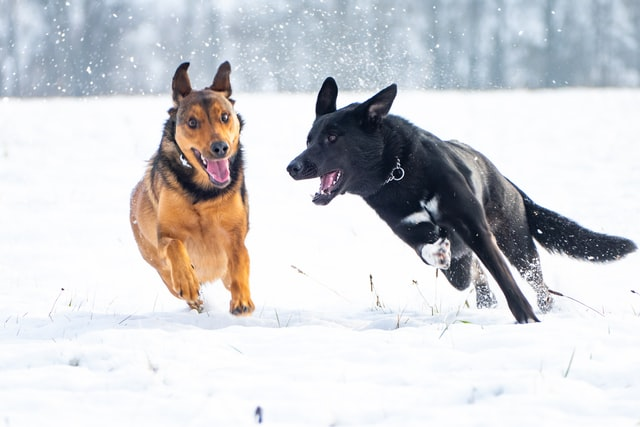

lyStEjlKNSw.jpg


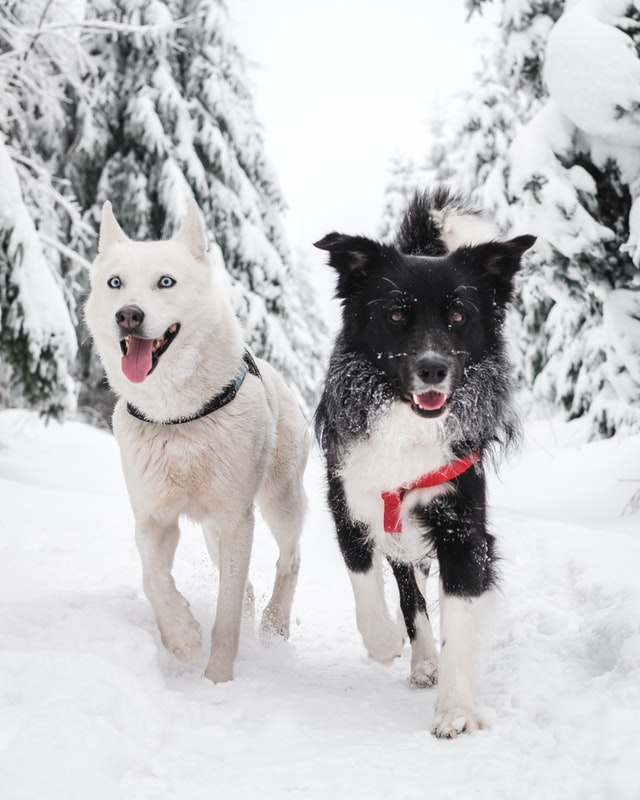

Hb6nGDgWztE.jpg


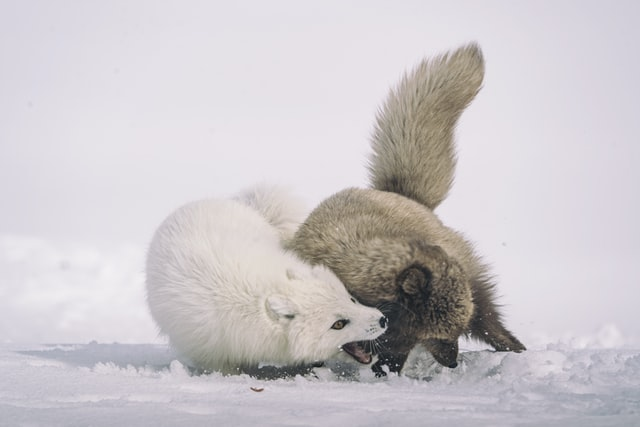

In [55]:
from PIL import Image
from IPython.display import display
from IPython.display import Image as IPImage
import os

for img in images:
    print(img)
    #im = Image.open(f"../sentence-transformers/examples/applications/image-search/photos/{img}")
    display(IPImage(os.path.join("../sentence-transformers/examples/applications/image-search/photos/", img), width=200))

In [56]:
feature_vector_text2 = encode_name("A dog in a park")

In [57]:
images2 = search_products(feature_vector_text2)
print(images2)

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_search [status:200 request:22.453s]


{'took': 22340, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 30, 'relation': 'eq'}, 'max_score': 0.58684057, 'hits': [{'_index': 'clip-index-newest', '_type': '_doc', '_id': 'i1CQPokBLVzJglK9u-BH', '_score': 0.58684057, '_source': {'image_name': 'IVyZrLp41D0.jpg'}}, {'_index': 'clip-index-newest', '_type': '_doc', '_id': 'ElCOPokBLVzJglK9ndOw', '_score': 0.5845304, '_source': {'image_name': 'KVeogBZzl4M.jpg'}}, {'_index': 'clip-index-newest', '_type': '_doc', '_id': 'flCSPokBLVzJglK9dOvO', '_score': 0.58366364, '_source': {'image_name': 'IGZtcY1-pYw.jpg'}}]}}
['IVyZrLp41D0.jpg', 'KVeogBZzl4M.jpg', 'IGZtcY1-pYw.jpg']


IVyZrLp41D0.jpg


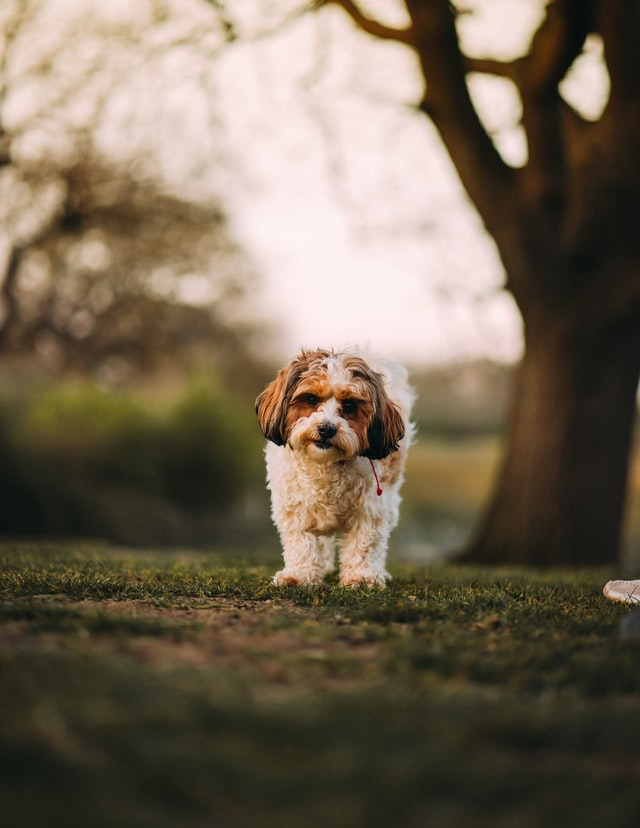

KVeogBZzl4M.jpg


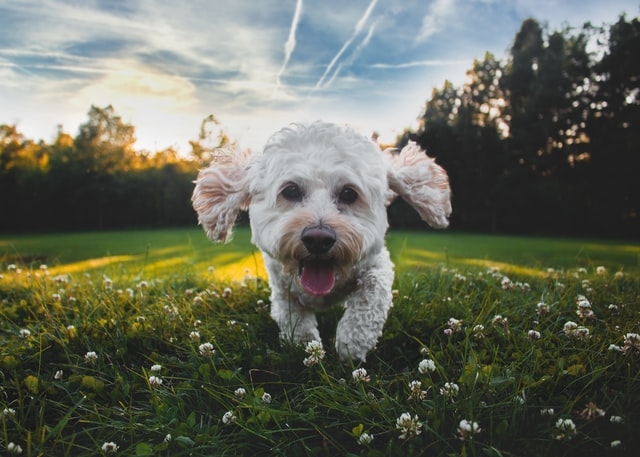

IGZtcY1-pYw.jpg


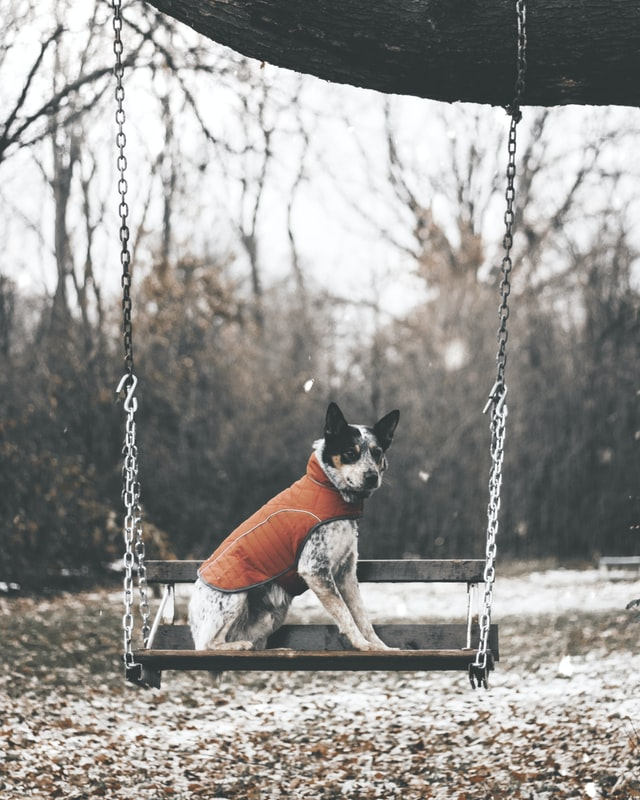

In [58]:
for img in images2:
    print(img)
    #im = Image.open(f"../sentence-transformers/examples/applications/image-search/photos/{img}")
    display(IPImage(os.path.join("../sentence-transformers/examples/applications/image-search/photos/", img), width=200))

In [65]:
feature_vector_text3 = encode_name("A beach with palm trees")
images3 = search_products(feature_vector_text3)
print(images3)

INFO:elasticsearch:POST https://vpc-clip-domain1-ezypmhfaffhxnorjt3jnrvn7k4.us-west-2.es.amazonaws.com:443/clip-index-newest/_search [status:200 request:4.288s]


{'took': 2756, 'timed_out': False, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}, 'hits': {'total': {'value': 30, 'relation': 'eq'}, 'max_score': 0.5952853, 'hits': [{'_index': 'clip-index-newest', '_type': '_doc', '_id': 'y-KOPokBtj8JjcUs7DKd', '_score': 0.5952853, '_source': {'image_name': '7rrgPPljqYU.jpg'}}, {'_index': 'clip-index-newest', '_type': '_doc', '_id': 'x1CQPokBLVzJglK9xOBJ', '_score': 0.59303284, '_source': {'image_name': 'kmihWgpbDEg.jpg'}}, {'_index': 'clip-index-newest', '_type': '_doc', '_id': 'w1CSPokBLVzJglK9Kule', '_score': 0.59245294, '_source': {'image_name': 'ZyfOq52b0cs.jpg'}}]}}
['7rrgPPljqYU.jpg', 'kmihWgpbDEg.jpg', 'ZyfOq52b0cs.jpg']


7rrgPPljqYU.jpg


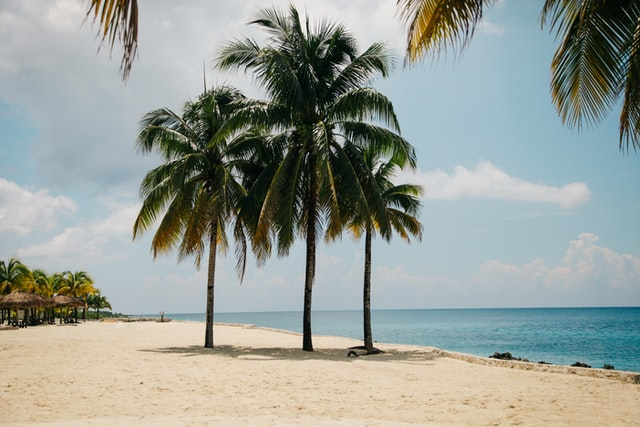

kmihWgpbDEg.jpg


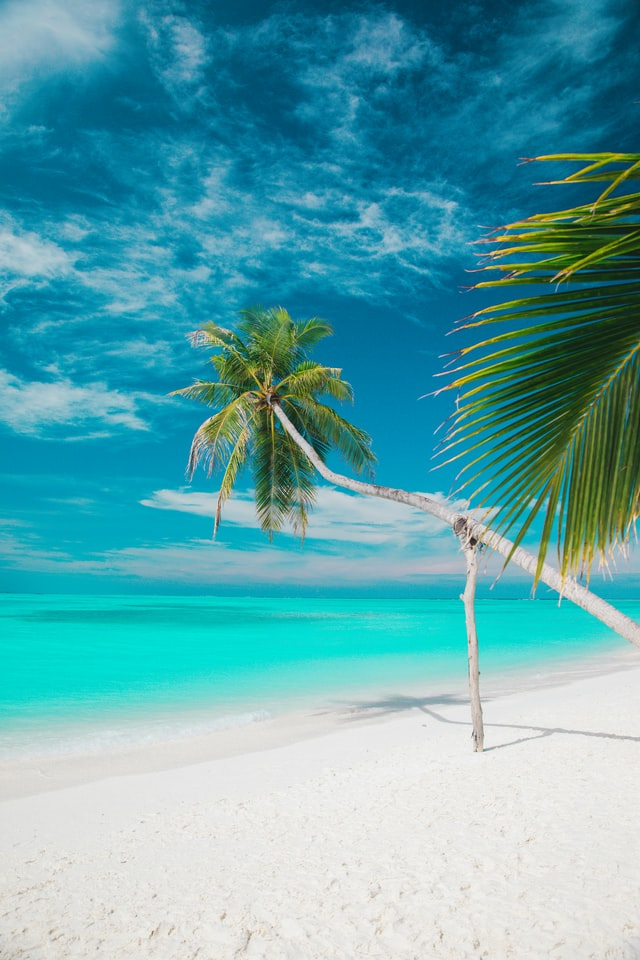

ZyfOq52b0cs.jpg


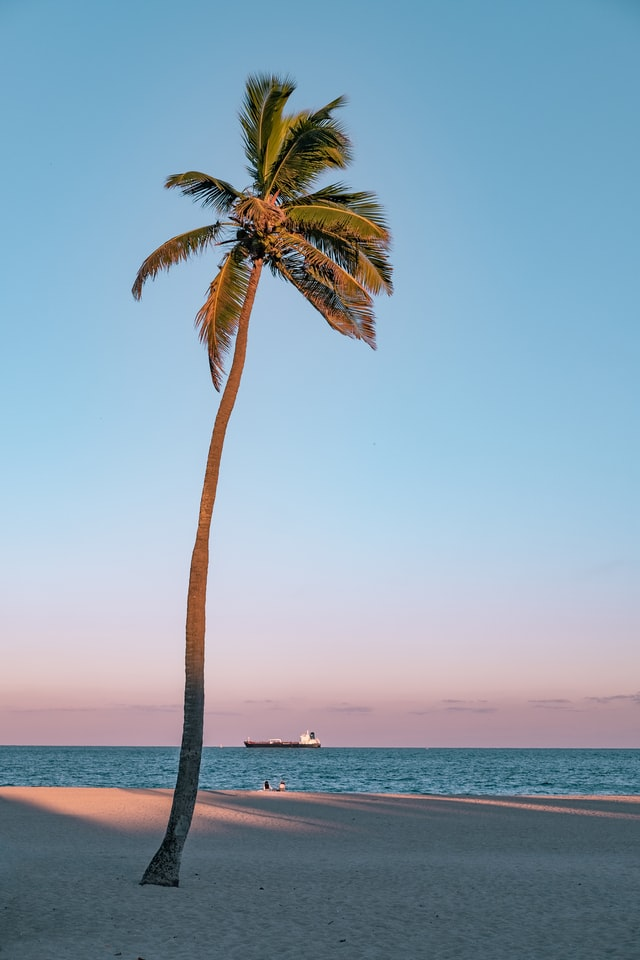

In [66]:
for img in images3:
    print(img)
    #im = Image.open(f"../sentence-transformers/examples/applications/image-search/photos/{img}")
    display(IPImage(os.path.join("../sentence-transformers/examples/applications/image-search/photos/", img), width=200))